In [1]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import numpy.random as npr

import matplotlib
from matplotlib import pyplot as plt

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
from mpc import casadi_control
#from mpc.dynamics import NNDynamics
#import mpc.util as eutil
from mpc.env_dx import frenet_dyn_bicycle, frenet_kin_bicycle  #changed
from mpc.track.src import simple_track_generator, track_functions

import time
import os
import shutil
import pickle as pkl
import collections

import argparse

In [2]:
class NN(nn.Module):
    #changed output dimensions
    def __init__(self, H):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(H + 5, 512)  
        self.fc2 = nn.Linear(512, 512)  
        self.output1 = nn.Linear(512, 10) 
        self.output2 = nn.Linear(512, 10) 

    def forward(self, c, x0):
        combined = torch.cat((c, x0), dim=1)
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        q = F.relu(self.output1(x)) + 0.0001
        p = self.output2(x)
        return q, p
    
def penalty_d(d, th, factor=100000):  
    overshoot_pos = (d - th).clamp(min=0)
    overshoot_neg = (-d - th).clamp(min=0)
    penalty_pos = torch.exp(overshoot_pos) - 1
    penalty_neg = torch.exp(overshoot_neg) - 1 
    return factor*(penalty_pos + penalty_neg)

def penalty_v(v, th, factor=100000):  
    penalty_pos = (v - th).clamp(min=0) ** 2
    return factor*penalty_pos

def penalty_ac(self, ac, factor=1000.):  
        penalty = (ac - ac_max).clamp(min=0) ** 2
        return factor*penalty

In [3]:
# Let's try to create a track 

track_density = 300
track_width = 0.5

gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'LONG_TRACK'

t = 0.3
init = [0,0,0]

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)
    
track_function(gen, t, init)
    
gen.populatePointsAndArcLength()
gen.centerTrack()

track_coord = torch.from_numpy(np.vstack([gen.xCoords, gen.yCoords, gen.arcLength, gen.tangentAngle, gen.curvature]))

In [4]:
device = 'cpu' #to do

mpc_T = 20
mpc_C = 50

n_batch = 32
H_curve = 80

l_r = 0.2
l_f = 0.2

v_max = 2.5
a_max = 3.
delta_max = 0.7 # taken from hardware

ac_max = (0.7*v_max)**2 * delta_max / (l_r+l_f)

dt = 0.04

params = torch.tensor([l_r, l_f, track_width, v_max, ac_max, dt, a_max, delta_max])

In [5]:
true_dx = frenet_kin_bicycle.FrenetKinBicycleDx(track_coord, params)
true_sim_dx = frenet_dyn_bicycle.FrenetDynBicycleDx(track_coord, params)

u_lower = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_upper = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)

n_state = true_dx.n_state
n_ctrl = true_dx.n_ctrl

eps = 5
lqr_iter = 20
grad_method = GradMethods.AUTO_DIFF

#softplus_op = torch.nn.Softplus(10)

8
10


In [6]:
def sample_xinit(n_batch):
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 20.)
    d = uniform(n_batch, -track_width*0.4, track_width*0.4)
    phi = uniform(n_batch, -0.4*np.pi, 0.4*np.pi)
    r = uniform(n_batch, -0.05*np.pi, 0.05*np.pi)
    v_x = uniform(n_batch, 1., v_max)
    v_y = uniform(n_batch, 0., 0.05)

    sigma_0 = sigma
    sigma_diff = sigma-sigma_0
    
    d_pen = penalty_d(d, 0.4*track_width)
    v_ub = penalty_v(v_x, v_max)
    
    k = true_dx.curv(sigma)

    xinit = torch.stack((sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub), dim=1)
    return xinit


def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

def get_loss_progress(x_init, dx, _Q, _p, mpc_T=mpc_T):    
        
        pred_x, pred_u, pred_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_lower=u_lower, u_upper=u_upper, u_init=u_init,
            lqr_iter=lqr_iter,
            verbose=0,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=.8,
            max_linesearch_iter=10,
            grad_method=grad_method,
            eps=eps,
            n_batch=n_batch,
        )(x_init, QuadCost(_Q, _p), dx)
        
        progress_loss = torch.mean(-pred_x[mpc_T-1,:,0] + pred_x[0,:,0])
                    
        return progress_loss
    
    
    
def get_curve_hor_from_x(x, track_coord, mpc_T):
    idx_track_batch = ((x[:,0]-track_coord[[2],:].T)**2).argmin(0)
    idcs_track_batch = idx_track_batch[:, None] + torch.arange(mpc_T)
    curvs = track_coord[4,idcs_track_batch].float()
    return curvs

def cost_to_batch_NN(q, p, n_batch, mpc_T):
    Q_batch = torch.zeros(n_batch, q.shape[1], q.shape[1])
    rows, cols = torch.arange(q.shape[1]), torch.arange(q.shape[1])  
    Q_batch[:, rows, cols] = q 
    Q_batch = Q_batch.unsqueeze(0).repeat(
                mpc_T, 1, 1, 1)    
    p_batch = p.unsqueeze(0).repeat(mpc_T, 1, 1)
    return Q_batch, p_batch

def cost_to_batch(q, p, n_batch, mpc_T):
    Q_batch = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
                mpc_T, n_batch, 1, 1
            )
    p_batch = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)   
    return Q_batch, p_batch

def bound_params(q, p):
    q[:,0] = 0.0001
    q[:,6] = 0.0001
    p[:,0] = -0.0001
    q[:,1] = q[:,1] + 10.0
    q = q.clip(0.00001, 40.)
    p[:,0] = 0.0
    p[:,1] = 0.0
    p[:,2] = 0.0
    p[:,6] = 0.0
    p2 = p.clone()
    p2 = p.clip(-70.)
    p2[:,4] = p[:,4].clip(-70.)
    q2 = q.clone()
    return q2, p2

# -----------------NOT YET ADJUSTED------------------------------------------------------
def inference_params(x_in, track_coord, H_curve, model, q_pen, p_pen, N, mpc_T):
    curvs = get_curve_hor_from_x(x_in, track_coord, H_curve)
    q, p = model(curvs, x_in[:,1:6])
    q = torch.cat((q[:,:8], q_pen, q[:,8:]), dim=1)
    p = torch.cat((p[:,:8], p_pen, p[:,8:]), dim=1)
    q2, p2 = bound_params(q, p) 
    Q_batch, p_batch = cost_to_batch_NN(q2, p2, N, mpc_T)
    return Q_batch, p_batch
# ----------------------------------------------------------------------------------------
# From here onwards I did not adjust much - we can discuss

In [7]:
env_params = true_dx.params
track_coord = track_coord.to(device)
dx = true_dx.__class__(track_coord,env_params)

q_penalty = .0001*torch.ones(2).to(device)
p_penalty = torch.ones(2).to(device)

model = NN(H_curve)
opt = optim.Adam(model.parameters(), lr=8e-4)
q_penalty_batch = q_penalty.unsqueeze(0).repeat(n_batch,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(n_batch,1)

10


In [8]:
for i in range(600):
    
    x_init = sample_xinit(n_batch).to(device)
    
    Q_batch, p_batch = inference_params(
        x_init, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        n_batch, mpc_T)
           
    loss = get_loss_progress(x_init, dx, Q_batch, p_batch)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print('Batch:', i , ' Progression with MPC_T=',mpc_T ,': ', -round(loss.item(), 4))

/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/autograd/__init__.py:411: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/_tensor.py:770: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 0  Progression with MPC_T= 25 :  0.7931
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 1  Progression with MPC_T= 25 :  0.9587
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 2  Progression with MPC_T= 25 :  0.8625
[WARNING] pnqp warning: Did not converge
Batch: 3  Progression with MPC_T= 25 :  0.7986
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 4  Progression with MPC_T= 25 :  0.8951
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 43  Progression with MPC_T= 25 :  0.9547
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 44  Progression with MPC_T= 25 :  0.8388
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 45  Progression with MPC_T= 25 :  0.8988
[WARNING] pnqp warning: Did not converge
Batch: 46  Progression with MPC_T= 25 :  1.1195
Batch: 47  Progression with MPC_T= 25 :  0.8756
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 48  Progression with MPC_T= 25 :  0.7843
Batch: 49  Progression with MPC_T= 25 :  0.8437
Batch: 50  Progression with MPC_T= 25 :  0.9476
[WARNING] pnqp warning: Did not converge
[

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 107  Progression with MPC_T= 25 :  0.9308
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 108  Progression with MPC_T= 25 :  1.0854
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 109  Progression with MPC_T= 25 :  1.0012
Batch: 110  Progression with MPC_T= 25 :  0.8677
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 111  Progression with MPC_T= 25 :  1.1607
[WARNING] pnqp warning: Did not converge
Batch: 112  Progression with MPC_T= 25 :  0.7577
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 113  Progression with MPC_T= 25 :  1.0173
[WARNING] pnqp warning: Did not converge
[

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 165  Progression with MPC_T= 25 :  1.0504


KeyboardInterrupt: 

In [9]:
N_test = 1
mpc_T_test = mpc_T

In [10]:
#x_init_test = sample_xinit(N_test)

# Below you can put any initial state you want (any that make sense)
sigma = torch.tensor(0.01)

d = torch.tensor(0.05)
d_pen = penalty_d(d, 0.5*track_width*0.75)

r = torch.tensor(0.0)

v_x = torch.tensor(0.5) #make sure this is never 0
v_ub = penalty_v(v_x, v_max*0.95)

v_y = torch.tensor(0.0)  # this can be zero

sigma_0 = sigma
sigma_diff = sigma-sigma_0

x_init_test = torch.tensor([[sigma, d, -.0, r, v_x, v_y, sigma_0, 
                             sigma_diff, d_pen, v_ub]])

In [11]:
def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

In [12]:
# Added here the bounds of U
u_lower_test = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_upper_test = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)

In [13]:
N_sim_total = 150
x_simulated = torch.zeros((N_sim_total,1,10))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)

    x_mpc_test, u_mpc_test, objs_mpc_test = mpc.MPC(
                n_state, n_ctrl, mpc_T_test,
                u_lower=u_lower_test, u_upper=u_upper_test, u_init=u_init,
                lqr_iter=30,
                verbose=0,
                exit_unconverged=False,
                detach_unconverged=True,
                linesearch_decay=.8,
                max_linesearch_iter=10,
                grad_method=grad_method,
                eps=.5,
                n_batch=N_test,
            )(x_sim, QuadCost(Q_test_batch, p_test_batch), dx)

    x_simulated[i] = x_mpc_test[1]
    x_simulated[i,0,6] = x_simulated[i,0,0]
    x_simulated[i,0,7] = 0.

It: 1 x= [[ 0.01  0.05 -0.    0.    0.5   0.    0.01  0.    0.    0.  ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 2 x= [[ 0.03   0.05   0.    -0.821  0.599 -0.161  0.03   0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 3 x= [[ 0.054  0.044 -0.033 -0.639  0.696 -0.126  0.054  0.     0.     0.   ]]
[WARNING] pnqp warning: Did n

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 23 x= [[ 0.951 -0.037 -0.165 -2.346  1.447 -0.398  0.951  0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 24 x= [[ 1.013 -0.062 -0.051 -1.197  1.437 -0.181  1.013  0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp war

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 42 x= [[ 1.727  0.183  0.427  0.776  0.334 -0.056  1.727  0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 43 x= [[1.74  0.187 0.459 0.838 0.212 0.204 1.74  0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples di

KeyboardInterrupt: 

In [14]:
u_mpc_test[0]

tensor([[-3.0000,  0.7000]], grad_fn=<SelectBackward0>)

In [15]:
def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

In [16]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

In [17]:
x_plot = np.array(x_list)
y_plot = np.array(y_list)

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


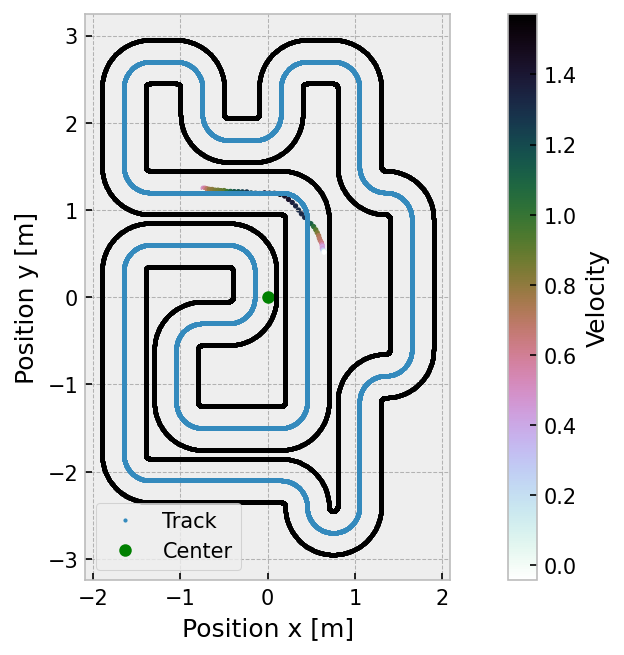

In [18]:
from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,4].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [ ]:
curvsp = dx.curv(x_simulated[:250,0,0]).detach()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10,10), dpi=150)
axs[0].plot(x_simulated[:250,0,0].detach(), 
         x_simulated[:250,0,1].detach())
axs[0].scatter(x_simulated[:250,0,0].detach(), 
         x_simulated[:250,0,1].detach(), s=10, color='red')
axs[0].set_ylabel('lateral dev (d)')

axs[1].plot(x_simulated[:250,0,0].detach(), 
         curvsp)
axs[1].scatter(x_simulated[:250,0,0].detach(), 
         curvsp, s=10, color='red')
axs[1].set_ylabel('curve')

axs[2].plot(x_simulated[:250,0,0].detach(), 
         1 - curvsp*x_simulated[:250,0,1].detach())
axs[2].scatter(x_simulated[:250,0,0].detach(), 
         1 - curvsp*x_simulated[:250,0,1].detach(), s=10, color='red')
axs[2].set_ylabel('1-d*curve')



In [28]:
from mpc import casadi_control
from importlib import reload
reload(casadi_control)

<module 'mpc.casadi_control' from '/home/alan/Desktop/Research/Code/race_application/mpc/casadi_control.py'>

In [31]:
mpc_T_test = 40

In [32]:
x_warmstart = torch.zeros(n_state+n_ctrl,mpc_T_test+1)
u_test = torch.tensor([[-0.2,0.]])
x_warmstart[:,0] = torch.cat((x_init_test,u_test),dim=1)

In [35]:
control = casadi_control.CasadiControl(track_coord, params.numpy())

dc = 2 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = n_state #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = n_ctrl #number control inputs

N_sim_total = 200
x_simulated = torch.zeros((N_sim_total,1,10))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
    test_p = p_test_batch[0,0].detach().numpy()
    
    #sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub 
    
    test_q=np.array([0.,1.5,0.2,0.01,0.0,0.,0.,0.0,0.,0.,0.1,0.1])
    test_p=np.array([0.,0.,0.,0.,-1.,0.,0.,-4.5,100.,100., 0., 0.])

    sol = control.mpc_casadi_with_constraints_paj(
        test_q,test_p,x_sim.detach().numpy(),
        mpc_T_test,df,dc,dx,du,x_warmstart.numpy())
    
    u_mpc_test = sol[-du*mpc_T_test:]
    x_mpc_test = sol[:-du*mpc_T_test]
    u_mpc_test = u_mpc_test.reshape(mpc_T_test,du)
    x_mpc_test = x_mpc_test.reshape(mpc_T_test+1,dx-dc-df)


    x_simulated[i,0,:6] = torch.tensor(x_mpc_test[1])
    x_simulated[i,0,6] = torch.tensor(x_simulated[i,0,0])
    x_simulated[i,0,7] = 0.

9
It: 1 x= [[ 0.01  0.05 -0.    0.    0.5   0.    0.01  0.    0.    0.  ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    in

/tmp/ipykernel_428326/1328616654.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_simulated[i,0,6] = torch.tensor(x_simulated[i,0,0])


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4027483e+00 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  94 -2.8599870e+02 8.68e-01 2.25e+02  -1.0 1.99e+01    -  1.69e-01 1.02e-01f  1
  95 -2.8636176e+02 7.76e-01 5.05e+02  -1.0 1.36e+01    -  2.79e-01 1.05e-01h  1
  96 -2.8941386e+02 6.80e-01 3.42e+02  -1.0 1.83e+01    -  1.08e-01 1.26e-01h  1
  97 -2.9261478e+02 1.06e+00 2.05e+02  -1.0 4.92e+01    -  4.78e-02 8.47e-02f  1
  98 -2.9267736e+02 1.06e+00 1.61e+04  -1.0 9.69e+00    -  3.51e-01 3.32e-03h  1
  99 -2.9271369e+02 1.06e+00 2.40e+05  -1.0 9.06e+00    -  2.69e-01 3.62e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -2.9272219e+02 1.06e+00 5.04e+06  -1.0 9.12e+00    -  3.45e-01 1.05e-03h  5
 101 -2.9272241e+02 1.06e+00 1.08e+08  -1.0 9.12e+00    -  3.35e-01 3.12e-05h 10
 102 -2.9272251e+02 1.06e+00 3.71e+09  -1.0 9.14e+00    -  5.46e-01 1.56e-05h 11
 103 -2.9281523e+02 1.04e+00 3.65e+09  -1.0 9.14e+00    -  1.60e-02 1.60e-02s 16
 104r-2.9281523e+02 1.04e+00 1.00e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
 105r-2.9326814e+02 4.22e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.7752532e+02 3.34e+00 2.74e+03  -1.0 1.54e+02    -  4.24e-02 1.22e-02f  1
  81 -1.9812597e+02 3.58e+00 2.47e+03  -1.0 5.43e+01    -  6.92e-02 9.23e-02f  1
  82 -2.0985052e+02 3.54e+00 2.42e+03  -1.0 7.46e+01    -  4.37e-03 3.37e-02f  1
  83 -2.1640862e+02 3.38e+00 2.38e+03  -1.0 3.24e+01    -  1.83e-02 1.84e-02f  1
  84 -2.1681890e+02 3.37e+00 2.35e+03  -1.0 1.20e+01  -0.7 2.40e-02 3.66e-03f  1
  85 -2.2015855e+02 3.36e+00 2.32e+03  -1.0 7.53e+01    -  6.64e-03 2.39e-02f  1
  86 -2.2163046e+02 3.31e+00 2.23e+03  -1.0 8.58e+00  -1.2 4.44e-02 1.57e-02f  1
  87 -2.2547283e+02 3.13e+00 2.14e+03  -1.0 8.40e+00  -1.7 3.56e-02 6.58e-02f  1
  88 -2.2917905e+02 3.21e+00 2.15e+03  -1.0 7.58e+03  -2.2 7.18e-05 5.81e-04f  1
  89 -2.3962836e+02 3.24e+00 2.09e+03  -1.0 4.13e+01  -2.6 3.34e-02 7.80e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.4668380e+02 2.96e+00

  63r-1.8397164e+02 7.96e+02 1.00e+03   1.4 0.00e+00    -  0.00e+00 4.79e-07R  7
  64r-1.8452598e+02 7.53e+00 9.80e+02   1.4 6.64e+05    -  2.95e-02 1.19e-03f  1
  65r-1.8452598e+02 7.53e+00 9.99e+02  -0.5 0.00e+00    -  0.00e+00 4.24e-07R  5
  66r-1.8213153e+02 1.50e+00 9.97e+02  -0.5 3.29e+03    -  3.66e-04 3.11e-03f  1
  67r-1.8166296e+02 2.32e+00 9.95e+02  -0.5 3.84e+03    -  9.49e-04 2.25e-03f  1
  68 -1.8171151e+02 2.32e+00 1.66e+02  -1.0 7.83e+02    -  6.60e-02 4.02e-04h  1
  69r-1.8171151e+02 2.32e+00 9.99e+02  -0.6 0.00e+00    -  0.00e+00 3.56e-07R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r-1.8271173e+02 7.10e-01 9.95e+02  -0.6 2.71e+03    -  2.70e-03 3.76e-03f  1
  71 -1.8280300e+02 7.13e-01 2.94e+02  -1.0 2.97e+03    -  5.69e-02 2.56e-04h  1
  72 -1.8890738e+02 1.28e+01 4.28e+02  -1.0 4.91e+04    -  1.91e-03 1.05e-03f  1
  73r-1.8890738e+02 1.28e+01 9.99e+02  -0.4 0.00e+00    -  0.00e+00 3.54e-07R  7
  74r-1.8926348e+02 5.52e-01

 194r-3.3121238e+02 1.02e-01 9.26e+02  -1.0 1.76e+01    -  7.79e-02 7.59e-03f  1
 195 -3.3121242e+02 1.02e-01 1.44e+05  -1.0 1.53e+00    -  8.37e-01 2.29e-05h  1
 196 -3.3126289e+02 5.71e-02 2.66e+05  -1.0 3.70e-01    -  1.00e+00 4.38e-01h  1
 197 -3.3130533e+02 2.03e-02 3.09e+05  -1.0 2.89e-01    -  1.00e+00 6.40e-01h  1
 198 -3.3131704e+02 9.53e-03 9.39e+05  -1.0 9.54e-02    -  1.00e+00 5.29e-01h  1
 199 -3.3132335e+02 3.71e-03 1.83e+06  -1.0 4.50e-02    -  1.00e+00 6.10e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -3.3132532e+02 1.87e-03 6.53e+06  -1.0 1.73e-02    -  1.00e+00 4.96e-01h  1
 201 -3.3132532e+02 1.87e-03 3.94e+07  -1.0 1.19e-08  15.5 1.00e+00 1.00e+00f  1
 202 -3.3132532e+02 1.87e-03 8.34e+08  -1.0 2.10e-03  15.0 2.17e-04 3.60e-04h  1
 203 -3.3132532e+02 1.87e-03 9.19e+08  -1.0 2.10e-03  14.6 6.61e-04 1.11e-04h  1
 204 -3.3132532e+02 1.87e-03 1.01e+09  -1.0 2.10e-03  14.1 1.05e-03 3.42e-04h  1
 205 -3.3132532e+02 1.86e-03

 309 -3.3132733e+02 3.56e-07 8.19e+04  -1.0 4.37e-07  11.3 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -3.3132733e+02 3.56e-07 1.10e+04  -1.7 1.76e-07  10.8 1.00e+00 5.00e-01h  2
 311 -3.3132733e+02 3.56e-07 6.36e+03  -2.5 2.99e-07  10.3 1.00e+00 7.81e-03h  8
 312 -3.3132733e+02 3.56e-07 2.18e+03  -2.5 2.96e-07   9.8 1.00e+00 1.95e-03h 10
 313 -3.3132733e+02 3.55e-07 1.30e+03  -3.8 4.75e-07   9.4 1.00e+00 7.77e-03h  8
 314 -3.3115410e+02 4.19e-05 1.30e+03  -3.8 2.43e+01    -  2.05e-03 2.05e-03s 14
 315r-3.3115410e+02 4.19e-05 1.00e+03  -3.8 0.00e+00   8.9 0.00e+00 0.00e+00R  1
 316r-3.3113245e+02 3.86e-05 2.23e+02  -3.8 1.06e-01    -  7.77e-01 9.02e-03f  1
 317r-3.2608182e+02 3.75e-03 1.50e+01  -3.8 1.74e-01    -  9.90e-01 8.17e-01f  1
 318r-3.2598230e+02 3.09e-03 1.55e+02  -3.8 3.19e-02    -  1.47e-01 1.75e-01f  1
 319r-3.2551423e+02 4.20e-05 3.02e+00  -3.8 2.61e-02    -  9.92e-01 1.00e+00h  1
iter    objective    inf_pr 

  61 -1.4477143e+02 5.18e+01 8.10e+01  -1.0 4.89e+03    -  2.80e-03 5.43e-03f  1
  62 -1.5027506e+02 5.25e+01 6.62e+01  -1.0 4.26e+03    -  5.40e-03 3.05e-03f  1
  63 -1.8085649e+02 6.93e+01 2.77e+01  -1.0 2.79e+03    -  3.03e-02 2.10e-02f  1
  64 -1.9111713e+02 6.78e+01 2.39e+01  -1.0 1.41e+02    -  9.04e-03 2.09e-02f  1
  65 -2.0141097e+02 6.65e+01 2.59e+01  -1.0 1.44e+02    -  4.23e-04 1.98e-02f  1
  66 -2.0186071e+02 6.64e+01 2.38e+01  -1.0 9.14e+01    -  1.05e-01 1.65e-03f  1
  67 -2.2418527e+02 5.96e+01 3.48e+01  -1.0 9.23e+01    -  7.59e-02 1.07e-01f  1
  68 -2.4621484e+02 5.62e+01 3.32e+01  -1.0 9.79e+01    -  1.96e-01 6.14e-02f  1
  69 -2.7956827e+02 5.16e+01 3.10e+01  -1.0 6.15e+01    -  1.24e-01 8.71e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -3.0112752e+02 4.13e+01 3.42e+01  -1.0 5.13e+01    -  3.09e-02 2.00e-01f  1
  71 -3.2739277e+02 2.56e+01 3.68e+01  -1.0 3.99e+01    -  1.21e-01 3.86e-01f  1
  72 -3.3861507e+02 1.95e+01

  76 -1.6239172e+02 8.80e+00 6.62e+01  -1.0 1.95e+01    -  1.84e-02 1.93e-02f  1
  77 -1.6273342e+02 8.76e+00 1.97e+02  -1.0 2.28e+01    -  5.48e-02 4.13e-03h  1
  78 -1.6296306e+02 8.73e+00 1.35e+03  -1.0 1.96e+01    -  9.95e-02 3.01e-03h  1
  79 -1.6306354e+02 8.71e+00 5.25e+03  -1.0 6.04e+01    -  1.75e-02 3.02e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.6303882e+02 8.70e+00 2.03e+04  -1.0 2.05e+02    -  5.78e-03 4.79e-04h  1
  81 -1.6287437e+02 8.70e+00 2.53e+04  -1.0 8.83e+02    -  1.20e-03 1.69e-04h  5
  82 -1.6273002e+02 8.70e+00 4.75e+04  -1.0 8.77e+02    -  3.90e-03 1.63e-04h  5
  83 -1.6239117e+02 8.70e+00 8.17e+04  -1.0 8.38e+02    -  3.68e-03 3.43e-04h  4
  84 -1.6196171e+02 8.69e+00 2.15e+05  -1.0 7.67e+02    -  8.08e-03 3.71e-04h  4
  85 -1.6098972e+02 8.69e+00 2.81e+05  -1.0 6.95e+02    -  2.11e-03 4.68e-04h  4
  86 -1.5985934e+02 8.69e+00 9.97e+05  -1.0 6.62e+02    -  1.42e-02 4.97e-04h  4
  87 -1.5956662e+02 8.68e+00

 201 -3.1334713e+02 2.72e+00 1.10e+08  -1.0 4.53e+00   5.4 3.36e-02 1.70e-02h  1
 202 -3.1316059e+02 2.65e+00 1.72e+08  -1.0 4.47e+00   5.8 3.82e-01 2.50e-02h  1
 203 -3.1219412e+02 2.39e+00 1.59e+08  -1.0 4.50e+00   5.3 4.37e-02 9.88e-02h  1
 204 -3.1218525e+02 2.39e+00 2.15e+08  -1.0 4.33e+00   5.8 6.30e-01 1.24e-03h  1
 205 -3.1190385e+02 2.32e+00 1.75e+08  -1.0 4.36e+00   5.3 2.54e-01 2.90e-02h  1
 206 -3.1164723e+02 2.24e+00 2.09e+08  -1.0 4.28e+00   5.7 1.00e+00 3.31e-02h  1
 207 -3.1147319e+02 2.20e+00 1.81e+08  -1.0 4.22e+00   5.2 1.67e-01 1.78e-02h  1
 208 -3.1068730e+02 2.00e+00 1.64e+08  -1.0 4.18e+00   5.7 7.00e-02 9.32e-02h  1
 209 -3.1056059e+02 1.97e+00 1.61e+08  -1.0 3.91e+00   5.2 1.66e-02 1.30e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -3.1054984e+02 1.97e+00 1.60e+08  -1.0 3.91e+00   5.6 5.74e-02 1.34e-03h  1
 211 -3.0958053e+02 1.78e+00 1.55e+08  -1.0 3.84e+00   5.1 3.32e-02 9.70e-02h  1
 212 -3.0926709e+02 1.69e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2734356e+01 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.0607272e+01 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 131 -1.7814675e+02 5.23e+00 4.68e+04  -1.0 6.59e+02    -  5.58e-03 1.71e-04h  8
 132 -1.7767632e+02 5.23e+00 6.55e+04  -1.0 7.45e+02    -  1.11e-02 1.79e-04h  8
 133 -1.7724761e+02 5.23e+00 7.85e+04  -1.0 8.74e+02    -  5.67e-03 1.53e-04h  8
 134 -1.7685686e+02 5.23e+00 1.14e+05  -1.0 9.50e+02    -  1.27e-02 1.35e-04h  8
 135 -1.7646808e+02 5.23e+00 1.37e+05  -1.0 1.06e+03    -  5.76e-03 1.29e-04h  8
 136 -1.7609598e+02 5.23e+00 2.02e+05  -1.0 1.15e+03    -  1.30e-02 1.21e-04h  8
 137 -1.7570712e+02 5.23e+00 2.45e+05  -1.0 1.29e+03    -  5.87e-03 1.23e-04h  8
 138 -1.2379750e+02 2.00e+01 2.58e+05  -1.0 1.40e+03    -  1.68e-02 1.50e-02w  1
 139 -1.2678498e+02 2.00e+01 2.91e+05  -1.0 2.58e+03   0.1 1.34e-05 2.52e-04w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -1.2741021e+02 2.00e+01 2.73e+05  -1.0 3.12e+03   0.5 1.65e-04 3.21e-05w  1
 141 -1.7533338e+02 5.23e+00 4.00e+05  -1.0 2.35e+02   0.9 1.68e-02 1.17e-04h  7
 142 -1.7513324e+02 5.23e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 -3.7840607e+02 3.21e-06 4.22e+07  -3.8 5.69e-05    -  5.77e-01 2.44e-04f 13
 251 -3.7840607e+02 3.21e-06 1.71e+08  -3.8 1.27e-05    -  1.00e+00 2.25e-04f  2
 252 -3.7840607e+02 3.21e-06 4.21e+07  -3.8 5.63e-05    -  7.53e-01 3.05e-05h 16
 253 -3.7840607e+02 3.21e-06 1.86e+08  -3.8 6.74e-06    -  1.00e+00 9.20e-05f  2
 254 -3.7840607e+02 3.21e-06 4.21e+07  -3.8 5.63e-05    -  7.73e-01 3.05e-05h 16
 255 -3.7840607e+02 3.21e-06 1.80e+08  -3.8 8.75e-06    -  1.00e+00 1.77e-04f  2
 256 -3.7840607e+02 3.21e-06 4.21e+07  -3.8 5.59e-05    -  7.67e-01 3.05e-05h 16
 257 -3.7840603e+02 8.29e-08 1.55e+02  -3.8 9.52e-06    -  1.00e+00 1.00e+00f  1
 258 -3.7840603e+02 3.32e-06 2.85e+09  -3.8 2.42e-05    -  4.34e-02 1.00e+00f  1
 259 -3.7840603e+02 1.00e-06 8.58e+08  -3.8 3.27e-06   6.7 1.00e+00 6.99e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -3.7840603e+02 7.87e-07

 343 -3.7840603e+02 2.96e-07 2.26e+08  -3.8 2.63e-05    -  1.00e+00 1.19e-04f  1
 344 -3.7840603e+02 2.96e-07 1.54e+08  -3.8 1.14e-06   6.7 3.17e-01 6.10e-05f 15
 345 -3.7840603e+02 2.96e-07 2.54e+08  -3.8 3.01e-06    -  1.00e+00 3.31e-04f  2
 346 -3.7840603e+02 2.96e-07 1.54e+08  -3.8 1.01e-05   6.2 3.94e-01 7.63e-06h 18
 347 -3.7840603e+02 2.96e-07 2.65e+08  -3.8 4.67e-06    -  1.00e+00 9.61e-05f  2
 348 -3.7840603e+02 2.96e-07 1.54e+08  -3.8 1.31e-06   6.6 4.18e-01 3.05e-05h 16
 349 -3.7840603e+02 2.96e-07 1.54e+08  -3.8 1.26e-06    -  2.75e-04 2.75e-04s 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -3.7840603e+02 2.96e-07 1.54e+08  -3.8 3.53e-06    -  2.86e-04 2.86e-04s 11
 351r-3.7840603e+02 2.96e-07 1.00e+03  -3.8 0.00e+00    -  0.00e+00 0.00e+00R  1
 352r-3.7840544e+02 9.42e-06 9.38e+02  -3.8 4.81e-02    -  6.17e-02 6.09e-02f  1
 353r-3.7839650e+02 2.74e-05 9.38e+01  -3.8 4.80e-02    -  9.00e-01 1.00e+00f  1
 354r-3.7836495e+02 1.82e-05

 469 -3.7840605e+02 5.80e-07 1.13e+08  -3.8 7.17e-02    -  1.00e+00 7.79e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 -3.7840605e+02 5.80e-07 1.12e+08  -3.8 7.36e-02    -  1.00e+00 7.79e-03h  8
 471 -3.7840605e+02 5.79e-07 1.12e+08  -3.8 7.56e-02    -  1.00e+00 7.74e-03h  8
 472 -3.7840605e+02 5.79e-07 1.03e+08  -3.8 7.76e-02    -  1.00e+00 7.81e-03h  8
 473 -3.7840593e+02 6.26e-05 9.31e+06  -3.8 7.97e-02    -  1.00e+00 9.16e-01w  1
 474 -3.7840510e+02 3.29e-04 5.61e+08  -3.8 1.75e-01    -  1.51e-01 1.00e+00w  1
 475 -3.7840511e+02 3.28e-04 5.60e+08  -3.8 5.43e-04   8.8 1.32e-03 1.60e-03w  1
 476 -3.7840605e+02 5.79e-07 1.10e+08  -3.8 8.21e-03    -  1.00e+00 7.16e-03h  7
 477 -3.7840605e+02 5.78e-07 1.01e+08  -3.8 8.18e-02    -  1.00e+00 3.91e-03h  9
 478 -3.7840605e+02 5.77e-07 1.10e+08  -3.8 8.29e-02    -  1.00e+00 7.07e-03h  8
 479 -3.7840605e+02 5.76e-07 9.51e+07  -3.8 8.51e-02    -  1.00e+00 3.91e-03h  9
iter    objective    inf_pr 

In iteration 567, 1 Slack too small, adjusting variable bound
 568 -3.7841364e+02 3.08e-07 2.51e+08  -8.6 4.28e-03  -2.7 1.00e+00 6.61e-06h  1
 569 -3.7841364e+02 3.07e-07 2.60e+08  -8.6 2.70e-05  -2.2 1.00e+00 2.06e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570 -3.7841364e+02 3.08e-07 2.51e+08  -8.6 4.53e-05    -  9.38e-03 1.22e-04h 14
In iteration 570, 1 Slack too small, adjusting variable bound
 571 -3.7841364e+02 3.08e-07 2.51e+08  -8.6 7.46e-06  -1.8 1.00e+00 3.35e-06h  1
 572 -3.7841364e+02 3.08e-07 2.76e+08  -8.6 3.28e-05  -2.3 1.00e+00 1.43e-04h  5
 573 -3.7841364e+02 3.06e-07 2.51e+08  -8.6 4.53e-05    -  2.65e-02 9.77e-04h 11
 574r-3.7841364e+02 3.06e-07 9.99e+02  -8.0 0.00e+00  -1.9 0.00e+00 3.80e-07R  5
 575r-3.7841365e+02 2.02e-07 9.97e+02  -8.0 1.62e-03    -  1.93e-03 1.53e-03f  1
In iteration 575, 1 Slack too small, adjusting variable bound
 576 -3.7841365e+02 2.02e-07 1.46e+03  -8.6 2.74e-06    -  7.75e-01 8.82e-04h  1
In i

In iteration 673, 1 Slack too small, adjusting variable bound
 674 -3.7841364e+02 2.58e-07 2.26e+08  -9.0 3.10e-06   3.8 1.00e+00 1.17e-01h  1
In iteration 674, 1 Slack too small, adjusting variable bound
 675 -3.7841364e+02 2.48e-07 2.18e+08  -9.0 3.43e-06   3.3 1.00e+00 3.73e-02h  1
In iteration 675, 1 Slack too small, adjusting variable bound
 676 -3.7841364e+02 2.46e-07 2.25e+08  -9.0 3.29e-06   2.8 1.00e+00 8.73e-03h  1
 677 -3.7841364e+02 2.46e-07 2.16e+08  -9.0 4.88e-07    -  1.05e-02 9.54e-07h 21
In iteration 677, 1 Slack too small, adjusting variable bound
 678 -3.7841364e+02 2.46e-07 2.16e+08  -9.0 4.56e-06   2.3 1.00e+00 6.79e-07h  1
 679 -3.7841365e+02 6.37e-07 7.66e+08  -9.0 2.62e-06    -  7.06e-05 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680 -3.7841365e+02 6.32e-07 7.59e+08  -9.0 7.27e-06   1.9 2.92e-01 8.53e-03h  3
In iteration 680, 1 Slack too small, adjusting variable bound
 681 -3.7841365e+02 6.29e-07 7.56e+08  -9.

In iteration 774, 1 Slack too small, adjusting variable bound
 775 -3.7841364e+02 2.45e-07 7.41e+08  -9.0 4.18e-06   4.8 1.00e+00 4.35e-05h  1
In iteration 775, 1 Slack too small, adjusting variable bound
 776 -3.7841364e+02 2.42e-07 7.32e+08  -9.0 3.54e-07   4.3 1.00e+00 1.24e-02h  1
In iteration 776, 1 Slack too small, adjusting variable bound
 777 -3.7841364e+02 2.42e-07 8.21e+08  -9.0 4.00e-07   3.8 1.00e+00 1.16e-03h  1
 778 -3.7841364e+02 2.56e-07 8.94e+08  -9.0 2.38e-07    -  6.09e-02 2.50e-01h  3
In iteration 778, 1 Slack too small, adjusting variable bound
 779 -3.7841364e+02 2.56e-07 8.94e+08  -9.0 4.20e-06   3.4 1.00e+00 2.55e-06h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 -3.7841364e+02 1.36e-06 1.11e+09  -9.0 1.38e-06    -  1.98e-05 1.25e-01h  4
In iteration 780, 1 Slack too small, adjusting variable bound
 781 -3.7841364e+02 1.36e-06 1.11e+09  -9.0 1.85e-05   2.9 5.92e-02 2.65e-03h  1
In iteration 781, 1 Slack too small, adjus

 885 -3.7841365e+02 3.15e-07 6.71e+08  -9.0 1.46e-06   4.8 1.00e+00 1.87e-01h  1
 886 -3.7841365e+02 3.12e-07 6.64e+08  -9.0 1.43e-06   4.3 1.00e+00 1.04e-02h  5
 887 -3.7841365e+02 3.10e-07 6.61e+08  -9.0 2.77e-06   3.8 1.00e+00 5.08e-03h  6
 888 -3.7841365e+02 3.10e-07 6.61e+08  -9.0 1.28e-06   3.4 1.00e+00 1.24e-03h  8
 889 -3.7841365e+02 3.10e-07 6.67e+08  -9.0 1.17e-06   2.9 1.00e+00 3.08e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890 -3.7841365e+02 3.10e-07 7.06e+08  -9.0 1.17e-06   2.4 1.00e+00 1.54e-04h 11
 891 -3.7841365e+02 4.53e-06 3.51e+09  -9.0 1.69e-04    -  9.77e-04 6.10e-02h  1
 892 -3.7841365e+02 4.53e-06 3.51e+09  -9.0 1.33e-05   6.4 2.16e-01 6.47e-05f  2
In iteration 892, 1 Slack too small, adjusting variable bound
 893 -3.7841365e+02 4.20e-06 3.25e+09  -9.0 4.88e-06   6.0 5.77e-02 7.20e-02h  1
In iteration 893, 1 Slack too small, adjusting variable bound
 894 -3.7841365e+02 4.20e-06 3.25e+09  -9.0 3.72e-06   6.4 4.15e-0

It: 9 x= [[ 0.276  0.067 -0.231 15.451  1.44   0.324  0.276  0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objecti

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.0209116e+01 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 122r-1.7994334e+02 3.43e+00 9.95e+02  -1.0 7.08e+01    -  9.84e-03 4.43e-03f  1
 123r-1.8335977e+02 2.81e+00 9.87e+02  -1.0 5.09e+01    -  7.11e-02 6.59e-03f  1
 124 -1.8599419e+02 2.80e+00 9.20e+01  -1.0 1.61e+02    -  1.42e-02 3.11e-03f  1
 125 -1.8609344e+02 2.80e+00 2.20e+02  -1.0 3.59e+02    -  2.21e-03 1.74e-04h  4
 126 -1.8732006e+02 2.80e+00 1.39e+02  -1.0 3.72e+02    -  1.58e-04 1.32e-03f  2
 127 -1.8873238e+02 2.80e+00 1.08e+03  -1.0 3.20e+02    -  1.09e-02 7.80e-04f  2
 128 -2.0114609e+02 2.78e+00 7.37e+02  -1.0 3.54e+02    -  2.05e-04 4.22e-03f  1
 129 -2.0166849e+02 2.78e+00 3.01e+02  -1.0 1.22e+02    -  7.03e-03 1.93e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -2.1122801e+02 2.76e+00 4.50e+02  -1.0 1.12e+02    -  3.36e-04 5.29e-03f  1
 131 -2.1965780e+02 2.74e+00 5.30e+02  -1.0 1.09e+02    -  4.80e-03 9.57e-03f  1
 132 -2.2412012e+02 2.71e+00 5.57e+02  -1.0 5.47e+01    -  7.72e-03 1.24e-02f  1
 133 -2.2887110e+02 2.67e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3283603e+01 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 136 -2.0526962e+02 3.37e+00 4.27e+02  -1.0 5.53e+00    -  6.29e-02 7.01e-02f  1
 137 -2.1940688e+02 3.14e+00 3.94e+02  -1.0 6.50e+00    -  7.09e-02 6.78e-02f  1
 138 -2.3608145e+02 2.74e+00 3.34e+02  -1.0 2.80e+00   0.5 1.38e-01 1.27e-01f  1
 139 -2.6325585e+02 2.20e+00 3.26e+02  -1.0 2.86e+00  -0.0 5.31e-02 1.95e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -3.0069976e+02 1.69e+00 2.95e+02  -1.0 2.41e+00  -0.5 5.81e-02 2.35e-01f  1
 141 -3.1812641e+02 1.54e+00 2.57e+02  -1.0 4.48e+00  -1.0 1.39e-01 8.76e-02f  1
 142 -3.2565246e+02 1.48e+00 2.47e+02  -1.0 7.07e+01  -1.4 4.05e-02 3.79e-02f  1
 143 -3.3824241e+02 1.45e+00 2.41e+02  -1.0 9.08e+01    -  2.76e-02 2.26e-02f  1
 144 -3.5922987e+02 1.22e+00 3.22e+02  -1.0 1.47e+01    -  1.70e-02 1.53e-01f  1
 145 -3.6167617e+02 1.17e+00 1.99e+02  -1.0 4.75e+00    -  1.67e-01 4.78e-02f  1
 146 -3.8104239e+02 6.96e-01 3.37e+02  -1.0 6.84e+00    -  2.44e-01 4.03e-01f  1
 147 -3.8248972e+02 6.42e-01

  64 -2.1241861e+02 1.17e+02 4.28e+02  -1.0 1.09e+01   1.3 3.43e-02 8.93e-03h  1
  65 -2.0819225e+02 1.13e+02 1.10e+03  -1.0 6.52e+00   0.8 5.12e-02 1.96e-02h  1
  66 -2.0753317e+02 1.11e+02 9.78e+02  -1.0 3.02e+00   1.2 7.54e-02 1.50e-02h  1
  67 -2.0937108e+02 4.86e+01 4.39e+03  -1.0 8.54e+00   0.7 4.68e-02 9.68e-02f  1
  68 -2.2598863e+02 4.16e+01 3.56e+03  -1.0 2.55e+00   0.3 3.82e-01 2.55e-01f  1
  69 -2.3228154e+02 3.96e+01 3.38e+03  -1.0 5.64e+00   0.7 1.46e-01 6.04e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -2.3479044e+02 3.79e+01 3.23e+03  -1.0 4.29e+00   1.1 5.69e-01 4.73e-02f  1
  71 -2.5780475e+02 3.44e+01 2.85e+03  -1.0 8.39e+00   0.6 3.66e-02 2.07e-01f  1
  72 -2.6325194e+02 2.94e+01 2.37e+03  -1.0 5.99e+00   1.1 2.19e-01 1.85e-01f  1
  73 -2.7856188e+02 2.45e+01 1.81e+03  -1.0 9.88e+00   0.6 3.54e-01 3.11e-01f  1
  74 -2.8353514e+02 2.41e+01 1.76e+03  -1.0 4.63e+01   0.1 3.86e-02 3.29e-02f  1
  75 -2.8772512e+02 1.58e+01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0630540e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 124 -4.0942850e+02 1.80e-06 4.75e-04  -5.7 6.95e-02  -2.2 1.00e+00 1.00e+00H  1
 125 -4.0942851e+02 6.80e-06 1.61e+00  -5.7 1.51e+00  -2.7 1.00e+00 1.56e-02h  7
 126 -4.0942871e+02 7.83e-06 8.45e-04  -5.7 1.31e-01  -2.2 1.00e+00 1.00e+00H  1
 127 -4.0944050e+02 8.16e-03 6.89e-03  -5.7 9.63e-01  -2.7 1.00e+00 1.00e+00H  1
 128 -4.0943575e+02 4.08e-03 4.63e-01  -5.7 2.02e-01    -  1.00e+00 5.00e-01h  2
 129 -4.0943240e+02 2.03e-03 2.51e-01  -5.7 1.64e-01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.0943399e+02 3.40e-03 9.72e-03  -5.7 6.60e-01    -  1.00e+00 1.00e+00H  1
 131 -4.0942896e+02 1.28e-04 6.89e-04  -5.7 1.20e-01    -  1.00e+00 1.00e+00h  1
 132 -4.0942915e+02 7.34e-06 4.09e-05  -5.7 2.90e-02    -  1.00e+00 1.00e+00h  1
 133 -4.0942916e+02 7.24e-08 1.32e-07  -5.7 2.84e-03    -  1.00e+00 1.00e+00h  1
 134 -4.0942927e+02 5.35e-09 2.70e-01  -8.6 1.34e-03    -  1.00e+00 9.97e-01h  1
 135 -4.0942927e+02 7.65e-10

  66 -1.1348743e+02 1.78e+00 3.65e+01  -1.0 7.88e+00    -  4.42e-02 9.82e-02f  1
  67 -1.2551049e+02 2.00e+00 3.41e+01  -1.0 2.23e+01    -  8.94e-02 6.26e-02f  1
  68 -1.2582529e+02 2.00e+00 7.68e+01  -1.0 9.26e+00    -  1.08e-01 1.98e-03h  1
  69 -1.4566207e+02 1.84e+00 3.17e+01  -1.0 1.09e+01    -  2.58e-03 1.24e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.4662238e+02 1.83e+00 9.43e+01  -1.0 4.18e+01    -  6.82e-02 1.99e-03f  1
  71 -1.6559188e+02 1.66e+00 1.57e+02  -1.0 6.93e+00    -  4.06e-01 2.15e-01f  1
  72 -1.7344691e+02 1.68e+00 1.12e+02  -1.0 5.87e+00   0.0 9.44e-03 2.99e-02f  1
  73 -1.7630440e+02 1.64e+00 1.17e+02  -1.0 5.58e+00   0.5 4.96e-02 2.09e-02f  1
  74 -1.7823862e+02 1.66e+00 1.19e+02  -1.0 1.28e+02    -  1.37e-03 3.14e-03f  1
  75 -1.8170610e+02 1.62e+00 1.25e+02  -1.0 5.83e+00  -0.0 2.79e-02 3.12e-02f  1
  76 -1.8229804e+02 1.62e+00 1.11e+02  -1.0 5.46e+02    -  2.30e-03 3.86e-04f  1
  77 -1.8753861e+02 1.40e+00

  74 -1.5745648e+02 3.83e+02 6.27e+03  -1.0 1.14e+02    -  1.63e-01 2.82e-02h  1
  75 -1.5772154e+02 3.80e+02 1.85e+04  -1.0 5.64e+01    -  6.37e-02 9.66e-03h  1
  76 -1.5848695e+02 3.68e+02 2.82e+04  -1.0 1.88e+02    -  4.15e-02 3.11e-02h  1
  77 -1.5973494e+02 3.61e+02 6.28e+04  -1.0 9.49e+01    -  6.77e-02 2.17e-02h  1
  78 -1.5988102e+02 3.60e+02 6.19e+04  -1.0 1.01e+03    -  1.24e-03 8.86e-04f  2
  79 -1.6058620e+02 3.58e+02 7.09e+04  -1.0 1.61e+02    -  2.08e-02 7.53e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.6167999e+02 3.56e+02 8.28e+04  -1.0 1.21e+03    -  5.91e-04 6.14e-03f  1
  81 -1.6279041e+02 3.55e+02 9.80e+04  -1.0 1.37e+02   1.0 8.35e-04 1.33e-03f  1
  82 -1.6956280e+02 3.46e+02 1.67e+05  -1.0 2.77e+01   0.6 1.36e-02 2.70e-02f  1
  83 -1.7039169e+02 3.14e+02 1.52e+05  -1.0 1.66e+01   1.0 1.68e-02 9.81e-02f  1
  84 -1.7040371e+02 3.14e+02 2.03e+05  -1.0 2.20e+01   2.3 2.20e-02 4.70e-04h  1
  85 -1.7041492e+02 3.14e+02

 189 -3.9489429e+02 2.48e-01 2.09e+01  -3.8 7.71e-01   0.1 2.50e-01 5.06e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -3.9608907e+02 2.10e-01 1.58e+01  -3.8 2.39e+00  -0.4 2.58e-02 2.40e-01f  1
 191 -3.9758130e+02 3.51e-02 2.97e+01  -3.8 5.70e-01   0.0 1.31e-01 1.00e+00f  1
 192 -3.9775100e+02 3.44e-02 2.85e+01  -3.8 2.63e+00  -0.4 6.83e-02 2.91e-02f  1
 193 -3.9963229e+02 5.39e-02 2.26e+01  -3.8 8.97e-01  -0.0 1.91e-01 1.00e+00f  1
 194 -3.9998588e+02 5.29e-02 2.13e+01  -3.8 3.05e+00  -0.5 1.45e-01 4.77e-02f  1
 195 -4.0170771e+02 5.34e-02 1.29e+01  -3.8 9.14e-01  -0.1 1.90e-01 7.91e-01f  1
 196 -4.0388590e+02 1.03e-01 8.43e+00  -3.8 2.58e+00  -0.5 1.10e-01 3.51e-01f  1
 197 -4.0463549e+02 8.25e-02 6.95e+00  -3.8 8.70e-01  -0.1 1.61e-01 2.64e-01f  1
 198 -4.0490579e+02 8.08e-02 6.44e+00  -3.8 2.80e+00  -0.6 7.59e-02 3.27e-02f  1
 199 -4.0539595e+02 6.77e-02 5.21e+00  -3.8 7.10e-01  -0.2 1.47e-01 1.88e-01f  1
iter    objective    inf_pr 

  63 -8.1577272e+01 5.91e+00 1.73e+01  -1.0 1.34e+03    -  3.40e-03 1.23e-03h  1
  64 -8.1799850e+01 5.91e+00 1.82e+01  -1.0 8.08e+02    -  2.86e-05 2.28e-04h  1
  65 -8.1726252e+01 5.91e+00 4.81e+02  -1.0 2.72e+03    -  1.20e-03 1.02e-04h  1
  66r-8.1726252e+01 5.91e+00 9.99e+02  -0.2 0.00e+00    -  0.00e+00 3.35e-07R  7
  67r-8.9280100e+01 5.11e+00 9.85e+02  -0.2 6.64e+02    -  2.46e-02 1.36e-02f  1
  68 -8.9358126e+01 5.11e+00 7.83e+01  -1.0 1.04e+03    -  7.96e-03 2.50e-04h  1
  69 -9.0580374e+01 5.10e+00 1.68e+02  -1.0 2.30e+03    -  5.33e-03 2.10e-03f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -8.9904255e+01 5.06e+00 3.10e+02  -1.0 1.23e+03    -  3.29e-02 7.58e-03h  3
  71 -8.9721179e+01 5.06e+00 4.44e+02  -1.0 4.57e+03    -  1.00e-03 4.53e-04h  3
  72 -8.9705898e+01 5.06e+00 4.40e+02  -1.0 7.24e+04    -  6.93e-06 1.16e-05f  5
  73 -8.9485574e+01 5.05e+00 4.40e+02  -1.0 8.03e+04    -  1.60e-04 1.60e-04s 10
  74r-8.9485574e+01 5.05e+00

 196 -4.1234902e+02 6.26e-03 2.15e+00  -2.5 1.14e+00  -0.8 5.70e-01 4.57e-01f  1
 197 -4.1272892e+02 2.21e-02 1.90e+00  -2.5 5.24e+00  -1.3 7.03e-01 2.87e-01f  1
 198 -4.1278452e+02 1.59e-02 2.59e+00  -2.5 7.20e-01  -1.8 1.00e+00 2.82e-01f  1
 199 -4.1279061e+02 9.39e-03 1.14e+00  -2.5 3.27e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -4.1277565e+02 3.53e-03 8.61e-03  -2.5 1.75e+00    -  1.00e+00 1.00e+00h  1
 201 -4.1291223e+02 5.26e-03 1.39e+03  -3.8 8.30e-01    -  8.69e-01 8.56e-01f  1
 202 -4.1294581e+02 4.06e-05 7.63e-04  -3.8 1.31e-01    -  1.00e+00 1.00e+00h  1
 203 -4.1295435e+02 2.73e-06 3.84e+02  -5.7 1.86e-02    -  1.00e+00 9.39e-01h  1
 204 -4.1295501e+02 7.19e-07 1.41e-05  -5.7 1.06e-02    -  1.00e+00 1.00e+00f  1
 205 -4.1295503e+02 7.65e-08 2.29e-06  -5.7 4.75e-03    -  1.00e+00 1.00e+00h  1
 206 -4.1295514e+02 1.59e-08 7.48e-01  -8.6 2.75e-03    -  1.00e+00 9.90e-01h  1
 207 -4.1295515e+02 3.78e-09

  66 -7.6621093e+01 7.31e+01 3.98e+03  -1.0 7.50e+03    -  4.40e-03 1.40e-03h  4
  67 -7.0385719e+01 5.30e+01 1.65e+04  -1.0 1.11e+04    -  3.23e-02 7.13e-03w  1
  68 -6.7418842e+01 5.28e+01 2.59e+04  -1.0 1.61e+03    -  4.20e-03 2.63e-03w  1
  69 -6.8006489e+01 5.27e+01 2.18e+04  -1.0 1.36e+02    -  1.85e-04 1.54e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -7.5865145e+01 7.28e+01 1.97e+04  -1.0 1.85e+02    -  3.23e-02 8.92e-04h  3
  71 -7.5106448e+01 7.26e+01 3.00e+04  -1.0 1.61e+04    -  4.63e-03 7.04e-04h  4
  72 -7.4756408e+01 7.26e+01 1.29e+05  -1.0 1.87e+04    -  1.71e-02 2.81e-04h  5
  73 -7.4416000e+01 7.25e+01 2.71e+05  -1.0 2.06e+04    -  6.08e-03 2.53e-04h  5
  74 -7.4103242e+01 7.25e+01 1.05e+06  -1.0 2.19e+04    -  1.34e-02 2.28e-04h  5
  75 -7.3796269e+01 7.24e+01 2.71e+06  -1.0 2.31e+04    -  6.70e-03 2.06e-04h  5
  76 -7.3514523e+01 7.24e+01 9.84e+06  -1.0 2.39e+04    -  9.50e-03 1.86e-04h  5
  77 -7.3234774e+01 7.24e+01

 177 -1.0825545e+02 2.57e+00 8.90e+11  -1.0 3.68e+03    -  6.96e-03 9.35e-05h  5
 178 -1.0824055e+02 2.57e+00 1.03e+12  -1.0 9.03e+03    -  5.61e-04 2.04e-05h  7
 179 -1.0824100e+02 2.53e+00 3.64e+10  -1.0 8.37e-04  13.1 9.64e-01 9.64e-01s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r-1.0824100e+02 2.53e+00 1.00e+03  -0.3 0.00e+00  12.6 0.00e+00 0.00e+00R  1
 181r-1.0851834e+02 1.70e+00 9.94e+02  -0.3 4.02e+02    -  4.72e-02 5.85e-03f  1
 182r-1.2203362e+02 9.92e-01 9.27e+02  -0.3 1.18e+01    -  9.35e-02 6.71e-02f  1
 183r-1.2295085e+02 1.52e+00 8.69e+02  -0.3 1.15e+01    -  1.50e-02 7.80e-02f  1
 184r-1.2059899e+02 1.96e+00 7.94e+02  -0.3 6.32e+00    -  2.51e-01 7.20e-02f  1
 185 -1.2284916e+02 1.93e+00 4.44e+00  -1.0 2.48e+02    -  4.61e-03 1.49e-02f  1
 186 -1.2536107e+02 1.90e+00 4.38e+00  -1.0 3.01e+02    -  2.25e-02 1.57e-02f  1
 187 -1.2780943e+02 1.88e+00 4.33e+00  -1.0 3.72e+02    -  1.85e-02 1.35e-02f  1
 188 -1.2831290e+02 1.87e+00

It: 18 x= [[ 1.034  0.064  0.108 -2.376  2.375 -0.309  1.034  0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    object

 133 -2.8928625e+02 5.75e+00 2.02e+01  -1.0 4.65e+00  -0.5 7.36e-02 1.74e-01f  1
 134 -3.0423168e+02 5.32e+00 9.38e+00  -1.0 4.50e+00  -1.0 1.26e-01 8.43e-02f  1
 135 -3.4352247e+02 4.12e+00 2.26e+00  -1.0 1.98e+00  -0.5 3.26e-01 3.05e-01f  1
 136 -3.7035987e+02 2.40e+00 1.07e+02  -1.0 1.63e+00  -0.1 8.27e-01 5.16e-01f  1
 137 -3.8045053e+02 1.25e+00 4.10e+02  -1.0 1.43e+00   0.3 1.00e+00 5.01e-01f  1
 138 -3.8761017e+02 9.66e-01 1.43e+03  -1.0 1.29e+00  -0.2 1.00e+00 2.24e-01f  1
 139 -3.9599435e+02 5.30e-02 2.10e+02  -1.0 9.21e-01   0.3 8.69e-01 9.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -4.0933498e+02 9.20e-02 8.10e+04  -1.0 1.20e+00  -0.2 1.00e+00 5.59e-01f  1
 141 -4.1094046e+02 2.93e-03 5.18e+04  -1.0 1.78e-01   0.2 8.63e-01 1.00e+00f  1
 142 -4.1096227e+02 2.30e-03 1.38e-01  -1.0 2.62e-01  -0.3 1.00e+00 1.00e+00f  1
 143 -4.1469766e+02 2.95e-03 1.59e+05  -3.8 2.93e-01  -0.7 7.70e-01 7.32e-01f  1
 144 -4.1600343e+02 3.02e-03

  66r-5.6499385e+01 1.44e+01 9.99e+02   0.0 0.00e+00    -  0.00e+00 3.86e-07R  7
  67r-5.7872554e+01 8.04e+00 9.97e+02   0.0 2.58e+02    -  2.62e-02 2.27e-03f  1
  68r-7.5908409e+01 4.37e+00 9.67e+02   0.0 5.50e+02    -  2.33e-02 2.94e-02f  1
  69 -8.4112618e+01 1.58e+01 1.92e+01  -1.0 2.45e+03    -  1.09e-02 2.63e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -8.3273959e+01 1.73e+01 2.17e+01  -1.0 1.13e+03    -  1.13e-02 1.75e-02f  2
  71 -8.1703018e+01 1.74e+01 2.30e+01  -1.0 1.29e+03    -  6.47e-03 7.55e-03h  2
  72 -8.1389176e+01 1.75e+01 6.38e+00  -1.0 2.88e+03    -  7.40e-03 1.05e-03h  4
  73 -8.0695257e+01 1.75e+01 2.28e+02  -1.0 2.42e+03    -  5.96e-02 2.19e-03h  3
  74 -7.8757981e+01 1.75e+01 3.20e+02  -1.0 7.21e+02    -  1.84e-02 5.64e-03h  3
  75 -7.8423552e+01 1.75e+01 8.40e+02  -1.0 3.16e+03    -  5.55e-03 3.75e-04h  4
  76 -7.7983531e+01 1.75e+01 3.09e+03  -1.0 3.98e+03    -  7.21e-03 3.63e-04h  4
  77 -7.7806288e+01 1.75e+01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1718077e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 117 -4.0803036e+02 2.73e-02 9.28e+02  -3.8 7.12e-01   0.2 6.20e-01 1.36e-01f  1
 118 -4.0848695e+02 2.74e-02 7.78e+02  -3.8 2.49e+00  -0.3 1.62e-01 5.11e-02f  1
 119 -4.1015882e+02 3.10e-02 7.83e+00  -3.8 6.98e-01   0.1 1.00e+00 6.78e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.1161799e+02 4.28e-02 6.36e+00  -3.8 2.20e+00  -0.3 2.58e-01 1.91e-01f  1
 121 -4.1184935e+02 3.98e-02 8.81e+00  -3.8 7.12e-01   0.1 7.15e-01 8.12e-02f  1
 122 -4.1194119e+02 3.93e-02 8.59e+00  -3.8 2.00e+00  -0.4 3.99e-01 1.37e-02f  1
 123 -4.1310137e+02 5.46e-02 8.53e+00  -3.8 7.76e+00  -0.9 6.97e-02 5.24e-02f  1
 124 -4.1488798e+02 7.43e-02 1.24e+01  -3.8 2.04e+00  -0.4 7.03e-01 2.59e-01f  1
 125 -4.1507214e+02 7.39e-02 1.17e+01  -3.8 5.52e+00  -0.9 7.50e-02 1.08e-02f  1
 126 -4.1625139e+02 7.22e-02 9.45e+00  -3.8 1.59e+00  -0.5 1.87e-01 2.42e-01f  1
 127 -4.1666834e+02 5.69e-02 9.57e+00  -3.8 4.02e-01  -0.1 7.87e-01 2.37e-01f  1
 128 -4.1701180e+02 5.40e-02

  54 -2.8235467e+01 6.16e+02 4.82e+01  -1.0 5.12e+03    -  9.51e-03 4.31e-03f  1
  55 -2.7911455e+01 6.12e+02 7.42e+01  -1.0 6.34e+03    -  6.47e-02 4.38e-03h  1
  56 -2.7736500e+01 6.11e+02 8.02e+01  -1.0 9.72e+03    -  4.32e-03 3.04e-03h  1
  57 -2.7730797e+01 6.11e+02 3.34e+02  -1.0 1.23e+04    -  4.13e-03 4.00e-05h  1
  58 -2.7545630e+01 6.11e+02 3.32e+02  -1.0 3.01e+04    -  4.10e-04 4.24e-04h  4
  59 -2.7372196e+01 6.11e+02 5.37e+03  -1.0 3.65e+04    -  3.18e-02 3.23e-04h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -2.7146097e+01 6.11e+02 6.23e+03  -1.0 3.07e+04    -  9.90e-04 2.92e-04h  4
  61 -2.7009319e+01 6.11e+02 1.97e+04  -1.0 3.39e+04    -  6.30e-03 1.38e-04h  4
  62 -2.6938463e+01 6.11e+02 3.29e+04  -1.0 2.10e+04    -  1.89e-03 6.82e-05h  5
  63 -2.6918578e+01 6.11e+02 1.27e+05  -1.0 1.57e+04    -  7.17e-03 1.92e-05h  7
  64r-2.6918578e+01 6.11e+02 1.00e+03   1.3 0.00e+00    -  0.00e+00 4.32e-07R 13
  65r-2.7218440e+01 3.17e+02

 178 -3.4039863e+02 2.04e-03 6.27e+04  -3.8 4.56e-01   0.4 3.29e-01 1.13e-01f  1
 179 -3.4585020e+02 6.50e-03 5.62e+04  -3.8 2.52e+00  -0.1 1.04e-01 1.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -3.4658963e+02 6.25e-03 3.30e+04  -3.8 6.48e-01   0.4 4.13e-01 4.72e-02f  1
 181 -3.4822102e+02 6.49e-03 2.93e+04  -3.8 2.21e+00  -0.1 1.12e-01 2.80e-02f  1
 182 -3.4900104e+02 6.06e-03 1.41e+04  -3.8 4.13e-01   0.3 5.20e-01 7.12e-02f  1
 183 -3.5418813e+02 1.18e-02 1.33e+04  -3.8 1.74e+00  -0.2 5.32e-02 2.59e-01f  1
 184 -3.5736576e+02 8.54e-03 8.55e+03  -3.8 4.31e-01   0.3 3.57e-01 3.29e-01f  1
 185 -3.6168663e+02 1.28e-02 7.72e+03  -3.8 1.53e+00  -0.2 9.76e-02 1.43e-01f  1
 186 -3.6343909e+02 1.09e-02 3.03e+03  -3.8 5.80e-01   0.2 6.07e-01 1.67e-01f  1
 187 -3.6454347e+02 1.09e-02 2.24e+03  -3.8 2.49e+00  -0.3 2.61e-01 2.91e-02f  1
 188 -3.6841808e+02 9.94e-03 2.13e+03  -3.8 6.89e-01   0.2 4.96e-02 4.98e-01f  1
 189 -3.6847862e+02 9.91e-03

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4791419e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 121 -3.1472437e+02 8.38e-01 8.48e+08  -1.0 1.61e+00   7.0 1.00e+00 6.00e-02f  1
 122 -3.1833481e+02 8.08e-01 7.88e+08  -1.0 2.75e+00   6.5 1.13e-01 3.43e-02f  1
 123 -3.1839595e+02 8.04e-01 6.79e+08  -1.0 1.42e+00   6.9 6.89e-01 4.41e-03h  1
 124 -3.1840834e+02 8.04e-01 4.80e+08  -1.0 1.49e+00   6.4 4.78e-01 4.85e-04h  1
 125 -3.2198474e+02 5.92e-01 4.58e+08  -1.0 1.48e+00   6.9 1.00e+00 2.60e-01f  1
 126 -3.2235028e+02 5.80e-01 9.03e+07  -1.0 1.03e+00   6.4 6.25e-01 2.04e-02h  1
 127 -3.2675691e+02 3.57e-01 5.86e+07  -1.0 9.93e-01   6.8 1.00e+00 3.77e-01f  1
 128 -3.2680169e+02 3.56e-01 3.65e+08  -1.0 5.67e-01   6.3 1.00e+00 4.81e-03h  1
 129 -3.2686106e+02 3.53e-01 3.61e+08  -1.0 6.50e-01   6.8 1.50e-02 7.87e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.2794242e+02 3.11e-01 3.11e+08  -1.0 6.65e-01   6.3 1.00e+00 1.17e-01f  1
 131 -3.2795109e+02 3.11e-01 3.13e+08  -1.0 5.63e-01   6.7 1.26e-01 1.31e-03h  1
 132 -3.2803852e+02 3.07e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6308493e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 116 -3.0637345e+02 4.44e-01 4.47e+03  -1.0 7.54e+00   0.6 8.31e-03 1.52e-01f  1
 117 -2.9996211e+02 6.52e-02 1.91e+02  -1.0 6.53e-01   1.0 9.01e-01 9.90e-01h  1
 118 -3.0185635e+02 1.74e-02 1.85e+03  -1.0 1.57e-01   1.5 2.56e-01 9.91e-01f  1
 119 -3.1239819e+02 3.30e-02 7.04e+04  -1.0 2.32e-01   1.0 7.21e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -3.3467169e+02 1.40e-01 7.68e+04  -1.0 6.92e-01   0.5 6.50e-01 6.24e-01f  1
 121 -3.5143291e+02 1.99e-01 3.95e+05  -1.0 1.40e+01   0.0 2.96e-01 6.73e-02f  1
 122 -3.5935730e+02 1.69e-02 1.62e+05  -1.0 9.18e-01   0.5 8.37e-01 1.00e+00f  1
 123 -3.7845905e+02 2.50e-01 4.54e+04  -1.0 4.55e+00  -0.0 7.19e-01 2.78e-01f  1
 124 -3.8676290e+02 2.49e-01 3.11e+04  -1.0 6.85e+00  -0.5 3.15e-01 3.07e-01f  1
 125 -3.9019284e+02 2.68e-01 6.54e+03  -1.0 2.56e+00  -0.1 7.90e-01 4.62e-01f  1
 126 -3.9665372e+02 2.44e-01 3.75e+03  -1.0 1.17e+00   0.4 4.27e-01 1.00e+00f  1
 127 -4.0153806e+02 1.67e-02

  54 -2.3787583e+01 2.06e+01 7.41e+01  -1.0 3.83e+04    -  4.41e-05 3.34e-03f  4
  55 -2.4190993e+01 2.74e+01 7.37e+01  -1.0 3.12e+04    -  3.94e-03 4.14e-03f  3
  56 -2.4229615e+01 2.75e+01 7.39e+01  -1.0 2.21e+04    -  4.90e-03 4.67e-04f  3
  57 -2.4246393e+01 2.77e+01 8.92e+01  -1.0 1.19e+04    -  5.39e-02 7.31e-04f  3
  58 -2.4297708e+01 2.80e+01 8.18e+01  -1.0 2.11e+04    -  6.14e-03 8.51e-04f  6
  59 -2.5462196e+01 5.51e+02 7.02e+01  -1.0 1.57e+04    -  2.21e-02 6.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -2.5503123e+01 5.50e+02 7.54e+01  -1.0 3.49e+02    -  5.02e-03 3.52e-03h  1
  61 -2.6228659e+01 5.48e+02 3.98e+02  -1.0 3.55e+03    -  1.94e-02 5.57e-03h  1
  62 -2.6362888e+01 5.47e+02 1.88e+04  -1.0 4.95e+03    -  1.75e-02 4.49e-04h  1
  63 -2.6165178e+01 5.47e+02 7.19e+03  -1.0 1.24e+03    -  1.15e-04 2.96e-04h  1
  64 -2.6174170e+01 5.47e+02 7.19e+03  -1.0 9.39e+04    -  1.80e-05 1.80e-05s  8
  65 -2.6184259e+01 5.47e+02

It: 25 x= [[ 1.631  0.142  0.304 -2.376  2.375 -0.308  1.631  0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    object

 106 -2.3638250e+02 2.74e+01 6.12e+06  -1.0 1.92e+00   5.1 2.41e-01 5.65e-02h  1
 107 -2.3627561e+02 2.57e+01 1.93e+06  -1.0 1.89e+00   4.7 5.98e-01 5.11e-02h  1
 108 -2.3861959e+02 1.93e+01 4.87e+06  -1.0 1.71e+00   5.1 5.05e-01 2.11e-01f  1
 109 -2.3919283e+02 1.67e+01 5.67e+06  -1.0 1.32e+00   4.6 1.00e+00 1.10e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.3935681e+02 1.64e+01 2.55e+06  -1.0 1.28e+00   5.0 8.78e-01 1.93e-02h  1
 111 -2.3991009e+02 1.46e+01 5.85e+06  -1.0 1.26e+00   4.6 1.00e+00 9.79e-02f  1
 112 -2.3992981e+02 1.45e+01 9.03e+06  -1.0 1.18e+00   4.1 9.15e-01 5.95e-03h  1
 113 -2.5654256e+02 1.79e+01 1.46e+06  -1.0 3.24e+00   3.6 2.27e-01 7.73e-01F  1
 114 -2.5470969e+02 1.73e+01 1.37e+06  -1.0 4.03e+01   3.1 1.12e-03 2.41e-02h  1
 115 -2.5958359e+02 2.03e+01 5.51e+05  -1.0 3.29e+00   3.5 1.24e-01 3.04e-01H  1
 116 -2.5955878e+02 2.03e+01 5.51e+05  -1.0 4.01e+01   3.1 3.60e-04 3.04e-04h  1
 117 -2.5268432e+02 8.78e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0912629e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 133 -4.3441047e+02 1.61e-02 1.57e+01  -2.5 4.49e+00    -  3.48e-01 1.58e-01f  1
 134 -4.3466951e+02 1.21e-02 8.26e+00  -2.5 2.34e+00    -  6.85e-01 4.49e-01f  1
 135 -4.3478620e+02 7.16e-03 3.27e+00  -2.5 9.66e+00    -  1.00e+00 6.74e-01f  1
 136 -4.3481758e+02 9.92e-04 1.53e-02  -2.5 2.48e+00    -  1.00e+00 1.00e+00f  1
 137 -4.3498592e+02 2.44e-04 4.03e+03  -3.8 3.08e-01    -  8.96e-01 9.31e-01f  1
 138 -4.3500106e+02 1.57e-05 1.14e-04  -3.8 4.09e-01    -  1.00e+00 1.00e+00f  1
 139 -4.3501084e+02 2.30e-06 1.02e+02  -5.7 4.85e-02    -  9.96e-01 9.79e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -4.3501106e+02 2.85e-07 5.82e-06  -5.7 5.97e-03    -  1.00e+00 1.00e+00f  1
 141 -4.3501118e+02 1.28e-08 8.63e-02  -8.6 1.26e-03    -  1.00e+00 9.99e-01h  1
 142 -4.3501118e+02 2.24e-11 4.40e-10  -8.6 5.30e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 142

                                   (scaled)                 (unscaled)
Object

  76r-9.0503320e+01 5.15e+01 1.18e+03   0.2 1.76e+03    -  3.55e-03 7.83e-05f  1
  77r-9.5228378e+01 1.62e+01 1.29e+03   0.2 3.60e+02    -  3.27e-02 4.42e-03f  1
  78 -9.5337801e+01 1.62e+01 5.58e+02  -1.0 9.23e+02    -  5.17e-02 3.13e-04h  1
  79 -1.0061317e+02 1.84e+01 2.33e+02  -1.0 2.02e+03    -  3.61e-03 8.10e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.0577659e+02 1.99e+01 2.25e+02  -1.0 1.33e+03    -  4.62e-03 9.00e-03f  1
  81 -1.0782355e+02 2.00e+01 2.19e+02  -1.0 6.76e+02    -  3.53e-03 4.38e-03f  1
  82 -1.1133288e+02 2.04e+01 7.04e+03  -1.0 7.67e+02    -  4.16e-02 6.97e-03f  1
  83 -1.1311694e+02 2.04e+01 1.11e+04  -1.0 2.39e+02    -  5.14e-03 3.06e-03f  1
  84 -1.1369344e+02 2.04e+01 9.56e+03  -1.0 4.57e+02    -  5.28e-04 6.86e-04h  1
  85 -1.1385973e+02 2.04e+01 9.22e+03  -1.0 5.85e+02    -  9.58e-05 2.59e-04h  1
  86 -1.1491105e+02 2.04e+01 8.12e+03  -1.0 6.29e+02    -  6.69e-04 1.60e-03f  1
  87 -1.1494120e+02 2.04e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.3623086e+02 1.87e-10 3.64e-09  -8.6 1.53e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 210

                                   (scaled)                 (unscaled)
Objective...............:  -4.3623085772146896e+02   -4.3623085772146896e+02
Dual infeasibility......:   3.6413775744703614e-09    3.6413775744703614e-09
Constraint violation....:   1.8715140427610165e-10    1.8715140427610165e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.6730288952184814e-09    6.6730288952184814e-09
Overall NLP error.......:   6.6730288952184814e-09    6.6730288952184814e-09


Number of objective function evaluations             = 310
Number of objective gradient evaluations             = 200
Number of equality constraint evaluations            = 310
Number of inequality constraint evaluations          = 310
Number of equality constraint Jacob

  76 -2.1073606e+02 3.84e+02 3.39e+03  -1.0 2.08e+01   0.8 1.76e-01 5.67e-02f  1
  77 -2.1343288e+02 3.57e+02 2.87e+03  -1.0 1.30e+01   1.3 1.34e-01 6.02e-02f  1
  78 -2.1346934e+02 3.57e+02 2.87e+03  -1.0 9.84e+00   1.7 4.75e-01 8.69e-04h  1
  79 -2.1508839e+02 3.32e+02 2.37e+03  -1.0 1.18e+01   1.2 4.05e-01 6.27e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.0256323e+02 2.92e+02 1.04e+04  -1.0 3.96e+01   0.7 1.32e-02 9.67e-02h  1
  81 -2.0234729e+02 2.71e+02 4.75e+03  -1.0 2.51e+01   1.2 2.45e-03 6.87e-02h  1
  82 -2.0241738e+02 2.70e+02 4.74e+03  -1.0 7.85e+00   0.7 6.14e-01 2.59e-03h  1
  83 -2.1216415e+02 1.62e+02 2.83e+03  -1.0 8.93e+00   0.2 3.91e-01 3.39e-01f  1
  84 -2.1168855e+02 1.27e+02 2.30e+03  -1.0 2.83e+00  -0.3 4.22e-01 2.00e-01h  1
  85 -2.1046048e+02 9.61e+01 1.78e+03  -1.0 1.88e+00  -0.7 2.21e-01 2.33e-01h  1
  86 -2.0933333e+02 8.30e+01 1.55e+03  -1.0 9.01e+00  -1.2 2.89e-01 1.33e-01h  1
  87 -2.1847600e+02 5.97e+01

 211 -4.3446611e+02 2.84e-01 3.14e+01  -3.8 4.50e+00  -1.2 6.32e-01 1.20e-01f  1
 212 -4.3500583e+02 2.81e-01 2.86e+01  -3.8 9.86e+00  -1.6 7.65e-02 9.12e-02f  1
 213 -4.3558762e+02 2.44e-01 2.18e+01  -3.8 4.42e+00  -1.2 1.00e+00 2.37e-01f  1
 214 -4.3570834e+02 1.04e-01 1.24e+01  -3.8 4.08e-01  -1.7 8.22e-01 5.74e-01h  1
 215 -4.3577879e+02 1.51e-02 2.02e+00  -3.8 1.47e-01  -1.3 1.89e-01 8.56e-01f  1
 216 -4.3579881e+02 3.87e-04 1.00e-02  -3.8 5.44e-01  -1.7 1.00e+00 1.00e+00h  1
 217 -4.3580234e+02 6.96e-05 1.11e-02  -3.8 1.37e-01  -1.3 8.82e-01 1.00e+00h  1
 218 -4.3580458e+02 1.12e-03 6.24e-03  -3.8 3.78e-01  -1.8 1.00e+00 1.00e+00h  1
 219 -4.3581123e+02 2.51e-04 6.46e-03  -3.8 1.58e-01  -1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -4.3582736e+02 8.58e-04 1.62e-02  -3.8 7.50e-01  -1.8 1.00e+00 1.00e+00H  1
 221 -4.3582882e+02 9.60e-04 5.80e-03  -3.8 1.60e+00    -  1.00e+00 1.00e+00h  1
 222 -4.3583145e+02 6.92e-05

  57 -7.0199490e+01 3.90e+03 2.27e+01  -1.0 7.06e+04    -  1.04e-02 1.94e-02f  1
  58 -1.2980096e+02 5.90e+03 4.07e+01  -1.0 1.13e+04    -  6.39e-02 2.11e-01f  1
  59 -1.5938094e+02 5.34e+03 2.91e+01  -1.0 5.63e+03    -  5.13e-02 9.62e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.9458634e+02 5.13e+03 2.79e+01  -1.0 5.12e+03    -  7.12e-02 4.12e-02f  1
  61 -2.5083534e+02 4.71e+03 2.52e+01  -1.0 5.03e+03    -  1.19e-01 8.12e-02f  1
  62 -3.3311074e+02 3.62e+03 1.50e+01  -1.0 4.67e+03    -  1.13e-01 2.33e-01f  1
  63 -3.5114992e+02 3.19e+03 1.30e+01  -1.0 3.60e+03    -  8.94e-02 1.18e-01f  1
  64 -3.5298952e+02 3.19e+03 1.30e+01  -1.0 6.98e+02   1.0 6.99e-04 4.64e-04f  1
  65 -3.5693297e+02 3.18e+03 1.30e+01  -1.0 1.02e+03   0.6 2.01e-03 1.02e-03f  1
  66 -3.5791005e+02 3.18e+03 4.08e+01  -1.0 2.36e+03   0.1 7.02e-03 4.37e-04f  1
  67 -3.6410412e+02 3.18e+03 8.10e+01  -1.0 2.27e+03   0.5 4.29e-03 2.30e-03f  1
  68 -3.6420993e+02 3.18e+03

 179 -4.1224071e+02 1.12e+00 3.96e+04  -2.5 1.42e+00   0.1 7.87e-02 6.74e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -4.1387446e+02 7.47e-01 3.29e+04  -2.5 9.43e-01   0.5 1.69e-01 3.36e-01f  1
 181 -4.1574865e+02 6.00e-01 2.44e+04  -2.5 8.71e-01   0.0 2.57e-01 2.08e-01f  1
 182 -4.1784026e+02 5.60e-01 2.20e+04  -2.5 2.82e+00  -0.4 1.01e-01 8.20e-02f  1
 183 -4.2184421e+02 5.52e-01 2.09e+04  -2.5 9.29e+00  -0.9 4.92e-02 5.76e-02f  1
 184 -4.2252563e+02 5.50e-01 2.03e+04  -2.5 2.30e+01  -1.4 2.61e-02 4.97e-03f  1
 185 -4.2401106e+02 5.43e-01 1.87e+04  -2.5 1.96e+01  -1.9 7.99e-02 1.75e-02f  1
 186 -4.2685459e+02 5.32e-01 1.76e+04  -2.5 1.89e+01  -2.3 6.15e-02 3.57e-02f  1
 187 -4.2753653e+02 5.24e-01 1.58e+04  -2.5 1.65e+01    -  9.75e-02 1.50e-02f  1
 188 -4.2880406e+02 5.07e-01 1.58e+04  -2.5 2.90e+01  -2.8 1.68e-03 3.23e-02f  1
 189 -4.3015632e+02 4.82e-01 1.48e+04  -2.5 2.65e+01  -1.5 6.56e-02 4.19e-02f  1
iter    objective    inf_pr 

  64  1.3277578e+02 2.31e+01 5.60e+06  -1.0 1.87e+06    -  3.66e-06 2.63e-06f  1
  65  1.3046789e+02 2.32e+01 5.26e+06  -1.0 2.28e+06    -  6.03e-07 6.79e-07f  1
  66  1.2841689e+02 2.36e+01 6.20e+06  -1.0 6.59e+06    -  7.19e-07 4.50e-07f  1
  67  1.2866174e+02 2.40e+01 6.20e+06  -1.0 3.39e+07    -  1.77e-07 1.77e-07s  2
  68r 1.2866174e+02 2.40e+01 1.00e+03   0.2 0.00e+00    -  0.00e+00 0.00e+00R  1
  69r 1.1051325e+02 4.60e+00 1.01e+03   0.2 1.07e+03    -  2.04e-02 3.39e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 4.1321704e+01 5.52e+00 9.96e+02   0.2 6.68e+02    -  1.49e-02 1.49e-02f  1
  71r-1.4389732e+01 1.20e+01 1.01e+03   0.2 1.05e+03    -  4.78e-02 1.99e-02f  1
  72 -1.4441104e+01 1.20e+01 1.07e+02  -1.0 6.55e+02    -  4.57e-03 4.48e-05h  1
  73 -2.2384002e+01 1.24e+01 4.29e+01  -1.0 1.59e+03    -  1.49e-03 2.95e-03f  1
  74 -4.8328426e+01 1.42e+01 1.22e+02  -1.0 6.04e+02    -  3.04e-04 1.47e-02f  1
  75 -5.1464988e+01 1.42e+01

  56 -3.3578475e+02 7.59e+01 2.47e+01  -1.0 5.40e+01  -2.3 4.79e-01 4.76e-01f  1
  57 -3.4357316e+02 6.65e+01 9.94e+01  -1.0 5.19e+01  -1.9 6.64e-01 2.41e-01f  1
  58 -3.5895500e+02 5.45e+01 4.31e+01  -1.0 2.97e+01  -1.5 6.27e-01 3.75e-01f  1
  59 -3.6056534e+02 5.18e+01 3.71e+01  -1.0 1.70e+01  -1.0 1.02e-01 5.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -3.7527664e+02 4.50e+01 4.28e+01  -1.0 7.84e+01  -1.5 1.34e-01 1.92e-01f  1
  61 -3.8264802e+02 4.53e+01 4.63e+01  -1.0 3.86e+02    -  2.27e-02 2.53e-02f  1
  62 -3.8969425e+02 4.41e+01 6.14e+01  -1.0 1.44e+02  -2.0 2.17e-02 6.66e-02f  1
  63 -3.9482814e+02 4.23e+01 6.19e+01  -1.0 8.75e+01  -1.6 3.64e-02 7.42e-02f  1
  64 -3.9933874e+02 4.11e+01 7.02e+01  -1.0 1.00e+02  -1.1 5.63e-02 7.70e-02f  1
  65 -4.0243028e+02 3.98e+01 6.94e+01  -1.0 3.00e+01  -0.7 5.34e-02 3.42e-02f  1
  66 -4.0611733e+02 3.07e+01 5.32e+01  -1.0 3.10e+01  -1.2 2.55e-01 2.31e-01f  1
  67 -4.0886815e+02 2.19e+00

  71 -8.0404533e+01 2.01e+01 1.00e+01  -1.0 3.47e+02    -  4.59e-03 5.12e-02f  1
  72 -1.6344711e+02 1.48e+02 3.68e+01  -1.0 2.99e+02    -  5.40e-02 6.91e-01f  1
  73 -1.6882608e+02 1.38e+02 3.43e+01  -1.0 1.57e+01  -0.1 9.18e-02 6.71e-02f  1
  74 -1.8951712e+02 1.09e+02 2.74e+01  -1.0 1.57e+01  -0.6 2.49e-01 1.98e-01f  1
  75 -2.1537933e+02 9.09e+01 2.37e+01  -1.0 1.85e+01  -1.1 7.88e-02 1.29e-01f  1
  76 -2.4344572e+02 8.61e+01 2.22e+01  -1.0 2.49e+01  -1.5 3.67e-02 6.28e-02f  1
  77 -2.6344174e+02 6.79e+01 1.82e+01  -1.0 7.91e+00  -0.2 1.47e-01 1.82e-01f  1
  78 -2.6619828e+02 5.56e+01 1.96e+01  -1.0 1.48e+00   0.2 4.20e-01 1.58e-01f  1
  79 -2.7485302e+02 4.48e+01 2.00e+01  -1.0 2.52e+00  -0.3 2.92e-01 1.67e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.8448360e+02 2.85e+01 1.41e+01  -1.0 1.21e+00   0.2 3.08e-01 3.03e-01f  1
  81 -2.9676641e+02 2.24e+01 4.97e+01  -1.0 2.98e+00  -0.3 1.26e-01 1.99e-01f  1
  82 -3.0145190e+02 1.90e+01

 195 -3.9502319e+02 1.88e+01 1.21e+00  -3.8 7.26e+00  -1.9 4.79e-01 1.11e-03h  1
 196 -3.9508879e+02 1.77e+01 2.09e+00  -3.8 6.63e+00  -1.4 5.44e-01 6.38e-02h  1
 197 -3.9523940e+02 1.74e+01 1.89e+00  -3.8 8.27e+01    -  2.04e-02 3.04e-02f  1
 198 -3.9530060e+02 1.07e+01 1.52e+00  -3.8 1.61e+01  -1.9 3.39e-01 3.82e-01h  1
 199 -3.9536861e+02 8.96e+00 1.43e+00  -3.8 8.21e+00  -1.5 1.49e-01 1.66e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -3.9546768e+02 5.86e+00 1.07e+00  -3.8 7.64e+00  -1.1 4.49e-01 3.47e-01f  1
 201 -3.9556695e+02 5.67e+00 1.03e+00  -3.8 2.73e+01  -1.5 3.11e-02 3.08e-02f  1
 202 -3.9568486e+02 4.83e+00 5.17e+00  -3.8 4.28e+00  -1.1 1.00e+00 1.48e-01f  1
 203 -3.9612113e+02 8.97e-02 8.80e-01  -3.8 4.19e+00  -0.7 1.00e+00 1.00e+00f  1
 204 -3.9628758e+02 8.51e-02 3.37e+00  -3.8 1.11e+01  -1.2 1.36e-01 3.69e-02f  1
 205 -3.9650451e+02 6.00e-02 3.83e+00  -3.8 1.39e+00  -0.7 8.41e-01 2.91e-01f  1
 206 -3.9662240e+02 3.83e-02

  52 -3.0191832e+02 1.92e+02 9.13e+01  -1.0 2.67e+01   0.6 1.41e-01 1.53e-02f  1
  53 -2.9954567e+02 1.87e+02 9.22e+01  -1.0 5.62e+01   0.1 1.47e-02 1.88e-02h  1
  54 -3.0048054e+02 1.32e+02 6.03e+02  -1.0 2.75e+01   0.5 3.65e-01 1.93e-01h  1
  55 -2.9629857e+02 1.19e+02 5.14e+02  -1.0 3.42e+01   0.0 1.05e-03 4.87e-02h  2
  56 -2.9462196e+02 1.12e+02 4.84e+02  -1.0 6.06e+01  -0.4 1.34e-02 2.65e-02h  1
  57 -2.9192674e+02 8.38e+01 4.02e+02  -1.0 3.36e+02  -0.9 9.34e-02 1.16e-02h  1
  58 -2.9312901e+02 8.18e+01 3.92e+02  -1.0 2.77e+00  -1.4 3.55e-01 2.22e-02f  1
  59 -3.0758592e+02 5.51e+01 2.11e+02  -1.0 3.30e+00  -1.9 4.94e-01 3.77e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -3.1273551e+02 3.01e+01 8.27e+01  -1.0 4.21e+00  -2.3 4.26e-01 4.99e-01f  1
  61 -3.1712160e+02 4.78e+00 1.54e+02  -1.0 3.12e+00  -2.8 1.47e-01 9.90e-01f  1
  62 -3.1749940e+02 5.93e-01 1.19e+02  -1.0 2.58e+00  -3.3 4.01e-01 9.90e-01f  1
  63 -3.2128883e+02 1.30e+01

It: 34 x= [[ 2.459  0.178  0.06  -1.086  2.375 -0.278  2.459  0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    object

  96 -4.1015782e+02 3.41e+00 3.07e+01  -2.5 2.37e+00  -1.2 5.94e-02 3.68e-02f  1
  97 -4.1030695e+02 3.39e+00 3.05e+01  -2.5 3.97e+01    -  7.56e-03 5.60e-03f  1
  98 -4.1056059e+02 8.08e-01 7.38e+00  -2.5 5.96e+00    -  3.83e-01 7.53e-01f  1
  99 -4.1080311e+02 5.03e-01 4.53e+00  -2.5 2.06e+00  -1.6 4.51e-01 3.92e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -4.1082502e+02 4.62e-01 4.16e+00  -2.5 1.25e+01    -  1.07e-01 6.65e-02f  1
 101 -4.1084134e+02 4.48e-01 4.08e+00  -2.5 1.64e+01    -  1.76e-02 2.09e-02f  2
 102 -4.1087430e+02 3.33e-01 5.87e+00  -2.5 2.02e+00  -2.1 4.32e-01 2.46e-01h  1
 103 -4.1091125e+02 8.27e-03 3.99e+00  -2.5 6.42e-01    -  5.89e-01 1.00e+00f  1
 104 -4.1092670e+02 4.53e-03 1.20e-02  -2.5 4.52e+00    -  1.00e+00 1.00e+00h  1
 105 -4.1106784e+02 8.89e-04 3.09e+04  -3.8 1.30e+00    -  5.14e-01 7.88e-01f  1
 106 -4.1110752e+02 4.98e-05 4.81e-04  -3.8 8.48e-01    -  1.00e+00 1.00e+00f  1
 107 -4.1110864e+02 5.99e-06

  46 -2.3241334e+02 1.51e+03 3.63e+04  -1.0 2.38e+01  -1.1 1.95e-01 4.03e-02h  1
  47 -2.3064063e+02 1.38e+03 3.31e+04  -1.0 3.25e+01  -1.6 2.42e-01 9.81e-02h  1
  48 -2.2426261e+02 1.05e+03 2.52e+04  -1.0 9.36e+01  -2.1 8.07e-02 3.12e-01h  1
  49 -2.1384383e+02 9.79e+02 2.33e+04  -1.0 5.49e+02  -2.5 1.69e-01 8.20e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -2.1658790e+02 7.94e+02 1.87e+04  -1.0 1.65e+02  -2.1 3.08e-01 2.43e-01f  1
  51 -2.0934738e+02 7.81e+02 1.80e+04  -1.0 2.54e+03  -2.6 3.23e-02 3.10e-02h  1
  52 -2.1127558e+02 6.72e+02 1.46e+04  -1.0 4.13e+02  -2.2 1.19e-01 2.18e-01f  1
  53 -2.1348861e+02 6.04e+02 1.29e+04  -1.0 2.15e+02  -1.7 3.13e-01 1.27e-01f  1
  54 -2.2951599e+02 4.08e+02 7.25e+03  -1.0 9.04e+01  -1.3 2.39e-01 7.17e-01f  1
  55 -2.2973049e+02 4.02e+02 7.14e+03  -1.0 1.12e+02  -0.9 2.55e-01 1.55e-02f  1
  56 -2.2986021e+02 3.97e+02 7.03e+03  -1.0 7.63e+02  -1.4 1.05e-01 1.35e-02h  1
  57 -2.3009073e+02 3.87e+02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.7677624e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In iteration 101, 1 Slack too small, adjusting variable bound
 102 -4.0061210e+02 1.19e-08 5.08e-07  -8.6 9.36e-04    -  1.00e+00 1.00e+00f  1
In iteration 102, 1 Slack too small, adjusting variable bound
 103 -4.0061210e+02 1.19e-08 2.75e-07  -9.0 7.55e-05    -  1.00e+00 1.00e+00h  1
In iteration 103, 1 Slack too small, adjusting variable bound
 104 -4.0061210e+02 1.19e-08 2.75e-07  -9.0 5.73e-07    -  1.00e+00 1.00e+00h  1
In iteration 104, 1 Slack too small, adjusting variable bound
 105 -4.0061210e+02 1.19e-08 2.75e-07  -9.0 3.30e-11    -  1.00e+00 1.00e+00h  1
In iteration 105, 1 Slack too small, adjusting variable bound
 106 -4.0061210e+02 1.19e-08 2.75e-07  -9.0 5.07e-15    -  1.00e+00 1.00e+00   0
In iteration 106, 1 Slack too small, adjusting variable bound
 107 -4.0061210e+02 1.19e-08 2.75e-07  -9.0 7.37e-15    -  1.00e+00 1.00e+00   0
In iteration 107, 1 Slack too small, adjusting variable bound
 108 -4.0061210e+02 1.19e-08 2.75e-07  -9.0 1.35e-15    -  1.00e+00 1.00e+00   0

  47 -2.3730486e+02 1.27e+01 8.42e+02  -1.0 3.12e+01  -1.8 1.27e-02 4.76e-02f  1
  48 -2.6072666e+02 1.43e+01 7.90e+02  -1.0 2.46e+02  -2.3 1.76e-02 6.07e-02f  1
  49 -2.6457086e+02 1.43e+01 7.89e+02  -1.0 1.53e+03  -1.8 1.48e-02 1.01e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -2.8918853e+02 1.38e+01 7.49e+02  -1.0 5.97e+01  -1.4 5.89e-02 5.02e-02f  1
  51 -3.0794843e+02 1.33e+01 7.16e+02  -1.0 3.36e+01  -1.0 3.95e-02 4.34e-02f  1
  52 -3.1244698e+02 1.25e+01 6.70e+02  -1.0 5.01e+00  -1.5 8.91e-02 6.38e-02f  1
  53 -3.1712257e+02 1.18e+01 6.32e+02  -1.0 1.96e+01  -1.9 1.48e-01 5.61e-02f  1
  54 -3.2682546e+02 1.13e+01 5.75e+02  -1.0 9.03e+01  -2.4 7.33e-02 8.94e-02f  1
  55 -3.3487656e+02 1.16e+01 5.56e+02  -1.0 3.06e+02    -  2.90e-02 3.38e-02f  1
  56 -3.4072974e+02 1.06e+01 5.08e+02  -1.0 5.69e+00    -  1.05e-01 8.53e-02f  1
  57 -3.5065759e+02 8.46e+00 4.00e+02  -1.0 1.68e+01    -  1.35e-01 2.08e-01f  1
  58 -3.5993036e+02 6.12e+00

  49r 6.6743866e+01 1.14e+02 3.93e+02   0.4 1.25e+00   1.6 1.45e-01 2.98e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 5.4197349e+01 6.45e+01 2.02e+02   0.4 7.79e-01   2.1 4.04e-01 4.51e-01f  1
  51  3.8952438e+01 5.50e+02 4.27e+00  -1.0 2.02e+04    -  4.00e-02 5.19e-02f  1
  52  3.8571477e+01 5.49e+02 4.92e+00  -1.0 8.52e+03    -  9.32e-03 2.59e-03f  1
  53 -1.1878552e+01 2.56e+03 9.85e+01  -1.0 1.40e+04    -  3.40e-03 1.78e-01f  1
  54 -1.4874801e+01 2.54e+03 9.76e+01  -1.0 1.51e+01   1.0 2.08e-02 8.92e-03f  1
  55 -2.6765100e+01 2.50e+03 9.48e+01  -1.0 2.45e+01   0.6 2.84e-02 2.95e-02f  1
  56 -3.6696329e+01 2.47e+03 9.30e+01  -1.0 1.86e+02   0.1 1.38e-02 1.91e-02f  1
  57 -1.3811462e+01 2.24e+03 2.20e+02  -1.0 3.80e+02  -0.4 2.04e-03 4.82e-03h  1
  58 -1.4358798e+01 2.23e+03 2.19e+02  -1.0 2.72e+01   0.0 5.88e-02 3.11e-03f  1
  59 -1.6940996e+01 2.15e+03 1.74e+02  -1.0 7.54e+01  -0.4 4.14e-03 1.39e-02f  1
iter    objective    inf_pr 

 143 -3.6809878e+02 8.92e+01 8.84e+01  -1.7 4.12e+01   0.5 1.23e-03 6.90e-03h  1
 144 -3.6727966e+02 8.86e+01 8.38e+01  -1.7 5.39e+01   0.9 8.82e-03 6.51e-03h  1
 145 -3.6675907e+02 8.82e+01 7.94e+01  -1.7 5.50e+01   1.3 5.61e-03 4.46e-03h  1
 146 -3.6531854e+02 8.78e+01 8.91e+01  -1.7 5.33e+01   0.9 2.33e-03 4.23e-03h  1
 147 -3.6508436e+02 8.77e+01 8.87e+01  -1.7 3.82e+01   1.3 1.26e-03 1.07e-03h  1
 148 -3.6358168e+02 8.76e+01 8.39e+01  -1.7 1.31e+02   0.8 2.27e-03 1.27e-03h  1
 149 -3.6182798e+02 8.70e+01 8.36e+01  -1.7 3.77e+01   1.2 6.55e-03 6.80e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -3.6098844e+02 8.67e+01 8.27e+01  -1.7 3.35e+01   1.7 4.48e-03 4.19e-03h  1
 151 -3.5959327e+02 8.63e+01 8.05e+01  -1.7 4.66e+01   1.2 5.73e-03 4.19e-03h  1
 152 -3.5752560e+02 8.54e+01 2.71e+02  -1.7 3.42e+01   1.6 2.12e-02 1.01e-02h  1
 153 -3.5220642e+02 8.41e+01 2.67e+02  -1.7 5.76e+01   1.1 1.11e-02 1.33e-02h  1
 154 -3.3870134e+02 7.46e+01

  47  2.8641407e+02 7.83e+03 1.32e+01  -1.0 2.52e+03    -  5.95e-02 3.54e-02h  1
  48  2.8755926e+02 7.67e+03 3.02e+01  -1.0 2.69e+04    -  4.01e-02 7.53e-03h  1
  49  2.8465250e+02 7.60e+03 3.03e+01  -1.0 8.68e+03    -  1.08e-02 8.36e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.6147366e+02 7.17e+03 2.78e+01  -1.0 2.11e+04    -  2.98e-02 3.91e-02f  1
  51  2.6075857e+02 7.16e+03 3.32e+01  -1.0 1.09e+05    -  1.85e-02 3.74e-04f  1
  52  2.4819916e+02 6.43e+03 4.39e+01  -1.0 7.95e+04    -  5.05e-02 1.55e-02f  1
  53  2.3974211e+02 5.98e+03 6.74e+01  -1.0 1.78e+01   1.0 2.75e-02 3.00e-02f  1
  54  2.2313368e+02 5.55e+03 4.67e+01  -1.0 1.87e+01   0.6 9.09e-02 4.61e-02f  1
  55  2.2287868e+02 5.55e+03 5.34e+01  -1.0 2.30e+01   0.1 1.07e-02 7.20e-04h  1
  56  2.2212337e+02 5.52e+03 4.65e+01  -1.0 4.17e+01  -0.4 6.61e-04 4.52e-03h  1
  57  2.2004402e+02 5.48e+03 4.61e+01  -1.0 4.38e+01  -0.9 2.27e-03 6.76e-03h  1
  58  2.2148455e+02 5.48e+03

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4393507e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  96 -1.3365841e+02 6.69e+03 5.64e+01  -1.0 7.48e+01   1.0 4.26e-03 1.47e-03h  1
  97 -1.3329378e+02 6.64e+03 2.72e+01  -1.0 8.83e+01   0.6 9.98e-04 3.85e-03h  1
  98 -1.3367507e+02 6.62e+03 2.88e+01  -1.0 2.33e+02   0.1 2.01e-03 1.36e-03h  1
  99 -1.3475619e+02 6.58e+03 1.52e+01  -1.0 4.54e+02  -0.4 1.90e-03 2.20e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.3737006e+02 6.56e+03 3.41e+01  -1.0 3.80e+02  -0.9 3.41e-03 2.36e-03f  1
 101 -1.4006614e+02 6.55e+03 8.18e+01  -1.0 3.42e+02  -1.3 8.41e-03 2.13e-03f  1
 102 -1.4746296e+02 6.52e+03 2.11e+02  -1.0 2.52e+02  -1.8 1.31e-02 4.83e-03f  1
 103 -1.6067587e+02 6.50e+03 2.67e+02  -1.0 7.53e+02  -2.3 4.42e-04 2.81e-03f  1
 104 -1.6891911e+02 6.49e+03 3.72e+01  -1.0 4.78e+02  -2.8 5.53e-03 1.62e-03f  1
 105 -1.6905274e+02 6.49e+03 3.71e+01  -1.0 3.96e+02  -3.2 1.07e-04 2.79e-05h  1
 106 -1.6969158e+02 6.49e+03 3.72e+01  -1.0 1.29e+03  -3.7 4.95e-05 1.08e-04f  1
 107 -1.7658060e+02 6.48e+03

   1  5.5976680e+02 1.35e+02 5.72e+03  -1.0 1.05e+04    -  4.25e-04 4.25e-04h  1
   2  5.5975484e+02 1.35e+02 5.73e+03  -1.0 2.04e+04    -  4.02e-03 1.93e-05h  1
   3  5.5971617e+02 1.35e+02 5.71e+03  -1.0 2.64e+04    -  4.28e-03 5.91e-05f  4
   4  5.5729756e+02 1.35e+02 4.40e+05  -1.0 5.93e+04    -  2.40e-03 3.26e-03f  1
   5  5.5584582e+02 1.35e+02 4.11e+08  -1.0 4.91e+11    -  3.35e-11 1.12e-09f  1
   6  5.5584389e+02 1.35e+02 4.11e+08  -1.0 1.47e+07   2.0 1.46e-09 1.64e-10f  4
   7r 5.5584389e+02 1.35e+02 9.99e+02   0.6 0.00e+00   1.5 0.00e+00 4.61e-10R  2
   8r 5.5353547e+02 6.65e+01 9.98e+02   0.6 4.21e+03    -  4.91e-03 9.91e-04f  1
   9  5.5353099e+02 6.65e+01 2.99e+01  -1.0 6.81e+07    -  1.36e-08 7.45e-08f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.5353174e+02 6.65e+01 3.38e+01  -1.0 4.57e+07    -  6.43e-08 5.09e-08f  3
  11  5.5353176e+02 6.65e+01 3.38e+01  -1.0 4.28e+07    -  1.20e-07 7.37e-10h  9
  12  5.5353192e+02 6.65e+01

  99 -3.6849149e+02 5.41e-06 7.16e-01  -5.7 3.87e-02    -  9.05e-01 9.99e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -3.6849152e+02 2.59e-08 9.13e-06  -5.7 3.51e-03    -  1.00e+00 1.00e+00f  1
 101 -3.6849165e+02 6.99e-09 3.65e+00  -8.6 1.35e-03    -  9.44e-01 9.91e-01f  1
 102 -3.6849165e+02 3.55e-12 9.65e-10  -8.6 2.28e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 102

                                   (scaled)                 (unscaled)
Objective...............:  -3.6849164783690406e+02   -3.6849164783690406e+02
Dual infeasibility......:   9.6500696322721069e-10    9.6500696322721069e-10
Constraint violation....:   1.1102285988571320e-13    3.5538239018251261e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.9652908434262081e-09    4.9652908434262081e-09
Overall NLP error.......:   4.9652908434262081e-09    4.9652908434262081e-09


Number of objective function

It: 43 x= [[ 3.282  0.088 -0.255 -2.366  2.375 -0.309  3.282  0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    object

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -3.4119567e+02 3.48e+00 1.83e+05  -1.7 3.89e+01  -2.8 5.95e-01 1.59e-01f  1
 101 -3.4421784e+02 6.19e+00 1.27e+05  -1.7 1.56e+02  -3.3 1.38e-02 2.76e-01f  1
 102 -3.4539932e+02 5.71e+00 1.10e+05  -1.7 5.61e+01  -2.9 8.19e-01 2.27e-01f  1
 103 -3.4752845e+02 7.33e+00 8.52e+04  -1.7 1.41e+02  -3.3 1.00e+00 2.49e-01f  1
 104 -3.4961911e+02 1.41e+01 7.47e+04  -1.7 4.93e+02  -3.8 4.69e-03 1.24e-01f  1
 105 -3.5068347e+02 5.59e+01 5.71e+04  -1.7 5.07e+02  -3.4 3.33e-02 2.36e-01f  1
 106 -3.5197738e+02 4.62e+01 4.41e+04  -1.7 6.61e+01  -3.0 1.55e-01 2.28e-01f  1
 107 -3.5224801e+02 4.76e+01 4.40e+04  -1.7 7.11e+03  -3.4 2.38e-03 2.01e-03f  1
 108 -3.5188370e+02 3.80e+01 6.58e+03  -1.7 5.06e+01  -3.0 2.26e-01 8.50e-01f  1
 109 -3.5457401e+02 1.15e+01 1.36e+03  -1.7 4.40e+01    -  7.18e-02 7.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.5454793e+02 4.33e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -3.2194950e+02 8.48e+00 2.20e+02  -1.0 1.19e+01  -3.3 8.37e-01 4.37e-01f  1
  61 -3.2318237e+02 7.01e+00 1.14e+02  -1.0 1.68e+01  -2.9 1.00e+00 7.39e-01f  1
  62 -3.2337393e+02 2.87e+00 7.31e+00  -1.0 1.75e+01  -3.3 1.00e+00 9.90e-01f  1
  63 -3.2389161e+02 1.74e+01 4.59e+03  -1.0 7.53e+01  -3.8 8.10e-01 9.96e-01f  1
  64 -3.2489285e+02 2.27e+01 3.20e+00  -1.0 5.15e+01  -3.4 1.00e+00 1.00e+00f  1
  65 -3.2824409e+02 1.67e+01 1.68e+05  -1.7 3.33e+01  -3.0 6.36e-01 5.33e-01f  1
  66 -3.3116048e+02 8.01e+00 1.93e+04  -1.7 1.55e+01  -2.5 1.00e+00 9.75e-01f  1
  67 -3.3388765e+02 2.30e+01 1.33e+04  -1.7 1.66e+02  -3.0 4.69e-01 3.09e-01f  1
  68 -3.3843175e+02 3.00e+01 7.51e+03  -1.7 9.48e+01  -2.6 7.98e-01 4.37e-01f  1
  69 -3.4206039e+02 2.89e+01 6.00e+03  -1.7 7.84e+01  -2.2 2.23e-01 2.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -3.4546480e+02 3.48e+01

  54  2.3109726e+02 4.56e+03 2.13e+03  -1.0 4.24e+03    -  7.96e-03 5.51e-02f  1
  55  2.2533167e+02 4.56e+03 2.13e+03  -1.0 7.20e+02  -0.5 2.26e-04 8.62e-04f  1
  56  1.7238639e+02 4.45e+03 2.04e+03  -1.0 1.37e+01   0.9 1.45e-02 8.88e-02f  1
  57  1.6926886e+02 4.44e+03 2.04e+03  -1.0 2.22e+02   1.3 2.76e-03 1.50e-03f  1
  58  1.6919985e+02 4.44e+03 2.04e+03  -1.0 5.20e+02   0.8 3.42e-03 2.87e-05h  1
  59  1.6356407e+02 4.43e+03 2.03e+03  -1.0 3.08e+02   1.2 1.04e-02 2.35e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.5882739e+02 4.43e+03 2.03e+03  -1.0 5.02e+02   1.7 2.90e-03 1.40e-03f  1
  61  1.4947140e+02 4.42e+03 2.03e+03  -1.0 1.03e+03   1.2 7.48e-05 1.96e-03f  1
  62  1.4652647e+02 4.42e+03 2.02e+03  -1.0 1.15e+03   1.6 2.48e-04 5.95e-04f  1
  63  1.4641066e+02 4.42e+03 2.02e+03  -1.0 1.72e+03   2.0 3.00e-04 1.80e-05h  1
  64  1.4337236e+02 4.41e+03 2.36e+03  -1.0 2.06e+03   1.6 7.59e-03 5.96e-04f  1
  65  1.3350643e+02 4.41e+03

 149 -2.0411663e+02 7.50e+00 2.59e+03  -1.0 6.61e+01   0.2 9.38e-03 1.14e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -2.0660524e+02 7.38e+00 3.06e+03  -1.0 1.36e+01   0.6 2.06e-01 1.65e-02f  1
 151 -2.1313151e+02 7.13e+00 2.80e+03  -1.0 2.87e+01   0.1 8.01e-02 3.37e-02f  1
 152 -2.2112266e+02 6.18e+00 2.16e+03  -1.0 8.57e+00   0.6 2.99e-01 1.33e-01f  1
 153 -2.2176816e+02 6.12e+00 1.82e+03  -1.0 3.21e+01   0.1 3.09e-02 8.59e-03f  1
 154 -2.3316567e+02 4.94e+00 1.57e+03  -1.0 7.33e+00   0.5 1.58e-01 1.92e-01f  1
 155 -2.3505204e+02 4.79e+00 1.66e+03  -1.0 8.08e+00   0.0 4.49e-03 3.02e-02f  1
 156 -2.3923737e+02 4.45e+00 1.50e+03  -1.0 5.72e+00   0.5 8.45e-02 7.12e-02f  1
 157 -2.5618975e+02 2.71e+00 2.05e+03  -1.0 6.15e+00  -0.0 1.05e-01 3.89e-01f  1
 158 -2.7150645e+02 2.00e+00 1.05e+03  -1.0 3.22e+00   0.4 4.85e-01 2.63e-01f  1
 159 -2.7935458e+02 1.57e+00 7.70e+02  -1.0 2.34e+00   0.8 3.09e-01 2.15e-01f  1
iter    objective    inf_pr 

  57  1.9525749e+02 1.21e+04 1.09e+03  -1.0 1.21e+04    -  1.10e-03 1.29e-03f  1
  58  1.9437011e+02 1.21e+04 5.74e+02  -1.0 1.21e+04    -  2.31e-05 3.50e-04h  1
  59  1.9398608e+02 1.21e+04 7.73e+02  -1.0 1.21e+04    -  5.33e-05 7.79e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.9387223e+02 1.21e+04 5.95e+04  -1.0 1.20e+04    -  3.24e-03 3.90e-05h  1
  61  1.9261024e+02 1.21e+04 7.34e+04  -1.0 1.20e+04    -  6.83e-04 3.34e-04f  1
  62  1.9142445e+02 1.21e+04 7.12e+04  -1.0 1.20e+04    -  6.31e-04 7.03e-04f  1
  63r 1.9142445e+02 1.21e+04 9.99e+02   2.6 0.00e+00    -  0.00e+00 4.05e-07R  2
  64r 1.8832151e+02 1.14e+04 9.99e+02   2.6 1.15e+07    -  2.91e-04 5.57e-05f  1
  65r 1.8798414e+02 1.08e+02 7.88e+02   1.2 8.63e+06    -  4.72e-01 1.31e-03f  1
  66  1.8797730e+02 1.08e+02 6.39e+02  -1.0 3.77e+02    -  7.18e-03 1.14e-05h  1
  67  1.8829436e+02 1.08e+02 2.61e+03  -1.0 1.80e+03    -  1.47e-03 3.39e-04h  1
  68  1.8399325e+02 1.08e+02

 166 -3.1200840e+02 6.39e-01 1.60e+02  -1.0 9.22e+00    -  1.73e-02 6.14e-01f  1
 167 -3.2912659e+02 6.64e-01 8.11e+00  -1.0 8.00e+00    -  9.72e-01 9.90e-01f  1
 168 -3.3020599e+02 1.12e-01 4.87e+01  -1.0 1.36e+00    -  1.00e+00 9.07e-01f  1
 169 -3.2973779e+02 2.07e-03 4.90e+01  -1.0 1.50e-01    -  1.00e+00 9.91e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -3.2989498e+02 2.04e-04 1.07e-02  -1.0 3.11e-02    -  1.00e+00 1.00e+00h  1
 171 -3.3404635e+02 8.82e-02 3.72e+04  -3.8 1.16e+00    -  5.54e-01 6.20e-01f  1
 172 -3.3600075e+02 6.16e-02 2.12e+04  -3.8 4.70e-01    -  6.27e-01 6.61e-01f  1
 173 -3.3694585e+02 2.37e-02 1.90e+04  -3.8 3.54e-01    -  7.02e-01 8.79e-01f  1
 174 -3.3709892e+02 1.95e-03 1.20e-02  -3.8 1.64e-01    -  1.00e+00 1.00e+00f  1
 175 -3.3710375e+02 6.58e-05 1.46e-01  -3.8 4.81e-02    -  9.82e-01 1.00e+00h  1
 176 -3.3710431e+02 3.67e-07 2.41e-05  -3.8 9.46e-03    -  1.00e+00 1.00e+00h  1
 177 -3.3711364e+02 4.42e-06

  66  1.2023446e+02 5.17e+03 7.11e+01  -1.0 5.32e+03    -  3.49e-04 3.08e-04f  1
  67  1.1997263e+02 5.17e+03 1.67e+01  -1.0 5.21e+03    -  2.79e-05 2.90e-04h  1
  68r 1.1997263e+02 5.17e+03 9.99e+02   2.2 0.00e+00   2.5 0.00e+00 4.64e-07R  4
  69r 1.2060986e+02 4.91e+01 9.94e+02   2.2 4.79e+06    -  5.67e-03 1.07e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.1984524e+02 4.91e+01 3.57e+02  -1.0 1.56e+03    -  1.59e-03 7.11e-04f  1
  71  1.1774332e+02 4.89e+01 3.50e+02  -1.0 6.56e+01    -  1.92e-04 4.14e-03f  1
  72  1.0308151e+02 4.73e+01 3.46e+02  -1.0 9.93e+01    -  3.45e-02 3.19e-02f  1
  73  9.6466122e+01 4.66e+01 3.60e+02  -1.0 3.89e+01    -  4.10e-02 1.65e-02f  1
  74  9.3393028e+01 4.61e+01 3.72e+02  -1.0 4.35e+01    -  1.39e-02 8.95e-03f  1
  75  8.7690637e+01 4.53e+01 4.47e+02  -1.0 6.19e+01    -  2.76e-02 1.77e-02f  1
  76  8.7448430e+01 4.53e+01 7.68e+02  -1.0 8.14e+03    -  3.84e-04 2.20e-05h  1
  77  8.7379433e+01 4.53e+01

It: 48 x= [[ 3.727 -0.094 -0.143 -2.375  2.375 -0.308  3.727  0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    object

 104 -2.9315669e+01 3.99e+00 7.27e+03  -1.0 2.08e+01   1.3 2.17e-04 5.28e-02f  1
 105 -3.1436764e+01 3.96e+00 7.91e+03  -1.0 1.33e+01   1.8 6.79e-02 8.54e-03f  1
 106 -3.6761361e+01 3.86e+00 7.78e+03  -1.0 2.16e+01   1.3 9.89e-03 2.45e-02f  1
 107 -3.7891614e+01 3.85e+00 9.06e+03  -1.0 1.70e+01   1.7 1.08e-01 4.18e-03f  1
 108 -3.9373941e+01 3.82e+00 1.01e+04  -1.0 2.67e+01   1.2 4.76e-02 5.94e-03f  1
 109 -4.7211939e+01 3.72e+00 9.02e+03  -1.0 1.87e+01   1.7 1.81e-02 2.85e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.1669551e+01 3.65e+00 7.56e+03  -1.0 2.87e+01   1.2 1.48e-04 1.81e-02f  1
 111 -5.3861795e+01 3.62e+00 8.45e+03  -1.0 2.13e+01   1.6 7.35e-02 1.00e-02f  1
 112 -6.0390921e+01 3.51e+00 8.37e+03  -1.0 2.04e+01   1.1 1.35e-02 3.12e-02f  1
 113 -6.1355780e+01 3.49e+00 1.26e+04  -1.0 2.04e+01   1.6 9.31e-02 4.36e-03f  1
 114 -7.0462111e+01 3.36e+00 1.12e+04  -1.0 3.13e+01   1.1 6.19e-03 4.01e-02f  1
 115 -7.0780438e+01 3.35e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.9073245e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 102 -3.6703370e+01 6.02e+02 2.68e+03  -1.0 4.62e+01   0.5 5.28e-03 2.50e-02f  1
 103 -3.6793735e+01 6.01e+02 2.68e+03  -1.0 2.14e+01   0.9 1.06e-02 3.36e-04h  1
 104 -4.2346020e+01 5.87e+02 2.62e+03  -1.0 6.17e+01   0.4 1.06e-04 2.38e-02f  1
 105 -4.8425692e+01 5.73e+02 2.56e+03  -1.0 8.43e+00   0.8 1.39e-01 2.23e-02f  1
 106 -4.9976684e+01 5.70e+02 2.54e+03  -1.0 3.57e+01   0.4 3.11e-03 5.42e-03f  1
 107 -5.0764695e+01 5.69e+02 2.84e+03  -1.0 2.57e+01   0.8 7.63e-03 2.77e-03f  1
 108 -5.1960974e+01 5.66e+02 2.53e+03  -1.0 1.86e+01   1.2 4.78e-05 4.83e-03f  1
 109 -6.0002987e+01 5.49e+02 2.45e+03  -1.0 1.06e+01   0.7 6.90e-03 2.88e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -6.0125580e+01 5.49e+02 2.45e+03  -1.0 1.52e+01   1.2 9.43e-03 4.29e-04h  1
 111 -6.1275932e+01 5.47e+02 2.44e+03  -1.0 4.05e+01   0.7 1.15e-04 3.77e-03f  1
 112 -6.1669792e+01 5.46e+02 2.44e+03  -1.0 2.72e+01   1.1 5.52e-03 1.56e-03f  1
 113 -7.6402265e+01 5.15e+02

 197 -1.6142649e+02 9.20e+01 3.09e+05  -1.0 2.51e+03    -  6.20e-06 6.23e-04h  1
 198 -1.6308947e+02 8.52e+01 2.96e+05  -1.0 3.08e+02   0.2 5.64e-04 5.10e-02f  1
 199 -1.6310594e+02 8.51e+01 2.95e+05  -1.0 1.85e+02  -0.3 3.52e-02 5.77e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -1.6328467e+02 8.50e+01 2.95e+05  -1.0 1.31e+02   0.2 6.78e-04 1.59e-03h  1
 201 -1.6365406e+02 8.47e+01 2.94e+05  -1.0 8.76e+01   0.6 3.23e-03 4.01e-03f  1
 202 -1.6385379e+02 8.45e+01 2.93e+05  -1.0 9.83e+01   1.0 3.13e-03 1.53e-03h  1
 203 -1.6506886e+02 8.34e+01 2.89e+05  -1.0 9.55e+01   0.5 1.31e-04 1.32e-02f  1
 204 -1.6665235e+02 8.23e+01 2.86e+05  -1.0 8.00e+01   1.0 1.84e-02 1.33e-02f  1
 205 -1.6547508e+02 8.18e+01 2.84e+05  -1.0 4.27e+02   0.5 1.49e-04 6.07e-03h  1
 206 -1.6554254e+02 8.18e+01 2.84e+05  -1.0 3.81e+01   0.9 1.40e-02 5.50e-04h  1
 207 -1.6575586e+02 8.16e+01 2.83e+05  -1.0 3.95e+01   1.3 3.20e-04 1.47e-03h  1
 208 -1.6918281e+02 7.93e+01

It: 50 x= [[ 3.955 -0.136  0.058 -2.376  2.355 -0.308  3.955  0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    object

 113 -7.9068055e+01 1.41e+01 8.75e+04  -1.0 4.02e+01   1.6 6.60e-04 5.72e-02f  1
 114 -7.9384037e+01 1.41e+01 7.28e+04  -1.0 9.73e+00   2.0 2.19e-01 2.16e-03h  1
 115 -7.9618986e+01 1.40e+01 6.69e+04  -1.0 1.40e+01   1.5 1.60e-01 1.67e-03h  1
 116 -8.1876608e+01 1.15e+01 6.36e+04  -1.0 2.44e+01   1.1 1.40e-03 3.90e-02F  1
 117 -8.2363601e+01 1.15e+01 8.37e+04  -1.0 1.32e+01   1.5 2.49e-01 3.53e-03h  1
 118 -8.6386885e+01 1.11e+01 7.55e+04  -1.0 1.91e+01   1.0 1.79e-03 2.83e-02f  1
 119 -9.2582201e+01 1.07e+01 7.70e+04  -1.0 2.42e+01   1.4 2.39e-04 3.81e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -9.2745074e+01 1.06e+01 7.30e+04  -1.0 1.45e+01   1.9 1.39e-01 9.96e-04h  1
 121 -9.9570397e+01 1.01e+01 6.37e+04  -1.0 1.61e+01   1.4 7.48e-03 4.36e-02f  1
 122 -9.9586408e+01 1.01e+01 6.22e+04  -1.0 5.11e+01   0.9 3.30e-02 3.67e-04h  1
 123 -9.9610324e+01 1.01e+01 3.65e+04  -1.0 2.33e+02   1.3 3.06e-04 2.40e-05h  1
 124 -9.9737055e+01 1.01e+01

curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3292781e+02 1.60e+02

 111 -2.1527232e+01 5.87e+00 1.83e+01  -1.0 2.16e+02    -  6.70e-03 2.17e-02f  1
 112 -2.1871669e+01 5.86e+00 1.68e+01  -1.0 2.99e+01  -0.6 4.53e-03 2.04e-03h  1
 113 -2.4091485e+01 5.79e+00 2.15e+01  -1.0 1.76e+01  -0.2 3.82e-02 1.21e-02f  1
 114 -3.0228796e+01 5.66e+00 1.32e+01  -1.0 4.17e+01  -0.6 1.21e-02 2.52e-02f  1
 115 -3.3682746e+01 5.56e+00 3.68e+01  -1.0 2.25e+01  -0.2 3.43e-02 1.69e-02f  1
 116 -3.7679629e+01 5.50e+00 3.55e+01  -1.0 3.93e+01  -0.7 6.36e-03 1.30e-02f  1
 117 -3.9352714e+01 5.46e+00 5.46e+01  -1.0 2.56e+01  -0.3 4.39e-02 6.65e-03f  1
 118 -4.3097303e+01 5.38e+00 4.54e+01  -1.0 2.27e+01   0.2 1.41e-02 1.59e-02f  1
 119 -4.5248426e+01 5.33e+00 4.60e+01  -1.0 3.59e+01  -0.3 2.86e-03 9.42e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.2526079e+01 5.18e+00 4.15e+01  -1.0 2.52e+01   0.1 2.71e-02 3.54e-02f  1
 121 -5.4809364e+01 5.12e+00 1.41e+02  -1.0 1.87e+01   0.5 3.18e-02 1.35e-02f  1
 122 -5.8478157e+01 5.06e+00

 204 -2.3719286e+02 3.45e+00 1.27e+03  -1.0 4.53e+00  -0.4 4.70e-01 1.45e-01f  1
 205 -2.4684331e+02 1.64e+00 1.01e+03  -1.0 1.54e+00   0.9 1.84e-01 2.03e-01f  1
 206 -2.6629556e+02 9.74e-01 7.17e+02  -1.0 1.44e+00   0.5 2.82e-01 5.56e-01f  1
 207 -2.7383875e+02 3.86e-01 1.67e+02  -1.0 1.40e+00  -0.0 9.05e-01 6.31e-01f  1
 208 -2.7458994e+02 2.77e-01 1.37e+02  -1.0 1.27e+00  -0.5 3.81e-01 2.63e-01f  1
 209 -2.7515306e+02 2.09e-01 9.74e+01  -1.0 8.17e-01  -1.0 1.00e+00 2.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -2.7649481e+02 6.88e-01 5.02e+01  -1.0 4.22e+00  -1.4 7.85e-01 4.87e-01H  1
 211 -2.7701983e+02 5.63e-01 1.56e+02  -1.0 1.86e+00  -1.9 6.92e-01 4.51e-01h  1
 212 -2.7614945e+02 1.66e-01 3.49e+01  -1.0 2.82e+00  -2.4 7.41e-01 8.70e-01h  1
 213 -2.7591637e+02 6.89e-02 4.31e+01  -1.0 2.46e+01    -  1.00e+00 9.42e-01H  1
 214 -2.7590525e+02 4.71e-01 2.42e+00  -1.0 4.81e+01    -  1.00e+00 1.00e+00F  1
 215 -2.7765978e+02 7.08e+00

  66  3.5322455e+02 1.88e+02 9.42e+06  -1.0 4.64e+05   0.4 3.38e-07 4.44e-10h  7
  67  3.5250406e+02 1.88e+02 6.61e+06  -1.0 1.27e+05   0.8 1.02e-08 5.46e-07f  1
  68  3.5205252e+02 1.88e+02 4.52e+06  -1.0 1.54e+05   1.2 1.58e-07 3.49e-07f  2
  69  3.5173212e+02 1.88e+02 4.52e+06  -1.0 1.09e+05   1.7 3.10e-07 3.10e-07s  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 3.5173212e+02 1.88e+02 9.99e+02   0.8 0.00e+00   1.2 0.00e+00 0.00e+00R  1
  71r 3.4654249e+02 4.14e+01 9.97e+02   0.8 1.31e+05    -  1.06e-02 1.41e-03f  1
  72r 3.4654249e+02 4.14e+01 9.99e+02   0.4 0.00e+00    -  0.00e+00 2.57e-07R  6
  73r 3.2841431e+02 1.34e+01 9.95e+02   0.4 4.56e+03    -  2.18e-03 3.76e-03f  1
  74r 3.1218612e+02 1.20e+01 9.92e+02   0.4 8.67e+02    -  3.58e-03 3.43e-03f  1
  75r 2.4159437e+02 9.04e+00 9.83e+02   0.4 5.19e+01    -  1.33e-02 8.70e-03f  1
  76  2.3728362e+02 8.98e+00 4.47e+00  -1.0 2.72e+01    -  3.63e-03 7.32e-03f  1
  77  2.2792429e+02 8.81e+00

 164 -2.6123844e+02 9.41e-01 1.99e+02  -1.0 1.84e+00  -0.1 9.21e-01 5.04e-01f  1
 165 -2.6237073e+02 3.87e-01 1.19e+02  -1.0 2.10e+00  -0.6 1.00e+00 3.88e-01f  1
 166 -2.6323985e+02 2.77e-01 6.84e+01  -1.0 7.45e-01  -1.1 1.00e+00 3.50e-01h  1
 167 -2.6435007e+02 8.99e-01 1.05e+02  -1.0 2.56e+00  -1.5 1.00e+00 4.82e-01h  1
 168 -2.6436035e+02 8.96e-01 1.10e+02  -1.0 9.19e+02    -  2.69e-02 3.60e-03f  5
 169 -2.6455333e+02 7.57e-01 2.30e+02  -1.0 8.79e-01  -1.1 1.00e+00 1.98e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -2.6461444e+02 7.42e-01 1.85e+02  -1.0 6.47e+01    -  1.66e-01 1.82e-01h  2
 171 -2.6462929e+02 7.89e-01 1.83e+02  -1.0 1.54e+02  -1.6 1.28e-03 4.66e-03f  5
 172 -2.6464036e+02 7.88e-01 2.97e+02  -1.0 6.79e+00  -1.2 3.79e-01 3.80e-02h  5
 173 -2.6464504e+02 5.77e-01 4.46e+02  -1.0 2.62e+02    -  9.94e-02 3.00e-02h  4
 174 -2.6463087e+02 7.81e-01 6.35e+02  -1.0 3.41e+01  -1.6 6.61e-02 2.82e-02f  3
 175 -2.6442437e+02 1.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 5.2924422e+02 1.94e+01 9.98e+02   0.7 1.11e+05    -  4.72e-03 1.00e-03f  1
  51r 5.2924422e+02 1.94e+01 9.99e+02   0.5 0.00e+00    -  0.00e+00 3.01e-07R  4
  52r 5.2096236e+02 1.58e+01 9.92e+02   0.5 1.98e+03    -  4.40e-03 6.93e-03f  1
  53r 3.9428569e+02 1.27e+01 9.86e+02   0.5 4.18e+03    -  7.82e-03 6.53e-03f  1
  54  3.7178142e+02 3.57e+03 7.44e+00  -1.0 9.37e+04    -  5.67e-02 3.82e-02f  1
  55  3.7107999e+02 3.56e+03 2.15e+01  -1.0 5.15e+04    -  7.47e-03 1.74e-03f  1
  56  3.6810655e+02 3.45e+03 4.29e+00  -1.0 6.82e+04    -  3.55e-03 7.25e-03f  1
  57  3.6497089e+02 3.41e+03 5.60e+01  -1.0 1.15e+04    -  2.97e-03 1.14e-02f  1
  58  3.6470325e+02 3.41e+03 1.00e+03  -1.0 8.27e+04    -  1.11e-02 4.17e-04h  1
  59  3.6244376e+02 3.40e+03 2.17e+03  -1.0 3.63e+03    -  6.56e-03 3.31e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.5617256e+02 3.24e+03

 154 -2.5462349e+02 2.53e-01 5.60e-01  -2.5 3.81e+00    -  1.00e+00 9.93e-01h  1
 155 -2.5461714e+02 1.06e-02 2.38e-02  -2.5 3.32e-01    -  1.00e+00 1.00e+00f  1
 156 -2.5469205e+02 5.51e-01 7.00e+01  -3.8 4.89e+00    -  4.63e-01 9.46e-01f  1
 157 -2.5472468e+02 1.24e-01 4.53e+01  -3.8 3.20e+00    -  3.70e-01 1.00e+00h  1
 158 -2.5473920e+02 1.13e-02 2.41e-02  -3.8 1.01e+00    -  1.00e+00 1.00e+00h  1
 159 -2.5474240e+02 2.89e-04 3.92e-03  -3.8 1.16e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -2.5474258e+02 2.91e-06 1.90e-05  -3.8 1.58e-03    -  1.00e+00 1.00e+00h  1
 161 -2.5475055e+02 9.57e-03 3.92e-01  -5.7 8.37e-01    -  8.76e-01 8.37e-01f  1
 162 -2.5475218e+02 1.82e-03 2.07e-01  -5.7 1.83e-01    -  8.40e-01 8.55e-01h  1
 163 -2.5475234e+02 1.02e-03 6.03e-01  -5.7 2.86e-02    -  1.00e+00 4.40e-01f  1
 164 -2.5475252e+02 4.39e-06 5.56e-01  -5.7 1.61e-02    -  8.53e-01 1.00e+00f  1
 165 -2.5475252e+02 2.21e-12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.2541088e+02 1.61e+03 1.53e+03  -1.0 1.98e+03    -  2.88e-02 2.17e-02f  1
  51  4.0523772e+02 1.57e+03 9.29e+02  -1.0 4.48e+02    -  2.56e-02 2.87e-02f  1
  52  3.9393799e+02 1.55e+03 2.71e+03  -1.0 6.25e+02    -  6.68e-03 1.42e-02f  1
  53  3.9254915e+02 1.55e+03 2.57e+03  -1.0 1.82e+05    -  4.53e-05 2.96e-05h  1
  54  3.8912753e+02 1.55e+03 1.50e+04  -1.0 5.04e+05    -  2.93e-05 1.89e-05f  1
  55  3.8337425e+02 1.55e+03 5.36e+04  -1.0 2.96e+05    -  3.85e-05 2.09e-05f  1
  56  3.7872017e+02 1.55e+03 6.84e+04  -1.0 1.67e+05    -  8.33e-06 6.86e-06f  1
  57  3.7842958e+02 1.55e+03 3.37e+05  -1.0 2.59e+06    -  1.46e-05 4.69e-07f  2
  58  3.7126145e+02 1.55e+03 2.02e+05  -1.0 3.10e+06    -  6.18e-06 9.48e-06f  1
  59  3.6483360e+02 1.55e+03 3.82e+05  -1.0 3.92e+06    -  4.07e-06 2.56e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.5964719e+02 1.55e+03

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.0606808e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  93r 4.5030076e+01 1.84e+03 1.00e+03   1.8 0.00e+00  -2.2 0.00e+00 1.27e-07R  2
  94r 4.3042193e+01 4.59e+01 1.02e+03   1.8 1.61e+06    -  4.91e-03 1.11e-03f  1
  95  4.3030546e+01 4.59e+01 5.99e+01  -1.0 1.23e+04    -  3.31e-03 5.87e-05h  1
  96  4.2797915e+01 4.59e+01 1.55e+03  -1.0 2.85e+04    -  5.88e-03 2.88e-04h  1
  97  4.1026707e+01 4.56e+01 6.21e+02  -1.0 1.28e+03    -  2.03e-03 6.59e-03f  2
  98  2.5297099e+01 7.16e+01 2.25e+02  -1.0 4.17e+03    -  3.79e-02 7.41e-02f  1
  99  2.4074384e+01 7.18e+01 2.06e+03  -1.0 7.58e+03    -  4.18e-04 2.90e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 2.4074384e+01 7.18e+01 9.99e+02   0.4 0.00e+00    -  0.00e+00 2.62e-07R 11
 101r 2.1918091e+01 1.54e+01 9.95e+02   0.4 4.82e+04    -  4.51e-02 9.91e-04f  1
 102  2.0236232e+01 2.80e+01 1.01e+02  -1.0 1.41e+04    -  3.01e-03 1.69e-02f  1
 103 -1.3399959e+01 6.31e+02 7.46e+01  -1.0 1.00e+04    -  6.71e-03 1.33e-01f  1
 104 -2.5432644e+01 6.21e+02

  56r 5.8079974e+02 9.77e+00 5.29e+02   0.6 3.10e+00   1.0 3.67e-01 1.64e-01f  1
  57r 5.4246538e+02 6.10e+00 1.62e+02   0.6 1.41e+00   1.4 1.00e+00 1.00e+00f  1
  58  4.9948621e+02 5.78e+00 9.00e+01  -1.0 3.77e+01    -  1.13e-01 5.15e-02f  1
  59  2.9186089e+02 2.33e+01 8.59e+01  -1.0 2.28e+02    -  7.67e-02 2.03e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.1259077e+02 1.86e+01 7.73e+01  -1.0 9.12e+01    -  8.14e-02 9.82e-02f  1
  61  1.9649930e+02 1.83e+01 7.60e+01  -1.0 7.46e+01    -  1.47e-02 1.05e-02f  1
  62  1.6108513e+02 1.78e+01 6.86e+01  -1.0 5.23e+01    -  7.58e-02 2.47e-02f  1
  63  1.1883388e+02 1.63e+01 6.41e+01  -1.0 7.65e+00  -0.1 6.47e-02 8.59e-02f  1
  64  1.0581985e+02 1.58e+01 8.24e+01  -1.0 8.27e+00   0.4 2.40e-01 3.35e-02f  1
  65  6.3999198e+01 1.44e+01 1.34e+02  -1.0 8.84e+00  -0.1 2.66e-01 8.56e-02f  1
  66  6.2393271e+01 1.43e+01 5.72e+02  -1.0 8.51e+00   0.3 1.49e-01 6.74e-03f  1
  67  4.7838367e+01 1.32e+01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.3958497e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  95 -8.4762261e+01 7.63e+02 1.81e+01  -1.0 1.06e+03    -  5.27e-02 4.89e-02f  1
  96 -8.8610516e+01 7.49e+02 7.00e+00  -1.0 7.83e+02    -  1.04e-01 1.85e-02f  1
  97 -9.5086008e+01 7.06e+02 7.20e+01  -1.0 8.00e+02    -  2.98e-01 5.82e-02f  1
  98 -9.9188157e+01 5.80e+02 3.10e+01  -1.0 8.54e+02    -  4.15e-02 2.09e-01f  1
  99 -1.0249295e+02 5.44e+02 2.05e+01  -1.0 7.57e+02    -  9.75e-02 6.45e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.0631683e+02 4.99e+02 3.71e+01  -1.0 7.03e+02    -  2.42e-02 8.57e-02f  1
 101 -1.1067197e+02 4.54e+02 1.64e+02  -1.0 8.19e+02    -  4.70e-02 1.30e-01f  1
 102 -1.1268498e+02 7.15e+02 1.51e+02  -1.0 3.83e+03    -  3.57e-02 3.98e-02f  1
 103 -1.2222417e+02 1.16e+03 4.36e+02  -1.0 2.66e+03    -  3.46e-01 1.59e-01f  1
 104 -1.4086984e+02 9.95e+02 2.84e+02  -1.0 1.38e+03    -  2.31e-01 2.77e-01f  1
 105 -1.5895163e+02 7.85e+02 4.27e+02  -1.0 3.53e+02    -  6.60e-01 2.70e-01f  1
 106 -1.6369490e+02 7.25e+02

  57  5.2798069e+02 2.94e+03 6.70e+05  -1.0 8.63e+05    -  1.17e-04 3.53e-05f  2
  58  5.2383649e+02 2.94e+03 4.53e+05  -1.0 1.23e+06    -  2.96e-05 4.76e-05f  1
  59  5.1977835e+02 2.94e+03 3.81e+05  -1.0 1.98e+06    -  1.81e-05 2.14e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 5.1977835e+02 2.94e+03 9.99e+02   2.0 0.00e+00    -  0.00e+00 4.61e-07R  4
  61r 5.1582016e+02 2.67e+02 1.02e+03   2.0 2.99e+06    -  7.90e-03 1.16e-03f  1
  62  5.1558121e+02 2.67e+02 4.97e+01  -1.0 4.13e+04    -  1.07e-02 2.59e-04f  1
  63r 5.1558121e+02 2.67e+02 9.99e+02   0.9 0.00e+00    -  0.00e+00 4.01e-07R  5
  64r 5.1058387e+02 2.74e+01 9.99e+02   0.9 5.37e+04    -  2.67e-04 8.84e-04f  1
  65  5.1038748e+02 2.74e+01 5.45e+01  -1.0 7.82e+04    -  1.67e-02 1.91e-04f  2
  66  5.1005036e+02 2.74e+01 1.59e+02  -1.0 8.04e+04    -  2.55e-03 5.48e-04f  2
  67  5.0989058e+02 2.74e+01 1.36e+02  -1.0 1.11e+05    -  5.14e-04 6.82e-04f  2
  68  5.0992939e+02 2.74e+01

 154 -1.9052204e+02 5.99e+01 6.02e+02  -1.0 3.60e+01  -4.3 1.00e+00 1.51e-03h  9
 155 -1.9052258e+02 5.99e+01 7.73e+02  -1.0 3.31e+01  -4.8 1.00e+00 1.04e-04h 14
 156 -1.9492328e+02 2.75e+01 1.07e+02  -1.0 4.60e+01  -4.3 1.00e+00 8.93e-01h  1
 157 -1.9529583e+02 2.63e+01 6.11e+01  -1.0 5.84e+02    -  3.91e-01 4.28e-01H  1
 158 -1.9540703e+02 2.03e+01 3.19e+03  -1.0 1.31e+02  -3.9 5.94e-01 1.87e-01h  1
 159 -1.9543393e+02 2.03e+01 3.68e+03  -1.0 9.34e+02    -  1.12e-01 1.28e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -1.9544848e+02 2.03e+01 9.25e+03  -1.0 1.19e+03    -  1.00e+00 4.53e-03h  5
 161 -1.9579968e+02 7.50e+00 3.75e+03  -1.0 3.89e+01    -  9.36e-01 7.71e-01h  1
 162 -1.9581253e+02 7.39e+00 6.13e+04  -1.0 1.56e+02    -  1.00e+00 3.68e-02h  4
 163 -1.9584458e+02 6.97e+00 1.06e+05  -1.0 4.64e+01    -  6.32e-01 1.13e-01h  3
 164 -1.9586654e+02 6.84e+00 2.56e+05  -1.0 5.45e+01    -  1.00e+00 5.88e-02h  4
 165 -1.9588371e+02 6.70e+00

 263 -2.0050830e+02 1.17e+01 8.63e+07  -1.0 1.31e+00   7.0 1.00e+00 3.15e-03h  1
 264r-2.0050830e+02 1.17e+01 1.00e+03  -0.4 0.00e+00   6.5 0.00e+00 1.69e-08R  2
 265r-2.0050703e+02 1.11e+00 9.95e+02  -0.4 1.12e+03    -  2.99e-02 1.13e-03f  1
 266 -1.9970371e+02 1.06e+00 2.38e+02  -1.0 1.13e+02    -  7.42e-01 6.35e-02f  1
 267 -1.9683717e+02 2.32e+00 6.67e+01  -1.0 1.92e+01    -  7.43e-01 7.24e-01H  1
 268 -1.9677103e+02 2.22e+00 1.88e+02  -1.0 2.77e+02    -  6.41e-01 4.50e-02h  4
 269 -1.9676287e+02 2.22e+00 1.88e+02  -1.0 1.73e+01    -  2.03e-02 2.59e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 -1.9666794e+02 2.08e+00 3.95e+02  -1.0 2.69e+01    -  1.00e+00 7.28e-02h  3
 271 -1.9600428e+02 1.69e+00 2.27e+02  -1.0 6.22e+01    -  1.00e+00 6.84e-01H  1
 272 -1.9602017e+02 1.21e+00 9.84e+02  -1.0 4.72e+01    -  9.93e-01 4.50e-01h  1
 273 -1.9599278e+02 1.32e+00 2.17e+03  -1.0 6.23e+01    -  1.00e+00 5.29e-01H  1
 274 -1.9598388e+02 7.63e-01

 371r-3.6466721e+00 1.89e+00 4.21e+02  -0.6 3.91e+00   0.4 1.26e-01 2.07e-01f  1
 372r-5.9127778e+00 2.33e+02 1.07e+03  -0.6 1.71e+00   0.9 1.00e+00 5.40e-01f  1
 373r-9.8597199e+00 5.68e+01 5.99e+02  -0.6 1.05e+00   0.4 1.00e+00 5.11e-01f  1
 374r-1.5582004e+01 4.33e+01 3.87e+02  -0.6 9.97e-01  -0.1 5.85e-01 3.59e-01f  1
 375r-1.9317079e+01 3.18e+01 4.20e+02  -0.6 1.03e+00  -0.6 1.00e+00 2.69e-01f  1
 376r-2.4017368e+01 1.79e+01 2.62e+02  -0.6 6.70e-01  -1.1 1.00e+00 5.28e-01f  1
 377r-3.3805333e+01 4.85e+00 7.56e+00  -0.6 1.61e+00  -1.5 1.00e+00 1.00e+00f  1
 378r-1.5606037e+02 5.82e+03 4.86e+01  -1.3 7.27e+04    -  1.84e-01 2.13e-01f  1
 379r-1.5797055e+02 3.96e+03 4.08e+01  -1.3 3.53e+00  -2.0 8.16e-01 5.27e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r-1.6566865e+02 3.06e+03 6.22e+01  -1.3 2.16e+01  -2.5 6.18e-01 3.13e-01f  1
 381r-1.9586711e+02 3.00e+03 5.63e+01  -1.3 2.33e+04    -  9.15e-02 6.37e-02f  1
 382r-1.9031156e+02 1.90e+03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r 4.7017835e+02 1.03e+00 1.00e+03  -0.6 0.00e+00  11.4 0.00e+00 4.29e-07R 14
 481r 4.6056630e+02 9.01e-01 1.00e+03  -0.6 1.41e+04    -  4.11e-03 9.16e-04f  1
 482  4.6053760e+02 9.01e-01 1.80e+03  -2.5 9.35e+04    -  3.04e-02 2.16e-05f  1
 483  4.6048906e+02 9.01e-01 4.95e+07  -2.5 7.54e+04    -  9.25e-01 3.67e-05h  1
 484r 4.6048906e+02 9.01e-01 1.00e+03  -1.2 0.00e+00    -  0.00e+00 2.68e-07R  4
 485r 4.7022415e+02 4.08e-01 1.04e+03  -1.2 7.69e+03    -  5.27e-03 1.21e-03f  1
 486  4.7019784e+02 4.08e-01 5.47e+03  -2.5 9.35e+04    -  6.21e-02 1.97e-05f  1
 487  4.6996775e+02 4.08e-01 2.52e+07  -2.5 7.57e+04    -  9.47e-01 1.73e-04h  1
 488  4.7025169e+02 4.08e-01 3.20e+10  -2.5 7.90e+05    -  6.86e-02 2.16e-05h  1
 489  4.7025211e+02 3.90e-01 2.29e+08  -2.5 3.67e-04  10.9 9.93e-01 2.77e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r 4.7025211e+02 3.90e-01

  53  5.4328897e+02 1.93e+04 4.39e+02  -1.0 3.30e+04    -  5.30e-06 4.85e-04h  1
  54  5.4244925e+02 1.93e+04 1.45e+05  -1.0 3.93e+04    -  1.13e-03 9.25e-05h  1
  55  5.4128593e+02 1.93e+04 3.80e+05  -1.0 1.43e+05    -  2.29e-04 4.15e-05h  1
  56r 5.4128593e+02 1.93e+04 9.99e+02   2.8 0.00e+00    -  0.00e+00 4.66e-07R  4
  57r 5.4014809e+02 1.55e+04 1.00e+03   2.8 1.83e+07    -  1.61e-05 2.04e-04f  1
  58  5.3988473e+02 1.55e+04 1.57e+02  -1.0 1.34e+04    -  3.83e-02 2.97e-04f  1
  59r 5.3988473e+02 1.55e+04 9.99e+02   2.7 0.00e+00    -  0.00e+00 3.89e-07R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 5.3865002e+02 1.50e+04 9.99e+02   2.7 1.46e+07    -  1.80e-05 3.32e-05f  1
  61r 5.3825747e+02 1.45e+02 9.79e+02   0.6 1.42e+07    -  2.13e-02 1.05e-03f  1
  62  5.3792375e+02 1.45e+02 3.35e+02  -1.0 1.46e+03    -  9.64e-02 3.67e-04h  1
  63  5.3663876e+02 1.44e+02 2.53e+02  -1.0 4.34e+03    -  1.19e-03 1.81e-03f  1
  64  5.3696133e+02 1.41e+02

 158 -1.1127642e+02 3.25e+00 5.17e+04  -1.0 8.82e+01    -  9.72e-03 9.37e-04h  1
 159 -1.1072368e+02 3.24e+00 2.81e+04  -1.0 1.02e+02    -  2.89e-03 5.01e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -1.1029930e+02 3.23e+00 1.61e+05  -1.0 1.01e+02    -  6.45e-03 2.21e-03h  1
 161 -1.1006026e+02 3.22e+00 6.38e+05  -1.0 1.02e+02    -  4.05e-03 1.54e-03h  1
 162 -1.1006789e+02 3.22e+00 5.15e+05  -1.0 9.92e+03    -  2.10e-06 2.19e-05h  2
 163 -1.1006852e+02 3.22e+00 5.54e+05  -1.0 2.00e+04    -  1.18e-05 2.21e-06h  4
 164 -1.1006891e+02 3.22e+00 6.49e+05  -1.0 1.91e+04    -  2.22e-05 1.66e-06h  5
 165r-1.1006891e+02 3.22e+00 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.12e-07R  7
 166r-1.2922297e+02 2.35e+00 9.99e+02  -1.0 4.25e+02    -  7.80e-03 2.16e-03f  1
 167 -1.3571213e+02 2.08e+00 2.11e+02  -1.0 4.12e+01    -  3.58e-04 7.23e-02f  1
 168 -1.4370962e+02 1.89e+00 1.93e+02  -1.0 1.00e+02    -  1.01e-01 8.87e-02f  1
 169 -1.6113210e+02 3.88e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r-1.8042939e+02 1.46e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.54e-07R 11
 291r-1.8042674e+02 3.24e-02 7.21e+02  -1.0 4.49e+01    -  5.15e-01 2.20e-02f  1
 292 -1.8042658e+02 3.24e-02 1.28e+02  -1.0 4.38e+04    -  1.36e-03 1.99e-05f  1
 293 -1.8042848e+02 3.71e-02 1.10e+05  -1.0 3.49e+04    -  9.20e-02 2.21e-04f  1
 294 -1.8042898e+02 3.71e-02 4.88e+05  -1.0 6.22e+03    -  4.73e-02 1.14e-04h  8
 295 -1.8043323e+02 3.74e-02 3.05e+07  -1.0 4.56e+03    -  1.00e+00 9.79e-04h  5
 296 -1.8047506e+02 3.18e-02 2.77e+07  -1.0 2.14e+03    -  1.41e-02 1.53e-02h  1
 297 -1.8043674e+02 3.18e-02 8.81e+08  -1.0 6.24e+04    -  1.17e-02 6.11e-04h  1
 298 -1.7987144e+02 3.18e-02 1.48e+10  -1.0 4.79e+06    -  2.58e-03 1.09e-04h  1
 299 -1.7987132e+02 9.10e-03 2.07e+05  -1.0 1.18e-04   9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300r-1.7987132e+02 9.10e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r-1.0584751e+02 4.51e+02 1.79e+05   0.9 3.44e+01   1.5 1.68e-02 3.38e-02h  1
 391r-1.0642204e+02 4.07e+02 1.68e+05   0.9 1.62e+01   1.9 5.91e-02 9.76e-02h  1
 392r-1.0658796e+02 1.09e+02 1.01e+05   0.9 9.18e-01   3.2 6.35e-01 7.46e-01h  1
 393r-1.0676395e+02 2.87e+01 5.71e+04   0.9 3.20e-01   3.6 6.11e-01 7.90e-01h  1
 394r-1.0680422e+02 2.27e+01 5.49e+04   0.9 1.26e+01   3.2 6.43e-02 3.43e-02h  3
 395r-1.0710469e+02 3.06e+01 2.87e+04   0.9 1.01e+00   3.6 1.00e+00 1.00e+00h  1
 396r-1.0745449e+02 5.39e+01 2.12e+04   0.9 7.03e-01   4.0 2.22e-01 6.31e-01h  1
 397r-1.0790854e+02 6.64e+01 1.57e+04   0.9 4.20e-01   4.4 4.08e-01 1.00e+00h  1
 398r-1.0784273e+02 6.58e+01 3.13e+03   0.9 1.68e-01   4.0 1.00e+00 8.59e-01f  1
 399r-1.0772619e+02 6.24e+01 1.80e+03   0.9 2.37e-01   3.5 1.00e+00 6.28e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400r-1.0756170e+02 3.69e+01

It: 60 x= [[ 4.96  -0.186  0.145 -1.864  1.829 -0.291  4.96   0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    object

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -1.1241436e+01 1.32e+04 4.20e+00  -1.0 2.31e+04    -  8.79e-02 6.09e-02f  1
  91 -1.5949631e+01 1.38e+04 6.11e+00  -1.0 8.07e+04    -  1.27e-01 4.73e-02f  1
  92 -1.6812483e+01 1.72e+04 5.30e+00  -1.0 1.95e+05    -  2.35e-02 4.02e-02h  2
  93 -1.6675849e+01 1.71e+04 1.28e+01  -1.0 2.63e+05    -  3.10e-02 1.17e-02h  2
  94 -1.6680302e+01 1.71e+04 5.54e+01  -1.0 1.43e+04    -  3.27e-02 6.90e-04h  6
  95 -1.5885048e+01 1.70e+04 5.50e+01  -1.0 2.79e+05    -  7.33e-03 7.33e-03s 18
  96r-1.5885048e+01 1.70e+04 9.99e+02   2.7 0.00e+00    -  0.00e+00 0.00e+00R  1
  97r-1.4991719e+01 6.32e+03 9.92e+02   2.7 5.31e+05    -  6.58e-03 9.90e-04f  1
  98 -1.6710902e+01 6.29e+03 4.76e+01  -1.0 1.61e+05    -  1.05e-02 5.85e-03f  1
  99 -2.5856985e+01 5.71e+03 2.78e+01  -1.0 1.64e+04    -  9.51e-04 8.39e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -5.2054838e+01 4.46e+03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -1.6627612e+02 1.60e+04 2.59e+08  -1.0 2.95e+04  -1.7 3.12e-06 1.83e-05h  1
 191 -1.6627516e+02 1.60e+04 2.59e+08  -1.0 1.90e+04  -1.2 7.88e-06 9.74e-07f  2
 192 -1.6627471e+02 1.60e+04 2.59e+08  -1.0 1.57e+03  -0.8 1.05e-03 1.13e-06f  2
 193 -1.6627201e+02 1.60e+04 2.59e+08  -1.0 2.72e+04    -  4.93e-05 1.50e-04f  1
 194r-1.6627201e+02 1.60e+04 1.00e+03   2.7 0.00e+00  -1.3 0.00e+00 3.84e-07R  4
 195r-1.6674470e+02 1.00e+04 1.00e+03   2.7 1.43e+07    -  1.16e-03 3.78e-04f  1
 196 -1.6673048e+02 9.99e+03 3.70e+01  -1.0 5.20e+04    -  4.70e-02 2.99e-03f  1
 197 -1.6682765e+02 8.60e+03 9.21e+01  -1.0 2.35e+04    -  4.61e-02 1.06e-01f  1
 198 -1.6679776e+02 7.77e+03 9.19e+01  -1.0 8.26e+03    -  2.02e-01 9.64e-02f  1
 199 -1.6705159e+02 6.24e+03 1.83e+02  -1.0 1.08e+04    -  2.69e-01 1.89e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -1.6728621e+02 3.86e+03

 284r-1.5393675e+02 9.71e+03 4.21e+04   0.6 3.82e+02   1.5 2.90e-02 1.80e-02f  1
 285r-1.5393791e+02 9.71e+03 4.00e+04   0.6 3.83e+00   2.8 6.78e-02 5.58e-02h  1
 286r-1.5393709e+02 9.71e+03 3.99e+04   0.6 4.14e+01   2.3 6.67e-02 5.86e-04h  1
 287r-1.5389446e+02 9.71e+03 3.12e+04   0.6 5.14e+00   2.7 1.06e-01 5.00e-01h  2
 288r-1.5366345e+02 9.67e+03 1.64e+04   0.6 1.82e+00   3.2 3.60e-01 1.00e+00f  1
 289r-1.5345163e+02 9.65e+03 1.23e+04   0.6 6.38e-01   3.6 5.04e-01 4.18e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r-1.5310736e+02 9.64e+03 9.48e+03   0.6 4.00e-01   4.0 3.26e-01 6.41e-01h  1
 291r-1.5303847e+02 9.64e+03 6.37e+03   0.6 6.33e-01   3.5 9.11e-01 3.26e-01f  1
 292r-1.5310732e+02 9.64e+03 4.65e+03   0.6 7.90e-01   3.1 9.89e-01 2.76e-01f  1
 293r-1.5319730e+02 9.64e+03 3.89e+03   0.6 9.16e-01   2.6 1.00e+00 1.68e-01f  1
 294r-1.5385795e+02 9.69e+03 6.06e+03   0.6 1.53e+00   2.1 1.00e+00 1.00e+00f  1
 295r-1.5395269e+02 9.67e+03

 408 -1.6779374e+02 1.04e+03 4.84e+03  -1.0 1.89e+03    -  1.00e+00 3.63e-01w  1
 409 -1.6783455e+02 6.16e+02 1.50e+04  -1.0 1.18e+03    -  1.00e+00 4.08e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 -1.6838387e+02 1.51e+01 1.96e+03  -1.0 6.34e+02    -  1.00e+00 3.91e-03h  8
 411 -1.6838154e+02 1.51e+01 1.99e+03  -1.0 1.43e+03    -  1.00e+00 3.91e-03h  9
 412 -1.6837923e+02 1.50e+01 2.02e+03  -1.0 1.46e+03    -  1.00e+00 3.91e-03h  9
 413 -1.6837693e+02 1.50e+01 2.05e+03  -1.0 1.48e+03    -  1.00e+00 3.91e-03h  9
 414 -1.6837464e+02 1.50e+01 2.07e+03  -1.0 1.51e+03    -  1.00e+00 3.91e-03h  9
 415 -1.6837236e+02 1.49e+01 2.10e+03  -1.0 1.54e+03    -  1.00e+00 3.91e-03h  9
 416 -1.6837008e+02 1.49e+01 2.13e+03  -1.0 1.57e+03    -  1.00e+00 3.91e-03h  9
 417 -1.6836782e+02 1.49e+01 2.16e+03  -1.0 1.60e+03    -  1.00e+00 3.91e-03h  9
 418 -1.6836556e+02 1.49e+01 2.19e+03  -1.0 1.63e+03    -  1.00e+00 3.91e-03h  9
 419 -1.6836332e+02 1.48e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520 -1.6829371e+02 1.39e+01 3.81e+03  -1.0 3.71e+03    -  1.00e+00 9.77e-04h 11
 521 -1.6829322e+02 1.38e+01 3.83e+03  -1.0 3.74e+03    -  1.00e+00 9.77e-04h 11
 522 -1.6829273e+02 1.38e+01 3.84e+03  -1.0 3.76e+03    -  1.00e+00 9.77e-04h 11
 523 -1.6829224e+02 1.38e+01 3.85e+03  -1.0 3.79e+03    -  1.00e+00 9.77e-04h 11
 524 -1.6771366e+02 4.44e+03 5.19e+02  -1.0 3.82e+03    -  1.00e+00 1.00e+00w  1
 525 -1.6781226e+02 2.79e+03 8.62e+03  -1.0 4.70e+03    -  1.00e+00 3.70e-01w  1
 526 -1.6784782e+02 1.79e+03 3.35e+04  -1.0 2.91e+03    -  1.00e+00 3.60e-01w  1
 527 -1.6829175e+02 1.38e+01 3.87e+03  -1.0 1.59e+03    -  1.00e+00 9.77e-04h 10
 528 -1.6829127e+02 1.38e+01 3.88e+03  -1.0 3.85e+03    -  1.00e+00 9.77e-04h 11
 529 -1.6829078e+02 1.38e+01 3.90e+03  -1.0 3.87e+03    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530 -1.6829030e+02 1.38e+01

 638 -1.6826408e+02 1.34e+01 4.88e+03  -1.0 6.17e+03    -  1.00e+00 4.88e-04h 12
 639 -1.6826385e+02 1.34e+01 4.89e+03  -1.0 6.20e+03    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640 -1.6826363e+02 1.34e+01 4.90e+03  -1.0 6.22e+03    -  1.00e+00 4.88e-04h 12
 641 -1.6772069e+02 7.16e+03 5.83e+02  -1.0 6.25e+03    -  1.00e+00 1.00e+00w  1
 642 -1.6781809e+02 4.48e+03 1.05e+04  -1.0 7.41e+03    -  1.00e+00 3.75e-01w  1
 643 -1.6785060e+02 3.04e+03 4.90e+04  -1.0 4.57e+03    -  1.00e+00 3.22e-01w  1
 644 -1.6826340e+02 1.34e+01 4.91e+03  -1.0 2.57e+03    -  1.00e+00 4.88e-04h 11
 645 -1.6826317e+02 1.34e+01 4.92e+03  -1.0 6.28e+03    -  1.00e+00 4.88e-04h 12
 646 -1.6826294e+02 1.34e+01 4.93e+03  -1.0 6.31e+03    -  1.00e+00 4.88e-04h 12
 647 -1.6826271e+02 1.34e+01 4.94e+03  -1.0 6.34e+03    -  1.00e+00 4.88e-04h 12
 648 -1.6826248e+02 1.34e+01 4.95e+03  -1.0 6.37e+03    -  1.00e+00 4.88e-04h 12
 649 -1.6826225e+02 1.34e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750 -1.6824939e+02 1.32e+01 5.57e+03  -1.0 8.53e+03    -  1.00e+00 2.44e-04h 13
 751 -1.6824928e+02 1.32e+01 5.57e+03  -1.0 8.55e+03    -  1.00e+00 2.44e-04h 13
 752 -1.6824917e+02 1.32e+01 5.58e+03  -1.0 8.57e+03    -  1.00e+00 2.44e-04h 13
 753 -1.6824906e+02 1.32e+01 5.59e+03  -1.0 8.60e+03    -  1.00e+00 2.44e-04h 13
 754 -1.6824895e+02 1.32e+01 5.59e+03  -1.0 8.62e+03    -  1.00e+00 2.44e-04h 13
 755 -1.6824884e+02 1.32e+01 5.60e+03  -1.0 8.64e+03    -  1.00e+00 2.44e-04h 13
 756 -1.6824873e+02 1.32e+01 5.60e+03  -1.0 8.67e+03    -  1.00e+00 2.44e-04h 13
 757 -1.6824862e+02 1.32e+01 5.61e+03  -1.0 8.69e+03    -  1.00e+00 2.44e-04h 13
 758 -1.6772453e+02 9.86e+03 6.26e+02  -1.0 8.71e+03    -  1.00e+00 1.00e+00w  1
 759 -1.6782091e+02 6.15e+03 1.18e+04  -1.0 1.01e+04    -  1.00e+00 3.76e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760 -1.6785180e+02 4.32e+03

 863 -1.6782249e+02 7.67e+03 1.27e+04  -1.0 1.25e+04    -  1.00e+00 3.76e-01w  1
 864 -1.6785229e+02 5.50e+03 7.18e+04  -1.0 7.74e+03    -  1.00e+00 2.83e-01w  1
 865 -1.6823972e+02 1.31e+01 6.04e+03  -1.0 4.59e+03    -  1.00e+00 2.44e-04h 12
 866 -1.6823961e+02 1.31e+01 6.04e+03  -1.0 1.10e+04    -  1.00e+00 2.44e-04h 13
 867 -1.6823950e+02 1.31e+01 6.05e+03  -1.0 1.10e+04    -  1.00e+00 2.44e-04h 13
 868 -1.6823939e+02 1.31e+01 6.05e+03  -1.0 1.11e+04    -  1.00e+00 2.44e-04h 13
 869 -1.6823928e+02 1.31e+01 6.06e+03  -1.0 1.11e+04    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870 -1.6823917e+02 1.31e+01 6.06e+03  -1.0 1.11e+04    -  1.00e+00 2.44e-04h 13
 871 -1.6823906e+02 1.31e+01 6.07e+03  -1.0 1.12e+04    -  1.00e+00 2.44e-04h 13
 872 -1.6823895e+02 1.31e+01 6.08e+03  -1.0 1.12e+04    -  1.00e+00 2.44e-04h 13
 873 -1.6823885e+02 1.31e+01 6.08e+03  -1.0 1.12e+04    -  1.00e+00 2.44e-04h 13
 874 -1.6823874e+02 1.31e+01

 961 -1.6823399e+02 1.30e+01 6.39e+03  -1.0 1.30e+04    -  1.00e+00 1.22e-04h 14
 962 -1.6823393e+02 1.30e+01 6.39e+03  -1.0 1.30e+04    -  1.00e+00 1.22e-04h 14
 963 -1.6823388e+02 1.30e+01 6.40e+03  -1.0 1.30e+04    -  1.00e+00 1.22e-04h 14
 964 -1.6823383e+02 1.30e+01 6.40e+03  -1.0 1.30e+04    -  1.00e+00 1.22e-04h 14
 965 -1.6823377e+02 1.30e+01 6.40e+03  -1.0 1.31e+04    -  1.00e+00 1.22e-04h 14
 966 -1.6772828e+02 1.46e+04 6.74e+02  -1.0 1.31e+04    -  1.00e+00 1.00e+00w  1
 967 -1.6782348e+02 9.10e+03 1.34e+04  -1.0 1.48e+04    -  1.00e+00 3.76e-01w  1
 968 -1.6785266e+02 6.62e+03 7.99e+04  -1.0 9.16e+03    -  1.00e+00 2.72e-01w  1
 969 -1.6823372e+02 1.30e+01 6.41e+03  -1.0 5.53e+03    -  1.00e+00 1.22e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970 -1.6823367e+02 1.30e+01 6.41e+03  -1.0 1.31e+04    -  1.00e+00 1.22e-04h 14
 971 -1.6823361e+02 1.30e+01 6.41e+03  -1.0 1.31e+04    -  1.00e+00 1.22e-04h 14
 972 -1.6823356e+02 1.30e+01

1063 -1.6822982e+02 1.29e+01 6.63e+03  -1.0 1.48e+04    -  1.00e+00 1.22e-04h 14
1064 -1.6822977e+02 1.29e+01 6.63e+03  -1.0 1.48e+04    -  1.00e+00 1.22e-04h 14
1065 -1.6822972e+02 1.29e+01 6.64e+03  -1.0 1.49e+04    -  1.00e+00 1.22e-04h 14
1066 -1.6822966e+02 1.29e+01 6.64e+03  -1.0 1.49e+04    -  1.00e+00 1.22e-04h 14
1067 -1.6822961e+02 1.29e+01 6.64e+03  -1.0 1.49e+04    -  1.00e+00 1.22e-04h 14
1068 -1.6822956e+02 1.29e+01 6.64e+03  -1.0 1.50e+04    -  1.00e+00 1.22e-04h 14
1069 -1.6822950e+02 1.29e+01 6.65e+03  -1.0 1.50e+04    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070 -1.6772933e+02 1.66e+04 6.88e+02  -1.0 1.50e+04    -  1.00e+00 1.00e+00w  1
1071 -1.6782418e+02 1.04e+04 1.39e+04  -1.0 1.69e+04    -  1.00e+00 3.76e-01w  1
1072 -1.6785283e+02 7.64e+03 8.64e+04  -1.0 1.04e+04    -  1.00e+00 2.64e-01w  1
1073 -1.6822945e+02 1.29e+01 6.65e+03  -1.0 6.41e+03    -  1.00e+00 1.22e-04h 13
1074 -1.6822940e+02 1.29e+01

1165 -1.6822570e+02 1.28e+01 6.87e+03  -1.0 1.71e+04    -  1.00e+00 1.22e-04h 14
1166 -1.6822564e+02 1.28e+01 6.88e+03  -1.0 1.71e+04    -  1.00e+00 1.22e-04h 14
1167 -1.6822559e+02 1.28e+01 6.88e+03  -1.0 1.71e+04    -  1.00e+00 1.22e-04h 14
1168 -1.6822554e+02 1.28e+01 6.88e+03  -1.0 1.72e+04    -  1.00e+00 1.22e-04h 14
1169 -1.6822548e+02 1.28e+01 6.89e+03  -1.0 1.72e+04    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170 -1.6822543e+02 1.28e+01 6.89e+03  -1.0 1.72e+04    -  1.00e+00 1.22e-04h 14
1171 -1.6822538e+02 1.28e+01 6.89e+03  -1.0 1.73e+04    -  1.00e+00 1.22e-04h 14
1172 -1.6822533e+02 1.28e+01 6.90e+03  -1.0 1.73e+04    -  1.00e+00 1.22e-04h 14
1173 -1.6822527e+02 1.28e+01 6.90e+03  -1.0 1.73e+04    -  1.00e+00 1.22e-04h 14
1174 -1.6773037e+02 1.92e+04 7.03e+02  -1.0 1.74e+04    -  1.00e+00 1.00e+00w  1
1175 -1.6782484e+02 1.20e+04 1.45e+04  -1.0 1.94e+04    -  1.00e+00 3.75e-01w  1
1176 -1.6785296e+02 8.91e+03

1264 -1.6822242e+02 1.28e+01 7.11e+03  -1.0 1.93e+04    -  1.00e+00 6.10e-05h 15
1265 -1.6773118e+02 2.12e+04 7.15e+02  -1.0 1.93e+04    -  1.00e+00 1.00e+00w  1
1266 -1.6782524e+02 1.33e+04 1.49e+04  -1.0 2.15e+04    -  1.00e+00 3.75e-01w  1
1267 -1.6785308e+02 9.95e+03 9.88e+04  -1.0 1.33e+04    -  1.00e+00 2.51e-01w  1
1268 -1.6822239e+02 1.28e+01 7.11e+03  -1.0 8.43e+03    -  1.00e+00 6.10e-05h 14
1269 -1.6822237e+02 1.28e+01 7.11e+03  -1.0 1.93e+04    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1270 -1.6822234e+02 1.28e+01 7.11e+03  -1.0 1.94e+04    -  1.00e+00 6.10e-05h 15
1271 -1.6822231e+02 1.28e+01 7.11e+03  -1.0 1.94e+04    -  1.00e+00 6.10e-05h 15
1272 -1.6822229e+02 1.28e+01 7.11e+03  -1.0 1.94e+04    -  1.00e+00 6.10e-05h 15
1273 -1.6822226e+02 1.28e+01 7.12e+03  -1.0 1.94e+04    -  1.00e+00 6.10e-05h 15
1274 -1.6822223e+02 1.28e+01 7.12e+03  -1.0 1.94e+04    -  1.00e+00 6.10e-05h 15
1275 -1.6822221e+02 1.28e+01

1366 -1.6822039e+02 1.28e+01 7.24e+03  -1.0 2.09e+04    -  1.00e+00 6.10e-05h 15
1367 -1.6822036e+02 1.28e+01 7.24e+03  -1.0 2.09e+04    -  1.00e+00 6.10e-05h 15
1368 -1.6822033e+02 1.28e+01 7.25e+03  -1.0 2.10e+04    -  1.00e+00 6.10e-05h 15
1369 -1.6773172e+02 2.30e+04 7.23e+02  -1.0 2.10e+04    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370 -1.6782555e+02 1.44e+04 1.52e+04  -1.0 2.32e+04    -  1.00e+00 3.74e-01w  1
1371 -1.6785313e+02 1.08e+04 1.03e+05  -1.0 1.44e+04    -  1.00e+00 2.48e-01w  1
1372 -1.6822031e+02 1.28e+01 7.25e+03  -1.0 9.21e+03    -  1.00e+00 6.10e-05h 14
1373 -1.6822028e+02 1.28e+01 7.25e+03  -1.0 2.10e+04    -  1.00e+00 6.10e-05h 15
1374 -1.6822026e+02 1.28e+01 7.25e+03  -1.0 2.10e+04    -  1.00e+00 6.10e-05h 15
1375 -1.6822023e+02 1.28e+01 7.25e+03  -1.0 2.10e+04    -  1.00e+00 6.10e-05h 15
1376 -1.6822020e+02 1.28e+01 7.25e+03  -1.0 2.11e+04    -  1.00e+00 6.10e-05h 15
1377 -1.6822018e+02 1.28e+01

1465 -1.6821844e+02 1.27e+01 7.37e+03  -1.0 2.26e+04    -  1.00e+00 6.10e-05h 15
1466 -1.6821841e+02 1.27e+01 7.37e+03  -1.0 2.27e+04    -  1.00e+00 6.10e-05h 15
1467 -1.6821839e+02 1.27e+01 7.37e+03  -1.0 2.27e+04    -  1.00e+00 6.10e-05h 15
1468 -1.6821836e+02 1.27e+01 7.38e+03  -1.0 2.27e+04    -  1.00e+00 6.10e-05h 15
1469 -1.6821834e+02 1.27e+01 7.38e+03  -1.0 2.27e+04    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1470 -1.6821831e+02 1.27e+01 7.38e+03  -1.0 2.28e+04    -  1.00e+00 6.10e-05h 15
1471 -1.6821829e+02 1.27e+01 7.38e+03  -1.0 2.28e+04    -  1.00e+00 6.10e-05h 15
1472 -1.6821826e+02 1.27e+01 7.38e+03  -1.0 2.28e+04    -  1.00e+00 6.10e-05h 15
1473 -1.6773225e+02 2.50e+04 7.31e+02  -1.0 2.28e+04    -  1.00e+00 1.00e+00w  1
1474 -1.6782585e+02 1.56e+04 1.55e+04  -1.0 2.52e+04    -  1.00e+00 3.74e-01w  1
1475 -1.6785316e+02 1.18e+04 1.07e+05  -1.0 1.57e+04    -  1.00e+00 2.44e-01w  1
1476 -1.6821823e+02 1.27e+01

1561 -1.6821650e+02 1.27e+01 7.50e+03  -1.0 2.46e+04    -  1.00e+00 6.10e-05h 15
1562 -1.6821648e+02 1.27e+01 7.50e+03  -1.0 2.46e+04    -  1.00e+00 6.10e-05h 15
1563 -1.6821645e+02 1.27e+01 7.51e+03  -1.0 2.47e+04    -  1.00e+00 6.10e-05h 15
1564 -1.6773271e+02 2.69e+04 7.39e+02  -1.0 2.47e+04    -  1.00e+00 1.00e+00w  1
1565 -1.6782610e+02 1.69e+04 1.58e+04  -1.0 2.71e+04    -  1.00e+00 3.73e-01w  1
1566 -1.6785318e+02 1.28e+04 1.11e+05  -1.0 1.69e+04    -  1.00e+00 2.40e-01w  1
1567 -1.6821643e+02 1.27e+01 7.51e+03  -1.0 1.10e+04    -  1.00e+00 6.10e-05h 14
1568 -1.6821640e+02 1.27e+01 7.51e+03  -1.0 2.47e+04    -  1.00e+00 6.10e-05h 15
1569 -1.6821638e+02 1.27e+01 7.51e+03  -1.0 2.47e+04    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1570 -1.6821635e+02 1.27e+01 7.51e+03  -1.0 2.48e+04    -  1.00e+00 6.10e-05h 15
1571 -1.6821632e+02 1.27e+01 7.52e+03  -1.0 2.48e+04    -  1.00e+00 6.10e-05h 15
1572 -1.6821630e+02 1.27e+01

1659 -1.6821460e+02 1.27e+01 7.64e+03  -1.0 2.68e+04    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660 -1.6821458e+02 1.27e+01 7.64e+03  -1.0 2.68e+04    -  1.00e+00 6.10e-05h 15
1661 -1.6821455e+02 1.27e+01 7.64e+03  -1.0 2.69e+04    -  1.00e+00 6.10e-05h 15
1662 -1.6821453e+02 1.27e+01 7.64e+03  -1.0 2.69e+04    -  1.00e+00 6.10e-05h 15
1663 -1.6821450e+02 1.27e+01 7.64e+03  -1.0 2.69e+04    -  1.00e+00 6.10e-05h 15
1664 -1.6821448e+02 1.27e+01 7.64e+03  -1.0 2.70e+04    -  1.00e+00 6.10e-05h 15
1665 -1.6821445e+02 1.27e+01 7.65e+03  -1.0 2.70e+04    -  1.00e+00 6.10e-05h 15
1666 -1.6821442e+02 1.27e+01 7.65e+03  -1.0 2.70e+04    -  1.00e+00 6.10e-05h 15
1667 -1.6821440e+02 1.27e+01 7.65e+03  -1.0 2.71e+04    -  1.00e+00 6.10e-05h 15
1668 -1.6773323e+02 2.94e+04 7.47e+02  -1.0 2.71e+04    -  1.00e+00 1.00e+00w  1
1669 -1.6782638e+02 1.85e+04 1.62e+04  -1.0 2.97e+04    -  1.00e+00 3.73e-01w  1
iter    objective    inf_pr 

1756 -1.6821316e+02 1.26e+01 7.76e+03  -1.0 2.87e+04    -  1.00e+00 3.05e-05h 16
1757 -1.6821314e+02 1.26e+01 7.76e+03  -1.0 2.87e+04    -  1.00e+00 3.05e-05h 16
1758 -1.6821313e+02 1.26e+01 7.76e+03  -1.0 2.87e+04    -  1.00e+00 3.05e-05h 16
1759 -1.6773361e+02 3.12e+04 7.54e+02  -1.0 2.87e+04    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1760 -1.6782654e+02 1.96e+04 1.64e+04  -1.0 3.14e+04    -  1.00e+00 3.72e-01w  1
1761 -1.6785321e+02 1.50e+04 1.19e+05  -1.0 1.96e+04    -  1.00e+00 2.34e-01w  1
1762 -1.6821312e+02 1.26e+01 7.76e+03  -1.0 1.30e+04    -  1.00e+00 3.05e-05h 15
1763 -1.6821311e+02 1.26e+01 7.76e+03  -1.0 2.88e+04    -  1.00e+00 3.05e-05h 16
1764 -1.6821309e+02 1.26e+01 7.76e+03  -1.0 2.88e+04    -  1.00e+00 3.05e-05h 16
1765 -1.6821308e+02 1.26e+01 7.76e+03  -1.0 2.88e+04    -  1.00e+00 3.05e-05h 16
1766 -1.6821307e+02 1.26e+01 7.76e+03  -1.0 2.88e+04    -  1.00e+00 3.05e-05h 16
1767 -1.6821306e+02 1.26e+01

1854 -1.6821221e+02 1.26e+01 7.83e+03  -1.0 3.00e+04    -  1.00e+00 3.05e-05h 16
1855 -1.6821220e+02 1.26e+01 7.83e+03  -1.0 3.01e+04    -  1.00e+00 3.05e-05h 16
1856 -1.6821219e+02 1.26e+01 7.83e+03  -1.0 3.01e+04    -  1.00e+00 3.05e-05h 16
1857 -1.6821218e+02 1.26e+01 7.83e+03  -1.0 3.01e+04    -  1.00e+00 3.05e-05h 16
1858 -1.6821216e+02 1.26e+01 7.83e+03  -1.0 3.01e+04    -  1.00e+00 3.05e-05h 16
1859 -1.6821215e+02 1.26e+01 7.83e+03  -1.0 3.01e+04    -  1.00e+00 3.05e-05h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860 -1.6821214e+02 1.26e+01 7.83e+03  -1.0 3.01e+04    -  1.00e+00 3.05e-05h 16
1861 -1.6821212e+02 1.26e+01 7.83e+03  -1.0 3.02e+04    -  1.00e+00 3.05e-05h 16
1862 -1.6821211e+02 1.26e+01 7.84e+03  -1.0 3.02e+04    -  1.00e+00 3.05e-05h 16
1863 -1.6773388e+02 3.27e+04 7.58e+02  -1.0 3.02e+04    -  1.00e+00 1.00e+00w  1
1864 -1.6782667e+02 2.05e+04 1.66e+04  -1.0 3.29e+04    -  1.00e+00 3.72e-01w  1
1865 -1.6785321e+02 1.58e+04

1958 -1.6821120e+02 1.26e+01 7.90e+03  -1.0 3.16e+04    -  1.00e+00 3.05e-05h 16
1959 -1.6821118e+02 1.26e+01 7.90e+03  -1.0 3.16e+04    -  1.00e+00 3.05e-05h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960 -1.6821117e+02 1.26e+01 7.90e+03  -1.0 3.16e+04    -  1.00e+00 3.05e-05h 16
1961 -1.6821116e+02 1.26e+01 7.91e+03  -1.0 3.17e+04    -  1.00e+00 3.05e-05h 16
1962 -1.6821114e+02 1.26e+01 7.91e+03  -1.0 3.17e+04    -  1.00e+00 3.05e-05h 16
1963 -1.6821113e+02 1.26e+01 7.91e+03  -1.0 3.17e+04    -  1.00e+00 3.05e-05h 16
1964 -1.6821112e+02 1.26e+01 7.91e+03  -1.0 3.17e+04    -  1.00e+00 3.05e-05h 16
1965 -1.6821111e+02 1.26e+01 7.91e+03  -1.0 3.17e+04    -  1.00e+00 3.05e-05h 16
1966 -1.6821109e+02 1.26e+01 7.91e+03  -1.0 3.18e+04    -  1.00e+00 3.05e-05h 16
1967 -1.6773414e+02 3.44e+04 7.63e+02  -1.0 3.18e+04    -  1.00e+00 1.00e+00w  1
1968 -1.6782680e+02 2.16e+04 1.68e+04  -1.0 3.46e+04    -  1.00e+00 3.72e-01w  1
1969 -1.6785321e+02 1.66e+04

2055 -1.6821023e+02 1.26e+01 7.98e+03  -1.0 3.32e+04    -  1.00e+00 3.05e-05h 16
2056 -1.6821022e+02 1.26e+01 7.98e+03  -1.0 3.32e+04    -  1.00e+00 3.05e-05h 16
2057 -1.6821021e+02 1.26e+01 7.98e+03  -1.0 3.32e+04    -  1.00e+00 3.05e-05h 16
2058 -1.6773437e+02 3.59e+04 7.66e+02  -1.0 3.32e+04    -  1.00e+00 1.00e+00w  1
2059 -1.6782692e+02 2.26e+04 1.69e+04  -1.0 3.61e+04    -  1.00e+00 3.71e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2060 -1.6785320e+02 1.74e+04 1.26e+05  -1.0 2.26e+04    -  1.00e+00 2.28e-01w  1
2061 -1.6821019e+02 1.26e+01 7.98e+03  -1.0 1.52e+04    -  1.00e+00 3.05e-05h 15
2062 -1.6821018e+02 1.26e+01 7.98e+03  -1.0 3.33e+04    -  1.00e+00 3.05e-05h 16
2063 -1.6821017e+02 1.26e+01 7.98e+03  -1.0 3.33e+04    -  1.00e+00 3.05e-05h 16
2064 -1.6821015e+02 1.26e+01 7.98e+03  -1.0 3.33e+04    -  1.00e+00 3.05e-05h 16
2065 -1.6821014e+02 1.26e+01 7.98e+03  -1.0 3.33e+04    -  1.00e+00 3.05e-05h 16
2066 -1.6821013e+02 1.26e+01

2156 -1.6820926e+02 1.26e+01 8.05e+03  -1.0 3.49e+04    -  1.00e+00 3.05e-05h 16
2157 -1.6820924e+02 1.26e+01 8.05e+03  -1.0 3.49e+04    -  1.00e+00 3.05e-05h 16
2158 -1.6820923e+02 1.26e+01 8.05e+03  -1.0 3.50e+04    -  1.00e+00 3.05e-05h 16
2159 -1.6820922e+02 1.26e+01 8.05e+03  -1.0 3.50e+04    -  1.00e+00 3.05e-05h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2160 -1.6820921e+02 1.26e+01 8.05e+03  -1.0 3.50e+04    -  1.00e+00 3.05e-05h 16
2161 -1.6820919e+02 1.26e+01 8.05e+03  -1.0 3.50e+04    -  1.00e+00 3.05e-05h 16
2162 -1.6773464e+02 3.78e+04 7.71e+02  -1.0 3.51e+04    -  1.00e+00 1.00e+00w  1
2163 -1.6782705e+02 2.38e+04 1.71e+04  -1.0 3.80e+04    -  1.00e+00 3.71e-01w  1
2164 -1.6785319e+02 1.84e+04 1.29e+05  -1.0 2.38e+04    -  1.00e+00 2.26e-01w  1
2165 -1.6820918e+02 1.26e+01 8.05e+03  -1.0 1.61e+04    -  1.00e+00 3.05e-05h 15
2166 -1.6820917e+02 1.26e+01 8.06e+03  -1.0 3.51e+04    -  1.00e+00 3.05e-05h 16
2167 -1.6820915e+02 1.26e+01

2285 -1.6820801e+02 1.25e+01 8.15e+03  -1.0 3.74e+04    -  1.00e+00 3.05e-05h 16
2286 -1.6820799e+02 1.25e+01 8.15e+03  -1.0 3.74e+04    -  1.00e+00 3.05e-05h 16
2287 -1.6820798e+02 1.25e+01 8.15e+03  -1.0 3.74e+04    -  1.00e+00 3.05e-05h 16
2288 -1.6820797e+02 1.25e+01 8.15e+03  -1.0 3.74e+04    -  1.00e+00 3.05e-05h 16
2289 -1.6820795e+02 1.25e+01 8.15e+03  -1.0 3.75e+04    -  1.00e+00 3.05e-05h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2290 -1.6820794e+02 1.25e+01 8.15e+03  -1.0 3.75e+04    -  1.00e+00 3.05e-05h 16
2291 -1.6820793e+02 1.25e+01 8.15e+03  -1.0 3.75e+04    -  1.00e+00 3.05e-05h 16
2292 -1.6773497e+02 4.04e+04 7.77e+02  -1.0 3.76e+04    -  1.00e+00 1.00e+00w  1
2293 -1.6782720e+02 2.54e+04 1.74e+04  -1.0 4.06e+04    -  1.00e+00 3.70e-01w  1
2294 -1.6785317e+02 1.97e+04 1.33e+05  -1.0 2.54e+04    -  1.00e+00 2.24e-01w  1
2295 -1.6820792e+02 1.25e+01 8.15e+03  -1.0 1.74e+04    -  1.00e+00 3.05e-05h 15
2296 -1.6820790e+02 1.25e+01

2386 -1.6820724e+02 1.25e+01 8.21e+03  -1.0 1.81e+04    -  1.00e+00 1.53e-05h 16
2387 -1.6820724e+02 1.25e+01 8.21e+03  -1.0 3.90e+04    -  1.00e+00 1.53e-05h 17
2388 -1.6820723e+02 1.25e+01 8.22e+03  -1.0 3.90e+04    -  1.00e+00 1.53e-05h 17
2389 -1.6820722e+02 1.25e+01 8.22e+03  -1.0 3.90e+04    -  1.00e+00 1.53e-05h 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2390 -1.6820722e+02 1.25e+01 8.22e+03  -1.0 3.91e+04    -  1.00e+00 1.53e-05h 17
2391 -1.6820721e+02 1.25e+01 8.22e+03  -1.0 3.91e+04    -  1.00e+00 1.53e-05h 17
2392 -1.6820721e+02 1.25e+01 8.22e+03  -1.0 3.91e+04    -  1.00e+00 1.53e-05h 17
2393 -1.6820720e+02 1.25e+01 8.22e+03  -1.0 3.91e+04    -  1.00e+00 1.53e-05h 17
2394 -1.6820719e+02 1.25e+01 8.22e+03  -1.0 3.91e+04    -  1.00e+00 1.53e-05h 17
2395 -1.6820719e+02 1.25e+01 8.22e+03  -1.0 3.91e+04    -  1.00e+00 1.53e-05h 17
2396 -1.6773519e+02 4.21e+04 7.81e+02  -1.0 3.91e+04    -  1.00e+00 1.00e+00w  1
2397 -1.6782729e+02 2.65e+04

2496r-1.3876198e+02 1.82e+00 2.80e+02  -0.7 2.57e-01   2.1 1.00e+00 7.46e-01f  1
2497r-1.3871826e+02 1.82e+00 1.87e+02  -0.7 7.66e-01   1.6 1.00e+00 5.21e-01f  1
2498r-1.3881920e+02 1.82e+00 1.48e+02  -0.7 2.18e+00   1.1 1.00e+00 2.49e-01f  1
2499r-1.3955795e+02 1.78e+00 3.45e+02  -0.7 2.48e+00   0.7 8.92e-01 4.55e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500r-1.4005455e+02 1.81e+00 5.55e+01  -0.7 1.21e+00   1.1 1.00e+00 1.00e+00f  1
2501r-1.4021547e+02 1.81e+00 3.55e+02  -0.7 9.52e-01   1.5 1.00e+00 1.00e+00f  1
2502r-1.4031297e+02 1.80e+00 8.06e+02  -0.7 1.09e+00   1.9 1.00e+00 1.00e+00f  1
2503r-1.4010078e+02 1.93e+00 1.56e+03  -0.7 4.99e+00   2.4 6.38e-02 3.33e-01f  1
2504r-1.4011759e+02 1.86e+00 1.53e+03  -0.7 8.88e-01   3.7 2.41e-02 4.57e-02f  1
2505r-1.4011665e+02 1.86e+00 1.53e+03  -0.7 2.61e+00   3.2 1.44e-02 5.60e-04f  1
2506r-1.4025545e+02 1.79e+00 1.38e+03  -0.7 7.57e-01   3.6 7.56e-02 6.64e-02f  1
2507r-1.4026043e+02 1.79e+00

2612 -1.6777615e+02 1.77e-01 6.99e+08  -1.0 6.46e-01   6.0 1.00e+00 8.22e-03h  1
2613 -1.6778383e+02 1.50e-01 6.77e+08  -1.0 8.97e-01   5.5 6.81e-02 1.26e-01h  2
2614 -1.6778932e+02 1.15e-01 2.46e+08  -1.0 5.57e-01   6.0 1.00e+00 2.06e-01h  1
2615 -1.6778936e+02 1.15e-01 8.93e+07  -1.0 6.48e-01   5.5 1.70e-01 1.77e-03h  1
2616 -1.6778866e+02 1.14e-01 6.97e+08  -1.0 4.24e-01   5.9 1.00e+00 9.18e-03h  1
2617 -1.6778207e+02 1.06e-01 1.32e+08  -1.0 3.29e-01   5.4 1.00e+00 6.74e-02h  1
2618 -1.6776169e+02 8.16e-02 4.69e+08  -1.0 3.21e-01   5.0 1.00e+00 2.26e-01h  1
2619 -1.6776145e+02 8.13e-02 2.00e+08  -1.0 2.17e-01   5.4 1.00e+00 4.58e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2620 -1.6776073e+02 8.01e-02 2.06e+08  -1.0 6.32e-01   4.9 1.00e+00 1.42e-02h  1
2621 -1.6776131e+02 7.62e-02 1.18e+09  -1.0 8.17e-01   5.3 1.00e+00 4.85e-02h  1
2622 -1.6776074e+02 7.51e-02 8.21e+08  -1.0 1.63e+00   4.9 5.37e-01 1.45e-02h  1
2623 -1.6776078e+02 7.31e-02

2735 -1.6790608e+02 4.23e+00 2.79e+05  -1.0 2.32e+04    -  1.97e-04 1.97e-04s 12
2736r-1.6790608e+02 4.23e+00 9.99e+02  -0.9 0.00e+00    -  0.00e+00 0.00e+00R  1
2737r-1.6792290e+02 2.87e-01 1.00e+03  -0.9 7.99e+03    -  1.80e-02 9.91e-04f  1
2738 -1.6792289e+02 2.87e-01 2.95e+05  -1.0 1.02e+03    -  1.89e-01 1.24e-06f  1
2739 -1.6792411e+02 2.87e-01 3.72e+08  -1.0 5.34e+03    -  7.54e-01 5.79e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2740 -1.6767707e+02 2.87e-01 1.34e+09  -1.0 1.58e+07    -  4.28e-04 6.98e-05h  1
2741 -1.6767963e+02 4.32e-02 1.26e+09  -1.0 2.50e-02   8.1 5.65e-02 1.00e+00f  1
2742 -1.6768098e+02 1.98e-02 1.24e+09  -1.0 1.58e-02   8.5 1.32e-02 1.00e+00f  1
2743 -1.6758732e+02 1.96e+01 1.32e+11  -1.0 2.86e+06    -  3.93e-06 4.76e-04f  1
2744 -1.6758682e+02 1.96e+01 1.43e+11  -1.0 3.07e-01   8.0 1.18e-01 1.58e-03h  1
2745 -1.6758681e+02 1.96e+01 3.09e+12  -1.0 2.36e+00   7.6 6.52e-01 3.47e-05h  1
2746 -1.6758623e+02 4.16e-01

2858 -1.6793198e+02 4.02e-03 8.78e+05  -2.5 1.47e-01    -  9.99e-01 3.18e-03h  1
2859 -1.6793198e+02 4.02e-03 6.96e+06  -2.5 4.64e+05    -  1.50e-05 7.83e-07h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2860r-1.6793198e+02 4.02e-03 1.00e+03  -2.5 0.00e+00    -  0.00e+00 3.64e-07R  5
2861r-1.6794325e+02 1.32e-03 7.09e+02  -2.5 5.59e-01    -  5.82e-01 3.73e-02f  1
2862 -1.6794324e+02 1.32e-03 5.26e+04  -2.5 5.70e+01    -  8.97e-01 3.13e-05f  1
2863 -1.6794326e+02 1.31e-03 1.15e+08  -2.5 1.24e+02    -  1.00e+00 4.12e-04h  1
2864r-1.6794326e+02 1.31e-03 1.00e+03  -2.5 0.00e+00    -  0.00e+00 3.67e-07R  8
2865r-1.6794275e+02 1.08e-03 7.30e+02  -2.5 1.01e-01    -  9.84e-01 8.05e-02f  1
2866 -1.6794273e+02 1.08e-03 2.44e+04  -2.5 5.69e+01    -  8.99e-01 6.78e-05f  1
2867 -1.6794277e+02 1.08e-03 2.38e+07  -2.5 2.30e+01    -  9.92e-01 8.79e-04h  1
2868 -1.6794268e+02 3.51e-03 2.38e+07  -2.5 1.80e+05    -  1.37e-04 1.37e-04s 10
2869r-1.6794268e+02 3.51e-03

  53  4.3567527e+02 4.77e+04 1.49e+06  -1.0 1.12e+06    -  2.33e-06 2.62e-06f  1
  54  4.2953768e+02 4.77e+04 1.52e+05  -1.0 1.95e+06    -  3.60e-07 1.03e-06f  1
  55r 4.2953768e+02 4.77e+04 1.00e+03   3.2 0.00e+00    -  0.00e+00 2.31e-08R  2
  56r 4.2804209e+02 2.88e+04 1.00e+03   3.2 4.64e+07    -  3.01e-04 4.07e-04f  1
  57  4.2776989e+02 2.88e+04 3.09e+01  -1.0 2.88e+04    -  1.08e-02 3.55e-04h  1
  58  4.2744758e+02 2.87e+04 7.33e+02  -1.0 2.88e+04    -  7.74e-03 4.06e-04h  1
  59  4.1945659e+02 2.85e+04 1.98e+02  -1.0 2.87e+04    -  3.44e-03 1.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.2718967e+02 2.49e+04 1.97e+02  -1.0 2.85e+04    -  6.02e-02 1.26e-01f  1
  61  3.2508194e+02 2.48e+04 7.57e+03  -1.0 2.49e+04    -  2.63e-02 3.68e-03h  1
  62  3.2549804e+02 2.48e+04 1.30e+03  -1.0 2.48e+04    -  5.40e-05 3.96e-04h  1
  63  3.2552016e+02 2.48e+04 9.47e+04  -1.0 2.48e+04    -  6.40e-03 7.58e-04h  1
  64r 3.2552016e+02 2.48e+04

 158r 6.3132083e+00 2.85e+03 1.00e+03   2.0 0.00e+00    -  0.00e+00 3.09e-07R 11
 159r 5.9479856e+00 1.54e+03 1.15e+03   2.0 1.80e+05    -  9.56e-03 1.03e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.9456907e+00 1.54e+03 3.33e+02  -1.0 7.42e+03    -  4.50e-02 1.56e-04f  1
 161  6.5181664e+00 1.54e+03 2.22e+03  -1.0 3.15e+03    -  5.55e-03 4.87e-04h  1
 162  3.1523896e+00 1.51e+03 2.56e+03  -1.0 1.09e+03    -  4.50e-02 2.32e-02f  1
 163  1.9470719e+00 1.48e+03 4.07e+03  -1.0 7.01e+02    -  7.49e-02 1.83e-02f  1
 164  1.9374646e+00 1.48e+03 5.11e+03  -1.0 5.15e+03    -  8.77e-04 3.99e-04h  1
 165  1.9432184e+00 1.48e+03 1.22e+04  -1.0 3.88e+04    -  4.59e-04 1.52e-04h  1
 166  2.0296227e+00 1.48e+03 4.46e+03  -1.0 1.17e+05    -  7.93e-06 8.11e-05h  2
 167  1.9961500e+00 1.48e+03 4.46e+03  -1.0 3.48e+05    -  5.42e-05 5.42e-05s  8
 168r 1.9961500e+00 1.48e+03 9.99e+02   1.7 0.00e+00    -  0.00e+00 0.00e+00R  1
 169r 2.1619434e+00 3.83e+02

 252 -1.3416835e+02 3.01e+02 2.23e+08  -1.0 5.39e-01   6.9 6.04e-02 3.65e-04h  1
 253 -1.3434376e+02 2.96e+02 2.20e+08  -1.0 8.40e-01   6.4 1.05e-01 1.65e-02h  1
 254 -1.3442639e+02 2.94e+02 2.11e+08  -1.0 1.49e+00   5.9 9.49e-02 7.54e-03h  1
 255 -1.3476714e+02 2.87e+02 2.07e+08  -1.0 7.00e-01   6.3 3.07e-02 2.27e-02h  1
 256 -1.3497075e+02 2.83e+02 2.04e+08  -1.0 1.13e+00   5.9 1.03e-02 1.43e-02h  1
 257 -1.3497733e+02 2.83e+02 2.05e+08  -1.0 6.19e-01   6.3 4.86e-02 4.35e-04h  1
 258 -1.3499335e+02 2.83e+02 1.94e+08  -1.0 8.05e-01   5.8 2.61e-01 1.24e-03h  1
 259 -1.3496934e+02 2.83e+02 1.96e+08  -1.0 3.41e+01   5.3 1.43e-03 2.01e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -1.3497937e+02 2.82e+02 1.91e+08  -1.0 6.63e-01   5.8 1.23e-01 7.13e-04h  1
 261 -1.3510163e+02 2.79e+02 1.20e+08  -1.0 1.79e+00   5.3 1.00e+00 1.07e-02h  1
 262 -1.3589582e+02 2.64e+02 1.14e+08  -1.0 6.87e-01   5.7 7.92e-02 5.47e-02h  1
 263 -1.3595918e+02 2.63e+02

 351 -1.5140828e+02 1.17e-04 7.53e+03  -3.8 3.93e-05   8.0 1.00e+00 5.28e-02h  5
 352 -1.5140828e+02 1.19e-04 5.98e+03  -3.8 1.26e-05   8.4 1.00e+00 2.50e-01h  3
 353 -1.5140829e+02 1.19e-04 8.73e+03  -3.8 5.35e-05   7.9 1.00e+00 1.02e-02h  7
 354 -1.5140825e+02 1.27e-04 3.12e+03  -3.8 1.43e-05   8.3 1.00e+00 1.00e+00s 22
 355r-1.5140825e+02 1.27e-04 1.00e+03  -3.8 0.00e+00   8.8 0.00e+00 0.00e+00R  1
 356r-1.5140810e+02 4.56e-04 9.83e+02  -3.8 3.06e+01    -  4.73e-01 1.70e-02f  1
 357r-1.5141126e+02 2.45e-04 5.25e+02  -3.8 1.19e-01    -  9.90e-01 4.63e-01f  1
 358r-1.5141671e+02 5.26e-03 9.45e-03  -3.8 1.90e+00    -  1.00e+00 1.00e+00f  1
 359r-1.5138148e+02 1.32e+01 1.48e-02  -3.8 1.07e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360r-1.5139446e+02 6.57e-01 9.23e-04  -3.8 3.12e+01    -  1.00e+00 1.00e+00h  1
 361r-1.5139609e+02 2.41e-02 2.79e-05  -3.8 4.75e+00    -  1.00e+00 1.00e+00h  1
 362r-1.5139965e+02 3.45e+00

  65  3.3370273e+02 9.56e+03 3.16e+02  -1.0 5.25e+03    -  1.35e-02 2.01e-02f  1
  66  3.3244723e+02 9.51e+03 4.89e+03  -1.0 4.04e+03    -  1.09e-02 4.84e-03h  1
  67  3.3246917e+02 9.51e+03 1.83e+04  -1.0 1.80e+05    -  6.56e-05 3.28e-05h  1
  68  3.3237092e+02 9.51e+03 1.83e+04  -1.0 8.06e+05    -  1.56e-05 1.56e-05s  7
  69r 3.3237092e+02 9.51e+03 9.99e+02   2.5 0.00e+00    -  0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 3.2953585e+02 1.30e+03 9.99e+02   2.5 8.09e+06    -  4.03e-04 1.04e-03f  1
  71  3.2943880e+02 1.30e+03 5.34e+02  -1.0 4.38e+03    -  1.11e-01 2.20e-04h  1
  72  3.3158251e+02 1.24e+03 1.33e+03  -1.0 4.90e+05    -  3.00e-03 1.15e-03h  1
  73  2.1590802e+02 3.41e+03 2.90e+03  -1.0 1.74e+04    -  7.94e-02 2.96e-01f  1
  74  1.5054748e+02 2.74e+03 2.29e+03  -1.0 1.99e+03    -  9.93e-03 2.08e-01f  1
  75 -3.2205296e+01 3.17e+03 1.69e+03  -1.0 1.31e+03    -  4.99e-02 5.88e-01f  1
  76 -3.8228985e+01 3.11e+03

 162  2.6125129e+02 1.66e+00 2.98e+04  -1.0 3.92e+05    -  3.75e-02 3.95e-06h  1
 163  2.6095518e+02 1.66e+00 2.88e+06  -1.0 2.80e+05    -  5.03e-01 3.73e-04h  5
 164  2.5629773e+02 6.52e+02 2.86e+06  -1.0 8.93e+05    -  5.93e-03 5.93e-03s 15
 165  2.5567097e+02 6.52e+02 2.86e+06  -1.0 2.95e+04    -  8.75e-04 8.75e-04s 15
 166r 2.5567097e+02 6.52e+02 1.00e+03   1.3 0.00e+00    -  0.00e+00 0.00e+00R  1
 167r 2.5700172e+02 1.36e+01 9.37e+02   1.3 4.24e+04    -  8.90e-02 9.90e-04f  1
 168r 2.5149576e+02 6.66e+00 9.72e+02   0.6 3.77e+02    -  2.81e-02 9.08e-02f  1
 169r 2.3715844e+02 7.89e+00 4.31e+02   0.6 2.58e+03    -  5.38e-01 4.59e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 3.0681486e+02 5.09e+03 5.67e+02   0.6 5.03e+04    -  1.32e-01 3.50e-01f  1
 171r 2.4994091e+02 1.19e+04 2.86e+02   0.6 4.82e+04    -  4.85e-01 4.93e-01f  1
 172r-4.3919269e+01 2.56e+04 4.77e+01   0.6 3.38e+04    -  9.57e-01 1.00e+00f  1
 173r 2.4524015e+03 5.89e+04

 304 -1.3771500e+02 1.83e+00 3.91e+02  -1.0 6.62e+01    -  7.10e-01 5.60e-02h  1
 305 -1.3645731e+02 3.06e+00 2.42e+02  -1.0 1.60e+01    -  8.39e-01 5.30e-01H  1
 306 -1.3592909e+02 5.76e+00 3.61e+02  -1.0 1.01e+02    -  9.02e-01 3.88e-01H  1
 307 -1.3590620e+02 5.20e+00 2.44e+08  -1.0 8.94e-02  10.4 1.00e+00 9.72e-02h  1
 308 -1.3590603e+02 5.19e+00 2.44e+08  -1.0 7.87e-02  10.0 1.00e+00 7.09e-04h  1
 309 -1.3590572e+02 5.18e+00 9.63e+08  -1.0 7.79e-02   9.5 1.00e+00 2.42e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -1.3591883e+02 4.32e+00 1.72e+09  -1.0 6.96e-02   9.0 1.00e+00 1.62e-01h  1
 311 -1.3591879e+02 4.31e+00 2.39e+08  -1.0 5.57e-02   8.5 1.00e+00 2.39e-03h  1
 312 -1.3588686e+02 3.86e+00 2.74e+08  -1.0 1.23e-01   8.1 1.00e+00 9.76e-02h  1
 313 -1.3588631e+02 3.86e+00 2.79e+08  -1.0 1.12e+00   7.6 1.20e-02 1.68e-04h  1
 314 -1.3588674e+02 3.86e+00 2.92e+08  -1.0 5.26e-02   8.0 1.00e+00 1.93e-03h  1
 315 -1.3589359e+02 3.72e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400 -1.3071532e+02 1.54e+02 2.88e+04  -1.0 3.58e+03    -  1.00e+00 5.87e-02h  4
 401 -1.3410202e+02 1.47e+02 3.63e+04  -1.0 3.04e+03    -  1.00e+00 4.85e-01H  1
 402 -1.3411177e+02 1.47e+02 3.46e+05  -1.0 5.74e+03    -  3.16e-01 3.71e-03h  5
 403 -1.3411359e+02 1.47e+02 2.27e+06  -1.0 1.36e+04    -  4.20e-01 8.26e-04h  7
 404 -1.3411515e+02 1.47e+02 8.93e+06  -1.0 1.23e+04    -  2.48e-01 9.20e-04h  7
 405 -1.3411716e+02 1.47e+02 6.59e+07  -1.0 1.02e+04    -  5.36e-01 1.09e-03h  7
 406 -1.3412186e+02 1.47e+02 3.05e+08  -1.0 8.55e+03    -  3.02e-01 1.17e-03h  7
 407 -1.3419464e+02 1.46e+02 3.73e+09  -1.0 3.09e+03    -  9.24e-01 4.66e-03h  5
 408 -1.3537902e+02 9.29e+01 1.52e+10  -1.0 7.35e+04    -  2.56e-01 1.77e-02h  3
 409 -5.0254223e+01 8.18e+03 1.46e+10  -1.0 2.93e+05    -  4.06e-02 4.06e-02s 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 -3.2307233e+01 9.24e+03

 527 -1.3552913e+02 7.41e+00 1.53e+03  -1.0 7.83e+01    -  1.00e+00 6.03e-01h  1
 528 -1.3546390e+02 4.99e+00 1.18e+04  -1.0 2.80e+01    -  1.00e+00 3.52e-01h  1
 529 -1.3546259e+02 3.44e+00 1.04e+05  -1.0 8.21e+01    -  1.00e+00 1.70e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530 -1.3546680e+02 3.39e+00 4.11e+05  -1.0 7.38e+02    -  1.57e-01 1.22e-02h  3
 531 -1.3546681e+02 3.39e+00 2.14e+06  -1.0 1.47e+03    -  2.05e-01 1.41e-04h  9
 532 -1.3546680e+02 3.39e+00 1.16e+07  -1.0 1.27e+03    -  2.41e-01 1.67e-04h  9
 533 -1.3546677e+02 3.39e+00 3.40e+07  -1.0 8.64e+02    -  1.09e-01 3.85e-04h  8
 534 -1.3546630e+02 3.36e+00 6.45e+08  -1.0 5.85e+01    -  1.00e+00 6.35e-03h  4
 535 -1.3546804e+02 3.36e+00 1.72e+09  -1.0 2.26e+04    -  8.13e-02 7.18e-04h  7
 536 -1.3546977e+02 3.36e+00 1.26e+10  -1.0 6.35e+04    -  3.02e-01 3.54e-04h  8
 537 -4.1540108e+01 5.51e+03 1.23e+10  -1.0 4.33e+05    -  2.49e-02 2.49e-02s 17
 538  2.6774249e+01 1.33e+04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660 -1.3549506e+02 9.21e-01 1.15e+09  -1.0 8.11e-01   4.6 1.00e+00 2.30e-02h  1
 661 -1.3549907e+02 8.13e-01 4.06e+09  -1.0 2.21e+00   5.0 2.38e-01 5.39e-02h  1
 662 -1.3549787e+02 4.04e-01 5.79e+09  -1.0 2.01e+01   4.6 6.14e-02 1.41e-02h  1
 663 -1.3549775e+02 4.04e-01 3.62e+09  -1.0 2.83e+01   4.1 1.23e-01 5.51e-05h  1
 664 -1.3549406e+02 3.00e-01 1.56e+09  -1.0 3.22e+01   3.6 4.80e-01 7.73e-03h  1
 665 -1.3549390e+02 3.00e-01 4.46e+10  -1.0 1.58e+01   3.1 1.00e+00 1.11e-03h  1
 666 -1.3549254e+02 2.94e-01 1.03e+12  -1.0 1.11e+03   2.7 7.75e-01 1.90e-02h  1
 667 -1.3549253e+02 2.94e-01 8.71e+12  -1.0 2.01e+03   2.2 6.84e-01 1.05e-04h  1
 668 -1.3535843e+02 1.42e-01 6.33e+12  -1.0 8.08e+04    -  6.77e-02 2.77e-02F  1
 669 -1.3535591e+02 1.42e-01 2.02e+12  -1.0 8.17e+04    -  9.30e-02 2.48e-04H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r-1.3535591e+02 1.42e-01

  54  4.8492949e+02 1.18e+04 7.56e+03  -1.0 1.97e+04    -  1.12e-02 6.35e-03f  1
  55  4.6247551e+02 1.15e+04 4.93e+03  -1.0 2.04e+04    -  1.27e-02 4.19e-02f  1
  56  4.6223271e+02 1.15e+04 1.63e+04  -1.0 7.07e+04    -  4.71e-03 4.71e-04h  1
  57  4.5962859e+02 1.19e+04 6.52e+02  -1.0 1.71e+05    -  5.15e-04 4.41e-03f  1
  58  4.5912832e+02 1.21e+04 6.00e+02  -1.0 1.03e+06    -  6.68e-04 6.68e-04s 13
  59  4.5899061e+02 1.22e+04 5.89e+02  -1.0 4.86e+06    -  1.25e-04 1.25e-04s 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 4.5899061e+02 1.22e+04 9.99e+02   2.6 0.00e+00    -  0.00e+00 0.00e+00R  1
  61r 4.5556525e+02 7.29e+03 9.99e+02   2.6 9.29e+06    -  6.59e-05 4.54e-04f  1
  62  4.5540711e+02 7.29e+03 4.86e+01  -1.0 3.40e+04    -  1.09e-02 2.48e-04h  1
  63  4.5428334e+02 7.28e+03 3.42e+02  -1.0 3.01e+04    -  1.25e-02 1.65e-03h  1
  64  4.4965694e+02 7.28e+03 4.08e+02  -1.0 2.47e+04    -  1.38e-02 8.99e-03f  1
  65  4.3364122e+02 7.35e+03

 175 -2.8696661e+01 1.20e+01 7.28e+04  -1.0 3.94e+02    -  2.43e-02 2.08e-02h  1
 176 -3.0111246e+01 1.20e+01 1.13e+06  -1.0 4.32e+02    -  1.82e-01 1.36e-02f  1
 177 -3.0125238e+01 1.19e+01 1.58e+06  -1.0 5.03e+03    -  1.02e-02 8.94e-05h  1
 178 -3.0211068e+01 1.43e+01 1.57e+06  -1.0 1.24e+05    -  4.41e-04 2.39e-04f  3
 179 -3.0229404e+01 1.45e+01 1.58e+06  -1.0 1.06e+05    -  3.29e-04 6.98e-05f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -3.0201408e+01 1.46e+01 1.57e+06  -1.0 2.24e+04    -  3.73e-05 2.41e-04f  3
 181 -3.0152843e+01 1.46e+01 1.58e+06  -1.0 1.76e+04    -  3.49e-04 1.75e-04f  3
 182 -3.0324478e+01 1.46e+01 1.41e+06  -1.0 2.99e+03    -  1.66e-05 1.69e-03f  2
 183 -3.0455677e+01 1.46e+01 4.35e+06  -1.0 1.39e+03    -  2.28e-03 3.07e-04h  3
 184r-3.0455677e+01 1.46e+01 9.99e+02  -0.3 0.00e+00    -  0.00e+00 2.91e-07R  6
 185r-5.3294036e+01 1.78e+00 9.90e+02  -0.3 3.02e+03    -  1.61e-02 9.98e-04f  1
 186 -5.4850611e+01 1.75e+00

 279 -1.2020235e+02 1.84e+02 3.41e+08  -1.0 1.05e+04    -  5.39e-01 5.81e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -1.2027211e+02 8.75e+01 3.10e+09  -1.0 3.48e+04    -  1.66e-01 9.35e-03h  2
 281 -1.1959964e+02 4.56e+01 1.73e+10  -1.0 7.10e+05    -  4.49e-02 2.39e-03h  3
 282 -6.5547134e+01 1.82e+03 1.73e+10  -1.0 4.34e+06    -  3.37e-03 3.37e-03s 14
 283 -5.5234491e+01 1.88e+03 1.73e+10  -1.0 2.94e+06    -  7.21e-04 7.21e-04s 14
 284 -5.2494629e+01 1.91e+03 1.72e+10  -1.0 1.25e+06    -  8.67e-04 8.67e-04s 14
 285 -5.0450574e+01 1.96e+03 1.72e+10  -1.0 1.14e+06    -  1.07e-03 1.07e-03s 14
 286 -4.8648913e+01 2.00e+03 1.72e+10  -1.0 1.24e+06    -  9.23e-04 9.23e-04s 14
 287 -4.7772663e+01 2.01e+03 1.72e+10  -1.0 1.37e+06    -  4.24e-04 4.24e-04s 14
 288 -4.7740722e+01 2.01e+03 1.72e+10  -1.0 7.01e+04    -  1.89e-04 1.89e-04s 14
 289 -4.7741639e+01 1.52e+02 4.11e+09  -1.0 9.04e-04  12.7 1.00e+00 1.00e+00s 14
iter    objective    inf_pr 

 377 -1.1609959e+02 3.13e+00 2.04e+04  -1.7 1.09e+06    -  3.43e-02 1.20e-04f  5
 378 -1.1612859e+02 3.12e+00 5.24e+06  -1.7 6.70e+03    -  9.73e-01 3.54e-03h  1
 379 -1.1614278e+02 5.15e+00 5.24e+06  -1.7 2.08e+05    -  5.28e-04 5.28e-04s 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r-1.1614278e+02 5.15e+00 1.00e+03  -0.8 0.00e+00    -  0.00e+00 0.00e+00R  1
 381r-1.1614023e+02 2.60e-01 8.84e+02  -0.8 3.77e+03    -  3.77e-01 9.90e-04f  1
 382 -1.1614029e+02 2.60e-01 6.05e+04  -1.7 2.27e+04    -  2.46e-01 8.25e-06f  1
 383r-1.1614029e+02 2.60e-01 9.99e+02  -1.7 0.00e+00    -  0.00e+00 4.21e-07R  3
 384r-1.1478593e+02 3.54e+02 9.95e+02  -1.7 5.47e+05    -  1.43e-02 2.48e-03f  1
 385r-1.1445803e+02 4.20e+02 9.87e+02  -1.7 4.10e+05    -  6.78e-02 1.41e-03f  1
 386r-1.1467491e+02 3.82e+02 7.97e+02  -1.7 5.03e+02    -  7.34e-01 9.08e-02f  1
 387r-1.1442870e+02 3.05e+02 7.23e+02  -1.7 7.73e+02    -  1.10e-01 2.01e-01f  1
 388r-1.1490807e+02 1.57e+02

 478r-1.1861800e+02 4.23e+00 1.18e+03  -1.7 6.37e+03    -  2.96e-01 1.26e-02f  1
 479r-1.1866607e+02 7.23e+00 3.83e+02  -1.7 3.02e+02    -  9.86e-01 3.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r-1.1846132e+02 2.59e+01 2.99e+02  -1.7 4.38e+02    -  2.15e-01 4.60e-01f  1
 481r-1.1826918e+02 3.96e+01 2.21e+02  -1.7 4.91e+02    -  6.15e-01 4.54e-01f  1
 482r-1.1817458e+02 4.25e+01 5.03e+02  -1.7 8.29e+02    -  6.65e-01 1.70e-01f  1
 483r-1.1771847e+02 2.64e+02 1.28e+00  -1.7 8.57e+02    -  1.00e+00 1.00e+00f  1
 484r-1.1796428e+02 7.02e+01 1.34e-01  -1.7 2.19e+02    -  1.00e+00 1.00e+00h  1
 485r-1.1797749e+02 2.94e+00 5.10e-03  -1.7 1.27e+01    -  1.00e+00 1.00e+00h  1
 486r-1.1800713e+02 3.59e+02 5.05e+01  -2.5 8.61e+02    -  9.97e-01 7.49e-01f  1
 487r-1.1811995e+02 8.08e+00 1.10e-01  -2.5 1.37e+02    -  1.00e+00 1.00e+00h  1
 488r-1.1811290e+02 4.49e-01 3.42e-03  -2.5 4.61e+01    -  1.00e+00 1.00e+00h  1
 489r-1.1832134e+02 1.35e+02

 592 -1.2025052e+02 2.52e+00 1.25e+07  -1.7 7.64e+03    -  2.20e-02 2.36e-04h  8
 593 -1.2025045e+02 2.52e+00 8.43e+07  -1.7 7.84e+03    -  1.78e-01 5.87e-05h 10
 594 -1.2025033e+02 2.52e+00 1.41e+08  -1.7 7.81e+03    -  2.12e-02 1.17e-04h  9
 595 -1.2025018e+02 2.52e+00 2.19e+09  -1.7 7.86e+03    -  4.51e-01 1.17e-04h  9
 596 -1.2025008e+02 2.52e+00 3.93e+09  -1.7 7.44e+03    -  2.49e-02 1.17e-04h  9
 597 -1.2020556e+02 8.49e+00 9.41e+09  -1.7 7.55e+03    -  7.36e-02 2.97e-02w  1
 598 -1.2021109e+02 9.40e-01 1.63e+09  -1.7 9.47e-03   9.4 8.27e-01 1.00e+00w  1
 599 -1.2021108e+02 9.39e-01 1.32e+12  -1.7 1.06e-01   8.9 4.96e-02 1.90e-04w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 -1.2024996e+02 2.52e+00 1.33e+10  -1.7 7.75e+02    -  7.36e-02 1.16e-04h  8
 601 -1.2024977e+02 2.52e+00 3.17e+10  -1.7 7.88e+03    -  4.29e-02 2.32e-04h  8
 602 -1.2024959e+02 2.52e+00 9.08e+10  -1.7 8.81e+03    -  5.88e-02 4.70e-04h  7
 603 -1.2025075e+02 2.49e+00

 732 -1.1998623e+02 2.60e-02 1.57e+06  -1.7 5.43e-04   9.5 1.00e+00 1.00e+00h  1
 733 -1.1999852e+02 2.43e-01 1.21e+12  -1.7 1.06e+03    -  1.95e-05 1.65e-02f  3
 734 -1.1999857e+02 2.43e-01 2.99e+12  -1.7 8.02e-02   9.0 1.00e+00 5.58e-04h  1
 735 -1.1999861e+02 2.43e-01 8.93e+12  -1.7 9.69e+00   8.5 6.18e-04 8.65e-05h  1
 736r-1.1999861e+02 2.43e-01 1.00e+03  -1.7 0.00e+00   8.0 0.00e+00 3.33e-07R  7
 737r-1.1999928e+02 2.41e-02 9.37e+02  -1.7 3.19e+02    -  3.40e-01 2.61e-03f  1
 738 -1.1999928e+02 2.41e-02 3.17e+04  -1.7 2.63e+04    -  4.31e-02 2.80e-06f  1
 739 -1.1999929e+02 2.41e-02 3.05e+07  -1.7 1.89e+03    -  1.28e-01 1.40e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740r-1.1999929e+02 2.41e-02 9.99e+02  -1.7 0.00e+00    -  0.00e+00 4.15e-07R  7
 741r-1.2000704e+02 1.40e-02 9.12e+02  -1.7 1.25e+02    -  5.22e-01 1.10e-02f  1
 742 -1.2000703e+02 1.40e-02 9.33e+03  -1.7 2.11e+04    -  5.35e-02 1.18e-05f  1
 743 -1.2000714e+02 1.40e-02

 836 -1.2019826e+02 1.76e-02 2.16e+10  -3.8 5.07e+05    -  3.18e-02 6.39e-05h  8
 837 -7.4058591e+01 1.05e-01 2.14e+10  -3.8 2.41e+06    -  8.15e-03 8.15e-03s 15
 838 -7.4058590e+01 4.14e-03 6.18e+06  -3.8 7.44e-05  10.9 1.00e+00 1.00e+00s 15
 839 -7.4058493e+01 3.50e-02 4.64e+06  -3.8 1.70e-04  10.4 9.67e-01 9.67e-01s 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840 -7.4058478e+01 3.52e-02 6.47e+06  -3.8 8.91e-05  10.9 9.48e-01 9.48e-01s 15
 841r-7.4058478e+01 3.52e-02 1.00e+03  -2.6 0.00e+00  10.4 0.00e+00 0.00e+00R  1
 842r-7.4057422e+01 1.94e-02 9.36e+02  -2.6 1.96e+02    -  9.89e-01 9.91e-04f  1
 843r-7.3857935e+01 3.32e-02 7.96e+02  -2.6 8.19e+01    -  6.78e-02 1.48e-01f  1
 844r-7.3695162e+01 2.74e-01 6.38e+02  -2.6 2.45e+02    -  1.87e-01 2.27e-01f  1
 845r-7.3088489e+01 2.55e+00 2.40e+02  -2.6 2.71e+02    -  9.88e-01 6.13e-01f  1
 846r-4.4125351e+01 8.54e+03 8.48e+01  -2.6 1.63e+04    -  6.16e-01 1.00e+00f  1
 847r-6.5110302e+01 7.01e+01

  66  2.7190508e+02 1.08e+02 2.34e+03  -1.0 1.34e+05    -  9.80e-03 9.56e-04h  1
  67  2.2097549e+02 2.86e+02 1.56e+03  -1.0 6.04e+03    -  2.80e-02 1.30e-01f  1
  68 -3.6330111e+01 1.53e+03 1.26e+03  -1.0 2.10e+03    -  1.28e-01 7.81e-01f  1
  69 -3.6952162e+01 1.51e+03 1.24e+03  -1.0 1.46e+03    -  2.33e-02 1.54e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -3.9085822e+01 1.46e+03 1.22e+03  -1.0 1.34e+03    -  7.22e-03 3.06e-02f  1
  71 -3.9744627e+01 1.45e+03 1.21e+03  -1.0 1.02e+03    -  4.70e-03 6.34e-03h  1
  72 -3.9874163e+01 1.45e+03 1.21e+03  -1.0 1.12e+03    -  8.77e-03 1.65e-03h  1
  73 -4.7372217e+01 1.32e+03 1.05e+03  -1.0 1.32e+03    -  2.17e-02 9.09e-02f  1
  74 -4.7796243e+01 1.31e+03 1.05e+03  -1.0 8.09e+02    -  6.98e-02 5.83e-03h  1
  75 -5.1782966e+01 1.20e+03 9.79e+02  -1.0 9.21e+02    -  1.44e-01 7.30e-02h  1
  76 -5.4255224e+01 1.12e+03 9.25e+02  -1.0 9.45e+02    -  2.24e-02 6.44e-02h  1
  77 -5.5787739e+01 1.07e+03

 197 -9.5522047e+01 1.44e+03 1.67e+05  -1.0 4.25e+03    -  6.02e-01 1.09e-01h  1
 198 -9.5531552e+01 1.44e+03 4.12e+06  -1.0 7.84e+04    -  4.02e-01 4.47e-04h  6
 199 -9.5541070e+01 1.44e+03 2.06e+07  -1.0 7.11e+04    -  8.33e-02 4.93e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -9.5548059e+01 1.44e+03 1.06e+09  -1.0 6.21e+04    -  1.00e+00 5.68e-04h  6
 201 -9.5294767e+01 1.44e+03 5.93e+09  -1.0 1.07e+05    -  8.91e-02 5.81e-04h  6
 202 -9.4958364e+01 1.44e+03 2.84e+10  -1.0 3.10e+05    -  7.04e-02 1.42e-04h  8
 203 -9.4554630e+01 1.44e+03 1.56e+12  -1.0 1.24e+06    -  1.00e+00 3.53e-05h 10
 204 -9.4571487e+01 4.85e+02 1.19e+12  -1.0 2.14e-02   7.5 2.36e-01 1.00e+00h  1
 205 -9.4564582e+01 4.78e+02 1.93e+13  -1.0 1.91e+00   7.0 2.69e-01 1.39e-02h  1
 206 -1.0821508e+02 4.83e+02 1.81e+12  -1.0 1.96e+05    -  1.31e-01 9.41e-03f  5
 207 -1.0587460e+02 4.83e+02 2.06e+12  -1.0 2.05e+05    -  1.49e-03 3.59e-03h  6
 208 -1.0587391e+02 4.83e+02

 293 -1.1336388e+02 1.83e+01 3.84e+02  -1.0 5.94e+01    -  7.85e-01 6.91e-02f  1
 294 -1.1262735e+02 1.55e+01 8.04e+02  -1.0 2.21e+01    -  1.00e+00 1.46e-01f  2
 295 -1.0911185e+02 1.10e+01 5.10e+02  -1.0 9.79e+01    -  8.14e-01 5.81e-01H  1
 296 -1.0848423e+02 8.00e+00 2.45e+03  -1.0 4.72e+01    -  1.00e+00 2.91e-01h  2
 297 -1.0801024e+02 5.44e+00 6.56e+03  -1.0 2.38e+01    -  1.00e+00 2.80e-01h  2
 298 -1.0786907e+02 4.75e+00 2.34e+04  -1.0 1.63e+01    -  1.00e+00 1.14e-01h  3
 299 -1.0786235e+02 4.71e+00 7.71e+04  -1.0 1.24e+01    -  1.00e+00 6.28e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -1.0785924e+02 4.70e+00 2.08e+05  -1.0 1.81e+01    -  1.00e+00 3.15e-03h  8
 301 -1.0781539e+02 4.76e+00 5.05e+05  -1.0 6.47e+01    -  1.00e+00 4.65e-02h  4
 302 -1.0779659e+02 4.74e+00 1.37e+06  -1.0 9.23e+01    -  1.00e+00 1.96e-02h  5
 303 -1.0777605e+02 4.72e+00 3.76e+06  -1.0 8.62e+01    -  1.00e+00 2.06e-02h  5
 304 -1.0773285e+02 4.65e+00

 421 -1.0711416e+02 1.45e+00 7.09e+08  -1.0 1.04e+00   6.1 1.00e+00 1.18e-01h  1
 422 -1.0711191e+02 1.45e+00 2.13e+08  -1.0 8.90e-01   5.6 8.33e-01 4.33e-03h  1
 423 -1.0709501e+02 1.38e+00 7.45e+08  -1.0 6.71e-01   5.2 6.26e-01 4.62e-02h  1
 424 -1.0702184e+02 1.18e+00 7.03e+08  -1.0 1.36e+00   4.7 2.02e-01 1.44e-01h  1
 425 -1.0701664e+02 1.16e+00 6.90e+08  -1.0 5.24e-01   6.0 7.65e-03 2.20e-02h  1
 426 -1.0701485e+02 1.15e+00 3.19e+08  -1.0 5.40e-01   5.5 1.00e+00 4.83e-03h  1
 427 -1.0700522e+02 1.13e+00 9.61e+08  -1.0 5.52e-01   5.1 7.66e-01 1.93e-02h  1
 428 -1.0700469e+02 1.13e+00 8.74e+08  -1.0 3.90e-01   5.5 1.71e-01 1.52e-03h  1
 429 -1.0695649e+02 1.02e+00 8.58e+08  -1.0 6.50e-01   5.0 2.93e-01 9.11e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 -1.0695599e+02 1.02e+00 1.19e+08  -1.0 3.06e-01   6.3 3.99e-01 1.94e-03h  1
 431 -1.0693469e+02 9.77e-01 2.25e+09  -1.0 4.89e-01   5.9 1.00e+00 4.41e-02h  1
 432 -1.0693299e+02 9.74e-01

 523 -1.1593960e+02 3.60e+03 3.94e+00  -1.0 4.76e+04    -  1.17e-01 9.56e-02f  1
 524 -1.1552206e+02 3.13e+03 2.30e+01  -1.0 2.02e+03    -  2.34e-01 1.27e-01h  1
 525 -1.1352634e+02 2.32e+03 3.06e+02  -1.0 1.10e+03    -  9.20e-01 2.57e-01h  2
 526 -1.1279649e+02 2.07e+03 4.95e+02  -1.0 4.98e+02    -  6.28e-01 1.19e-01h  3
 527 -1.1244404e+02 1.94e+03 9.81e+02  -1.0 1.60e+01    -  1.00e+00 6.57e-02h  4
 528 -1.1225054e+02 1.87e+03 1.55e+03  -1.0 8.28e+01    -  1.00e+00 3.90e-02h  5
 529 -1.1222672e+02 1.86e+03 2.22e+03  -1.0 1.52e+02    -  1.00e+00 5.06e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530 -1.0814944e+02 8.92e+02 8.33e+02  -1.0 1.82e+02    -  1.00e+00 7.15e-01h  1
 531 -1.0743457e+02 4.09e+02 2.52e+03  -1.0 6.79e+02    -  1.00e+00 5.46e-01h  1
 532 -1.0726918e+02 3.23e+02 2.77e+04  -1.0 5.05e+02    -  1.00e+00 2.11e-01h  1
 533 -1.0722359e+02 2.91e+02 2.04e+05  -1.0 3.77e+02    -  6.91e-01 1.05e-01h  1
 534 -1.0722319e+02 2.90e+02

 625r-1.0247133e+02 1.40e-01 3.93e-05  -1.7 2.66e+01    -  1.00e+00 1.00e+00h  1
 626r-1.0255475e+02 6.40e+02 5.14e+01  -3.8 1.54e+03    -  8.52e-01 6.45e-01f  1
 627r-1.0171608e+02 3.34e+02 5.65e+01  -3.8 1.96e+03    -  1.00e+00 8.12e-01f  1
 628r-1.0319304e+02 7.32e+00 4.62e-02  -3.8 4.90e+02    -  1.00e+00 1.00e+00h  1
 629r-1.0335072e+02 1.87e+01 3.51e-03  -3.8 2.33e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630r-1.0335086e+02 2.41e-01 9.46e-05  -3.8 1.61e+01    -  1.00e+00 1.00e+00h  1
 631r-1.0335093e+02 5.91e-05 2.62e-08  -3.8 3.23e-02    -  1.00e+00 1.00e+00h  1
 632 -1.0335273e+02 8.10e-04 4.50e+00  -1.7 1.05e+04    -  2.60e-04 2.60e-04s 11
 633 -1.0337359e+02 1.09e-01 4.49e+00  -1.7 1.05e+04    -  3.03e-03 3.03e-03s 11
 634 -1.0338383e+02 1.27e-01 4.48e+00  -1.7 9.02e+03    -  1.54e-03 1.54e-03s 11
 635 -1.0339946e+02 1.20e-01 4.47e+00  -1.7 2.85e+03    -  2.34e-03 2.34e-03s 11
 636 -1.0341072e+02 6.56e-01

 723 -1.0687058e+02 4.62e+01 2.69e+07  -1.7 3.88e+03    -  1.72e-02 1.72e-02s 17
 724 -1.0686431e+02 4.67e+01 2.69e+07  -1.7 1.12e+05    -  6.09e-04 6.09e-04s 17
 725r-1.0686431e+02 4.67e+01 1.00e+03   0.2 0.00e+00    -  0.00e+00 0.00e+00R  1
 726r-1.0686281e+02 1.07e+00 9.96e+02   0.2 2.01e+04    -  2.20e-02 9.96e-04f  1
 727r-1.0645007e+02 6.52e-01 1.12e+03   0.2 1.66e+01    -  4.30e-03 2.51e-02f  1
 728r-1.0596604e+02 1.58e-01 9.84e+02   0.2 2.55e+01    -  1.55e-01 7.13e-02f  1
 729 -1.0597315e+02 3.05e-01 5.17e+01  -1.7 1.10e+03    -  2.23e-01 8.87e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730 -1.0604218e+02 2.39e+00 6.87e+00  -1.7 7.97e+02    -  3.63e-02 4.98e-02f  1
 731 -1.0610944e+02 4.00e+00 3.24e+03  -1.7 6.05e+02    -  7.69e-01 6.08e-02f  1
 732 -1.0612469e+02 4.00e+00 1.24e+04  -1.7 4.03e+02    -  5.72e-01 2.55e-02h  4
 733 -1.0613977e+02 4.01e+00 6.14e+04  -1.7 3.99e+02    -  1.00e+00 2.73e-02h  4
 734 -1.0619384e+02 3.01e+00

 818 -1.0644009e+02 5.40e+02 3.01e+05  -1.7 2.09e+04    -  2.27e-02 2.27e-02s 17
 819 -1.0644696e+02 5.34e+02 2.98e+05  -1.7 7.92e+02    -  1.02e-02 1.02e-02s 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820 -1.0645070e+02 5.31e+02 2.96e+05  -1.7 1.27e+03    -  5.89e-03 5.89e-03s 17
 821 -1.0645005e+02 5.31e+02 2.96e+05  -1.7 1.12e+04    -  1.52e-04 1.52e-04s 17
 822r-1.0645005e+02 5.31e+02 1.00e+03   1.2 0.00e+00    -  0.00e+00 0.00e+00R  1
 823r-1.0663387e+02 4.93e+01 9.95e+02   1.2 1.07e+05    -  6.34e-03 9.98e-04f  1
 824r-1.0567392e+02 8.48e+02 9.83e+02   1.2 1.51e+05    -  1.20e-02 7.93e-03f  1
 825r-1.1962165e+02 8.86e+02 1.03e+03   1.2 1.48e+03    -  1.95e-01 3.70e-01f  1
 826r-1.0865691e+02 6.88e+02 6.97e+02   1.2 6.17e+02    -  6.38e-01 2.21e-01f  1
 827r-1.1008434e+02 2.40e+02 3.16e+02   0.5 4.22e+02    -  4.08e-01 6.68e-01f  1
 828 -1.1164404e+02 2.30e+02 4.28e+00  -1.7 4.55e+02    -  1.59e-01 4.91e-02f  1
 829 -1.1370381e+02 2.14e+02

 919r-1.0266735e+02 6.19e+02 2.54e+00  -0.7 1.16e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920r-1.0413063e+02 5.15e+02 3.08e+00  -0.7 5.64e+02    -  1.00e+00 1.00e+00h  1
 921r-1.0377775e+02 4.01e+01 7.01e-01  -0.7 6.74e+02    -  1.00e+00 1.00e+00h  1
 922r-1.0236543e+02 6.23e+02 2.84e+00  -1.4 5.62e+02    -  1.00e+00 1.00e+00f  1
 923r-1.0180577e+02 4.74e+02 1.63e+00  -1.4 1.46e+03    -  1.00e+00 1.00e+00h  1
 924r-1.0220069e+02 3.07e+02 2.28e-01  -1.4 7.59e+02    -  1.00e+00 1.00e+00h  1
 925r-1.0234198e+02 6.84e+01 9.82e-02  -1.4 1.53e+02    -  1.00e+00 1.00e+00h  1
 926r-1.0235081e+02 5.40e-01 1.28e-03  -1.4 1.00e+02    -  1.00e+00 1.00e+00h  1
 927 -1.0297337e+02 5.22e-01 5.37e+01  -1.7 2.06e+03    -  4.86e-01 4.93e-02f  1
 928 -1.0336158e+02 5.33e-01 3.03e+02  -1.7 1.30e+03    -  7.83e-01 4.84e-02f  4
 929 -1.0373086e+02 1.75e+00 3.48e+02  -1.7 8.26e+02    -  1.88e-01 5.04e-02f  4
iter    objective    inf_pr 

1051 -1.0728580e+02 1.23e+00 5.35e+04  -1.7 2.54e+01    -  1.00e+00 4.45e-02h  5
1052 -1.0726486e+02 1.21e+00 7.56e+04  -1.7 2.09e+01    -  1.00e+00 4.35e-02h  5
1053 -1.0724497e+02 1.19e+00 1.09e+05  -1.7 1.81e+01    -  1.00e+00 4.25e-02h  5
1054 -1.0720693e+02 1.20e+00 1.53e+05  -1.7 1.67e+01    -  1.00e+00 8.32e-02h  4
1055 -1.0717301e+02 1.21e+00 2.32e+05  -1.7 1.72e+01    -  1.00e+00 7.88e-02h  4
1056 -1.0691775e+02 1.09e+01 1.62e+05  -1.7 1.48e+01    -  1.00e+00 6.00e-01w  1
1057 -1.0690679e+02 1.03e+01 2.75e+06  -1.7 9.04e+00    -  3.98e-01 5.08e-02w  1
1058 -1.0690401e+02 1.02e+01 4.78e+06  -1.7 1.96e+02    -  1.62e-02 1.00e-02w  1
1059 -1.0714252e+02 1.20e+00 3.75e+05  -1.7 4.76e+04    -  1.00e+00 7.50e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1060 -1.0711518e+02 1.17e+00 6.44e+05  -1.7 1.21e+01    -  1.00e+00 7.12e-02h  4
1061 -1.0709068e+02 1.13e+00 1.18e+06  -1.7 8.69e+00    -  1.00e+00 6.74e-02h  4
1062 -1.0704668e+02 1.04e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180 -1.0700385e+02 8.70e-01 4.04e+12  -2.5 1.05e+06    -  5.09e-03 4.86e-06h 15
1181 -1.0700390e+02 8.70e-01 7.64e+12  -2.5 1.05e+06    -  1.00e+00 3.88e-05h 12
1182 -1.0209844e+02 5.66e+00 7.61e+12  -2.5 1.11e+06    -  4.71e-03 4.71e-03s 19
1183  5.5509435e+02 8.78e+02 7.04e+12  -2.5 7.55e+05    -  7.41e-02 7.41e-02s 19
1184  2.2332088e+02 6.53e+02 6.84e+12  -2.5 6.04e+05    -  2.90e-02 2.90e-02s 19
1185r 2.2332088e+02 6.53e+02 1.00e+03   1.3 0.00e+00    -  0.00e+00 0.00e+00R  1
1186r 2.2269241e+02 1.10e+01 9.98e+02   1.3 1.78e+05    -  3.66e-03 9.91e-04f  1
1187r 2.2392061e+02 7.00e+00 9.50e+02   0.6 1.49e+04    -  1.77e-01 4.71e-03f  1
1188r 2.9817180e+02 3.99e+02 7.08e+02   0.6 1.09e+04    -  2.77e-01 2.50e-01f  1
1189r 3.4163609e+02 6.22e+02 5.62e+02   0.6 1.20e+04    -  1.85e-01 2.36e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190r 3.7534631e+02 1.60e+03

1273 -1.0732459e+02 1.79e+00 6.05e+03  -2.5 6.24e+01    -  1.00e+00 4.61e-02h  5
1274 -1.0730204e+02 1.79e+00 8.33e+03  -2.5 5.51e+01    -  1.00e+00 4.54e-02h  5
1275 -1.0728059e+02 1.77e+00 1.17e+04  -2.5 4.52e+01    -  1.00e+00 4.47e-02h  5
1276 -1.0723984e+02 1.83e+00 1.60e+04  -2.5 3.24e+01    -  1.00e+00 8.71e-02h  4
1277 -1.0720364e+02 1.80e+00 2.36e+04  -2.5 1.96e+01    -  1.00e+00 8.23e-02h  4
1278 -1.0693228e+02 4.01e-01 1.66e+04  -2.5 4.01e+00    -  1.00e+00 5.95e-01H  1
1279 -1.0691615e+02 3.47e-01 4.39e+05  -2.5 1.44e+02    -  9.66e-01 8.15e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280 -1.0691321e+02 3.50e-01 1.36e+06  -2.5 9.53e+01    -  3.55e-02 1.24e-02h  1
1281 -1.0691323e+02 3.50e-01 4.63e+08  -2.5 1.12e+04    -  4.91e-02 2.04e-04h  1
1282 -1.0691619e+02 3.12e-01 1.00e+04  -2.5 1.32e+02    -  1.00e+00 1.09e-01h  1
1283r-1.0691619e+02 3.12e-01 1.00e+03  -2.0 0.00e+00    -  0.00e+00 4.34e-07R  2
1284r-1.0691605e+02 4.43e-02

  64  3.2816876e+02 1.20e+01 1.07e+04  -1.0 1.02e+05    -  7.17e-04 1.23e-05f  6
  65  3.2816531e+02 1.20e+01 1.09e+04  -1.0 8.26e+04    -  2.35e-05 6.01e-06f  7
  66  3.2815305e+02 1.20e+01 1.28e+04  -1.0 8.38e+04    -  2.04e-04 2.36e-05f  5
  67r 3.2815305e+02 1.20e+01 9.99e+02   0.3 0.00e+00    -  0.00e+00 3.44e-07R 11
  68r 3.1540113e+02 1.06e+01 9.97e+02   0.3 1.20e+03    -  2.21e-02 1.58e-03f  1
  69r 3.9088791e+01 4.72e+00 9.83e+02   0.3 1.45e+02    -  1.92e-02 1.34e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.9077271e+01 4.72e+00 3.02e+01  -1.0 9.91e+02    -  2.13e-03 8.60e-05h  1
  71  3.7190941e+01 5.00e+00 5.85e+01  -1.0 9.99e+02    -  7.04e-05 1.62e-02f  1
  72  3.5074260e+01 2.41e+01 3.06e+01  -1.0 3.18e+03    -  5.18e-02 2.08e-02f  1
  73  2.9761011e+01 2.53e+01 2.79e+01  -1.0 8.58e+02    -  5.44e-02 5.17e-02f  1
  74  1.8487508e+01 4.06e+01 2.62e+01  -1.0 8.65e+02    -  9.43e-02 1.36e-01f  1
  75  1.5018018e+01 3.99e+01

 158 -9.1907074e+01 9.24e-01 1.90e+09  -1.0 2.38e+04    -  4.16e-01 1.15e-04h  7
 159 -9.1894063e+01 9.24e-01 8.52e+09  -1.0 1.69e+04    -  4.06e-02 1.58e-04h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -9.1880554e+01 9.23e-01 4.29e+11  -1.0 1.56e+04    -  5.60e-01 1.69e-04h  7
 161 -9.1866574e+01 9.23e-01 2.14e+12  -1.0 1.48e+04    -  4.61e-02 1.76e-04h  7
 162 -9.1872532e+01 9.23e-01 2.96e+10  -1.0 5.91e+05    -  2.80e-04 1.78e-06f  7
 163 -9.1858193e+01 9.23e-01 4.22e+11  -1.0 1.61e+04    -  1.91e-01 1.61e-04h  7
 164 -8.9550520e+01 1.51e+01 2.10e+12  -1.0 1.50e+04    -  5.66e-02 1.09e-02w  1
 165 -8.9550957e+01 1.45e+01 2.10e+10  -1.0 4.42e-04  12.8 9.90e-01 1.00e+00w  1
 166 -9.0277751e+01 1.46e+01 2.43e+12  -1.0 9.53e+03    -  1.89e-04 3.88e-03w  1
 167 -9.1843456e+01 9.23e-01 2.51e+12  -1.0 9.13e+05    -  5.66e-02 1.70e-04h  6
 168 -9.1843467e+01 9.22e-01 2.74e+10  -1.0 1.67e-05  12.4 9.89e-01 1.00e+00h  1
 169 -9.1845404e+01 9.22e-01

 253r-9.5339035e+01 1.42e+00 1.84e+02  -1.0 6.06e+00    -  6.14e-01 7.88e-01f  1
 254r-9.5323281e+01 5.82e-01 3.52e+00  -1.0 6.55e+00    -  9.91e-01 1.00e+00f  1
 255r-9.5397467e+01 2.25e+00 4.96e+01  -1.7 2.22e+01    -  1.00e+00 6.04e-01f  1
 256r-9.5504769e+01 2.06e+00 9.31e+01  -1.7 1.76e+01    -  1.00e+00 7.26e-01f  1
 257r-9.5504693e+01 5.70e-01 3.72e-01  -1.7 9.01e+00    -  1.00e+00 1.00e+00f  1
 258r-9.5372569e+01 2.67e+00 3.28e+01  -2.5 1.73e+01    -  9.43e-01 7.77e-01f  1
 259r-9.5329784e+01 9.81e-01 5.25e+01  -2.5 2.98e+00    -  1.00e+00 6.51e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r-9.5312270e+01 5.73e+00 1.43e+00  -2.5 2.48e+01    -  1.00e+00 1.00e+00f  1
 261r-9.5310934e+01 6.31e+00 1.75e+02  -2.5 5.92e+01    -  1.00e+00 2.31e-01h  2
 262r-9.5310702e+01 2.57e-03 1.62e-02  -2.5 6.42e+00    -  1.00e+00 1.00e+00h  1
 263 -9.5310678e+01 2.64e-03 1.22e+04  -1.0 9.39e+02    -  4.71e-01 1.39e-04f  2
 264 -9.5310603e+01 2.66e-03

 347 -9.8048029e+01 2.44e+00 1.89e+02  -1.0 3.11e+01    -  1.00e+00 1.74e-01h  3
 348 -9.7510871e+01 2.57e+00 2.46e+02  -1.0 2.74e+01    -  1.00e+00 1.87e-01h  3
 349 -9.7077803e+01 2.50e+00 3.32e+02  -1.0 2.24e+01    -  1.00e+00 1.84e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -9.6405529e+01 2.31e+00 3.70e+02  -1.0 1.30e+01    -  1.00e+00 3.48e-01h  2
 351 -9.5623394e+01 1.65e+00 3.75e+02  -1.0 9.26e+00    -  1.00e+00 6.09e-01H  1
 352 -9.5587338e+01 1.59e+00 3.59e+03  -1.0 1.07e+02    -  1.00e+00 1.02e-01h  3
 353 -9.5532555e+01 1.53e+00 8.22e+03  -1.0 8.18e+01    -  1.00e+00 1.32e-01h  3
 354 -9.5487970e+01 1.40e+00 1.73e+04  -1.0 6.40e+01    -  1.00e+00 1.21e-01h  3
 355 -9.5328078e+01 9.51e-01 2.17e+04  -1.0 6.04e+01    -  1.00e+00 4.76e-01H  1
 356 -9.5327948e+01 8.89e-01 1.96e+05  -1.0 1.14e+02    -  5.76e-01 1.42e-02h  4
 357 -9.5330690e+01 4.42e-02 1.53e+06  -1.0 6.22e+02    -  9.62e-01 1.34e-02h  4
 358 -9.5330675e+01 4.40e-02

 496r-8.5950977e+01 3.53e+03 1.98e+02  -1.7 3.78e+03    -  3.06e-01 1.00e+00h  1
 497r-8.5082668e+01 1.61e+03 1.03e+00  -1.7 1.34e+00  -4.0 1.00e+00 1.00e+00h  1
 498r-8.0931444e+01 3.87e+03 1.81e+00  -1.7 3.70e+03    -  1.00e+00 1.00e+00h  1
 499r-8.2830363e+01 1.87e+03 1.93e+00  -1.7 1.38e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500r-8.3350812e+01 1.57e+02 1.73e-01  -1.7 2.63e+03    -  1.00e+00 1.00e+00h  1
 501r-8.3562637e+01 9.89e+01 3.53e-02  -1.7 6.91e+02    -  1.00e+00 1.00e+00h  1
 502r-8.3664138e+01 8.04e-01 6.43e-04  -1.7 2.13e+01    -  1.00e+00 1.00e+00h  1
 503r-8.2563188e+01 5.82e+02 6.29e+01  -3.8 2.60e+03    -  8.57e-01 6.14e-01f  1
 504r-8.2136989e+01 1.26e+02 6.45e+01  -3.8 1.12e+03    -  1.00e+00 8.20e-01f  1
 505r-8.3538147e+01 1.21e+02 7.35e-02  -3.8 8.27e+02    -  1.00e+00 1.00e+00h  1
 506r-8.4489371e+01 3.90e+00 1.23e-03  -3.8 2.43e+01    -  1.00e+00 1.00e+00h  1
 507r-8.4590962e+01 1.30e+00

 617r-9.6143096e+01 3.02e+03 1.10e+02   0.0 4.22e+03    -  7.50e-01 1.00e+00f  1
 618r-9.4381526e+01 1.23e+03 8.28e+00   0.0 9.49e+02    -  1.00e+00 1.00e+00f  1
 619r-9.6474014e+01 6.99e+01 5.64e+00   0.0 1.82e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620r-8.0014903e+01 3.11e+03 8.84e+01  -0.7 6.69e+02    -  9.21e-01 9.78e-01f  1
 621r-6.1576622e+01 4.24e+03 7.86e+01  -0.7 2.76e+04    -  6.46e-02 1.27e-01h  2
 622r-8.7263406e+01 7.90e+01 1.52e+02  -0.7 2.91e+01  -4.0 4.46e-01 1.00e+00h  1
 623r-6.3050459e+01 9.18e+00 1.38e+01  -0.7 2.75e+01  -4.5 7.56e-01 1.00e+00h  1
 624r 3.9635288e+00 4.40e+02 9.57e+00  -0.7 1.76e+03    -  1.00e+00 1.00e+00f  1
 625r-3.3488588e+01 4.01e+01 9.33e+00  -0.7 4.08e+03    -  1.00e+00 5.00e-01h  2
 626r 8.9892237e+01 6.46e+03 3.21e+01  -1.4 1.06e+04    -  9.40e-01 4.91e-01f  1
 627r 1.8972732e+00 1.83e+04 3.58e+01  -1.4 2.48e+04    -  3.05e-01 9.36e-01f  1
 628r 1.2833889e+02 3.18e+04

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.9075779e+02 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 111 -5.4088527e+01 4.78e+00 2.08e+05  -1.0 2.12e+03    -  4.88e-03 2.48e-04f  5
 112 -5.4118309e+01 4.77e+00 2.08e+05  -1.0 1.88e+03    -  6.64e-04 2.58e-04h  5
 113 -5.4169417e+01 4.77e+00 3.09e+05  -1.0 1.82e+03    -  8.18e-03 5.01e-04h  4
 114 -5.4241569e+01 4.77e+00 3.26e+05  -1.0 1.39e+03    -  1.61e-03 1.13e-03h  3
 115 -5.4269345e+01 4.76e+00 3.89e+05  -1.0 1.25e+03    -  2.36e-03 9.61e-04h  3
 116 -5.4268348e+01 4.75e+00 2.83e+05  -1.0 7.38e+02    -  2.52e-05 2.49e-03h  2
 117 -5.5774662e+01 4.44e+00 5.23e+05  -1.0 8.22e+01    -  4.06e-01 6.64e-02f  1
 118 -5.9375657e+01 3.75e+00 3.79e+05  -1.0 6.79e+01    -  6.47e-02 1.63e-01f  1
 119 -5.9405677e+01 3.74e+00 1.84e+05  -1.0 7.23e+01    -  3.32e-01 1.65e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.9858415e+01 3.63e+00 9.17e+04  -1.0 7.67e+01    -  1.59e-01 2.98e-02h  1
 121 -5.9917205e+01 3.61e+00 9.84e+04  -1.0 6.92e+01    -  4.58e-03 6.41e-03h  1
 122 -6.0794416e+01 3.47e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -8.9509358e+00 2.27e+03 3.94e+09  -1.0 3.85e-03  12.3 9.91e-01 9.91e-01s 18
 211r-8.9509358e+00 2.27e+03 1.00e+03   1.9 0.00e+00    -  0.00e+00 0.00e+00R  1
 212r-1.1469150e+01 1.81e+02 9.90e+02   1.9 3.13e+05    -  1.55e-02 9.91e-04f  1
 213r-1.1026167e+01 1.56e+02 9.49e+02   1.2 8.45e+02    -  3.98e-02 1.66e-02f  1
 214r 4.0131198e+01 2.20e+02 9.23e+02   1.2 2.77e+03    -  1.27e-01 5.02e-01f  1
 215r 6.9284076e+01 4.01e+01 8.15e+02   1.2 7.20e+03    -  7.42e-01 2.17e-01f  1
 216r-5.1436380e+01 9.45e+02 5.38e+02   1.2 1.85e+04    -  2.66e-01 5.02e-01f  1
 217r-7.1667256e+01 3.22e+03 1.77e+02   0.5 1.20e+04    -  6.86e-01 5.65e-01f  1
 218r-7.6340701e+01 1.38e+03 6.53e+01   0.5 9.33e+00  -4.0 8.01e-01 9.60e-01f  1
 219r-8.0986221e+01 6.59e+02 1.21e+02   0.5 8.53e+01  -4.5 7.40e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -9.0511499e+01 6.30e+02

 304 -8.5988361e+01 2.15e+02 5.03e+04  -1.0 3.91e-01   3.7 1.00e+00 1.60e-01h  1
 305 -8.5767899e+01 1.79e+02 2.97e+04  -1.0 3.22e-01   3.2 1.00e+00 1.79e-01h  1
 306 -8.5441159e+01 1.35e+02 8.50e+03  -1.0 2.91e-01   2.8 1.00e+00 2.65e-01h  1
 307 -8.5287406e+01 1.16e+02 7.66e+03  -1.0 3.20e-01   2.3 1.00e+00 1.39e-01h  1
 308 -8.5093814e+01 9.73e+01 2.51e+03  -1.0 4.87e-01   1.8 1.00e+00 1.69e-01h  1
 309 -8.4900565e+01 7.95e+01 2.24e+03  -1.0 7.28e-01   1.3 1.00e+00 1.87e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -8.4827805e+01 7.17e+01 4.30e+04  -1.0 6.16e-01   1.8 1.00e+00 1.00e-01h  1
 311 -8.4668977e+01 5.96e+01 2.15e+04  -1.0 9.66e-01   1.3 1.00e+00 1.70e-01h  1
 312 -8.4610581e+01 5.48e+01 1.50e+05  -1.0 6.68e-01   1.7 1.00e+00 8.22e-02h  1
 313 -8.4449819e+01 4.41e+01 1.46e+05  -1.0 9.56e-01   1.2 1.00e+00 1.95e-01h  1
 314 -8.5032352e+01 3.17e+01 1.31e+05  -1.0 7.33e+01   0.8 8.97e-02 6.24e-02h  1
 315 -8.5030503e+01 3.09e+01

 439 -8.5037588e+01 4.55e-01 3.67e+03  -1.7 6.63e+02    -  8.14e-01 1.60e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440 -8.5036540e+01 4.55e-01 3.40e+04  -1.7 2.80e+02    -  8.83e-01 1.07e-02f  4
 441 -8.5034834e+01 4.59e-01 3.11e+05  -1.7 2.61e+02    -  1.00e+00 2.11e-02h  3
 442 -8.5026624e+01 2.60e-01 3.17e+06  -1.7 9.80e+01    -  1.00e+00 7.65e-02h  1
 443 -8.5026102e+01 2.59e-01 1.08e+08  -1.7 9.06e+01    -  5.46e-01 3.88e-03h  3
 444 -8.5026074e+01 2.59e-01 8.00e+09  -1.7 7.17e+03    -  1.00e+00 5.28e-05h  9
 445 -7.8413805e+01 6.95e+01 7.89e+09  -1.7 5.31e+05    -  1.35e-02 1.35e-02s 16
 446 -7.8413925e+01 6.40e-01 1.55e+07  -1.7 2.76e-04  10.8 1.00e+00 1.00e+00s 16
 447r-7.8413925e+01 6.40e-01 1.00e+03  -1.7 0.00e+00    -  0.00e+00 0.00e+00R  1
 448r-7.8412910e+01 1.41e-01 1.66e+03  -1.7 1.61e+03    -  6.16e-02 9.91e-04f  1
 449r-7.8408960e+01 4.81e-02 8.30e+02  -1.7 3.17e+02    -  6.10e-01 6.17e-02f  1
iter    objective    inf_pr 

 533 -8.5066221e+01 6.31e+00 1.87e+08  -1.7 1.63e+00   4.3 1.29e-02 1.25e-02h  1
 534 -8.5066174e+01 6.31e+00 3.94e+08  -1.7 5.61e-01   5.6 4.26e-01 1.14e-04h  1
 535 -8.5053385e+01 6.19e+00 1.51e+09  -1.7 2.05e+00   5.2 4.79e-01 1.90e-02h  1
 536 -8.5053345e+01 6.19e+00 9.87e+09  -1.7 6.12e+00   4.7 7.41e-01 6.38e-05h  1
 537 -8.5042638e+01 5.98e+00 2.01e+10  -1.7 4.61e+00   4.2 9.03e-02 3.46e-02h  1
 538 -8.5026463e+01 5.95e+00 3.01e+10  -1.7 9.97e+01   3.7 1.12e-02 4.04e-03h  1
 539r-8.5026463e+01 5.95e+00 1.00e+03  -0.7 0.00e+00   3.3 0.00e+00 2.56e-07R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540r-8.5026097e+01 1.03e+00 1.00e+03  -0.7 8.27e+02    -  2.87e-01 9.92e-04f  1
 541 -8.5022694e+01 1.04e+00 1.30e+03  -1.7 1.12e+04    -  1.80e-02 9.58e-04f  1
 542 -8.5022190e+01 1.88e+00 2.03e+04  -1.7 6.74e+03    -  2.77e-01 4.74e-03f  3
 543 -8.5001304e+01 1.89e+00 3.38e+05  -1.7 4.82e+03    -  4.65e-01 2.29e-02h  1
 544 -8.4998690e+01 5.67e+00

curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0015876e+03 1.60e+02 4.50e+00  -1.0 0.00

 106 -5.6655744e+01 2.91e+00 8.23e+03  -1.0 5.13e+02    -  1.84e-04 3.01e-02f  1
 107 -5.6675583e+01 2.91e+00 2.95e+08  -1.0 1.20e+00  11.3 7.91e-01 1.37e-03h  1
 108 -5.6675782e+01 2.91e+00 2.96e+08  -1.0 1.20e+00  10.8 5.84e-03 1.37e-05h  1
 109r-5.6675782e+01 2.91e+00 1.00e+03  -0.9 0.00e+00  10.3 0.00e+00 3.35e-07R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r-6.3056600e+01 2.67e+00 9.98e+02  -0.9 1.25e+04    -  2.69e-03 1.04e-03f  1
 111 -6.3213235e+01 2.66e+00 4.49e+00  -1.0 2.83e+02    -  2.47e-03 2.96e-03f  1
 112 -6.3644054e+01 2.63e+00 2.58e+01  -1.0 1.30e+02    -  2.85e-02 9.73e-03f  1
 113 -6.4657393e+01 2.55e+00 1.52e+01  -1.0 2.52e+01    -  2.12e-02 3.24e-02f  1
 114 -6.5063606e+01 2.50e+00 5.97e+02  -1.0 3.84e+01    -  9.76e-02 2.03e-02h  1
 115 -6.5386630e+01 2.45e+00 5.20e+03  -1.0 8.31e+01    -  1.73e-01 1.88e-02h  1
 116 -6.5714323e+01 2.43e+00 1.76e+04  -1.0 3.31e+02    -  5.66e-02 6.41e-03h  1
 117 -6.6172214e+01 2.40e+00

 209 -7.5260586e+01 2.13e-01 1.17e+06  -2.5 6.94e+03    -  1.12e-01 1.89e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -7.5261041e+01 2.17e-01 1.24e+06  -2.5 6.30e+03    -  3.24e-02 2.13e-04h  9
 211 -7.5270077e+01 5.28e+00 3.67e+06  -2.5 5.61e+03    -  1.00e+00 7.74e-03f  4
 212 -7.5269789e+01 5.28e+00 4.53e+06  -2.5 2.70e+03    -  1.12e-01 3.31e-04h 10
 213 -7.5269442e+01 5.28e+00 8.73e+06  -2.5 2.29e+03    -  4.41e-01 4.04e-04h 10
 214 -7.5268680e+01 5.28e+00 1.34e+07  -2.5 1.74e+03    -  2.56e-01 1.09e-03h  9
 215 -7.4705868e+01 2.03e+03 2.94e+07  -2.5 1.59e+03    -  1.00e+00 2.98e-01w  1
 216 -7.4892035e+01 1.96e+03 1.25e+09  -2.5 6.81e+03    -  1.00e+00 3.19e-02w  1
 217 -7.3965801e+01 1.96e+03 1.38e+11  -2.5 9.64e+05    -  1.38e-01 1.29e-03w  1
 218 -7.5268082e+01 5.28e+00 4.18e+07  -2.5 5.71e-03  12.1 1.00e+00 1.16e-03h  8
 219 -7.5268756e+01 5.28e+00 6.13e+07  -2.5 1.13e+03    -  2.22e-01 1.24e-03h  9
iter    objective    inf_pr 

 305r-7.3533108e+01 1.11e-01 9.69e-04  -4.2 3.74e+02    -  1.00e+00 1.00e+00h  1
 306 -7.3533364e+01 1.11e-01 1.03e+04  -2.5 1.28e+03    -  1.59e-01 6.24e-05h  1
 307 -7.3539215e+01 3.78e+00 1.03e+04  -2.5 6.37e+04    -  1.55e-03 1.55e-03s 13
 308 -7.3541986e+01 1.91e+01 1.02e+04  -2.5 2.37e+05    -  8.66e-04 8.66e-04s 13
 309 -7.3542224e+01 6.23e+01 1.02e+04  -2.5 1.02e+06    -  3.42e-04 3.42e-04s 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310r-7.3542224e+01 6.23e+01 9.99e+02   0.3 0.00e+00    -  0.00e+00 0.00e+00R  1
 311r-7.3546725e+01 2.20e+00 9.84e+02   0.3 1.12e+04    -  1.98e-02 9.90e-04f  1
 312r-7.3473929e+01 1.05e+01 9.74e+02   0.3 1.06e+04    -  9.96e-03 1.29e-02f  1
 313r-7.3351639e+01 5.73e+01 8.94e+02   0.3 8.90e+03    -  8.50e-02 3.91e-02f  1
 314r-7.3373196e+01 6.48e+01 8.23e+02   0.3 4.87e+03    -  8.08e-02 3.21e-02f  1
 315r-7.4076242e+01 2.67e+03 6.60e+02   0.3 4.32e+03    -  2.72e-01 9.77e-01f  1
 316r-7.6213286e+01 1.35e+03

 404 -7.2953029e+01 5.04e+00 2.43e+02  -2.5 7.83e+02    -  5.18e-01 7.71e-02f  2
 405 -7.3175055e+01 5.17e+00 9.01e+02  -2.5 6.24e+02    -  7.41e-01 4.46e-02f  2
 406 -7.3375297e+01 5.45e+00 1.36e+03  -2.5 3.31e+02    -  2.32e-01 5.09e-02f  2
 407 -7.3485830e+01 5.43e+00 4.62e+03  -2.5 2.54e+02    -  5.32e-01 2.63e-02f  3
 408 -7.3862626e+01 5.51e+00 4.84e+03  -2.5 5.29e+01    -  1.28e-01 9.98e-02f  1
 409 -7.4125521e+01 2.02e+00 7.17e+04  -2.5 6.06e+02    -  8.43e-01 7.72e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 -7.4172134e+01 1.78e+03 7.11e+04  -2.5 7.92e+04    -  8.02e-03 8.02e-03s 15
 411 -7.4173027e+01 1.78e+03 7.11e+04  -2.5 7.15e+04    -  3.56e-04 3.56e-04s 15
 412 -7.4180874e+01 1.77e+03 7.09e+04  -2.5 1.71e+03    -  2.81e-03 2.81e-03s 15
 413r-7.4180874e+01 1.77e+03 1.00e+03   1.7 0.00e+00    -  0.00e+00 0.00e+00R  1
 414r-7.5565604e+01 5.81e+02 1.00e+03   1.7 5.53e+04    -  9.46e-04 9.94e-04f  1
 415 -7.5582340e+01 5.73e+02

It: 68 x= [[ 5.62  -0.044  0.63  -1.363  1.334 -0.24   5.62   0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    object

 107 -6.6331954e+01 4.44e+00 3.51e+06  -1.0 2.77e+03    -  9.49e-02 1.25e-04h  9
 108 -6.6332098e+01 4.44e+00 4.11e+07  -1.0 2.39e+03    -  5.03e-01 1.47e-04h  9
 109 -6.6332476e+01 4.44e+00 1.15e+08  -1.0 1.15e+03    -  8.44e-02 3.34e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -6.6342811e+01 4.41e+00 2.56e+09  -1.0 2.39e+03    -  1.00e+00 5.43e-03h  4
 111 -6.6353026e+01 4.40e+00 7.14e+09  -1.0 1.03e+05    -  7.34e-02 6.08e-04h  7
 112 -2.9798606e+01 5.01e+03 6.95e+09  -1.0 2.02e+05    -  2.68e-02 2.68e-02s 17
 113  1.9727249e+01 1.13e+04 6.87e+09  -1.0 8.11e+05    -  1.21e-02 1.21e-02s 17
 114r 1.9727249e+01 1.13e+04 1.00e+03   2.5 0.00e+00    -  0.00e+00 0.00e+00R  1
 115r 1.6462252e+01 3.36e+03 9.92e+02   2.5 3.53e+05    -  9.26e-03 9.91e-04f  1
 116r 1.6135600e+01 3.22e+03 7.77e+02   1.1 1.54e+03    -  2.19e-01 1.02e-02f  1
 117r 7.8305888e+00 2.48e+03 4.85e+02   0.5 5.94e+03    -  3.76e-01 2.44e-01f  1
 118r 1.5370936e+03 1.08e+04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -6.7120536e+01 3.11e-01 9.57e+03  -1.0 1.92e+02    -  1.00e+00 4.25e-03h  7
 201 -6.7120407e+01 3.11e-01 2.38e+04  -1.0 5.69e+02    -  1.00e+00 4.21e-04h 11
 202 -6.7119063e+01 3.12e-01 5.18e+04  -1.0 2.25e+02    -  1.00e+00 3.63e-03h  8
 203 -6.7118390e+01 3.13e-01 1.07e+05  -1.0 2.85e+02    -  1.00e+00 1.86e-03h  9
 204 -6.7112559e+01 3.17e-01 2.12e+05  -1.0 1.40e+02    -  1.00e+00 1.49e-02h  6
 205 -6.7012309e+01 2.19e-01 3.28e+05  -1.0 7.81e+01    -  1.00e+00 2.36e-01h  2
 206 -6.7005510e+01 2.16e-01 1.20e+06  -1.0 5.38e+01    -  1.00e+00 1.87e-02h  5
 207 -6.6998286e+01 2.14e-01 3.85e+06  -1.0 4.02e+01    -  1.00e+00 1.91e-02h  5
 208 -6.6991301e+01 2.11e-01 1.25e+07  -1.0 5.17e+01    -  1.00e+00 1.86e-02h  5
 209 -6.6879518e+01 5.49e+00 3.03e+07  -1.0 9.25e+01    -  1.00e+00 2.90e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -6.6873992e+01 5.00e+00

 324 -6.7033556e+01 1.83e-02 1.08e+07  -1.0 1.29e-02   8.1 1.00e+00 8.41e-04h  9
 325 -6.7032968e+01 1.83e-02 2.44e+07  -1.0 5.33e+01    -  1.00e+00 1.69e-03h  9
 326 -6.7032047e+01 1.84e-02 5.52e+07  -1.0 1.56e+02    -  1.00e+00 3.39e-03h  8
 327 -6.7031961e+01 1.84e-02 1.26e+08  -1.0 6.26e+02    -  1.00e+00 8.46e-04h 10
 328 -6.7031976e+01 1.84e-02 2.88e+08  -1.0 1.70e+03    -  1.00e+00 5.28e-05h 14
 329 -6.4982718e+01 2.27e+03 1.64e+08  -1.0 4.13e+03    -  4.32e-01 4.32e-01s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330 -6.5430553e+01 2.24e+03 1.62e+08  -1.0 4.33e+04    -  1.01e-02 1.01e-02s 21
 331 -6.6105358e+01 2.24e+03 1.62e+08  -1.0 1.17e+06    -  8.59e-04 8.59e-04s 21
 332r-6.6105358e+01 2.24e+03 1.00e+03   1.8 0.00e+00    -  0.00e+00 0.00e+00R  1
 333r-6.6598076e+01 1.05e+03 9.88e+02   1.8 6.88e+04    -  1.41e-02 1.00e-03f  1
 334r-6.7083047e+01 1.01e+03 9.26e+02   1.1 4.61e+01    -  6.42e-02 1.50e-02f  1
 335r-6.7489514e+01 9.93e+02

 462 -6.6618628e+01 4.38e+02 9.04e+05  -1.0 8.83e+03    -  1.05e-02 1.05e-02s 17
 463 -6.6619451e+01 4.38e+02 9.04e+05  -1.0 4.68e+03    -  2.61e-04 2.61e-04s 17
 464r-6.6619451e+01 4.38e+02 1.00e+03   1.1 0.00e+00    -  0.00e+00 0.00e+00R  1
 465r-6.6715101e+01 3.26e+01 9.85e+02   1.1 1.01e+05    -  1.63e-02 9.99e-04f  1
 466r-6.6226509e+01 5.98e+02 9.43e+02   1.1 4.76e+04    -  4.58e-02 1.85e-02f  1
 467r-6.8251195e+01 5.45e+02 6.97e+02   1.1 6.18e+02    -  2.95e-01 1.20e-01f  1
 468r-6.8293426e+01 3.72e+02 1.72e+02   0.4 1.80e+02    -  7.71e-01 3.81e-01f  1
 469 -6.8580385e+01 3.60e+02 7.17e+00  -1.0 1.36e+03    -  2.09e-01 5.50e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 -6.8524250e+01 2.95e+02 1.98e+02  -1.0 7.44e+01    -  3.95e-01 1.69e-01h  1
 471 -6.8175701e+01 2.13e+02 2.81e+01  -1.0 1.34e+02    -  1.41e-01 2.50e-01f  1
 472 -6.7813799e+01 1.45e+02 1.21e+03  -1.0 1.96e+02    -  8.55e-01 2.91e-01h  1
 473 -6.7705579e+01 1.38e+02

 556r-6.3803708e+01 8.37e+00 1.42e-01  -2.5 2.61e+02    -  1.00e+00 1.00e+00h  1
 557r-6.3791605e+01 1.00e+00 2.99e-03  -2.5 7.10e+01    -  1.00e+00 1.00e+00h  1
 558r-6.3789457e+01 1.69e-02 2.65e-05  -2.5 6.22e+00    -  1.00e+00 1.00e+00h  1
 559 -6.3802462e+01 1.35e-02 1.77e+03  -1.0 1.31e+03    -  5.86e-02 1.97e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560 -6.3805551e+01 1.51e-02 4.96e+04  -1.0 6.73e+03    -  8.63e-01 5.16e-04f  8
 561 -6.3837301e+01 1.06e-02 5.18e+05  -1.0 1.94e+03    -  1.00e+00 5.49e-03h  5
 562 -6.3840993e+01 3.92e-03 5.23e+06  -1.0 9.02e+03    -  1.00e+00 6.76e-04h  8
 563 -6.4295517e+01 3.06e+02 4.76e+06  -1.0 8.16e+03    -  8.98e-02 8.98e-02s 19
 564 -6.4325962e+01 3.05e+02 4.72e+06  -1.0 6.62e+03    -  8.52e-03 8.52e-03s 19
 565 -6.4316044e+01 3.04e+02 4.71e+06  -1.0 1.33e+04    -  1.89e-03 1.89e-03s 19
 566r-6.4316044e+01 3.04e+02 1.00e+03   1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
 567r-6.4443236e+01 5.66e+00

 652r-6.5479886e+01 2.93e+02 9.60e+00  -2.5 1.74e+03    -  7.52e-01 7.58e-01f  1
 653r-6.5696469e+01 2.53e+01 2.94e+01  -2.5 1.68e+02    -  8.78e-01 1.00e+00h  1
 654r-6.5880037e+01 5.15e+00 1.22e+00  -2.5 6.87e+02    -  1.00e+00 1.00e+00H  1
 655r-6.5750859e+01 2.22e+00 1.56e-01  -2.5 2.68e+02    -  1.00e+00 1.00e+00h  1
 656r-6.5675279e+01 1.33e+00 1.50e-02  -2.5 3.93e+01    -  1.00e+00 1.00e+00h  1
 657r-6.5651763e+01 2.47e-02 9.24e-04  -2.5 5.90e-01    -  1.00e+00 1.00e+00h  1
 658 -6.5654718e+01 6.23e-03 6.26e+03  -1.0 8.25e+03    -  1.97e-01 1.27e-03h  2
 659 -6.5727146e+01 4.07e+00 6.05e+03  -1.0 4.67e+03    -  3.35e-02 3.35e-02s 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660 -6.5826221e+01 8.86e+00 5.72e+03  -1.0 3.53e+03    -  5.46e-02 5.46e-02s 18
 661 -6.5852654e+01 9.35e+00 5.61e+03  -1.0 1.22e+03    -  1.85e-02 1.85e-02s 18
 662 -6.5858432e+01 1.69e+01 5.59e+03  -1.0 2.71e+04    -  4.46e-03 4.46e-03s 18
 663r-6.5858432e+01 1.69e+01

 747 -6.7846168e+01 1.32e+02 4.77e+02  -1.0 4.22e+02    -  3.22e-01 9.38e-02h  1
 748 -6.7466683e+01 8.21e+01 1.25e+03  -1.0 3.35e+01    -  1.00e+00 3.69e-01h  1
 749 -6.7164452e+01 4.44e+01 2.92e+03  -1.0 3.85e+01    -  9.51e-01 4.47e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750 -6.7011091e+01 3.18e+01 2.30e+04  -1.0 4.41e+01    -  1.00e+00 2.63e-01h  1
 751 -6.7010765e+01 3.16e+01 2.13e+05  -1.0 3.48e+02    -  3.00e-01 1.32e-02h  3
 752 -6.7011339e+01 3.16e+01 1.87e+06  -1.0 1.99e+03    -  3.44e-01 5.67e-04h  7
 753 -6.7011692e+01 3.16e+01 4.74e+06  -1.0 2.48e+03    -  7.49e-02 5.07e-04h  7
 754 -6.7011958e+01 3.16e+01 1.04e+08  -1.0 2.01e+03    -  1.00e+00 6.05e-04h  7
 755 -6.7012969e+01 3.74e+00 2.52e+08  -1.0 2.23e+03    -  9.10e-02 2.20e-02h  2
 756 -6.7008833e+01 3.73e+00 4.70e+09  -1.0 1.57e+04    -  3.63e-01 2.93e-03h  4
 757 -6.7005239e+01 3.73e+00 4.08e+10  -1.0 3.36e+05    -  1.62e-01 1.63e-04h  8
 758  7.8178336e+01 3.82e+03

 848 -6.6981868e+01 1.99e-01 1.38e+05  -1.0 2.17e+00   1.2 3.36e-01 8.39e-02h  1
 849 -6.6964530e+01 1.97e-01 1.85e+05  -1.0 5.34e+00   0.7 1.52e-01 2.20e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850 -6.6937963e+01 1.89e-01 8.30e+05  -1.0 7.61e-01   0.2 3.58e-01 4.91e-02h  1
 851 -6.6912351e+01 1.74e-01 1.23e+07  -1.0 1.07e+01  -0.2 1.00e+00 7.42e-02h  1
 852 -6.6912103e+01 1.74e-01 3.67e+08  -1.0 1.32e+03  -0.7 5.24e-01 1.04e-03h  5
 853 -6.6911713e+01 1.73e-01 9.27e+08  -1.0 4.94e+03  -1.2 8.36e-01 4.21e-03h  1
 854 -6.6911141e+01 1.73e-01 2.80e+10  -1.0 9.20e+01  -1.7 4.19e-01 2.26e-03h  1
 855 -6.6908061e+01 1.71e-01 2.36e+12  -1.0 3.63e+00  -2.1 9.91e-01 1.14e-02h  1
 856 -6.6908056e+01 1.61e-01 1.72e+10  -1.0 1.63e-05  11.7 9.93e-01 1.00e+00h  1
 857 -6.6908004e+01 1.61e-01 6.15e+09  -1.0 8.45e-02  11.2 1.50e-04 2.20e-04h  1
 858 -6.6898188e+01 1.60e-01 6.29e+11  -1.0 4.01e+04    -  6.18e-06 8.68e-03f  1
 859 -6.6898050e+01 1.60e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0207468e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 115  5.5643050e+01 5.14e-01 4.64e+11  -1.0 2.95e+08    -  3.54e-03 8.38e-06h  1
 116  5.5839846e+01 5.14e-01 4.67e+14  -1.0 1.90e+05    -  1.00e+00 1.48e-04h  3
 117  5.5839849e+01 7.44e-02 4.66e+12  -1.0 7.88e-06  13.1 9.90e-01 1.00e+00h  1
 118  5.5839835e+01 7.44e-02 4.48e+10  -1.0 1.01e-05  12.6 9.90e-01 1.00e+00h  1
 119r 5.5839835e+01 7.44e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.14e-07R  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 5.8232300e+01 1.77e+00 9.84e+02  -1.0 2.07e+04    -  1.41e-01 1.84e-02f  1
 121r 6.2192038e+01 4.30e+00 7.77e+02  -1.0 4.45e+03    -  5.39e-01 6.60e-02f  1
 122r 5.6930968e+01 1.62e+00 7.18e+02  -1.0 1.10e+04    -  8.01e-02 8.38e-02f  1
 123r 5.7779778e+01 3.06e+01 3.15e+02  -1.0 1.83e+03    -  6.44e-01 5.09e-01f  1
 124r 3.6340912e+01 3.79e+02 2.23e+02  -1.0 5.34e+03    -  5.46e-01 1.00e+00f  1
 125r 7.9095984e+01 2.42e+02 4.20e+00  -1.0 2.68e+03    -  9.83e-01 1.00e+00f  1
 126r 2.4594818e-01 2.13e+03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  9.1860489e+01 1.04e+03 6.54e+13  -1.0 9.71e+03    -  7.37e-04 1.01e-02h  1
 211r 9.1860489e+01 1.04e+03 1.00e+03   1.5 0.00e+00  12.5 0.00e+00 3.74e-07R  5
 212r 8.9449070e+01 2.32e+01 9.80e+02   1.5 3.04e+05    -  2.49e-02 9.91e-04f  1
 213  8.9309346e+01 2.34e+01 1.62e+03  -1.0 1.54e+05    -  3.09e-01 4.66e-04f  1
 214  8.5265501e+01 2.61e+01 9.53e+04  -1.0 3.78e+04    -  5.92e-01 1.38e-02f  1
 215  8.4593375e+01 2.70e+01 3.15e+06  -1.0 5.64e+04    -  6.82e-01 2.29e-03f  3
 216  8.4240669e+01 2.70e+01 7.12e+06  -1.0 1.42e+04    -  2.76e-02 2.28e-03h  4
 217  8.4222106e+01 2.70e+01 9.89e+06  -1.0 8.64e+04    -  6.76e-03 6.54e-05h  9
 218  8.4202972e+01 2.70e+01 7.56e+07  -1.0 8.69e+04    -  1.15e-01 6.59e-05h  9
 219  8.4184961e+01 2.70e+01 1.01e+08  -1.0 8.77e+04    -  6.02e-03 6.74e-05h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  8.4165315e+01 2.70e+01

 309 -5.8708576e+01 3.01e+00 7.08e+12  -1.0 2.90e+06    -  1.51e-01 1.99e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -5.8115135e+01 3.01e+00 7.25e+12  -1.0 1.67e+07    -  7.58e-04 5.44e-05h 10
 311 -5.7393671e+01 3.01e+00 2.81e+14  -1.0 1.78e+07    -  1.00e+00 4.99e-05h 10
 312 -5.7393646e+01 3.00e+00 2.79e+12  -1.0 2.80e-05  12.8 9.90e-01 1.00e+00h  1
 313 -5.7385791e+01 2.98e+00 1.97e+13  -1.0 3.34e-02  12.3 9.04e-02 6.85e-03h  1
 314 -5.7368018e+01 2.98e+00 1.60e+13  -1.0 2.28e+04    -  4.91e-02 1.00e-03h  3
 315 -5.7362688e+01 2.97e+00 1.20e+14  -1.0 1.97e-01  11.8 8.40e-02 3.90e-03h  1
 316 -5.7351251e+01 2.95e+00 1.38e+15  -1.0 5.37e-01  11.4 1.00e+00 6.54e-03h  1
 317 -5.7322494e+01 2.94e+00 5.22e+14  -1.0 5.79e+04    -  6.13e-01 3.98e-03H  1
 318 -5.7320386e+01 2.94e+00 5.21e+14  -1.0 8.05e+04    -  2.14e-03 2.95e-05h  1
 319 -5.7321416e+01 2.93e+00 5.21e+14  -1.0 9.74e+03    -  1.12e-05 1.77e-04h  1
iter    objective    inf_pr 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0292853e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 108 -4.2510019e+01 5.13e-01 1.09e+01  -1.0 4.06e+02    -  4.59e-03 6.48e-04f  1
 109 -4.2526482e+01 5.13e-01 1.36e+03  -1.0 1.78e+02    -  1.45e-01 1.64e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -4.2408534e+01 5.10e-01 1.73e+03  -1.0 2.18e+02    -  1.51e-02 3.50e-02f  1
 111 -4.2572148e+01 5.01e-01 1.53e+03  -1.0 1.02e+02    -  2.03e-01 2.42e-02f  1
 112 -4.2578782e+01 5.00e-01 1.49e+03  -1.0 6.91e+02    -  2.40e-03 9.42e-04h  1
 113 -4.4388388e+01 2.29e+00 2.65e+03  -1.0 3.15e+02    -  3.93e-02 2.06e-01f  1
 114 -4.4391757e+01 2.28e+00 1.80e+09  -1.0 3.98e-01  12.4 1.63e-03 1.96e-03h  1
 115 -4.4391791e+01 2.28e+00 1.80e+09  -1.0 3.97e-01  11.9 6.14e-03 1.96e-05h  1
 116r-4.4391791e+01 2.28e+00 9.99e+02  -1.0 0.00e+00  11.4 0.00e+00 1.38e-07R  2
 117r-4.4399392e+01 1.90e-01 1.09e+03  -1.0 8.54e+02    -  5.52e-02 1.39e-03f  1
 118r-4.8313173e+01 9.28e-02 1.06e+03  -1.0 2.43e+01    -  1.83e-02 4.86e-02f  1
 119 -4.8914848e+01 9.16e-02

 231 -5.0048655e+01 3.20e-01 1.65e+14  -1.0 1.57e+02   8.6 1.46e-02 2.09e-04h  5
 232 -5.0051773e+01 3.22e-01 1.52e+14  -1.0 1.78e+01   9.0 1.00e+00 2.43e-03h  4
 233 -5.0055165e+01 3.26e-01 1.61e+14  -1.0 1.97e+01   8.6 1.50e-01 3.33e-03h  4
 234 -5.0059102e+01 3.29e-01 1.76e+14  -1.0 2.21e+01   8.1 1.56e-01 4.59e-03h  5
 235 -5.0060445e+01 3.30e-01 2.74e+14  -1.0 8.11e+01   7.6 1.00e+00 1.56e-03h  6
 236 -5.0045189e+01 3.93e-01 2.74e+14  -1.0 5.76e+03   7.1 2.28e-04 2.40e-04h  1
 237 -5.0050329e+01 3.99e-01 2.73e+14  -1.0 6.47e+01   7.6 6.72e-04 3.98e-03f  5
 238 -5.0050212e+01 3.99e-01 2.72e+14  -1.0 4.79e+02   7.1 9.55e-03 2.09e-05h  5
 239 -5.0061503e+01 4.33e-01 2.70e+14  -1.0 6.73e+01   7.5 3.53e-03 8.34e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -5.0061386e+01 4.33e-01 2.85e+14  -1.0 3.18e+02   7.0 4.15e-01 8.45e-05h  6
 241 -5.0071471e+01 4.54e-01 2.83e+14  -1.0 6.81e+01   7.5 7.49e-03 7.07e-03h  4
 242 -5.0071605e+01 4.54e-01

 348 -5.1433742e+01 3.31e+00 1.77e+03  -1.0 1.30e+01    -  8.72e-01 1.60e-01h  2
 349 -5.1386506e+01 3.11e+00 6.03e+03  -1.0 1.25e+02    -  1.00e+00 7.97e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -5.1353325e+01 2.94e+00 1.56e+04  -1.0 6.85e+01    -  1.00e+00 5.35e-02h  4
 351 -5.1349297e+01 2.92e+00 3.78e+04  -1.0 5.43e+01    -  1.00e+00 6.87e-03h  7
 352 -5.1348779e+01 2.92e+00 8.21e+04  -1.0 4.56e+01    -  1.00e+00 9.19e-04h 10
 353 -5.1332588e+01 2.96e+00 1.64e+05  -1.0 1.49e+02    -  1.00e+00 3.03e-02h  5
 354 -5.1328931e+01 2.96e+00 3.43e+05  -1.0 2.65e+02    -  1.00e+00 7.35e-03h  7
 355 -5.1325646e+01 2.97e+00 7.10e+05  -1.0 3.38e+02    -  1.00e+00 6.51e-03h  7
 356 -5.1322110e+01 2.98e+00 1.46e+06  -1.0 3.34e+02    -  1.00e+00 6.78e-03h  7
 357 -5.1318337e+01 2.98e+00 3.03e+06  -1.0 3.01e+02    -  1.00e+00 7.15e-03h  7
 358 -5.0986646e+01 3.09e+02 3.39e+06  -1.0 2.55e+02    -  1.00e+00 4.66e-01w  1
 359 -5.0979317e+01 3.01e+02

 478r 2.1824700e+04 1.05e+06 3.98e+03   1.0 2.49e+02   0.1 1.72e-03 9.51e-03h  1
 479r 2.1708490e+04 1.05e+06 4.13e+03   1.0 3.68e+03  -0.4 1.85e-03 1.06e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r 2.1695346e+04 1.05e+06 4.13e+03   1.0 2.50e+04  -0.9 5.11e-04 2.05e-05h  1
 481r 9.3554516e+03 1.05e+06 4.39e+03   1.0 5.37e+04  -1.3 3.01e-04 9.31e-03h  1
 482r 9.3632221e+03 1.05e+06 4.40e+03   1.0 9.54e+04   0.9 5.64e-05 3.40e-05h  1
 483r 9.4706926e+03 1.05e+06 4.47e+03   1.0 7.97e+04   0.4 1.08e-06 1.79e-04h  1
 484r 9.4872176e+03 1.05e+06 4.43e+03   1.0 3.25e+04   1.7 9.46e-05 1.09e-03h  1
 485r 9.4940650e+03 1.05e+06 5.07e+03   1.0 3.23e+04   2.2 7.92e-04 4.28e-04h  1
 486r 9.6096685e+03 1.05e+06 1.29e+04   1.0 3.17e+04   1.7 3.66e-04 5.02e-03h  1
 487r 9.8629774e+03 1.05e+06 1.66e+04   1.0 3.16e+04   1.2 5.62e-03 7.22e-03h  1
 488r 3.2749993e+04 1.05e+06 3.76e+04   1.0 3.15e+04   0.7 2.34e-01 1.35e-01h  1
 489r 2.6959119e+05 1.04e+06

 574 -6.1328841e+01 4.89e+01 3.08e+01  -1.0 1.61e+02    -  1.30e-03 4.88e-05h  1
 575 -6.1328085e+01 4.89e+01 2.74e+01  -1.0 3.08e+02    -  2.11e-05 5.01e-05h  1
 576 -6.1334321e+01 4.89e+01 3.18e+02  -1.0 2.86e+02    -  2.19e-03 1.87e-04h  1
 577 -6.1406204e+01 4.89e+01 3.49e+02  -1.0 1.05e+03    -  6.94e-04 3.43e-04h  4
 578 -6.1477661e+01 4.89e+01 8.66e+02  -1.0 8.61e+02    -  1.09e-02 4.02e-04h  2
 579 -6.1618054e+01 4.88e+01 9.75e+02  -1.0 6.35e+02    -  2.53e-03 1.02e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580 -6.1814743e+01 4.87e+01 1.58e+03  -1.0 4.40e+02    -  1.31e-02 2.01e-03h  3
 581 -6.2041838e+01 4.86e+01 1.32e+03  -1.0 2.95e+02    -  1.50e-04 3.24e-03h  3
 582 -6.2499386e+01 4.82e+01 2.14e+03  -1.0 2.19e+02    -  3.90e-02 6.57e-03f  2
 583 -6.2863142e+01 4.76e+01 2.21e+03  -1.0 1.04e+02    -  1.43e-02 1.34e-02h  1
 584 -6.2862524e+01 4.75e+01 1.76e+03  -1.0 6.87e+01    -  1.86e-03 2.72e-03h  1
 585 -6.2947324e+01 4.73e+01

 676 -5.9591070e+01 3.13e+01 2.22e+11  -1.0 1.24e+04    -  7.38e-03 1.18e-04h  8
 677 -5.9585110e+01 3.13e+01 3.65e+11  -1.0 1.26e+04    -  1.00e-02 1.16e-04h  8
 678 -5.9579183e+01 3.13e+01 5.26e+11  -1.0 1.31e+04    -  7.02e-03 1.14e-04h  8
 679 -5.9571219e+01 3.13e+01 1.51e+12  -1.0 1.43e+04    -  3.77e-02 1.02e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680 -5.9561561e+01 3.13e+01 2.11e+12  -1.0 1.62e+04    -  1.90e-02 7.14e-05h  7
 681 -5.8382346e+01 1.89e+02 6.78e+12  -1.0 1.70e+04    -  1.50e-01 8.78e-03w  1
 682 -5.8111022e+01 2.57e+02 1.16e+13  -1.0 7.10e+04    -  1.32e-02 3.32e-03w  1
 683 -5.8151836e+01 2.57e+02 3.64e+13  -1.0 1.16e+04    -  1.79e-02 1.78e-03w  1
 684 -5.9553194e+01 3.13e+01 7.08e+12  -1.0 3.28e+05    -  1.50e-01 6.86e-05h  7
 685 -5.9543600e+01 3.13e+01 9.11e+12  -1.0 1.75e+04    -  5.16e-02 8.48e-05h  8
 686 -5.9534230e+01 3.13e+01 9.71e+12  -1.0 1.79e+04    -  1.60e-02 8.37e-05h  8
 687 -5.9524936e+01 3.13e+01

 794 -5.9153558e+01 3.12e+01 8.38e+13  -1.0 3.27e+04    -  1.94e-02 2.94e-05h  9
 795 -5.9150309e+01 3.12e+01 8.47e+13  -1.0 3.29e+04    -  1.19e-01 2.93e-05h  9
 796 -5.9147072e+01 3.12e+01 8.48e+13  -1.0 3.30e+04    -  1.93e-02 2.92e-05h  9
 797 -5.9143848e+01 3.12e+01 8.56e+13  -1.0 3.32e+04    -  1.12e-01 2.91e-05h  9
 798 -5.8298196e+01 3.17e+02 8.51e+13  -1.0 3.34e+04    -  1.96e-02 7.42e-03w  1
 799 -5.8284422e+01 3.17e+02 9.40e+13  -1.0 6.26e+04    -  2.98e-03 4.61e-04w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 -5.8254107e+01 3.16e+02 1.44e+14  -1.0 2.11e+04    -  1.18e-02 1.49e-03w  1
 801 -5.9140635e+01 3.12e+01 8.58e+13  -1.0 1.24e-03  13.9 1.96e-02 2.90e-05h  8
 802 -5.9137434e+01 3.12e+01 8.66e+13  -1.0 3.36e+04    -  1.20e-01 2.89e-05h  9
 803 -5.9134246e+01 3.12e+01 8.68e+13  -1.0 3.37e+04    -  1.95e-02 2.88e-05h  9
 804 -5.9131069e+01 3.12e+01 8.76e+13  -1.0 3.39e+04    -  1.12e-01 2.87e-05h  9
 805 -5.9127904e+01 3.12e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920r-7.0508685e+01 6.73e+01 9.99e+02   0.3 0.00e+00    -  0.00e+00 3.52e-07R 19
 921r-7.0573205e+01 6.94e+00 9.96e+02   0.3 1.38e+04    -  8.70e-02 9.92e-04f  1
 922 -7.0570415e+01 6.94e+00 1.50e+02  -1.0 1.65e+05    -  4.92e-02 1.51e-04h 10
 923r-7.0570415e+01 6.94e+00 9.99e+02  -0.6 0.00e+00    -  0.00e+00 3.46e-07R 19
 924r-7.0564916e+01 9.21e+00 9.88e+02  -0.6 6.59e+05    -  1.07e-02 4.30e-04f  1
 925r-7.0767705e+01 5.04e+03 9.73e+02  -0.6 8.75e+05    -  2.39e-01 1.16e-02f  1
 926r-7.1284625e+01 3.48e+03 4.94e+03  -0.6 1.95e+05    -  2.81e-01 1.78e-01f  1
 927r-7.1120122e+01 2.90e+03 4.14e+03  -0.6 6.52e+03    -  6.12e-01 1.83e-01f  1
 928r-7.0486510e+01 1.11e+03 2.20e+03  -0.6 2.82e+03    -  1.00e+00 8.78e-01f  1
 929r-7.0802866e+01 1.68e+03 6.37e+02  -0.6 1.16e+04    -  5.36e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930r-7.0782275e+01 1.48e+03

1019 -5.7200394e+01 1.69e-01 5.26e+11  -1.0 3.14e+02    -  1.09e-01 3.80e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020 -5.7191729e+01 1.69e-01 3.62e+13  -1.0 3.51e+02    -  5.98e-03 7.89e-05w  1
1021 -5.7191492e+01 1.75e-01 3.61e+11  -1.0 1.04e-04  12.5 9.90e-01 1.00e+00w  1
1022 -5.7579222e+01 1.43e-01 5.44e+11  -1.0 3.57e+03    -  1.09e-01 1.19e-04h  5
1023 -5.7567583e+01 1.43e-01 7.11e+11  -1.0 3.14e+02    -  1.27e-03 1.17e-04h  6
1024 -5.7556313e+01 1.43e-01 1.34e+12  -1.0 3.16e+02    -  3.28e-03 1.12e-04h  6
1025 -5.7545383e+01 1.43e-01 6.62e+12  -1.0 3.17e+02    -  1.37e-02 1.09e-04h  6
1026 -5.7540034e+01 1.43e-01 1.48e+13  -1.0 3.17e+02    -  4.29e-03 5.32e-05h  7
1027 -5.7532837e+01 1.43e-01 1.36e+14  -1.0 3.15e+02    -  6.71e-02 7.69e-05h  6
1028 -5.7503197e+01 1.43e-01 1.36e+14  -1.0 6.02e+02    -  2.76e-04 2.76e-04s 11
1029r-5.7503197e+01 1.43e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
iter    objective    inf_pr 

  53  4.1339129e+02 2.62e+00 2.44e+02  -1.0 2.71e+02    -  1.45e-01 3.73e-02f  1
  54  3.7613743e+02 1.01e+02 2.72e+02  -1.0 2.93e+02    -  4.46e-02 1.12e-01f  1
  55  3.7341666e+02 1.01e+02 2.68e+02  -1.0 1.12e+02    -  9.53e-04 8.59e-03f  1
  56  3.7274732e+02 1.00e+02 2.67e+02  -1.0 7.10e+02    -  7.08e-03 1.97e-03f  1
  57  3.6607076e+02 9.83e+01 2.65e+02  -1.0 1.55e+01  -0.1 9.15e-02 2.10e-02f  1
  58  3.5821777e+02 9.60e+01 2.99e+02  -1.0 6.42e+01  -0.5 5.95e-03 2.35e-02f  1
  59  3.5731522e+02 9.57e+01 3.45e+02  -1.0 1.64e+02  -1.0 5.09e-03 2.58e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.5320748e+02 9.47e+01 3.81e+02  -1.0 3.20e+02    -  2.19e-02 1.14e-02f  1
  61  3.4756666e+02 9.33e+01 6.78e+02  -1.0 2.48e+02    -  3.88e-02 1.54e-02f  1
  62  3.3764228e+02 9.08e+01 4.33e+02  -1.0 1.57e+02    -  4.31e-04 2.65e-02f  1
  63  3.0044975e+02 8.22e+01 6.93e+02  -1.0 1.25e+02    -  1.85e-02 9.49e-02f  1
  64  2.8665954e+02 7.98e+01

 155 -4.3739720e+01 2.52e+00 5.84e+06  -1.0 1.34e+03    -  5.20e-01 7.31e-04h 10
 156 -4.3738994e+01 2.52e+00 1.49e+07  -1.0 1.26e+03    -  1.00e+00 7.36e-04h 10
 157 -4.3301554e+01 1.07e+03 1.31e+07  -1.0 1.06e+03    -  5.43e-01 3.77e-01w  1
 158 -4.3352065e+01 1.06e+03 9.77e+08  -1.0 1.52e+03    -  8.80e-01 1.35e-02w  1
 159 -4.3757117e+01 9.87e+02 4.99e+09  -1.0 1.76e+05    -  5.28e-02 9.04e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -4.3737892e+01 2.52e+00 2.73e+07  -1.0 2.35e+06    -  5.43e-01 1.47e-03h  8
 161 -4.3737120e+01 2.52e+00 6.96e+07  -1.0 8.89e+02    -  1.00e+00 1.47e-03h  9
 162 -4.3736730e+01 2.52e+00 1.29e+08  -1.0 5.63e+02    -  5.51e-01 2.72e-03h  8
 163 -4.3736768e+01 2.53e+00 3.30e+08  -1.0 4.26e+02    -  1.00e+00 4.79e-03h  7
 164 -4.3737233e+01 2.53e+00 6.22e+08  -1.0 3.63e+02    -  5.61e-01 4.97e-03h  7
 165 -4.3737676e+01 2.54e+00 1.63e+09  -1.0 3.77e+02    -  1.00e+00 5.42e-03h  7
 166 -4.3738085e+01 2.55e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -4.4259367e+01 6.83e+01 1.17e+12  -1.0 7.79e+03    -  1.34e-01 6.98e-04h  7
 281 -4.4254716e+01 6.83e+01 2.64e+13  -1.0 7.85e+03    -  1.00e+00 6.89e-04h  7
 282 -4.4250073e+01 6.82e+01 9.41e+13  -1.0 7.63e+03    -  1.23e-01 7.05e-04h  7
 283 -4.4198126e+01 7.12e+01 7.84e+14  -1.0 4.31e+03    -  1.00e+00 1.40e-02w  1
 284 -4.4128905e+01 6.50e+01 7.70e+14  -1.0 6.23e+02    -  4.53e-03 1.02e-01h  1
 285 -4.4129324e+01 5.74e+01 7.70e+12  -1.0 4.08e-04  14.7 9.90e-01 1.00e+00h  1
 286 -4.4119425e+01 5.66e+01 2.14e+13  -1.0 5.63e-02  14.2 2.38e-03 1.51e-02h  1
 287 -4.4117172e+01 5.64e+01 5.49e+13  -1.0 1.12e-01  13.7 1.26e-02 3.53e-03h  1
 288 -4.4116591e+01 5.63e+01 3.72e+15  -1.0 3.82e-01  13.2 1.34e-01 7.11e-04h  1
 289 -4.4123469e+01 5.63e+01 3.70e+15  -1.0 3.09e+04    -  1.16e-04 5.12e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 -4.4118016e+01 5.61e+01

 409 -4.3835303e+01 3.87e-02 3.24e+15  -1.0 7.04e+00   9.8 4.26e-01 1.38e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 -4.3833613e+01 3.00e+00 3.19e+15  -1.0 4.01e+01   9.3 1.54e-02 1.54e-02s 16
 411 -4.3832989e+01 3.00e+00 3.19e+15  -1.0 1.28e+01   9.7 1.06e-03 1.06e-03s 16
 412r-4.3832989e+01 3.00e+00 1.00e+03  -1.0 0.00e+00   9.2 0.00e+00 0.00e+00R  1
 413r-4.3832984e+01 4.73e-01 8.95e+02  -1.0 8.74e+02    -  4.12e-01 1.06e-03f  1
 414r-4.3836913e+01 3.31e-02 2.94e+02  -1.0 5.24e+00    -  8.63e-01 4.11e-01f  1
 415 -4.3840391e+01 3.57e-02 1.00e+03  -1.0 9.59e+02    -  2.89e-01 7.63e-04f  1
 416 -4.3838889e+01 2.63e-02 4.35e+04  -1.0 3.50e+02    -  8.25e-01 9.06e-03f  3
 417 -4.3838614e+01 2.64e-02 7.23e+05  -1.0 1.49e+02    -  9.47e-01 9.12e-04h  7
 418 -4.3838601e+01 2.64e-02 1.16e+07  -1.0 7.98e+02    -  1.00e+00 2.78e-05h 12
 419 -4.3836490e+01 1.71e-02 1.72e+08  -1.0 1.14e+02    -  9.35e-01 3.81e-03h  5
iter    objective    inf_pr 

 546 -4.6577647e+01 3.83e+03 9.29e+03  -1.0 3.00e+03    -  8.45e-01 4.50e-02h  4
 547 -4.6568781e+01 3.82e+03 2.85e+04  -1.0 3.07e+03    -  1.00e+00 3.11e-03h  8
 548 -4.6564142e+01 3.81e+03 7.30e+04  -1.0 3.28e+03    -  1.00e+00 1.63e-03h  9
 549 -4.6563557e+01 3.81e+03 1.77e+05  -1.0 3.63e+03    -  1.00e+00 2.06e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550 -4.6563484e+01 3.81e+03 4.18e+05  -1.0 4.04e+03    -  1.00e+00 2.59e-05h 15
 551 -4.5349030e+01 2.77e+03 5.85e+05  -1.0 4.23e+03    -  1.00e+00 4.02e-01h  1
 552 -4.5273424e+01 2.66e+03 2.23e+07  -1.0 1.73e+03    -  1.00e+00 4.03e-02h  1
 553 -4.5273745e+01 2.65e+03 6.34e+09  -1.0 2.20e+04    -  1.00e+00 3.68e-03h  1
 554 -4.5145907e+01 2.65e+03 8.81e+10  -1.0 1.31e+08    -  2.51e-03 2.39e-05h  4
 555  1.2380868e+03 2.64e+03 4.75e+10  -1.0 4.73e+09    -  7.35e-05 3.95e-05h  1
 556  1.1769552e+03 2.64e+03 4.85e+10  -1.0 7.58e+07    -  1.17e-04 5.86e-05f  1
 557  1.0035230e+03 2.64e+03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640 -4.2043976e+01 2.72e+02 1.48e+14  -1.0 3.32e+04    -  4.31e-01 5.24e-04h  7
 641 -4.1967754e+01 2.72e+02 1.48e+14  -1.0 3.35e+05    -  1.19e-01 1.44e-04h  9
 642 -4.1809409e+01 2.72e+02 1.48e+14  -1.0 9.61e+04    -  1.00e+00 1.08e-03h  8
 643 -4.1666606e+01 2.72e+02 1.48e+14  -1.0 2.10e+04    -  1.00e+00 5.42e-03h  6
 644 -4.1524674e+01 2.71e+02 1.49e+14  -1.0 2.07e+04    -  1.00e+00 5.49e-03h  6
 645 -4.1376337e+01 2.71e+02 1.49e+14  -1.0 2.15e+04    -  1.00e+00 5.50e-03h  6
 646 -4.1221894e+01 2.70e+02 1.50e+14  -1.0 2.19e+04    -  1.00e+00 5.58e-03h  6
 647 -4.1059741e+01 2.70e+02 1.51e+14  -1.0 2.26e+04    -  1.00e+00 5.65e-03h  6
 648 -4.0890323e+01 2.70e+02 1.51e+14  -1.0 2.38e+04    -  1.00e+00 5.59e-03h  6
 649 -4.0715162e+01 2.70e+02 1.52e+14  -1.0 2.41e+04    -  1.00e+00 5.67e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650 -3.2888721e+01 2.28e+03

 745 -4.8867893e+01 1.17e+02 2.90e+02  -1.0 2.48e+01    -  1.00e+00 1.13e-02h  7
 746 -4.8863880e+01 1.17e+02 3.66e+02  -1.0 3.35e+01    -  1.00e+00 7.63e-04h 11
 747 -4.4550294e+01 2.34e+01 2.91e+02  -1.0 3.97e+01    -  1.00e+00 7.92e-01h  1
 748 -4.4249833e+01 1.37e+01 4.69e+02  -1.0 1.40e+02    -  6.36e-01 2.94e-01h  1
 749 -4.4248634e+01 1.37e+01 3.56e+02  -1.0 2.11e+03    -  8.22e-02 3.06e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750 -4.4250175e+01 1.35e+01 1.31e+07  -1.0 2.35e-02  10.8 3.92e-01 8.89e-03h  1
 751 -4.4250190e+01 1.35e+01 1.52e+07  -1.0 2.37e-02  10.3 3.40e-02 9.01e-05h  1
 752 -4.4249912e+01 1.35e+01 1.33e+10  -1.0 6.28e-02   9.8 4.44e-01 6.31e-04h  1
 753 -4.4206526e+01 1.22e+01 1.21e+10  -1.0 6.33e-02   9.4 6.11e-02 9.81e-02h  1
 754 -4.4206073e+01 1.22e+01 5.64e+09  -1.0 6.25e-02   8.9 6.39e-01 1.11e-03h  1
 755 -4.4197300e+01 1.20e+01 4.25e+09  -1.0 7.42e-02   8.4 2.47e-01 1.53e-02h  1
 756 -4.4182871e+01 1.17e+01

 848 -4.0664618e+01 2.53e+04 1.56e+08  -1.0 2.09e+04    -  1.00e+00 1.32e-02h  1
 849 -3.9503042e+01 2.52e+04 3.19e+10  -1.0 3.29e+05    -  1.00e+00 4.89e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850r-3.9503042e+01 2.52e+04 1.00e+03   2.9 0.00e+00    -  0.00e+00 3.11e-07R 10
 851r-4.2240000e+01 1.80e+04 1.82e+03   2.9 7.87e+05    -  8.01e-02 9.91e-04f  1
 852 -4.2373025e+01 1.78e+04 2.39e+01  -1.0 2.95e+04    -  1.24e-01 1.17e-02f  1
 853 -4.2624676e+01 1.70e+04 1.73e+03  -1.0 2.20e+04    -  4.62e-01 4.27e-02f  1
 854 -4.3338076e+01 1.41e+04 5.61e+02  -1.0 1.94e+04    -  7.57e-02 1.83e-01h  1
 855 -4.3681443e+01 1.24e+04 1.49e+04  -1.0 1.93e+04    -  8.69e-01 1.51e-01h  1
 856 -4.3532046e+01 1.21e+04 9.98e+04  -1.0 3.41e+04    -  5.29e-01 3.84e-02h  1
 857 -4.3623124e+01 1.16e+04 1.30e+06  -1.0 1.30e+04    -  8.76e-01 6.96e-02h  1
 858 -4.3622477e+01 1.16e+04 1.53e+08  -1.0 3.83e+05    -  2.67e-01 2.51e-04h  4
 859 -4.3232391e+01 1.16e+04

 957  5.7945108e+03 4.68e+04 3.23e+03  -1.0 3.03e+04    -  1.05e-03 9.51e-05h  1
 958  5.7880787e+03 4.68e+04 1.22e+03  -1.0 2.43e+05    -  2.24e-04 4.55e-04h  1
 959  5.7881762e+03 4.68e+04 3.06e+04  -1.0 6.82e+05    -  7.98e-04 4.07e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960  5.7883518e+03 4.68e+04 9.03e+04  -1.0 9.09e+05    -  3.27e-04 1.80e-05h  1
 961r 5.7883518e+03 4.68e+04 9.99e+02   3.2 0.00e+00    -  0.00e+00 2.85e-07R  9
 962r 5.6077633e+03 3.66e+04 1.38e+03   3.2 4.44e+07    -  9.31e-03 2.24e-04f  1
 963  5.6060575e+03 3.66e+04 2.53e+02  -1.0 4.08e+04    -  3.91e-02 1.60e-04f  1
 964  5.6011028e+03 3.66e+04 5.99e+02  -1.0 9.29e+04    -  1.59e-03 5.48e-04f  1
 965  5.5982894e+03 3.66e+04 6.00e+02  -1.0 1.21e+05    -  3.78e-04 3.77e-04f  1
 966r 5.5982894e+03 3.66e+04 9.99e+02   3.1 0.00e+00    -  0.00e+00 4.93e-07R  5
 967r 5.5262536e+03 3.42e+04 9.97e+02   3.1 3.43e+07    -  1.64e-03 6.77e-05f  1
 968r 4.6353525e+03 3.89e+02

1066r 9.8014216e+02 3.92e+00 1.24e+03  -0.1 3.70e+00   3.1 5.56e-02 1.69e-01f  1
1067r 9.8005925e+02 3.91e+00 1.16e+03  -0.1 5.62e-01   3.5 3.64e-01 9.04e-02f  1
1068r 9.7987424e+02 3.89e+00 1.02e+03  -0.1 4.88e-01   3.0 4.54e-01 1.70e-01f  1
1069r 9.8007436e+02 3.87e+00 6.38e+02  -0.1 4.11e-01   3.5 4.05e-01 4.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070r 9.8015935e+02 3.86e+00 6.15e+02  -0.1 6.82e-01   3.0 1.62e-01 5.77e-02f  1
1071r 9.8023150e+02 3.86e+00 1.50e+03  -0.1 1.86e-01   4.3 4.93e-01 2.84e-01h  1
1072r 9.8047498e+02 3.85e+00 1.21e+03  -0.1 1.42e-01   3.8 8.28e-01 5.74e-01f  1
1073r 9.8064315e+02 3.85e+00 1.17e+03  -0.1 3.32e+00   3.4 1.75e-02 2.95e-02f  1
1074r 9.8060615e+02 3.85e+00 1.10e+03  -0.1 3.43e-01   3.8 4.54e-02 9.10e-02f  1
1075r 9.8065789e+02 3.84e+00 9.60e+02  -0.1 5.25e-02   4.2 7.78e-01 5.84e-01f  1
1076r 9.8079259e+02 3.83e+00 3.55e+02  -0.1 6.08e-02   3.7 7.93e-01 7.30e-01f  1
1077r 9.8056254e+02 3.81e+00

1175r-5.1057945e+01 4.67e+03 1.10e+03   1.0 1.04e+02  -4.5 2.44e-01 3.20e-01f  1
1176r-3.3376909e+01 4.87e+03 1.12e+03   1.0 6.92e+02  -5.0 8.03e-01 8.97e-01f  1
1177r-5.5935829e+01 1.15e+03 5.84e+02   1.0 7.66e+03    -  4.18e-01 7.77e-01f  1
1178r-6.1338871e+01 9.62e+02 1.85e+02   1.0 3.11e+03    -  7.86e-01 1.00e+00f  1
1179 -6.6648789e+01 9.43e+02 4.06e+00  -1.0 2.22e+03    -  2.90e-01 1.00e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180 -7.3566077e+01 9.79e+02 3.12e+00  -1.0 1.42e+03    -  3.04e-01 2.37e-01f  1
1181 -7.1737603e+01 7.93e+02 6.51e+00  -1.0 9.38e+02    -  4.01e-01 1.88e-01h  1
1182 -6.4157290e+01 5.52e+02 1.85e+01  -1.0 8.43e+02    -  6.04e-01 3.13e-01h  2
1183 -6.2988785e+01 5.20e+02 1.99e+01  -1.0 4.56e+02    -  2.29e-01 5.82e-02h  4
1184 -6.2816788e+01 5.15e+02 3.36e+01  -1.0 3.42e+02    -  6.55e-01 8.89e-03h  7
1185 -6.2718574e+01 5.13e+02 4.27e+01  -1.0 3.50e+02    -  4.45e-01 4.98e-03h  8
1186 -6.2667473e+01 5.11e+02

1279r-4.3876639e+01 1.62e-04 9.91e+02  -3.8 9.93e-02    -  1.65e-01 8.76e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280r-4.3866426e+01 3.11e-04 8.18e+02  -3.8 8.91e-02    -  9.82e-01 1.73e-01f  1
1281r-4.3871105e+01 4.14e-03 1.24e+00  -3.8 4.87e-02    -  9.85e-01 1.00e+00f  1
1282r-4.3870441e+01 1.12e-02 1.31e-03  -3.8 4.10e-02    -  1.00e+00 1.00e+00h  1
1283r-4.3865736e+01 1.99e-02 6.01e-01  -5.7 1.28e-01    -  9.20e-01 1.00e+00f  1
1284r-4.3864924e+01 1.25e-02 9.71e+00  -5.7 3.55e-01    -  8.47e-01 3.66e-01h  1
1285r-4.3861532e+01 3.87e-03 4.03e+00  -5.7 1.39e-01    -  1.00e+00 6.84e-01f  1
1286r-4.3860050e+01 1.45e-04 1.34e-04  -5.7 3.07e-02    -  1.00e+00 1.00e+00f  1
1287r-4.3860043e+01 1.44e-04 2.41e-09  -5.7 3.15e-04    -  1.00e+00 1.00e+00h  1
1288r-4.3856607e+01 1.97e-04 5.95e+00  -8.6 1.11e-02    -  6.82e-01 9.71e-01f  1
1289r-4.3854399e+01 2.71e-04 4.80e+01  -8.6 6.56e-04    -  5.56e-01 6.19e-01h  1
iter    objective    inf_pr 

  52  3.4714686e+02 2.43e+02 4.21e+02  -1.0 2.74e+03    -  1.36e-03 5.91e-02f  1
  53  2.9708724e+02 2.13e+02 3.34e+02  -1.0 5.46e+02    -  2.66e-01 1.24e-01f  1
  54  2.2750574e+02 3.55e+02 2.10e+02  -1.0 2.48e+03    -  3.88e-03 1.66e-01f  1
  55  1.2055867e+02 2.86e+02 1.66e+02  -1.0 1.02e+02    -  3.97e-01 3.88e-01f  1
  56  1.1755729e+02 2.79e+02 2.16e+02  -1.0 4.26e+02    -  1.90e-01 2.41e-02f  1
  57  1.1205760e+02 2.66e+02 3.19e+02  -1.0 3.04e+02    -  2.30e-01 4.74e-02f  1
  58  8.5424962e+01 2.05e+02 3.83e+02  -1.0 2.48e+02    -  4.06e-01 2.22e-01f  1
  59  7.6820912e+01 1.90e+02 2.15e+02  -1.0 3.18e+02    -  1.44e-01 7.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  5.3180361e+01 1.58e+02 3.87e+02  -1.0 3.03e+00  -0.1 1.79e-02 1.97e-01f  1
  61  1.4771194e+01 1.15e+02 2.86e+02  -1.0 3.37e+00  -0.5 1.38e-01 3.46e-01f  1
  62 -2.7808961e+01 5.22e+01 6.14e+01  -1.0 1.68e+00  -1.0 8.12e-01 7.43e-01f  1
  63 -2.8606357e+01 4.56e+01

 145 -5.2779342e+01 1.16e+03 1.01e+01  -1.0 3.74e+03    -  1.51e-01 2.23e-01f  1
 146 -4.8295033e+01 7.93e+02 3.45e+01  -1.0 1.20e+03    -  8.20e-01 3.22e-01h  1
 147 -4.2607497e+01 4.53e+02 2.42e+01  -1.0 4.55e+02    -  1.00e+00 4.75e-01h  1
 148 -3.9803454e+01 2.61e+02 4.48e+01  -1.0 3.40e+02    -  1.00e+00 4.15e-01h  1
 149 -3.9790177e+01 2.60e+02 9.08e+01  -1.0 3.85e+04    -  2.96e-03 2.53e-04H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -3.8541009e+01 1.47e+02 8.82e+01  -1.0 2.19e+02    -  1.00e+00 4.12e-01h  1
 151 -3.7900693e+01 6.59e+01 5.09e+01  -1.0 7.65e+01    -  3.37e-01 3.71e-01h  1
 152 -3.7856363e+01 5.82e+01 9.83e+01  -1.0 6.03e+03    -  4.31e-02 1.30e-02H  1
 153 -3.7675515e+01 1.62e+01 1.03e+02  -1.0 5.07e+03    -  7.41e-04 3.45e-02h  2
 154 -3.7590152e+01 1.57e+01 4.58e+02  -1.0 1.35e+02    -  7.23e-01 1.83e-01h  1
 155 -3.7491827e+01 1.35e+01 3.03e+03  -1.0 3.09e+02    -  9.88e-01 1.83e-01h  1
 156 -3.7216060e+01 1.15e+01

 245r-3.1639279e+01 2.65e+04 3.01e+02   0.5 3.63e+04    -  2.51e-01 7.93e-01f  1
 246r-5.2049544e+01 2.52e+02 1.57e+01   0.5 2.75e+04    -  9.64e-01 1.00e+00f  1
 247 -5.5228565e+01 2.24e+02 4.00e+00  -1.0 2.34e+02    -  2.68e-01 1.12e-01f  1
 248 -5.7093985e+01 1.94e+02 3.44e+00  -1.0 2.32e+02    -  2.58e-01 1.40e-01f  1
 249 -5.5499827e+01 1.62e+02 3.57e+00  -1.0 2.09e+02    -  2.02e-01 1.67e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 -5.2332577e+01 1.23e+02 4.82e+01  -1.0 1.69e+02    -  6.70e-01 1.91e-01h  1
 251 -4.7430142e+01 8.44e+01 3.22e+01  -1.0 1.66e+02    -  1.00e+00 3.51e-01h  2
 252 -4.5834216e+01 7.30e+01 4.60e+01  -1.0 1.22e+02    -  1.00e+00 1.40e-01h  3
 253 -4.5137086e+01 6.79e+01 6.79e+01  -1.0 1.14e+02    -  1.00e+00 7.16e-02h  4
 254 -4.4775118e+01 6.50e+01 9.34e+01  -1.0 1.11e+02    -  1.00e+00 4.39e-02h  5
 255 -4.4729860e+01 6.46e+01 1.18e+02  -1.0 1.09e+02    -  1.00e+00 5.92e-03h  8
 256 -3.8686612e+01 4.60e+01

 358  1.8397924e+03 1.36e+04 1.85e+09  -1.0 2.57e+04    -  1.00e+00 8.15e-03f  1
 359  1.8781532e+03 1.36e+04 1.36e+11  -1.0 9.93e+05    -  9.72e-02 1.31e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  1.8781522e+03 1.30e+03 6.53e+09  -1.0 1.17e-03  12.8 9.92e-01 1.00e+00h  1
 361r 1.8781522e+03 1.30e+03 1.00e+03   1.6 0.00e+00  12.4 0.00e+00 2.72e-07R  6
 362r 1.8870579e+03 3.39e+01 9.89e+02   1.6 1.66e+05    -  2.20e-02 9.90e-04f  1
 363  1.8847205e+03 3.66e+01 5.42e+02  -1.0 9.77e+05    -  1.32e-01 6.06e-04f  1
 364  1.8445438e+03 4.26e+01 1.26e+05  -1.0 1.55e+05    -  9.18e-01 1.05e-02f  1
 365  1.7934048e+03 3.68e+01 8.55e+06  -1.0 5.96e+04    -  9.34e-01 1.37e-02f  1
 366  1.7915849e+03 4.35e+01 8.55e+06  -1.0 1.60e+06    -  5.22e-04 5.22e-04s 12
 367r 1.7915849e+03 4.35e+01 1.00e+03   0.1 0.00e+00    -  0.00e+00 0.00e+00R  1
 368r 1.7903643e+03 8.58e-01 9.14e+02   0.1 1.24e+04    -  1.01e-01 9.90e-04f  1
 369  1.7902897e+03 8.58e-01

 467 -4.1480350e+01 1.06e+01 5.48e+01  -1.0 3.63e+01    -  1.00e+00 3.00e-01h  2
 468 -4.0170819e+01 8.52e+00 8.62e+01  -1.0 5.85e+01    -  1.00e+00 2.83e-01h  2
 469 -3.8308995e+01 1.17e+01 8.42e+01  -1.0 5.67e+01    -  1.00e+00 5.61e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 -3.7739668e+01 1.18e+01 3.00e+02  -1.0 1.68e+02    -  1.00e+00 4.05e-01H  1
 471 -3.7656054e+01 1.14e+01 1.47e+03  -1.0 5.11e+02    -  8.61e-01 1.44e-01h  2
 472 -3.7326604e+01 9.09e+00 3.17e+03  -1.0 1.76e+02    -  1.00e+00 4.01e-01H  1
 473 -3.7209586e+01 7.31e+00 2.62e+04  -1.0 1.03e+02    -  1.00e+00 2.07e-01h  1
 474 -3.7176378e+01 6.01e+00 1.91e+05  -1.0 1.50e+02    -  6.00e-01 9.96e-02H  1
 475 -3.7161215e+01 2.23e+02 1.88e+05  -1.0 1.02e+04    -  1.12e-02 1.12e-02s 16
 476 -3.7159277e+01 2.23e+02 1.88e+05  -1.0 3.07e+03    -  2.84e-03 2.84e-03s 16
 477 -3.7158267e+01 2.22e+02 1.88e+05  -1.0 8.61e+01    -  1.80e-03 1.80e-03s 16
 478r-3.7158267e+01 2.22e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560 -3.3657812e+01 5.30e+03 1.66e+01  -1.0 4.40e+03    -  8.18e-01 1.68e-01f  1
 561 -3.7225270e+01 2.61e+03 4.00e+01  -1.0 4.21e+03    -  1.00e+00 5.00e-01h  1
 562 -3.7640552e+01 1.53e+03 8.58e+01  -1.0 1.97e+03    -  1.00e+00 4.11e-01h  1
 563 -3.7520626e+01 7.90e+02 2.56e+02  -1.0 1.33e+03    -  1.00e+00 4.60e-01h  1
 564 -3.7504326e+01 6.91e+02 1.68e+03  -1.0 3.86e+02    -  1.00e+00 1.23e-01h  2
 565 -3.7477000e+01 6.35e+02 5.10e+03  -1.0 4.69e+02    -  1.00e+00 8.03e-02h  3
 566 -3.7464038e+01 6.18e+02 1.34e+04  -1.0 5.74e+02    -  1.00e+00 2.68e-02h  5
 567 -3.7460819e+01 6.14e+02 3.08e+04  -1.0 5.34e+02    -  1.00e+00 7.15e-03h  7
 568 -3.7460620e+01 6.13e+02 6.48e+04  -1.0 5.88e+02    -  1.00e+00 4.74e-04h 11
 569 -3.7182066e+01 3.21e+02 6.41e+04  -1.0 6.52e+02    -  1.00e+00 5.04e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570 -3.7175819e+01 3.21e+02

 675 -5.7479482e+01 4.45e+01 7.36e+01  -1.0 2.47e+03    -  1.54e-01 3.38e-03h  7
 676 -5.7542165e+01 4.42e+01 8.52e+07  -1.0 2.59e+00   9.8 5.95e-02 5.00e-03h  1
 677 -5.7542788e+01 4.42e+01 8.55e+07  -1.0 2.63e+00   9.3 4.76e-01 5.03e-05h  1
 678 -5.7542704e+01 4.42e+01 2.46e+09  -1.0 4.46e+00   8.9 3.04e-02 1.08e-05h  1
 679 -5.6743799e+01 4.08e+01 1.46e+10  -1.0 4.66e+00   8.4 5.69e-01 8.74e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680 -5.6627060e+01 4.02e+01 1.37e+10  -1.0 5.17e+00   7.9 9.98e-02 1.47e-02h  1
 681 -5.6625632e+01 4.02e+01 1.84e+10  -1.0 4.63e+00   8.3 1.00e+00 1.60e-04h  1
 682 -5.6161259e+01 3.95e+01 1.40e+10  -1.0 3.05e+00   7.9 2.25e-01 1.80e-02h  1
 683 -5.6150356e+01 3.94e+01 2.22e+10  -1.0 3.07e+00   8.3 6.79e-02 4.09e-04h  1
 684 -5.5907301e+01 3.91e+01 2.19e+10  -1.0 4.67e+00   7.8 2.04e-03 7.39e-03h  1
 685 -5.5904302e+01 3.91e+01 2.19e+10  -1.0 2.33e+00   8.2 7.78e-06 1.00e-04h  1
 686 -5.5900439e+01 3.91e+01

 778 -3.3263304e+01 2.87e+00 2.39e+07  -1.0 8.92e+05    -  1.33e-04 1.33e-04s 10
 779r-3.3263304e+01 2.87e+00 1.00e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780r-3.3264874e+01 4.22e-02 5.21e+02  -1.0 1.54e+03    -  7.50e-01 1.10e-03f  1
 781 -3.3264905e+01 4.22e-02 9.73e+04  -1.0 6.33e+04    -  6.39e-02 1.60e-06f  1
 782r-3.3264905e+01 4.22e-02 9.99e+02  -1.0 0.00e+00    -  0.00e+00 1.35e-07R  2
 783r 2.4636833e+00 2.15e+04 1.05e+03  -1.0 2.21e+06    -  9.05e-03 1.13e-02f  1
 784r-2.0484349e+01 2.08e+04 9.87e+02  -1.0 7.20e+02  -4.0 4.77e-02 3.09e-02f  1
 785r-1.8953614e+01 1.24e+04 6.60e+03  -1.0 5.49e+03  -4.5 1.86e-02 7.92e-02f  1
 786r-2.2641063e+01 9.99e+03 5.31e+03  -1.0 1.50e+04    -  3.19e-01 1.97e-01f  1
 787r-2.5716785e+01 7.90e+03 4.20e+03  -1.0 1.24e+04    -  4.76e-03 2.11e-01f  1
 788r-2.6364464e+01 7.54e+03 4.01e+03  -1.0 1.06e+04    -  6.14e-01 4.52e-02h  1
 789r-2.9568431e+01 5.68e+03

 886r-3.3182188e+01 1.74e+01 5.57e-01  -5.7 2.29e+02    -  9.20e-01 1.00e+00f  1
 887r-3.3260202e+01 1.26e+01 7.50e+01  -5.7 1.27e+02    -  9.88e-01 3.11e-01h  1
 888r-3.3334762e+01 6.20e+00 3.26e+01  -5.7 8.83e+01    -  1.00e+00 5.72e-01f  1
 889r-3.3384431e+01 5.29e-01 1.83e-04  -5.7 4.46e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890r-3.3382020e+01 1.59e-04 1.74e-09  -5.7 1.40e+00    -  1.00e+00 1.00e+00h  1
 891r-3.3384309e+01 1.20e-02 2.46e+01  -8.6 6.85e+00    -  6.81e-01 8.98e-01h  1
 892r-3.3456301e+01 7.50e-03 1.88e+02  -8.6 7.38e+01    -  5.64e-01 7.50e-01h  1
 893r-3.3469845e+01 3.26e-03 7.04e+01  -8.6 1.77e+01    -  6.10e-01 6.00e-01h  1
 894r-3.3475447e+01 1.21e-03 3.16e+01  -8.6 7.06e+00    -  5.78e-01 6.41e-01f  1
 895r-3.3478485e+01 2.79e-04 9.43e+00  -8.6 2.53e+00    -  6.60e-01 1.00e+00f  1

Number of Iterations....: 895

                                   (scaled)                 (unscaled)
Object

  53 -3.2060998e+01 6.31e+00 4.47e+05  -1.0 2.46e+03    -  3.60e-02 1.24e-04h  8
  54 -3.2061105e+01 6.31e+00 2.58e+06  -1.0 3.22e+03    -  7.83e-02 9.19e-05h  8
  55 -3.2061115e+01 6.31e+00 8.66e+06  -1.0 2.48e+03    -  4.05e-02 1.02e-04h  8
  56 -3.2061068e+01 6.31e+00 5.16e+08  -1.0 1.71e+03    -  1.00e+00 2.35e-04h  7
  57 -3.2064738e+01 6.26e+00 1.50e+09  -1.0 1.33e+04    -  3.44e-02 2.02e-03h  4
  58 -3.1956119e+01 3.50e+02 1.48e+09  -1.0 1.22e+04    -  1.43e-02 1.43e-02s 16
  59 -1.2703091e+01 5.53e+02 1.48e+09  -1.0 5.60e+07    -  2.11e-04 2.11e-04s 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r-1.2703091e+01 5.53e+02 1.00e+03   1.2 0.00e+00    -  0.00e+00 0.00e+00R  1
  61r-1.3010391e+01 1.04e+01 9.47e+02   1.2 2.40e+05    -  8.94e-02 9.91e-04f  1
  62r-1.2992872e+01 8.58e+00 6.85e+02   0.5 2.51e+03    -  2.76e-01 9.12e-02f  1
  63r-1.3122197e+01 5.76e+01 4.02e+02   0.5 1.05e+03    -  4.19e-01 7.90e-01f  1
  64r-1.2768794e+01 6.36e+03

 193 -3.0043846e+01 6.43e+00 1.21e+05  -1.7 7.07e+04    -  7.94e-04 7.94e-04s 14
 194 -3.0043714e+01 6.80e+00 1.21e+05  -1.7 1.04e+05    -  2.93e-04 2.93e-04s 14
 195r-3.0043714e+01 6.80e+00 1.00e+03  -0.7 0.00e+00    -  0.00e+00 0.00e+00R  1
 196r-3.0045683e+01 6.57e-02 7.36e+02  -0.7 3.20e+03    -  4.59e-01 9.91e-04f  1
 197r-2.9996978e+01 6.51e+00 7.32e+02  -0.7 3.13e+03    -  2.78e-02 3.08e-02f  1
 198r-2.9956928e+01 1.44e+01 6.13e+02  -0.7 1.70e+03    -  9.21e-02 6.72e-02f  1
 199r-2.9724556e+01 2.33e+02 3.36e+02  -0.7 1.19e+03    -  4.78e-01 5.89e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r-2.9883941e+01 2.75e+02 1.28e+02  -0.7 6.39e+02    -  7.07e-01 1.00e+00f  1
 201r-3.0245759e+01 1.30e+02 1.98e+01  -0.7 2.28e+02    -  9.03e-01 1.00e+00f  1
 202r-3.1567490e+01 1.17e+03 3.06e+02  -0.7 1.68e+03    -  3.24e-01 1.00e+00f  1
 203r-3.1971348e+01 1.46e+01 3.30e+00  -0.7 1.23e+03    -  1.00e+00 1.00e+00h  1
 204r-3.0380862e+01 3.02e+02

 289 -3.1797471e+01 1.66e+00 2.77e+06  -1.7 4.77e-01   5.5 9.24e-03 9.24e-03s 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 -3.1768951e+01 1.61e+00 2.69e+06  -1.7 1.14e-01   5.9 3.05e-02 3.05e-02s 18
 291 -3.1767355e+01 1.60e+00 2.68e+06  -1.7 5.55e-01   5.5 1.77e-03 1.77e-03s 18
 292 -3.1765805e+01 1.60e+00 2.68e+06  -1.7 1.32e-01   5.9 1.51e-03 1.51e-03s 18
 293 -3.1760194e+01 1.59e+00 2.66e+06  -1.7 9.11e-01   5.4 7.29e-03 7.29e-03s 18
 294 -3.1757902e+01 1.58e+00 2.65e+06  -1.7 1.40e-01   5.8 2.35e-03 2.35e-03s 18
 295 -3.1747407e+01 1.52e+00 2.60e+06  -1.7 1.70e+00   5.4 2.13e-02 2.13e-02s 18
 296r-3.1747407e+01 1.52e+00 1.00e+03  -1.3 0.00e+00   5.8 0.00e+00 0.00e+00R  1
 297r-3.1747138e+01 3.77e-01 9.26e+02  -1.3 2.07e+02    -  7.60e-02 9.92e-04f  1
 298r-3.1704811e+01 1.87e-02 6.82e+02  -1.3 9.16e-01    -  8.78e-01 7.63e-02f  1
 299r-3.1488485e+01 4.70e-01 1.90e+02  -1.3 1.40e+00    -  7.18e-01 7.22e-01f  1
iter    objective    inf_pr 

 416r-3.0576926e+01 7.79e+02 1.00e+03   1.4 0.00e+00    -  0.00e+00 0.00e+00R  1
 417r-3.0781172e+01 1.48e+02 9.86e+02   1.4 7.97e+04    -  1.72e-02 1.00e-03f  1
 418r-3.0958652e+01 1.37e+02 9.52e+02   0.7 2.02e+02    -  3.38e-02 1.81e-02f  1
 419r-3.1207599e+01 1.44e+02 5.44e+02   0.7 1.61e+03    -  4.34e-01 3.98e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420r-3.3948571e+01 2.81e+02 3.67e+02   0.7 6.62e+02    -  4.02e-01 6.02e-01f  1
 421 -3.4270739e+01 2.96e+02 3.40e+00  -1.7 1.52e+03    -  2.81e-01 2.44e-01f  1
 422 -3.4280984e+01 2.89e+02 1.40e+02  -1.7 1.77e+02    -  6.63e-01 2.35e-02h  1
 423 -3.3062293e+01 1.52e+02 1.66e+02  -1.7 5.34e+01    -  7.96e-01 3.91e-01h  1
 424 -3.2380183e+01 1.10e+02 3.78e+02  -1.7 1.94e+02    -  8.86e-01 2.54e-01h  1
 425 -3.2024648e+01 8.79e+01 1.05e+03  -1.7 1.71e+02    -  7.40e-01 1.86e-01h  1
 426 -3.1858417e+01 7.62e+01 4.97e+03  -1.7 1.31e+02    -  9.28e-01 1.28e-01h  2
 427 -3.1831407e+01 7.44e+01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0571637e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 114 -3.8082205e+01 1.86e+00 3.46e+03  -1.0 1.69e+02    -  2.84e-01 1.03e-01h  1
 115 -3.8000366e+01 1.84e+00 3.29e+03  -1.0 9.13e+01    -  6.07e-02 1.15e-02h  1
 116 -3.7988218e+01 1.84e+00 2.39e+03  -1.0 1.14e+02    -  2.61e-03 4.28e-04h  1
 117 -3.5967050e+01 2.22e+00 1.00e+04  -1.0 1.07e+02    -  2.12e-04 1.02e-01f  1
 118 -3.6005476e+01 2.21e+00 1.05e+04  -1.0 8.94e+01    -  2.15e-01 5.07e-03h  1
 119 -3.6023578e+01 2.20e+00 1.11e+04  -1.0 1.15e+02    -  2.01e-02 1.64e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -3.6198178e+01 2.19e+00 9.62e+03  -1.0 1.09e+02    -  1.25e-04 2.86e-02h  1
 121 -3.6196899e+01 2.17e+00 1.13e+04  -1.0 1.24e+01   1.2 2.52e-02 6.36e-03h  1
 122 -3.5905016e+01 2.17e+00 1.13e+04  -1.0 2.17e+02    -  1.71e-03 2.94e-03f  3
 123 -3.5810649e+01 2.13e+00 1.06e+04  -1.0 6.82e+00   1.7 1.98e-03 1.63e-02h  1
 124 -3.5245992e+01 2.04e+00 1.01e+04  -1.0 8.10e+00   1.2 4.57e-02 4.44e-02h  1
 125 -3.5118226e+01 2.03e+00

 216r-2.5335630e+01 4.21e+01 9.99e+02   1.0 3.26e+04    -  1.07e-03 1.05e-03f  1
 217r-2.5341420e+01 4.93e+01 9.89e+02   1.0 1.11e+04    -  9.98e-03 2.16e-03f  1
 218r-2.9591316e+01 7.41e+01 5.06e+02   1.0 1.53e+02    -  4.94e-01 5.17e-01f  1
 219r-2.8485081e+01 3.60e+01 2.10e+02   0.3 8.70e+00    -  6.08e-01 4.98e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -2.9049564e+01 4.34e+01 4.07e+00  -1.0 6.26e+02    -  2.48e-01 9.57e-02f  1
 221 -2.8321102e+01 3.55e+01 2.93e+02  -1.0 6.34e+01    -  7.81e-01 2.05e-01h  1
 222 -2.7250580e+01 2.45e+01 6.85e+02  -1.0 7.46e+01    -  9.86e-01 3.16e-01h  1
 223 -2.6652364e+01 1.84e+01 1.68e+03  -1.0 7.78e+01    -  8.73e-01 2.51e-01h  1
 224 -2.6097872e+01 1.23e+01 3.20e+03  -1.0 7.56e+01    -  7.39e-01 3.61e-01h  1
 225 -2.5879557e+01 9.89e+00 3.47e+04  -1.0 1.04e+02    -  1.00e+00 1.61e-01h  1
 226 -2.5872161e+01 9.89e+00 2.37e+05  -1.0 3.03e+02    -  2.98e-01 7.69e-03h  4
 227 -2.5871961e+01 9.89e+00

 317 -2.5372352e+01 1.85e+00 1.19e+06  -1.0 1.67e+05    -  1.12e-03 1.22e-04h  4
 318 -2.5371486e+01 1.85e+00 2.70e+06  -1.0 1.98e+05    -  9.61e-04 2.79e-05h  6
 319 -2.5320772e+01 1.18e+01 2.70e+06  -1.0 2.04e+05    -  8.66e-04 8.66e-04s 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r-2.5320772e+01 1.18e+01 1.00e+03  -0.4 0.00e+00    -  0.00e+00 0.00e+00R  1
 321r-2.5320332e+01 2.22e+00 1.28e+03  -0.4 4.95e+03    -  1.34e-01 9.91e-04f  1
 322r-2.5327779e+01 5.29e-01 5.48e+02  -0.4 1.30e+02    -  5.92e-01 1.37e-01f  1
 323 -2.5332425e+01 5.29e-01 1.29e+03  -1.0 7.51e+02    -  3.19e-01 6.46e-04f  1
 324 -2.5328578e+01 5.28e-01 1.29e+05  -1.0 1.67e+02    -  8.60e-01 1.36e-02f  1
 325 -2.5329630e+01 5.30e-01 7.08e+05  -1.0 6.10e+03    -  5.67e-02 1.54e-03h  4
 326 -2.5330020e+01 5.31e-01 3.45e+06  -1.0 1.79e+04    -  4.36e-02 1.77e-04h  7
 327 -2.5330098e+01 5.32e-01 2.37e+07  -1.0 1.90e+04    -  6.70e-02 3.26e-04h  6
 328 -2.5330224e+01 5.32e-01

 449 -2.5728139e+01 8.18e-02 3.31e+07  -1.0 5.51e+02    -  1.00e+00 7.58e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450 -2.5724076e+01 8.19e-02 6.90e+07  -1.0 1.20e+03    -  1.00e+00 3.76e-03h  8
 451 -2.4706541e+01 5.29e+02 9.60e+07  -1.0 2.12e+03    -  1.00e+00 3.32e-01w  1
 452 -2.3623497e+01 8.99e+02 2.84e+08  -1.0 7.40e+03    -  5.39e-01 1.94e-01w  1
 453 -2.3376907e+01 9.46e+02 9.24e+09  -1.0 3.15e+04    -  4.07e-01 1.96e-02w  1
 454 -2.5723640e+01 8.19e-02 1.44e+08  -1.0 8.13e+06    -  1.00e+00 3.24e-04h 10
 455 -2.5723249e+01 8.19e-02 2.97e+08  -1.0 2.65e+03    -  1.00e+00 2.65e-04h 11
 456 -2.5722799e+01 8.19e-02 6.14e+08  -1.0 2.21e+03    -  1.00e+00 3.40e-04h 11
 457 -2.5722541e+01 8.18e-02 1.27e+09  -1.0 1.82e+03    -  1.00e+00 2.11e-04h 12
 458 -2.5722271e+01 8.18e-02 2.62e+09  -1.0 1.70e+03    -  1.00e+00 2.26e-04h 12
 459 -2.5721998e+01 8.18e-02 5.40e+09  -1.0 1.67e+03    -  1.00e+00 2.31e-04h 12
iter    objective    inf_pr 

 586 -2.5785741e+01 1.78e+01 1.04e+10  -1.0 3.62e-01   8.8 7.02e-01 3.49e-03h  1
 587 -2.5777425e+01 1.74e+01 7.02e+09  -1.0 1.03e+00   8.3 1.00e+00 1.98e-02h  1
 588 -2.5771468e+01 1.72e+01 4.96e+10  -1.0 3.78e-01   8.7 4.22e-01 9.57e-03h  1
 589 -2.5768178e+01 1.72e+01 4.93e+10  -1.0 1.13e+00   8.2 1.00e+00 4.84e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590 -2.5756348e+01 1.69e+01 9.43e+10  -1.0 5.02e-01   8.7 2.13e-01 1.33e-02h  1
 591 -2.5755331e+01 1.69e+01 1.73e+11  -1.0 1.29e+00   8.2 1.00e+00 1.19e-03h  1
 592 -2.5739833e+01 1.66e+01 2.39e+11  -1.0 7.21e-01   8.6 2.32e-01 1.67e-02h  1
 593 -2.5739510e+01 1.66e+01 2.82e+11  -1.0 1.50e+00   8.1 1.00e+00 3.42e-04h  1
 594 -2.5713799e+01 1.63e+01 1.01e+12  -1.0 1.13e+00   8.6 1.00e+00 2.21e-02h  1
 595 -2.5713489e+01 1.63e+01 4.54e+11  -1.0 1.76e+00   8.1 1.00e+00 2.75e-04h  1
 596 -2.5634691e+01 1.52e+01 1.51e+12  -1.0 1.00e+00   8.5 1.00e+00 6.48e-02h  1
 597 -2.5634026e+01 1.52e+01

 686r-1.4877495e+00 2.55e+03 6.16e+01  -0.9 1.12e+01  -2.7 1.00e+00 2.50e-01h  3
 687r-4.8087034e+00 1.11e+03 9.95e+00  -0.9 3.38e+00  -3.2 8.98e-01 1.00e+00h  1
 688r 9.9570141e-01 1.28e+03 1.87e+01  -0.9 5.00e+03    -  9.06e-01 7.10e-01H  1
 689r 1.2073677e-01 2.47e+03 2.22e+01  -0.9 1.33e+05    -  1.38e-02 2.45e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690r-8.0420157e-01 2.61e+03 2.35e+01  -0.9 2.19e+06    -  2.99e-04 3.59e-04f  4
 691r-8.6412635e-01 2.61e+03 1.60e+01  -0.9 1.55e+05    -  1.62e-02 2.02e-04h  8
 692r-3.4532678e+00 2.06e+03 6.34e+01  -0.9 1.04e+01  -3.7 1.00e+00 2.50e-01h  3
 693r-7.0808201e+00 5.69e+02 1.47e+00  -0.9 2.82e+03    -  1.00e+00 1.00e+00h  1
 694r-8.1961027e+00 8.11e+01 3.97e-01  -0.9 1.01e+03    -  1.00e+00 1.00e+00h  1
 695r-8.2810948e+00 2.61e+01 1.39e-01  -0.9 2.59e+02    -  1.00e+00 1.00e+00h  1
 696r-7.0152118e+00 6.15e+03 3.37e+01  -1.6 4.87e+03    -  9.35e-01 5.43e-01f  1
 697r-4.5510355e+00 1.33e+03

 785 -2.5369734e+01 1.30e+01 8.02e+06  -1.0 2.05e+03    -  1.16e-01 6.53e-04h  7
 786 -2.5369545e+01 1.30e+01 1.04e+08  -1.0 1.65e+03    -  6.65e-01 7.45e-04h  7
 787 -2.5371660e+01 7.64e+00 3.07e+08  -1.0 1.91e+03    -  1.22e-01 1.28e-02h  3
 788 -2.5372222e+01 5.88e+00 5.63e+09  -1.0 1.23e+04    -  6.71e-01 4.92e-03h  4
 789 -2.5359838e+01 5.87e+00 2.84e+10  -1.0 2.58e+05    -  1.47e-01 5.45e-04h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790 -2.5299463e+01 5.87e+00 4.90e+10  -1.0 9.14e+05    -  2.63e-02 2.05e-04h  7
 791 -2.5188150e+01 5.87e+00 1.34e+12  -1.0 8.87e+05    -  9.39e-01 2.13e-04h  7
 792  7.9687558e+01 7.63e+03 1.31e+12  -1.0 5.17e+05    -  2.28e-02 2.28e-02s 17
 793  1.9603793e+02 1.46e+04 1.30e+12  -1.0 1.32e+06    -  1.16e-02 1.16e-02s 17
 794  1.9603406e+02 3.82e+03 3.40e+11  -1.0 3.86e-03  14.2 9.90e-01 9.90e-01s 17
 795r 1.9603406e+02 3.82e+03 1.00e+03   2.1 0.00e+00  13.7 0.00e+00 0.00e+00R  1
 796r 1.9150769e+02 3.51e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910 -7.1719990e+01 7.69e+01 1.56e+04  -1.0 8.05e+02    -  2.16e-02 1.85e-02h  1
 911 -7.1141493e+01 7.58e+01 1.14e+04  -1.0 5.61e+02    -  1.12e-03 1.79e-02h  1
 912 -7.1093834e+01 7.57e+01 1.18e+04  -1.0 8.05e+01    -  2.74e-03 1.12e-03h  1
 913 -7.0939649e+01 7.54e+01 1.16e+04  -1.0 8.48e+01    -  2.24e-03 3.56e-03h  1
 914 -7.0827051e+01 7.53e+01 1.13e+04  -1.0 1.15e+02    -  1.31e-03 2.24e-03h  1
 915 -7.0794953e+01 7.52e+01 1.16e+04  -1.0 1.19e+02    -  2.30e-03 5.98e-04h  1
 916 -7.0773681e+01 7.52e+01 2.35e+04  -1.0 2.24e+02    -  3.99e-02 2.44e-04h  1
 917 -6.9650410e+01 7.34e+01 1.26e+04  -1.0 8.18e+02    -  1.26e-03 9.31e-03h  1
 918 -6.8379986e+01 7.09e+01 2.30e+04  -1.0 1.58e+03    -  1.01e-02 5.55e-03h  1
 919 -6.8119482e+01 7.04e+01 7.98e+04  -1.0 9.94e+03    -  5.68e-03 5.66e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920 -6.7868349e+01 6.99e+01

1027r-7.4471037e+01 8.02e-01 7.69e+02  -1.0 2.36e+01  -0.2 1.07e-02 2.25e-03f  1
1028r-7.4113564e+01 1.80e-01 7.52e+02  -1.0 8.54e+01    -  2.67e-02 1.39e-02f  1
1029r-7.4333955e+01 1.87e-01 7.35e+02  -1.0 1.44e+01    -  1.27e-01 1.74e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030r-7.4311512e+01 1.85e-01 6.94e+02  -1.0 3.21e+00    -  5.42e-01 5.49e-02f  1
1031r-7.3951329e+01 1.82e-01 6.13e+02  -1.0 2.12e+00    -  1.51e-02 1.25e-01f  1
1032r-7.3818979e+01 1.81e-01 5.85e+02  -1.0 3.32e+00    -  1.05e-01 3.71e-02f  1
1033r-7.3428417e+01 1.62e-01 4.71e+02  -1.0 4.75e+00    -  1.43e-01 1.96e-01f  1
1034r-7.1195875e+01 9.70e-02 3.63e+02  -1.0 4.42e-01   1.2 2.64e-01 3.17e-01f  1
1035r-7.0906464e+01 8.48e-02 3.07e+02  -1.0 6.22e+00    -  4.38e-01 1.49e-01f  1
1036r-7.0416788e+01 5.32e-01 4.66e+02  -1.0 1.75e+01    -  3.05e-01 1.32e-01f  1
1037r-7.0094186e+01 4.12e-01 1.94e+02  -1.0 1.59e-01   1.6 7.01e-01 2.26e-01f  1
1038r-7.0669615e+01 1.16e-01

1161 -2.5450883e+01 2.52e+01 4.02e+03  -1.0 4.65e+01    -  1.00e+00 7.51e-01w  1
1162 -2.5395480e+01 2.27e+01 1.61e+05  -1.0 2.77e+01    -  1.00e+00 1.03e-01w  1
1163 -2.5339162e+01 6.70e+00 5.62e+05  -1.0 9.11e+01    -  2.40e-01 6.88e-02w  1
1164 -2.6517777e+01 1.04e+00 1.54e+04  -1.0 2.09e+02    -  1.00e+00 4.69e-02h  4
1165 -2.6451948e+01 1.05e+00 2.08e+04  -1.0 4.28e+01    -  1.00e+00 4.63e-02h  5
1166 -2.6389566e+01 1.06e+00 2.86e+04  -1.0 3.88e+01    -  1.00e+00 4.57e-02h  5
1167 -2.6330466e+01 1.07e+00 3.97e+04  -1.0 3.45e+01    -  1.00e+00 4.50e-02h  5
1168 -2.6274451e+01 1.07e+00 5.60e+04  -1.0 3.04e+01    -  1.00e+00 4.44e-02h  5
1169 -2.6221291e+01 1.07e+00 8.01e+04  -1.0 2.66e+01    -  1.00e+00 4.37e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170 -2.6170747e+01 1.07e+00 1.16e+05  -1.0 2.35e+01    -  1.00e+00 4.30e-02h  5
1171 -2.6122615e+01 1.07e+00 1.72e+05  -1.0 2.09e+01    -  1.00e+00 4.22e-02h  5
1172 -2.6076761e+01 1.06e+00

1254 -3.3996563e+01 4.50e+02 3.33e+03  -1.0 9.52e+01   0.9 9.68e-03 2.09e-02h  1
1255 -3.5840244e+01 4.49e+02 3.33e+03  -1.0 9.42e+02   0.4 5.02e-05 2.26e-03f  1
1256 -3.5577814e+01 4.37e+02 3.24e+03  -1.0 1.04e+02   0.9 9.73e-02 2.68e-02h  1
1257 -3.5558143e+01 4.36e+02 3.23e+03  -1.0 9.96e+01   1.3 2.22e-02 1.84e-03h  1
1258 -3.7410410e+01 4.22e+02 3.14e+03  -1.0 1.14e+02   0.8 1.44e-02 2.91e-02f  1
1259 -3.7425922e+01 4.22e+02 3.14e+03  -1.0 9.31e+01   1.2 2.14e-02 2.06e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260 -3.8272860e+01 4.21e+02 3.13e+03  -1.0 1.07e+02   0.8 3.15e-03 3.18e-03f  1
1261 -3.8670951e+01 4.19e+02 3.11e+03  -1.0 8.93e+01   1.2 1.31e-02 3.90e-03f  1
1262 -4.0500618e+01 4.17e+02 3.10e+03  -1.0 1.04e+02   0.7 1.30e-03 3.97e-03f  1
1263 -4.0675326e+01 4.17e+02 3.10e+03  -1.0 7.35e+01   1.1 4.99e-03 1.13e-03h  1
1264 -4.3653937e+01 4.15e+02 3.09e+03  -1.0 3.00e+02   0.7 6.42e-05 2.66e-03f  1
1265 -4.3710797e+01 4.15e+02

1359r-2.5129884e+01 9.73e+00 1.23e+00  -5.7 4.07e+01    -  9.06e-01 8.95e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1360r-2.5116052e+01 6.55e-01 3.80e+00  -5.7 2.18e+01    -  8.46e-01 9.95e-01h  1
1361r-2.5110227e+01 2.09e-01 8.80e+00  -5.7 1.78e+00    -  9.66e-01 5.99e-01h  1
1362r-2.5099137e+01 2.20e-01 1.27e+01  -5.7 5.94e+00    -  1.00e+00 4.75e-01f  1
1363r-2.5092473e+01 1.87e-01 3.02e-04  -5.7 3.73e+00    -  1.00e+00 1.00e+00f  1
1364r-2.5091629e+01 1.68e-04 2.98e-07  -5.7 4.91e-02    -  1.00e+00 1.00e+00h  1
1365r-2.5085493e+01 5.86e-04 1.19e+01  -8.6 2.64e-01    -  6.86e-01 9.56e-01h  1
In iteration 1365, 1 Slack too small, adjusting variable bound
1366r-2.5083470e+01 2.59e-04 4.65e+01  -8.6 2.55e-01    -  5.97e-01 6.36e-01h  1
1367r-2.5082623e+01 2.59e-04 4.13e+01  -8.6 7.37e-02    -  5.86e-01 6.41e-01h  1
1368r-2.5082179e+01 2.47e-04 2.32e+01  -8.6 2.46e-02    -  5.85e-01 6.53e-01f  1
1369r-2.5081862e+01 2.71e-04 1.47e+01  -8.6 8.

  97r-2.6250222e+01 2.50e-01 9.73e+02  -1.0 2.21e+02    -  1.94e-02 2.48e-02f  1
  98 -2.6250988e+01 2.50e-01 4.38e+03  -1.0 3.23e+02    -  9.88e-02 8.53e-05f  1
  99 -2.6326423e+01 2.47e-01 1.53e+05  -1.0 1.79e+02    -  1.98e-01 5.98e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -2.6334236e+01 2.46e-01 1.77e+05  -1.0 3.31e+03    -  7.13e-04 4.28e-04h  3
 101 -2.6353774e+01 2.41e-01 1.77e+05  -1.0 1.83e+04    -  1.56e-04 1.56e-04s 13
 102r-2.6353774e+01 2.41e-01 9.99e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
 103r-2.6937429e+01 2.00e-01 9.97e+02  -1.0 8.96e+01    -  5.19e-02 2.32e-03f  1
 104r-3.5384974e+01 1.72e-01 9.43e+02  -1.0 7.21e+01    -  4.40e-02 5.42e-02f  1
 105r-3.5905462e+01 1.63e-01 9.21e+02  -1.0 4.98e+01    -  1.16e-01 2.27e-02f  1
 106r-3.4548588e+01 2.08e-01 8.34e+02  -1.0 4.56e+01    -  2.26e-01 9.38e-02f  1
 107r-3.5668180e+01 8.69e-01 5.45e+02  -1.0 3.08e+01    -  3.59e-01 3.46e-01f  1
 108 -3.5665169e+01 8.69e-01

 197 -1.1055211e+01 5.41e-02 1.93e+05  -1.0 2.55e+03    -  1.00e+00 2.98e-04h 11
 198 -1.1137397e+01 3.29e-02 6.08e+05  -1.0 2.20e+03    -  1.00e+00 4.76e-03h  7
 199 -1.4730237e+01 1.50e+03 4.53e+05  -1.0 4.87e+03    -  2.54e-01 2.54e-01s 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -1.5460735e+01 1.39e+03 4.19e+05  -1.0 4.79e+03    -  7.54e-02 7.54e-02s 20
 201 -1.5514244e+01 1.38e+03 4.16e+05  -1.0 2.30e+03    -  6.70e-03 6.70e-03s 20
 202r-1.5514244e+01 1.38e+03 1.00e+03   1.6 0.00e+00    -  0.00e+00 0.00e+00R  1
 203r-1.5809253e+01 1.90e+02 9.87e+02   1.6 1.55e+05    -  1.35e-02 9.92e-04f  1
 204r-1.3418184e+01 8.70e+02 1.02e+03   0.9 1.25e+05    -  7.32e-02 1.46e-02f  1
 205r 1.2874091e+01 6.74e+02 7.41e+02   0.9 6.43e+01  -4.0 2.38e-01 5.48e-01f  1
 206r 2.8565977e+01 1.07e+03 1.04e+03   0.9 1.63e+04    -  3.90e-01 4.14e-01f  1
 207r-1.8414225e+01 1.52e+03 2.80e+03   0.9 8.09e+01  -4.5 7.46e-01 7.33e-01f  1
 208r-3.0863770e+01 8.42e+03

 338  5.9648747e+02 6.84e-02 2.00e+04  -2.5 4.25e+04    -  8.02e-01 2.56e-03f  5
 339  5.9591690e+02 4.84e-02 1.98e+05  -2.5 1.45e+05    -  5.94e-01 4.63e-04f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  5.9570073e+02 9.88e-02 2.51e+06  -2.5 2.68e+05    -  7.69e-01 1.76e-04f  9
 341  5.9542088e+02 1.46e-01 4.06e+07  -2.5 1.94e+05    -  1.00e+00 2.27e-04f  9
 342  5.9534719e+02 1.49e-01 5.92e+08  -2.5 1.82e+05    -  8.90e-01 5.95e-05f 11
 343  5.1383543e+02 4.01e+03 9.04e+09  -2.5 1.75e+05    -  1.00e+00 6.12e-02f  1
 344  5.2228961e+02 4.01e+03 4.20e+10  -2.5 2.60e+07    -  1.15e-03 2.05e-05h  5
 345  1.0767865e+03 4.04e+03 4.20e+10  -2.5 1.23e+08    -  2.31e-04 2.31e-04s 11
 346r 1.0767865e+03 4.04e+03 1.00e+03   2.1 0.00e+00    -  0.00e+00 0.00e+00R  1
 347r 1.0733894e+03 1.91e+02 9.97e+02   2.1 1.26e+05    -  1.11e-02 9.90e-04f  1
 348  1.0201092e+03 2.00e+02 7.70e+00  -2.5 1.12e+05    -  1.47e-01 2.46e-02f  1
 349  9.8601556e+02 2.04e+02

 442r 6.8796571e+02 9.63e-03 1.24e-06  -1.7 1.22e+00    -  1.00e+00 1.00e+00h  1
 443  6.6730200e+02 1.45e+00 6.31e+01  -2.5 3.68e+04    -  5.56e-01 1.47e-02f  1
 444  5.1925886e+02 5.69e+01 1.91e+02  -2.5 4.90e+04    -  2.97e-01 1.14e-01F  1
 445  4.1298772e+02 5.71e+01 1.22e+03  -2.5 2.22e+04    -  5.78e-01 1.04e-01f  1
 446  3.3264995e+02 4.82e+01 6.06e+03  -2.5 3.69e+04    -  5.10e-01 9.76e-02f  1
 447  2.9227548e+02 5.15e+01 7.30e+04  -2.5 1.69e+04    -  6.60e-01 5.90e-02f  1
 448  2.9223500e+02 5.53e+01 5.79e+05  -2.5 5.42e+06    -  2.74e-02 6.55e-05f  6
 449  2.9218606e+02 5.89e+01 1.16e+07  -2.5 4.31e+06    -  8.02e-02 8.15e-05f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  2.9217051e+02 5.91e+01 7.38e+07  -2.5 3.09e+06    -  2.20e-02 2.80e-05f  8
 451  2.9214833e+02 5.93e+01 9.74e+09  -2.5 2.83e+06    -  5.31e-01 3.04e-05f  8
 452  2.9052390e+02 5.96e+01 3.17e+10  -2.5 1.06e+06    -  9.14e-03 5.26e-05f  7
 453  8.1523753e+01 2.01e+03

 543  4.0842964e+03 1.18e-01 5.58e+09  -2.5 7.15e-05  11.2 9.97e-01 1.00e+00h  1
 544  4.0842923e+03 1.10e-01 1.55e+08  -2.5 1.58e-04  10.8 9.72e-01 1.00e+00f  1
 545r 4.0842923e+03 1.10e-01 1.00e+03  -2.5 0.00e+00    -  0.00e+00 1.16e-09R  2
 546r 4.0840042e+03 2.70e-02 9.90e+02  -2.5 3.45e+03    -  6.51e-01 9.91e-04f  1
 547  4.0839985e+03 2.70e-02 8.55e+04  -2.5 2.33e+05    -  3.77e-02 6.93e-07f  1
 548r 4.0839985e+03 2.70e-02 9.99e+02  -2.5 0.00e+00    -  0.00e+00 2.72e-07R  3
 549r 4.0812100e+03 6.64e-03 9.73e+02  -2.5 1.64e+04    -  6.01e-01 3.32e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  4.0811942e+03 6.64e-03 3.22e+04  -2.5 2.29e+05    -  3.95e-02 1.94e-06f  1
 551r 4.0811942e+03 6.64e-03 9.99e+02  -2.5 0.00e+00    -  0.00e+00 3.15e-07R  5
 552r 4.0709609e+03 3.32e-02 9.54e+02  -2.5 1.49e+04    -  5.79e-01 1.36e-02f  1
 553r 4.0723223e+03 1.66e+00 7.56e+02  -2.5 2.64e+03    -  8.90e-02 2.07e-01f  1
 554r 4.1015763e+03 1.88e+01

 639  1.0919018e+04 7.93e-02 5.02e+11  -2.5 2.12e+06    -  1.15e-01 1.51e-05f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  1.0919018e+04 1.54e-04 1.42e+09  -2.5 1.13e-08  12.4 9.97e-01 1.00e+00h  1
 641  1.0786037e+04 9.18e+02 4.08e+10  -2.5 3.95e+06    -  1.09e-01 3.77e-03f  1
 642  1.0788367e+04 9.18e+02 3.62e+14  -2.5 2.11e+06    -  9.28e-01 5.39e-05h  2
 643  1.0788366e+04 2.77e+00 1.00e+12  -2.5 3.34e-05  11.9 9.97e-01 1.00e+00h  1
 644  1.0749235e+04 3.49e+00 3.33e+12  -2.5 1.13e+07    -  2.18e-05 7.16e-05f  1
 645r 1.0749235e+04 3.49e+00 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.31e-07R  2
 646r 1.0751637e+04 3.30e-02 1.02e+03  -1.0 3.51e+04    -  2.59e-01 9.90e-04f  1
 647  1.0751093e+04 3.30e-02 5.10e+01  -2.5 3.44e+05    -  8.01e-04 2.52e-05f  1
 648  1.0746946e+04 3.56e-02 5.94e+05  -2.5 3.59e+05    -  8.30e-01 1.93e-04f  1
 649  1.0746291e+04 3.90e-01 1.39e+08  -2.5 1.05e+07    -  1.69e-02 3.06e-05f  1
iter    objective    inf_pr 

 748r 3.2607729e+03 1.36e+04 1.00e+03   2.6 0.00e+00    -  0.00e+00 2.54e-07R  7
 749r 3.2577509e+03 2.98e+03 9.93e+02   2.6 4.26e+05    -  1.46e-02 8.36e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750  2.6830670e+03 3.03e+03 1.04e+01  -2.5 1.85e+05    -  1.00e-02 9.18e-02f  1
 751  2.2769618e+03 2.83e+03 3.25e+01  -2.5 1.41e+05    -  1.16e-01 7.81e-02f  1
 752  1.9803459e+03 2.69e+03 2.64e+02  -2.5 1.35e+05    -  2.23e-01 6.67e-02f  1
 753  1.8918307e+03 2.64e+03 4.00e+03  -2.5 1.28e+05    -  3.61e-01 2.24e-02f  1
 754  1.8041892e+03 2.58e+03 9.56e+04  -2.5 1.28e+05    -  5.19e-01 2.32e-02f  1
 755  1.8014232e+03 2.62e+03 1.67e+06  -2.5 2.65e+06    -  3.15e-02 7.70e-04f  1
 756  1.8009703e+03 2.95e+03 5.07e+06  -2.5 4.05e+07    -  2.52e-03 1.47e-04f  1
 757  1.7997109e+03 2.95e+03 4.66e+09  -2.5 5.77e+04    -  7.57e-01 3.57e-04f  1
 758  1.8865770e+03 2.95e+03 2.62e+11  -2.5 5.62e+06    -  2.85e-02 5.05e-04h  1
 759  1.0669750e+02 2.95e+03

 882r-1.6461803e+01 1.58e+01 1.00e+03  -0.3 0.00e+00    -  0.00e+00 0.00e+00R  1
 883r-1.6472444e+01 3.29e+00 8.85e+02  -0.3 7.40e+03    -  1.18e-01 9.91e-04f  1
 884 -1.6473219e+01 3.29e+00 3.00e+03  -2.5 6.94e+03    -  1.89e-01 9.95e-05f  1
 885 -1.6474290e+01 3.29e+00 3.00e+03  -2.5 1.13e+05    -  1.46e-04 1.46e-04s 10
 886r-1.6474290e+01 3.29e+00 9.99e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
 887r-1.6389696e+01 2.18e+00 7.88e+02  -1.0 8.18e+04    -  2.20e-01 9.91e-04f  1
 888 -1.6389885e+01 2.18e+00 6.33e+04  -2.5 6.52e+03    -  9.14e-01 2.40e-05h  1
 889 -1.6390317e+01 6.47e+00 6.33e+04  -2.5 1.34e+06    -  1.13e-04 1.13e-04s  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890 -1.6391246e+01 6.47e+00 6.33e+04  -2.5 2.06e+03    -  1.20e-04 1.20e-04s  9
 891r-1.6391246e+01 6.47e+00 1.00e+03  -0.7 0.00e+00    -  0.00e+00 0.00e+00R  1
 892r-1.6385490e+01 1.72e-01 7.10e+02  -0.7 4.93e+03    -  2.93e-01 9.90e-04f  1
 893 -1.6385825e+01 1.72e-01

 984r 3.8269871e+01 1.70e+04 1.15e+03   0.0 1.21e+02  -2.4 1.00e+00 2.16e-01f  2
 985r 4.6618099e+01 1.28e+04 9.99e+02   0.0 2.43e+01  -2.9 1.00e+00 2.03e-01h  2
 986r 1.4632472e+02 2.70e+03 3.82e+01   0.0 4.54e+01  -3.4 1.00e+00 1.00e+00h  1
 987r 1.9634590e+02 4.72e+02 6.56e+01   0.0 1.77e+01  -3.9 1.00e+00 1.00e+00h  1
 988r 2.3424100e+02 4.04e+01 3.08e+00   0.0 1.21e+01  -4.4 1.00e+00 1.00e+00h  1
 989r 1.2775495e+02 2.65e+01 3.70e+01  -1.4 4.07e+01  -4.8 7.72e-01 9.81e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990r 1.2746858e+02 2.31e+00 8.18e+00  -1.4 2.95e+00  -5.3 9.48e-01 9.09e-01f  1
 991r 4.4302455e+03 1.13e+05 2.61e+02  -1.4 2.47e+05    -  1.14e-01 9.34e-01f  1
 992r 4.0837977e+02 1.71e+04 6.43e+00  -1.4 1.36e+05    -  1.00e+00 1.00e+00h  1
 993r 6.7464865e+02 1.84e+02 3.71e+00  -1.4 1.79e+04    -  1.00e+00 1.00e+00h  1
 994r 7.0607998e+02 2.98e+01 2.52e-01  -1.4 5.31e+03    -  1.00e+00 1.00e+00H  1
 995r 7.0920188e+02 6.01e+00

1095r 3.5041943e+01 1.22e+00 5.69e+01  -0.8 8.98e+00  -3.5 8.59e-01 6.94e-01f  1
1096r-2.1859057e+01 3.96e+03 2.69e+02  -0.8 8.16e+04    -  1.40e-01 3.33e-01f  1
1097r-2.2021466e+01 3.61e+03 2.91e+02  -0.8 4.58e+01  -4.0 5.81e-01 7.14e-02f  1
1098r-1.6231437e+01 5.14e+02 9.64e+00  -0.8 1.13e+03    -  8.35e-01 1.00e+00f  1
1099r 1.4451454e+00 4.92e+02 1.03e+02  -0.8 1.75e+02  -3.6 5.16e-01 1.42e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100r 7.5945062e+01 2.65e+02 3.79e+01  -0.8 5.07e+01  -4.1 3.19e-01 1.00e+00h  1
1101r 1.0131567e+02 1.52e+02 1.36e+02  -0.8 2.55e+01  -4.5 9.97e-01 4.73e-01h  1
1102r-1.1271551e+01 2.30e+02 1.25e+01  -0.8 2.50e+03    -  1.00e+00 7.94e-01F  1
1103r 1.8291695e+01 4.98e+00 1.02e+00  -0.8 2.41e+03    -  1.00e+00 1.00e+00f  1
1104r 4.7392052e+01 1.35e+04 1.95e+01  -2.3 6.13e+03    -  8.92e-01 7.70e-01f  1
1105r 1.7612731e+01 6.26e+03 5.88e+01  -2.3 2.17e+02    -  4.22e-01 5.82e-01f  1
1106r 3.4974549e+01 4.91e+03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  7.2428268e+02 3.06e+02 1.79e+02  -1.0 1.85e+04    -  9.14e-03 5.57e-05h  1
  51r 7.2428268e+02 3.06e+02 9.99e+02   1.0 0.00e+00    -  0.00e+00 3.25e-07R  5
  52r 7.1932941e+02 5.31e+01 9.97e+02   1.0 7.51e+04    -  2.41e-03 9.92e-04f  1
  53  7.1929320e+02 5.31e+01 1.64e+02  -1.0 1.21e+04    -  8.82e-03 5.88e-05h  1
  54  7.1923973e+02 5.31e+01 6.96e+03  -1.0 5.36e+04    -  7.39e-03 1.01e-04h  1
  55  7.1902092e+02 5.31e+01 2.49e+04  -1.0 1.26e+05    -  2.22e-04 6.07e-05h  1
  56r 7.1902092e+02 5.31e+01 9.99e+02   0.6 0.00e+00    -  0.00e+00 2.92e-07R  7
  57r 6.9980569e+02 1.73e+01 9.96e+02   0.6 1.12e+04    -  4.30e-02 2.46e-03f  1
  58r 4.1756048e+02 2.78e+01 9.59e+02   0.6 5.36e+03    -  1.42e-01 3.59e-02f  1
  59  4.1750598e+02 2.78e+01 1.11e+02  -1.0 2.83e+04    -  2.84e-02 1.50e-04h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.1744572e+02 2.78e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r-1.5719271e+01 5.29e-02 8.46e+02  -1.0 5.79e+01    -  4.84e-01 1.48e-02f  1
 191 -1.5719453e+01 5.29e-02 8.84e+03  -1.0 8.17e+02    -  8.20e-02 2.46e-05f  1
 192 -1.5719148e+01 5.29e-02 2.12e+07  -1.0 1.21e+01    -  9.84e-01 5.93e-04h  1
 193 -1.5718871e+01 5.29e-02 6.88e+08  -1.0 8.54e+03    -  6.87e-03 2.69e-05h  4
 194 -1.5714260e+01 5.33e-02 6.88e+08  -1.0 5.53e+04    -  1.87e-04 1.87e-04s 10
 195r-1.5714260e+01 5.33e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
 196r-1.5677336e+01 4.05e-02 7.42e+02  -1.0 3.90e+01    -  5.07e-01 6.11e-02f  1
 197 -1.5678138e+01 4.05e-02 5.34e+03  -1.0 2.80e+02    -  2.02e-01 9.73e-05f  1
 198 -1.5677679e+01 4.05e-02 3.69e+06  -1.0 3.55e+01    -  9.41e-01 1.43e-03f  1
 199 -1.5676647e+01 4.05e-02 1.52e+08  -1.0 5.22e+01    -  7.17e-02 1.74e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r-1.5676647e+01 4.05e-02

 292r-1.6670119e+01 7.45e+01 2.36e+02   0.4 1.80e+02    -  5.89e-01 1.00e+00f  1
 293r-1.8819301e+01 3.09e+02 7.25e+01   0.4 7.39e+02    -  7.93e-01 1.00e+00f  1
 294r-1.8784558e+01 2.37e+02 1.02e+01  -0.3 4.19e+02    -  9.27e-01 1.00e+00f  1
 295r-2.0306281e+01 4.88e+02 4.02e+01  -0.3 7.42e+02    -  5.44e-01 8.79e-01f  1
 296r-1.8745349e+01 6.68e+01 2.50e+00  -0.3 6.40e+02    -  1.00e+00 1.00e+00f  1
 297 -1.9785358e+01 6.42e+01 8.08e+00  -1.0 5.47e+02    -  6.25e-01 1.28e-01h  1
 298 -1.7744988e+01 1.02e+01 1.95e+01  -1.0 3.61e+01    -  6.94e-01 5.84e-01h  1
 299 -1.7318350e+01 1.39e+01 2.88e+01  -1.0 2.37e+02    -  2.62e-01 1.71e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -1.6584732e+01 1.62e+01 1.60e+02  -1.0 1.30e+02    -  1.00e+00 3.59e-01H  1
 301 -1.6142284e+01 1.19e+01 4.97e+02  -1.0 4.07e+01    -  1.00e+00 3.19e-01h  1
 302 -1.5850188e+01 1.07e+01 1.54e+03  -1.0 3.03e+02    -  8.74e-01 3.50e-01H  1
 303 -1.5830292e+01 1.05e+01

 387 -1.5529310e+01 3.83e-03 5.49e+11  -1.7 1.69e+05    -  5.49e-03 6.26e-06h  3
 388 -1.4966472e+01 1.48e+02 5.48e+11  -1.7 1.49e+05    -  2.73e-03 2.73e-03s 14
 389 -1.4942193e+01 2.82e+01 1.25e+11  -1.7 2.42e-02  12.4 1.00e+00 1.00e+00s 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r-1.4942193e+01 2.82e+01 1.00e+03  -0.1 0.00e+00    -  0.00e+00 0.00e+00R  1
 391r-1.4846890e+01 8.49e+00 9.59e+02  -0.1 1.46e+04    -  4.49e-02 9.93e-04f  1
 392r-1.5110512e+01 4.90e+00 8.68e+02  -0.1 2.69e+03    -  9.38e-02 4.05e-02f  1
 393 -1.5116147e+01 4.89e+00 5.76e+02  -1.7 4.38e+02    -  6.79e-01 2.73e-03f  1
 394 -1.5117277e+01 4.82e+00 2.55e+04  -1.7 2.05e+02    -  3.35e-01 1.37e-02h  1
 395 -1.5117419e+01 4.81e+00 3.97e+06  -1.7 1.68e+02    -  4.58e-01 3.07e-03h  1
 396 -1.5117372e+01 4.81e+00 1.46e+08  -1.7 1.99e+03    -  2.28e-02 1.99e-05h  6
 397 -1.5117296e+01 4.81e+00 1.46e+08  -1.7 6.01e+02    -  6.20e-04 6.20e-04s 12
 398r-1.5117296e+01 4.81e+00

 499 -2.0762358e+01 2.30e+01 2.37e+00  -1.7 2.96e+02    -  9.47e-02 1.53e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 -1.9839341e+01 8.54e+00 2.01e+01  -1.7 1.21e+01    -  6.74e-01 4.13e-01h  1
 501 -1.8389677e+01 5.35e+00 5.21e+01  -1.7 6.03e+01    -  6.86e-01 2.97e-01h  1
 502 -1.7071299e+01 3.24e+00 6.28e+01  -1.7 1.85e+01    -  8.62e-01 3.28e-01h  1
 503 -1.6487702e+01 2.42e+00 1.15e+02  -1.7 2.33e+01    -  7.20e-01 2.31e-01h  1
 504 -1.6114752e+01 2.97e+00 3.25e+02  -1.7 4.46e+01    -  8.98e-01 2.30e-01h  1
 505 -1.5890594e+01 3.20e+00 1.11e+03  -1.7 8.03e+01    -  1.00e+00 1.83e-01h  1
 506 -1.5707445e+01 3.24e+00 3.89e+03  -1.7 7.63e+01    -  9.79e-01 2.10e-01h  1
 507 -1.5642406e+01 3.15e+00 2.94e+04  -1.7 5.44e+01    -  1.00e+00 8.38e-02h  2
 508 -1.5605525e+01 3.35e+00 1.85e+05  -1.7 3.28e+01    -  6.47e-01 5.59e-02h  2
 509 -1.5602320e+01 3.34e+00 1.40e+06  -1.7 5.13e+02    -  4.03e-01 4.30e-03h  4
iter    objective    inf_pr 

 595 -1.5420233e+01 1.78e+00 3.27e+10  -2.5 2.54e+03    -  1.00e+00 1.96e-04h  7
 596 -1.5571795e+01 2.38e+01 1.89e+11  -2.5 7.47e+05    -  6.18e-02 1.55e-03f  4
 597  1.9790614e+02 2.69e+03 1.88e+11  -2.5 6.34e+06    -  5.69e-03 5.69e-03s 16
 598  4.0597069e+02 2.83e+03 1.88e+11  -2.5 2.93e+07    -  5.50e-04 5.50e-04s 16
 599  5.9090750e+03 1.51e+04 1.87e+11  -2.5 3.23e+07    -  4.82e-03 4.82e-03s 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1279936e+04 1.51e+04 1.86e+11  -2.5 2.04e+07    -  4.16e-03 4.16e-03s 16
 601  1.1279935e+04 7.00e+02 6.78e+10  -2.5 5.36e-04  14.1 1.00e+00 1.00e+00s 16
 602r 1.1279935e+04 7.00e+02 1.00e+03   1.3 0.00e+00    -  0.00e+00 0.00e+00R  1
 603r 1.1292637e+04 1.01e+01 9.99e+02   1.3 2.32e+05    -  3.52e-03 9.90e-04f  1
 604r 1.1309763e+04 3.94e+00 9.49e+02   0.6 8.60e+04    -  1.92e-01 4.56e-03f  1
 605r 1.3868559e+04 1.35e+04 6.14e+02   0.6 9.03e+04    -  2.64e-01 6.42e-01f  1
 606r 1.2598010e+04 1.29e+04

 694 -1.8012854e+01 2.60e+02 1.09e+03  -2.5 3.84e+02    -  6.94e-01 3.34e-04h 10
 695 -1.8012748e+01 2.60e+02 2.08e+03  -2.5 3.83e+02    -  6.07e-01 3.63e-05h 13
 696 -1.8012691e+01 2.60e+02 5.50e+03  -2.5 3.28e+02    -  1.00e+00 2.00e-05h 14
 697 -1.7307713e+01 1.91e+02 1.25e+04  -2.5 1.25e+02    -  1.00e+00 2.35e-01h  1
 698 -1.7205792e+01 1.89e+02 1.28e+05  -2.5 1.13e+03    -  8.86e-01 4.76e-02h  2
 699 -1.7186287e+01 1.89e+02 2.18e+06  -2.5 3.04e+03    -  1.00e+00 9.27e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700 -1.7132974e+01 1.88e+02 3.98e+07  -2.5 1.69e+03    -  1.00e+00 2.54e-02h  2
 701 -1.7074292e+01 1.86e+02 1.35e+09  -2.5 1.26e+03    -  1.00e+00 2.92e-02h  1
 702 -1.7056725e+01 1.84e+02 4.41e+10  -2.5 5.18e+06    -  8.75e-03 2.73e-04h  1
 703  2.3694324e+02 1.82e+02 2.49e+10  -2.5 5.03e+08    -  5.35e-05 9.29e-05h  1
 704  3.9875607e+02 1.82e+02 9.76e+10  -2.5 1.79e+09    -  4.00e-05 7.41e-06h  3
 705  3.3832546e+03 1.83e+02

 793 -2.2671675e+01 1.65e+01 2.34e+01  -3.8 1.39e+02    -  2.81e-01 8.56e-02h  3
 794 -2.1559352e+01 2.34e+01 6.18e+00  -3.8 6.83e+01    -  2.34e-01 3.75e-01h  1
 795 -2.1069623e+01 2.07e+01 3.72e+01  -3.8 1.50e+01    -  4.67e-01 1.15e-01h  1
 796 -2.0409027e+01 1.75e+01 4.32e+01  -3.8 1.67e+01    -  3.37e-01 1.54e-01h  1
 797 -2.0090261e+01 1.61e+01 4.91e+01  -3.8 1.53e+01    -  2.33e-01 8.05e-02h  1
 798 -1.9889136e+01 1.52e+01 5.15e+01  -3.8 1.72e+01    -  1.44e-01 5.09e-02h  1
 799 -1.9690756e+01 1.45e+01 5.38e+01  -3.8 2.13e+01    -  1.27e-01 4.96e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 -1.9508770e+01 1.38e+01 5.85e+01  -3.8 2.68e+01    -  1.32e-01 4.53e-02h  1
 801 -1.9270457e+01 1.30e+01 6.45e+01  -3.8 3.26e+01    -  1.55e-01 5.90e-02h  1
 802 -1.8943093e+01 1.19e+01 7.70e+01  -3.8 3.80e+01    -  2.46e-01 8.18e-02h  1
 803 -1.8519095e+01 1.06e+01 9.55e+01  -3.8 3.97e+01    -  4.04e-01 1.09e-01h  1
 804 -1.8039764e+01 9.20e+00

 928r 4.8561733e+01 2.02e+04 2.04e+02  -0.5 1.45e+03  -2.0 2.88e-02 2.18e-02f  1
 929r 4.7982783e+01 4.84e+03 5.44e+02  -0.5 5.62e+01  -2.5 2.37e-03 5.63e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930r 3.2646968e+01 4.13e+03 4.66e+02  -0.5 7.98e+01  -3.0 6.38e-01 1.24e-01f  1
 931r 1.8104852e+02 6.43e+02 1.69e+03  -0.5 7.95e+04    -  1.25e-02 6.81e-01f  1
 932r 1.7274891e+02 5.00e+02 1.15e+03  -0.5 1.08e+01  -1.6 9.19e-02 3.22e-01f  1
 933r 8.0221574e+01 9.68e+02 1.06e+03  -0.5 6.80e+04    -  6.15e-04 5.37e-02f  1
 934r 8.5623916e+01 5.01e+02 5.48e+02  -0.5 1.29e+01  -2.1 6.13e-01 4.86e-01f  1
 935r-3.6175260e-01 4.74e+02 2.05e+03  -0.5 7.01e+01  -2.6 5.27e-01 8.54e-01f  1
 936r 1.2884942e+02 3.88e+03 1.59e+03  -0.5 1.08e+03  -3.1 1.42e-01 3.19e-01H  1
 937r 3.7588365e+01 1.14e+03 9.88e+02  -0.5 1.67e+04    -  1.00e+00 4.89e-01f  1
 938r 2.7721779e+01 1.18e+03 7.85e+02  -0.5 1.69e+04    -  9.83e-01 2.11e-01f  1
 939r-5.6982424e+00 1.07e+04

1044 -2.3198377e+01 7.20e+00 1.87e+01  -3.8 3.89e+01    -  1.25e-01 2.56e-01h  1
1045 -2.1898245e+01 6.84e+00 1.66e+01  -3.8 4.02e+01    -  3.99e-01 1.85e-01h  1
1046 -2.0701574e+01 6.45e+00 1.57e+01  -3.8 3.34e+01    -  1.38e-01 2.00e-01h  1
1047 -1.9588644e+01 6.22e+00 2.42e+01  -3.8 3.22e+01    -  1.19e-01 2.29e-01h  1
1048 -1.9366685e+01 5.86e+00 4.82e+01  -3.8 5.77e+00    -  1.93e-02 5.89e-02h  1
1049 -1.9230051e+01 5.67e+00 4.63e+01  -3.8 4.39e+01    -  3.19e-02 3.77e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050 -1.9102220e+01 5.49e+00 4.48e+01  -3.8 8.33e+01    -  2.72e-02 3.58e-02h  1
1051 -1.9023737e+01 5.38e+00 6.95e+01  -3.8 8.35e+01    -  6.24e-03 2.23e-02h  1
1052 -1.8753055e+01 5.07e+00 1.09e+02  -3.8 8.51e+01    -  2.05e-02 7.16e-02h  1
1053 -1.8117715e+01 4.54e+00 1.21e+02  -3.8 8.16e+01    -  5.51e-02 1.65e-01h  1
1054 -1.7578946e+01 4.00e+00 9.17e+01  -3.8 7.25e+01    -  2.22e-01 1.66e-01h  1
1055 -1.7384261e+01 3.74e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0718873e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  89  7.3641155e+03 3.18e-01 6.05e+09  -1.0 7.01e-04   9.6 9.90e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  7.3641129e+03 3.16e-01 4.83e+07  -1.0 5.08e-04  10.0 9.92e-01 1.00e+00f  1
  91r 7.3641129e+03 3.16e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.46e-07R  2
  92r 7.3559869e+03 1.14e-01 7.67e+02  -1.0 2.28e+04    -  4.12e-01 6.66e-03f  1
  93  7.3558170e+03 1.14e-01 1.91e+03  -1.0 2.49e+06    -  8.07e-03 1.15e-05f  1
  94  7.3520406e+03 1.14e-01 1.17e+07  -1.0 3.08e+05    -  8.65e-01 2.56e-04f  1
  95r 7.3520406e+03 1.14e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.55e-07R  9
  96r 7.3620730e+03 8.86e-02 6.37e+02  -1.0 2.40e+03    -  7.07e-01 2.73e-02f  1
  97  7.3613435e+03 1.39e-01 1.74e+03  -1.0 2.42e+06    -  3.08e-02 4.94e-05f  1
  98  7.3449303e+03 2.23e-01 2.61e+06  -1.0 3.08e+05    -  8.62e-01 1.11e-03f  1
  99  7.3448111e+03 2.24e-01 4.69e+09  -1.0 2.79e+05    -  9.63e-01 8.13e-06f  7
iter    objective    inf_pr 

 188 -1.1372826e+01 2.96e+00 2.72e+05  -1.0 7.90e+01    -  2.56e-01 5.07e-02h  1
 189 -1.1350910e+01 2.88e+00 5.56e+06  -1.0 3.75e+01    -  4.45e-01 2.78e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -1.1350493e+01 2.88e+00 2.73e+07  -1.0 3.18e+03    -  3.86e-03 6.49e-05h  5
 191 -1.1345363e+01 3.26e+00 2.32e+07  -1.0 9.38e+04    -  3.65e-04 5.14e-04h  2
 192 -1.1345182e+01 3.32e+00 1.16e+08  -1.0 6.60e+04    -  1.42e-03 1.30e-04h  3
 193 -1.1343411e+01 3.34e+00 6.54e+08  -1.0 8.06e+04    -  1.62e-03 9.83e-05h  3
 194 -1.1328300e+01 3.36e+00 6.54e+08  -1.0 1.15e+05    -  2.96e-04 2.96e-04s 11
 195 -1.1328662e+01 3.02e+00 9.28e+07  -1.0 2.45e-04  11.6 1.00e+00 1.00e+00s 11
 196r-1.1328662e+01 3.02e+00 1.00e+03  -1.0 0.00e+00  11.1 0.00e+00 0.00e+00R  1
 197r-1.1327499e+01 6.28e-01 1.01e+03  -1.0 9.52e+02    -  6.63e-02 1.05e-03f  1
 198 -1.1327482e+01 6.28e-01 3.09e+04  -1.0 4.48e+04    -  2.01e-02 1.68e-06f  1
 199 -1.1327454e+01 6.28e-01

 309 -1.2057740e+01 4.70e+01 1.40e+06  -1.0 1.68e+02    -  1.00e+00 2.52e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -1.1877357e+01 2.32e+01 3.68e+06  -1.0 1.64e+02    -  1.00e+00 1.41e-01h  2
 311 -1.1615201e+01 1.83e+01 1.66e+07  -1.0 1.52e+02    -  1.00e+00 1.95e-01H  1
 312 -1.1597660e+01 1.50e+01 1.33e+09  -1.0 9.34e+03    -  1.00e+00 1.52e-02h  1
 313 -3.6124278e+00 5.42e+00 3.62e+09  -1.0 8.05e+06    -  2.95e-03 1.05e-03h  1
 314 -2.5674252e+00 5.42e+00 1.12e+11  -1.0 1.42e+08    -  1.77e-03 3.91e-06h  1
 315 -2.5674174e+00 5.43e+00 1.78e+09  -1.0 6.12e-06  14.5 9.90e-01 1.00e+00h  1
 316r-2.5674174e+00 5.43e+00 1.00e+03  -0.8 0.00e+00  14.0 0.00e+00 4.46e-07R  5
 317r-1.9713852e-01 4.93e+00 1.46e+03  -0.8 8.33e+05    -  2.38e-02 1.33e-03f  1
 318r 2.9459571e+00 7.11e+00 1.11e+03  -0.8 4.96e+05    -  2.92e-02 2.67e-03f  1
 319r 3.4065278e+00 7.29e+00 8.10e+02  -0.8 2.38e+03    -  4.74e-01 5.08e-02f  1
iter    objective    inf_pr 

 446r 7.4068496e+01 5.68e+03 1.04e+03   2.7 4.89e+05    -  1.27e-02 9.91e-04f  1
 447r 7.3902408e+01 5.45e+03 4.75e+02   0.6 7.66e+02    -  5.32e-01 1.36e-02f  1
 448r 7.8012030e+01 2.52e+03 3.56e+02   0.6 4.66e+03    -  2.76e-01 5.42e-01f  1
 449r 2.3726970e+01 2.32e+02 1.88e+02   0.6 2.67e+03    -  7.74e-01 9.30e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450r 5.0103363e+01 7.54e+01 1.21e+02  -0.1 2.08e+01  -4.0 4.99e-01 8.49e-01f  1
 451r 3.4508750e+02 1.07e+04 2.18e+02  -0.1 1.65e+04    -  4.30e-01 9.38e-01f  1
 452r-5.2924535e+00 8.86e+02 3.27e+01  -0.1 1.55e+02  -4.5 9.92e-01 1.00e+00f  1
 453r-5.8408434e+00 3.67e+02 1.79e+01  -0.1 2.74e+01  -5.0 9.29e-01 8.38e-01f  1
 454 -8.7176981e+00 3.45e+02 1.42e+01  -1.0 2.06e+03    -  8.22e-01 1.03e-01f  1
 455 -1.2751502e+01 1.89e+02 3.88e+01  -1.0 4.79e+02    -  9.96e-01 3.47e-01f  2
 456 -1.3271296e+01 1.40e+02 3.56e+01  -1.0 7.91e+02    -  1.00e+00 2.93e-01h  2
 457 -1.3262365e+01 1.21e+02

 571 -1.1083089e+01 2.60e-02 4.22e+08  -1.0 1.46e+03    -  8.59e-01 3.54e-04h  3
 572 -1.1103302e+01 1.64e-02 8.94e+10  -1.0 3.28e+05    -  2.29e-01 1.34e-04h  4
 573 -1.1376715e+01 1.64e-02 1.66e+11  -1.0 7.50e+07    -  8.71e-04 1.05e-05f  6
 574 -1.1455928e+01 1.91e-02 2.97e+12  -1.0 1.45e+08    -  1.59e-02 2.70e-06f  7
 575 -1.1497436e+01 2.13e-02 3.19e+12  -1.0 9.55e+08    -  7.88e-05 9.12e-07f  6
 576r-1.1497436e+01 2.13e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.87e-07R  9
 577r-1.1366277e+01 7.97e-03 7.67e+02  -1.0 5.54e+00    -  6.87e-01 1.60e-01f  1
 578 -1.1368454e+01 8.75e-03 2.87e+03  -1.0 2.18e+03    -  2.79e-01 2.43e-04f  1
 579 -1.1367883e+01 8.17e-01 1.16e+05  -1.0 4.54e+03    -  1.95e-01 3.05e-03f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580 -1.1367085e+01 8.19e-01 1.71e+07  -1.0 4.47e+02    -  7.17e-01 1.21e-03h  3
 581 -1.1362994e+01 2.27e+00 1.71e+07  -1.0 5.96e+03    -  3.78e-03 3.78e-03s 14
 582r-1.1362994e+01 2.27e+00

 704  7.9774150e+01 9.60e-01 4.27e+09  -1.0 3.38e-05  14.1 1.00e+00 1.00e+00s 10
 705  7.9774146e+01 9.60e-01 1.05e+09  -1.7 3.13e-06  14.5 9.90e-01 9.79e-01h  1
 706  7.9774138e+01 9.60e-01 1.38e+09  -2.5 1.38e-05  14.1 9.99e-01 6.55e-01h  1
 707  7.9774133e+01 9.60e-01 1.84e+09  -2.5 6.16e-06  14.5 1.00e+00 9.66e-01h  1
 708  7.9774122e+01 9.58e-01 1.79e+09  -2.5 1.78e-05  14.0 1.00e+00 1.00e+00h  1
 709  7.9779321e+01 9.58e-01 7.69e+15  -2.5 2.13e+04    -  1.00e+00 3.98e-05H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710  7.9779321e+01 9.58e-01 1.94e+13  -2.5 5.73e-06  14.4 9.97e-01 3.91e-03h  9
 711  7.9779321e+01 9.58e-01 1.79e+09  -2.5 1.55e-05  14.0 1.00e+00 4.88e-04h 12
 712  7.9779321e+01 9.58e-01 1.79e+09  -2.5 6.39e-06  14.4 1.00e+00 2.44e-04h 13
 713  7.9779321e+01 9.58e-01 1.79e+09  -2.5 2.54e-06  14.8 1.00e+00 1.22e-04h 14
 714  7.9779321e+01 9.58e-01 1.79e+09  -2.5 7.11e-06  14.3 1.00e+00 3.81e-06h 19
 715  7.9779320e+01 9.58e-01

 846r-1.5163908e+01 4.27e+01 2.59e+02   0.6 3.39e+02    -  5.03e-01 1.00e+00f  1
 847 -1.5982393e+01 4.30e+01 3.18e+00  -2.5 4.04e+02    -  2.76e-01 2.94e-01f  1
 848 -2.1681924e+01 9.35e+01 2.14e+00  -2.5 5.14e+02    -  7.63e-02 3.29e-01f  1
 849 -2.1719405e+01 9.05e+01 4.55e+00  -2.5 5.59e+01    -  1.64e-01 3.19e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850 -1.9466962e+01 8.56e+01 8.23e+00  -2.5 1.45e+02    -  3.21e-01 4.02e-01h  1
 851 -1.8240672e+01 6.80e+01 2.40e+01  -2.5 3.88e+01    -  4.77e-01 2.01e-01h  1
 852 -1.7020838e+01 5.20e+01 3.40e+01  -2.5 8.41e+00    -  4.39e-01 2.18e-01h  1
 853 -1.6476910e+01 4.59e+01 3.18e+01  -2.5 8.98e+00    -  1.48e-01 1.13e-01h  1
 854 -1.6002178e+01 4.11e+01 3.44e+01  -2.5 9.35e+00    -  1.74e-01 1.00e-01h  1
 855 -1.5536441e+01 3.67e+01 3.68e+01  -2.5 8.99e+00    -  1.68e-01 1.01e-01h  1
 856 -1.5032631e+01 3.23e+01 3.85e+01  -2.5 7.92e+00    -  1.75e-01 1.13e-01h  1
 857 -1.4532678e+01 2.82e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940r-6.8227772e-01 1.52e+04 9.03e+02   0.4 4.46e+02  -1.6 4.45e-02 2.33e-01f  1
 941r-1.3212042e+00 1.51e+04 9.86e+02   0.4 1.39e+02   0.7 1.25e-02 7.00e-03h  1
 942r-3.9262160e+00 1.50e+04 9.67e+02   0.4 6.20e+02   0.2 1.34e-02 5.35e-03h  1
 943r-5.8390866e+00 1.50e+04 9.65e+02   0.4 2.44e+03  -0.3 2.87e-02 1.12e-03h  1
 944r-1.3963797e+01 1.48e+04 1.43e+03   0.4 8.01e+02   0.1 9.82e-03 1.91e-02f  1
 945r-1.7887431e+01 1.48e+04 1.99e+03   0.4 2.44e+03   0.6 4.68e-03 6.56e-03h  1
 946r-1.8117239e+01 1.48e+04 1.97e+03   0.4 7.34e+03   1.0 6.77e-05 8.23e-05h  3
 947r-1.8377656e+01 1.48e+04 1.95e+03   0.4 7.34e+03   1.4 6.75e-05 1.09e-04h  3
 948r-1.8417044e+01 1.47e+04 1.95e+03   0.4 2.87e+03   1.8 5.91e-04 6.81e-05h  1
 949r-1.8457965e+01 1.47e+04 1.96e+03   0.4 7.87e+02   2.3 4.72e-06 3.65e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950r-1.8990101e+01 1.47e+04

1044r 4.3737820e+03 1.58e+04 7.00e+03   0.4 2.13e+01   2.1 1.75e-01 4.90e-02h  1
1045r 4.3736976e+03 1.57e+04 6.95e+03   0.4 1.99e+02   1.6 5.06e-04 3.90e-03h  1
1046r 4.3743567e+03 1.53e+04 6.40e+03   0.4 2.31e+02   2.0 1.70e-04 4.15e-02h  1
1047r 4.3753985e+03 1.52e+04 7.63e+03   0.4 2.34e+02   2.5 3.20e-03 2.21e-02h  1
1048r 4.3757321e+03 1.52e+04 7.25e+03   0.4 4.48e+02   2.9 3.45e-03 8.33e-03f  1
1049r 4.3728887e+03 1.52e+04 7.15e+03   0.4 4.43e+02   2.4 1.09e-04 5.66e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050r 4.3728220e+03 1.52e+04 7.15e+03   0.4 2.44e+02   1.9 2.77e-04 1.03e-04h  1
1051r 4.3728220e+03 1.52e+04 7.15e+03   0.4 2.98e+02   2.4 0.00e+00 4.00e-07R  3
1052r 4.3728215e+03 1.52e+04 7.10e+03   0.4 1.02e+00   2.8 8.05e-01 7.03e-03f  1
1053r 4.3729621e+03 1.52e+04 2.00e+03   0.4 4.24e-01   3.2 6.47e-01 7.94e-01f  1
1054r 4.3725715e+03 1.52e+04 9.67e+02   0.4 1.26e+00   2.7 4.57e-01 7.53e-01f  1
1055r 4.3728967e+03 1.52e+04

1165 -1.1708331e+01 6.00e-01 1.19e+09  -2.5 1.50e+00   5.5 1.00e+00 6.58e-03h  1
1166 -1.1616078e+01 5.68e-01 3.04e+08  -2.5 1.61e+00   5.1 1.00e+00 5.24e-02h  1
1167 -1.1614196e+01 5.68e-01 1.48e+09  -2.5 2.01e+00   5.5 1.00e+00 1.08e-03h  1
1168 -1.1563549e+01 5.51e-01 1.68e+09  -2.5 3.96e+00   5.0 8.06e-01 2.77e-02h  1
1169 -1.1506742e+01 5.35e-01 4.87e+09  -2.5 4.63e+00   5.4 7.18e-01 2.89e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170 -1.1457388e+01 5.21e-01 3.41e+09  -2.5 4.84e+00   5.0 5.39e-01 2.24e-02h  1
1171 -1.1457288e+01 5.21e-01 4.75e+10  -2.5 7.16e+00   5.4 2.56e-01 1.01e-04h  1
1172 -1.1455764e+01 2.98e-01 2.95e+11  -2.5 1.33e+02   4.9 4.30e-01 9.38e-04h  2
1173 -1.1451066e+01 1.27e-01 2.93e+11  -2.5 3.46e+02   4.4 1.45e-03 3.19e-04h  2
1174 -1.1445611e+01 1.37e-01 2.87e+11  -2.5 1.12e+03   3.9 1.04e-03 8.49e-05h  2
1175 -1.1438610e+01 1.40e-01 1.75e+11  -2.5 4.40e+03   3.5 4.57e-03 2.17e-05h  1
1176 -1.1436297e+01 3.30e-01

  38  1.2564081e+02 3.33e+02 4.39e+01  -1.0 4.68e+02    -  5.61e-01 2.48e-01f  1
  39  6.1383926e+01 1.80e+02 1.02e+02  -1.0 3.57e+02    -  1.00e+00 4.68e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.5570155e+01 9.93e+01 2.18e+02  -1.0 2.41e+02    -  1.00e+00 5.08e-01f  1
  41  1.6727136e+01 7.96e+01 1.94e+03  -1.0 2.67e+02    -  1.00e+00 2.68e-01f  1
  42  1.1263366e+01 6.24e+01 9.60e+03  -1.0 1.22e+02    -  1.00e+00 2.31e-01h  1
  43  8.5666038e+00 5.31e+01 8.42e+04  -1.0 6.70e+01    -  1.00e+00 1.49e-01h  1
  44  8.5366759e+00 5.30e+01 3.37e+05  -1.0 1.50e+03    -  7.26e-02 1.78e-03h  5
  45  8.5258592e+00 5.30e+01 1.98e+06  -1.0 3.10e+03    -  1.32e-01 6.25e-04h  6
  46  8.5156292e+00 5.30e+01 5.82e+06  -1.0 3.27e+03    -  5.56e-02 6.23e-04h  6
  47  8.5039483e+00 5.29e+01 2.16e+08  -1.0 2.67e+03    -  1.00e+00 7.29e-04h  6
  48  8.3968279e+00 5.25e+01 6.07e+08  -1.0 6.24e+03    -  5.61e-02 6.43e-03h  3
  49  8.3595289e+00 5.24e+01

 161r-8.3812030e+00 4.91e+03 4.92e+01  -0.1 5.60e+01  -4.0 1.00e+00 8.31e-01f  1
 162 -9.3241878e+00 4.10e+03 6.38e+01  -1.0 6.40e+03    -  7.41e-01 2.05e-01h  1
 163 -9.3752638e+00 1.71e+03 2.85e+01  -1.0 1.07e+03    -  9.66e-01 7.13e-01h  1
 164 -8.6734855e+00 1.32e+03 1.62e+02  -1.0 1.29e+03    -  6.57e-01 2.26e-01h  1
 165 -8.2014246e+00 8.11e+02 3.60e+02  -1.0 9.40e+02    -  9.10e-01 3.81e-01h  1
 166 -8.0740847e+00 6.23e+02 1.09e+03  -1.0 2.84e+02    -  5.87e-01 2.23e-01h  1
 167 -8.0783273e+00 6.23e+02 2.91e+08  -1.0 2.44e+00  11.5 3.36e-04 3.80e-04h  1
 168r-8.0783273e+00 6.23e+02 1.00e+03   1.3 0.00e+00  11.0 0.00e+00 4.74e-07R  4
 169r-8.1917574e+00 2.35e+01 9.98e+02   1.3 4.62e+05    -  1.24e-03 1.24e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -8.1189288e+00 2.30e+01 1.19e+03  -1.0 4.67e+02    -  4.67e-01 2.18e-02h  1
 171 -8.0311956e+00 1.47e+01 2.85e+03  -1.0 2.51e+01    -  9.35e-01 1.78e-01h  1
 172 -7.7911263e+00 1.12e+01

 291 -1.4081125e+01 1.05e+01 2.61e+06  -1.7 4.38e-01   5.1 1.00e+00 2.31e-02h  1
 292 -1.3268144e+01 9.63e+00 3.01e+06  -1.7 6.26e-01   4.7 3.10e-01 7.79e-02h  1
 293 -1.2930891e+01 9.14e+00 2.60e+06  -1.7 4.57e-01   5.1 1.00e+00 5.10e-02h  1
 294 -1.2203891e+01 8.36e+00 3.98e+06  -1.7 6.03e-01   4.6 4.92e-01 8.41e-02h  1
 295 -1.1829672e+01 7.81e+00 2.54e+06  -1.7 4.69e-01   5.0 1.00e+00 6.54e-02h  1
 296 -1.0991406e+01 6.88e+00 4.56e+06  -1.7 5.80e-01   4.6 6.60e-01 1.17e-01h  1
 297 -1.0864470e+01 6.69e+00 2.37e+06  -1.7 4.65e-01   5.0 1.00e+00 2.71e-02h  1
 298 -1.0294056e+01 6.01e+00 6.13e+06  -1.7 5.75e-01   4.5 9.55e-01 1.01e-01h  1
 299 -9.7629304e+00 5.19e+00 3.03e+06  -1.7 4.78e-01   4.9 1.00e+00 1.35e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -9.7084420e+00 5.13e+00 6.66e+06  -1.7 5.97e-01   4.5 1.00e+00 1.24e-02h  1
 301 -9.5728180e+00 4.95e+00 3.83e+06  -1.7 5.04e-01   4.9 1.00e+00 3.51e-02h  1
 302 -8.8656636e+00 4.18e+00

 397 -7.8571725e+00 2.31e+00 9.24e+07  -1.7 7.60e+02    -  1.00e+00 9.01e-04h  8
 398 -7.8569304e+00 2.31e+00 4.03e+08  -1.7 3.47e+03    -  4.58e-01 2.31e-04h 10
 399 -7.8568360e+00 2.31e+00 2.24e+09  -1.7 1.38e+04    -  6.20e-01 5.79e-05h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.9602870e+00 1.67e+03 2.11e+09  -1.7 7.29e+04    -  5.65e-02 5.65e-02s 18
 401  2.8224070e+01 6.14e+03 1.97e+09  -1.7 9.72e+04    -  6.44e-02 6.44e-02s 18
 402  1.0158641e+01 6.03e+03 1.97e+09  -1.7 4.86e+06    -  9.39e-04 9.39e-04s 18
 403  3.5508070e+00 6.02e+03 1.97e+09  -1.7 1.65e+07    -  1.49e-04 1.49e-04s 18
 404r 3.5508070e+00 6.02e+03 1.00e+03   2.3 0.00e+00    -  0.00e+00 0.00e+00R  1
 405r 2.1883882e+00 2.31e+03 9.98e+02   2.3 1.88e+05    -  1.77e-03 9.91e-04f  1
 406r 2.1196751e+00 2.24e+03 6.47e+02   0.9 9.20e+02    -  3.53e-01 2.75e-03f  1
 407r-7.8478484e+00 8.29e+02 3.06e+02   0.9 5.02e+02    -  5.26e-01 5.85e-01f  1
 408r-7.1383638e+00 7.70e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  3.3507836e+02 2.45e+00 7.88e+04  -1.7 1.51e+05    -  6.60e-01 1.87e-05f  1
 491  3.3506855e+02 2.45e+00 7.77e+07  -1.7 1.18e+04    -  6.18e-02 6.23e-05h  1
 492  3.3546842e+02 2.45e+00 1.22e+12  -1.7 6.41e+05    -  8.47e-01 5.35e-05h  1
 493r 3.3546842e+02 2.45e+00 1.00e+03  -1.1 0.00e+00    -  0.00e+00 2.00e-08R  2
 494r 3.0690004e+02 6.25e-01 1.34e+03  -1.1 2.29e+06    -  2.45e-02 9.91e-04f  1
 495  3.0689646e+02 6.25e-01 2.07e+05  -1.7 1.52e+05    -  4.37e-01 4.71e-06f  1
 496  3.0689574e+02 6.25e-01 1.00e+09  -1.7 2.63e+03    -  8.96e-02 1.84e-05h  1
 497  3.0838712e+02 6.25e-01 1.02e+13  -1.7 1.09e+07    -  1.15e-01 1.12e-05h  1
 498  3.0838635e+02 4.30e-01 1.01e+11  -1.7 9.14e-04  10.7 9.90e-01 1.00e+00h  1
 499  8.4263932e+01 5.97e+00 4.66e+13  -1.7 7.14e+08    -  2.36e-07 1.10e-04f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.4263939e+01 5.97e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  9.6061092e+01 1.15e+02 2.62e+09  -1.7 3.05e+05    -  1.45e-02 1.45e-02s 16
 591  1.0837624e+02 1.26e+02 2.61e+09  -1.7 9.91e+05    -  1.88e-03 1.88e-03s 16
 592  1.0837618e+02 1.46e+00 1.97e+07  -1.7 4.53e-05  11.0 9.92e-01 9.92e-01s 16
 593r 1.0837618e+02 1.46e+00 1.00e+03  -1.3 0.00e+00    -  0.00e+00 0.00e+00R  1
 594r 1.0837965e+02 1.40e-02 9.41e+02  -1.3 3.06e+03    -  2.92e-01 9.90e-04f  1
 595  1.0837879e+02 1.40e-02 1.45e+04  -1.7 8.57e+04    -  2.07e-02 3.64e-06f  1
 596  1.0835604e+02 1.40e-02 1.23e+08  -1.7 3.58e+04    -  8.25e-01 9.87e-05h  1
 597r 1.0835604e+02 1.40e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 2.70e-07R  5
 598r 1.0836620e+02 1.88e-02 9.79e+02  -1.7 3.37e+03    -  1.35e-01 3.99e-03f  1
 599  1.0836504e+02 1.88e-02 8.74e+03  -1.7 8.56e+04    -  1.93e-02 4.91e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.0835759e+02 1.88e-02

It: 79 x= [[ 5.995  0.147  0.659 -0.554  0.54  -0.109  5.995  0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    object

  84r 2.1078959e+01 2.14e-01 1.00e+03  -1.0 2.49e+05    -  4.98e-02 3.78e-03f  1
  85  2.1078818e+01 2.14e-01 2.75e+02  -1.0 1.03e+05    -  6.35e-04 5.69e-06f  1
  86  2.1074241e+01 2.14e-01 6.73e+06  -1.0 4.91e+04    -  7.04e-01 8.93e-05h  1
  87  2.1170539e+01 2.14e-01 5.02e+09  -1.0 5.62e+05    -  5.52e-02 6.81e-05h  1
  88  7.7000586e+01 2.14e-01 1.51e+10  -1.0 1.50e+09    -  3.83e-05 7.58e-06h  2
  89  2.7052780e+02 2.14e-01 2.79e+10  -1.0 2.99e+09    -  2.63e-05 7.24e-06h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.7052780e+02 2.13e-01 1.07e+07  -1.0 7.39e-07  13.2 1.00e+00 1.00e+00h  1
  91r 2.7052780e+02 2.13e-01 1.00e+03  -1.7 0.00e+00    -  0.00e+00 1.28e-07R  2
  92r 2.5612357e+02 2.52e-01 9.91e+02  -1.7 4.69e+05    -  5.65e-02 2.68e-03f  1
  93r 2.7410831e+02 2.97e+00 8.88e+02  -1.7 2.88e+04    -  4.63e-01 5.79e-02f  1
  94r 2.9093067e+02 3.51e+00 8.12e+02  -1.7 2.28e+04    -  1.19e-01 6.39e-02f  1
  95r 4.4364595e+02 4.17e+01

 182r 5.8554712e+01 4.89e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 3.69e-07R  8
 183r 5.8595233e+01 5.67e-01 9.50e+02  -1.7 7.74e+03    -  3.88e-01 1.30e-02f  1
 184r 5.9236522e+01 6.93e+00 6.32e+02  -1.7 1.26e+03    -  4.22e-01 3.29e-01f  1
 185r 5.9631290e+01 5.76e+00 5.22e+02  -1.7 4.73e+02    -  2.93e-01 1.74e-01f  1
 186r 5.9518346e+01 3.39e+00 3.96e+02  -1.7 8.69e+01    -  9.90e-01 4.17e-01f  1
 187r 6.4412301e+01 2.44e+02 1.15e+02  -1.7 3.06e+03    -  7.59e-01 6.93e-01f  1
 188r 9.5316195e+01 7.95e+03 1.93e+02  -1.7 1.60e+04    -  6.93e-01 1.00e+00f  1
 189r 7.2222173e+01 2.14e+01 1.14e-01  -1.7 6.57e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 7.1784847e+01 9.22e-01 9.75e-02  -1.7 6.78e+01    -  1.00e+00 1.00e+00h  1
 191r 7.1006184e+01 2.09e+03 7.07e+01  -2.5 5.66e+03    -  9.87e-01 6.99e-01f  1
 192r 6.8001490e+01 3.71e+00 1.17e-01  -2.5 1.59e+03    -  1.00e+00 1.00e+00h  1
 193r 6.7868175e+01 3.13e+00

 306  1.8894519e+01 1.90e+01 7.65e+11  -1.7 5.14e+09    -  2.58e-05 2.82e-06h  5
 307  6.1196375e+01 1.90e+01 8.17e+11  -1.7 5.37e+09    -  1.89e-05 1.75e-06h  5
 308  1.1793896e+02 1.90e+01 8.74e+11  -1.7 5.10e+09    -  2.10e-05 1.67e-06h  5
 309  1.1793891e+02 1.89e+01 7.19e+09  -1.7 4.08e-04  12.5 9.92e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.1793892e+02 1.89e+01 5.79e+14  -1.7 3.07e-01  12.1 1.00e+00 2.35e-05h  1
 311r 1.1793892e+02 1.89e+01 1.00e+03  -0.2 0.00e+00    -  0.00e+00 2.61e-07R  8
 312r 1.2243791e+02 6.65e-01 1.33e+03  -0.2 2.30e+05    -  2.17e-02 2.38e-03f  1
 313  1.2241549e+02 6.65e-01 2.87e+02  -1.7 1.46e+04    -  1.13e-02 8.75e-05f  1
 314  1.2230090e+02 6.65e-01 1.22e+06  -1.7 3.72e+04    -  9.02e-01 4.53e-04h  1
 315  1.2229770e+02 6.65e-01 9.72e+08  -1.7 2.10e+06    -  9.98e-02 6.08e-05h  2
 316  1.2353717e+02 6.65e-01 4.35e+11  -1.7 4.00e+07    -  3.02e-02 4.18e-06h  5
 317r 1.2353717e+02 6.65e-01


Number of Iterations....: 398

                                   (scaled)                 (unscaled)
Objective...............:   1.1767126977283385e+02    1.1767126977283385e+02
Dual infeasibility......:   4.4999999999999982e+00    4.4999999999999982e+00
Constraint violation....:   2.8981161258360803e-04    2.8981161258360803e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.7650110418139108e-09    3.7650110418139108e-09
Overall NLP error.......:   4.4999999999999982e+00    4.4999999999999982e+00


Number of objective function evaluations             = 1223
Number of objective gradient evaluations             = 280
Number of equality constraint evaluations            = 1223
Number of inequality constraint evaluations          = 1223
Number of equality constraint Jacobian evaluations   = 433
Number of inequality constraint Jacobian evaluations = 433
Number of Lagrangian Hessian evaluations             = 399
Total seconds in 

  87  2.8209369e+02 5.05e+00 1.05e+06  -1.0 5.78e+03    -  1.92e-04 1.91e-05h  5
  88  2.8214586e+02 5.05e+00 4.63e+06  -1.0 6.65e+03    -  1.63e-03 1.83e-05h  5
  89  2.8219813e+02 5.05e+00 5.74e+06  -1.0 3.72e+03    -  1.50e-04 1.79e-05h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.8229647e+02 5.05e+00 1.43e+07  -1.0 4.05e+03    -  8.30e-04 3.53e-05h  4
  91  2.8245185e+02 5.05e+00 1.95e+07  -1.0 1.12e+03    -  2.54e-04 7.40e-05h  3
  92  2.8283206e+02 5.05e+00 8.84e+07  -1.0 1.11e+03    -  1.68e-03 2.72e-04h  1
  93r 2.8283206e+02 5.05e+00 1.00e+03   0.3 0.00e+00    -  0.00e+00 4.26e-07R  8
  94r-4.8046440e+01 1.18e+00 9.96e+02   0.3 2.01e+02    -  2.67e-02 9.20e-03f  1
  95 -4.8015488e+01 1.18e+00 2.15e+01  -1.0 3.08e+01    -  2.31e-03 2.29e-04f  1
  96 -4.8014631e+01 1.18e+00 2.26e+03  -1.0 1.59e+02    -  2.43e-03 3.31e-05h  1
  97 -4.8074485e+01 1.18e+00 1.74e+04  -1.0 1.65e+03    -  4.80e-04 5.82e-05h  1
  98 -4.8214087e+01 1.18e+00

 195 -1.4264781e+00 6.85e+02 1.37e+08  -1.0 1.28e+04    -  1.02e-01 1.02e-01s 19
 196 -1.5854366e+00 6.82e+02 1.36e+08  -1.0 3.15e+05    -  1.21e-03 1.21e-03s 19
 197r-1.5854366e+00 6.82e+02 1.00e+03   1.3 0.00e+00    -  0.00e+00 0.00e+00R  1
 198r-1.6840781e+00 1.25e+02 9.85e+02   1.3 7.22e+04    -  1.57e-02 1.01e-03f  1
 199r-1.7267703e+00 1.16e+02 9.53e+02   0.6 2.08e+02    -  3.22e-02 1.66e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r-1.7479092e+00 1.21e+02 5.66e+02   0.6 1.29e+03    -  8.63e-01 3.63e-02f  1
 201r-5.0283668e+00 1.95e+02 4.55e+02   0.6 7.86e+02    -  1.73e-01 2.96e-01f  1
 202r-1.2571345e+01 3.02e+02 2.98e+02   0.6 6.10e+02    -  3.39e-01 7.58e-01f  1
 203r-1.8035433e+01 1.69e+02 9.65e+01   0.6 1.39e+02    -  7.30e-01 1.00e+00f  1
 204r-1.5015316e+01 4.79e+01 4.48e+01  -0.1 2.90e+01    -  8.24e-01 1.00e+00f  1
 205r-8.4499979e+00 1.60e+01 3.80e+01  -0.8 1.06e+02    -  9.68e-01 7.21e-01f  1
 206r-4.3006700e+00 5.99e+00

 288r 2.7841733e+00 1.95e+03 5.07e+01  -1.7 6.35e+03    -  3.59e-01 8.18e-01h  1
 289r 1.2539568e-01 7.45e+02 2.30e+00  -1.7 7.29e+00  -4.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 3.8372320e+00 9.91e+02 1.69e+00  -1.7 1.78e+03    -  1.00e+00 9.43e-01h  1
 291r 7.7982882e+00 3.84e+03 6.73e+00  -1.7 3.80e+03    -  1.00e+00 8.81e-01h  1
 292r 9.6844068e+00 2.93e+03 7.14e+00  -1.7 2.69e+03    -  1.00e+00 1.00e+00h  1
 293r 8.3155547e+00 9.07e+00 5.07e-02  -1.7 2.50e+03    -  1.00e+00 1.00e+00h  1
 294r 7.5645271e+00 1.75e+00 1.52e-02  -1.7 4.42e+02    -  1.00e+00 1.00e+00H  1
 295r 8.7588433e+00 3.39e+02 8.02e+01  -2.5 1.77e+03    -  9.87e-01 6.87e-01f  1
 296r 8.1893779e+00 1.65e+00 1.33e-01  -2.5 2.45e+02    -  1.00e+00 1.00e+00h  1
 297r 8.0445399e+00 1.23e+00 1.22e-03  -2.5 6.48e+01    -  1.00e+00 1.00e+00h  1
 298r 8.0410653e+00 1.93e-04 2.65e-07  -2.5 1.52e+00    -  1.00e+00 1.00e+00h  1
 299  8.0193068e+00 1.40e-02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0843907e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 124 -1.9459674e-01 2.62e+01 2.54e+07  -1.0 1.17e+03    -  4.62e-01 1.85e-03h  6
 125 -1.7859343e-01 2.60e+01 3.70e+08  -1.0 1.33e+02    -  1.00e+00 8.25e-03h  4
 126 -1.4042073e-01 8.09e+00 2.26e+09  -1.0 1.59e+04    -  3.43e-01 1.48e-02h  3
 127  8.3524050e+00 3.29e+03 2.16e+09  -1.0 9.67e+04    -  4.52e-02 4.52e-02s 18
 128  5.9234732e+00 3.04e+03 2.16e+09  -1.0 1.34e+07    -  1.06e-03 1.06e-03s 18
 129r 5.9234732e+00 3.04e+03 1.00e+03   2.0 0.00e+00    -  0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130r 6.0277455e+00 1.30e+03 1.93e+03   2.0 5.56e+05    -  4.51e-02 9.92e-04f  1
 131r 5.7075013e+00 1.29e+03 1.10e+03   1.3 8.51e+03    -  6.89e-01 4.65e-02f  1
 132r 6.3723125e+00 4.79e+03 8.91e+02   1.3 3.26e+04    -  1.43e-01 2.24e-01f  1
 133r 2.0176281e+01 3.28e+03 4.59e+02   0.6 2.95e+01  -4.0 2.29e-01 6.54e-01f  1
 134r 1.9904023e+01 2.44e+03 2.32e+02   0.6 1.00e+02  -4.5 8.24e-01 3.20e-01f  1
 135r-1.6055975e+01 1.77e+03

 237r 6.6553386e-01 7.51e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
 238r 6.6448256e-01 5.33e-03 7.21e+02  -1.0 6.70e+00    -  7.97e-01 4.31e-02f  1
 239  6.6377230e-01 5.33e-03 1.79e+03  -1.0 1.22e+04    -  4.62e-02 6.33e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  6.6390187e-01 5.33e-03 1.50e+06  -1.0 5.69e+03    -  6.19e-01 4.77e-04f  2
 241  6.6472979e-01 1.99e-02 1.50e+06  -1.0 3.54e+03    -  1.14e-03 1.14e-03s 13
 242r 6.6472979e-01 1.99e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+00R  1
 243r 6.6057658e-01 9.72e-03 6.14e+02  -1.0 1.19e+01    -  7.74e-01 1.72e-01f  1
 244  6.5774502e-01 1.68e-02 4.52e+02  -1.0 1.20e+04    -  4.71e-02 2.57e-04f  1
 245  6.5845269e-01 1.95e-01 1.04e+05  -1.0 6.02e+03    -  3.33e-01 2.72e-03f  1
 246  6.5850915e-01 1.95e-01 2.48e+07  -1.0 8.62e+02    -  8.38e-01 1.10e-04h  6
 247  6.6324443e-01 6.93e-01 2.47e+07  -1.0 7.13e+03    -  3.61e-03 3.61e-03s 14
 248r 6.6324443e-01 6.93e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  3.3731975e-01 2.09e-01 9.37e+04  -1.0 1.44e+03    -  2.16e-01 5.71e-06f  1
 331  3.3744237e-01 2.09e-01 6.42e+08  -1.0 1.59e+02    -  9.61e-01 1.40e-04h  1
 332r 3.3744237e-01 2.09e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.11e-07R  5
 333r 3.5337786e-01 5.64e-02 8.58e+02  -1.0 4.46e+00    -  4.65e-01 1.42e-02f  1
 334  3.5314925e-01 5.64e-02 2.57e+04  -1.0 1.45e+03    -  2.17e-01 2.08e-05f  1
 335  3.5356156e-01 5.64e-02 3.86e+07  -1.0 5.78e+01    -  7.44e-01 5.06e-04h  1
 336r 3.5356156e-01 5.64e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.12e-07R  7
 337r 3.7025743e-01 1.78e-02 7.75e+02  -1.0 2.34e+00    -  7.23e-01 5.78e-02f  1
 338  3.6934208e-01 1.78e-02 6.43e+03  -1.0 1.48e+03    -  2.21e-01 8.39e-05f  1
 339  3.7069999e-01 1.78e-02 2.12e+06  -1.0 4.41e+01    -  5.70e-01 1.91e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  3.7122911e-01 1.78e-02

 432r 2.8482507e+01 8.84e+00 1.81e-02  -1.0 1.16e+02    -  1.00e+00 1.00e+00h  1
 433r 6.5092696e+01 1.18e+04 3.85e+01  -1.7 1.10e+04    -  9.94e-01 5.46e-01f  1
 434r 4.3613949e+01 3.11e+03 1.80e+01  -1.7 2.17e+03    -  9.36e-01 8.34e-01f  1
 435r 5.1756152e+01 2.33e+04 5.84e+01  -1.7 5.04e+04    -  7.48e-01 6.10e-01h  1
 436r 9.7922379e+00 1.91e+04 4.26e+01  -1.7 1.37e+02  -4.0 2.51e-01 3.00e-01h  2
 437r 1.5730774e+01 1.72e+04 5.14e+01  -1.7 2.48e+04    -  3.87e-01 1.06e-01h  1
 438r 3.9600827e+01 1.51e+04 1.51e+01  -1.7 2.08e+04    -  1.00e+00 8.39e-01h  1
 439r 2.7975970e+01 1.15e+04 1.38e+00  -1.7 1.38e+04    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r 6.4543614e+01 9.68e+03 2.67e+00  -1.7 1.67e+04    -  1.00e+00 1.00e+00h  1
 441r 5.1466545e+01 1.45e+03 1.83e+00  -1.7 2.65e+03    -  1.00e+00 1.00e+00h  1
 442r 5.0246068e+01 1.07e+02 3.79e-02  -1.7 1.03e+02    -  1.00e+00 1.00e+00h  1
 443r 5.0687930e+01 2.12e+01

 534r 5.1727785e-01 1.16e+00 7.70e+01  -2.5 1.71e+00    -  2.35e-01 6.78e-01f  1
 535r 6.7576185e-01 1.63e+00 1.63e-01  -2.5 6.96e+00    -  1.00e+00 1.00e+00f  1
 536r 6.5807588e-01 3.97e-02 6.20e-03  -2.5 4.01e+00    -  1.00e+00 1.00e+00h  1
 537  6.5814935e-01 3.97e-02 2.76e+04  -1.0 9.58e+01    -  8.45e-01 1.08e-03h  1
 538  6.5233090e-01 5.46e-03 5.58e+05  -1.0 4.24e+02    -  8.91e-01 5.35e-03h  4
 539  5.8865992e-01 5.95e+00 5.55e+05  -1.0 4.26e+03    -  6.74e-03 6.74e-03s 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  5.8474297e-01 7.62e+02 5.45e+05  -1.0 9.29e+03    -  1.76e-02 1.76e-02s 18
 541  5.8989475e-01 7.60e+02 5.42e+05  -1.0 7.92e+03    -  5.06e-03 5.06e-03s 18
 542  6.0013775e-01 7.48e+02 5.33e+05  -1.0 2.36e+03    -  1.63e-02 1.63e-02s 18
 543r 6.0013775e-01 7.48e+02 1.00e+03   1.4 0.00e+00    -  0.00e+00 0.00e+00R  1
 544r 5.1861281e-01 2.20e+02 9.99e+02   1.4 2.39e+04    -  1.36e-03 1.03e-03f  1
 545r 5.2788382e-01 2.14e+02

 662r 6.2803438e-01 7.51e-02 9.97e+02  -1.0 1.50e+01    -  2.88e-03 2.97e-03f  1
 663  6.2798547e-01 7.51e-02 1.17e+05  -1.0 2.83e+03    -  2.16e-01 4.71e-06f  1
 664  6.2822811e-01 7.50e-02 1.31e+07  -1.0 9.60e+02    -  2.82e-02 2.66e-04h  1
 665  6.2839047e-01 7.47e-02 3.94e+07  -1.0 5.82e+05    -  4.98e-05 1.65e-05h  1
 666r 6.2839047e-01 7.47e-02 9.99e+02  -1.0 0.00e+00    -  0.00e+00 2.05e-07R  2
 667r 6.2679056e-01 6.41e-02 8.05e+02  -1.0 2.95e+01    -  6.03e-01 4.34e-02f  1
 668  6.2607880e-01 6.41e-02 5.26e+03  -1.0 3.96e+03    -  1.40e-01 6.74e-05f  1
 669  6.2672794e-01 6.45e-02 6.05e+06  -1.0 4.79e+02    -  8.13e-01 1.01e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670  6.2703492e-01 6.45e-02 9.09e+09  -1.0 2.59e+02    -  1.00e+00 6.65e-04h  1
 671  6.2956057e-01 1.79e-02 5.29e+11  -1.0 7.30e+06    -  4.31e-04 3.70e-06h  2
 672  6.2889907e-01 3.13e-02 4.65e+10  -1.0 2.70e+10    -  9.07e-08 2.11e-10f  7
 673r 6.2889907e-01 3.13e-02

 785r-3.7919140e+00 2.10e+02 1.00e+03   0.8 0.00e+00  15.4 0.00e+00 2.13e-07R  2
 786r-4.0489294e+00 8.35e+01 1.01e+03   0.8 3.81e+04    -  1.77e-03 1.28e-03f  1
 787 -2.5019223e+00 1.25e+02 1.81e+02  -1.0 5.85e+02    -  4.22e-01 1.13e-01h  1
 788 -1.6556149e+00 7.32e+01 2.44e+02  -1.0 7.80e+01    -  9.11e-01 4.48e-01h  1
 789 -8.5528050e-01 5.51e+01 5.88e+02  -1.0 1.38e+02    -  8.59e-01 2.51e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790 -2.4638732e-01 3.91e+01 1.65e+03  -1.0 7.74e+01    -  1.00e+00 2.87e-01h  1
 791  1.1537691e-01 2.73e+01 3.00e+03  -1.0 8.72e+01    -  5.75e-01 3.02e-01h  1
 792  3.0927196e-01 2.29e+01 3.86e+04  -1.0 1.47e+02    -  1.00e+00 1.52e-01h  1
 793  3.1687235e-01 2.30e+01 2.43e+05  -1.0 4.27e+02    -  1.90e-01 1.04e-02h  3
 794  3.1683678e-01 2.30e+01 3.84e+06  -1.0 2.02e+03    -  4.78e-01 3.87e-04h  7
 795  3.1717145e-01 2.30e+01 1.14e+07  -1.0 2.30e+03    -  6.93e-02 4.03e-04h  7
 796  3.1803098e-01 2.30e+01

 881r 4.2424172e-01 2.91e-03 9.13e+02  -1.7 0.00e+00    -  0.00e+00 4.99e-07R  5
 882r 3.9291141e-01 2.77e-03 9.54e+02  -1.7 1.87e+00    -  4.13e-04 1.13e-02f  1
 883r 3.6112301e-01 2.92e-03 9.27e+02  -1.7 2.38e+00    -  1.53e-02 1.88e-02f  1
 884r 9.2128743e-02 5.25e-02 6.73e+02  -1.7 2.96e+00    -  3.22e-01 2.65e-01f  1
 885r 1.5614409e-01 4.22e-02 4.79e+02  -1.7 8.88e-01    -  9.73e-01 2.27e-01f  1
 886r 1.0822708e-01 5.23e-02 7.71e-01  -1.7 8.53e-01    -  1.00e+00 1.00e+00f  1
 887r 2.7583668e-01 7.72e-02 8.06e+01  -2.5 8.75e-01    -  9.83e-01 6.78e-01f  1
 888r 3.7391002e-01 1.13e-02 1.02e-01  -2.5 3.36e-01    -  1.00e+00 1.00e+00f  1
 889r 4.1053765e-01 3.02e-02 3.69e+00  -3.8 3.71e-01    -  9.72e-01 9.37e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890r 4.0104219e-01 7.60e-02 2.84e-02  -3.8 6.38e-01    -  1.00e+00 1.00e+00f  1
 891r 4.0170996e-01 3.58e-03 2.94e-04  -3.8 8.51e-02    -  1.00e+00 1.00e+00h  1
 892r 4.0407050e-01 5.86e-03

  48r 1.4659882e+03 1.32e+01 9.99e+02  -0.1 0.00e+00    -  0.00e+00 0.00e+00R  1
  49r 1.1836163e+03 1.21e+03 1.03e+03  -0.1 1.39e+07    -  2.18e-03 1.39e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 1.0683942e+03 1.15e+03 9.92e+02  -0.1 4.34e+05    -  6.57e-03 3.51e-03f  1
  51r 1.2555696e+03 1.04e+03 9.60e+02  -0.1 6.26e+05    -  3.23e-02 1.11e-02f  1
  52r 1.5236949e+03 7.53e+02 8.83e+02  -0.1 7.45e+04    -  7.98e-02 4.94e-02f  1
  53r 1.3191929e+03 4.27e+03 7.01e+02  -0.1 1.51e+05    -  2.18e-01 1.65e-01f  1
  54r 1.4189634e+03 4.54e+03 6.04e+02  -0.1 5.07e+04    -  1.37e-01 1.39e-01f  1
  55r 2.4646995e+03 2.18e+04 5.15e+02  -0.1 4.13e+04    -  3.18e-01 1.00e+00f  1
  56r 1.6368312e+03 1.55e+04 4.19e+01  -0.1 1.97e+04    -  9.12e-01 1.00e+00f  1
  57r 6.2946523e+02 3.12e+04 2.75e+02  -0.1 4.83e+04    -  3.26e-01 7.38e-01f  1
  58r 4.3158723e+02 6.68e+02 2.12e+00  -0.1 2.81e+04    -  1.00e+00 1.00e+00f  1
  59r 4.7820646e+02 1.46e+01

 182  3.9391645e+00 5.47e+03 6.01e+05  -1.0 2.25e+04    -  4.22e-01 1.56e-02h  3
 183  3.9245807e+00 5.45e+03 1.30e+07  -1.0 4.02e+04    -  1.00e+00 5.34e-03h  4
 184  3.9219818e+00 5.45e+03 1.12e+08  -1.0 4.05e+04    -  3.54e-01 1.35e-03h  6
 185  3.9245950e+00 5.44e+03 2.59e+09  -1.0 4.50e+04    -  1.00e+00 6.59e-04h  7
 186  3.9368019e+00 5.44e+03 2.38e+10  -1.0 1.48e+05    -  3.65e-01 8.20e-05h 10
 187  3.5099923e+01 6.61e+03 2.36e+10  -1.0 1.01e+06    -  9.17e-03 9.17e-03s 16
 188  3.2181850e+01 6.59e+03 2.36e+10  -1.0 6.72e+04    -  2.31e-03 2.31e-03s 16
 189  3.0970276e+01 6.59e+03 2.36e+10  -1.0 6.23e+05    -  3.26e-04 3.26e-04s 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.6930823e+01 3.83e+03 2.30e+10  -1.0 7.13e+05    -  2.48e-02 2.48e-02s 16
 191  3.3713092e+02 5.72e+03 2.30e+10  -1.0 4.64e+07    -  1.20e-03 1.20e-03s 16
 192  9.5978031e+02 6.86e+03 2.29e+10  -1.0 6.78e+07    -  7.63e-04 7.63e-04s 16
 193r 9.5978031e+02 6.86e+03

 282  2.0128109e+00 2.36e+01 6.22e+05  -1.0 4.69e+03    -  5.09e-03 5.09e-03s 15
 283  2.0171323e+00 2.35e+01 6.20e+05  -1.0 9.66e+02    -  3.40e-03 3.40e-03s 15
 284r 2.0171323e+00 2.35e+01 1.00e+03  -0.1 0.00e+00    -  0.00e+00 0.00e+00R  1
 285r 2.0188087e+00 6.51e+00 1.12e+03  -0.1 9.34e+02    -  5.50e-03 9.98e-04f  1
 286r 2.0069062e+00 3.31e+00 1.24e+03  -0.1 2.92e+02    -  3.62e-02 6.64e-03f  1
 287  2.0061110e+00 3.30e+00 7.67e+03  -1.0 1.00e+03    -  2.34e-01 7.71e-05f  1
 288  2.0066617e+00 3.30e+00 5.80e+05  -1.0 5.54e+02    -  3.33e-01 4.86e-04h  4
 289  2.0149096e+00 1.93e+01 5.79e+05  -1.0 1.60e+04    -  1.91e-03 1.91e-03s 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  2.0166614e+00 1.93e+01 5.78e+05  -1.0 2.91e+03    -  1.47e-03 1.47e-03s 13
 291r 2.0166614e+00 1.93e+01 1.00e+03  -0.2 0.00e+00    -  0.00e+00 0.00e+00R  1
 292r 2.0175830e+00 4.91e+00 1.08e+03  -0.2 1.13e+03    -  7.52e-03 9.96e-04f  1
 293r 2.0026779e+00 5.68e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.7608406e+00 1.76e-02 4.42e+06  -1.0 1.62e+02    -  1.00e+00 1.38e-03h 10
 401  2.6148347e+00 2.37e+02 1.78e+06  -1.0 1.30e+02    -  1.00e+00 7.10e-01w  1
 402  2.6278051e+00 2.33e+02 2.20e+08  -1.0 2.94e+02    -  7.13e-01 1.90e-02w  1
 403  2.8285758e+00 2.40e+02 2.19e+10  -1.0 4.69e+04    -  1.00e+00 1.03e-02w  1
 404  3.7558116e+00 1.79e-02 6.14e+06  -1.0 2.13e+08    -  1.00e+00 1.39e-03h  9
 405  3.7452878e+00 1.84e-02 8.52e+06  -1.0 8.84e+01    -  1.00e+00 2.78e-03h  9
 406  3.7230648e+00 1.87e-02 1.18e+07  -1.0 3.04e+01    -  1.00e+00 5.55e-03h  8
 407  3.6760748e+00 1.95e-02 1.64e+07  -1.0 4.71e+01    -  1.00e+00 1.11e-02h  7
 408  3.6511384e+00 2.00e-02 2.32e+07  -1.0 1.49e+02    -  1.00e+00 5.47e-03h  8
 409  3.6231976e+00 2.06e-02 3.28e+07  -1.0 2.84e+02    -  1.00e+00 5.47e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  3.6191746e+00 2.06e-02

 503  1.6783158e+00 1.86e+01 3.84e+12  -1.0 4.39e+03    -  1.00e+00 4.64e-03h  7
 504  1.6912468e+00 1.86e+01 3.86e+12  -1.0 4.43e+03    -  1.00e+00 4.61e-03h  7
 505  4.1431417e+00 3.30e+02 1.22e+13  -1.0 4.46e+03    -  1.00e+00 2.93e-01w  1
 506  4.1430892e+00 3.27e+02 4.02e+12  -1.0 4.65e-05  16.9 9.90e-01 1.00e+00w  1
 507  4.1430866e+00 3.26e+02 7.25e+13  -1.0 1.76e-02  16.5 1.74e-02 1.58e-03w  1
 508  1.7048689e+00 1.86e+01 3.87e+12  -1.0 4.09e-02  16.0 1.00e+00 4.58e-03h  6
 509  1.7191727e+00 1.86e+01 3.88e+12  -1.0 4.50e+03    -  1.00e+00 4.55e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  1.7341492e+00 1.85e+01 3.90e+12  -1.0 4.53e+03    -  1.00e+00 4.52e-03h  7
 511  1.7497894e+00 1.85e+01 3.91e+12  -1.0 4.56e+03    -  1.00e+00 4.49e-03h  7
 512  1.7660852e+00 1.85e+01 3.93e+12  -1.0 4.59e+03    -  1.00e+00 4.46e-03h  7
 513  1.7660749e+00 1.84e+01 2.93e+11  -1.0 9.63e-05  15.5 9.90e-01 1.00e+00h  1
 514  1.7676665e+00 1.82e+01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0879471e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 117  1.9122503e+00 8.24e-01 9.48e+08  -1.0 5.68e-02   7.7 1.74e-01 4.50e-05h 11
 118  1.9958197e+00 7.86e-01 1.34e+08  -1.0 5.70e-02   7.3 1.00e+00 4.62e-02h  1
 119  2.0377021e+00 7.65e-01 1.18e+08  -1.0 6.18e-02   6.8 1.78e-01 2.70e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.1606773e+00 7.02e-01 1.23e+07  -1.0 6.28e-02   6.3 1.00e+00 8.18e-02h  1
 121  2.1999389e+00 6.79e-01 2.60e+07  -1.0 1.85e-01   5.8 6.52e-01 3.25e-02h  1
 122  2.2667441e+00 6.49e-01 2.98e+07  -1.0 1.21e+00   5.4 5.64e-01 4.38e-02h  1
 123  2.2712834e+00 6.47e-01 2.63e+08  -1.0 6.41e-01   5.8 1.00e+00 4.03e-03h  1
 124  2.2719382e+00 6.46e-01 2.31e+08  -1.0 7.53e-01   5.3 9.60e-01 7.53e-04h  1
 125  2.3649291e+00 5.96e-01 1.43e+08  -1.0 1.30e+00   4.8 1.00e+00 6.86e-02h  1
 126  2.3958984e+00 5.81e-01 3.00e+08  -1.0 1.59e+00   5.3 5.10e-01 2.47e-02h  1
 127  2.5904231e+00 5.33e-01 2.32e+08  -1.0 2.21e+00   4.8 4.80e-01 8.07e-02h  1
 128  2.5925346e+00 5.33e-01

 223  2.6628859e+00 5.45e+01 6.91e+03  -1.0 1.95e+02    -  1.00e+00 7.58e-03h  7
 224  2.6642488e+00 5.44e+01 1.27e+04  -1.0 1.78e+02    -  1.00e+00 9.86e-04h 10
 225  3.5040728e+00 1.25e+01 1.04e+04  -1.0 1.58e+02    -  1.00e+00 5.36e-01h  1
 226  3.5627384e+00 8.38e+00 2.04e+05  -1.0 2.58e+02    -  7.62e-01 7.53e-02h  1
 227  3.5674976e+00 3.58e+00 3.88e+06  -1.0 5.44e+03    -  8.78e-01 1.00e-02h  3
 228  3.5676594e+00 3.58e+00 1.58e+07  -1.0 6.23e+03    -  1.54e-01 1.46e-04h  9
 229  3.5678256e+00 3.58e+00 3.29e+08  -1.0 4.81e+03    -  1.00e+00 1.76e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  3.5465754e+00 3.57e+00 1.56e+09  -1.0 3.55e+03    -  1.96e-01 5.95e-03h  4
 231  3.5264093e+00 3.57e+00 2.99e+10  -1.0 3.09e+04    -  7.87e-01 1.31e-03h  6
 232  3.4867488e+00 3.57e+00 1.79e+11  -1.0 6.81e+05    -  2.15e-01 1.60e-04f  9
 233  3.4501319e+00 3.56e+00 2.46e+11  -1.0 3.82e+06    -  1.60e-02 7.26e-05f  8
 234  7.9015923e+02 4.36e+03

 329  1.4903293e+01 2.96e+03 4.46e+09  -1.0 1.22e+05    -  5.54e-02 5.54e-02s 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330r 1.4903293e+01 2.96e+03 1.00e+03   2.0 0.00e+00    -  0.00e+00 0.00e+00R  1
 331r 1.4411951e+01 6.28e+02 9.42e+02   2.0 1.18e+05    -  5.92e-02 9.91e-04f  1
 332r 1.3231398e+01 5.98e+02 9.27e+02   0.6 6.66e+03    -  1.57e-02 5.98e-02f  1
 333r 1.2762204e+01 5.58e+02 5.13e+02   0.6 8.07e+02    -  8.29e-01 6.47e-02f  1
 334r 3.0475951e+01 2.92e+03 2.67e+02   0.6 9.18e+03    -  3.10e-01 4.72e-01f  1
 335r-5.4579719e-01 2.37e+04 1.18e+02   0.6 3.50e+04    -  3.89e-01 7.51e-01f  1
 336r-1.0113967e+01 9.27e+01 1.23e+02   0.6 2.34e+04    -  6.42e-01 1.00e+00f  1
 337r-8.5119098e+00 5.80e+00 1.02e+01  -0.1 1.16e+02    -  9.33e-01 9.43e-01f  1
 338 -1.1078272e+01 1.04e+01 1.92e+01  -1.0 1.95e+02    -  4.99e-01 1.99e-01f  1
 339 -7.0367297e+00 7.01e+00 4.24e+01  -1.0 1.47e+01    -  8.36e-01 3.00e-01h  2
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  3.0011898e+00 3.00e-01 5.73e+07  -1.0 8.50e+02    -  1.00e+00 1.43e-03h  9
 441  3.0024769e+00 3.00e-01 1.50e+08  -1.0 2.24e+03    -  1.00e+00 7.36e-04h 10
 442  3.0028857e+00 3.00e-01 3.89e+08  -1.0 5.67e+03    -  1.00e+00 1.63e-04h 12
 443  3.0031887e+00 3.00e-01 1.00e+09  -1.0 1.30e+04    -  1.00e+00 7.24e-05h 12
 444  3.0034902e+00 3.00e-01 1.41e+09  -1.0 1.87e+04    -  2.62e-01 5.61e-05h 12
 445  3.0038332e+00 3.00e-01 3.62e+09  -1.0 1.32e+04    -  1.00e+00 8.26e-05h 12
 446  9.1766856e+00 2.52e+03 3.58e+09  -1.0 6.88e+03    -  5.05e-01 3.12e-01w  1
 447  1.6690821e+01 2.99e+03 5.42e+10  -1.0 3.68e+04    -  9.73e-01 9.86e-02w  1
 448  2.0835855e+01 3.02e+03 2.77e+12  -1.0 9.54e+05    -  4.22e-01 1.61e-03w  1
 449  3.0042573e+00 3.00e-01 6.46e+09  -1.0 7.16e+05    -  5.05e-01 1.52e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  3.0047072e+00 3.00e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  3.4850671e+00 1.05e+00 5.64e+01  -1.0 1.30e+03    -  1.16e-02 4.37e-03f  3
 551  3.4849728e+00 1.08e+00 2.71e+02  -1.0 1.09e+03    -  4.01e-02 2.47e-03f  4
 552  3.4860649e+00 1.10e+00 9.37e+02  -1.0 7.96e+02    -  7.93e-02 2.57e-03f  5
 553  3.5205514e+00 4.60e+00 1.33e+04  -1.0 5.73e+02    -  7.83e-01 5.93e-02f  1
 554  3.5543450e+00 4.60e+00 4.92e+05  -1.0 2.53e+02    -  1.00e+00 3.52e-02h  1
 555  3.5571190e+00 4.59e+00 2.81e+07  -1.0 4.35e+02    -  3.79e-01 2.55e-03h  1
 556  3.5572984e+00 4.59e+00 4.28e+07  -1.0 8.04e+03    -  2.64e-03 1.31e-04h  6
 557  3.5574776e+00 4.59e+00 3.91e+09  -1.0 7.94e+03    -  4.18e-01 1.34e-04h  6
 558  3.5575203e+00 4.59e+00 5.94e+09  -1.0 8.79e+03    -  2.40e-03 1.76e-05h  9
 559  3.5569829e+00 2.65e+00 9.58e+07  -1.0 9.32e-04  11.0 9.90e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560  3.5570610e+00 2.65e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0890968e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  87  2.4830812e+02 4.94e+00 2.54e+03  -1.7 2.61e+04    -  1.54e-02 6.04e-03f  1
  88  2.3612800e+02 2.09e+00 2.54e+04  -1.7 2.35e+04    -  1.35e-02 2.56e-02f  1
  89  2.1915745e+02 1.47e+01 1.64e+04  -1.7 1.32e+04    -  5.13e-02 3.69e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.1824707e+02 4.13e+01 1.71e+04  -1.7 6.64e+05    -  3.25e-04 2.17e-03f  2
  91r 2.1824707e+02 4.13e+01 9.99e+02   0.1 0.00e+00    -  0.00e+00 2.82e-07R 12
  92r 2.1904441e+02 2.01e+00 9.95e+02   0.1 1.88e+05    -  1.74e-01 9.90e-04f  1
  93  2.1851299e+02 2.00e+00 1.07e+03  -1.7 3.44e+04    -  4.26e-03 1.27e-03f  1
  94  2.0978710e+02 4.55e+01 3.44e+05  -1.7 4.11e+04    -  9.79e-03 2.27e-02f  1
  95  1.4060290e+02 8.41e+02 2.77e+05  -1.7 6.10e+04    -  2.39e-03 1.85e-01f  1
  96  1.4008654e+02 8.40e+02 2.76e+05  -1.7 3.88e+04    -  2.97e-01 1.89e-03f  1
  97r 1.4008654e+02 8.40e+02 9.99e+02   1.4 0.00e+00    -  0.00e+00 3.42e-07R  8
  98r 1.4221113e+02 8.26e+01

It: 85 x= [[ 6.055  0.184  0.67  -0.069  0.067 -0.014  6.055  0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    object

 116r 2.4177915e+02 5.43e+00 4.86e-01  -2.1 1.10e+03    -  1.00e+00 1.00e+00h  1
 117  2.3978150e+02 5.41e+00 4.67e+03  -1.0 1.22e+05    -  7.11e-01 4.22e-03f  1
 118  2.2207226e+02 3.87e+01 9.45e+04  -1.0 4.91e+04    -  4.57e-01 3.86e-02f  2
 119  2.1956382e+02 4.22e+01 2.65e+05  -1.0 4.51e+04    -  3.42e-01 5.80e-03f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.1814109e+02 4.54e+01 5.58e+05  -1.0 8.35e+04    -  7.86e-02 3.33e-03f  5
 121  2.1746888e+02 4.67e+01 9.24e+06  -1.0 1.14e+05    -  1.00e+00 1.58e-03f  6
 122  2.1681445e+02 4.74e+01 1.73e+07  -1.0 8.64e+04    -  5.85e-02 1.56e-03f  6
 123  1.9651376e+02 1.11e+03 2.21e+09  -1.0 9.29e+04    -  1.83e-01 4.91e-02f  1
 124  1.9533480e+02 1.10e+03 1.67e+09  -1.0 8.47e+04    -  3.03e-02 2.76e-03h  2
 125  1.9504435e+02 1.10e+03 5.46e+09  -1.0 1.18e+05    -  2.52e-01 4.81e-04h  1
 126  1.9360445e+02 1.10e+03 1.38e+10  -1.0 5.40e+05    -  1.29e-02 1.99e-04f  1
 127  7.5667720e+01 5.42e+02

It: 86 x= [[ 6.056e+00  1.860e-01  6.710e-01 -1.100e-02  1.000e-02 -2.000e-03
   6.056e+00  0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with o

 109  2.8047838e+00 3.34e-01 4.46e+05  -1.0 1.38e+02    -  1.00e+00 3.15e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.8611273e+00 3.38e-01 4.30e+05  -1.0 1.45e+02    -  5.23e-01 3.09e-02h  5
 111  2.9171235e+00 3.42e-01 4.14e+05  -1.0 1.43e+02    -  1.00e+00 3.05e-02h  5
 112  2.9818496e+00 3.55e-01 3.97e+05  -1.0 1.46e+02    -  3.57e-01 3.50e-02h  5
 113  3.0690394e+00 3.89e-01 3.75e+05  -1.0 1.44e+02    -  1.00e+00 4.54e-02h  5
 114  3.1547369e+00 4.20e-01 3.55e+05  -1.0 1.45e+02    -  2.72e-01 4.47e-02h  5
 115  3.2390351e+00 4.46e-01 3.37e+05  -1.0 1.41e+02    -  1.00e+00 4.34e-02h  5
 116  3.3217771e+00 4.70e-01 3.20e+05  -1.0 1.45e+02    -  4.12e-01 4.29e-02h  5
 117  3.4026568e+00 4.91e-01 3.05e+05  -1.0 1.42e+02    -  1.00e+00 4.17e-02h  5
 118  4.8989931e+00 1.20e+01 2.18e+05  -1.0 1.42e+02    -  6.06e-01 6.57e-01w  1
 119  4.9585858e+00 1.15e+01 2.04e+05  -1.0 2.31e+02    -  1.00e+00 4.14e-02w  1
iter    objective    inf_pr 

 236  5.1763055e+00 3.77e-02 4.17e+06  -1.7 2.25e+03    -  7.41e-02 2.03e-04h  6
 237  5.1767531e+00 3.77e-02 1.38e+08  -1.7 1.29e+03    -  4.49e-01 1.77e-04h  7
 238  5.1774234e+00 3.77e-02 1.87e+09  -1.7 1.57e+02    -  1.73e-01 2.07e-04h  7
 239  5.1775855e+00 3.77e-02 5.66e+10  -1.7 1.15e+04    -  3.99e-01 5.18e-05h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 5.1775855e+00 3.77e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 4.04e-07R 16
 241r 5.1611562e+00 1.30e-02 9.78e+02  -1.7 2.83e+00    -  3.18e-01 1.24e-02f  1
 242r 5.0119617e+00 1.85e+00 6.38e+02  -1.7 2.26e+00    -  4.92e-01 3.46e-01f  1
 243r 5.0381335e+00 1.64e-01 3.66e+02  -1.7 6.49e-01    -  9.76e-01 4.15e-01f  1
 244r 4.9390860e+00 1.48e-01 4.72e+02  -1.7 2.51e-01    -  3.93e-01 5.92e-01f  1
 245r 4.8484984e+00 3.00e-02 3.34e+00  -1.7 1.96e-01    -  1.00e+00 1.00e+00f  1
 246  4.8453154e+00 2.93e-02 3.37e+02  -1.7 1.56e+02    -  8.57e-01 4.07e-03f  2
 247  4.8755548e+00 4.19e-02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0902237e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 116  4.7724052e+00 5.39e+00 2.55e+05  -1.0 9.37e+01    -  1.00e+00 1.92e-01h  1
 117  4.8548909e+00 5.67e+00 4.16e+05  -1.0 8.20e+01    -  4.73e-01 5.99e-02h  1
 118  4.8544923e+00 5.67e+00 1.14e+06  -1.0 2.64e+03    -  1.30e-01 1.46e-04h  8
 119  4.8543113e+00 5.67e+00 2.36e+06  -1.0 4.62e+03    -  2.34e-02 4.92e-05h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.8541595e+00 5.67e+00 1.10e+08  -1.0 3.85e+03    -  1.00e+00 6.10e-05h  9
 121  4.8539082e+00 5.67e+00 2.60e+08  -1.0 2.18e+03    -  3.07e-02 1.57e-04h  8
 122  4.8460959e+00 4.49e+00 1.16e+09  -1.0 8.59e+03    -  8.13e-02 5.16e-03h  3
 123r 4.8460959e+00 4.49e+00 1.00e+03  -0.9 0.00e+00    -  0.00e+00 4.90e-07R 16
 124r 4.8456913e+00 1.70e+00 1.64e+03  -0.9 7.87e+02    -  2.67e-02 9.97e-04f  1
 125  4.8521353e+00 1.70e+00 6.33e+04  -1.0 8.05e+01    -  4.57e-01 6.51e-04h  1
 126  4.8530940e+00 1.69e+00 4.25e+05  -1.0 3.38e+02    -  8.91e-02 3.65e-03h  3
 127r 4.8530940e+00 1.69e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0902744e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 102  3.5475632e+00 1.71e-01 4.23e+02  -2.5 2.54e+03    -  9.24e-01 9.44e-04h  9
 103  3.5564171e+00 1.70e-01 2.37e+02  -2.5 7.16e+02    -  4.29e-02 6.00e-03h  7
 104  3.5647019e+00 1.69e-01 4.26e+02  -2.5 7.15e+02    -  1.00e+00 5.74e-03h  7
 105  3.5743687e+00 1.68e-01 4.35e+02  -2.5 6.95e+02    -  5.47e-02 6.85e-03h  7
 106  3.5842080e+00 1.67e-01 4.21e+02  -2.5 6.95e+02    -  1.00e+00 7.06e-03h  7
 107  3.5894132e+00 1.66e-01 4.64e+02  -2.5 6.86e+02    -  6.92e-02 3.98e-03h  8
 108  3.5952509e+00 1.65e-01 4.58e+02  -2.5 6.88e+02    -  1.00e+00 4.50e-03h  8
 109  4.4501914e+00 4.47e+01 6.95e+05  -2.5 6.98e+02    -  7.82e-02 5.71e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.6286672e+00 3.93e+01 5.95e+05  -2.5 1.12e+03    -  1.00e+00 1.44e-01w  1
 111  4.7695839e+00 3.67e+01 5.43e+05  -2.5 4.31e+02    -  7.39e-01 8.79e-02w  1
 112  3.6007711e+00 1.64e-01 4.98e+02  -2.5 5.85e+02    -  7.82e-02 4.46e-03h  7
 113  3.6065985e+00 1.64e-01

 209  3.9671842e+00 2.48e-01 3.24e+10  -2.5 8.58e+02    -  4.30e-01 1.20e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  3.9691570e+00 2.49e-01 3.24e+10  -2.5 9.47e+02    -  1.00e+00 1.08e-03h  9
 211  3.9700169e+00 2.49e-01 3.24e+10  -2.5 1.08e+03    -  4.33e-01 4.62e-04h 10
 212  3.9708895e+00 2.50e-01 3.24e+10  -2.5 1.04e+03    -  1.00e+00 4.75e-04h 10
 213  4.6806906e+00 2.07e+02 2.97e+11  -2.5 8.29e+02    -  4.35e-01 3.05e-01w  1
 214  4.8700293e+00 1.88e+02 4.70e+11  -2.5 4.06e+03    -  1.00e+00 1.00e-01w  1
 215  6.1186146e+00 1.50e+02 1.30e+12  -2.5 1.16e+04    -  1.67e-02 2.00e-01w  1
 216  3.9729539e+00 2.51e-01 5.50e+10  -2.5 7.84e+06    -  4.35e-01 1.19e-03h  8
 217  3.9753846e+00 2.53e-01 1.31e+11  -2.5 7.13e+02    -  1.00e+00 1.48e-03h  9
 218  3.9770717e+00 2.54e-01 1.47e+11  -2.5 1.34e+03    -  4.38e-01 1.22e-03h  9
 219  3.9786927e+00 2.54e-01 1.71e+11  -2.5 1.39e+03    -  1.00e+00 1.20e-03h  9
iter    objective    inf_pr 

 324  4.1471282e+00 3.22e-01 2.46e+11  -2.5 1.07e+03    -  6.36e-01 1.20e-03h  9
 325  4.1488261e+00 3.23e-01 2.48e+11  -2.5 1.06e+03    -  1.00e+00 1.20e-03h  9
 326  4.1505203e+00 3.23e-01 2.49e+11  -2.5 1.06e+03    -  6.40e-01 1.19e-03h  9
 327  4.1522121e+00 3.23e-01 2.51e+11  -2.5 1.06e+03    -  1.00e+00 1.19e-03h  9
 328  4.1538992e+00 3.23e-01 2.52e+11  -2.5 1.06e+03    -  6.45e-01 1.19e-03h  9
 329  4.1555828e+00 3.24e-01 2.54e+11  -2.5 1.06e+03    -  1.00e+00 1.19e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  4.6113398e+00 5.10e+01 8.51e+11  -2.5 1.06e+03    -  6.49e-01 3.03e-01w  1
 331  2.5358481e+03 3.78e+04 1.26e+12  -2.5 7.37e+05    -  3.06e-02 1.27e-01w  1
 332  2.5703575e+03 3.78e+04 1.26e+12  -2.5 8.02e+06    -  4.72e-02 1.19e-04w  1
 333  4.1572614e+00 3.24e-01 2.55e+11  -2.5 6.10e+06    -  6.49e-01 1.18e-03h  8
 334  4.1589364e+00 3.24e-01 2.57e+11  -2.5 1.06e+03    -  1.00e+00 1.18e-03h  9
 335  4.1606066e+00 3.25e-01

 445  4.3269330e+00 3.61e-01 5.27e+11  -2.5 9.40e+02    -  8.78e-01 1.87e-03h  8
 446  4.3295395e+00 3.62e-01 5.35e+11  -2.5 9.37e+02    -  1.00e+00 1.87e-03h  8
 447  4.6771784e+00 2.51e+01 8.90e+11  -2.5 9.34e+02    -  8.86e-01 2.38e-01w  1
 448  4.2960047e+02 1.86e+04 2.18e+12  -2.5 2.61e+05    -  7.13e-02 1.49e-01w  1
 449  4.6073913e+03 2.11e+04 2.23e+12  -2.5 6.36e+06    -  2.61e-02 2.10e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  4.3321365e+00 3.63e-01 5.40e+11  -2.5 5.16e+06    -  8.86e-01 1.86e-03h  7
 451  4.3347251e+00 3.63e-01 5.48e+11  -2.5 9.31e+02    -  1.00e+00 1.85e-03h  8
 452  4.3373046e+00 3.64e-01 5.54e+11  -2.5 9.28e+02    -  8.93e-01 1.85e-03h  8
 453  4.3398758e+00 3.65e-01 5.61e+11  -2.5 9.25e+02    -  1.00e+00 1.84e-03h  8
 454  4.3424382e+00 3.65e-01 5.67e+11  -2.5 9.22e+02    -  9.01e-01 1.84e-03h  8
 455  4.3449925e+00 3.66e-01 5.75e+11  -2.5 9.19e+02    -  1.00e+00 1.83e-03h  8
 456  4.3475382e+00 3.67e-01

 574  4.5543915e+00 3.85e-01 1.68e+12  -2.5 1.19e+03    -  1.00e+00 1.41e-03h  8
 575  4.5564914e+00 3.85e-01 1.70e+12  -2.5 1.21e+03    -  1.00e+00 1.40e-03h  8
 576  4.5585896e+00 3.85e-01 1.72e+12  -2.5 1.22e+03    -  1.00e+00 1.40e-03h  8
 577  4.8491748e+00 1.62e+01 1.43e+12  -2.5 1.24e+03    -  1.00e+00 1.79e-01w  1
 578  1.7335712e+01 2.39e+03 3.78e+12  -2.5 5.80e+04    -  2.48e-01 1.23e-01w  1
 579  4.7034364e+03 8.79e+03 3.91e+12  -2.5 1.86e+07    -  2.88e-03 9.08e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580  4.5606863e+00 3.85e-01 1.74e+12  -2.5 1.05e+07    -  1.00e+00 1.40e-03h  7
 581  4.5627815e+00 3.85e-01 1.76e+12  -2.5 1.25e+03    -  1.00e+00 1.39e-03h  8
 582  4.5648753e+00 3.85e-01 1.78e+12  -2.5 1.27e+03    -  1.00e+00 1.39e-03h  8
 583  4.5669678e+00 3.84e-01 1.80e+12  -2.5 1.28e+03    -  1.00e+00 1.39e-03h  8
 584  4.5690589e+00 3.84e-01 1.82e+12  -2.5 1.30e+03    -  1.00e+00 1.38e-03h  8
 585  4.5711489e+00 3.84e-01

 693  4.6674407e+00 3.71e-01 3.10e+12  -2.5 2.25e+03    -  1.00e+00 6.12e-04h  9
 694  4.9817149e+00 2.13e+01 2.63e+12  -2.5 2.26e+03    -  1.00e+00 1.56e-01w  1
 695  5.0942606e+00 2.40e+02 1.28e+13  -2.5 1.09e+04    -  5.94e-01 9.38e-02w  1
 696  4.2359775e+03 4.67e+03 1.10e+13  -2.5 3.85e+07    -  9.07e-04 4.14e-03w  1
 697  4.6685084e+00 3.71e-01 3.12e+12  -2.5 9.88e+06    -  1.00e+00 6.11e-04h  8
 698  4.6695770e+00 3.71e-01 3.14e+12  -2.5 2.27e+03    -  1.00e+00 6.10e-04h  9
 699  4.6706465e+00 3.71e-01 3.15e+12  -2.5 2.29e+03    -  1.00e+00 6.09e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  4.6717171e+00 3.71e-01 3.17e+12  -2.5 2.30e+03    -  1.00e+00 6.08e-04h  9
 701  4.6727885e+00 3.71e-01 3.19e+12  -2.5 2.31e+03    -  1.00e+00 6.08e-04h  9
 702  4.6738610e+00 3.70e-01 3.21e+12  -2.5 2.32e+03    -  1.00e+00 6.07e-04h  9
 703  4.6749345e+00 3.70e-01 3.23e+12  -2.5 2.34e+03    -  1.00e+00 6.06e-04h  9
 704  4.6760090e+00 3.70e-01

 823  4.7820354e+00 3.56e-01 5.45e+12  -2.5 3.95e+03    -  1.00e+00 5.33e-04h  9
 824  5.1884706e+00 2.72e+01 4.73e+12  -2.5 3.97e+03    -  1.00e+00 1.36e-01w  1
 825  5.9055813e+00 2.37e+02 1.91e+13  -2.5 1.40e+04    -  1.00e+00 7.14e-02w  1
 826  6.3709807e+00 2.36e+02 6.23e+12  -2.5 2.68e+06    -  1.15e-02 2.02e-04w  1
 827  4.7833019e+00 3.56e-01 5.48e+12  -2.5 1.20e+05    -  1.00e+00 5.33e-04h  8
 828  4.7845719e+00 3.55e-01 5.51e+12  -2.5 3.99e+03    -  1.00e+00 5.32e-04h  9
 829  4.7858453e+00 3.55e-01 5.54e+12  -2.5 4.01e+03    -  1.00e+00 5.31e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  4.7871221e+00 3.55e-01 5.57e+12  -2.5 4.04e+03    -  1.00e+00 5.30e-04h  9
 831  4.7884024e+00 3.55e-01 5.60e+12  -2.5 4.06e+03    -  1.00e+00 5.30e-04h  9
 832  4.7896862e+00 3.55e-01 5.63e+12  -2.5 4.08e+03    -  1.00e+00 5.29e-04h  9
 833  4.7909735e+00 3.55e-01 5.67e+12  -2.5 4.10e+03    -  1.00e+00 5.28e-04h  9
 834  4.7922645e+00 3.55e-01

 938  4.8956315e+00 3.44e-01 8.29e+12  -2.5 6.13e+03    -  1.00e+00 2.36e-04h 10
 939  4.8964615e+00 3.44e-01 8.29e+12  -2.5 6.15e+03    -  1.00e+00 2.36e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940  4.8972933e+00 3.44e-01 8.29e+12  -2.5 6.17e+03    -  1.00e+00 2.36e-04h 10
 941  5.4708203e+00 3.21e+01 7.62e+12  -2.5 6.18e+03    -  1.00e+00 1.21e-01w  1
 942  6.9552473e+00 3.20e+02 1.50e+13  -2.5 2.87e+04    -  1.00e+00 5.42e-02w  1
 943  1.3922600e+01 1.04e+02 4.59e+13  -2.5 1.71e+06    -  1.52e-02 5.96e-03w  1
 944  4.8981268e+00 3.44e-01 8.29e+12  -2.5 2.21e+08    -  1.00e+00 2.36e-04h  9
 945  4.8989620e+00 3.44e-01 8.29e+12  -2.5 6.20e+03    -  1.00e+00 2.36e-04h 10
 946  4.8997991e+00 3.44e-01 8.29e+12  -2.5 6.22e+03    -  1.00e+00 2.35e-04h 10
 947  4.9006379e+00 3.44e-01 8.29e+12  -2.5 6.24e+03    -  1.00e+00 2.35e-04h 10
 948  4.9014785e+00 3.44e-01 8.29e+12  -2.5 6.25e+03    -  1.00e+00 2.35e-04h 10
 949  4.9023209e+00 3.44e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050  4.9732185e+00 3.38e-01 8.30e+12  -2.5 7.76e+03    -  1.00e+00 2.20e-04h 10
1051  4.9742266e+00 3.38e-01 8.30e+12  -2.5 7.78e+03    -  1.00e+00 2.20e-04h 10
1052  4.9752372e+00 3.38e-01 8.30e+12  -2.5 7.80e+03    -  1.00e+00 2.20e-04h 10
1053  4.9762503e+00 3.38e-01 8.31e+12  -2.5 7.82e+03    -  1.00e+00 2.20e-04h 10
1054  4.9772660e+00 3.38e-01 8.31e+12  -2.5 7.84e+03    -  1.00e+00 2.20e-04h 10
1055  4.9782841e+00 3.38e-01 8.31e+12  -2.5 7.87e+03    -  1.00e+00 2.19e-04h 10
1056  4.9793048e+00 3.38e-01 8.31e+12  -2.5 7.89e+03    -  1.00e+00 2.19e-04h 10
1057  4.9803280e+00 3.38e-01 8.31e+12  -2.5 7.91e+03    -  1.00e+00 2.19e-04h 10
1058  5.7082833e+00 3.48e+01 8.67e+12  -2.5 7.93e+03    -  1.00e+00 1.12e-01w  1
1059  7.4412811e+00 3.07e+02 1.55e+13  -2.5 3.72e+04    -  1.00e+00 4.39e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1060  5.7561289e+00 1.06e+02

1161  5.0713685e+00 3.32e-01 8.33e+12  -2.5 9.86e+03    -  1.00e+00 2.04e-04h 10
1162  5.9884244e+00 3.71e+01 8.80e+12  -2.5 9.89e+03    -  1.00e+00 1.04e-01w  1
1163  7.8751911e+00 2.84e+02 1.86e+13  -2.5 4.59e+04    -  1.00e+00 3.57e-02w  1
1164  5.0952074e+00 1.22e+02 1.79e+14  -2.5 5.81e+05    -  3.93e-02 5.75e-03w  1
1165  5.0726342e+00 3.32e-01 8.33e+12  -2.5 3.45e+08    -  1.00e+00 2.04e-04h  9
1166  5.0739034e+00 3.32e-01 8.33e+12  -2.5 9.92e+03    -  1.00e+00 2.04e-04h 10
1167  5.0751761e+00 3.32e-01 8.33e+12  -2.5 9.95e+03    -  1.00e+00 2.03e-04h 10
1168  5.0764523e+00 3.32e-01 8.33e+12  -2.5 9.97e+03    -  1.00e+00 2.03e-04h 10
1169  5.0777320e+00 3.32e-01 8.33e+12  -2.5 1.00e+04    -  1.00e+00 2.03e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170  5.0790153e+00 3.32e-01 8.33e+12  -2.5 1.00e+04    -  1.00e+00 2.03e-04h 10
1171  5.0803021e+00 3.32e-01 8.33e+12  -2.5 1.01e+04    -  1.00e+00 2.03e-04h 10
1172  5.0815925e+00 3.32e-01

1272  5.1912052e+00 3.27e-01 8.35e+12  -2.5 1.24e+04    -  1.00e+00 1.88e-04h 10
1273  5.1928145e+00 3.27e-01 8.35e+12  -2.5 1.25e+04    -  1.00e+00 1.88e-04h 10
1274  5.1944287e+00 3.27e-01 8.35e+12  -2.5 1.25e+04    -  1.00e+00 1.88e-04h 10
1275  5.1960476e+00 3.27e-01 8.35e+12  -2.5 1.25e+04    -  1.00e+00 1.88e-04h 10
1276  5.1976713e+00 3.27e-01 8.35e+12  -2.5 1.26e+04    -  1.00e+00 1.88e-04h 10
1277  5.1992998e+00 3.27e-01 8.35e+12  -2.5 1.26e+04    -  1.00e+00 1.87e-04h 10
1278  5.2009331e+00 3.27e-01 8.35e+12  -2.5 1.26e+04    -  1.00e+00 1.87e-04h 10
1279  6.4065870e+00 3.94e+01 8.98e+12  -2.5 1.27e+04    -  1.00e+00 9.57e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280  8.4669163e+00 2.62e+02 2.50e+13  -2.5 5.81e+04    -  1.00e+00 2.80e-02w  1
1281  7.9821176e+00 2.59e+02 2.57e+13  -2.5 2.51e+05    -  7.95e-02 1.11e-03w  1
1282  5.2025713e+00 3.27e-01 8.35e+12  -2.5 3.84e+07    -  1.00e+00 1.87e-04h  9
1283  5.2042143e+00 3.27e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390  5.3574913e+00 3.22e-01 8.38e+12  -2.5 1.59e+04    -  1.00e+00 1.72e-04h 10
1391  5.3596037e+00 3.22e-01 8.38e+12  -2.5 1.60e+04    -  1.00e+00 1.71e-04h 10
1392  5.3617227e+00 3.22e-01 8.38e+12  -2.5 1.60e+04    -  1.00e+00 1.71e-04h 10
1393  5.3638483e+00 3.22e-01 8.38e+12  -2.5 1.61e+04    -  1.00e+00 1.71e-04h 10
1394  5.3659803e+00 3.22e-01 8.38e+12  -2.5 1.61e+04    -  1.00e+00 1.71e-04h 10
1395  5.3681191e+00 3.22e-01 8.38e+12  -2.5 1.62e+04    -  1.00e+00 1.71e-04h 10
1396  6.9605309e+00 4.14e+01 9.23e+12  -2.5 1.62e+04    -  1.00e+00 8.73e-02w  1
1397  9.2283558e+00 2.45e+02 3.81e+13  -2.5 7.43e+04    -  9.50e-01 2.19e-02w  1
1398  6.8470848e+00 1.38e+02 1.69e+14  -2.5 2.55e+05    -  7.13e-02 4.90e-03w  1
1399  5.3702645e+00 3.22e-01 8.38e+12  -2.5 4.99e+08    -  1.00e+00 1.71e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  5.3724164e+00 3.22e-01

1498  5.5106483e+00 3.19e-01 8.40e+12  -2.5 1.91e+04    -  1.00e+00 7.99e-05h 11
1499  5.5119416e+00 3.19e-01 8.40e+12  -2.5 1.92e+04    -  1.00e+00 7.98e-05h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  7.4404514e+00 4.24e+01 9.45e+12  -2.5 1.92e+04    -  1.00e+00 8.18e-02w  1
1501  9.8832341e+00 2.36e+02 5.75e+13  -2.5 8.88e+04    -  8.38e-01 1.84e-02w  1
1502  7.5041578e+00 1.35e+02 1.33e+14  -2.5 2.19e+05    -  7.33e-02 4.47e-03w  1
1503  5.5132370e+00 3.19e-01 8.40e+12  -2.5 6.10e+08    -  1.00e+00 7.99e-05h 10
1504  5.5145345e+00 3.19e-01 8.40e+12  -2.5 1.92e+04    -  9.69e-01 7.98e-05h 11
1505  5.5158339e+00 3.19e-01 8.40e+12  -2.5 1.92e+04    -  1.00e+00 7.97e-05h 11
1506  5.5171353e+00 3.19e-01 8.40e+12  -2.5 1.93e+04    -  1.00e+00 7.97e-05h 11
1507  5.5184387e+00 3.19e-01 8.40e+12  -2.5 1.93e+04    -  1.00e+00 7.96e-05h 11
1508  5.5197442e+00 3.19e-01 8.40e+12  -2.5 1.93e+04    -  1.00e+00 7.96e-05h 11
1509  5.5210518e+00 3.19e-01

1598  5.6149284e+00 3.17e-01 8.42e+12  -2.5 2.12e+04    -  1.00e+00 7.65e-05h 11
1599  5.6163847e+00 3.17e-01 8.42e+12  -2.5 2.13e+04    -  1.00e+00 7.65e-05h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  5.6178432e+00 3.17e-01 8.42e+12  -2.5 2.13e+04    -  1.00e+00 7.65e-05h 11
1601  5.6193041e+00 3.17e-01 8.42e+12  -2.5 2.13e+04    -  1.00e+00 7.64e-05h 11
1602  5.6207672e+00 3.17e-01 8.42e+12  -2.5 2.13e+04    -  1.00e+00 7.64e-05h 11
1603  5.6222326e+00 3.17e-01 8.42e+12  -2.5 2.14e+04    -  1.00e+00 7.63e-05h 11
1604  7.8080614e+00 4.30e+01 9.62e+12  -2.5 2.14e+04    -  1.00e+00 7.81e-02w  1
1605  1.0381933e+01 2.31e+02 8.28e+13  -2.5 1.00e+05    -  7.70e-01 1.64e-02w  1
1606  7.9643757e+00 1.34e+02 1.34e+14  -2.5 1.97e+05    -  7.24e-02 4.19e-03w  1
1607  5.6237003e+00 3.17e-01 8.42e+12  -2.5 7.12e+08    -  1.00e+00 7.63e-05h 10
1608  5.6251703e+00 3.17e-01 8.42e+12  -2.5 2.14e+04    -  1.00e+00 7.62e-05h 11
1609  5.6266426e+00 3.17e-01

1699  5.7339949e+00 3.15e-01 8.43e+12  -2.5 2.36e+04    -  1.00e+00 7.32e-05h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  5.7356374e+00 3.15e-01 8.43e+12  -2.5 2.36e+04    -  1.00e+00 7.32e-05h 11
1701  5.7372824e+00 3.15e-01 8.43e+12  -2.5 2.37e+04    -  1.00e+00 7.31e-05h 11
1702  5.7389299e+00 3.15e-01 8.43e+12  -2.5 2.37e+04    -  1.00e+00 7.31e-05h 11
1703  5.7405801e+00 3.15e-01 8.43e+12  -2.5 2.37e+04    -  1.00e+00 7.30e-05h 11
1704  5.7422328e+00 3.15e-01 8.43e+12  -2.5 2.38e+04    -  1.00e+00 7.30e-05h 11
1705  5.7438881e+00 3.15e-01 8.43e+12  -2.5 2.38e+04    -  1.00e+00 7.30e-05h 11
1706  5.7455461e+00 3.15e-01 8.43e+12  -2.5 2.38e+04    -  1.00e+00 7.30e-05h 11
1707  5.7472068e+00 3.15e-01 8.43e+12  -2.5 2.39e+04    -  8.03e-01 7.29e-05h 11
1708  8.2229324e+00 4.35e+01 9.81e+12  -2.5 2.39e+04    -  1.00e+00 7.46e-02w  1
1709  1.0890244e+01 2.21e+02 1.16e+14  -2.5 1.14e+05    -  7.06e-01 1.44e-02w  1
iter    objective    inf_pr 

1801  1.1313502e+01 2.01e+02 3.93e+13  -2.5 1.07e-05  18.6 9.97e-01 1.00e+00w  1
1802  5.8719686e+00 3.13e-01 8.45e+12  -2.5 1.72e-01  18.1 1.00e+00 6.98e-05h 10
1803  5.8738261e+00 3.13e-01 8.45e+12  -2.5 2.63e+04    -  1.00e+00 6.98e-05h 11
1804  5.8756864e+00 3.13e-01 8.45e+12  -2.5 2.64e+04    -  1.00e+00 6.97e-05h 11
1805  5.8775497e+00 3.13e-01 8.45e+12  -2.5 2.64e+04    -  1.00e+00 6.97e-05h 11
1806  5.8794158e+00 3.13e-01 8.45e+12  -2.5 2.64e+04    -  1.00e+00 6.97e-05h 11
1807  5.8812849e+00 3.13e-01 8.45e+12  -2.5 2.65e+04    -  1.00e+00 6.96e-05h 11
1808  5.8831568e+00 3.13e-01 8.45e+12  -2.5 2.65e+04    -  1.00e+00 6.96e-05h 11
1809  5.8850317e+00 3.13e-01 8.45e+12  -2.5 2.65e+04    -  1.00e+00 6.95e-05h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1810  5.8869094e+00 3.13e-01 8.45e+12  -2.5 2.66e+04    -  1.00e+00 6.95e-05h 11
1811  5.8887901e+00 3.13e-01 8.45e+12  -2.5 2.66e+04    -  1.00e+00 6.95e-05h 11
1812  8.6891585e+00 4.38e+01

1904  1.0525483e+01 8.37e+01 1.79e+13  -2.5 1.38e+05    -  6.29e-01 5.99e-03w  1
1905  1.0601134e+01 1.45e+02 8.99e+12  -2.5 6.15e+04    -  6.38e-03 8.78e-03w  1
1906  6.0300460e+00 3.12e-01 8.46e+12  -2.5 2.47e+06    -  1.00e+00 6.65e-05h 10
1907  6.0321482e+00 3.12e-01 8.46e+12  -2.5 2.94e+04    -  1.00e+00 6.65e-05h 11
1908  6.0342537e+00 3.12e-01 8.46e+12  -2.5 2.94e+04    -  1.00e+00 6.64e-05h 11
1909  6.0363624e+00 3.12e-01 8.46e+12  -2.5 2.94e+04    -  1.00e+00 6.64e-05h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1910  6.0384744e+00 3.12e-01 8.46e+12  -2.5 2.95e+04    -  1.00e+00 6.63e-05h 11
1911  6.0405896e+00 3.12e-01 8.46e+12  -2.5 2.95e+04    -  1.00e+00 6.63e-05h 11
1912  6.0427081e+00 3.12e-01 8.46e+12  -2.5 2.96e+04    -  1.00e+00 6.63e-05h 11
1913  6.0448298e+00 3.12e-01 8.46e+12  -2.5 2.96e+04    -  1.00e+00 6.62e-05h 11
1914  6.0469549e+00 3.11e-01 8.46e+12  -2.5 2.96e+04    -  1.00e+00 6.62e-05h 11
1915  6.0490832e+00 3.11e-01

2017  6.2255706e+00 3.10e-01 8.48e+12  -2.5 3.30e+04    -  1.00e+00 6.30e-05h 11
2018  6.2279725e+00 3.10e-01 8.48e+12  -2.5 3.30e+04    -  1.00e+00 6.29e-05h 11
2019  6.2303781e+00 3.10e-01 8.48e+12  -2.5 3.31e+04    -  1.00e+00 6.29e-05h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2020  9.7964152e+00 4.42e+01 1.06e+13  -2.5 3.31e+04    -  1.00e+00 6.43e-02w  1
2021  1.2574829e+01 1.73e+02 1.88e+14  -2.5 1.69e+05    -  5.34e-01 8.80e-03w  1
2022  1.2574825e+01 1.71e+02 3.04e+13  -2.5 6.04e-06  18.7 9.97e-01 1.00e+00w  1
2023  6.2327874e+00 3.10e-01 8.48e+12  -2.5 4.67e-02  18.2 1.00e+00 6.28e-05h 10
2024  6.2352003e+00 3.10e-01 8.48e+12  -2.5 3.32e+04    -  1.00e+00 6.28e-05h 11
2025  6.2376169e+00 3.10e-01 8.48e+12  -2.5 3.32e+04    -  1.00e+00 6.28e-05h 11
2026  6.2400372e+00 3.10e-01 8.48e+12  -2.5 3.33e+04    -  1.00e+00 6.27e-05h 11
2027  6.2424611e+00 3.10e-01 8.48e+12  -2.5 3.33e+04    -  1.00e+00 6.27e-05h 11
2028  6.2448888e+00 3.10e-01

2132  6.4514959e+00 3.08e-01 8.50e+12  -2.5 3.72e+04    -  1.00e+00 5.95e-05h 11
2133  6.4542386e+00 3.08e-01 8.50e+12  -2.5 3.72e+04    -  1.00e+00 5.94e-05h 11
2134  6.4569853e+00 3.08e-01 8.50e+12  -2.5 3.73e+04    -  1.00e+00 5.94e-05h 11
2135  6.4597361e+00 3.08e-01 8.50e+12  -2.5 3.73e+04    -  1.00e+00 5.94e-05h 11
2136  6.4624911e+00 3.08e-01 8.50e+12  -2.5 3.74e+04    -  1.00e+00 5.93e-05h 11
2137  1.0531769e+01 4.68e+01 1.10e+13  -2.5 3.74e+04    -  1.00e+00 6.07e-02w  1
2138  1.3342253e+01 1.61e+02 2.39e+14  -2.5 1.97e+05    -  4.81e-01 7.33e-03w  1
2139  1.3342251e+01 1.61e+02 2.97e+13  -2.5 1.90e-06  19.2 9.97e-01 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2140  6.4652501e+00 3.08e-01 8.50e+12  -2.5 2.49e-02  18.7 1.00e+00 5.93e-05h 10
2141  6.4680133e+00 3.08e-01 8.50e+12  -2.5 3.75e+04    -  1.00e+00 5.93e-05h 11
2142  6.4707807e+00 3.08e-01 8.50e+12  -2.5 3.75e+04    -  9.95e-01 5.92e-05h 11
2143  6.4735521e+00 3.08e-01

2251  6.6796534e+00 3.07e-01 8.52e+12  -2.5 4.14e+04    -  1.00e+00 2.82e-05h 12
2252  6.6811929e+00 3.07e-01 8.52e+12  -2.5 4.15e+04    -  1.00e+00 2.82e-05h 12
2253  6.6827336e+00 3.07e-01 8.52e+12  -2.5 4.15e+04    -  1.00e+00 2.82e-05h 12
2254  1.1215349e+01 5.27e+01 1.14e+13  -2.5 4.15e+04    -  1.00e+00 5.77e-02w  1
2255  1.3861447e+01 1.66e+02 3.01e+14  -2.5 2.19e+05    -  4.00e-01 6.28e-03w  1
2256  1.3861443e+01 1.64e+02 3.17e+13  -2.5 5.18e-06  18.8 9.97e-01 1.00e+00w  1
2257  6.6842753e+00 3.07e-01 8.52e+12  -2.5 3.21e-02  18.3 1.00e+00 2.82e-05h 11
2258  6.6858182e+00 3.07e-01 8.52e+12  -2.5 4.15e+04    -  1.00e+00 2.82e-05h 12
2259  6.6873622e+00 3.07e-01 8.52e+12  -2.5 4.16e+04    -  1.00e+00 2.82e-05h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2260  6.6889074e+00 3.07e-01 8.52e+12  -2.5 4.16e+04    -  1.00e+00 2.82e-05h 12
2261  6.6904537e+00 3.07e-01 8.52e+12  -2.5 4.16e+04    -  1.00e+00 2.82e-05h 12
2262  6.6920011e+00 3.07e-01

2344  6.7934267e+00 3.06e-01 8.53e+12  -2.5 4.35e+04    -  1.00e+00 2.76e-05h 12
2345  1.1555345e+01 5.57e+01 1.16e+13  -2.5 4.36e+04    -  7.13e-01 5.64e-02w  1
2346  1.4139274e+01 1.70e+02 3.40e+14  -2.5 2.30e+05    -  3.67e-01 5.88e-03w  1
2347  1.4139272e+01 1.70e+02 3.35e+13  -2.5 1.56e-06  19.3 9.97e-01 1.00e+00w  1
2348  6.7950493e+00 3.06e-01 8.53e+12  -2.5 2.39e-02  18.9 7.13e-01 2.75e-05h 11
2349  6.7966731e+00 3.06e-01 8.53e+12  -2.5 4.36e+04    -  1.00e+00 2.75e-05h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2350  6.7982979e+00 3.06e-01 8.53e+12  -2.5 4.36e+04    -  1.00e+00 2.75e-05h 12
2351  6.7999239e+00 3.06e-01 8.53e+12  -2.5 4.36e+04    -  1.00e+00 2.75e-05h 12
2352  6.8015512e+00 3.06e-01 8.53e+12  -2.5 4.37e+04    -  1.00e+00 2.75e-05h 12
2353  6.8031796e+00 3.06e-01 8.53e+12  -2.5 4.37e+04    -  1.00e+00 2.75e-05h 12
2354  6.8048093e+00 3.06e-01 8.53e+12  -2.5 4.37e+04    -  9.11e-01 2.75e-05h 12
2355  6.8064401e+00 3.06e-01

2465  6.9459920e+00 3.06e-01 8.54e+12  -2.5 2.34e-02  18.9 1.00e+00 2.67e-05h 11
2466  6.9477249e+00 3.06e-01 8.54e+12  -2.5 4.63e+04    -  1.00e+00 2.67e-05h 12
2467  6.9494588e+00 3.06e-01 8.54e+12  -2.5 4.64e+04    -  1.00e+00 2.67e-05h 12
2468  6.9511939e+00 3.06e-01 8.54e+12  -2.5 4.64e+04    -  1.00e+00 2.67e-05h 12
2469  6.9529303e+00 3.06e-01 8.54e+12  -2.5 4.64e+04    -  1.00e+00 2.67e-05h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2470  6.9546680e+00 3.06e-01 8.54e+12  -2.5 4.64e+04    -  1.00e+00 2.67e-05h 12
2471  6.9564070e+00 3.05e-01 8.54e+12  -2.5 4.65e+04    -  9.24e-01 2.67e-05h 12
2472  6.9581472e+00 3.05e-01 8.54e+12  -2.5 4.65e+04    -  1.00e+00 2.66e-05h 12
2473  6.9598886e+00 3.05e-01 8.54e+12  -2.5 4.66e+04    -  1.00e+00 2.66e-05h 12
2474  6.9616312e+00 3.05e-01 8.54e+12  -2.5 4.66e+04    -  1.00e+00 2.66e-05h 12
2475  1.2065862e+01 6.02e+01 1.19e+13  -2.5 4.66e+04    -  1.00e+00 5.45e-02w  1
2476  1.2686640e+01 6.77e+01

2589  7.1199627e+00 3.05e-01 8.55e+12  -2.5 4.95e+04    -  1.00e+00 2.58e-05h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2590  7.1218195e+00 3.05e-01 8.55e+12  -2.5 4.95e+04    -  1.00e+00 2.58e-05h 12
2591  7.1236776e+00 3.05e-01 8.55e+12  -2.5 4.95e+04    -  1.00e+00 2.58e-05h 12
2592  1.2552424e+01 6.45e+01 1.22e+13  -2.5 4.96e+04    -  1.00e+00 5.28e-02w  1
2593  1.4912784e+01 1.81e+02 5.01e+14  -2.5 2.67e+05    -  2.84e-01 4.82e-03w  1
2594  1.4912780e+01 1.79e+02 3.76e+13  -2.5 4.33e-06  18.9 9.97e-01 1.00e+00w  1
2595  7.1255370e+00 3.05e-01 8.55e+12  -2.5 2.30e-02  18.5 1.00e+00 2.58e-05h 11
2596  7.1273977e+00 3.05e-01 8.55e+12  -2.5 4.96e+04    -  1.00e+00 2.58e-05h 12
2597  7.1292597e+00 3.05e-01 8.55e+12  -2.5 4.96e+04    -  1.00e+00 2.58e-05h 12
2598  7.1311231e+00 3.05e-01 8.55e+12  -2.5 4.97e+04    -  1.00e+00 2.58e-05h 12
2599  7.1329878e+00 3.05e-01 8.55e+12  -2.5 4.97e+04    -  1.00e+00 2.58e-05h 12
iter    objective    inf_pr 

2688  7.3786997e+00 2.33e-02 3.28e+03  -2.5 1.52e+03    -  5.98e-01 2.75e-04h  6
2689  7.3774976e+00 2.33e-02 6.55e+03  -2.5 3.33e+02    -  3.27e-02 3.47e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2690  7.3679754e+00 9.75e-03 1.29e+05  -2.5 2.27e+03    -  6.37e-01 2.82e-03h  4
2691r 7.3679754e+00 9.75e-03 1.00e+03  -2.5 0.00e+00    -  0.00e+00 2.93e-07R 17
2692r 7.3678025e+00 1.77e-03 9.85e+02  -2.5 5.73e+01    -  9.92e-01 9.23e-03f  1
2693r 7.5406388e+00 1.93e+01 8.55e-02  -2.5 1.96e+02    -  1.00e+00 1.00e+00f  1
2694r 7.5078404e+00 1.30e-01 7.72e-05  -2.5 8.17e+00    -  1.00e+00 1.00e+00h  1
2695r 7.4011412e+00 4.01e+01 3.43e+00  -3.8 2.70e+02    -  9.91e-01 9.53e-01f  1
2696r 7.0862249e+00 1.32e+01 4.26e-03  -3.8 1.48e+02    -  1.00e+00 1.00e+00h  1
2697r 7.0165398e+00 8.28e-01 2.19e-04  -3.8 4.27e+01    -  1.00e+00 1.00e+00h  1
2698r 7.0098610e+00 3.69e-03 3.20e-06  -3.8 2.47e+00    -  1.00e+00 1.00e+00h  1
2699  7.0097057e+00 3.69e-03

  51  1.0650289e+00 1.02e+00 2.61e+03  -1.0 1.18e+02    -  4.44e-01 1.07e-01h  3
  52  1.4831021e+00 1.13e+00 3.22e+03  -1.0 1.11e+02    -  1.00e+00 1.05e-01h  3
  53  1.6744633e+00 1.12e+00 3.33e+03  -1.0 1.00e+02    -  6.81e-01 5.52e-02h  4
  54  1.8905864e+00 1.12e+00 3.59e+03  -1.0 9.51e+01    -  8.81e-01 6.44e-02h  4
  55  2.1316827e+00 1.11e+00 4.13e+03  -1.0 8.84e+01    -  1.00e+00 7.58e-02h  4
  56  2.3546997e+00 1.09e+00 4.81e+03  -1.0 8.15e+01    -  8.01e-01 7.21e-02h  4
  57  4.3116734e+00 4.24e+00 8.70e+04  -1.0 8.25e+01    -  1.00e+00 5.90e-01w  1
  58  4.5139937e+00 3.88e+00 8.78e+04  -1.0 1.64e+02    -  1.00e+00 9.45e-02w  1
  59  4.7513593e+00 5.41e+00 2.12e+05  -1.0 6.76e+01    -  6.26e-01 1.03e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.5740339e+00 1.06e+00 5.78e+03  -1.0 6.34e+03    -  1.00e+00 7.38e-02h  3
  61  2.7887243e+00 1.03e+00 7.28e+03  -1.0 8.37e+01    -  1.00e+00 7.47e-02h  4
  62  2.9862803e+00 1.01e+00

 177  4.8918662e+00 7.42e-03 2.05e+03  -2.5 1.70e+01    -  1.58e-02 6.28e-04h  1
 178  4.8931210e+00 7.29e-03 1.36e+05  -2.5 1.69e+02    -  1.67e-01 1.07e-03h  3
 179  4.8932223e+00 7.30e-03 2.43e+05  -2.5 7.51e+02    -  2.48e-02 2.28e-04h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 4.8932223e+00 7.30e-03 1.00e+03  -2.5 0.00e+00    -  0.00e+00 4.68e-07R 16
 181r 4.8934600e+00 8.92e-04 9.83e+02  -2.5 5.66e-01    -  9.66e-01 1.23e-02f  1
 182r 4.8990648e+00 1.09e-02 7.68e-02  -2.5 1.07e-01    -  1.00e+00 1.00e+00f  1
 183  4.8993707e+00 1.08e-02 3.36e+01  -2.5 1.70e+01    -  1.28e-02 8.09e-04h  1
 184  4.9165502e+00 9.91e-03 1.11e+04  -2.5 7.91e+00    -  7.86e-01 1.63e-02h  1
 185  4.9180694e+00 9.96e-03 4.58e+04  -2.5 3.67e+01    -  1.43e-01 8.27e-04h  5
 186r 4.9180694e+00 9.96e-03 1.00e+03  -2.5 0.00e+00    -  0.00e+00 2.68e-07R 17
 187r 4.9188294e+00 1.50e-03 9.86e+02  -2.5 6.31e-01    -  4.55e-01 9.04e-03f  1
 188r 4.9207623e+00 5.64e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.9320950e+00 2.24e+02 9.76e+06  -1.0 2.46e+02    -  9.56e-01 3.92e-02w  1
  61  4.9585194e+00 2.20e+02 5.74e+08  -1.0 3.96e+02    -  1.00e+00 1.75e-02w  1
  62  4.2993551e+00 8.97e-01 4.13e+05  -1.0 2.77e+06    -  1.00e+00 5.84e-03h  6
  63  4.3066702e+00 9.09e-01 1.02e+06  -1.0 2.77e+02    -  9.31e-01 5.52e-03h  7
  64  4.3223039e+00 9.58e-01 2.57e+06  -1.0 2.25e+02    -  1.00e+00 1.17e-02h  6
  65  4.3547248e+00 1.04e+00 6.32e+06  -1.0 1.01e+02    -  9.41e-01 2.39e-02h  5
  66  4.4185640e+00 2.55e-01 1.67e+07  -1.0 1.75e+02    -  1.00e+00 4.57e-02h  4
  67  4.4335524e+00 2.47e-01 5.17e+07  -1.0 8.96e+02    -  1.00e+00 1.03e-02h  6
  68  4.4401464e+00 2.46e-01 1.57e+08  -1.0 2.68e+03    -  1.00e+00 3.97e-03h  7
  69  4.4407684e+00 2.46e-01 4.77e+08  -1.0 4.42e+03    -  1.00e+00 3.31e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.4415566e+00 2.46e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 2.4202942e+00 7.10e+01 3.11e+02  -1.0 1.21e+02    -  1.47e-01 1.00e+00f  1
 181r 3.5280478e+00 4.45e+01 1.62e+02  -1.0 4.38e+01    -  9.47e-01 3.73e-01f  1
 182r 3.8021459e+00 2.53e+01 1.42e+02  -1.0 7.14e+01    -  5.81e-01 9.99e-01h  1
 183r 3.6877383e+00 2.81e+01 2.50e+01  -1.0 4.93e+01    -  6.98e-01 1.00e+00f  1
 184r 3.6516545e+00 1.75e+01 9.33e+00  -1.0 2.46e+01    -  1.00e+00 1.00e+00h  1
 185r 3.6706138e+00 1.16e+00 3.30e+00  -1.0 2.51e+01    -  1.00e+00 1.00e+00h  1
 186r 4.4168814e+00 3.31e+01 1.30e+01  -1.7 4.04e+01    -  1.00e+00 8.58e-01f  1
 187r 4.6141591e+00 3.02e+00 8.75e-01  -1.7 6.73e+00    -  1.00e+00 1.00e+00f  1
 188r 4.8041469e+00 1.41e+01 5.19e+01  -2.5 4.52e+01    -  9.34e-01 7.14e-01f  1
 189r 4.9141057e+00 3.46e-02 1.32e-01  -2.5 6.16e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 4.9607555e+00 3.05e+00

  53 -1.3209139e+01 1.18e+02 1.20e+06  -1.0 1.22e+03    -  1.53e-02 1.06e-02h  1
  54 -1.3004020e+01 1.18e+02 1.22e+06  -1.0 3.97e+04    -  2.19e-03 2.01e-04h  2
  55 -1.2667243e+01 1.18e+02 1.37e+06  -1.0 2.36e+04    -  1.71e-04 2.39e-04h  2
  56 -1.2209673e+01 1.18e+02 1.81e+06  -1.0 3.97e+04    -  2.70e-03 2.99e-04h  1
  57 -1.2270387e+01 1.18e+02 1.87e+06  -1.0 1.39e+06    -  3.36e-05 7.63e-06h  2
  58 -1.2279292e+01 1.18e+02 1.89e+06  -1.0 6.28e+05    -  2.36e-05 2.59e-06h  3
  59 -1.2267062e+01 1.18e+02 1.96e+06  -1.0 5.21e+05    -  3.30e-05 2.51e-06h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r-1.2267062e+01 1.18e+02 1.00e+03   0.6 0.00e+00    -  0.00e+00 2.71e-07R  6
  61r-1.2661146e+01 7.75e+01 9.99e+02   0.6 8.57e+03    -  8.42e-04 6.81e-04f  1
  62r-1.2661146e+01 7.75e+01 9.99e+02   0.4 0.00e+00    -  0.00e+00 3.21e-07R  4
  63r-1.3337199e+01 4.42e+01 9.97e+02   0.4 1.06e+04    -  2.12e-03 1.34e-03f  1
  64 -1.3334752e+01 4.42e+01

 148  4.9116929e+00 8.20e-02 1.20e+04  -1.0 6.44e+00    -  1.00e+00 4.01e-01h  2
 149  4.9120951e+00 8.20e-02 2.54e+05  -1.0 6.26e+01    -  1.52e-01 3.69e-04h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  4.9127034e+00 3.41e-02 4.50e+05  -1.0 8.70e+02    -  2.05e-02 1.24e-03h  5
 151  4.9136219e+00 1.61e-02 4.51e+05  -1.7 1.09e+03    -  1.11e-03 1.06e-03h  5
 152r 4.9136219e+00 1.61e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 4.93e-07R 16
 153r 4.9099090e+00 3.98e-03 1.18e+03  -1.7 2.24e+00    -  4.33e-01 4.00e-02f  1
 154  4.9101821e+00 3.98e-03 7.81e+03  -1.7 1.22e+01    -  8.28e-01 6.25e-04h  1
 155  4.9111067e+00 4.10e-03 1.26e+04  -1.7 8.51e+01    -  1.39e-02 6.63e-04h  6
 156  4.9115754e+00 4.15e-03 1.65e+05  -1.7 1.12e+02    -  2.79e-01 3.56e-04h  7
 157r 4.9115754e+00 4.15e-03 1.00e+03  -1.7 0.00e+00    -  0.00e+00 4.41e-07R 16
 158r 4.9096815e+00 8.94e-04 8.16e+02  -1.7 1.92e-01    -  9.63e-01 1.64e-01f  1
 159r 4.8844324e+00 9.18e-03

  54r-1.8527952e+01 7.70e-01 9.99e+02  -1.4 0.00e+00    -  0.00e+00 3.11e-07R  2
  55r-1.7977609e+01 3.59e-01 9.97e+02  -1.4 5.92e+03    -  2.00e-02 1.58e-03f  1
  56r-1.2844445e+01 4.78e+01 9.77e+02  -1.4 3.91e+03    -  9.77e-02 2.04e-02f  1
  57r-9.2577957e-01 7.25e+01 8.75e+02  -1.4 5.44e+02    -  1.45e-01 1.04e-01f  1
  58r 2.1513999e+00 5.97e+01 7.52e+02  -1.4 1.38e+02    -  3.59e-01 1.39e-01f  1
  59r 3.3061300e+00 4.69e+01 5.96e+02  -1.4 9.81e+01    -  5.77e-01 2.05e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 4.0309046e+00 3.15e+01 3.92e+02  -1.4 7.85e+01    -  6.20e-01 3.39e-01f  1
  61r 4.9229704e+00 1.04e+01 5.64e+01  -1.4 5.53e+01    -  7.93e-01 9.03e-01f  1
  62r 4.9098140e+00 6.67e+00 2.02e+01  -1.4 4.22e+01    -  6.63e-01 6.82e-01f  1
  63r 4.9101022e+00 2.50e+00 2.63e+02  -1.4 1.69e+01    -  3.72e-01 1.00e+00f  1
  64r 4.8825528e+00 1.34e-01 2.08e+01  -1.4 2.78e+00    -  6.05e-01 1.00e+00f  1
  65  4.8858310e+00 1.33e-01

 173  4.7023729e+00 9.18e+00 1.02e+13  -1.7 5.21e+04    -  7.07e-05 2.70e-06w  1
 174  4.7023774e+00 9.18e+00 1.70e+13  -1.7 6.02e-06  18.5 9.90e-01 1.00e+00w  1
 175  4.5102930e+00 4.40e-01 1.26e+13  -1.7 2.16e-01  18.0 1.00e+00 9.72e-04h  7
 176  4.5116384e+00 4.40e-01 1.27e+13  -1.7 1.18e+03    -  7.74e-01 9.65e-04h  8
 177  4.5129859e+00 4.40e-01 1.29e+13  -1.7 1.17e+03    -  1.00e+00 9.65e-04h  8
 178  4.5150794e+00 4.39e-01 1.26e+13  -1.7 9.99e+02    -  1.15e-01 1.31e-03h  4
 179  4.5164350e+00 4.38e-01 1.30e+13  -1.7 1.16e+03    -  8.68e-01 9.64e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  4.5177883e+00 4.38e-01 1.32e+13  -1.7 1.15e+03    -  1.00e+00 9.63e-04h  8
 181  4.5191430e+00 4.38e-01 1.33e+13  -1.7 1.14e+03    -  7.68e-01 9.63e-04h  8
 182  4.5205008e+00 4.37e-01 1.34e+13  -1.7 1.13e+03    -  1.00e+00 9.63e-04h  8
 183  4.5218601e+00 4.37e-01 1.35e+13  -1.7 1.13e+03    -  7.68e-01 9.62e-04h  8
 184  4.5232220e+00 4.36e-01

 286r 4.9768546e+00 1.48e-02 9.41e-02  -2.5 5.03e-01    -  1.00e+00 1.00e+00f  1
 287r 5.0302339e+00 2.17e+00 6.11e+00  -3.8 7.36e+00    -  9.89e-01 9.29e-01f  1
 288r 5.0339310e+00 7.25e-02 3.25e-02  -3.8 7.99e-01    -  1.00e+00 1.00e+00h  1
 289r 5.0345413e+00 3.05e-02 5.87e-04  -3.8 3.91e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 5.0396466e+00 1.87e-01 4.04e-01  -5.7 1.43e+00    -  9.44e-01 1.00e+00f  1
 291r 5.0552233e+00 1.01e-03 7.96e+00  -5.7 5.63e-02    -  7.76e-01 1.00e+00h  1
 292r 5.0552233e+00 1.01e-03 9.11e+02  -1.7 0.00e+00    -  0.00e+00 2.53e-07R  2
 293r 5.0452251e+00 1.00e-03 9.15e+02  -1.7 1.82e+01    -  2.47e-04 3.27e-03f  1
 294r 4.8086600e+00 2.32e-01 8.30e+02  -1.7 1.81e+01    -  9.26e-02 9.29e-02f  1
 295r 4.9353150e+00 1.27e+00 4.76e+02  -1.7 1.08e+01    -  6.64e-01 4.37e-01f  1
 296r 4.7061855e+00 1.15e+00 6.58e+01  -1.7 5.78e+00    -  6.93e-01 1.00e+00f  1
 297r 4.6916515e+00 1.01e+00

  43  3.2024632e+00 4.86e+00 1.27e+06  -1.0 4.26e+01    -  1.00e+00 1.81e-01h  3
  44  3.5629805e+00 5.14e+00 1.05e+06  -1.0 4.83e+01    -  1.00e+00 1.86e-01h  3
  45  3.8551989e+00 5.42e+00 8.75e+05  -1.0 5.39e+01    -  1.00e+00 1.82e-01h  3
  46  3.9715586e+00 5.21e+00 8.03e+05  -1.0 5.69e+01    -  1.00e+00 8.54e-02h  4
  47  4.8890711e+00 2.01e+01 5.56e+05  -1.0 5.16e+01    -  1.00e+00 6.87e-01w  1
  48  4.9311989e+00 1.94e+01 5.41e+05  -1.0 1.21e+02    -  1.00e+00 3.61e-02w  1
  49  5.0853136e+00 1.76e+01 6.95e+05  -1.0 6.19e+01    -  1.00e+00 9.53e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.0773560e+00 4.95e+00 7.39e+05  -1.0 8.29e+01    -  1.00e+00 8.59e-02h  3
  51  4.1752327e+00 4.73e+00 6.84e+05  -1.0 5.54e+01    -  1.00e+00 8.23e-02h  4
  52  4.2666453e+00 4.51e+00 6.38e+05  -1.0 5.42e+01    -  1.00e+00 7.86e-02h  4
  53  4.3528040e+00 4.30e+00 6.00e+05  -1.0 5.31e+01    -  1.00e+00 7.50e-02h  4
  54  4.5175655e+00 4.15e+00

 164r 4.6119545e+00 4.13e-01 1.14e+00  -1.7 1.12e+00    -  1.00e+00 1.00e+00f  1
 165r 4.6111356e+00 3.48e-02 1.58e-01  -1.7 3.54e-01    -  1.00e+00 1.00e+00h  1
 166r 4.7986746e+00 3.69e-01 7.79e+01  -2.5 1.76e+00    -  9.97e-01 6.71e-01f  1
 167r 4.9228338e+00 7.23e-03 1.56e-01  -2.5 2.58e-01    -  1.00e+00 1.00e+00f  1
 168r 4.9736276e+00 4.40e-01 4.72e+00  -3.8 9.03e-01    -  9.64e-01 9.19e-01f  1
 169r 4.9794194e+00 3.56e-02 1.29e-01  -3.8 1.57e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 4.9809672e+00 5.80e-03 8.89e-04  -3.8 3.42e-02    -  1.00e+00 1.00e+00h  1
 171r 4.9872331e+00 4.49e-02 2.27e-01  -5.7 1.44e-01    -  9.75e-01 1.00e+00f  1
 172r 5.0148197e+00 5.73e-03 4.65e+00  -5.7 4.96e-02    -  1.00e+00 8.69e-01h  1
 173r 5.0162699e+00 3.02e-04 2.84e-04  -5.7 4.32e-02    -  1.00e+00 1.00e+00f  1
 174r 5.0166970e+00 2.17e-04 1.01e-07  -5.7 1.16e-03    -  1.00e+00 1.00e+00h  1
 175r 5.0239244e+00 2.40e-04

  51  3.4034626e+00 4.15e+00 8.06e+06  -1.0 4.58e+01    -  1.00e+00 1.02e-01h  4
  52  3.5764024e+00 4.02e+00 7.27e+06  -1.0 4.95e+01    -  1.00e+00 1.01e-01h  4
  53  4.8897031e+00 2.91e+01 2.77e+06  -1.0 5.05e+01    -  1.00e+00 7.84e-01w  1
  54  4.9150817e+00 2.85e+01 2.70e+06  -1.0 1.71e+02    -  4.68e-01 2.23e-02w  1
  55  5.0631635e+00 2.70e+01 2.48e+06  -1.0 1.55e+02    -  6.78e-01 9.03e-02w  1
  56  3.7316265e+00 3.89e+00 6.58e+06  -1.0 1.78e+02    -  1.00e+00 9.79e-02h  3
  57  3.8702325e+00 3.75e+00 5.98e+06  -1.0 5.08e+01    -  1.00e+00 9.32e-02h  4
  58  3.9959958e+00 3.61e+00 5.46e+06  -1.0 5.02e+01    -  1.00e+00 8.90e-02h  4
  59  4.1114402e+00 3.47e+00 5.00e+06  -1.0 4.91e+01    -  1.00e+00 8.50e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.2181880e+00 3.32e+00 4.61e+06  -1.0 4.75e+01    -  1.00e+00 8.11e-02h  4
  61  4.3173015e+00 3.18e+00 4.26e+06  -1.0 4.57e+01    -  1.00e+00 7.72e-02h  4
  62  4.4094915e+00 3.05e+00

 169  5.2263403e+00 5.76e-01 1.32e+13  -1.0 2.84e+03    -  1.00e+00 1.25e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  5.4515920e+00 1.30e+01 4.49e+14  -1.0 2.89e+03    -  1.00e+00 7.96e-02w  1
 171  5.4515959e+00 1.30e+01 1.02e+14  -1.0 7.03e-06  19.2 9.90e-01 1.00e+00w  1
 172  5.4516347e+00 1.30e+01 9.38e+15  -1.0 1.73e-01  18.7 2.19e-02 1.63e-04w  1
 173  5.2292172e+00 5.79e-01 1.32e+13  -1.0 1.73e-01  18.2 1.00e+00 1.24e-03h  6
 174  5.2321171e+00 5.81e-01 1.33e+13  -1.0 2.94e+03    -  1.00e+00 1.23e-03h  7
 175  5.2350407e+00 5.83e-01 1.33e+13  -1.0 2.99e+03    -  1.00e+00 1.22e-03h  7
 176  5.2380242e+00 5.85e-01 1.34e+13  -1.0 2.99e+03    -  1.00e+00 1.24e-03h  7
 177  5.2410158e+00 5.87e-01 1.34e+13  -1.0 3.12e+03    -  1.00e+00 1.20e-03h  7
 178  5.2440163e+00 5.90e-01 1.35e+13  -1.0 3.14e+03    -  1.00e+00 1.19e-03h  7
 179  5.2470436e+00 5.92e-01 1.35e+13  -1.0 3.20e+03    -  1.00e+00 1.19e-03h  7
iter    objective    inf_pr 

It: 95 x= [[ 6.059e+00  1.870e-01  6.710e-01 -1.100e-02  1.000e-02 -2.000e-03
   6.059e+00  0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with o

  96  4.9027881e+00 2.24e-01 3.30e+12  -1.0 1.01e-05  19.8 7.18e-01 6.33e-04h  9
  97  4.9037308e+00 2.24e-01 8.12e+12  -1.0 2.58e+03    -  1.00e+00 6.33e-04h 10
  98  4.9048458e+00 2.24e-01 8.12e+12  -1.0 2.36e+03    -  7.96e-01 7.84e-04h  9
  99  4.9075015e+00 2.23e-01 8.12e+12  -1.0 1.31e+03    -  1.00e+00 2.38e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.9125446e+00 2.22e-01 8.12e+12  -1.0 8.49e+02    -  1.00e+00 4.83e-03h  6
 101  4.9181582e+00 2.21e-01 8.13e+12  -1.0 7.75e+02    -  1.00e+00 5.36e-03h  6
 102  4.9239772e+00 2.20e-01 8.13e+12  -1.0 8.73e+02    -  1.00e+00 5.42e-03h  6
 103  4.9301016e+00 2.19e-01 8.14e+12  -1.0 8.62e+02    -  1.00e+00 5.63e-03h  6
 104  4.9364697e+00 2.18e-01 8.15e+12  -1.0 8.86e+02    -  1.00e+00 5.75e-03h  6
 105  4.9397705e+00 2.17e-01 8.16e+12  -1.0 9.00e+02    -  1.00e+00 2.94e-03h  7
 106  5.1984700e+00 2.64e+01 3.65e+13  -1.0 9.17e+02    -  1.00e+00 1.91e-01w  1
 107  5.9588607e+00 4.83e+02

 215  5.2116202e+00 4.83e-01 9.68e+12  -1.0 2.16e+03    -  1.00e+00 1.51e-03h  7
 216  5.2147635e+00 4.86e-01 9.71e+12  -1.0 2.19e+03    -  1.00e+00 1.50e-03h  7
 217  5.2179190e+00 4.88e-01 9.75e+12  -1.0 2.22e+03    -  1.00e+00 1.49e-03h  7
 218  5.2210873e+00 4.91e-01 9.78e+12  -1.0 2.25e+03    -  1.00e+00 1.48e-03h  7
 219  5.2242692e+00 4.93e-01 9.82e+12  -1.0 2.28e+03    -  1.00e+00 1.46e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  5.2274655e+00 4.96e-01 9.85e+12  -1.0 2.32e+03    -  1.00e+00 1.45e-03h  7
 221  5.2306768e+00 4.98e-01 9.89e+12  -1.0 2.35e+03    -  1.00e+00 1.44e-03h  7
 222  5.2339101e+00 5.01e-01 9.93e+12  -1.0 2.38e+03    -  1.00e+00 1.43e-03h  7
 223  5.4797942e+00 1.44e+01 2.75e+14  -1.0 2.43e+03    -  1.00e+00 9.06e-02w  1
 224  5.4797967e+00 1.44e+01 7.40e+13  -1.0 5.72e-06  19.1 9.90e-01 1.00e+00w  1
 225  5.4798344e+00 1.44e+01 4.28e+15  -1.0 1.34e-01  18.6 2.61e-02 2.87e-04w  1
 226  5.4803588e+00 1.44e+01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0906801e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  98  4.6640119e+00 5.71e-02 2.36e+05  -1.0 6.80e+01    -  6.22e-02 1.79e-02h  2
  99  4.6950400e+00 6.91e-02 4.95e+05  -1.0 5.32e+01    -  2.49e-01 2.16e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.7168820e+00 7.37e-02 8.41e+05  -1.0 4.50e+01    -  5.97e-02 1.40e-02h  4
 101  4.7374449e+00 7.89e-02 1.23e+06  -1.0 4.34e+01    -  5.52e-01 1.29e-02h  4
 102  4.7390420e+00 7.91e-02 1.79e+06  -1.0 1.31e+02    -  8.47e-02 1.62e-03h  7
 103  4.7396002e+00 7.90e-02 3.91e+06  -1.0 2.21e+02    -  1.36e-01 7.46e-04h  8
 104  4.7399966e+00 7.90e-02 1.02e+07  -1.0 3.90e+02    -  1.83e-01 6.15e-04h  8
 105  4.7402606e+00 7.90e-02 3.12e+07  -1.0 5.27e+02    -  2.38e-01 3.22e-04h  9
 106  4.7406109e+00 7.90e-02 6.24e+07  -1.0 5.38e+02    -  1.15e-01 3.54e-04h  9
 107  4.9570377e+00 1.10e+02 7.37e+09  -1.0 3.74e+02    -  5.90e-01 9.50e-02w  1
 108  4.9825272e+00 1.09e+02 1.22e+10  -1.0 9.53e+02    -  3.88e-01 1.25e-02w  1
 109  4.9825271e+00 1.09e+02


Number of Iterations....: 204

                                   (scaled)                 (unscaled)
Objective...............:   4.9842182252090232e+00    4.9842182252090232e+00
Dual infeasibility......:   4.5000000000000000e+00    4.5000000000000000e+00
Constraint violation....:   2.9499796966308417e-04    2.9499796966308417e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8162056796532657e-09    2.8162056796532657e-09
Overall NLP error.......:   4.5000000000000000e+00    4.5000000000000000e+00


Number of objective function evaluations             = 782
Number of objective gradient evaluations             = 129
Number of equality constraint evaluations            = 782
Number of inequality constraint evaluations          = 782
Number of equality constraint Jacobian evaluations   = 219
Number of inequality constraint Jacobian evaluations = 219
Number of Lagrangian Hessian evaluations             = 205
Total seconds in IPO

  67r 3.7698624e+00 2.87e+00 3.06e+01  -1.0 7.42e+00    -  8.57e-02 6.09e-02f  1
  68r 3.6486199e+00 4.23e+00 1.78e+02  -1.0 3.39e+00    -  1.00e+00 3.17e-01f  1
  69r 3.6013019e+00 1.72e+00 1.60e+00  -1.0 2.44e-01    -  9.91e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 4.2922919e+00 7.78e-01 1.65e+01  -1.7 1.24e+00    -  1.00e+00 8.31e-01f  1
  71  4.3546329e+00 7.70e-01 8.41e+03  -1.0 4.10e+01    -  5.37e-01 2.13e-02h  1
  72  4.3753904e+00 7.50e-01 7.90e+03  -1.0 9.49e+01    -  5.17e-01 1.79e-02h  3
  73  4.4228061e+00 7.34e-01 2.42e+04  -1.0 6.35e+01    -  3.96e-01 3.79e-02h  3
  74  4.5013089e+00 7.20e-01 2.00e+05  -1.0 4.66e+01    -  8.71e-01 5.53e-02h  2
  75  4.5385029e+00 7.15e-01 4.29e+05  -1.0 4.99e+01    -  3.75e-02 3.21e-02h  1
  76  4.5795348e+00 7.19e-01 6.36e+05  -1.0 5.13e+01    -  9.06e-01 2.58e-02h  1
  77  4.5861121e+00 7.16e-01 1.62e+06  -1.0 1.80e+02    -  1.00e+00 4.25e-03h  6
  78  4.5928506e+00 7.14e-01

 201  8.2447902e+00 1.81e+03 8.07e+14  -1.0 2.48e+04    -  7.04e-01 6.79e-02w  1
 202  4.4212153e+00 7.38e-01 6.56e+12  -1.0 1.62e-05  19.3 7.13e-01 2.50e-03h  6
 203  4.4259006e+00 7.39e-01 6.56e+12  -1.0 6.76e+02    -  1.00e+00 2.50e-03h  7
 204  4.4305888e+00 7.41e-01 6.57e+12  -1.0 6.81e+02    -  7.15e-01 2.49e-03h  7
 205  4.4352711e+00 7.42e-01 6.57e+12  -1.0 6.87e+02    -  1.00e+00 2.48e-03h  7
 206  4.4399539e+00 7.44e-01 6.58e+12  -1.0 6.91e+02    -  7.18e-01 2.47e-03h  7
 207  4.4446291e+00 7.45e-01 6.59e+12  -1.0 6.97e+02    -  1.00e+00 2.46e-03h  7
 208  4.4493027e+00 7.47e-01 6.60e+12  -1.0 7.02e+02    -  7.21e-01 2.46e-03h  7
 209  4.4539680e+00 7.48e-01 6.60e+12  -1.0 7.08e+02    -  1.00e+00 2.45e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  4.4586283e+00 7.50e-01 6.61e+12  -1.0 7.13e+02    -  7.26e-01 2.44e-03h  7
 211  4.4632815e+00 7.51e-01 6.62e+12  -1.0 7.18e+02    -  1.00e+00 2.43e-03h  7
 212  4.7912343e+00 1.59e+01

 334  5.2781738e+00 1.54e+01 4.84e+17  -1.7 1.22e+00  13.1 1.13e-01 2.08e-04h  1
 335  5.2800633e+00 1.54e+01 4.83e+17  -1.7 1.16e+00  13.5 1.00e+00 7.87e-04h  1
 336  5.3264010e+00 1.51e+01 4.75e+17  -1.7 1.45e+00  13.0 1.17e-01 1.95e-02h  1
 337  5.3288492e+00 1.50e+01 4.74e+17  -1.7 1.18e+00  13.5 8.94e-01 9.56e-04h  1
 338  5.3364433e+00 1.50e+01 4.73e+17  -1.7 1.69e+00  13.0 9.63e-02 3.08e-03h  1
 339  5.3381362e+00 1.50e+01 4.72e+17  -1.7 1.47e+00  13.4 1.00e+00 6.32e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  5.3459352e+00 1.49e+01 4.71e+17  -1.7 2.17e+00  12.9 7.11e-02 2.98e-03h  1
 341  5.3464691e+00 1.49e+01 4.71e+17  -1.7 6.27e+00  13.4 1.68e-01 1.78e-04h  1
 342  5.3480015e+00 1.49e+01 4.71e+17  -1.7 1.09e+01  12.9 3.32e-02 5.41e-04h  1
 343  5.3480949e+00 1.49e+01 7.59e+17  -1.7 1.48e+01  13.3 9.45e-01 3.46e-05h  1
 344  5.3482248e+00 1.49e+01 7.59e+17  -1.7 1.33e+01  12.8 6.79e-02 8.07e-05h  1
 345  5.3484298e+00 1.49e+01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0907814e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 101r 5.0101189e+00 2.62e-02 4.55e+00  -5.7 2.70e-02    -  1.00e+00 8.72e-01h  1
 102r 5.0101189e+00 2.62e-02 9.97e+02  -2.5 0.00e+00    -  0.00e+00 2.25e-07R  2
 103r 5.0086120e+00 1.33e-03 9.96e+02  -2.5 2.60e+00    -  3.89e-04 3.42e-03f  1
 104  5.0083183e+00 1.36e-03 2.75e+02  -2.5 1.42e+02    -  1.15e-03 1.07e-03f  1
 105  5.0097376e+00 1.36e-03 4.85e+04  -2.5 1.31e+02    -  7.83e-01 1.10e-03h  1
 106r 5.0097376e+00 1.36e-03 1.00e+03  -2.5 0.00e+00    -  0.00e+00 0.00e+00R  1
 107r 5.0094612e+00 6.02e-04 9.28e+02  -2.5 2.80e-01    -  8.85e-01 6.80e-02f  1
 108r 4.9962002e+00 1.74e-01 3.92e+02  -2.5 2.50e+00    -  3.24e-01 5.80e-01f  1
 109r 4.9803108e+00 6.58e-01 1.76e+02  -2.5 3.69e+00    -  3.30e-01 9.46e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 4.9703569e+00 4.86e-01 1.12e+02  -2.5 3.99e+00    -  4.25e-01 4.94e-01f  1
 111r 4.9508010e+00 3.56e-01 1.11e+02  -2.5 3.49e+00    -  3.60e-01 7.43e-01f  1
 112r 4.9308731e+00 1.23e-01

  61 -7.2471391e+00 3.74e+00 4.26e+03  -1.0 2.27e+03    -  2.05e-04 1.08e-04h  1
  62 -7.2552000e+00 3.74e+00 4.43e+03  -1.0 3.37e+03    -  9.81e-07 3.47e-05f  3
  63 -7.1873250e+00 3.75e+00 4.52e+03  -1.0 7.26e+03    -  4.33e-05 2.93e-05f  4
  64 -7.1722085e+00 3.75e+00 2.09e+04  -1.0 7.70e+03    -  7.92e-04 5.24e-06f  7
  65r-7.1722085e+00 3.75e+00 9.99e+02  -0.9 0.00e+00    -  0.00e+00 4.59e-07R 10
  66r-7.3215774e+00 8.02e-01 9.95e+02  -0.9 2.37e+02    -  2.55e-02 1.24e-03f  1
  67r-7.3215774e+00 8.02e-01 9.97e+02  -1.0 0.00e+00    -  0.00e+00 1.71e-07R  2
  68r-8.2027858e+00 1.87e-01 9.92e+02  -1.0 1.25e+01    -  4.51e-02 4.27e-03f  1
  69r-6.9600569e+00 2.56e-01 9.41e+02  -1.0 7.15e+00    -  4.72e-02 5.14e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -6.9561466e+00 2.53e-01 8.62e+02  -1.0 1.52e+02    -  7.64e-02 1.15e-02h  1
  71 -6.9010807e+00 3.73e-01 4.49e+04  -1.0 9.37e+01    -  3.98e-01 9.09e-02h  1
  72 -6.6581810e+00 3.92e-01

 163  5.0058085e+00 7.61e-03 2.67e+05  -3.8 8.70e+02    -  2.41e-02 2.27e-05h 10
 164  4.9088236e+00 5.90e+01 4.85e+06  -3.8 4.72e+03    -  5.69e-03 7.07e-03f  1
 165  4.9057872e+00 6.66e+01 4.99e+06  -3.8 4.92e+04    -  1.09e-02 6.72e-04h  2
 166  4.9057049e+00 6.66e+01 4.99e+06  -3.8 7.21e+04    -  1.05e-02 3.21e-05h  6
 167r 4.9057049e+00 6.66e+01 1.00e+03   0.3 0.00e+00    -  0.00e+00 3.06e-07R 14
 168r 4.8618771e+00 2.78e+00 9.91e+02   0.3 1.35e+04    -  1.01e-02 1.05e-03f  1
 169  4.8619442e+00 2.78e+00 1.22e+03  -3.8 1.10e+02    -  3.88e-01 3.26e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  4.8626110e+00 2.78e+00 2.77e+05  -3.8 3.75e+02    -  5.27e-01 3.68e-04h  1
 171  4.8626024e+00 2.78e+00 1.22e+06  -3.8 3.58e+04    -  1.64e-02 6.74e-06h  9
 172r 4.8626024e+00 2.78e+00 1.00e+03  -1.1 0.00e+00    -  0.00e+00 2.69e-07R 14
 173r 4.8624394e+00 7.83e-02 9.52e+02  -1.1 8.25e+02    -  2.92e-01 9.91e-04f  1
 174  4.8624738e+00 7.83e-02

  47r-1.4726792e+01 4.28e+03 1.06e+04   0.6 6.83e+00  -2.2 1.00e+00 1.00e+00f  1
  48r-1.4648938e+01 4.27e+03 1.06e+04   0.6 2.85e+03  -2.6 5.88e-02 9.44e-03h  2
  49r-1.4637426e+01 4.27e+03 1.06e+04   0.6 7.95e+02  -2.2 1.10e-01 9.94e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-1.4630361e+01 4.27e+03 1.06e+04   0.6 4.37e+03  -2.7 5.32e-02 2.70e-04h  9
  51r-1.4627090e+01 4.26e+03 1.06e+04   0.6 1.06e+03  -2.3 3.22e-02 3.67e-04h  9
  52r-1.4133727e+01 4.44e+03 1.07e+04   0.6 1.77e+04  -2.7 1.44e-02 1.44e-02s 17
  53r-1.3788017e+01 4.35e+03 1.04e+04   0.6 5.95e+02  -1.4 4.13e-02 4.13e-02s 17
  54r-1.3810458e+01 4.34e+03 1.03e+04   0.6 5.25e+03  -1.9 5.20e-03 5.20e-03s 17
  55r-1.4137790e+01 4.30e+03 8.96e+03   0.6 1.60e+03  -1.5 9.50e-02 9.50e-02s 17
  56r-1.4162832e+01 4.27e+03 8.49e+03   0.6 3.97e+03  -1.0 1.73e-02 1.73e-02s 17
  57r-1.4202798e+01 4.24e+03 7.75e+03   0.6 3.14e+03  -0.6 2.27e-02 2.27e-02s 17
  58r-1.4202798e+01 4.24e+03

 163  5.0688508e+00 4.47e-03 1.18e+06  -1.0 1.69e-06  11.8 1.00e+00 1.00e+00f  1
 164  5.0698006e+00 4.47e-03 3.49e+07  -1.0 1.97e+03    -  1.41e-01 5.88e-04h  1
 165  5.0704631e+00 4.47e-03 1.44e+09  -1.0 1.48e+02    -  5.86e-02 3.57e-04h  1
 166  5.0704631e+00 4.47e-03 2.54e+07  -1.0 2.66e-08  15.0 9.91e-01 1.00e+00h  1
 167  5.0706616e+00 4.47e-03 2.66e+07  -2.5 1.24e+02    -  1.23e-04 1.05e-04H  1
 168r 5.0706616e+00 4.47e-03 1.00e+03  -2.5 0.00e+00  14.5 0.00e+00 1.39e-07R  2
 169r 5.0706363e+00 1.05e-03 9.77e+02  -2.5 1.49e-01    -  9.87e-01 2.03e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 5.0444514e+00 1.04e-01 5.25e-01  -2.5 3.66e-01    -  1.00e+00 1.00e+00f  1
 171r 4.9975281e+00 5.51e-02 4.38e-02  -2.5 1.49e-01    -  1.00e+00 1.00e+00f  1
 172r 5.0583784e+00 1.01e-01 4.79e-01  -3.8 2.87e-01    -  9.58e-01 9.52e-01f  1
 173r 5.0618326e+00 2.59e-02 2.15e-02  -3.8 9.59e-02    -  1.00e+00 1.00e+00f  1
 174r 5.0633193e+00 3.43e-03

  54r 5.4493438e+00 4.26e+00 1.00e+03  -0.9 0.00e+00    -  0.00e+00 2.79e-07R 16
  55r 5.4471176e+00 5.29e-01 1.63e+03  -0.9 6.84e+02    -  1.07e-02 1.96e-03f  1
  56  5.4480901e+00 5.29e-01 8.93e+03  -1.0 6.10e+02    -  7.13e-02 3.21e-04h  1
  57  5.4514504e+00 5.40e-01 5.80e+05  -1.0 6.70e+02    -  4.25e-01 1.65e-03h  3
  58r 5.4514504e+00 5.40e-01 9.99e+02  -1.0 0.00e+00    -  0.00e+00 3.54e-07R 14
  59r 5.4486067e+00 1.36e-01 1.66e+03  -1.0 3.88e+01    -  9.60e-02 5.89e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  5.4478031e+00 1.36e-01 2.09e+03  -1.0 9.76e+02    -  7.73e-02 8.93e-05f  1
  61  5.4561150e+00 1.35e-01 4.23e+05  -1.0 2.57e+02    -  6.29e-01 4.02e-03h  1
  62r 5.4561150e+00 1.35e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.03e-07R 13
  63r 5.4386496e+00 3.39e-02 9.53e+02  -1.0 2.00e+01    -  5.07e-01 2.37e-02f  1
  64r 5.0954280e+00 3.68e+00 4.84e+02  -1.0 2.48e+01    -  4.56e-01 5.74e-01f  1
  65r 4.8961772e+00 5.05e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0909839e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  96  3.0226728e+00 5.58e-01 8.07e+05  -1.0 4.30e+01    -  2.68e-02 1.82e-03h  1
  97  3.0282348e+00 5.56e-01 2.91e+06  -1.0 4.74e+01    -  2.04e-02 2.80e-03h  2
  98r 3.0282348e+00 5.56e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.78e-07R 15
  99r 3.0337654e+00 1.40e-01 9.61e+02  -1.0 3.02e+00    -  9.28e-01 5.71e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0323041e+00 1.40e-01 8.93e+04  -1.0 1.63e+02    -  8.41e-01 1.20e-03h  1
 101  3.0366357e+00 1.39e-01 7.01e+05  -1.0 4.84e+01    -  1.57e-02 2.06e-03h  2
 102r 3.0366357e+00 1.39e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.98e-07R 14
 103r 3.0645491e+00 3.43e-02 9.42e+02  -1.0 2.64e+00    -  9.26e-01 2.30e-02f  1
 104r 3.7123634e+00 1.13e-01 8.65e+00  -1.0 2.44e+00    -  1.00e+00 1.00e+00f  1
 105  3.7706080e+00 1.10e-01 2.30e+03  -1.0 5.46e+01    -  9.49e-01 2.78e-02h  4
 106  3.7988723e+00 1.08e-01 6.68e+03  -1.0 7.81e+01    -  1.00e+00 1.83e-02h  5
 107  3.8245098e+00 1.06e-01

 219  4.6664526e+00 3.77e-02 5.40e+18  -2.5 3.06e+00  13.8 9.14e-01 8.33e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  4.6731159e+00 3.59e-02 5.37e+18  -2.5 4.34e+00  13.4 8.56e-02 5.39e-03h  3
 221  4.7009503e+00 3.51e-02 5.30e+18  -2.5 3.08e+00  13.8 1.00e+00 1.91e-02h  1
 222  4.7014381e+00 3.50e-02 5.30e+18  -2.5 6.82e+00  13.3 3.57e-02 5.12e-04h  2
 223  4.7046278e+00 3.50e-02 5.29e+18  -2.5 3.63e+00  13.7 1.00e+00 2.26e-03h  1
 224  4.7175113e+00 3.47e-02 5.25e+18  -2.5 1.20e+00  13.2 4.11e-01 6.74e-03h  1
 225  4.7620478e+00 3.40e-02 5.18e+18  -2.5 1.19e+00  13.7 1.00e+00 2.18e-02h  1
 226  4.7621949e+00 3.40e-02 5.18e+18  -2.5 1.16e+00  13.2 5.64e-01 7.00e-05h  1
 227  4.7977087e+00 3.34e-02 5.12e+18  -2.5 1.19e+00  13.6 1.00e+00 1.62e-02h  1
 228  4.9112295e+00 3.19e-02 4.95e+18  -2.5 1.17e+00  13.1 5.76e-01 4.64e-02h  1
 229  4.9115802e+00 3.19e-02 4.95e+18  -2.5 1.12e+00  13.6 1.00e+00 1.38e-04h  1
iter    objective    inf_pr 

 323r 4.6485205e+00 2.06e-02 9.98e+02  -2.5 0.00e+00  18.8 0.00e+00 0.00e+00R  1
 324r 4.6638349e+00 1.54e-03 9.95e+02  -2.5 7.13e-01    -  6.79e-02 4.37e-03f  1
 325r 4.7837783e+00 1.41e-03 9.32e+02  -2.5 7.37e-01    -  3.26e-02 6.39e-02f  1
 326  4.8812269e+00 4.49e-03 2.09e+05  -2.5 3.40e+00    -  1.75e-02 6.91e-02h  1
 327  4.9075714e+00 4.80e-03 2.41e+05  -2.5 3.62e+00    -  4.21e-01 2.27e-02h  1
 328  4.9119541e+00 4.69e-03 2.88e+05  -2.5 8.57e+00    -  8.13e-02 5.96e-03h  2
 329  4.9154189e+00 4.65e-03 4.22e+05  -2.5 5.44e+00    -  1.48e-02 3.41e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  4.9155827e+00 4.65e-03 4.22e+05  -2.5 1.86e+01    -  4.79e-05 9.08e-05f  7
 331  4.9156703e+00 4.65e-03 4.22e+05  -2.5 2.12e+01    -  4.15e-02 4.63e-05h  8
 332  4.9158975e+00 4.65e-03 4.23e+05  -2.5 7.41e+01    -  8.05e-05 8.42e-05f  8
 333  4.9159508e+00 4.65e-03 4.23e+05  -2.5 7.13e+01    -  2.61e-04 1.80e-05h 10
 334r 4.9159508e+00 4.65e-03

  58r-1.3542228e+01 2.21e+00 9.99e+02  -1.0 0.00e+00    -  0.00e+00 4.95e-07R  8
  59r-1.3666907e+01 4.52e-01 9.95e+02  -1.0 4.77e+03    -  5.93e-02 1.43e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.3691848e+01 4.51e-01 2.22e+02  -1.0 4.18e+03    -  2.62e-03 1.98e-04h  3
  61 -1.3702213e+01 4.50e-01 5.03e+02  -1.0 5.27e+03    -  3.81e-03 1.53e-04h  3
  62 -1.3712406e+01 4.50e-01 1.63e+03  -1.0 6.87e+03    -  5.49e-03 1.20e-04h  3
  63 -1.3264119e+01 4.38e-01 1.78e+05  -1.0 7.08e+03    -  3.18e-04 3.98e-04h  1
  64 -1.2673304e+01 4.39e-01 1.80e+05  -1.0 3.76e+04    -  2.20e-05 9.47e-06h  1
  65r-1.2673304e+01 4.39e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.92e-07R  5
  66r-1.2332834e+01 1.43e+00 9.90e+02  -1.0 3.88e+03    -  6.10e-02 7.12e-03f  1
  67r-8.1204318e+00 1.52e+01 9.29e+02  -1.0 2.04e+03    -  5.61e-02 6.19e-02f  1
  68r-7.1374067e+00 1.49e+01 9.00e+02  -1.0 5.94e+02    -  6.41e-01 2.18e-02f  1
  69r-1.6798624e+00 1.72e+01

 157  3.8673479e+00 6.46e-02 1.94e+05  -1.0 5.40e+02    -  1.00e+00 2.21e-03h  9
 158  3.8699825e+00 6.44e-02 2.11e+05  -1.0 4.81e+02    -  1.47e-01 2.21e-03h  9
 159  4.7847367e+00 1.75e+02 3.99e+06  -1.0 4.75e+02    -  1.00e+00 5.65e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.8219527e+00 1.72e+02 6.65e+06  -1.0 7.67e+02    -  4.67e-01 2.25e-02w  1
 161  4.8698747e+00 1.68e+02 2.61e+08  -1.0 3.97e+02    -  1.00e+00 2.65e-02w  1
 162  3.8726133e+00 6.43e-02 3.40e+05  -1.0 3.73e+02    -  1.00e+00 2.21e-03h  8
 163  3.8752643e+00 6.41e-02 3.74e+05  -1.0 4.42e+02    -  1.50e-01 2.21e-03h  9
 164  3.8779143e+00 6.40e-02 6.57e+05  -1.0 4.39e+02    -  1.00e+00 2.21e-03h  9
 165  3.8805865e+00 6.39e-02 7.31e+05  -1.0 4.23e+02    -  1.53e-01 2.21e-03h  9
 166  3.8832600e+00 6.37e-02 1.28e+06  -1.0 4.21e+02    -  1.00e+00 2.21e-03h  9
 167  3.8859639e+00 6.36e-02 1.43e+06  -1.0 4.12e+02    -  1.57e-01 2.21e-03h  9
 168  3.8886719e+00 6.34e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  3.9877267e+00 5.95e-02 3.83e+12  -1.0 1.29e+03    -  1.00e+00 5.90e-04h 10
 271  3.9885942e+00 5.94e-02 3.83e+12  -1.0 1.28e+03    -  2.22e-01 5.90e-04h 10
 272  3.9894622e+00 5.94e-02 3.83e+12  -1.0 1.28e+03    -  1.00e+00 5.90e-04h 10
 273  3.9903332e+00 5.94e-02 3.83e+12  -1.0 1.28e+03    -  2.22e-01 5.92e-04h 10
 274  3.9912050e+00 5.93e-02 3.83e+12  -1.0 1.27e+03    -  1.00e+00 5.92e-04h 10
 275  3.9920780e+00 5.93e-02 3.83e+12  -1.0 1.27e+03    -  2.22e-01 5.92e-04h 10
 276  4.4844570e+00 6.90e+01 2.41e+13  -1.0 1.27e+03    -  1.00e+00 3.03e-01w  1
 277  1.3696997e+01 4.79e+02 2.45e+13  -1.0 8.59e+04    -  1.66e-01 6.05e-02w  1
 278  1.1233538e+01 4.07e+02 4.06e+13  -1.0 6.02e+03    -  5.61e-01 1.41e-01w  1
 279  3.9929513e+00 5.93e-02 3.83e+12  -1.0 3.39e+04    -  1.00e+00 5.92e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  3.9938267e+00 5.92e-02

 385  4.1036939e+00 8.24e-02 3.86e+12  -1.0 1.12e+03    -  1.00e+00 1.10e-03h  9
 386  4.1053518e+00 8.30e-02 3.86e+12  -1.0 1.12e+03    -  2.93e-01 1.10e-03h  9
 387  4.1070083e+00 8.36e-02 3.87e+12  -1.0 1.12e+03    -  1.00e+00 1.10e-03h  9
 388  4.1086617e+00 8.41e-02 3.87e+12  -1.0 1.12e+03    -  2.97e-01 1.10e-03h  9
 389  4.1103136e+00 8.47e-02 3.87e+12  -1.0 1.12e+03    -  1.00e+00 1.10e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  4.1119619e+00 8.52e-02 3.87e+12  -1.0 1.12e+03    -  3.01e-01 1.09e-03h  9
 391  4.1136087e+00 8.58e-02 3.87e+12  -1.0 1.11e+03    -  1.00e+00 1.09e-03h  9
 392  4.1152520e+00 8.63e-02 3.87e+12  -1.0 1.11e+03    -  3.07e-01 1.09e-03h  9
 393  4.5694822e+00 4.82e+01 2.78e+13  -1.0 1.11e+03    -  1.00e+00 2.78e-01w  1
 394  1.7841063e+01 7.14e+02 2.75e+13  -1.0 1.60e+05    -  9.71e-02 3.98e-02w  1
 395  1.5619262e+01 6.27e+02 4.47e+13  -1.0 5.20e+03    -  6.78e-01 1.22e-01w  1
 396  4.1168939e+00 8.69e-02

 508  4.2523046e+00 1.22e-01 3.99e+12  -1.0 9.58e+02    -  1.00e+00 9.57e-04h  9
 509  4.2537457e+00 1.22e-01 3.99e+12  -1.0 9.57e+02    -  4.30e-01 9.55e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  4.6462383e+00 2.96e+01 2.58e+13  -1.0 9.54e+02    -  1.00e+00 2.44e-01w  1
 511  1.1034554e+01 4.69e+02 2.54e+13  -1.0 1.55e+05    -  7.73e-02 2.88e-02w  1
 512  1.0691627e+01 4.21e+02 7.61e+13  -1.0 1.67e+03    -  6.61e-01 1.06e-01w  1
 513  4.2551853e+00 1.23e-01 3.99e+12  -1.0 1.82e+04    -  1.00e+00 9.54e-04h  8
 514  4.2566224e+00 1.23e-01 3.99e+12  -1.0 9.53e+02    -  4.32e-01 9.53e-04h  9
 515  4.2580579e+00 1.23e-01 4.00e+12  -1.0 9.51e+02    -  1.00e+00 9.51e-04h  9
 516  4.2594909e+00 1.24e-01 4.00e+12  -1.0 9.50e+02    -  4.35e-01 9.50e-04h  9
 517  4.2609224e+00 1.24e-01 4.00e+12  -1.0 9.48e+02    -  1.00e+00 9.49e-04h  9
 518  4.2623512e+00 1.24e-01 4.00e+12  -1.0 9.46e+02    -  4.37e-01 9.47e-04h  9
 519  4.2637785e+00 1.24e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  3.7658557e+00 1.08e-01 3.91e+06  -1.0 3.47e+01    -  1.66e-02 5.00e-03h  4
 611  3.7686895e+00 1.08e-01 4.13e+06  -1.0 4.44e+01    -  4.10e-02 9.66e-04h  5
 612r 3.7686895e+00 1.08e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.43e-07R 16
 613r 3.7674992e+00 2.69e-02 9.39e+02  -1.0 2.27e+00    -  9.92e-01 2.97e-02f  1
 614  3.7766862e+00 2.67e-02 7.44e+02  -1.0 2.52e+01    -  1.00e+00 5.93e-03h  7
 615  3.7793006e+00 2.66e-02 1.56e+03  -1.0 3.22e+01    -  1.00e+00 1.76e-03h  9
 616  3.8705795e+00 6.35e-02 2.71e+03  -1.0 3.31e+01    -  1.00e+00 6.09e-02h  4
 617  3.9147535e+00 7.54e-02 5.50e+03  -1.0 3.23e+01    -  1.00e+00 2.98e-02h  5
 618  3.9376142e+00 7.80e-02 1.10e+04  -1.0 3.11e+01    -  1.00e+00 1.54e-02h  6
 619  3.9609277e+00 8.20e-02 2.16e+04  -1.0 3.41e+01    -  1.00e+00 1.58e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620  3.9725437e+00 8.35e-02

 724  4.5249739e+00 1.41e-02 1.75e+20  -1.0 6.59e-02  16.9 1.00e+00 2.98e-03h  1
 725  4.5250268e+00 1.41e-02 1.75e+20  -1.0 7.69e-02  16.4 1.00e+00 4.08e-05h  1
 726  4.5328633e+00 1.40e-02 1.74e+20  -1.0 1.14e-01  15.9 1.00e+00 6.29e-03h  1
 727  4.5454791e+00 1.38e-02 1.72e+20  -1.0 1.38e-01  15.5 1.00e+00 1.05e-02h  1
 728  4.5433371e+00 1.37e-02 1.71e+20  -1.0 7.11e-01  15.0 6.60e-03 7.63e-03h  1
 729  4.5452216e+00 1.37e-02 1.71e+20  -1.0 1.36e-01  15.4 1.00e+00 1.41e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  4.5362402e+00 1.37e-02 1.71e+20  -1.0 8.75e+00  14.9 5.26e-04 5.22e-04h  1
 731  4.5403939e+00 1.36e-02 1.70e+20  -1.0 1.21e-01  15.4 1.00e+00 2.79e-03h  1
 732  4.5467373e+00 1.36e-02 1.70e+20  -1.0 1.34e-01  15.8 1.00e+00 4.12e-03h  1
 733  4.5579658e+00 1.35e-02 1.68e+20  -1.0 1.44e-01  15.3 1.00e+00 7.34e-03h  1
 734  4.5671866e+00 1.34e-02 1.67e+20  -1.0 1.57e-01  15.7 1.00e+00 5.83e-03h  1
 735  4.5772704e+00 1.33e-02

 827r 4.9482656e+00 5.28e-01 1.91e+03  -1.0 9.84e+01    -  5.46e-02 9.91e-04f  1
 828  4.9482544e+00 5.28e-01 1.38e+04  -1.7 3.91e+02    -  3.01e-02 3.93e-06f  1
 829  4.9483269e+00 5.27e-01 8.74e+07  -1.7 3.43e+02    -  2.25e-01 3.55e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  4.9483269e+00 5.27e-01 3.97e+07  -1.7 7.84e-10  16.7 9.96e-01 1.00e+00h  1
 831  4.9786226e+00 5.17e-01 5.52e+12  -1.7 1.83e+01    -  6.26e-05 1.95e-02f  1
 832  4.9786226e+00 5.17e-01 5.52e+12  -1.7 5.11e-06  18.0 1.00e+00 1.00e+00h  1
 833  4.9786215e+00 5.17e-01 5.60e+12  -1.7 1.47e-01  17.6 2.32e-05 5.14e-06f  2
 834r 4.9786215e+00 5.17e-01 1.00e+03  -1.8 0.00e+00  17.1 0.00e+00 3.26e-07R  5
 835r 4.9786783e+00 2.61e-02 1.37e+03  -1.8 2.34e+02    -  1.00e-02 1.16e-03f  1
 836  4.9786786e+00 2.61e-02 4.35e+03  -2.5 9.09e+01    -  2.69e-02 4.23e-06f  2
 837  4.9814375e+00 2.61e-02 1.65e+06  -2.5 5.90e+01    -  4.07e-01 1.09e-03h  1
 838  4.9847526e+00 2.57e-02

  67  4.6828103e+00 1.46e+00 7.08e+06  -1.0 6.04e+02    -  1.00e+00 3.31e-03h  7
  68  4.7045443e+00 1.57e+00 2.93e+07  -1.0 2.17e+02    -  1.00e+00 1.45e-02h  5
  69  4.7484255e+00 1.04e+00 1.27e+08  -1.0 1.10e+03    -  1.00e+00 2.81e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.7784898e+00 7.34e+02 5.35e+08  -1.0 4.93e+03    -  1.00e+00 1.67e-01w  1
  71  7.1858429e+00 1.11e+03 1.53e+10  -1.0 4.62e+04    -  1.00e+00 3.99e-02w  1
  72  9.6376323e+00 1.22e+03 3.76e+12  -1.0 5.25e+05    -  1.00e+00 4.20e-03w  1
  73  4.7489880e+00 1.04e+00 6.42e+08  -1.0 3.75e+09    -  1.00e+00 3.26e-04h  9
  74  4.7494413e+00 1.04e+00 2.30e+09  -1.0 7.02e+03    -  6.67e-01 2.62e-04h 10
  75  4.7500196e+00 1.05e+00 1.12e+10  -1.0 5.28e+03    -  1.00e+00 3.49e-04h 10
  76  4.7506627e+00 1.05e+00 2.68e+10  -1.0 4.68e+03    -  3.64e-01 3.91e-04h 10
  77  4.7513182e+00 1.05e+00 1.30e+11  -1.0 4.64e+03    -  1.00e+00 3.95e-04h 10
  78  4.7519822e+00 1.05e+00

 162r 4.9254693e+00 1.47e-01 5.11e+02  -1.0 6.41e+00    -  8.99e-01 4.55e-01f  1
 163r 4.7629557e+00 1.06e+01 4.15e+02  -1.0 2.72e+01    -  2.68e-01 1.00e+00f  1
 164r 4.5698592e+00 2.04e-01 5.75e+00  -1.0 2.03e+00    -  9.74e-01 1.00e+00f  1
 165r 3.6541131e+00 2.06e+01 1.19e+02  -1.0 5.74e+01    -  7.14e-01 8.21e-01f  1
 166r 3.6751153e+00 3.84e-01 8.80e+00  -1.0 1.22e+01    -  1.00e+00 1.00e+00f  1
 167r 3.6838245e+00 9.85e-01 5.28e-01  -1.0 6.72e+00    -  1.00e+00 1.00e+00h  1
 168r 4.4294475e+00 2.92e+01 2.06e+01  -2.5 4.10e+01    -  8.94e-01 7.11e-01f  1
 169r 4.6320377e+00 1.64e+01 2.00e+02  -2.5 4.47e-01  -4.0 8.72e-01 4.66e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 4.9053698e+00 2.17e+00 5.12e+01  -2.5 1.74e+00  -4.5 1.00e+00 8.86e-01f  1
 171r 4.9256415e+00 9.33e+00 1.13e-01  -2.5 2.51e+01    -  1.00e+00 1.00e+00f  1
 172r 4.9260646e+00 1.23e+00 1.58e-02  -2.5 4.00e+00    -  1.00e+00 1.00e+00h  1
 173r 4.9260866e+00 1.30e-02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0911358e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 101  4.2250549e+00 2.41e-01 3.55e+03  -1.0 2.82e+02    -  1.18e-01 7.36e-03h  7
 102  4.2335877e+00 2.42e-01 6.63e+03  -1.0 2.78e+02    -  1.00e+00 7.38e-03h  7
 103  4.2427076e+00 2.42e-01 7.16e+03  -1.0 2.62e+02    -  1.16e-01 7.42e-03h  7
 104  5.0051163e+00 1.80e+01 3.66e+06  -1.0 2.59e+02    -  4.72e-01 4.73e-01w  1
 105  5.0562726e+00 1.76e+01 3.66e+06  -1.0 2.39e+02    -  4.84e-01 3.09e-02w  1
 106  5.1539890e+00 1.72e+01 6.25e+06  -1.0 3.70e+02    -  1.00e+00 5.29e-02w  1
 107  4.2470398e+00 2.42e-01 1.00e+04  -1.0 5.67e+02    -  4.72e-01 3.70e-03h  7
 108  4.2514335e+00 2.42e-01 1.10e+04  -1.0 2.47e+02    -  1.28e-01 3.70e-03h  8
 109  4.2557738e+00 2.42e-01 2.03e+04  -1.0 2.43e+02    -  1.00e+00 3.69e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.2602150e+00 2.43e-01 2.21e+04  -1.0 2.18e+02    -  1.20e-01 3.71e-03h  8
 111  4.2645892e+00 2.44e-01 3.14e+04  -1.0 2.23e+02    -  5.24e-01 3.70e-03h  8
 112  4.2667851e+00 2.44e-01

 214  4.4232081e+00 2.89e-02 1.93e+04  -1.0 3.72e+02    -  2.22e-01 4.87e-03h  7
 215  4.4314245e+00 2.87e-02 6.12e+04  -1.0 3.65e+02    -  1.00e+00 4.95e-03h  7
 216  4.4355458e+00 2.86e-02 7.31e+04  -1.0 5.03e+02    -  9.54e-02 2.50e-03h  8
 217  4.4366080e+00 2.86e-02 2.29e+05  -1.0 5.23e+02    -  1.00e+00 6.27e-04h 10
 218  4.4371435e+00 2.86e-02 2.53e+05  -1.0 6.17e+02    -  5.32e-02 3.15e-04h 11
 219  4.4376340e+00 2.86e-02 7.65e+05  -1.0 6.13e+02    -  1.00e+00 2.84e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  4.4381749e+00 2.86e-02 8.34e+05  -1.0 5.53e+02    -  4.56e-02 3.14e-04h 11
 221  5.1274534e+00 2.42e+02 1.01e+08  -1.0 5.43e+02    -  1.00e+00 3.08e-01w  1
 222  4.9485577e+00 1.95e+02 4.86e+09  -1.0 1.75e+02    -  4.08e-03 1.81e-01w  1
 223  4.9584752e+00 1.93e+02 4.83e+09  -1.0 2.72e+02    -  2.48e-02 7.79e-03w  1
 224  4.4386962e+00 2.86e-02 2.49e+06  -1.0 5.04e+02    -  1.00e+00 3.01e-04h 10
 225  4.4398182e+00 2.85e-02

 353r 4.9789697e+00 1.26e-01 9.07e+02  -1.0 1.47e+02    -  5.53e-01 1.18e-02f  1
 354  4.9787851e+00 1.26e-01 5.67e+03  -1.0 8.40e+02    -  4.63e-02 2.28e-05h  1
 355r 4.9787851e+00 1.26e-01 9.99e+02  -1.0 0.00e+00    -  0.00e+00 3.49e-07R 11
 356r 4.9641367e+00 6.16e-02 1.14e+03  -1.0 5.04e+01    -  3.09e-01 2.54e-02f  1
 357  4.9639553e+00 6.16e-02 2.07e+04  -1.0 8.46e+02    -  3.55e-01 2.62e-05f  2
 358  4.9629256e+00 2.43e-01 2.13e+04  -1.0 2.43e+02    -  2.42e-01 2.63e-02f  3
 359  4.9630023e+00 2.43e-01 1.14e+06  -1.0 7.37e+02    -  4.42e-01 4.96e-05h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  4.9630971e+00 2.42e-01 4.81e+04  -1.0 1.05e+02    -  9.78e-01 2.04e-02h  6
 361r 4.9630971e+00 2.42e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.78e-07R 14
 362r 4.9620887e+00 3.03e-02 9.16e+02  -1.0 5.65e+01    -  9.40e-01 1.32e-02f  1
 363  4.9619009e+00 3.03e-02 1.64e+04  -1.0 7.32e+02    -  3.05e-01 2.99e-05f  2
 364r 4.9619009e+00 3.03e-02

  49 -1.0860602e+01 9.10e+00 8.89e+10  -1.0 3.12e+04    -  5.10e-04 2.98e-06w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.2493743e+01 1.07e+00 2.51e+09  -1.0 2.05e+03    -  4.18e-03 1.04e-04h  6
  51 -1.2483238e+01 1.07e+00 1.64e+10  -1.0 2.73e+03    -  3.99e-02 1.03e-04h  7
  52 -1.2473557e+01 1.07e+00 2.45e+10  -1.0 3.02e+03    -  3.58e-03 1.07e-04h  7
  53 -1.2468082e+01 1.07e+00 1.32e+11  -1.0 3.38e+03    -  3.02e-02 5.24e-05h  8
  54 -1.2463107e+01 1.07e+00 1.91e+11  -1.0 6.29e+03    -  3.87e-03 2.23e-05h  9
  55 -1.2469468e+01 1.07e+00 7.21e+10  -1.0 5.50e+06    -  6.17e-06 3.25e-08f  8
  56 -1.2307029e+01 1.07e+00 8.10e+10  -1.0 5.57e+03    -  1.21e-03 3.57e-04h  3
  57 -1.2271104e+01 1.07e+00 1.51e+11  -1.0 5.55e+03    -  5.68e-03 9.17e-05h  5
  58 -1.2254349e+01 1.07e+00 2.05e+11  -1.0 6.31e+03    -  2.36e-03 3.85e-05h  6
  59 -1.2244064e+01 1.07e+00 3.78e+11  -1.0 7.11e+03    -  5.45e-03 2.74e-05h  7
iter    objective    inf_pr 

 144r 5.0212524e+00 1.81e-03 6.98e+02  -1.0 0.00e+00    -  0.00e+00 2.26e-07R  2
 145r 4.9753289e+00 1.94e-03 9.16e+02  -1.0 1.67e+00    -  2.30e-04 3.06e-03f  1
 146r 4.0582750e+00 4.95e-02 8.32e+02  -1.0 1.44e+00    -  5.81e-02 8.42e-02f  1
 147r 3.3683964e+00 8.03e-01 1.84e+01  -1.0 1.59e+00    -  9.26e-01 1.00e+00f  1
 148r 3.7408859e+00 1.59e+00 5.68e+00  -1.0 1.22e+00    -  1.00e+00 1.00e+00f  1
 149r 3.6739224e+00 2.21e-01 8.48e-01  -1.0 2.47e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r 4.4295439e+00 1.82e+00 1.99e+01  -2.5 3.30e+00    -  8.94e-01 7.12e-01f  1
 151r 4.5994618e+00 1.08e+00 2.48e+02  -2.5 3.11e-01    -  1.00e+00 3.84e-01f  1
 152r 4.8325632e+00 2.09e-01 1.48e+02  -2.5 2.36e-01    -  1.00e+00 6.92e-01f  1
 153r 4.9267287e+00 3.35e-02 8.88e-02  -2.5 7.21e-02    -  1.00e+00 1.00e+00f  1
 154r 4.9793578e+00 9.65e-02 1.41e+00  -3.8 2.37e-01    -  9.65e-01 9.50e-01f  1
 155r 4.9835160e+00 2.69e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.9518590e+00 1.57e+00 7.04e+04  -1.0 5.39e+01    -  1.00e+00 4.52e-02h  5
  51  3.0670043e+00 1.54e+00 7.20e+04  -1.0 5.38e+01    -  1.00e+00 4.41e-02h  5
  52  3.1760690e+00 1.52e+00 7.49e+04  -1.0 5.39e+01    -  1.00e+00 4.31e-02h  5
  53  4.8984692e+00 1.46e+01 1.98e+06  -1.0 5.44e+01    -  1.00e+00 6.73e-01w  1
  54  4.9456341e+00 1.41e+01 1.94e+06  -1.0 1.39e+02    -  1.00e+00 3.27e-02w  1
  55  5.0531590e+00 1.42e+01 2.82e+06  -1.0 1.23e+02    -  7.92e-01 6.63e-02w  1
  56  3.2795641e+00 1.49e+00 7.93e+04  -1.0 5.70e+02    -  1.00e+00 4.21e-02h  4
  57  3.3779114e+00 1.47e+00 8.60e+04  -1.0 5.59e+01    -  1.00e+00 4.11e-02h  5
  58  3.4714660e+00 1.46e+00 9.56e+04  -1.0 5.92e+01    -  1.00e+00 4.01e-02h  5
  59  3.5605259e+00 1.45e+00 1.10e+05  -1.0 6.58e+01    -  1.00e+00 3.92e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.6453403e+00 1.46e+00

 173  5.0162191e+00 4.21e-01 3.60e+21  -1.0 7.37e-01  17.7 1.00e+00 1.32e-02h  1
 174  5.0163340e+00 4.21e-01 3.60e+21  -1.0 7.51e-01  18.1 1.00e+00 1.29e-04h  1
 175  5.0172617e+00 4.20e-01 3.60e+21  -1.0 9.48e-01  17.6 1.00e+00 1.02e-03h  1
 176  5.0173366e+00 4.20e-01 3.59e+21  -1.0 1.04e+00  18.1 1.00e+00 9.00e-05h  1
 177  5.0206928e+00 4.18e-01 3.58e+21  -1.0 9.84e-01  17.6 8.42e-01 4.67e-03h  1
 178  5.0207324e+00 4.18e-01 3.58e+21  -1.0 9.10e-01  18.0 1.00e+00 4.83e-05h  1
 179  5.0224081e+00 4.17e-01 3.57e+21  -1.0 1.57e+00  17.5 5.05e-01 2.47e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  5.0259324e+00 4.16e-01 3.56e+21  -1.0 1.24e+00  18.0 1.00e+00 3.96e-03h  1
 181  5.0259835e+00 4.16e-01 3.56e+21  -1.0 1.94e+00  17.5 4.13e-01 8.64e-05h  1
 182  5.0265999e+00 4.15e-01 3.55e+21  -1.0 1.47e+00  17.9 7.86e-01 6.20e-04h  1
 183  5.0270089e+00 4.15e-01 3.55e+21  -1.0 2.59e+00  17.4 3.39e-01 1.00e-03h  1
 184  5.0270272e+00 4.15e-01

 269r 4.9772812e+00 2.87e-03 1.11e-03  -3.8 1.02e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r 4.9815443e+00 7.82e-03 2.86e-02  -5.7 7.77e-02    -  9.75e-01 9.80e-01f  1
 271r 4.9907875e+00 5.54e-03 1.93e+00  -5.7 1.54e+01    -  3.62e-01 2.21e-01h  1
 272r 4.9899583e+00 3.54e-03 6.61e+00  -5.7 1.32e+00  -2.0 4.17e-01 6.37e-02h  3
 273r 4.9948752e+00 2.18e-03 1.39e+01  -5.7 4.63e-01    -  1.00e+00 2.31e-01h  1
 274r 5.0123923e+00 6.55e-02 2.33e+00  -5.7 2.88e-01    -  1.00e+00 8.89e-01f  1
 275r 5.0138722e+00 6.28e-04 1.87e-05  -5.7 2.26e-01    -  1.00e+00 1.00e+00h  1
 276r 5.0138722e+00 6.28e-04 6.37e+02  -1.0 0.00e+00    -  0.00e+00 2.21e-07R  2
 277r 4.9678878e+00 9.70e-04 9.16e+02  -1.0 5.89e+00    -  2.30e-04 3.06e-03f  1
 278r 4.0462488e+00 1.60e-01 8.33e+02  -1.0 6.06e+00    -  6.19e-02 8.42e-02f  1
 279r 3.4343797e+00 3.56e+00 5.28e+01  -1.0 5.91e+00    -  8.18e-01 1.00e+00f  1
iter    objective    inf_pr 

  54  4.5733905e+00 3.38e-01 5.68e+03  -1.0 9.87e+02    -  2.10e-01 1.54e-03h  7
  55  4.5769519e+00 3.39e-01 2.29e+04  -1.0 8.55e+02    -  5.83e-01 2.59e-03h  7
  56  4.5841966e+00 3.39e-01 6.59e+04  -1.0 6.96e+02    -  6.03e-02 5.13e-03h  6
  57  4.6009266e+00 3.34e-01 3.71e+05  -1.0 6.76e+02    -  1.00e+00 1.17e-02h  5
  58  4.6182024e+00 2.32e-01 1.57e+06  -1.0 4.52e+02    -  8.16e-02 1.17e-02h  5
  59  4.6349485e+00 1.68e-01 2.67e+06  -1.0 4.40e+02    -  8.68e-01 1.11e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.6517356e+00 2.33e-01 7.39e+06  -1.0 3.98e+02    -  1.39e-01 1.07e-02h  5
  61  4.6599601e+00 2.40e-01 1.03e+07  -1.0 4.13e+02    -  1.00e+00 5.09e-03h  6
  62  4.6792723e+00 8.39e-02 5.20e+07  -1.0 1.19e+03    -  1.82e-01 1.01e-02h  5
  63  5.1204326e+00 1.87e+02 1.84e+10  -1.0 2.53e+03    -  8.51e-01 1.52e-01w  1
  64  5.1222437e+00 1.86e+02 1.94e+10  -1.0 7.30e+02    -  1.29e-01 3.09e-03w  1
  65  8.5393434e+00 1.83e+02

It: 109 x= [[ 6.063e+00  1.870e-01  6.710e-01 -1.100e-02  1.000e-02 -2.000e-03
   6.063e+00  0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with 

  88  5.3562745e+00 1.69e-01 2.40e+05  -1.0 2.91e+03    -  1.51e-01 2.16e-03h  5
  89  5.3599482e+00 1.69e-01 2.43e+05  -1.0 8.88e+02    -  4.82e-03 2.03e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  5.3645058e+00 1.68e-01 8.25e+05  -1.0 1.21e+03    -  3.06e-01 1.75e-03h  5
  91  5.3693800e+00 1.68e-01 8.67e+05  -1.0 7.84e+02    -  7.83e-03 1.37e-03h  5
  92  5.3748729e+00 1.68e-01 2.43e+06  -1.0 1.35e+03    -  1.42e-01 1.30e-03h  5
  93  5.3814990e+00 1.68e-01 3.27e+06  -1.0 2.57e+03    -  1.83e-02 1.70e-03h  5
  94  5.3968965e+00 1.67e-01 9.28e+07  -1.0 3.38e+03    -  1.00e+00 4.13e-03h  4
  95  5.4029370e+00 1.67e-01 2.25e+08  -1.0 2.62e+04    -  4.26e-02 1.63e-03h  5
  96  5.7421983e+00 8.13e-01 2.60e+09  -1.0 5.81e+04    -  2.96e-01 2.40e-02w  1
  97  5.4680290e+00 6.96e-01 9.09e+09  -1.0 2.42e+05    -  3.10e-03 4.31e-03w  1
  98  6.7977258e+00 4.75e-01 4.78e+10  -1.0 8.09e+06    -  5.35e-03 4.59e-04w  1
  99  5.4063143e+00 1.67e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0913890e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  87  4.0485429e+00 5.33e-01 5.48e+03  -1.0 6.00e+01    -  1.00e+00 7.48e-03h  7
  88  4.0601295e+00 5.29e-01 6.28e+03  -1.0 5.87e+01    -  1.78e-01 7.80e-03h  7
  89  4.0715664e+00 5.24e-01 1.22e+04  -1.0 5.86e+01    -  1.00e+00 7.75e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.0829546e+00 5.20e-01 1.41e+04  -1.0 6.32e+01    -  1.85e-01 7.78e-03h  7
  91  5.0287794e+00 2.10e+01 5.70e+06  -1.0 6.46e+01    -  1.00e+00 4.94e-01w  1
  92  5.0732199e+00 2.12e+01 5.77e+06  -1.0 2.39e+02    -  2.89e-01 2.36e-02w  1
  93  5.1528709e+00 9.57e+01 8.39e+06  -1.0 1.43e+03    -  3.00e-01 2.82e-02w  1
  94  4.0942386e+00 5.16e-01 2.76e+04  -1.0 1.06e+03    -  1.00e+00 7.73e-03h  6
  95  4.1053727e+00 5.12e-01 3.24e+04  -1.0 7.75e+01    -  1.97e-01 7.72e-03h  7
  96  4.1164342e+00 5.08e-01 6.44e+04  -1.0 8.15e+01    -  1.00e+00 7.66e-03h  7
  97  4.1218596e+00 5.06e-01 7.73e+04  -1.0 1.05e+02    -  2.11e-01 3.82e-03h  8
  98  4.1272718e+00 5.04e-01

 212r 5.0573275e+00 1.02e-02 9.74e+02  -1.7 4.25e+00    -  1.80e-01 1.55e-02f  1
 213r 4.9057090e+00 6.70e-02 7.66e+02  -1.7 4.21e+00    -  7.83e-01 2.13e-01f  1
 214r 4.9287322e+00 4.43e-02 5.63e+02  -1.7 1.28e+00    -  8.11e-01 2.64e-01f  1
 215  4.9274260e+00 4.43e-02 1.64e+03  -1.7 1.72e+01    -  5.50e-01 6.71e-04f  1
 216  4.9280012e+00 4.43e-02 1.58e+03  -1.7 1.19e+03    -  2.61e-04 5.50e-04f  5
 217  4.9122280e+00 4.82e-02 2.23e+04  -1.7 3.01e+02    -  3.79e-01 6.52e-03f  3
 218  4.9122531e+00 4.82e-02 5.95e+04  -1.7 4.30e+02    -  2.55e-02 5.95e-05h  9
 219  4.9119725e+00 4.82e-02 7.54e+04  -1.7 1.70e+02    -  8.81e-03 2.06e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  4.9118241e+00 4.81e-02 3.19e+05  -1.7 2.30e+02    -  1.02e-01 1.03e-04h  9
 221  4.9117721e+00 4.81e-02 4.46e+05  -1.7 1.42e+03    -  1.20e-02 2.40e-05h 10
 222r 4.9117721e+00 4.81e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 4.15e-07R 16
 223r 4.9118217e+00 7.23e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.7110896e+00 2.71e+00 1.90e+04  -1.0 8.12e+01    -  1.00e+00 1.25e-01h  3
  51  3.9277491e+00 2.97e+00 1.98e+04  -1.0 6.79e+01    -  8.51e-01 1.52e-01h  3
  52  4.1268372e+00 3.14e+00 2.23e+04  -1.0 6.35e+01    -  1.00e+00 1.48e-01h  3
  53  4.3020393e+00 3.03e+00 2.78e+04  -1.0 4.77e+01    -  1.00e+00 1.37e-01h  3
  54  4.9096610e+00 3.34e+00 1.62e+05  -1.0 3.31e+01    -  1.00e+00 4.01e-01H  1
  55  4.9944117e+00 3.04e+00 1.74e+05  -1.0 2.33e+02    -  1.00e+00 7.04e-02h  1
  56  5.0031571e+00 3.06e+00 2.67e+05  -1.0 1.31e+02    -  2.35e-01 7.28e-03h  4
  57  5.0034891e+00 3.06e+00 1.63e+06  -1.0 1.26e+03    -  3.57e-01 3.74e-04h  8
  58  5.0039721e+00 3.06e+00 4.10e+06  -1.0 1.70e+03    -  1.25e-01 3.96e-04h  8
  59  5.0046418e+00 3.06e+00 5.29e+07  -1.0 1.41e+03    -  1.00e+00 5.00e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  5.0077565e+00 3.08e+00

curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0914903e+03 1.60e+02 4.50e+00  -1.0 0.00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.7334600e+00 9.29e-02 8.04e+18  -1.0 1.84e-01  14.9 1.00e+00 1.34e-02h  1
 111  4.7460485e+00 9.18e-02 7.94e+18  -1.0 3.05e-01  14.4 1.00e+00 1.16e-02h  1
 112  4.7543769e+00 9.08e-02 7.86e+18  -1.0 5.64e-01  13.9 1.00e+00 9.00e-03h  1
 113  4.7627608e+00 8.93e-02 7.79e+18  -1.0 9.80e-01  13.4 4.03e-01 8.77e-03h  1
 114  4.7679408e+00 8.89e-02 7.76e+18  -1.0 1.04e+00  13.9 1.00e+00 3.96e-03h  1
 115  4.7741731e+00 8.81e-02 7.72e+18  -1.0 1.68e+00  13.4 2.87e-01 4.53e-03h  1
 116  4.7791158e+00 8.79e-02 7.70e+18  -1.0 1.78e+00  13.8 1.00e+00 2.56e-03h  1
 117  4.7943911e+00 8.73e-02 7.63e+18  -1.0 1.74e+00  13.3 1.00e+00 6.96e-03h  1
 118  4.8147980e+00 8.65e-02 7.54e+18  -1.0 1.00e+00  13.8 1.00e+00 9.07e-03h  1
 119  4.9114800e+00 8.27e-02 6.99e+18  -1.0 1.12e+00  13.3 9.41e-01 3.87e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.9125209e+00 8.26e-02

It: 113 x= [[ 6.064e+00  1.870e-01  6.710e-01 -1.100e-02  1.000e-02 -2.000e-03
   6.064e+00  0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with 

 114  4.1952060e+00 4.80e-01 2.82e+19  -1.7 9.83e-01  14.7 3.53e-01 7.46e-03h  1
 115  4.2015982e+00 4.77e-01 2.81e+19  -1.7 1.10e+00  14.3 1.08e-01 5.22e-03h  1
 116  4.2131364e+00 4.75e-01 2.79e+19  -1.7 9.75e-01  14.7 4.75e-01 4.97e-03h  1
 117  4.2203343e+00 4.72e-01 2.78e+19  -1.7 1.08e+00  14.2 1.91e-01 4.79e-03h  1
 118  4.2284990e+00 4.71e-01 2.77e+19  -1.7 9.69e-01  14.6 4.78e-01 3.45e-03h  1
 119  4.2336725e+00 4.69e-01 2.76e+19  -1.7 1.08e+00  14.2 1.92e-01 3.30e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.2407576e+00 4.68e-01 2.75e+19  -1.7 9.66e-01  14.6 4.80e-01 2.95e-03h  1
 121  4.2452790e+00 4.67e-01 2.74e+19  -1.7 1.07e+00  14.1 2.14e-01 2.70e-03h  1
 122  4.2516155e+00 4.65e-01 2.74e+19  -1.7 9.64e-01  14.5 5.10e-01 2.59e-03h  1
 123  4.2551816e+00 4.65e-01 2.73e+19  -1.7 1.09e+00  14.1 1.78e-01 2.11e-03h  1
 124  4.2622458e+00 4.63e-01 2.72e+19  -1.7 9.60e-01  14.5 4.74e-01 2.78e-03h  1
 125  4.2639905e+00 4.63e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 4.9624874e+00 7.06e-03 7.94e-04  -3.8 3.82e-02    -  1.00e+00 1.00e+00h  1
 231r 4.9672726e+00 3.16e-02 3.99e-01  -5.7 1.29e-01    -  9.42e-01 1.00e+00f  1
 232r 4.9835984e+00 8.69e-04 7.87e+00  -5.7 8.42e-02    -  7.78e-01 1.00e+00h  1
 233r 4.9835984e+00 8.69e-04 9.57e+02  -1.7 0.00e+00    -  0.00e+00 2.24e-07R  2
 234r 4.9734031e+00 8.59e-04 9.53e+02  -1.7 4.58e-01    -  2.47e-04 3.27e-03f  1
 235r 4.7311193e+00 1.87e-02 8.64e+02  -1.7 1.33e+00    -  9.25e-02 9.29e-02f  1
 236r 4.8035600e+00 6.88e-02 6.52e+02  -1.7 1.08e+00    -  8.17e-01 2.58e-01f  1
 237r 4.6522490e+00 5.65e-02 1.16e+00  -1.7 2.06e-01    -  1.00e+00 1.00e+00f  1
 238r 4.6051165e+00 2.76e-01 3.89e-01  -1.7 7.37e-01    -  1.00e+00 1.00e+00f  1
 239r 4.7883017e+00 1.16e-01 8.42e+01  -2.5 6.28e-01    -  9.97e-01 6.75e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 4.9088249e+00 7.84e-03

  51 -1.4892987e+01 8.11e+01 5.74e+06  -1.0 6.96e+02    -  9.87e-04 5.09e-05h  4
  52 -1.4840632e+01 8.11e+01 5.82e+06  -1.0 2.19e+03    -  4.76e-04 6.07e-05h  4
  53 -1.4540503e+01 8.11e+01 6.48e+06  -1.0 5.26e+03    -  2.24e-04 1.32e-04h  3
  54 -1.3890890e+01 8.11e+01 1.74e+07  -1.0 6.18e+03    -  5.70e-04 1.69e-04h  2
  55 -1.3482296e+01 8.11e+01 3.32e+07  -1.0 5.07e+03    -  1.90e-03 1.04e-04h  2
  56r-1.3482296e+01 8.11e+01 1.00e+03   0.4 0.00e+00    -  0.00e+00 3.67e-07R 10
  57r-1.3723863e+01 1.75e+01 9.90e+02   0.4 4.48e+04    -  1.41e-02 1.75e-03f  1
  58 -1.2564675e+01 1.22e+01 8.75e+04  -1.0 1.58e+01    -  5.97e-01 2.97e-01h  2
  59 -8.5442162e+00 7.60e+00 1.69e+05  -1.0 8.26e+00    -  7.76e-01 3.26e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -4.6330124e+00 5.02e+00 1.97e+05  -1.0 1.10e+01    -  7.59e-01 2.80e-01h  1
  61  8.7905918e-01 3.35e+00 3.17e+05  -1.0 1.88e+01    -  1.00e+00 4.90e-01H  1
  62  1.5381902e+00 3.55e+00

curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0916422e+03 1.60e+02

 114  4.7439098e+00 1.46e-01 3.95e+18  -1.0 1.64e+00  14.9 1.00e+00 9.03e-04h  1
 115  4.7454897e+00 1.46e-01 3.94e+18  -1.0 1.71e+00  14.4 5.76e-01 1.01e-03h  1
 116  4.7496765e+00 1.46e-01 4.38e+18  -1.0 1.78e+00  14.8 9.91e-01 2.47e-03h  1
 117  4.7518860e+00 1.46e-01 3.93e+18  -1.0 2.02e+00  14.3 1.00e+00 1.22e-03h  1
 118  4.7558503e+00 1.45e-01 4.40e+18  -1.0 2.15e+00  14.8 9.56e-01 2.05e-03h  1
 119  4.7577867e+00 1.45e-01 3.93e+18  -1.0 1.12e+00  14.3 1.00e+00 9.82e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.7796364e+00 1.44e-01 4.08e+18  -1.0 1.21e+00  14.7 4.59e-01 1.06e-02h  1
 121  4.9100842e+00 1.35e-01 4.56e+18  -1.0 1.36e+00  14.2 4.16e-01 5.78e-02h  1
 122  4.9116294e+00 1.35e-01 4.55e+18  -1.0 1.13e+00  14.7 1.00e+00 6.13e-04h  1
 123  4.9116905e+00 1.35e-01 4.55e+18  -1.0 1.15e+00  15.1 1.00e+00 2.41e-05h  1
 124  4.9259731e+00 1.35e-01 4.55e+18  -1.0 1.17e+00  14.6 7.42e-01 5.58e-03h  1
 125  4.9291472e+00 1.34e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0916929e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  95  5.2792917e+00 9.27e+01 8.73e+07  -1.0 2.44e+02    -  2.84e-01 2.75e-01w  1
  96  5.3093255e+00 9.12e+01 8.78e+07  -1.0 2.97e+02    -  1.00e+00 1.37e-02w  1
  97  5.3586707e+00 6.84e+01 5.75e+08  -1.0 7.44e+03    -  3.17e-01 2.56e-02w  1
  98  4.4051520e+00 4.46e-01 2.50e+06  -1.0 5.08e+04    -  2.84e-01 4.30e-03h  6
  99  4.4270615e+00 4.66e-01 7.97e+06  -1.0 1.57e+02    -  1.00e+00 8.51e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.5184119e+00 3.65e-01 1.24e+07  -1.0 2.91e+02    -  2.93e-01 3.35e-02h  4
 101  4.5236276e+00 3.65e-01 4.70e+07  -1.0 7.15e+02    -  1.00e+00 1.86e-03h  8
 102  4.5249874e+00 3.65e-01 8.63e+07  -1.0 2.76e+03    -  3.25e-01 4.31e-04h 10
 103  4.5261055e+00 3.65e-01 3.08e+08  -1.0 3.67e+03    -  1.00e+00 3.36e-04h 10
 104  4.5272392e+00 3.65e-01 5.65e+08  -1.0 3.86e+03    -  3.25e-01 3.45e-04h 10
 105  4.5285982e+00 3.65e-01 2.02e+09  -1.0 3.15e+03    -  1.00e+00 4.35e-04h 10
 106  4.5301133e+00 3.64e-01

 193r 4.9349584e+00 2.52e+01 1.17e+01  -3.8 1.56e+02    -  2.42e-01 3.85e-01f  1
 194r 4.9837267e+00 4.94e+00 1.65e+01  -3.8 2.55e+01    -  7.02e-01 8.12e-01f  1
 195r 4.9956576e+00 2.53e-01 1.42e-03  -3.8 4.96e+00    -  1.00e+00 1.00e+00f  1
 196r 4.9941816e+00 6.74e-03 3.56e-05  -3.8 4.44e-02    -  1.00e+00 1.00e+00h  1
 197  4.9942020e+00 6.74e-03 4.20e+05  -1.0 4.85e+02    -  6.13e-01 3.73e-05h  1
 198r 4.9942020e+00 6.74e-03 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.85e-07R 12
 199r 4.9724718e+00 3.20e-02 4.00e+02  -1.0 3.37e-01    -  8.34e-01 5.76e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 4.8913530e+00 8.82e-01 7.24e+02  -1.0 3.98e+00    -  1.52e-01 6.82e-01f  1
 201r 4.8367747e+00 7.07e+00 4.06e+02  -1.0 7.71e+00    -  9.59e-01 4.71e-01f  1
 202r 4.4429774e+00 5.04e+00 2.58e+02  -1.0 1.70e-01    -  3.81e-01 3.63e-01f  1
 203r 3.7083248e+00 1.97e+00 9.77e+00  -1.0 2.52e-01    -  1.00e+00 1.00e+00f  1
 204r 3.6872399e+00 7.77e-01

  47r-5.2064260e+00 2.51e-01 9.89e+02  -1.0 4.35e+02    -  8.96e-02 3.15e-03f  1
  48 -5.2025386e+00 2.51e-01 1.36e+05  -1.0 2.26e+02    -  4.30e-01 3.81e-04h  1
  49r-5.2025386e+00 2.51e-01 9.99e+02  -1.0 0.00e+00    -  0.00e+00 4.19e-07R 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-4.3371024e+00 6.29e-02 9.69e+02  -1.0 7.14e+01    -  3.17e-01 1.27e-02f  1
  51 -4.3253015e+00 6.28e-02 3.56e+04  -1.0 2.22e+02    -  4.50e-01 1.23e-03h  1
  52r-4.3253015e+00 6.28e-02 9.99e+02  -1.0 0.00e+00    -  0.00e+00 4.88e-07R  8
  53r-1.3519462e+00 7.60e-01 9.29e+02  -1.0 6.90e+01    -  3.46e-01 5.19e-02f  1
  54r 2.6367336e+00 1.73e+00 5.93e+02  -1.0 4.72e+00    -  8.62e-01 3.45e-01f  1
  55r 3.7396250e+00 1.07e+00 7.14e+00  -1.0 5.63e-01    -  1.00e+00 1.00e+00f  1
  56r 3.6386764e+00 2.41e-01 1.47e+00  -1.0 1.82e+00    -  1.00e+00 1.00e+00f  1
  57  3.6584878e+00 2.38e-01 9.01e+04  -1.0 1.38e+02    -  2.05e-01 1.23e-02h  4
  58  3.6791151e+00 2.35e-01

 144  4.0635918e+00 2.47e-02 1.79e+06  -1.7 3.25e+02    -  2.82e-02 2.71e-04h  8
 145  4.2552211e+00 9.90e-01 2.31e+08  -1.7 3.20e+02    -  1.99e-01 3.78e-02w  1
 146  4.4254858e+00 1.17e+00 3.14e+08  -1.7 3.09e+02    -  4.47e-02 1.76e-02w  1
 147  4.5704020e+00 1.36e+00 5.32e+08  -1.7 2.80e+02    -  1.23e-01 2.04e-02w  1
 148  4.0643940e+00 2.47e-02 5.22e+06  -1.7 2.58e+02    -  1.99e-01 2.95e-04h  7
 149  4.0655283e+00 2.46e-02 6.69e+06  -1.7 3.11e+02    -  2.93e-02 4.42e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  4.0668510e+00 2.46e-02 2.42e+07  -1.7 2.97e+02    -  2.82e-01 5.11e-04h  8
 151  4.0677646e+00 2.47e-02 3.12e+07  -1.7 2.50e+02    -  3.35e-02 3.67e-04h  9
 152  4.0686083e+00 2.48e-02 1.02e+08  -1.7 2.59e+02    -  2.26e-01 3.20e-04h  9
 153  4.0752958e+00 2.64e-02 1.40e+08  -1.7 9.84e+01    -  2.78e-01 3.47e-03h  7
 154  4.0836555e+00 2.86e-02 2.19e+08  -1.7 1.10e+02    -  3.39e-01 4.09e-03h  7
 155  4.0850691e+00 2.87e-02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0917942e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  82r 4.8030334e+00 1.46e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.63e-07R 19
  83r 4.7993582e+00 2.96e-03 7.08e+02  -1.0 4.51e-01    -  9.88e-01 2.41e-01f  1
  84r 4.1595492e+00 2.09e+00 6.32e+02  -1.0 4.93e+00    -  2.15e-01 1.00e+00f  1
  85r 3.8569979e+00 2.55e+00 5.73e+00  -1.0 7.26e+00    -  1.00e+00 1.00e+00f  1
  86r 3.6931522e+00 3.96e+00 2.41e+00  -1.0 1.12e+01    -  1.00e+00 1.00e+00f  1
  87r 4.3133011e+00 9.27e+00 5.65e+00  -1.7 1.74e+01    -  7.82e-01 7.89e-01f  1
  88r 4.5551295e+00 5.19e-01 3.99e-01  -1.7 2.22e+00    -  1.00e+00 1.00e+00f  1
  89r 4.7765374e+00 1.01e+00 3.09e+01  -2.5 4.41e+00    -  8.49e-01 7.47e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 4.9084637e+00 6.15e-01 3.99e-01  -2.5 3.62e+00    -  1.00e+00 1.00e+00f  1
  91r 4.9036778e+00 6.31e-02 4.73e-03  -2.5 9.82e-02    -  1.00e+00 1.00e+00h  1
  92r 4.9581307e+00 6.15e-01 2.13e+00  -3.8 1.65e+00    -  9.84e-01 9.59e-01f  1
  93r 4.9610548e+00 2.12e-02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0918448e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 109  4.8708779e+00 2.08e-01 1.11e+05  -1.0 4.26e+02    -  3.31e-01 5.94e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.8716653e+00 2.08e-01 6.44e+05  -1.0 7.43e+02    -  2.42e-01 3.73e-04h  8
 111  4.8717195e+00 2.08e-01 7.82e+06  -1.0 2.69e+03    -  5.75e-01 2.55e-05h 11
 112  4.8718169e+00 2.08e-01 1.59e+08  -1.0 2.93e+03    -  1.00e+00 3.72e-05h 11
 113  4.8724112e+00 2.08e-01 9.95e+08  -1.0 6.23e+03    -  2.74e-01 1.84e-04h  9
 114  4.8726295e+00 2.08e-01 8.44e+09  -1.0 2.62e+04    -  3.86e-01 4.71e-05h 11
 115r 4.8726295e+00 2.08e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.29e-07R 18
 116r 4.8714736e+00 5.16e-02 9.69e+02  -1.0 7.78e+01    -  5.82e-01 1.54e-02f  1
 117  4.8712871e+00 5.16e-02 2.37e+04  -1.0 3.70e+03    -  2.90e-01 4.31e-05h  1
 118  4.8767038e+00 5.15e-02 2.06e+05  -1.0 3.13e+02    -  3.43e-01 2.50e-03h  5
 119  4.8771662e+00 5.14e-02 6.75e+05  -1.0 1.64e+03    -  1.12e-01 2.30e-04h  8
iter    objective    inf_pr 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0918954e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  85r 4.9436623e+00 1.12e-01 6.04e-01  -3.8 2.61e-01    -  9.36e-01 9.42e-01f  1
  86r 4.9482506e+00 3.54e-02 1.25e-02  -3.8 2.24e-01    -  1.00e+00 1.00e+00f  1
  87r 4.9499605e+00 1.03e-02 3.07e-03  -3.8 5.87e-02    -  1.00e+00 1.00e+00h  1
  88r 4.9546095e+00 2.31e-02 1.64e-01  -5.7 1.16e-01    -  9.75e-01 1.00e+00f  1
  89  4.9546101e+00 2.31e-02 1.47e+06  -1.7 3.06e+04    -  1.01e-01 8.09e-07f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.9677298e+00 1.68e-02 8.57e+04  -1.7 6.79e+00    -  9.57e-01 4.57e-01f  1
  91r 4.9677298e+00 1.68e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 2.95e-07R  9
  92r 4.9670414e+00 4.02e-03 9.49e+02  -1.7 5.62e-01    -  7.98e-01 3.85e-02f  1
  93r 4.9601135e+00 1.80e-02 8.43e+02  -1.7 1.58e+00    -  8.12e-02 1.11e-01f  1
  94r 4.9282733e+00 3.25e-01 2.52e+02  -1.7 1.14e+00    -  9.31e-01 7.01e-01f  1
  95r 4.8589062e+00 2.19e-01 1.66e+02  -1.7 3.18e-01    -  3.58e-01 3.43e-01f  1
  96r 4.6724498e+00 7.77e-02

  52  1.3925296e+00 1.32e+00 5.09e+03  -1.0 9.86e+01    -  1.00e+00 1.08e-01h  3
  53  1.6027174e+00 1.29e+00 5.07e+03  -1.0 9.20e+01    -  7.61e-01 5.71e-02h  4
  54  1.8336799e+00 1.27e+00 5.17e+03  -1.0 8.71e+01    -  1.00e+00 6.56e-02h  4
  55  2.0922374e+00 1.25e+00 5.57e+03  -1.0 8.42e+01    -  1.00e+00 7.73e-02h  4
  56  2.3343145e+00 1.22e+00 6.20e+03  -1.0 8.73e+01    -  9.89e-01 7.48e-02h  4
  57  4.4262929e+00 5.19e+00 1.02e+05  -1.0 8.89e+01    -  1.00e+00 6.06e-01w  1
  58  4.5549921e+00 5.02e+00 1.03e+05  -1.0 2.06e+02    -  1.00e+00 5.20e-02w  1
  59  4.6921031e+00 6.16e+01 2.78e+05  -1.0 9.60e+02    -  1.50e-01 5.28e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.5702569e+00 1.18e+00 7.29e+03  -1.0 1.78e+04    -  1.00e+00 7.58e-02h  3
  61  2.7826751e+00 1.15e+00 8.84e+03  -1.0 8.72e+01    -  9.89e-01 7.03e-02h  4
  62  2.9757097e+00 1.13e+00 1.42e+04  -1.0 8.26e+01    -  1.00e+00 6.58e-02h  4
  63  3.0634499e+00 1.12e+00

 155  4.7282785e+00 1.17e-02 2.19e+02  -1.7 2.51e+02    -  6.12e-01 5.29e-03f  1
 156  4.7348195e+00 1.21e-02 4.06e+04  -1.7 1.80e+01    -  8.39e-01 4.75e-03h  1
 157r 4.7348195e+00 1.21e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 4.08e-07R 15
 158r 4.7487966e+00 5.01e-03 9.41e+02  -1.7 2.03e+00    -  7.57e-01 5.36e-02f  1
 159r 4.8596826e+00 4.26e-01 4.86e+02  -1.7 4.95e+00    -  1.00e+00 4.82e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r 4.5250713e+00 1.47e+00 3.86e+00  -1.7 5.76e+00    -  1.00e+00 1.00e+00f  1
 161r 4.5915274e+00 1.11e-01 5.15e-01  -1.7 1.70e+00    -  1.00e+00 1.00e+00h  1
 162  4.5935073e+00 1.10e-01 6.04e+02  -1.7 8.06e+01    -  9.38e-01 5.85e-03h  1
 163  4.6031191e+00 1.09e-01 3.07e+03  -1.7 1.89e+01    -  5.23e-01 6.34e-03h  5
 164  4.6107259e+00 1.09e-01 1.94e+04  -1.7 2.00e+01    -  1.00e+00 4.71e-03h  6
 165  4.6148018e+00 1.09e-01 6.51e+04  -1.7 4.77e+01    -  4.92e-01 2.57e-03h  7
 166  4.6158347e+00 1.09e-01

  45r-3.4301082e+00 1.62e-01 9.93e+02  -1.0 5.89e+02    -  4.57e-02 4.83e-03f  1
  46r-2.1482369e+00 3.16e-01 9.70e+02  -1.0 1.52e+02    -  3.82e-02 2.22e-02f  1
  47 -1.7524946e+00 2.34e-01 2.59e+02  -1.0 6.07e+01    -  4.92e-01 4.71e-02h  4
  48 -8.2392045e-01 6.27e-01 4.59e+03  -1.0 1.18e+02    -  9.45e-02 1.61e-01h  3
  49 -4.7215690e-02 1.14e+00 4.65e+03  -1.0 1.24e+02    -  6.24e-01 1.44e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.6674109e-01 1.22e+00 4.74e+03  -1.0 1.16e+02    -  6.36e-01 1.10e-01h  3
  51  9.4299173e-01 1.27e+00 4.85e+03  -1.0 1.07e+02    -  8.05e-01 1.08e-01h  3
  52  1.3935717e+00 1.32e+00 5.10e+03  -1.0 9.86e+01    -  1.00e+00 1.08e-01h  3
  53  1.6037215e+00 1.29e+00 5.07e+03  -1.0 9.20e+01    -  7.61e-01 5.71e-02h  4
  54  1.8346620e+00 1.27e+00 5.17e+03  -1.0 8.71e+01    -  1.00e+00 6.56e-02h  4
  55  2.0931443e+00 1.25e+00 5.58e+03  -1.0 8.42e+01    -  1.00e+00 7.73e-02h  4
  56  2.3351611e+00 1.22e+00

 147  4.6417311e+00 6.44e-02 7.94e+07  -1.7 6.73e+03    -  8.04e-02 8.00e-05h  6
 148  4.6421598e+00 6.44e-02 9.23e+08  -1.7 8.50e+03    -  3.84e-02 5.24e-05h  7
 149r 4.6421598e+00 6.44e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 4.23e-07R 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r 4.6565371e+00 1.62e-02 9.85e+02  -1.7 2.77e+00    -  7.08e-01 9.90e-03f  1
 151r 4.8616414e+00 6.52e-02 4.44e+02  -1.7 1.44e+00    -  8.49e-01 5.49e-01f  1
 152  4.8570580e+00 6.51e-02 7.51e+02  -1.7 2.04e+02    -  8.41e-01 2.17e-03f  1
 153  4.8659812e+00 6.47e-02 1.18e+04  -1.7 3.37e+01    -  9.07e-02 5.66e-03h  1
 154r 4.8659812e+00 6.47e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 3.34e-07R 15
 155r 4.8655799e+00 6.91e-03 9.83e+02  -1.7 1.32e+00    -  7.92e-01 9.85e-03f  1
 156r 4.8444287e+00 1.36e-01 1.20e+02  -1.7 4.60e-01    -  1.00e+00 8.77e-01f  1
 157r 4.5715216e+00 1.84e-01 7.97e-01  -1.7 4.48e-01    -  1.00e+00 1.00e+00f  1
 158r 4.7916666e+00 1.99e-01

It: 123 x= [[ 6.067e+00  1.870e-01  6.720e-01 -1.100e-02  1.000e-02 -2.000e-03
   6.067e+00  0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with 

 125  4.9527663e+00 2.26e-03 1.03e+05  -1.0 1.12e+01    -  1.00e+00 4.89e-03H  1
 126  4.9527526e+00 5.61e-03 1.58e+04  -1.0 1.09e+01    -  9.96e-01 6.25e-02f  5
 127  4.9520904e+00 6.26e-03 1.54e+04  -1.0 1.28e+01    -  6.57e-02 3.12e-02f  6
 128  4.9513391e+00 3.45e-03 2.32e+05  -1.0 4.41e+02    -  2.09e-02 3.18e-04h  4
 129  4.9513392e+00 3.45e-03 1.85e+05  -1.0 8.26e-08  12.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.9557854e+00 3.44e-03 8.81e+07  -1.0 1.38e+02    -  1.00e+00 2.34e-03h  1
 131  4.9571182e+00 3.44e-03 1.41e+08  -1.0 4.01e+02    -  1.37e-03 6.77e-04h  1
 132  4.9571528e+00 3.44e-03 7.72e+09  -2.5 2.84e-01  11.9 2.86e-06 3.63e-05h  1
 133r 4.9571528e+00 3.44e-03 1.00e+03  -3.1 0.00e+00  19.7 0.00e+00 4.77e-07R 22
 134r 4.9571564e+00 8.23e-04 9.91e+02  -3.1 4.82e-01    -  8.18e-01 7.62e-03f  1
 135r 4.9568648e+00 8.27e-04 1.36e+02  -3.1 1.64e-02    -  9.91e-01 8.63e-01f  1
 136r 4.9363261e+00 1.41e-02

  55r-9.6904552e-01 1.35e-01 9.85e+02  -1.0 1.15e+02    -  6.02e-01 5.80e-03f  1
  56r 2.7215617e+00 7.75e+00 5.45e+02  -1.0 3.87e+00    -  3.03e-01 4.48e-01f  1
  57r 3.2551596e+00 4.73e+00 4.12e+02  -1.0 1.98e+00    -  1.53e-01 2.88e-01f  1
  58r 3.3800486e+00 4.21e+00 3.86e+02  -1.0 2.74e+00    -  6.49e-02 5.57e-02f  1
  59r 4.2230563e+00 5.43e+00 1.46e+02  -1.0 2.05e+00    -  5.58e-01 9.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 4.4117019e+00 1.12e+01 1.08e+02  -1.0 2.05e+00    -  4.82e-01 7.06e-01f  1
  61r 4.2394492e+00 1.08e+01 9.54e+01  -1.0 1.07e+00    -  8.09e-01 6.71e-01f  1
  62r 4.2187790e+00 2.15e+00 4.23e+02  -1.0 2.19e-01    -  3.50e-01 9.15e-01f  1
  63r 4.1957939e+00 2.36e-01 1.11e+01  -1.0 6.75e-02    -  8.09e-01 1.00e+00f  1
  64  4.1964782e+00 2.30e-01 3.61e+02  -1.0 8.77e+01    -  1.81e-01 2.63e-02h  1
  65  4.2133277e+00 2.28e-01 3.13e+02  -1.0 1.04e+02    -  5.93e-01 9.29e-03f  6
  66  4.2168412e+00 2.28e-01

 152  4.8741338e+00 1.42e-01 1.89e+17  -1.0 1.05e+00  13.4 1.00e+00 1.16e-02h  1
 153  4.8892646e+00 1.40e-01 1.85e+17  -1.0 1.44e+00  12.9 4.33e-01 1.45e-02h  1
 154  4.8996174e+00 1.39e-01 1.83e+17  -1.0 1.60e+00  13.4 1.00e+00 1.12e-02h  1
 155  4.9073183e+00 1.37e-01 1.81e+17  -1.0 2.02e+00  12.9 6.13e-01 7.76e-03h  2
 156  4.9147756e+00 1.36e-01 1.79e+17  -1.0 1.97e+00  13.3 1.00e+00 8.34e-03h  1
 157  4.9191770e+00 1.36e-01 1.78e+17  -1.0 2.44e+00  12.8 1.00e+00 5.67e-03h  2
 158  4.9252309e+00 1.34e-01 1.76e+17  -1.0 2.45e+00  13.3 3.26e-01 8.09e-03h  1
 159  4.9294669e+00 1.34e-01 1.75e+17  -1.0 2.45e+00  12.8 1.00e+00 6.44e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.9348473e+00 1.32e-01 1.72e+17  -1.0 3.13e+00  13.2 1.54e-01 9.12e-03h  2
 161  4.9384213e+00 1.31e-01 1.70e+17  -1.0 2.98e+00  12.7 1.00e+00 9.55e-03h  2
 162r 4.9384213e+00 1.31e-01 1.00e+03  -1.0 0.00e+00  18.6 0.00e+00 0.00e+00R  1
 163r 4.9312639e+00 2.18e-02

 262r 4.9849582e+00 3.23e-04 1.16e-05  -5.7 1.96e-02    -  1.00e+00 1.00e+00h  1
 263r 4.9893846e+00 2.67e-04 6.08e+00  -8.6 5.49e-03    -  7.09e-01 9.15e-01f  1
 264r 4.9914753e+00 2.87e-04 4.17e+01  -8.6 7.46e-04    -  4.35e-01 5.33e-01h  1
 265r 4.9928555e+00 2.84e-04 9.69e+01  -8.6 3.63e-04    -  5.58e-01 7.55e-01f  1
 266r 4.9933911e+00 3.10e-04 2.29e+02  -8.6 2.59e-04    -  5.91e-01 9.39e-01f  1
 267r 4.9935490e+00 3.01e-04 8.51e+01  -8.6 1.52e-04    -  6.90e-01 1.00e+00f  1

Number of Iterations....: 267

                                   (scaled)                 (unscaled)
Objective...............:   4.9936154780414519e+00    4.9936154780414519e+00
Dual infeasibility......:   4.5000000000000000e+00    4.5000000000000000e+00
Constraint violation....:   2.9410555076435737e-04    2.9410555076435737e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0137339986839959e-09    3.0137339986839959e-09
Overall NLP error.......: 

  79r 3.7452626e+00 3.57e-02 9.49e+02  -1.0 1.05e+00    -  1.00e+00 1.99e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.8559731e+00 1.13e-01 8.44e+02  -1.0 2.14e+02    -  6.90e-01 1.03e-02f  3
  81  3.8623198e+00 1.12e-01 1.58e+03  -1.0 7.79e+01    -  8.02e-01 4.90e-03h  7
  82  3.8696124e+00 1.12e-01 2.82e+03  -1.0 6.89e+01    -  1.00e+00 6.02e-03h  7
  83  3.8787583e+00 1.11e-01 4.80e+03  -1.0 5.57e+01    -  1.00e+00 7.59e-03h  7
  84  3.8887851e+00 1.11e-01 8.11e+03  -1.0 4.95e+01    -  1.00e+00 8.39e-03h  7
  85  3.8989141e+00 1.10e-01 1.64e+04  -1.0 4.81e+01    -  1.00e+00 8.64e-03h  7
  86  3.9087933e+00 1.10e-01 3.05e+04  -1.0 5.10e+01    -  1.00e+00 8.69e-03h  7
  87  3.9135120e+00 1.09e-01 3.84e+04  -1.0 5.78e+01    -  1.00e+00 4.35e-03h  8
  88  3.9179578e+00 1.09e-01 6.43e+04  -1.0 6.91e+01    -  1.00e+00 4.36e-03h  8
  89  3.9221774e+00 1.09e-01 1.07e+05  -1.0 8.22e+01    -  1.00e+00 4.36e-03h  8
iter    objective    inf_pr 

 172  4.0895064e+00 2.14e-02 1.57e+09  -1.0 2.03e-08  16.3 9.90e-01 9.90e-01s 22
 173  4.0895065e+00 2.14e-02 1.11e+09  -1.0 1.74e-07  15.8 9.90e-01 9.90e-01s 22
 174r 4.0895065e+00 2.14e-02 1.00e+03  -1.0 0.00e+00  16.2 0.00e+00 0.00e+00R  1
 175r 4.0878828e+00 4.70e-03 8.09e+02  -1.0 9.04e-02    -  9.90e-01 1.59e-01f  1
 176r 3.8287010e+00 1.82e-01 2.93e+00  -1.0 2.15e+00    -  1.00e+00 1.00e+00f  1
 177r 4.3779545e+00 2.43e-01 3.15e+01  -1.7 9.77e-01    -  1.00e+00 7.20e-01f  1
 178r 4.5382255e+00 1.14e-01 8.79e+01  -1.7 4.48e-01    -  1.00e+00 6.01e-01f  1
 179r 4.6148484e+00 1.37e-01 7.74e-01  -1.7 6.09e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 4.8092032e+00 1.40e-01 6.21e+01  -2.5 1.40e+00    -  9.84e-01 7.26e-01f  1
 181r 4.9271240e+00 3.00e-01 1.35e-01  -2.5 2.30e+00    -  1.00e+00 1.00e+00f  1
 182r 4.9582423e+00 7.78e-02 2.57e+00  -3.8 9.18e-01    -  9.72e-01 9.45e-01f  1
 183r 4.9393553e+00 2.00e+00

  41 -1.2371624e+00 2.58e-01 3.97e+05  -1.0 3.72e+01    -  6.58e-02 3.87e-04h  1
  42 -7.3560593e-01 2.42e-01 3.15e+05  -1.0 1.29e+01    -  6.15e-02 6.54e-02h  1
  43  4.9817395e-01 3.05e-01 2.68e+05  -1.0 1.38e+01    -  6.12e-01 1.64e-01h  1
  44  5.0669159e-01 3.05e-01 2.68e+05  -1.0 1.68e+01    -  2.33e-01 1.41e-03h  1
  45  5.0713039e-01 3.05e-01 4.01e+06  -1.0 2.59e+01    -  4.10e-02 1.49e-05h  1
  46  6.1626382e-01 3.05e-01 1.15e+07  -1.0 4.67e+04    -  3.49e-05 3.72e-06h  3
  47r 6.1626382e-01 3.05e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.29e-07R  5
  48r 8.0042789e-01 8.41e-02 9.86e+02  -1.0 8.00e+00    -  5.93e-01 1.04e-02f  1
  49r 1.9219016e+00 2.21e-01 7.20e+02  -1.0 2.65e+00    -  9.84e-01 2.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 3.1566911e+00 4.07e-01 2.63e+02  -1.0 1.79e+00    -  6.39e-01 6.34e-01f  1
  51  3.2260377e+00 4.44e-01 2.56e+02  -1.0 6.01e+01    -  4.48e-01 4.43e-02h  1
  52  3.3623691e+00 5.30e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0922499e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  97  3.9900114e+00 1.32e-01 1.74e+07  -1.0 5.96e+02    -  1.00e+00 9.50e-04h 10
  98  3.9907257e+00 1.32e-01 3.53e+07  -1.0 1.21e+03    -  1.00e+00 3.92e-04h 11
  99  3.9912665e+00 1.32e-01 7.11e+07  -1.0 1.78e+03    -  1.00e+00 2.78e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9918566e+00 1.32e-01 1.43e+08  -1.0 1.68e+03    -  1.00e+00 3.11e-04h 11
 101  5.6207457e+00 9.08e+02 8.19e+10  -1.0 1.29e+03    -  1.00e+00 4.16e-01w  1
 102  6.3758308e+00 9.86e+02 1.04e+11  -1.0 1.36e+04    -  2.98e-01 6.93e-02w  1
 103  6.6397145e+00 1.08e+03 1.75e+11  -1.0 1.71e+04    -  1.24e-02 4.02e-02w  1
 104  3.9925936e+00 1.32e-01 2.87e+08  -1.0 5.07e+05    -  1.00e+00 4.06e-04h 10
 105  3.9934108e+00 1.31e-01 5.77e+08  -1.0 1.13e+03    -  1.00e+00 4.57e-04h 11
 106  3.9942528e+00 1.31e-01 1.16e+09  -1.0 1.09e+03    -  1.00e+00 4.73e-04h 11
 107  3.9951049e+00 1.31e-01 2.32e+09  -1.0 1.07e+03    -  1.00e+00 4.78e-04h 11
 108  3.9959623e+00 1.31e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0923006e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 105  3.1991210e+00 5.39e-01 2.49e+05  -1.0 1.94e+02    -  1.00e+00 4.25e-03h  8
 106  3.2086695e+00 5.38e-01 3.32e+05  -1.0 1.95e+02    -  4.61e-01 4.29e-03h  8
 107  3.2182550e+00 5.37e-01 5.77e+05  -1.0 1.91e+02    -  1.00e+00 4.30e-03h  8
 108  3.2279039e+00 5.36e-01 7.74e+05  -1.0 1.78e+02    -  4.69e-01 4.33e-03h  8
 109  4.9841480e+00 2.33e+02 1.39e+08  -1.0 1.69e+02    -  1.00e+00 5.54e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.0196334e+00 2.29e+02 1.41e+08  -1.0 5.06e+02    -  1.23e-01 1.82e-02w  1
 111  4.9018391e+00 2.22e+02 1.38e+08  -1.0 9.41e+01    -  3.32e-03 2.84e-02w  1
 112  3.2375745e+00 5.35e-01 1.36e+06  -1.0 1.30e+02    -  1.00e+00 4.33e-03h  7
 113  3.2472792e+00 5.34e-01 1.84e+06  -1.0 1.43e+02    -  4.75e-01 4.35e-03h  8
 114  3.2667594e+00 5.35e-01 3.24e+06  -1.0 1.26e+02    -  1.00e+00 8.68e-03h  7
 115  3.2862269e+00 5.36e-01 4.45e+06  -1.0 8.72e+01    -  4.85e-01 8.63e-03h  7
 116  3.3056470e+00 5.37e-01

 237r 4.9882197e+00 4.00e-04 9.86e+02  -2.5 9.06e-01    -  3.88e-04 4.94e-03f  1
 238r 4.9866911e+00 3.87e-04 1.29e+03  -2.5 3.97e+00    -  1.59e-01 4.28e-03f  1
 239r 4.9353642e+00 3.25e-02 7.41e+02  -2.5 9.21e-01    -  4.31e-01 4.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 4.9309196e+00 4.74e-02 1.96e+02  -2.5 6.80e-01    -  9.69e-01 6.64e-01f  1
 241r 4.8994723e+00 1.81e-01 1.65e-01  -2.5 1.45e+00    -  1.00e+00 1.00e+00f  1
 242r 4.8982725e+00 4.05e-01 4.29e-02  -2.5 2.42e+00    -  1.00e+00 1.00e+00h  1
 243r 4.9499678e+00 1.04e+00 2.07e+00  -3.8 3.67e+00    -  9.74e-01 9.52e-01f  1
 244r 4.9538639e+00 7.32e-02 3.11e-02  -3.8 4.05e-01    -  1.00e+00 1.00e+00h  1
 245r 4.9549444e+00 1.82e-02 2.16e-04  -3.8 1.90e-01    -  1.00e+00 1.00e+00h  1
 246r 4.9593246e+00 4.62e-02 3.77e-01  -5.7 6.30e-01    -  9.45e-01 1.00e+00f  1
 247r 4.9763417e+00 2.50e-03 6.37e+00  -5.7 7.45e-02    -  7.77e-01 1.00e+00h  1
 248r 4.9906903e+00 3.12e-04

  69  4.7759046e+00 1.38e+00 8.02e+07  -1.0 3.68e+02    -  1.00e+00 1.35e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.7869077e+00 7.53e-01 2.18e+08  -1.0 2.88e+03    -  1.81e-01 5.67e-03h  5
  71  4.7938031e+00 7.51e-01 1.54e+09  -1.0 9.50e+03    -  5.70e-01 2.69e-03h  6
  72  4.7950201e+00 7.51e-01 5.38e+09  -1.0 4.00e+04    -  2.29e-01 2.04e-04h  9
  73  4.7964602e+00 7.51e-01 1.36e+10  -1.0 3.94e+04    -  1.41e-01 2.16e-04h  9
  74r 4.7964602e+00 7.51e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.62e-07R 19
  75r 4.8047768e+00 1.81e-01 1.38e+03  -1.0 5.29e+00    -  5.33e-02 4.40e-03f  1
  76  4.8015166e+00 1.81e-01 7.76e+01  -1.0 2.79e+02    -  2.00e-02 9.45e-04f  1
  77  4.8320458e+00 1.77e-01 7.41e+03  -1.0 4.37e+01    -  7.56e-01 2.15e-02h  1
  78  4.8813635e+00 1.74e-01 1.03e+05  -1.0 1.02e+02    -  6.45e-01 2.40e-02h  2
  79  4.8899044e+00 1.74e-01 4.12e+05  -1.0 6.21e+01    -  1.29e-01 5.07e-03h  4
iter    objective    inf_pr 

 175r 2.2523854e+00 1.68e-02 9.72e+02  -1.7 1.90e+01    -  1.92e-01 9.49e-03f  1
 176r 2.2523854e+00 1.68e-02 9.86e+02  -1.7 0.00e+00    -  0.00e+00 3.73e-07R  3
 177r 2.8769809e+00 6.74e-03 9.39e+02  -1.7 2.47e+01    -  2.83e-01 3.01e-02f  1
 178  2.8995059e+00 6.71e-03 9.28e+01  -1.7 3.70e+01    -  3.83e-01 4.66e-03h  1
 179  2.9007740e+00 6.71e-03 3.19e+04  -1.7 1.95e+02    -  1.69e-02 4.95e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 2.9007740e+00 6.71e-03 9.99e+02  -1.7 0.00e+00    -  0.00e+00 3.74e-07R 11
 181r 3.8327916e+00 5.83e-02 8.86e+02  -1.7 3.43e+00    -  4.12e-01 9.97e-02f  1
 182r 3.9693768e+00 5.58e-02 8.19e+02  -1.7 1.71e+00    -  3.48e-01 7.46e-02f  1
 183r 4.3637650e+00 9.69e-02 6.34e+02  -1.7 3.81e+00    -  3.58e-01 2.25e-01f  1
 184r 4.4447543e+00 8.36e-02 5.08e+02  -1.7 1.39e+00    -  5.72e-01 2.01e-01f  1
 185r 4.5384982e+00 3.03e-01 3.67e+02  -1.7 1.44e+00    -  6.33e-01 2.78e-01f  1
 186r 4.6056719e+00 8.91e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0924018e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  95  4.9032650e+00 1.69e+00 7.23e+12  -1.0 2.20e-06  19.8 8.73e-01 1.45e-03h  7
  96  4.9082619e+00 1.70e+00 7.23e+12  -1.0 7.33e+02    -  1.00e+00 4.86e-03h  6
  97  4.9189570e+00 1.72e+00 7.25e+12  -1.0 5.13e+02    -  1.00e+00 1.06e-02h  5
  98  4.9302343e+00 1.74e+00 7.27e+12  -1.0 5.48e+02    -  1.00e+00 1.09e-02h  5
  99  4.9419703e+00 1.78e+00 7.30e+12  -1.0 5.83e+02    -  1.00e+00 1.12e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.9541584e+00 1.81e+00 7.34e+12  -1.0 6.11e+02    -  1.00e+00 1.14e-02h  5
 101  4.9604096e+00 1.82e+00 7.35e+12  -1.0 6.45e+02    -  1.00e+00 5.75e-03h  6
 102  4.9667544e+00 1.82e+00 7.37e+12  -1.0 6.70e+02    -  1.00e+00 5.78e-03h  6
 103  4.9731949e+00 1.83e+00 7.39e+12  -1.0 6.83e+02    -  1.00e+00 5.80e-03h  6
 104  4.9797024e+00 1.83e+00 7.41e+12  -1.0 6.99e+02    -  1.00e+00 5.80e-03h  6
 105  5.2155821e+00 2.13e+01 4.41e+13  -1.0 7.16e+02    -  1.00e+00 1.85e-01w  1
 106  5.9722597e+00 6.13e+02

 219r 5.5847772e+00 4.70e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 4.34e-07R  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 5.5620800e+00 1.17e-02 9.69e+02  -1.7 6.26e+01    -  5.81e-01 1.36e-02f  1
 221  5.5620413e+00 1.17e-02 9.42e+04  -1.7 4.65e+02    -  6.52e-01 1.40e-05f  1
 222  5.5620913e+00 1.17e-02 5.99e+06  -1.7 3.01e+03    -  9.61e-03 3.83e-05h  3
 223  5.5625437e+00 1.17e-02 5.62e+06  -1.7 3.54e+04    -  1.23e-04 1.31e-04h  1
 224r 5.5625437e+00 1.17e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 2.61e-07R  4
 225r 5.4799130e+00 1.73e-02 9.31e+02  -1.7 4.45e+01    -  7.85e-01 5.56e-02f  1
 226r 5.3435399e+00 2.28e+00 5.44e+02  -1.7 5.71e+01    -  4.17e-01 5.27e-01f  1
 227r 5.2434179e+00 4.67e+00 4.04e+00  -1.7 4.30e+01    -  9.91e-01 1.00e+00f  1
 228r 5.0788629e+00 8.26e-01 5.55e-01  -1.7 1.44e+01    -  1.00e+00 1.00e+00f  1
 229r 5.1910816e+00 1.16e+01 6.96e+01  -2.5 8.81e+01    -  9.77e-01 7.16e-01f  1
iter    objective    inf_pr 

  54  3.7345002e+00 1.68e-01 7.26e+05  -1.0 1.15e+02    -  3.42e-03 4.73e-05h 11
  55  3.7343746e+00 1.68e-01 7.26e+05  -1.0 1.33e+02    -  5.10e-02 3.82e-05h 11
  56  3.7341076e+00 1.68e-01 7.29e+05  -1.0 1.36e+02    -  2.66e-03 7.67e-05h 10
  57r 3.7341076e+00 1.68e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.21e-07R  4
  58r 3.7346185e+00 3.52e-02 9.50e+02  -1.0 1.63e+00    -  9.91e-01 1.90e-02f  1
  59  3.7439938e+00 3.50e-02 4.25e+04  -1.0 5.47e+01    -  1.00e+00 6.51e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.7490438e+00 3.49e-02 1.58e+05  -1.0 6.19e+01    -  1.00e+00 3.67e-03h  6
  61  3.7540343e+00 3.48e-02 6.84e+05  -1.0 6.34e+01    -  2.84e-02 2.69e-03h  5
  62  3.7563058e+00 3.48e-02 8.10e+05  -1.0 6.41e+01    -  1.78e-01 1.18e-03h  6
  63  3.7561786e+00 3.48e-02 8.14e+05  -1.0 1.02e+02    -  5.10e-03 1.28e-04h 10
  64  3.7560992e+00 3.48e-02 8.14e+05  -1.0 1.10e+02    -  5.82e-02 5.50e-05h 11
  65  3.7559334e+00 3.48e-02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0925031e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 107  4.9390685e+00 5.23e-02 2.42e+07  -1.0 7.57e-10  16.5 1.00e+00 1.00e+00h  1
 108r 4.9390685e+00 5.23e-02 1.00e+03  -1.0 0.00e+00  16.0 0.00e+00 2.79e-07R  6
 109r 4.9377816e+00 1.25e-02 8.76e+02  -1.0 3.31e-01    -  9.00e-01 6.25e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.9368334e+00 1.25e-02 3.48e+02  -1.0 7.29e+02    -  1.29e-02 8.76e-05f  1
 111  4.9384461e+00 1.26e-02 1.67e+05  -1.0 3.62e+01    -  3.93e-01 1.22e-03h  1
 112  4.9384512e+00 1.26e-02 2.25e+05  -1.0 5.76e+03    -  7.69e-04 8.66e-06h  6
 113r 4.9384512e+00 1.26e-02 9.99e+02  -1.0 0.00e+00    -  0.00e+00 3.96e-07R 13
 114r 4.9206472e+00 8.35e-03 6.84e+02  -1.0 2.91e-01    -  6.94e-01 2.84e-01f  1
 115r 4.8474399e+00 1.28e-01 7.30e+02  -1.0 4.87e-01    -  2.61e-01 8.61e-01f  1
 116r 4.7621967e+00 7.82e-02 1.61e+02  -1.0 4.15e-01    -  6.12e-01 1.00e+00f  1
 117r 4.5683846e+00 6.95e-02 5.10e+00  -1.0 1.65e+00    -  9.64e-01 1.00e+00f  1
 118r 4.5605800e+00 1.06e-01

  64  3.1578011e+00 1.16e+00 6.26e+04  -1.0 1.24e+02    -  1.00e+00 3.07e-02h  5
  65  3.1990683e+00 1.20e+00 1.34e+05  -1.0 2.01e+02    -  1.00e+00 1.49e-02h  6
  66  3.2195518e+00 1.21e+00 2.85e+05  -1.0 2.82e+02    -  1.00e+00 7.44e-03h  7
  67  3.2386610e+00 1.23e+00 5.96e+05  -1.0 3.08e+02    -  1.00e+00 6.94e-03h  7
  68  3.2583428e+00 1.24e+00 1.25e+06  -1.0 2.87e+02    -  1.00e+00 7.14e-03h  7
  69  3.2985556e+00 1.30e+00 2.59e+06  -1.0 2.43e+02    -  1.00e+00 1.46e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.7128354e+00 1.70e+02 3.06e+07  -1.0 1.62e+02    -  1.00e+00 4.64e-01w  1
  71  4.7485913e+00 1.67e+02 3.94e+08  -1.0 1.62e+02    -  1.00e+00 1.39e-02w  1
  72  4.8771089e+00 1.79e+02 9.12e+10  -1.0 1.63e+05    -  1.00e+00 4.32e-03w  1
  73  3.3383162e+00 1.34e+00 5.51e+06  -1.0 7.56e+08    -  1.00e+00 1.45e-02h  5
  74  3.4955840e+00 1.28e+00 1.14e+07  -1.0 2.70e+01    -  1.00e+00 5.70e-02h  4
  75  3.6367723e+00 7.09e-01

 198r 4.9654963e+00 3.84e-03 1.93e-03  -3.8 1.36e-01    -  1.00e+00 1.00e+00h  1
 199r 4.9698588e+00 1.13e-02 1.47e-01  -5.7 6.65e-02    -  9.75e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.9698671e+00 1.31e-02 5.79e+05  -1.7 3.98e+04    -  5.95e-02 2.96e-05f  1
 201  4.9698675e+00 1.30e-02 6.27e+06  -1.7 3.71e-07  13.2 9.96e-01 1.00e+00f  1
 202  4.9698701e+00 1.30e-02 6.27e+06  -1.7 5.76e+01    -  4.38e-03 4.55e-05h  1
 203r 4.9698701e+00 1.30e-02 1.00e+03  -1.7 0.00e+00  12.8 0.00e+00 3.33e-07R  2
 204r 4.9698362e+00 2.40e-03 9.36e+02  -1.7 3.14e-01    -  9.52e-01 5.00e-02f  1
 205r 4.9560832e+00 2.40e+00 4.58e+02  -1.7 8.69e+00    -  4.20e-01 5.10e-01f  1
 206r 4.8860707e+00 9.13e-01 4.39e+02  -1.7 3.84e+00    -  3.97e-01 1.00e+00f  1
 207r 4.8559924e+00 8.94e-01 4.40e+01  -1.7 1.43e+00    -  9.98e-01 8.79e-01f  1
 208r 4.6157574e+00 1.03e-01 3.57e-01  -1.7 9.63e-01    -  1.00e+00 1.00e+00f  1
 209r 4.8028434e+00 2.33e-01

  62 -1.9217640e+00 1.07e+00 2.70e+05  -1.0 8.42e+03    -  3.99e-04 3.25e-05f  6
  63 -1.9871354e+00 1.07e+00 2.72e+05  -1.0 9.06e+03    -  2.32e-04 3.42e-05f  6
  64 -2.0180448e+00 1.07e+00 2.72e+05  -1.0 9.52e+03    -  9.43e-04 1.65e-05f  7
  65 -2.2425209e+00 1.07e+00 3.09e+05  -1.0 9.74e+03    -  2.90e-04 1.41e-04f  4
  66r-2.2425209e+00 1.07e+00 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.67e-07R 12
  67r-2.1895570e+00 2.68e-01 9.90e+02  -1.0 7.74e+01    -  6.24e-02 2.96e-03f  1
  68 -2.1906602e+00 2.68e-01 1.71e+03  -1.0 3.35e+02    -  2.61e-02 2.78e-05h  1
  69r-2.1906602e+00 2.68e-01 9.99e+02  -1.0 0.00e+00    -  0.00e+00 3.53e-07R 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r-1.7943435e+00 8.51e-02 9.77e+02  -1.0 3.86e+01    -  9.12e-02 1.19e-02f  1
  71r-1.7943435e+00 8.51e-02 9.93e+02  -1.0 0.00e+00    -  0.00e+00 3.97e-07R  5
  72r-1.4993236e+00 6.19e-02 9.71e+02  -1.0 3.49e+01    -  1.60e-01 1.10e-02f  1
  73 -1.4978907e+00 6.19e-02

 185r 4.9732290e+00 3.22e-04 1.06e-05  -5.7 1.87e-02    -  1.00e+00 1.00e+00h  1
 186r 4.9776640e+00 2.67e-04 7.47e+00  -8.6 5.56e-03    -  7.09e-01 9.16e-01f  1
 187r 4.9797450e+00 2.87e-04 4.29e+01  -8.6 7.45e-04    -  4.35e-01 5.33e-01h  1
 188r 4.9810826e+00 2.80e-04 1.10e+02  -8.6 3.63e-04    -  5.58e-01 7.33e-01f  1
 189r 4.9816478e+00 3.09e-04 1.40e+02  -8.6 2.63e-04    -  5.88e-01 9.24e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 4.9818152e+00 3.02e-04 4.37e+01  -8.6 1.55e-04    -  6.89e-01 1.00e+00f  1

Number of Iterations....: 190

                                   (scaled)                 (unscaled)
Objective...............:   4.9818825133480678e+00    4.9818825133480678e+00
Dual infeasibility......:   4.4999999999999991e+00    4.4999999999999991e+00
Constraint violation....:   2.9451184792496626e-04    2.9451184792496626e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.......

  84  5.0978836e+00 1.90e+00 2.26e+06  -1.0 4.88e+02    -  1.00e+00 1.24e-02h  5
  85  5.1001482e+00 1.90e+00 2.26e+06  -1.0 1.34e+03    -  1.43e-01 1.07e-03h  8
  86  5.1026798e+00 1.90e+00 2.58e+06  -1.0 1.22e+03    -  1.00e+00 1.20e-03h  8
  87  5.1087389e+00 1.89e+00 4.03e+06  -1.0 1.00e+03    -  1.46e-01 2.89e-03h  7
  88  5.1149404e+00 1.88e+00 2.02e+07  -1.0 8.69e+02    -  1.00e+00 2.96e-03h  7
  89  5.2217751e+00 1.00e+00 4.21e+07  -1.0 1.67e+02    -  1.51e-01 4.90e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  5.2424398e+00 9.58e-01 2.11e+08  -1.0 1.56e+03    -  1.00e+00 9.27e-03h  5
  91  5.2429324e+00 9.58e-01 4.69e+08  -1.0 8.95e+03    -  2.06e-01 2.18e-04h 10
  92  6.1753355e+00 5.65e+02 6.66e+09  -1.0 9.81e+03    -  1.00e+00 1.10e-01w  1
  93  7.5970221e+00 9.02e+02 2.55e+10  -1.0 5.10e+04    -  2.80e-01 3.76e-02w  1
  94  9.2413286e+00 9.34e+02 4.45e+12  -1.0 5.98e+05    -  4.53e-01 2.62e-03w  1
  95  5.2431664e+00 9.58e-01

 195r 4.9601608e+00 1.54e-01 3.69e-03  -3.8 7.29e-01    -  1.00e+00 1.00e+00h  1
 196r 4.9601785e+00 3.08e-03 3.36e-04  -3.8 3.89e-01    -  1.00e+00 1.00e+00h  1
 197r 4.9635779e+00 1.25e-01 2.95e-01  -5.7 1.61e+00    -  9.55e-01 1.00e+00f  1
 198r 4.9697719e+00 2.69e+00 2.06e+01  -5.7 3.10e+01    -  7.90e-01 2.10e-01h  1
 199r 4.9858697e+00 1.26e+00 1.29e+01  -5.7 9.57e+00    -  1.00e+00 5.40e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 4.9951851e+00 3.23e-03 8.11e-04  -5.7 4.23e+00    -  1.00e+00 1.00e+00h  1
 201r 4.9957845e+00 2.13e-04 6.41e-09  -5.7 6.67e-03    -  1.00e+00 1.00e+00h  1
 202r 4.9957845e+00 2.13e-04 9.10e+02  -1.7 0.00e+00    -  0.00e+00 2.16e-07R  2
 203r 4.9857883e+00 4.34e-04 9.15e+02  -1.7 2.32e+01    -  2.47e-04 3.27e-03f  1
 204r 4.7414254e+00 2.95e-01 8.30e+02  -1.7 2.31e+01    -  9.26e-02 9.29e-02f  1
 205r 4.7828510e+00 4.72e-01 7.01e+02  -1.7 1.37e+01    -  9.42e-01 1.59e-01f  1
 206r 4.6289926e+00 1.50e+00

  47  4.9578152e+00 2.88e+01 1.73e+06  -1.0 2.03e+02    -  3.51e-01 1.86e-02w  1
  48  5.0956347e+00 2.72e+01 1.61e+06  -1.0 1.31e+02    -  4.79e-01 7.72e-02w  1
  49  3.7515867e+00 3.82e+00 4.10e+06  -1.0 1.78e+02    -  1.00e+00 9.79e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.8927724e+00 3.70e+00 3.72e+06  -1.0 5.10e+01    -  1.00e+00 9.30e-02h  4
  51  4.0206130e+00 3.56e+00 3.40e+06  -1.0 5.07e+01    -  1.00e+00 8.86e-02h  4
  52  4.1377854e+00 3.43e+00 3.12e+06  -1.0 4.97e+01    -  1.00e+00 8.44e-02h  4
  53  4.2459949e+00 3.29e+00 2.87e+06  -1.0 4.83e+01    -  1.00e+00 8.04e-02h  4
  54  4.3463388e+00 3.16e+00 2.66e+06  -1.0 4.68e+01    -  1.00e+00 7.64e-02h  4
  55  4.4395350e+00 3.03e+00 2.47e+06  -1.0 4.56e+01    -  1.00e+00 7.24e-02h  4
  56  4.5260419e+00 2.92e+00 2.31e+06  -1.0 4.69e+01    -  1.00e+00 6.86e-02h  4
  57  4.6045760e+00 2.86e+00 2.17e+06  -1.0 5.57e+01    -  1.00e+00 6.37e-02h  4
  58  4.6742586e+00 2.91e+00

 145  5.1532640e+00 6.43e-01 8.08e+12  -1.0 1.32e+03    -  1.00e+00 3.51e-03h  6
 146  5.1582075e+00 6.52e-01 8.15e+12  -1.0 1.36e+03    -  1.00e+00 3.45e-03h  6
 147  5.1631356e+00 6.61e-01 8.23e+12  -1.0 1.40e+03    -  1.00e+00 3.39e-03h  6
 148  5.1680536e+00 6.70e-01 8.30e+12  -1.0 1.45e+03    -  1.00e+00 3.33e-03h  6
 149  5.1705039e+00 6.72e-01 8.33e+12  -1.0 1.49e+03    -  1.00e+00 1.64e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  5.3494418e+00 1.23e+01 1.95e+14  -1.0 1.49e+03    -  1.00e+00 1.04e-01w  1
 151  5.3494422e+00 1.23e+01 4.89e+13  -1.0 2.36e-06  19.3 9.90e-01 1.00e+00w  1
 152  5.3494229e+00 1.23e+01 4.36e+15  -1.0 3.59e-02  18.8 1.71e-02 1.45e-04w  1
 153  5.1753844e+00 6.80e-01 8.41e+12  -1.0 4.25e-02  18.4 1.00e+00 3.25e-03h  5
 154  5.1778333e+00 6.82e-01 8.45e+12  -1.0 1.56e+03    -  1.00e+00 1.60e-03h  7
 155  5.1827142e+00 6.90e-01 8.53e+12  -1.0 1.56e+03    -  1.00e+00 3.17e-03h  6
 156  5.1851668e+00 6.92e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  5.5233446e+00 7.22e+00 1.00e+18  -1.7 1.18e+00  13.7 8.20e-02 1.90e-04h  1
 241  5.5249147e+00 7.21e+00 1.00e+18  -1.7 1.24e+00  13.2 3.06e-02 1.55e-03h  1
 242  5.5269744e+00 7.20e+00 9.99e+17  -1.7 8.98e-01  13.6 6.30e-01 1.25e-03h  1
 243  5.5539152e+00 7.10e+00 9.87e+17  -1.7 1.06e+00  13.1 5.92e-01 1.29e-02h  1
 244  5.5666732e+00 7.06e+00 9.81e+17  -1.7 1.03e+00  13.6 9.31e-01 5.93e-03h  1
 245  5.5729019e+00 7.04e+00 9.79e+17  -1.7 2.15e+00  13.1 6.15e-01 2.57e-03h  1
 246  5.5733704e+00 7.04e+00 9.79e+17  -1.7 1.62e+01  12.6 5.36e-02 2.60e-04h  1
 247  5.5737555e+00 7.04e+00 9.79e+17  -1.7 1.63e+01  12.1 3.43e-02 1.44e-04h  1
 248  5.5739978e+00 7.04e+00 2.34e+18  -1.7 5.39e+00  13.5 9.04e-02 1.03e-04h  1
 249  5.5741542e+00 7.04e+00 9.52e+18  -1.7 1.65e+00  13.0 6.69e-01 7.84e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  5.5741864e+00 7.04e+00

  48  3.4868528e+00 4.45e+00 1.20e+07  -1.0 5.09e+01    -  1.00e+00 9.44e-02h  4
  49  3.6518806e+00 4.27e+00 1.08e+07  -1.0 4.74e+01    -  1.00e+00 9.81e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.9239022e+00 3.13e+01 5.07e+06  -1.0 5.14e+01    -  1.00e+00 7.77e-01w  1
  51  4.9465256e+00 3.07e+01 4.97e+06  -1.0 1.83e+02    -  3.51e-01 1.95e-02w  1
  52  5.0987731e+00 2.89e+01 4.58e+06  -1.0 1.39e+02    -  5.23e-01 8.62e-02w  1
  53  3.8015764e+00 4.13e+00 9.83e+06  -1.0 1.64e+02    -  1.00e+00 9.72e-02h  3
  54  3.9345287e+00 3.99e+00 8.95e+06  -1.0 5.19e+01    -  1.00e+00 9.22e-02h  4
  55  4.0552115e+00 3.84e+00 8.19e+06  -1.0 5.19e+01    -  1.00e+00 8.78e-02h  4
  56  4.1663969e+00 3.70e+00 7.52e+06  -1.0 5.11e+01    -  1.00e+00 8.38e-02h  4
  57  4.2696999e+00 3.55e+00 6.94e+06  -1.0 5.00e+01    -  1.00e+00 7.99e-02h  4
  58  4.3660648e+00 3.40e+00 6.42e+06  -1.0 4.87e+01    -  1.00e+00 7.60e-02h  4
  59  4.4560458e+00 3.26e+00

 151  5.1812515e+00 6.58e-01 8.72e+12  -1.0 1.53e+03    -  1.00e+00 3.20e-03h  6
 152  5.1861496e+00 6.66e-01 8.79e+12  -1.0 1.58e+03    -  1.00e+00 3.15e-03h  6
 153  5.1885982e+00 6.68e-01 8.82e+12  -1.0 1.63e+03    -  1.00e+00 1.55e-03h  7
 154  5.3682249e+00 1.20e+01 2.15e+14  -1.0 1.63e+03    -  1.00e+00 9.85e-02w  1
 155  5.3682253e+00 1.20e+01 1.12e+14  -1.0 2.29e-06  19.7 9.90e-01 1.00e+00w  1
 156  5.3682316e+00 1.20e+01 6.90e+15  -1.0 9.97e-02  19.2 1.96e-02 2.14e-04w  1
 157  5.3683204e+00 1.20e+01 1.47e+18  -1.7 9.97e-02  18.7 8.66e-01 8.67e-05h  1
 158  5.3939187e+00 1.17e+01 6.55e+18  -1.7 9.97e-02  18.3 8.26e-01 2.44e-02h  1
 159  5.3941895e+00 1.17e+01 6.55e+18  -1.7 9.74e-02  17.8 8.40e-01 2.64e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.3947858e+00 1.16e+01 6.54e+18  -1.7 9.74e-02  17.3 8.86e-01 5.75e-04h  1
 161  5.3957072e+00 1.16e+01 6.54e+18  -1.7 9.73e-02  16.8 9.19e-01 8.84e-04h  1
 162  5.3968012e+00 1.16e+01

 244r 5.0809694e+00 3.12e-04 1.51e+02  -8.6 1.84e-02    -  5.93e-01 9.29e-01f  1
 245r 5.0811421e+00 3.06e-04 4.60e+01  -8.6 1.34e-03    -  6.92e-01 1.00e+00f  1

Number of Iterations....: 245

                                   (scaled)                 (unscaled)
Objective...............:   5.0812117465341569e+00    5.0812117465341569e+00
Dual infeasibility......:   4.4999999999999991e+00    4.4999999999999991e+00
Constraint violation....:   2.9519791747905912e-04    2.9519791747905912e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8452192680827038e-09    2.8452192680827038e-09
Overall NLP error.......:   4.4999999999999991e+00    4.4999999999999991e+00


Number of objective function evaluations             = 1001
Number of objective gradient evaluations             = 198
Number of equality constraint evaluations            = 1002
Number of inequality constraint evaluations          = 1002
Number of equality constraint Ja

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.6900215e+00 6.97e-01 2.19e+12  -1.0 1.38e+03    -  6.93e-01 1.54e-03h  9
  91  3.6941407e+00 6.97e-01 5.71e+12  -1.0 1.48e+03    -  1.00e+00 1.45e-03h  9
  92  3.7002809e+00 6.95e-01 5.71e+12  -1.0 1.47e+03    -  6.76e-01 2.14e-03h  8
  93  3.7080280e+00 6.94e-01 5.71e+12  -1.0 1.15e+03    -  1.00e+00 2.64e-03h  7
  94  3.7355376e+00 6.89e-01 5.73e+12  -1.0 6.01e+02    -  1.00e+00 9.66e-03h  5
  95  3.7627257e+00 6.85e-01 5.75e+12  -1.0 5.63e+02    -  1.00e+00 9.63e-03h  5
  96  4.2160089e+00 1.03e+01 2.19e+13  -1.0 5.81e+02    -  1.00e+00 1.54e-01w  1
  97  4.8378128e+00 1.48e+02 1.08e+14  -1.0 1.95e+03    -  1.00e+00 1.84e-01w  1
  98  6.7138516e+00 1.00e+03 7.18e+14  -1.0 5.67e+04    -  2.75e-01 3.28e-02w  1
  99  3.7897471e+00 6.80e-01 5.77e+12  -1.0 3.66e+04    -  1.00e+00 9.63e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8165923e+00 6.76e-01

 182  4.7194607e+00 4.68e-01 8.94e+19  -2.5 4.77e+00  14.4 1.58e-01 1.57e-04h  1
 183  4.7201192e+00 4.68e-01 8.94e+19  -2.5 5.01e+00  14.8 1.00e+00 1.77e-04h  1
 184  4.7213515e+00 4.68e-01 8.94e+19  -2.5 5.77e+00  14.3 1.31e-01 3.23e-04h  1
 185  4.7225294e+00 4.68e-01 8.94e+19  -2.5 6.16e+00  14.8 1.00e+00 3.24e-04h  1
 186  4.7238827e+00 4.68e-01 8.93e+19  -2.5 7.27e+00  14.3 1.04e-01 3.68e-04h  1
 187  4.7251619e+00 4.68e-01 8.93e+19  -2.5 8.00e+00  14.7 1.00e+00 3.66e-04h  1
 188  4.7254033e+00 4.68e-01 8.93e+19  -2.5 1.01e+01  14.2 5.40e-02 7.23e-05h  1
 189  4.7263617e+00 4.68e-01 8.93e+19  -2.5 1.17e+01  14.7 7.84e-02 2.77e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.7264823e+00 4.68e-01 8.93e+19  -2.5 4.62e+01  14.2 1.12e-02 5.89e-05h  4
 191  4.7275162e+00 4.67e-01 8.92e+19  -2.5 1.50e+01  14.6 2.44e-01 3.18e-04h  1
 192  4.7276043e+00 4.67e-01 8.92e+19  -2.5 1.28e+01  15.0 7.98e-02 3.18e-05h  1
 193  4.7287412e+00 4.67e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0928572e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 108r 3.5878450e+00 3.10e-01 5.11e+02  -1.0 1.27e+00    -  9.28e-01 3.71e-01f  1
 109r 3.6151763e+00 4.45e-01 2.47e+00  -1.0 1.18e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 4.3834442e+00 4.94e-01 1.70e+01  -1.7 8.70e-01    -  1.00e+00 7.87e-01f  1
 111r 4.5531683e+00 9.98e-02 5.27e+01  -1.7 2.91e-01    -  1.00e+00 7.55e-01f  1
 112r 4.5969613e+00 7.73e-02 5.12e-01  -1.7 8.19e-02    -  1.00e+00 1.00e+00f  1
 113r 4.7936931e+00 1.81e-01 6.81e+01  -2.5 7.03e-01    -  1.00e+00 7.18e-01f  1
 114r 4.9017148e+00 1.45e-02 9.19e-02  -2.5 2.96e-01    -  1.00e+00 1.00e+00f  1
 115r 4.9503918e+00 1.45e-01 7.63e-01  -3.8 3.30e-01    -  9.53e-01 9.45e-01f  1
 116r 4.9555965e+00 9.92e-02 1.79e-03  -3.8 6.41e-01    -  1.00e+00 1.00e+00f  1
 117r 4.9567753e+00 2.27e-03 2.06e-03  -3.8 8.57e-02    -  1.00e+00 1.00e+00h  1
 118r 4.9606358e+00 9.08e-03 4.07e-02  -5.7 7.64e-02    -  9.75e-01 9.68e-01f  1
 119r 4.9718169e+00 5.72e-03

  58  3.7367195e+00 1.85e-01 1.04e+07  -1.0 4.47e-07  13.4 1.00e+00 1.00e+00h  1
  59  3.7367182e+00 1.85e-01 1.56e+07  -1.0 2.01e-06  12.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.7476126e+00 1.80e-01 5.19e+14  -1.0 1.54e-02  12.4 1.00e+00 2.50e-02h  1
  61r 3.7476126e+00 1.80e-01 1.00e+03  -1.0 0.00e+00  18.3 0.00e+00 0.00e+00R  1
  62r 3.7475784e+00 4.45e-02 9.51e+02  -1.0 2.48e+00    -  1.00e+00 1.77e-02f  1
  63  3.8003651e+00 4.44e-02 8.28e+02  -1.0 2.13e+02    -  6.89e-01 5.12e-03f  4
  64  3.8071218e+00 4.42e-02 1.06e+03  -1.0 8.24e+01    -  2.82e-01 4.97e-03h  7
  65  3.8145118e+00 4.40e-02 2.06e+03  -1.0 7.81e+01    -  1.00e+00 5.62e-03h  7
  66  3.8230495e+00 4.38e-02 4.31e+03  -1.0 6.38e+01    -  2.48e-01 6.97e-03h  7
  67  3.8321039e+00 4.36e-02 6.15e+03  -1.0 6.05e+01    -  1.00e+00 7.34e-03h  7
  68  3.8420425e+00 4.34e-02 1.22e+04  -1.0 5.30e+01    -  2.55e-01 8.05e-03h  7
  69  3.8520571e+00 4.32e-02

 181r 4.9341935e+00 1.48e-02 2.76e-02  -3.8 6.18e-02    -  1.00e+00 1.00e+00f  1
 182r 4.9346937e+00 2.82e-03 1.52e-03  -3.8 3.60e-02    -  1.00e+00 1.00e+00h  1
 183r 4.9397207e+00 4.33e-02 3.74e-01  -5.7 1.16e-01    -  9.43e-01 1.00e+00f  1
 184r 4.9562597e+00 4.55e-04 7.88e+00  -5.7 6.92e-02    -  7.78e-01 1.00e+00h  1
 185r 4.9711826e+00 3.18e-04 1.23e-05  -5.7 2.02e-02    -  1.00e+00 1.00e+00h  1
 186r 4.9756346e+00 2.66e-04 7.49e+00  -8.6 6.56e-03    -  7.11e-01 9.18e-01f  1
 187r 4.9776589e+00 2.84e-04 4.14e+01  -8.6 2.12e-03    -  4.34e-01 5.26e-01h  1
 188r 4.9790041e+00 2.81e-04 1.10e+02  -8.6 1.01e-03    -  5.59e-01 7.34e-01f  1
 189r 4.9795685e+00 3.09e-04 1.38e+02  -8.6 2.69e-04    -  5.87e-01 9.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 4.9797349e+00 3.01e-04 4.32e+01  -8.6 1.53e-04    -  6.88e-01 1.00e+00f  1

Number of Iterations....: 190

                                   (scaled)                 (unscaled)
Object

  63r 4.9391878e+00 2.87e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.80e-07R 11
  64r 4.9390246e+00 1.94e-02 9.62e+02  -1.0 8.02e-01    -  3.85e-01 1.11e-02f  1
  65  4.9388650e+00 1.94e-02 7.14e+04  -1.0 9.89e+02    -  5.07e-01 1.94e-05f  1
  66  4.9388579e+00 1.14e+00 2.89e+04  -1.0 1.84e+02    -  8.97e-01 7.08e-02f  4
  67  4.9389195e+00 1.14e+00 2.16e+06  -1.0 1.33e+03    -  1.95e-01 2.49e-05h  6
  68r 4.9389195e+00 1.14e+00 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.69e-07R 14
  69r 4.9388648e+00 2.58e-02 9.31e+02  -1.0 2.03e+01    -  9.35e-01 2.79e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.9388504e+00 2.58e-02 2.50e+05  -1.0 2.41e+02    -  8.67e-01 3.24e-05h  1
  71r 4.9388504e+00 2.58e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.66e-07R 14
  72r 4.9363785e+00 1.10e-02 8.19e+02  -1.0 1.01e+00    -  8.45e-01 1.30e-01f  1
  73r 4.8444838e+00 2.12e+00 7.30e+02  -1.0 5.70e+00    -  1.76e-01 6.85e-01f  1
  74r 4.7026812e+00 5.27e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0930088e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  99r 4.9638636e+00 2.61e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 3.44e-07R 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 4.9636000e+00 6.45e-03 9.60e+02  -1.7 4.48e-01    -  9.73e-01 2.46e-02f  1
 101r 4.9304866e+00 4.86e-02 8.01e+02  -1.7 1.57e+00    -  1.36e-01 1.65e-01f  1
 102r 4.8386591e+00 1.09e-01 3.78e+02  -1.7 1.03e+00    -  4.24e-01 5.28e-01f  1
 103r 4.6818795e+00 9.52e-02 5.49e-01  -1.7 7.09e-01    -  1.00e+00 1.00e+00f  1
 104r 4.8208778e+00 1.67e-01 1.03e+02  -2.5 1.06e+00    -  1.00e+00 6.51e-01f  1
 105r 4.9084097e+00 4.20e-03 9.00e-02  -2.5 2.42e-01    -  1.00e+00 1.00e+00f  1
 106r 4.9556996e+00 1.12e-01 2.35e+00  -3.8 5.04e-01    -  9.60e-01 9.36e-01f  1
 107r 4.9605724e+00 3.80e-02 2.36e-02  -3.8 1.46e-01    -  1.00e+00 1.00e+00f  1
 108r 4.9617780e+00 7.45e-03 2.06e-03  -3.8 5.80e-02    -  1.00e+00 1.00e+00h  1
 109r 4.9665060e+00 2.94e-02 2.67e-01  -5.7 1.36e-01    -  9.61e-01 1.00e+00f  1
iter    objective    inf_pr 

  55 -1.8256681e+00 3.83e+02 6.24e+04  -1.0 2.17e+04    -  5.01e-02 2.45e-05h 12
  56r-1.8256681e+00 3.83e+02 1.00e+03   1.1 0.00e+00    -  0.00e+00 3.83e-07R 18
  57r-1.9780252e+00 5.28e+01 9.95e+02   1.1 1.20e+04    -  1.67e-01 9.90e-04f  1
  58 -2.3880699e+00 6.00e+01 5.45e+05  -1.0 4.90e+03    -  7.78e-02 2.45e-02f  2
  59 -2.4512640e+00 6.01e+01 6.97e+05  -1.0 5.02e+03    -  2.08e-01 5.65e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -2.4608233e+00 6.01e+01 8.82e+05  -1.0 6.30e+03    -  4.22e-02 1.77e-03h  4
  61 -2.4627878e+00 6.01e+01 1.65e+06  -1.0 7.58e+03    -  3.97e-02 1.88e-03h  4
  62 -2.4504121e+00 6.01e+01 1.81e+06  -1.0 1.37e+04    -  1.68e-02 4.31e-04h  6
  63 -2.4352335e+00 6.01e+01 1.89e+06  -1.0 2.19e+04    -  2.31e-02 2.11e-04h  7
  64 -2.4266737e+00 6.01e+01 1.91e+06  -1.0 3.77e+04    -  4.55e-03 5.40e-05h  8
  65 -2.4184963e+00 6.01e+01 1.92e+06  -1.0 3.99e+04    -  3.17e-02 5.26e-05h  8
  66 -2.4149755e+00 6.01e+01

 186  4.9754212e+00 3.44e-02 3.49e+05  -1.7 5.82e+01    -  2.41e-02 2.62e-04h  1
 187  4.9754212e+00 3.44e-02 1.67e+07  -1.7 4.45e-13  19.6 9.99e-01 1.00e+00h  1
 188  4.9749505e+00 3.44e-02 1.85e+07  -1.7 2.01e+03    -  4.45e-06 2.56e-05f  1
 189  4.9749505e+00 3.44e-02 1.70e+07  -1.7 1.35e-12  19.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.9752253e+00 3.44e-02 1.92e+07  -1.7 7.04e+01    -  7.22e-02 1.27e-04h  1
 191  4.9778015e+00 3.44e-02 8.94e+08  -1.7 6.96e+01    -  4.27e-01 1.25e-03h  1
 192r 4.9778015e+00 3.44e-02 1.00e+03  -1.7 0.00e+00  18.6 0.00e+00 8.83e-08R  2
 193r 4.9775476e+00 1.69e-03 9.29e+02  -1.7 1.13e+00    -  2.14e-01 1.86e-02f  1
 194  4.9775464e+00 1.69e-03 7.59e+01  -1.7 3.46e+01    -  2.87e-04 1.10e-06f  3
 195  4.9775464e+00 1.69e-03 2.08e+05  -1.7 1.49e-13  18.1 9.98e-01 1.00e+00h  1
 196  4.9777415e+00 1.69e-03 9.83e+07  -1.7 4.11e+02    -  2.00e-01 1.13e-04h  1
 197r 4.9777415e+00 1.69e-03

  66  2.5586627e+00 6.47e-01 7.96e+04  -1.0 2.44e+03    -  1.23e-03 8.75e-05h  6
  67  2.5414011e+00 6.49e-01 8.59e+04  -1.0 2.37e+03    -  1.16e-02 1.75e-04h  5
  68  2.5285847e+00 6.50e-01 1.09e+05  -1.0 2.08e+03    -  3.39e-03 1.85e-04h  5
  69  2.6927333e+00 8.93e-01 1.04e+07  -1.0 1.86e+03    -  9.03e-03 3.00e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.7554907e+00 8.95e-01 1.15e+07  -1.0 1.81e+02    -  9.09e-03 4.47e-04w  1
  71  2.8904170e+00 2.33e+00 1.39e+07  -1.0 2.93e+03    -  4.81e-05 2.23e-04w  1
  72  2.5143588e+00 6.55e-01 2.69e+05  -1.0 4.62e+03    -  9.03e-03 3.75e-04h  3
  73  2.5736532e+00 7.17e-01 7.81e+06  -1.0 1.50e+03    -  1.05e-02 1.51e-03h  2
  74  2.6897121e+00 7.37e-01 2.16e+07  -1.0 9.89e+02    -  2.52e-02 1.15e-03h  2
  75  2.7871472e+00 7.40e-01 1.50e+08  -1.0 2.46e+02    -  4.73e-02 1.82e-03h  1
  76  2.7890730e+00 7.40e-01 2.50e+08  -1.0 4.83e+02    -  2.05e-02 1.43e-05h  1
  77  2.8386402e+00 7.41e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.2344107e+00 2.83e-01 2.40e+13  -1.0 1.76e+03    -  2.28e-01 2.99e-03h  5
 161  5.2437604e+00 2.83e-01 2.41e+13  -1.0 1.87e+03    -  1.00e+00 2.94e-03h  5
 162  5.3873515e+00 3.01e+00 9.91e+13  -1.0 1.69e+03    -  1.24e-01 5.05e-02w  1
 163  5.1959135e+00 7.60e+01 2.87e+14  -1.0 2.31e+04    -  9.09e-03 2.30e-02w  1
 164  5.1971261e+00 7.56e+01 3.07e+19  -1.0 2.59e-01  19.4 3.74e-02 5.15e-03w  1
 165  5.2521335e+00 2.82e-01 2.41e+13  -1.0 2.60e-01  18.9 1.24e-01 3.16e-03h  4
 166  5.2566314e+00 2.82e-01 2.41e+13  -1.0 2.05e+03    -  1.00e+00 1.39e-03h  6
 167  5.2646450e+00 2.81e-01 2.42e+13  -1.0 1.68e+03    -  1.30e-01 3.05e-03h  5
 168  5.2721187e+00 2.80e-01 2.42e+13  -1.0 1.74e+03    -  1.00e+00 3.17e-03h  5
 169  5.2764218e+00 2.80e-01 2.43e+13  -1.0 2.36e+03    -  3.11e-01 1.33e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  5.2805780e+00 2.80e-01

 277  5.4604041e+00 8.44e-02 6.57e+02  -1.7 1.37e+02    -  5.40e-02 2.01e-02h  1
 278  4.9692003e+00 2.40e+00 1.00e+04  -1.7 2.54e+02    -  4.73e-02 1.68e-01f  1
 279  4.9709675e+00 2.39e+00 9.98e+03  -1.7 9.59e+01    -  1.63e-01 3.10e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  4.9786320e+00 2.38e+00 9.58e+04  -1.7 1.30e+02    -  5.61e-01 4.27e-03h  4
 281  4.9789940e+00 2.38e+00 3.43e+05  -1.7 3.63e+03    -  1.06e-01 2.70e-04h  8
 282  4.9791134e+00 2.38e+00 1.43e+06  -1.7 6.88e+03    -  1.32e-01 1.46e-04h  8
 283  4.9791441e+00 2.38e+00 2.70e+07  -1.7 5.04e+03    -  7.45e-01 2.51e-05h 11
 284r 4.9791441e+00 2.38e+00 1.00e+03  -1.1 0.00e+00    -  0.00e+00 2.75e-07R 18
 285r 4.9955975e+00 3.45e-01 9.99e+02  -1.1 1.03e+02    -  5.79e-03 1.26e-03f  1
 286  4.9969417e+00 3.44e-01 3.50e+02  -1.7 1.39e+02    -  5.54e-02 1.28e-03h  1
 287  5.0212033e+00 3.38e-01 1.08e+04  -1.7 1.38e+02    -  4.09e-01 1.73e-02h  1
 288  5.0416585e+00 3.36e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0931605e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  97  4.0935366e+00 4.35e-01 6.06e+15  -1.0 2.07e-01  16.9 1.00e+00 1.26e-03h  1
  98  4.0935444e+00 4.35e-01 6.06e+15  -1.0 2.07e-01  16.4 1.45e-02 1.26e-05h  1
  99r 4.0935444e+00 4.35e-01 1.00e+03  -1.0 0.00e+00  15.9 0.00e+00 6.30e-08R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 4.0893342e+00 8.22e-02 9.63e+02  -1.0 2.24e+01    -  9.27e-02 7.31e-03f  1
 101  4.0695867e+00 8.19e-02 5.91e+02  -1.0 8.53e+01    -  9.74e-03 4.66e-03f  1
 102  4.0402362e+00 7.81e-02 4.61e+03  -1.0 1.52e+02    -  3.38e-02 3.70e-02f  1
 103  4.1207847e+00 3.82e-01 1.80e+03  -1.0 1.33e+02    -  3.63e-01 4.34e-02f  3
 104  4.1366414e+00 4.16e-01 2.43e+03  -1.0 1.11e+02    -  1.28e-01 2.20e-02h  4
 105  4.1496512e+00 4.57e-01 1.73e+03  -1.0 1.12e+02    -  2.29e-01 2.44e-02h  4
 106  4.1626930e+00 5.06e-01 7.41e+02  -1.0 1.03e+02    -  3.47e-01 3.14e-02h  4
 107  4.1823873e+00 5.40e-01 6.51e+02  -1.0 9.97e+01    -  1.89e-01 2.98e-02h  4
 108  4.2348174e+00 6.46e-01

 222r 4.6090273e+00 1.20e-02 1.36e-01  -1.7 1.39e-01    -  1.00e+00 1.00e+00f  1
 223r 4.8067066e+00 9.90e-01 7.02e+01  -3.8 5.15e+00    -  8.63e-01 6.25e-01f  1
 224r 4.9440563e+00 5.76e-01 4.83e+01  -3.8 4.32e+00    -  1.00e+00 8.31e-01f  1
 225r 4.9673872e+00 4.01e-01 2.50e-02  -3.8 7.72e-01    -  1.00e+00 1.00e+00f  1
 226r 4.9691817e+00 3.47e-02 7.66e-03  -3.8 3.68e-01    -  1.00e+00 1.00e+00h  1
 227r 4.9733299e+00 3.34e-02 6.16e-02  -5.7 2.23e-01    -  9.75e-01 9.86e-01f  1
 228r 4.9845644e+00 2.36e-02 3.63e+00  -5.7 8.09e+00    -  5.08e-01 2.86e-01h  1
 229r 4.9853282e+00 1.76e-02 9.75e+00  -5.7 6.03e-01  -2.0 6.16e-01 1.63e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 4.9926778e+00 1.43e-02 1.20e+01  -5.7 3.16e-01    -  1.00e+00 4.11e-01h  1
 231r 5.0056402e+00 1.23e-01 8.35e-03  -5.7 4.33e-01    -  1.00e+00 1.00e+00f  1
 232r 5.0055328e+00 1.60e-03 3.73e-06  -5.7 3.27e-01    -  1.00e+00 1.00e+00h  1
 233r 5.0055328e+00 1.60e-03

  59r-1.3983314e+01 5.69e-01 9.98e+02  -1.0 0.00e+00    -  0.00e+00 4.27e-07R 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r-1.4721702e+01 1.17e+00 9.92e+02  -1.0 9.77e+03    -  4.42e-02 5.58e-03f  1
  61r-1.2523534e+01 2.39e+01 9.51e+02  -1.0 2.88e+03    -  7.73e-02 4.11e-02f  1
  62r-4.0150595e+00 2.97e+01 8.32e+02  -1.0 1.73e+03    -  1.15e-01 1.25e-01f  1
  63r-6.6919330e-01 3.28e+01 6.70e+02  -1.0 7.03e+02    -  1.68e-01 1.96e-01f  1
  64r 1.2558235e+00 2.95e+01 5.37e+02  -1.0 3.03e+02    -  4.67e-01 1.92e-01f  1
  65r 2.5450263e+00 3.19e+01 3.45e+02  -1.0 3.65e+02    -  4.19e-01 3.57e-01f  1
  66r 3.1681527e+00 3.73e+01 1.76e+02  -1.0 3.30e+02    -  3.89e-01 4.92e-01f  1
  67r 3.7900493e+00 3.23e+01 1.87e+02  -1.0 2.27e+02    -  5.51e-02 1.88e-01f  1
  68r 3.9024432e+00 2.63e+01 1.43e+02  -1.0 1.99e+02    -  3.00e-01 3.91e-01f  1
  69r 3.8450864e+00 2.06e+01 7.68e+01  -1.0 1.50e+02    -  2.59e-01 6.70e-01h  1
iter    objective    inf_pr 

It: 147 x= [[ 6.074e+00  1.870e-01  6.720e-01 -1.100e-02  1.000e-02 -2.000e-03
   6.074e+00  0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with 

 112  4.6096626e+00 2.01e-01 1.00e+06  -2.5 1.70e+02    -  3.92e-02 7.13e-03f  1
 113  4.6008266e+00 2.01e-01 1.11e+06  -2.5 3.46e+02    -  4.55e-04 2.40e-04f  2
 114r 4.6008266e+00 2.01e-01 9.99e+02  -2.2 0.00e+00  16.3 0.00e+00 4.77e-07R 22
 115r 4.6067299e+00 1.72e-02 9.93e+02  -2.2 4.00e+01    -  1.23e-01 9.91e-04f  1
 116  4.6192166e+00 1.70e-02 3.71e+06  -2.5 2.17e+01    -  2.06e-03 1.71e-02h  3
 117  4.6369667e+00 1.73e-02 3.63e+06  -2.5 2.70e+01    -  2.84e-02 1.77e-02h  3
 118  4.6486031e+00 1.74e-02 3.59e+06  -2.5 1.98e+01    -  1.00e+00 1.05e-02h  4
 119  4.6558352e+00 1.75e-02 3.57e+06  -2.5 4.00e+01    -  4.25e-02 5.08e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.6630998e+00 1.76e-02 3.55e+06  -2.5 4.16e+01    -  1.00e+00 5.12e-03h  6
 121  4.6687858e+00 1.77e-02 3.54e+06  -2.5 5.28e+01    -  5.36e-02 4.07e-03h  6
 122  4.6749054e+00 1.78e-02 3.52e+06  -2.5 5.28e+01    -  1.00e+00 4.41e-03h  6
 123  4.6911393e+00 1.84e-02

  48r 4.0802214e+00 7.94e-01 9.96e+02  -1.0 0.00e+00    -  0.00e+00 4.31e-07R 11
  49r 4.0908572e+00 1.98e-01 9.78e+02  -1.0 2.68e+01    -  6.68e-01 4.00e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.0933754e+00 1.98e-01 5.37e+02  -1.0 2.79e+02    -  1.85e-01 3.51e-04h  1
  51r 4.0933754e+00 1.98e-01 9.84e+02  -1.0 0.00e+00    -  0.00e+00 3.26e-07R 11
  52r 4.1052269e+00 4.95e-02 9.82e+02  -1.0 8.37e+00    -  7.86e-01 1.61e-02f  1
  53  4.1064693e+00 4.95e-02 2.14e+03  -1.0 8.06e+01    -  6.00e-02 3.00e-05h  1
  54r 4.1064693e+00 4.95e-02 9.99e+02  -1.0 0.00e+00    -  0.00e+00 4.54e-07R 12
  55r 4.1136028e+00 4.19e-02 9.32e+02  -1.0 7.53e+00    -  6.14e-01 6.61e-02f  1
  56r 4.1135801e+00 6.52e-01 1.35e+02  -1.0 3.48e+00    -  9.61e-01 8.51e-01f  1
  57r 4.0011340e+00 4.33e-01 4.65e+01  -1.0 9.23e-01    -  9.28e-01 6.60e-01f  1
  58r 3.8543632e+00 7.97e-01 3.01e+01  -1.0 7.19e-01    -  4.33e-01 6.71e-01f  1
  59r 3.7137350e+00 1.48e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0933627e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  86  4.5605694e+00 2.54e-02 1.31e+07  -1.0 2.89e+02    -  1.00e+00 1.75e-04h 11
  87  4.5611866e+00 2.53e-02 1.76e+07  -1.0 4.63e+02    -  8.16e-02 3.64e-04h 10
  88  5.0230614e+00 1.90e+02 2.73e+10  -1.0 7.17e+02    -  7.86e-01 1.87e-01w  1
  89  5.0334018e+00 1.89e+02 2.83e+10  -1.0 3.79e+03    -  9.29e-02 5.74e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  5.0333865e+00 1.89e+02 9.65e+11  -1.0 1.53e-05  16.8 9.91e-01 1.00e+00w  1
  91  4.5615071e+00 2.53e-02 7.70e+07  -1.0 1.50e-01  16.3 7.86e-01 1.82e-04h 10
  92  4.5616410e+00 2.53e-02 1.05e+08  -1.0 2.89e+03    -  8.41e-02 5.54e-05h 12
  93r 4.5616410e+00 2.53e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.01e-07R 19
  94r 4.5240572e+00 4.55e-03 8.22e+02  -1.0 1.64e+00    -  9.03e-01 1.33e-01f  1
  95r 4.4257342e+00 4.92e-02 5.99e+01  -1.0 1.10e+00    -  9.11e-01 1.00e+00f  1
  96r 3.9083711e+00 2.25e+00 2.88e+01  -1.0 7.40e+00    -  1.00e+00 1.00e+00f  1
  97r 3.6521111e+00 3.42e+00

 228  4.5996443e+00 4.52e-01 1.69e+07  -1.0 2.33e+02    -  7.53e-02 4.48e-04h  6
 229  4.6083903e+00 4.52e-01 1.70e+07  -1.0 1.97e+02    -  8.22e-03 4.31e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  4.6801003e+00 4.51e-01 2.07e+07  -1.0 1.91e+02    -  1.22e-01 3.41e-03h  3
 231  4.7086785e+00 4.51e-01 2.49e+07  -1.0 6.20e+02    -  1.42e-02 1.48e-03h  4
 232  4.7217943e+00 4.56e-01 4.50e+07  -1.0 8.54e+02    -  6.06e-02 7.17e-04h  5
 233  4.5084208e+00 8.33e+00 6.30e+07  -1.0 3.22e+06    -  6.00e-06 9.43e-06f  1
 234  4.5084962e+00 8.32e+00 8.84e+11  -1.7 1.46e-01  15.1 1.21e-01 3.45e-04h  1
 235r 4.5084962e+00 8.32e+00 1.00e+03  -0.6 0.00e+00  14.6 0.00e+00 4.31e-07R  4
 236r 4.5152156e+00 4.30e-01 9.92e+02  -0.6 2.44e+02    -  5.43e-02 1.05e-03f  1
 237  4.5150473e+00 4.30e-01 4.47e+04  -1.7 5.30e+01    -  5.88e-01 2.20e-04h  1
 238  4.6118147e+00 4.27e-01 8.00e+05  -1.7 1.11e+02    -  3.57e-04 8.21e-03h  1
 239  4.6929972e+00 4.26e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0934133e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 114  4.5763936e+00 6.10e-02 1.04e+07  -1.0 5.46e+02    -  7.98e-01 9.28e-05h 12
 115  4.5770428e+00 6.09e-02 1.21e+07  -1.0 5.50e+02    -  3.98e-02 3.78e-04h 10
 116  4.9952162e+00 8.62e+01 5.51e+10  -1.0 5.51e+02    -  1.00e+00 1.94e-01w  1
 117  5.0043147e+00 8.58e+01 5.44e+10  -1.0 1.38e+04    -  9.50e-01 4.27e-03w  1
 118  5.9519839e+01 8.58e+01 1.70e+11  -1.0 2.69e+07    -  2.33e-03 7.99e-04w  1
 119  4.5777064e+00 6.08e-02 6.18e+07  -1.0 1.02e-06  19.0 1.00e+00 3.78e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.5881132e+00 1.99e-02 1.41e+08  -1.0 1.72e+03    -  4.08e-02 3.80e-03h  6
 121  4.5906515e+00 2.09e-02 3.01e+08  -1.0 1.89e+03    -  7.62e-01 8.85e-04h  8
 122  4.5907272e+00 2.09e-02 3.70e+08  -1.0 2.10e+03    -  5.47e-02 2.52e-05h 13
 123  4.5908084e+00 2.09e-02 9.78e+08  -1.0 1.87e+03    -  3.94e-01 2.88e-05h 13
 124  4.5967550e+00 2.12e-02 3.73e+09  -1.0 4.69e+02    -  1.07e-01 2.79e-03H  1
 125  4.5971395e+00 2.12e-02

 212r 4.9727052e+00 4.69e-03 5.86e-02  -5.4 6.98e-02    -  9.96e-01 1.00e+00h  1
 213r 4.9919660e+00 3.76e-04 6.90e-05  -5.4 4.00e-02    -  1.00e+00 1.00e+00h  1
 214r 4.9972330e+00 3.62e-04 2.47e+00  -8.0 1.56e-02    -  8.08e-01 9.72e-01f  1
 215r 5.0020658e+00 4.21e-04 1.68e+02  -8.0 7.42e-03    -  4.27e-01 7.33e-01h  1
 216r 5.0031714e+00 3.03e-04 1.45e+02  -8.0 1.99e-03    -  5.87e-01 7.34e-01f  1
 217r 5.0038196e+00 2.99e-04 7.19e+01  -8.0 5.30e-04    -  6.81e-01 9.60e-01f  1
 218r 5.0040566e+00 3.33e-04 3.05e+00  -8.0 2.22e-04    -  9.55e-01 1.00e+00f  1
 219r 5.0041455e+00 2.97e-04 6.99e-03  -8.0 1.77e-04    -  1.00e+00 9.82e-01h  1

Number of Iterations....: 219

                                   (scaled)                 (unscaled)
Objective...............:   5.0041254904385672e+00    5.0041254904385672e+00
Dual infeasibility......:   4.5000000000000000e+00    4.5000000000000000e+00
Constraint violation....:   2.4761043943848939e-04    2.4761043943848939e-04
Variable bound vio

  86r 4.0554612e+00 2.83e-01 1.00e+03  -1.0 0.00e+00  17.7 0.00e+00 0.00e+00R  1
  87r 4.0570324e+00 6.48e-02 9.53e+02  -1.0 3.59e+01    -  3.02e-01 1.13e-02f  1
  88  4.0995494e+00 6.56e-02 5.59e+02  -1.0 2.20e+02    -  9.29e-01 2.47e-02h  4
  89  4.1124734e+00 6.76e-02 2.09e+03  -1.0 1.74e+02    -  1.00e+00 7.88e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.1284866e+00 6.85e-02 5.91e+03  -1.0 1.80e+02    -  1.00e+00 1.00e-02h  6
  91  4.1466077e+00 7.02e-02 1.59e+04  -1.0 1.75e+02    -  1.00e+00 1.13e-02h  6
  92  4.1554389e+00 7.19e-02 4.25e+04  -1.0 1.87e+02    -  1.00e+00 5.49e-03h  7
  93  4.1598214e+00 7.31e-02 1.11e+05  -1.0 2.13e+02    -  1.00e+00 2.71e-03h  8
  94  4.1642210e+00 7.54e-02 2.88e+05  -1.0 2.40e+02    -  1.00e+00 2.70e-03h  8
  95  4.1664523e+00 7.60e-02 7.40e+05  -1.0 2.31e+02    -  1.00e+00 1.36e-03h  9
  96  4.1713635e+00 7.82e-02 9.17e+05  -1.0 1.70e+02    -  1.57e-01 2.95e-03h  8
  97  4.1763948e+00 8.01e-02

 204  6.0119291e+00 3.22e+02 1.03e+14  -1.0 5.12e+04    -  9.42e-03 1.51e-02w  1
 205  4.4595683e+00 1.20e-01 7.43e+12  -1.0 8.44e-07  19.9 1.00e+00 1.20e-03h  7
 206  4.4618537e+00 1.20e-01 7.44e+12  -1.0 7.90e+02    -  1.00e+00 1.20e-03h  8
 207  4.4641349e+00 1.21e-01 7.44e+12  -1.0 7.96e+02    -  1.00e+00 1.20e-03h  8
 208  4.4664119e+00 1.21e-01 7.45e+12  -1.0 8.03e+02    -  1.00e+00 1.19e-03h  8
 209  4.4686847e+00 1.22e-01 7.46e+12  -1.0 8.09e+02    -  1.00e+00 1.19e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  4.4709534e+00 1.22e-01 7.46e+12  -1.0 8.16e+02    -  1.00e+00 1.19e-03h  8
 211  4.4732085e+00 1.23e-01 7.47e+12  -1.0 8.21e+02    -  1.00e+00 1.19e-03h  8
 212  4.4754698e+00 1.23e-01 7.47e+12  -1.0 8.30e+02    -  1.00e+00 1.18e-03h  8
 213  4.4777264e+00 1.24e-01 7.48e+12  -1.0 8.36e+02    -  1.00e+00 1.18e-03h  8
 214  4.4799791e+00 1.25e-01 7.49e+12  -1.0 8.43e+02    -  1.00e+00 1.17e-03h  8
 215  4.7869072e+00 1.23e+01

 309r 5.0420701e+00 9.41e-01 4.04e-01  -5.7 1.19e+01    -  9.44e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310r 5.0584402e+00 3.23e-02 6.37e+00  -5.7 2.75e+00    -  7.77e-01 1.00e+00h  1
 311r 5.0729518e+00 1.30e-03 1.45e-05  -5.7 3.32e-01    -  1.00e+00 1.00e+00h  1
 312r 5.0717355e+00 2.26e-04 3.20e-07  -5.7 3.60e-02    -  1.00e+00 1.00e+00h  1
 313r 5.0783103e+00 5.27e-04 6.27e+00  -8.6 2.93e-01    -  7.19e-01 9.32e-01f  1
 314r 5.0803022e+00 2.83e-04 9.52e+01  -8.6 2.29e-01    -  5.50e-01 7.28e-01h  1
 315r 5.0810813e+00 2.80e-04 1.48e+02  -8.6 6.17e-02    -  6.00e-01 8.10e-01f  1
 316r 5.0814617e+00 2.80e-04 1.64e+02  -8.6 1.17e-02    -  6.21e-01 1.00e+00f  1
 317r 5.0815573e+00 2.43e-04 4.70e+01  -8.6 1.02e-04    -  7.06e-01 1.00e+00h  1

Number of Iterations....: 317

                                   (scaled)                 (unscaled)
Objective...............:   5.0815908083334982e+00    5.0815908083334982e+00
Dual infea

  67  3.2521759e+00 1.23e+00 6.07e+05  -1.0 3.09e+02    -  1.00e+00 6.90e-03h  7
  68  3.2717704e+00 1.24e+00 1.27e+06  -1.0 2.87e+02    -  1.00e+00 7.11e-03h  7
  69  3.3118080e+00 1.30e+00 2.65e+06  -1.0 2.41e+02    -  1.00e+00 1.45e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.7210205e+00 1.65e+02 3.14e+07  -1.0 1.58e+02    -  1.00e+00 4.62e-01w  1
  71  4.7564749e+00 1.63e+02 4.11e+08  -1.0 1.63e+02    -  1.00e+00 1.37e-02w  1
  72  4.8906283e+00 1.75e+02 9.67e+10  -1.0 1.73e+05    -  9.95e-01 4.23e-03w  1
  73  3.3513900e+00 1.33e+00 5.67e+06  -1.0 2.60e-04  16.0 1.00e+00 1.45e-02h  5
  74  3.5079876e+00 1.24e+00 1.18e+07  -1.0 2.70e+01    -  1.00e+00 5.68e-02h  4
  75  3.6487707e+00 7.06e-01 2.85e+07  -1.0 3.34e+02    -  1.00e+00 5.08e-02h  4
  76  3.6569373e+00 7.05e-01 7.90e+07  -1.0 1.08e+03    -  1.00e+00 2.92e-03h  8
  77  3.6596563e+00 7.04e-01 2.09e+08  -1.0 2.01e+03    -  1.00e+00 9.45e-04h  9
  78  3.6626486e+00 7.04e-01

 201r 4.6652219e+00 4.15e+00 6.41e+02  -1.0 1.00e+01    -  1.82e-01 1.00e+00f  1
 202r 4.4138367e+00 2.38e-01 1.29e+01  -1.0 3.36e+00    -  9.64e-01 1.00e+00f  1
 203r 3.8126656e+00 1.31e+01 3.70e+01  -1.0 3.47e+01    -  6.20e-01 8.10e-01f  1
 204r 3.6794000e+00 3.50e-01 1.78e+00  -1.0 8.72e+00    -  1.00e+00 1.00e+00f  1
 205r 4.4125340e+00 1.47e+01 1.44e+01  -1.7 2.00e+01    -  1.00e+00 8.40e-01f  1
 206r 4.6345467e+00 7.97e-02 4.29e+00  -1.7 7.99e+00    -  1.00e+00 9.80e-01f  1
 207r 4.6323684e+00 1.33e-02 4.70e-01  -1.7 1.10e+00    -  1.00e+00 1.00e+00f  1
 208r 4.8274644e+00 1.37e+00 7.23e+01  -2.5 7.90e+00    -  1.00e+00 7.17e-01f  1
 209r 4.9354316e+00 2.39e-02 9.23e-02  -2.5 1.57e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r 4.9814142e+00 6.89e-01 3.56e+00  -3.8 3.21e+00    -  9.77e-01 9.40e-01f  1
 211r 4.9851731e+00 3.62e-01 4.57e-03  -3.8 1.96e+00    -  1.00e+00 1.00e+00h  1
 212r 4.9858982e+00 7.72e-03

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0935649e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  98  4.4063385e+00 3.83e-02 2.91e+07  -1.7 6.52e+02    -  1.00e+00 6.59e-04h 10
  99  4.4102547e+00 3.58e-02 6.63e+07  -1.7 6.53e+02    -  6.61e-01 1.92e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.4213344e+00 2.90e-02 1.95e+08  -1.7 9.52e+02    -  1.00e+00 3.90e-03h  6
 101  4.4327249e+00 3.04e-02 4.52e+08  -1.7 9.29e+02    -  6.67e-01 4.08e-03h  6
 102  4.4337260e+00 3.06e-02 1.37e+09  -1.7 6.64e+02    -  1.00e+00 4.85e-04h 10
 103  4.4348972e+00 3.09e-02 3.22e+09  -1.7 6.64e+02    -  6.76e-01 6.18e-04h 10
 104  4.4354928e+00 3.10e-02 9.71e+09  -1.7 6.64e+02    -  1.00e+00 3.17e-04h 11
 105  4.4360922e+00 3.10e-02 2.29e+10  -1.7 6.65e+02    -  6.78e-01 3.20e-04h 11
 106  4.4366926e+00 3.11e-02 6.92e+10  -1.7 6.65e+02    -  1.00e+00 3.20e-04h 11
 107  5.3034713e+00 1.37e+02 4.91e+12  -1.7 6.65e+02    -  6.79e-01 3.28e-01w  1
 108  5.3618808e+00 1.36e+02 4.42e+13  -1.7 1.21e+05    -  1.00e+00 3.65e-03w  1
 109  5.3618807e+00 1.36e+02

 229r 5.0048968e+00 9.58e-02 2.55e+00  -3.8 2.28e-01    -  9.53e-01 9.29e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 5.0099696e+00 2.91e-02 6.51e-02  -3.8 9.49e-02    -  1.00e+00 1.00e+00f  1
 231r 5.0114671e+00 8.19e-03 6.89e-04  -3.8 3.99e-02    -  1.00e+00 1.00e+00h  1
 232r 5.0168984e+00 4.00e-02 4.10e-01  -5.7 1.27e-01    -  9.40e-01 1.00e+00f  1
 233r 5.0327430e+00 4.69e-04 7.83e+00  -5.7 6.68e-02    -  7.80e-01 1.00e+00h  1
 234r 5.0482103e+00 3.24e-04 1.78e-05  -5.7 2.40e-02    -  1.00e+00 1.00e+00h  1
 235r 5.0526087e+00 2.67e-04 7.47e+00  -8.6 9.07e-03    -  7.08e-01 9.15e-01f  1
 236r 5.0547118e+00 2.89e-04 4.35e+01  -8.6 1.04e-03    -  4.35e-01 5.36e-01f  1
 237r 5.0560439e+00 2.80e-04 1.10e+02  -8.6 4.38e-04    -  5.58e-01 7.32e-01f  1
 238r 5.0560439e+00 2.80e-04 9.31e+02  -1.7 0.00e+00    -  0.00e+00 2.59e-09R  2
 239r 5.0465489e+00 2.83e-04 9.28e+02  -1.7 6.51e-01    -  2.27e-04 3.02e-03f  1
iter    objective    inf_pr 

  48 -1.3803055e+01 1.15e+00 1.46e+10  -1.0 8.03e+00   0.7 2.28e-06 2.36e-04f  1
  49 -1.2847528e+01 8.61e-01 1.72e+10  -1.0 8.09e+00   1.2 2.34e-04 2.16e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -9.4305618e+00 6.45e-01 2.09e+10  -1.0 7.31e+00   0.7 2.62e-03 2.78e-01h  1
  51 -8.8172862e+00 6.98e-01 2.08e+10  -1.0 2.47e+01   0.2 1.58e-02 3.53e-03h  1
  52 -8.8166671e+00 6.98e-01 2.08e+10  -1.0 5.66e+00   0.6 3.60e-01 3.53e-05h  1
  53r-8.8166671e+00 6.98e-01 1.00e+03  -1.0 0.00e+00   1.1 0.00e+00 1.98e-07R  2
  54r-9.6922986e+00 2.15e-01 9.91e+02  -1.0 3.07e+01    -  7.82e-02 4.56e-03f  1
  55r-6.9327292e+00 3.36e-01 9.34e+02  -1.0 2.15e+01    -  3.79e-01 5.39e-02f  1
  56 -6.9323459e+00 3.36e-01 2.31e+01  -1.0 7.11e+01    -  3.49e-04 1.82e-05h  1
  57 -5.2783142e+00 2.19e+00 1.44e+06  -1.0 7.62e+01    -  8.67e-04 1.02e-01f  2
  58 -5.3541683e+00 2.17e+00 1.42e+06  -1.0 1.89e+02    -  7.93e-02 1.76e-02h  1
  59 -4.8393078e+00 1.42e+00

 143r 4.9812137e+00 7.44e-03 8.74e+02  -1.0 0.00e+00    -  0.00e+00 4.47e-07R  5
 144r 4.9334860e+00 7.35e-03 9.16e+02  -1.0 2.17e+00    -  2.32e-04 3.08e-03f  1
 145r 3.9468654e+00 3.86e-02 8.30e+02  -1.0 1.54e+00    -  5.41e-02 8.51e-02f  1
 146r 3.4563039e+00 4.01e-01 3.05e+02  -1.0 4.45e-01    -  9.62e-01 6.34e-01f  1
 147r 3.6743729e+00 1.01e+00 3.93e+00  -1.0 5.90e-01    -  1.00e+00 1.00e+00f  1
 148r 4.3747294e+00 1.00e+00 1.89e+01  -1.7 7.20e-01    -  1.00e+00 7.89e-01f  1
 149r 4.5793303e+00 1.70e-01 3.59e+01  -1.7 2.51e-01    -  1.00e+00 8.43e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r 4.6069526e+00 7.79e-02 3.30e-01  -1.7 8.54e-02    -  1.00e+00 1.00e+00f  1
 151r 4.8051213e+00 1.33e-01 6.47e+01  -2.5 3.40e-01    -  1.00e+00 7.26e-01f  1
 152r 4.9108411e+00 9.95e-03 8.75e-02  -2.5 7.25e-02    -  1.00e+00 1.00e+00f  1
 153r 4.9580340e+00 9.87e-02 1.80e+00  -3.8 2.30e-01    -  9.56e-01 9.37e-01f  1
 154r 4.9634061e+00 2.67e-02

  55 -9.1711599e+00 3.78e-01 5.48e+02  -1.0 6.89e+01    -  6.76e-02 1.47e-02h  1
  56 -8.8075273e+00 4.55e-01 4.07e+02  -1.0 5.25e+01    -  3.32e-01 3.49e-02h  2
  57 -8.4819823e+00 4.52e-01 2.36e+03  -1.0 4.78e+01    -  2.97e-02 3.57e-02h  1
  58 -8.4748824e+00 4.52e-01 2.40e+03  -1.0 5.06e+01    -  1.17e-01 4.16e-04h  1
  59 -8.4026761e+00 4.51e-01 3.21e+04  -1.0 1.04e+02    -  3.55e-02 5.89e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r-8.4026761e+00 4.51e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.34e-07R  8
  61r-7.5424669e+00 1.08e-01 9.81e+02  -1.0 1.18e+02    -  2.86e-01 7.04e-03f  1
  62r 3.2087777e+00 5.33e+00 6.75e+02  -1.0 1.31e+01    -  7.19e-01 3.01e-01f  1
  63r 4.8104608e+00 7.68e+00 1.27e+02  -1.0 2.46e+00    -  7.87e-01 8.67e-01f  1
  64r 4.3198541e+00 3.66e+00 9.16e+01  -1.0 4.71e+00    -  6.86e-01 1.00e+00f  1
  65r 4.1753126e+00 3.40e-01 1.16e+01  -1.0 7.41e-01    -  7.99e-01 1.00e+00f  1
  66  4.2020038e+00 3.35e-01

 184r 4.9760531e+00 2.69e-04 6.47e-08  -5.7 6.50e-03    -  1.00e+00 1.00e+00f  1
 185r 4.9828103e+00 2.35e-04 8.69e+00  -8.6 9.82e-03    -  6.94e-01 9.34e-01f  1
 186r 4.9846239e+00 2.65e-04 4.52e+01  -8.6 1.61e-03    -  5.83e-01 6.63e-01h  1
 187r 4.9856610e+00 2.89e-04 1.84e+02  -8.6 1.96e-03    -  5.92e-01 8.93e-01f  1
 188r 4.9859858e+00 2.76e-04 8.25e+01  -8.6 2.66e-04    -  6.31e-01 1.00e+00f  1
 189r 4.9860835e+00 2.43e-04 2.20e+01  -8.6 1.01e-04    -  7.08e-01 1.00e+00h  1

Number of Iterations....: 189

                                   (scaled)                 (unscaled)
Objective...............:   4.9861173414509450e+00    4.9861173414509450e+00
Dual infeasibility......:   4.4999999999996794e+00    4.4999999999996794e+00
Constraint violation....:   2.8482489644954939e-04    2.8482489644954939e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7693366082717590e-09    2.7693366082717590e-09
Overall NLP error.......: 

  81  4.8811483e+00 4.04e-01 3.42e+05  -1.0 2.46e+02    -  8.22e-01 6.03e-03h  6
  82  4.8826212e+00 4.03e-01 7.75e+05  -1.0 6.65e+02    -  2.99e-01 1.20e-03h  8
  83  4.8842457e+00 4.03e-01 4.02e+06  -1.0 6.46e+02    -  1.00e+00 1.28e-03h  8
  84  4.8860898e+00 4.02e-01 8.73e+06  -1.0 5.28e+02    -  2.83e-01 1.42e-03h  8
  85  4.8898077e+00 4.02e-01 4.53e+07  -1.0 2.72e+02    -  1.00e+00 2.91e-03h  7
  86  5.2915452e+00 5.14e+02 2.45e+08  -1.0 1.52e+03    -  2.88e-01 1.89e-01w  1
  87  5.2597378e+00 5.09e+02 2.16e+10  -1.0 8.00e+04    -  6.67e-01 3.08e-03w  1
  88  4.2383759e+02 2.94e+02 6.09e+11  -1.0 2.54e+08    -  6.64e-03 2.35e-04w  1
  89  4.9032120e+00 4.11e-01 9.80e+07  -1.0 1.02e+08    -  2.88e-01 1.18e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.9033864e+00 4.11e-01 5.58e+08  -1.0 4.07e+03    -  1.00e+00 1.74e-04h 11
  91  4.9033927e+00 4.11e-01 1.33e+09  -1.0 1.63e+04    -  3.04e-01 4.69e-05h 12
  92  4.9033955e+00 4.11e-01

It: 157 x= [[ 6.076e+00  1.870e-01  6.720e-01 -1.100e-02  1.000e-02 -2.000e-03
   6.076e+00  0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with 

  81  3.5703772e+00 6.47e-01 7.97e+03  -1.0 6.38e+02    -  2.26e-01 4.13e-03h  8
  82  3.5711389e+00 6.44e-01 1.02e+04  -1.0 6.25e+02    -  3.83e-01 4.14e-03h  8
  83  3.5720289e+00 6.42e-01 1.30e+04  -1.0 6.06e+02    -  3.85e-01 4.12e-03h  8
  84  3.5745059e+00 6.36e-01 1.52e+04  -1.0 5.84e+02    -  2.43e-01 8.31e-03h  7
  85  3.5774165e+00 6.31e-01 2.67e+04  -1.0 5.63e+02    -  1.00e+00 8.16e-03h  7
  86  3.5965398e+00 6.06e-01 4.44e+04  -1.0 4.98e+02    -  1.98e-01 3.32e-02h  5
  87  4.9865972e+00 1.87e+01 9.38e+06  -1.0 4.66e+02    -  1.00e+00 4.92e-01w  1
  88  5.0268666e+00 1.87e+01 9.27e+06  -1.0 3.34e+02    -  4.42e-01 2.14e-02w  1
  89  5.0307760e+00 1.87e+01 9.26e+06  -1.0 9.26e+02    -  2.74e-01 2.27e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.6077818e+00 5.96e-01 5.51e+04  -1.0 8.14e+02    -  1.00e+00 1.54e-02h  5
  91  3.6145673e+00 5.91e-01 6.68e+04  -1.0 3.82e+02    -  2.59e-01 7.84e-03h  7
  92  3.6180660e+00 5.89e-01

 175  4.1109332e+00 3.95e-01 4.08e+19  -2.5 3.66e-01  15.8 6.55e-01 3.58e-03h  1
 176  4.1133664e+00 3.94e-01 4.07e+19  -2.5 4.19e-01  15.3 1.00e+00 2.23e-03h  1
 177  4.1142275e+00 3.93e-01 4.07e+19  -2.5 4.13e-01  15.7 6.76e-01 7.74e-04h  1
 178  4.1170161e+00 3.92e-01 4.06e+19  -2.5 4.77e-01  15.3 1.00e+00 2.62e-03h  1
 179  4.1207614e+00 3.91e-01 4.05e+19  -2.5 4.75e-01  15.7 7.03e-01 3.50e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  4.1225997e+00 3.90e-01 4.04e+19  -2.5 5.55e-01  15.2 1.00e+00 1.81e-03h  1
 181  4.1247621e+00 3.89e-01 4.03e+19  -2.5 5.43e-01  15.6 7.48e-01 2.06e-03h  1
 182  4.1292809e+00 3.88e-01 4.01e+19  -2.5 6.42e-01  15.2 1.00e+00 4.55e-03h  1
 183  4.1296796e+00 3.87e-01 4.01e+19  -2.5 6.31e-01  15.6 8.27e-01 3.88e-04h  1
 184  4.1310685e+00 3.87e-01 4.00e+19  -2.5 7.54e-01  15.1 1.00e+00 1.45e-03h  1
 185  4.1351432e+00 3.85e-01 3.99e+19  -2.5 7.33e-01  15.5 9.61e-01 4.06e-03h  1
 186  4.1361215e+00 3.85e-01

 304r 5.0548682e+00 2.65e-04 7.53e+00  -8.6 9.57e-03    -  7.15e-01 9.23e-01f  1
 305r 5.0567925e+00 2.79e-04 3.89e+01  -8.6 1.50e-02    -  4.33e-01 5.14e-01h  1
 306r 5.0581528e+00 2.82e-04 1.11e+02  -8.6 7.30e-03    -  5.61e-01 7.38e-01f  1
 307r 5.0587165e+00 3.08e-04 1.34e+02  -8.6 1.92e-03    -  5.85e-01 9.24e-01f  1
 308r 5.0588799e+00 3.00e-04 4.21e+01  -8.6 1.50e-04    -  6.87e-01 1.00e+00f  1

Number of Iterations....: 308

                                   (scaled)                 (unscaled)
Objective...............:   5.0589459127232779e+00    5.0589459127232779e+00
Dual infeasibility......:   4.4999999999999991e+00    4.4999999999999991e+00
Constraint violation....:   2.9440672997591900e-04    2.9440672997591900e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8129403824271213e-09    2.8129403824271213e-09
Overall NLP error.......:   4.4999999999999991e+00    4.4999999999999991e+00


Number of objective function

  93  7.8762109e-01 1.80e+00 1.96e+07  -1.7 2.15e+00   3.4 2.67e-01 2.53e-02h  1
  94  8.9192396e-01 1.74e+00 2.70e+07  -1.7 2.16e+00   3.8 3.74e-01 3.40e-02h  1
  95  1.2962491e+00 1.52e+00 7.07e+07  -1.7 2.77e+00   3.3 3.91e-01 1.15e-01h  1
  96  1.3949742e+00 1.48e+00 7.69e+07  -1.7 2.94e+00   3.7 1.00e+00 2.78e-02h  1
  97  1.6772844e+00 1.40e+00 7.27e+07  -1.7 5.18e+00   3.3 5.85e-02 5.04e-02h  1
  98  1.6811948e+00 1.40e+00 7.26e+07  -1.7 6.78e+00   2.8 3.64e-02 7.69e-04h  1
  99  1.8289700e+00 1.34e+00 7.37e+07  -1.7 2.67e+00   3.2 3.55e-01 4.07e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9125864e+00 1.32e+00 7.22e+07  -1.7 4.87e+00   2.7 4.09e-02 1.83e-02h  2
 101  1.9312230e+00 1.32e+00 7.21e+07  -1.7 3.87e+01   2.2 1.96e-02 1.17e-03h  2
 102  1.9861048e+00 1.30e+00 7.12e+07  -1.7 3.47e+00   2.7 7.60e-01 1.31e-02h  1
 103  2.5462842e+00 1.19e+00 7.48e+07  -1.7 2.40e+00   2.2 2.38e-02 7.96e-02h  1
 104  2.9434055e+00 1.04e+00

 195  4.3049394e+00 2.02e-01 2.39e+12  -1.7 2.01e+03    -  1.00e+00 2.32e-03h  7
 196  4.3094032e+00 2.02e-01 2.39e+12  -1.7 2.00e+03    -  4.70e-01 2.29e-03h  7
 197  4.3138790e+00 2.01e-01 2.39e+12  -1.7 2.03e+03    -  1.00e+00 2.28e-03h  7
 198  4.3183444e+00 2.01e-01 2.39e+12  -1.7 2.01e+03    -  4.84e-01 2.26e-03h  7
 199  4.3228191e+00 2.01e-01 2.39e+12  -1.7 2.04e+03    -  1.00e+00 2.24e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.3272816e+00 2.00e-01 2.39e+12  -1.7 2.03e+03    -  5.00e-01 2.22e-03h  7
 201  4.6779698e+00 1.13e+01 2.43e+12  -1.7 2.05e+03    -  1.00e+00 1.41e-01w  1
 202  5.5518559e+00 1.97e+02 4.74e+12  -1.7 1.20e+04    -  4.35e-01 1.09e-01w  1
 203  8.9258674e+00 5.11e+02 4.72e+13  -1.7 6.13e+04    -  3.99e-01 5.23e-02w  1
 204  4.3317510e+00 2.00e-01 2.39e+12  -1.7 3.77e+05    -  1.00e+00 2.21e-03h  6
 205  4.3362062e+00 2.00e-01 2.39e+12  -1.7 2.04e+03    -  5.15e-01 2.19e-03h  7
 206  4.3406660e+00 1.99e-01

 291  4.6421476e+00 2.25e-01 2.46e+12  -1.7 2.95e+03    -  6.67e-01 1.19e-03h  7
 292  4.8508292e+00 4.27e+00 3.78e+12  -1.7 2.96e+03    -  1.00e+00 7.55e-02w  1
 293  5.4481789e+00 7.42e+01 2.95e+13  -1.7 1.75e+04    -  3.06e-01 5.77e-02w  1
 294  9.0786166e+00 3.66e+02 5.01e+14  -1.7 6.74e+04    -  1.00e+00 4.81e-02w  1
 295  4.6482411e+00 2.28e-01 2.46e+12  -1.7 3.21e+05    -  1.00e+00 2.36e-03h  5
 296  4.6512677e+00 2.29e-01 2.47e+12  -1.7 3.04e+03    -  6.47e-01 1.17e-03h  7
 297  4.6542801e+00 2.29e-01 2.47e+12  -1.7 3.05e+03    -  1.00e+00 1.16e-03h  7
 298  4.6602734e+00 2.33e-01 2.47e+12  -1.7 3.05e+03    -  6.35e-01 2.30e-03h  6
 299  4.6632663e+00 2.33e-01 2.47e+12  -1.7 3.17e+03    -  1.00e+00 1.14e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  4.6692059e+00 2.37e-01 2.48e+12  -1.7 3.14e+03    -  6.18e-01 2.26e-03h  6
 301  4.6721742e+00 2.37e-01 2.48e+12  -1.7 3.27e+03    -  1.00e+00 1.12e-03h  7
 302  4.6751166e+00 2.38e-01

 396r 4.9690255e+00 2.07e-01 1.00e+03  -1.7 0.00e+00    -  0.00e+00 3.03e-07R 18
 397r 4.9688999e+00 5.21e-02 9.84e+02  -1.7 1.58e+01    -  9.35e-01 3.07e-03f  1
 398  4.9689462e+00 5.21e-02 1.75e+03  -1.7 2.59e+03    -  2.26e-02 5.62e-05h  1
 399  4.9703287e+00 5.27e-02 3.65e+04  -1.7 2.68e+03    -  2.20e-01 7.81e-04h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.9706295e+00 5.27e-02 2.66e+05  -1.7 1.50e+03    -  2.40e-01 1.41e-04h  9
 401r 4.9706295e+00 5.27e-02 9.99e+02  -1.7 0.00e+00    -  0.00e+00 4.62e-07R 17
 402r 4.9702065e+00 1.32e-02 9.74e+02  -1.7 4.37e+01    -  9.18e-01 1.21e-02f  1
 403r 4.9370614e+00 2.32e+01 4.22e+01  -1.7 1.11e+02    -  9.65e-01 9.57e-01f  1
 404r 4.7494643e+00 2.43e+01 4.67e-01  -1.7 1.02e+02    -  1.00e+00 1.00e+00f  1
 405r 4.7030586e+00 4.35e+00 1.71e-02  -1.7 2.69e+01    -  1.00e+00 1.00e+00h  1
 406r 4.9050113e+00 5.77e+01 6.25e+01  -2.5 1.84e+02    -  9.78e-01 7.33e-01f  1
 407r 5.0028150e+00 4.61e-01

  41 -3.5755652e+00 1.49e-01 2.17e+05  -1.0 8.49e+02    -  1.00e-03 2.74e-06h 10
  42 -3.5756160e+00 1.49e-01 5.57e+05  -1.0 8.44e+02    -  2.57e-03 1.37e-06h 11
  43 -3.5753633e+00 1.49e-01 4.87e+04  -1.0 1.26e+02    -  9.44e-03 4.74e-05h  8
  44 -3.6062288e+00 1.50e-01 5.45e+04  -1.0 9.89e+02    -  8.42e-04 3.04e-04f  3
  45r-3.6062288e+00 1.50e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.02e-07R 12
  46r-2.6285717e+00 8.12e-02 9.68e+02  -1.0 4.46e+01    -  1.59e-01 2.17e-02f  1
  47 -2.6121250e+00 8.12e-02 3.23e+04  -1.0 6.44e+01    -  6.65e-02 5.56e-03h  1
  48 -2.5842271e+00 8.13e-02 1.22e+05  -1.0 6.73e+01    -  2.25e-01 5.69e-03f  3
  49 -2.5771845e+00 8.13e-02 1.29e+05  -1.0 6.96e+01    -  9.37e-03 3.74e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -2.5704626e+00 8.13e-02 4.26e+05  -1.0 7.01e+01    -  4.82e-02 3.00e-04h  6
  51 -2.5619239e+00 8.12e-02 7.56e+05  -1.0 5.88e+01    -  1.50e-02 4.01e-04h  6
  52 -2.5516934e+00 8.12e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  4.2200928e+00 7.98e-01 8.77e+05  -1.0 3.16e+02    -  1.00e+00 1.25e-03h  9
 151  4.2221427e+00 7.98e-01 1.18e+06  -1.0 2.68e+02    -  1.95e-01 1.31e-03h  9
 152  4.8607744e+00 2.67e+02 6.62e+08  -1.0 2.40e+02    -  1.00e+00 3.40e-01w  1
 153  4.9189367e+00 2.55e+02 8.44e+08  -1.0 2.50e+02    -  7.69e-03 4.59e-02w  1
 154  4.9234196e+00 2.54e+02 8.44e+08  -1.0 2.32e+02    -  2.05e-02 1.78e-03w  1
 155  4.2263460e+00 8.00e-01 3.30e+06  -1.0 3.71e+02    -  1.00e+00 2.66e-03h  7
 156  4.2353077e+00 8.01e-01 4.46e+06  -1.0 8.58e+01    -  2.05e-01 5.48e-03h  7
 157  4.2536392e+00 7.96e-01 1.26e+07  -1.0 2.61e+01    -  1.00e+00 1.10e-02h  6
 158  4.2944892e+00 4.06e-01 3.11e+07  -1.0 3.48e+02    -  2.74e-01 2.15e-02h  5
 159  4.3339510e+00 1.47e-01 6.52e+07  -1.0 5.53e+02    -  1.00e+00 1.90e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.3348607e+00 1.46e-01

 252r 4.9984648e+00 4.93e-01 9.07e-01  -3.8 3.89e+00    -  4.69e-01 4.10e-01h  1
 253r 4.9910496e+00 3.51e-02 1.90e-03  -3.8 4.66e-01    -  1.00e+00 1.00e+00f  1
 254  4.9910671e+00 3.51e-02 3.53e+05  -1.0 8.08e+02    -  5.16e-01 4.00e-05h  1
 255  4.9901763e+00 8.33e-03 8.19e+05  -1.0 1.93e+04    -  2.99e-03 5.55e-05h  5
 256  5.0031951e+00 3.29e+01 8.18e+05  -1.0 2.29e+04    -  9.31e-04 9.31e-04s 12
 257r 5.0031951e+00 3.29e+01 1.00e+03   0.0 0.00e+00    -  0.00e+00 0.00e+00R  1
 258r 5.0020133e+00 4.26e-01 9.88e+02   0.0 1.02e+03    -  1.63e-02 1.00e-03f  1
 259r 4.9897506e+00 4.85e-01 9.61e+02   0.0 3.44e+01    -  3.26e-02 1.87e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r 4.6478119e+00 8.54e-01 8.22e+02   0.0 5.53e+00    -  2.86e-01 5.70e-01f  1
 261r 4.5260102e+00 4.15e-01 3.97e+02   0.0 3.44e+00    -  4.71e-01 3.52e-01f  1
 262r 4.1309870e+00 4.82e-01 5.37e+02   0.0 3.77e+00    -  1.89e-01 7.00e-01f  1
 263r 3.4348509e+00 2.34e-01

 375  4.8266000e+00 3.17e+00 2.23e+20  -1.0 2.14e+02  14.0 1.81e-03 1.81e-03s 13
 376r 4.8266000e+00 3.17e+00 1.00e+03  -1.0 0.00e+00  13.5 0.00e+00 0.00e+00R  1
 377r 4.8281533e+00 7.00e-01 1.67e+03  -1.0 1.43e+03    -  2.73e-01 1.00e-03f  1
 378  4.8280896e+00 7.00e-01 2.34e+04  -1.0 1.17e+05    -  1.95e-02 5.00e-06f  1
 379  4.8100235e+00 1.54e+00 1.34e+05  -1.0 1.08e+04    -  1.22e-02 1.15e-03f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 4.8100235e+00 1.54e+00 9.99e+02  -1.0 0.00e+00    -  0.00e+00 3.08e-07R 12
 381r 4.8101979e+00 1.65e-01 1.06e+03  -1.0 4.36e+02    -  1.55e-01 2.09e-03f  1
 382  4.8101553e+00 1.65e-01 4.57e+04  -1.0 3.88e+04    -  6.26e-02 3.75e-06f  1
 383  4.8073304e+00 1.68e-01 1.29e+05  -1.0 2.97e+03    -  7.73e-03 1.29e-04h  6
 384r 4.8073304e+00 1.68e-01 9.99e+02  -1.0 0.00e+00    -  0.00e+00 4.68e-07R 14
 385r 4.8062161e+00 3.82e-02 9.54e+02  -1.0 2.16e+01    -  5.70e-01 1.54e-02f  1
 386  4.8058376e+00 3.82e-02

 487  4.9431181e+00 2.12e-01 5.11e+18  -1.0 1.22e+00  12.6 3.75e-01 1.35e-02h  1
 488  4.9773627e+00 2.09e-01 5.04e+18  -1.0 1.26e+00  12.1 1.00e+00 1.39e-02h  1
 489  4.9777182e+00 2.09e-01 5.04e+18  -1.0 1.24e+00  12.5 5.94e-01 1.42e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  4.9809227e+00 2.09e-01 5.03e+18  -1.0 1.28e+00  12.0 1.00e+00 1.27e-03h  1
 491  4.9955702e+00 2.08e-01 5.01e+18  -1.0 1.27e+00  12.5 5.52e-01 5.72e-03h  1
 492  5.0244460e+00 2.05e-01 4.95e+18  -1.0 1.34e+00  12.0 1.00e+00 1.09e-02h  1
 493  5.0472094e+00 2.04e-01 4.91e+18  -1.0 1.45e+00  12.4 4.78e-01 8.20e-03h  1
 494  5.0658829e+00 2.02e-01 4.88e+18  -1.0 3.66e+00  11.9 2.23e-01 6.40e-03h  1
 495  5.0707745e+00 2.02e-01 4.87e+18  -1.0 7.17e+00  12.4 1.51e-01 1.62e-03h  1
 496  5.0712167e+00 2.02e-01 4.87e+18  -1.0 2.86e+01  11.9 2.56e-02 2.98e-04h  4
 497  5.0778937e+00 2.02e-01 4.86e+18  -1.0 1.34e+01  12.3 2.55e-01 2.29e-03h  1
 498  5.0762915e+00 2.02e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600r 4.9787142e+00 5.39e+01 6.28e+00  -1.7 3.03e+01  -4.3 1.00e+00 1.00e+00h  1
 601r 4.7558142e+00 2.66e+00 2.97e+01  -1.7 9.45e+01    -  2.91e-01 9.98e-01H  1
 602r 4.7508780e+00 5.26e-01 2.57e-01  -1.7 2.86e+01    -  1.00e+00 1.00e+00f  1
 603r 4.9853714e+00 2.81e+01 6.59e+01  -2.5 6.67e+01    -  1.00e+00 7.24e-01f  1
 604r 5.0987896e+00 1.23e+00 1.74e-01  -2.5 4.27e+00    -  1.00e+00 1.00e+00f  1
 605r 5.0984856e+00 1.31e-03 9.90e-04  -2.5 1.12e+00    -  1.00e+00 1.00e+00h  1
 606r 5.1831997e+00 8.55e+00 2.40e-01  -5.7 3.37e+01    -  8.97e-01 8.99e-01f  1
 607r 5.1924871e+00 2.67e-01 1.71e-01  -5.7 1.40e+01    -  9.92e-01 9.87e-01h  1
 608r 5.2359960e+00 2.08e-02 1.71e+00  -5.7 1.69e-01    -  1.00e+00 8.55e-01h  1
 609r 5.2450023e+00 4.89e-02 1.61e-04  -5.7 1.77e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610r 5.2457801e+00 2.20e-04

  37r 2.6997949e+02 2.55e+00 9.99e+02   0.1 0.00e+00    -  0.00e+00 3.08e-07R  2
  38r 9.5361089e+01 1.87e+00 9.93e+02   0.1 7.80e+02    -  1.01e-02 5.48e-03f  1
  39  9.5339960e+01 1.87e+00 2.65e+01  -1.0 2.88e+04    -  5.24e-04 1.02e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  9.3598952e+01 5.74e+00 3.67e+03  -1.0 7.79e+04    -  2.13e-05 1.87e-03f  1
  41  8.8253559e+01 8.40e+01 2.43e+04  -1.0 6.67e+04    -  3.12e-03 7.30e-03f  1
  42  8.8215464e+01 8.40e+01 2.44e+04  -1.0 2.17e+04    -  3.84e-03 8.65e-05h  1
  43r 8.8215464e+01 8.40e+01 9.99e+02   0.4 0.00e+00    -  0.00e+00 3.83e-07R  8
  44r 8.2090141e+01 4.93e+00 9.85e+02   0.4 6.03e+03    -  5.94e-01 9.90e-04f  1
  45r 8.2090141e+01 4.93e+00 9.99e+02  -0.6 0.00e+00    -  0.00e+00 2.91e-07R  3
  46r 3.4086389e+01 3.62e+00 9.93e+02  -0.6 3.87e+04    -  2.19e-02 1.08e-03f  1
  47r 3.4086389e+01 3.62e+00 9.99e+02  -0.9 0.00e+00    -  0.00e+00 4.06e-07R  5
  48r 2.2555436e+01 6.81e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0939694e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  89  4.4436655e+00 8.33e-01 2.37e+06  -1.0 3.80e+02    -  8.79e-01 3.14e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.4450202e+00 8.34e-01 2.37e+06  -1.0 1.22e+03    -  1.00e+00 5.88e-04h  9
  91  4.4467329e+00 8.36e-01 3.95e+06  -1.0 1.17e+03    -  4.26e-01 7.13e-04h  9
  92  4.4486740e+00 8.37e-01 1.72e+07  -1.0 9.79e+02    -  1.00e+00 8.15e-04h  9
  93  4.4526329e+00 8.40e-01 4.79e+07  -1.0 4.81e+02    -  5.37e-01 1.76e-03h  8
  94  4.5128612e+00 5.19e-01 2.03e+08  -1.0 3.78e+02    -  1.00e+00 2.83e-02h  4
  95  5.5135920e+00 7.75e+02 2.38e+10  -1.0 2.95e+03    -  5.81e-01 1.83e-01w  1
  96  6.3961478e+00 1.05e+03 3.36e+10  -1.0 5.97e+04    -  1.00e+00 2.46e-02w  1
  97  1.1848669e+01 6.45e+02 4.47e+12  -1.0 3.00e+05    -  2.24e-02 3.32e-02w  1
  98  4.5134767e+00 5.18e-01 6.75e+08  -1.0 4.83e+06    -  5.81e-01 3.57e-04h  9
  99  4.5139846e+00 5.18e-01 2.46e+09  -1.0 3.72e+03    -  6.80e-01 3.28e-04h 10
iter    objective    inf_pr 

 221r 4.9637676e+00 7.95e-04 9.15e+02  -1.7 4.25e+01    -  2.47e-04 3.27e-03f  1
 222r 4.7197672e+00 5.36e-01 8.30e+02  -1.7 4.20e+01    -  9.26e-02 9.29e-02f  1
 223r 4.7618459e+00 8.06e-01 7.01e+02  -1.7 2.27e+01    -  8.93e-01 1.59e-01f  1
 224r 4.6245925e+00 2.73e+00 7.15e-01  -1.7 1.18e+01    -  1.00e+00 1.00e+00f  1
 225r 4.8044542e+00 1.37e+00 6.46e+01  -2.5 8.65e+00    -  1.00e+00 7.19e-01f  1
 226r 4.8879184e+00 4.26e-01 9.25e-02  -2.5 5.13e+00    -  1.00e+00 1.00e+00f  1
 227r 4.9369666e+00 4.88e+00 4.94e+00  -3.8 1.56e+01    -  9.91e-01 9.39e-01f  1
 228r 4.9401694e+00 8.97e-02 7.87e-03  -3.8 5.20e-02    -  1.00e+00 1.00e+00h  1
 229r 4.9403200e+00 1.43e-02 1.56e-04  -3.8 5.35e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 4.9439666e+00 2.99e-01 3.76e-01  -5.7 3.03e+00    -  9.46e-01 1.00e+00f  1
 231r 4.9611271e+00 3.19e-03 7.93e+00  -5.7 2.30e-01    -  7.77e-01 1.00e+00h  1
 232r 4.9751630e+00 3.10e-04

  47r 3.9777617e+01 3.53e+01 1.00e+03   0.0 0.00e+00    -  0.00e+00 0.00e+00R  1
  48r 2.9616797e+01 4.74e+00 9.97e+02   0.0 2.28e+03    -  1.97e-03 3.53e-03f  1
  49  2.9613433e+01 4.74e+00 1.63e+04  -1.0 3.08e+01    -  3.88e-01 6.08e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 2.9613433e+01 4.74e+00 9.99e+02  -0.8 0.00e+00    -  0.00e+00 7.62e-08R  2
  51r 1.3820275e+01 2.40e+00 9.97e+02  -0.8 3.64e+02    -  8.92e-03 1.78e-03f  1
  52r 1.3820275e+01 2.40e+00 9.99e+02  -1.0 0.00e+00    -  0.00e+00 4.97e-07R  5
  53r 1.1441227e+01 2.25e+00 9.98e+02  -1.0 2.26e+02    -  1.59e-03 3.44e-04f  1
  54r-2.1345779e+01 4.12e-01 9.93e+02  -1.0 2.04e+02    -  5.14e-03 5.40e-03f  1
  55 -2.1387989e+01 4.12e-01 7.25e+02  -1.0 7.35e+01    -  5.42e-01 1.90e-03h  1
  56 -2.1387910e+01 4.12e-01 3.65e+03  -1.0 7.04e+01    -  1.00e-04 1.99e-05h  1
  57 -2.1392692e+01 4.12e-01 2.36e+03  -1.0 1.46e+03    -  1.93e-06 4.67e-06f  2
  58 -2.1408679e+01 4.12e-01

 144r 4.8892858e+00 6.07e-02 1.04e-01  -2.5 1.21e+00    -  1.00e+00 1.00e+00f  1
 145r 4.9368525e+00 1.90e+00 4.67e+00  -3.8 6.03e+00    -  9.79e-01 9.32e-01f  1
 146r 4.9413701e+00 9.80e-02 3.61e-02  -3.8 8.87e-01    -  1.00e+00 1.00e+00h  1
 147r 4.9421628e+00 1.98e-02 4.96e-04  -3.8 2.56e-01    -  1.00e+00 1.00e+00h  1
 148r 4.9462391e+00 1.15e-01 3.84e-01  -5.7 1.16e+00    -  9.44e-01 1.00e+00f  1
 149r 4.9630359e+00 3.26e-03 7.91e+00  -5.7 6.40e-02    -  7.77e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r 4.9775178e+00 3.14e-04 1.59e-05  -5.7 2.33e-02    -  1.00e+00 1.00e+00h  1
 151r 4.9819566e+00 2.66e-04 7.51e+00  -8.6 1.53e-02    -  7.12e-01 9.20e-01h  1
 152r 4.9839413e+00 2.82e-04 4.03e+01  -8.6 3.64e-02    -  4.34e-01 5.21e-01f  1
 153r 4.9852917e+00 2.82e-04 1.11e+02  -8.6 1.75e-02    -  5.60e-01 7.35e-01f  1
 154r 4.9858557e+00 3.08e-04 1.37e+02  -8.6 4.68e-03    -  5.86e-01 9.23e-01f  1
 155r 4.9860211e+00 3.01e-04

  82  5.5485371e+00 1.10e+01 1.26e+14  -1.0 3.75e+03    -  1.00e+00 5.46e-02w  1
  83  5.4697115e+00 8.60e+00 1.30e+14  -1.0 3.72e+03    -  1.00e+00 2.61e-02w  1
  84  5.4624773e+00 8.57e+00 2.29e+14  -1.0 1.53e+04    -  8.82e-01 7.58e-04w  1
  85  5.3247698e+00 8.91e-01 6.56e+13  -1.0 8.71e+02    -  1.00e+00 1.71e-03h  5
  86  5.3309245e+00 8.89e-01 6.56e+13  -1.0 3.87e+03    -  1.00e+00 1.70e-03h  6
  87  5.3372007e+00 8.88e-01 6.57e+13  -1.0 3.94e+03    -  1.00e+00 1.70e-03h  6
  88  5.3436008e+00 8.86e-01 6.57e+13  -1.0 4.02e+03    -  1.00e+00 1.70e-03h  6
  89  5.3501275e+00 8.85e-01 6.58e+13  -1.0 4.11e+03    -  1.00e+00 1.69e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  5.3567855e+00 8.83e-01 6.58e+13  -1.0 4.19e+03    -  1.00e+00 1.69e-03h  6
  91  5.3635840e+00 8.82e-01 6.59e+13  -1.0 4.26e+03    -  1.00e+00 1.69e-03h  6
  92  5.3705302e+00 8.80e-01 6.60e+13  -1.0 4.31e+03    -  1.00e+00 1.70e-03h  6
  93  5.3775963e+00 8.79e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -9.9089286e+00 1.90e+03 4.07e+04  -1.0 2.28e+03    -  7.46e-03 1.41e-02h  1
 221 -9.3572742e+00 1.81e+03 4.43e+05  -1.0 2.25e+03    -  2.76e-02 4.86e-02h  1
 222 -9.3611964e+00 1.81e+03 4.42e+05  -1.0 2.16e+03    -  1.14e-01 4.08e-04h  1
 223 -9.3810099e+00 1.80e+03 4.39e+05  -1.0 2.19e+03    -  2.40e-01 1.79e-03h  1
 224 -9.4099946e+00 1.80e+03 4.39e+05  -1.0 9.16e+03    -  7.62e-05 4.86e-06h  1
 225 -9.5012223e+00 1.80e+03 4.39e+05  -1.0 1.14e+04    -  8.92e-05 2.08e-05h  1
 226 -9.9365731e+00 1.80e+03 4.33e+05  -1.0 1.11e+04    -  2.40e-04 1.41e-04f  1
 227 -9.9305781e+00 1.80e+03 4.33e+05  -1.0 1.08e+05    -  7.63e-07 3.00e-07f  4
 228 -9.8899151e+00 1.80e+03 4.33e+05  -1.0 6.39e+04    -  1.19e-08 2.46e-06f  2
 229 -9.3936842e+00 1.80e+03 4.33e+05  -1.0 9.50e+03    -  1.35e-06 7.97e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -9.3697620e+00 1.80e+03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  4.6315475e+00 3.78e-02 1.16e+07  -1.0 9.42e+01    -  1.07e-01 2.74e-03h  7
 341  4.6321176e+00 3.78e-02 6.50e+07  -1.0 3.40e+02    -  1.00e+00 3.43e-04h 10
 342  5.5480473e+00 7.68e+02 9.09e+10  -1.0 2.93e+03    -  1.06e-01 1.59e-01w  1
 343  5.7686954e+00 8.81e+02 9.51e+10  -1.0 2.62e+04    -  5.75e-02 2.22e-02w  1
 344  5.6446644e+00 8.73e+02 9.73e+10  -1.0 7.46e+04    -  4.42e-01 2.47e-03w  1
 345  4.6323207e+00 3.78e-02 9.62e+07  -1.0 6.12e-06  18.6 1.06e-01 7.78e-05h 11
 346r 4.6323207e+00 3.78e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.90e-07R 19
 347r 4.6113235e+00 9.47e-03 8.62e+02  -1.0 1.23e+00    -  9.56e-01 8.75e-02f  1
 348r 4.3947925e+00 1.16e-01 3.31e+02  -1.0 1.59e+00    -  4.74e-01 1.00e+00f  1
 349r 4.1333517e+00 6.83e-02 7.39e+00  -1.0 4.27e-01    -  9.66e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350r 3.6913765e+00 2.15e-01

 432r 5.0263907e+00 2.86e-04 4.20e+01  -8.6 1.04e-03    -  4.35e-01 5.29e-01h  1
 433r 5.0277314e+00 2.81e-04 1.10e+02  -8.6 4.48e-04    -  5.59e-01 7.34e-01f  1
 434r 5.0277314e+00 2.81e-04 7.06e+02  -1.0 0.00e+00    -  0.00e+00 2.61e-09R  2
 435r 4.9806582e+00 2.97e-04 9.15e+02  -1.0 2.22e+00    -  2.26e-04 3.00e-03f  1
 436r 4.1149815e+00 2.71e-02 8.34e+02  -1.0 9.03e-01    -  5.91e-02 8.22e-02f  1
 437r 3.7662233e+00 1.54e-01 4.91e+02  -1.0 3.70e-01    -  7.09e-01 3.58e-01f  1
 438r 3.7183661e+00 6.13e-01 1.98e+02  -1.0 2.24e-01    -  4.72e-01 1.00e+00f  1
 439r 3.6848829e+00 6.83e-02 8.34e+00  -1.0 3.81e-01    -  9.22e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r 3.6833740e+00 1.26e-02 5.46e-02  -1.0 1.30e-01    -  1.00e+00 1.00e+00h  1
 441r 4.4104259e+00 5.26e-01 2.29e+01  -3.8 2.73e-01    -  8.73e-01 6.76e-01f  1
 442r 4.5849140e+00 3.64e-01 1.87e+02  -3.8 3.98e-01    -  8.07e-01 3.42e-01f  1
 443r 4.7979610e+00 1.87e-01

  51  3.7479084e+00 6.11e-01 9.47e+05  -1.0 7.23e+01    -  4.92e-02 1.01e-03h  6
  52  3.7478186e+00 6.11e-01 9.48e+05  -1.0 1.22e+02    -  5.56e-03 6.21e-05h 10
  53  3.7476987e+00 6.11e-01 9.48e+05  -1.0 1.29e+02    -  4.48e-02 6.36e-05h 10
  54  3.7474986e+00 6.11e-01 9.51e+05  -1.0 1.35e+02    -  2.94e-03 8.33e-05h 10
  55  3.7472573e+00 6.11e-01 9.53e+05  -1.0 1.54e+02    -  5.23e-02 6.85e-05h 10
  56  3.7472570e+00 6.11e-01 2.03e+07  -1.0 2.91e-07  13.8 9.91e-01 1.00e+00h  1
  57  3.7472551e+00 6.11e-01 4.06e+07  -1.0 1.74e-06  13.4 1.00e+00 1.00e+00h  1
  58  3.7593611e+00 5.95e-01 3.58e+15  -1.0 2.32e-02  12.9 1.00e+00 2.58e-02h  1
  59  3.7595115e+00 5.95e-01 3.58e+15  -1.0 6.10e-02  12.4 1.00e+00 2.77e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 3.7595115e+00 5.95e-01 1.00e+03  -1.0 0.00e+00  11.9 0.00e+00 6.11e-09R  2
  61r 3.7603111e+00 8.66e-02 9.62e+02  -1.0 6.24e+01    -  1.00e+00 5.36e-03f  1
  62  3.8636804e+00 8.61e-02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0941716e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  84  6.1011945e+00 9.10e+02 7.09e+11  -1.0 6.48e+04    -  4.44e-02 2.50e-02w  1
  85  5.8766220e+03 5.95e+02 7.05e+11  -1.0 3.02e+08    -  1.10e-05 7.50e-04w  1
  86  3.6909021e+00 6.97e-01 7.21e+10  -1.0 1.43e+09    -  1.00e+00 1.46e-03h  8
  87  3.6950156e+00 6.97e-01 1.92e+11  -1.0 1.44e+03    -  1.00e+00 1.46e-03h  9
  88  3.6991172e+00 6.96e-01 5.09e+11  -1.0 1.45e+03    -  1.00e+00 1.46e-03h  9
  89  3.7032316e+00 6.95e-01 1.36e+12  -1.0 1.47e+03    -  1.00e+00 1.45e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.7073461e+00 6.94e-01 3.20e+12  -1.0 1.49e+03    -  8.07e-01 1.44e-03h  9
  91  3.7114603e+00 6.93e-01 5.75e+12  -1.0 1.51e+03    -  1.00e+00 1.44e-03h  9
  92  3.7160967e+00 6.92e-01 5.75e+12  -1.0 1.37e+03    -  7.36e-01 1.57e-03h  8
  93  3.7303844e+00 6.89e-01 5.75e+12  -1.0 8.63e+02    -  1.00e+00 4.94e-03h  6
  94  3.7575196e+00 6.85e-01 5.77e+12  -1.0 5.74e+02    -  1.00e+00 9.53e-03h  5
  95  3.7844657e+00 6.80e-01

 194  4.7332124e+00 4.43e-02 5.21e+03  -2.5 2.61e+02    -  5.49e-01 1.44e-04h  1
 195  4.7355813e+00 4.43e-02 5.10e+04  -2.5 2.70e+02    -  3.08e-01 1.06e-03h  6
 196  4.7356781e+00 4.43e-02 2.78e+05  -2.5 7.09e+02    -  2.15e-01 4.47e-05h 11
 197  4.7757402e+00 4.59e+01 2.74e+05  -2.5 2.51e+03    -  1.59e-02 1.59e-02s 16
 198  4.8006180e+00 4.54e+01 2.71e+05  -2.5 4.19e+02    -  1.02e-02 1.02e-02s 16
 199r 4.8006180e+00 4.54e+01 1.00e+03   0.2 0.00e+00    -  0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 4.7955241e+00 1.87e+00 9.97e+02   0.2 5.87e+03    -  2.58e-03 1.01e-03f  1
 201r 4.7860490e+00 7.31e+00 1.29e+03   0.2 3.43e+03    -  2.47e-02 3.85e-03f  1
 202r 4.6782311e+00 7.03e+00 1.03e+03   0.2 3.01e+01    -  1.13e-01 5.32e-02f  1
 203r 4.3596543e+00 5.47e+00 7.66e+02   0.2 2.57e+01    -  2.91e-01 3.10e-01f  1
 204r 4.1067787e+00 4.42e+00 5.53e+02   0.2 2.34e+01    -  1.93e-01 4.19e-01f  1
 205  4.0123531e+00 5.28e+00

 317r 5.0671534e+00 1.59e-03 9.94e+02  -2.5 3.84e+01    -  3.89e-04 4.94e-03f  1
 318  5.0666721e+00 1.36e-03 3.79e+02  -2.5 3.70e+02    -  1.65e-03 1.53e-03f  1
 319  5.0686981e+00 1.19e-03 3.33e+04  -2.5 3.48e+02    -  7.81e-01 1.59e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  5.0690250e+00 7.74e-04 4.77e+05  -2.5 1.07e+03    -  6.58e-04 2.75e-04h  1
 321  5.0690325e+00 3.19e-04 3.43e+05  -2.5 4.33e+06    -  2.22e-07 1.08e-07h  1
 322r 5.0690325e+00 3.19e-04 1.00e+03  -2.5 0.00e+00    -  0.00e+00 2.68e-07R  6
 323r 5.0635495e+00 3.75e-04 8.21e+02  -2.5 1.10e+00    -  2.01e-01 1.77e-01f  1
 324r 5.0639959e+00 2.70e-03 4.62e+02  -2.5 1.35e+00    -  9.63e-01 4.36e-01f  1
 325r 5.0227021e+00 1.94e+00 2.27e+02  -2.5 3.36e+01    -  2.78e-01 5.19e-01f  1
 326r 5.0159569e+00 4.14e+00 5.05e-02  -2.5 2.65e+01    -  1.00e+00 1.00e+00f  1
 327r 4.9729940e+00 1.60e+00 1.63e-02  -2.5 1.48e+01    -  1.00e+00 1.00e+00f  1
 328r 4.9732326e+00 5.47e-03

  52  6.7032587e+01 3.50e+01 2.88e+04  -1.0 9.01e+01    -  2.18e-01 1.09e-05h  1
  53  6.7032932e+01 3.50e+01 7.86e+06  -1.0 1.93e+02    -  3.21e-03 1.16e-05h  1
  54r 6.7032932e+01 3.50e+01 9.99e+02   0.0 0.00e+00    -  0.00e+00 2.77e-07R  2
  55r 3.8681999e+01 1.18e+01 9.96e+02   0.0 2.95e+03    -  4.50e-03 1.47e-03f  1
  56r 3.8681999e+01 1.18e+01 9.99e+02  -0.4 0.00e+00    -  0.00e+00 4.09e-07R  5
  57r 1.1515809e+01 2.26e+00 9.90e+02  -0.4 1.57e+03    -  3.90e-02 1.34e-03f  1
  58  1.1505700e+01 2.26e+00 3.88e+02  -1.0 9.46e+01    -  4.94e-01 1.69e-03h  1
  59  1.1498526e+01 2.26e+00 8.42e+03  -1.0 2.97e+01    -  1.35e-02 3.57e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.1494526e+01 2.26e+00 5.11e+06  -1.0 3.03e+01    -  1.18e-01 1.95e-04h  1
  61  1.1443244e+01 2.26e+00 4.05e+06  -1.0 2.51e+05    -  9.02e-08 6.88e-07f  3
  62  1.1421781e+01 2.26e+00 4.54e+06  -1.0 4.71e+05    -  4.13e-07 1.61e-07f  5
  63  1.1420208e+01 2.26e+00

 155  4.9937939e+00 1.16e+00 4.66e+12  -1.0 9.81e+02    -  1.00e+00 4.91e-03h  6
 156  5.0013118e+00 1.17e+00 4.69e+12  -1.0 9.66e+02    -  2.26e-01 5.00e-03h  6
 157  5.0102256e+00 1.19e+00 4.72e+12  -1.0 1.05e+03    -  1.00e+00 4.74e-03h  6
 158  5.0189894e+00 1.20e+00 4.76e+12  -1.0 1.05e+03    -  1.00e+00 4.66e-03h  6
 159  5.0276600e+00 1.21e+00 4.79e+12  -1.0 1.07e+03    -  1.00e+00 4.57e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.3282386e+00 1.87e+01 5.59e+13  -1.0 1.09e+03    -  1.00e+00 1.44e-01w  1
 161  6.7088733e+00 1.03e+03 1.13e+14  -1.0 8.19e+03    -  2.39e-02 1.36e-01w  1
 162  8.0246936e+02 1.15e+04 1.08e+14  -1.0 1.54e+06    -  2.32e-02 3.88e-02w  1
 163  5.0362435e+00 1.22e+00 4.83e+12  -1.0 4.09e+08    -  1.00e+00 4.50e-03h  5
 164  5.0447427e+00 1.23e+00 4.87e+12  -1.0 1.12e+03    -  1.00e+00 4.42e-03h  6
 165  5.0512167e+00 1.24e+00 4.91e+12  -1.0 1.08e+03    -  1.46e-01 4.59e-03h  6
 166  5.0596310e+00 1.25e+00

 263  4.7355145e+00 6.39e-02 3.28e+02  -1.7 1.83e+02    -  4.60e-02 2.52e-03f  4
 264  4.7489157e+00 6.36e-02 2.30e+03  -1.7 1.31e+02    -  1.55e-01 3.83e-03h  4
 265  4.7858859e+00 6.32e-02 9.72e+03  -1.7 1.25e+02    -  1.83e-01 7.34e-03h  3
 266  4.8346124e+00 6.27e-02 3.17e+04  -1.7 9.18e+01    -  1.75e-01 7.87e-03h  2
 267  4.8384451e+00 6.26e-02 2.25e+05  -1.7 5.72e+02    -  3.37e-01 6.68e-04h  5
 268r 4.8384451e+00 6.26e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 2.86e-07R 17
 269r 4.8606984e+00 8.30e-03 9.80e+02  -1.7 1.45e+01    -  1.18e-01 1.51e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  4.8641087e+00 8.39e-03 1.81e+02  -1.7 3.08e+02    -  2.34e-02 5.78e-04h  5
 271  4.8714373e+00 8.85e-03 1.92e+03  -1.7 1.49e+02    -  1.12e-01 1.60e-03h  4
 272  4.8933447e+00 1.05e-02 1.33e+04  -1.7 1.83e+02    -  1.68e-01 3.25e-03h  3
 273  4.8997090e+00 1.07e-02 7.65e+04  -1.7 2.93e+02    -  1.79e-01 8.06e-04h  4
 274r 4.8997090e+00 1.07e-02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0942727e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.7087060e+00 6.94e-01 3.32e+12  -1.0 1.49e+03    -  8.39e-01 1.44e-03h  9
  91  3.7056295e+00 6.94e-01 2.80e+12  -1.0 6.75e+08    -  1.31e-07 1.32e-09f  8
  92  3.7097377e+00 6.93e-01 5.75e+12  -1.0 1.50e+03    -  1.00e+00 1.44e-03h  9
  93  3.7148147e+00 6.92e-01 5.75e+12  -1.0 1.41e+03    -  7.10e-01 1.74e-03h  8
  94  3.7293905e+00 6.89e-01 5.75e+12  -1.0 9.60e+02    -  1.00e+00 5.02e-03h  6
  95  3.7565320e+00 6.84e-01 5.77e+12  -1.0 5.84e+02    -  1.00e+00 9.54e-03h  5
  96  4.2083307e+00 1.01e+01 1.99e+13  -1.0 5.72e+02    -  1.00e+00 1.53e-01w  1
  97  4.8255582e+00 1.38e+02 1.04e+14  -1.0 1.80e+03    -  1.00e+00 1.87e-01w  1
  98  6.6325404e+00 1.00e+03 5.97e+14  -1.0 5.12e+04    -  3.94e-01 3.53e-02w  1
  99  3.7834402e+00 6.80e-01 5.78e+12  -1.0 5.12e+04  20.0 1.00e+00 9.53e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8101853e+00 6.75e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r 4.0540568e+00 4.90e-02 8.40e+02  -1.0 1.38e+00    -  4.85e-02 8.43e-02f  1
 211r 3.5304845e+00 4.90e-01 2.81e+02  -1.0 1.63e+00    -  9.60e-01 6.60e-01f  1
 212r 3.7119482e+00 1.33e+00 5.57e+00  -1.0 1.07e+00    -  1.00e+00 1.00e+00f  1
 213r 3.6739259e+00 1.70e-01 8.46e-01  -1.0 6.95e-01    -  1.00e+00 1.00e+00h  1
 214r 4.4175260e+00 1.33e+00 2.00e+01  -2.5 2.79e+00    -  8.94e-01 7.12e-01f  1
 215r 4.5910677e+00 7.81e-01 2.40e+02  -2.5 2.94e-01    -  1.00e+00 3.92e-01f  1
 216r 4.8254216e+00 1.24e-01 1.38e+02  -2.5 2.87e-01    -  1.00e+00 7.06e-01f  1
 217r 4.9127275e+00 2.99e-02 8.07e-02  -2.5 1.24e-01    -  1.00e+00 1.00e+00f  1
 218r 4.9643639e+00 1.06e-01 1.15e+00  -3.8 2.41e-01    -  9.64e-01 9.51e-01f  1
 219r 4.9689423e+00 2.32e-02 4.64e-02  -3.8 8.93e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 4.9701573e+00 3.43e-03

  44 -1.8141152e+01 1.71e+01 1.60e+05  -1.0 1.61e+03    -  1.53e-03 6.73e-05h  4
  45 -1.8098713e+01 1.71e+01 1.63e+05  -1.0 1.64e+03    -  4.85e-04 1.26e-04h  3
  46r-1.8098713e+01 1.71e+01 1.00e+03  -0.3 0.00e+00    -  0.00e+00 4.72e-07R 11
  47r-1.7829851e+01 6.82e+00 9.94e+02  -0.3 1.13e+04    -  7.67e-03 1.19e-03f  1
  48r-1.7829851e+01 6.82e+00 9.99e+02  -0.7 0.00e+00    -  0.00e+00 4.52e-07R  5
  49r-1.7515638e+01 6.42e-01 9.91e+02  -0.7 2.57e+03    -  2.43e-02 1.61e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.7517307e+01 6.42e-01 5.31e+02  -1.0 9.27e+01    -  2.49e-02 4.70e-05h  1
  51r-1.7517307e+01 6.42e-01 9.97e+02  -1.0 0.00e+00    -  0.00e+00 3.03e-07R 12
  52r-1.6317326e+01 1.51e-01 9.89e+02  -1.0 3.20e+01    -  1.21e-01 5.15e-03f  1
  53r-9.4377497e-01 3.04e+00 8.58e+02  -1.0 1.41e+01    -  1.53e-01 1.32e-01f  1
  54r 2.0486312e+00 2.62e+00 6.77e+02  -1.0 3.91e+00    -  2.74e-01 2.10e-01f  1
  55r 3.5996103e+00 2.34e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  4.9425823e+00 1.43e-01 4.53e+17  -2.5 3.61e+00  12.7 1.25e-01 5.22e-04h  1
 151  5.0041362e+00 1.36e-01 3.56e+17  -2.5 2.17e+00  13.1 9.69e-01 4.56e-02h  1
 152  5.0043603e+00 1.36e-01 3.56e+17  -2.5 2.02e+00  12.6 2.31e-01 1.33e-04h  1
 153r 5.0043603e+00 1.36e-01 1.00e+03  -2.4 0.00e+00  12.2 0.00e+00 3.57e-07R  2
 154r 4.9989857e+00 3.26e-02 1.01e+03  -2.4 1.13e+01    -  6.68e-02 9.90e-04f  1
 155  4.9655464e+00 4.34e-02 1.45e+03  -2.5 2.38e+03    -  6.45e-02 1.09e-02f  1
 156  4.8418968e+00 1.10e-01 1.45e+03  -2.5 6.25e+00    -  7.72e-02 5.07e-02f  3
 157  4.7977319e+00 1.78e-01 2.02e+03  -2.5 4.69e+00    -  1.83e-01 2.63e-02f  3
 158  4.7601901e+00 3.31e-01 1.09e+04  -2.5 4.58e+00    -  7.72e-01 3.90e-02h  2
 159  4.7619454e+00 3.31e-01 2.55e+04  -2.5 3.11e+00    -  1.40e-01 2.16e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.7626988e+00 3.31e-01

  44  1.2159351e+01 1.59e+01 1.51e+02  -1.0 3.30e+02    -  1.64e-01 2.38e-02f  1
  45  1.2154252e+01 1.59e+01 7.46e+04  -1.0 3.09e+02    -  1.24e-01 2.42e-04h  1
  46  1.2067265e+01 1.59e+01 6.43e+04  -1.0 4.27e+03    -  6.72e-05 9.23e-05f  2
  47  1.1948279e+01 1.59e+01 3.38e+05  -1.0 4.55e+03    -  7.95e-04 1.28e-04f  2
  48  1.1132194e+01 1.64e+01 1.41e+05  -1.0 5.30e+03    -  3.73e-04 9.32e-04f  1
  49  1.1047154e+01 1.64e+01 4.14e+06  -1.0 8.00e+03    -  2.06e-03 1.24e-04f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 1.1047154e+01 1.64e+01 9.99e+02  -0.3 0.00e+00    -  0.00e+00 4.90e-07R  9
  51r 1.0453430e+01 2.12e+00 9.95e+02  -0.3 1.17e+03    -  9.47e-03 1.00e-03f  1
  52  5.3128478e+00 3.75e+01 4.42e+06  -1.0 2.71e+02    -  2.00e-01 2.76e-01f  1
  53  4.2912004e+00 2.47e+01 3.03e+05  -1.0 1.35e+02    -  3.16e-01 3.19e-01h  2
  54  3.5663288e+00 1.05e+01 5.20e+05  -1.0 1.43e+02    -  6.35e-01 4.41e-01h  1
  55  4.5156117e+00 4.06e+00

 152  5.0005390e+00 1.29e-03 4.77e+05  -1.0 2.45e-07  12.3 1.00e+00 1.00e+00f  1
 153  5.0005470e+00 1.29e-03 1.03e+10  -1.0 7.00e-03  11.8 1.00e+00 4.66e-05h  1
 154  5.0005470e+00 1.29e-03 1.02e+08  -1.0 1.09e-10  16.8 9.90e-01 1.00e+00h  1
 155  5.0005470e+00 1.29e-03 6.57e+06  -3.8 4.35e-11  17.2 1.00e+00 1.00e+00s 22
 156r 5.0005470e+00 1.29e-03 1.00e+03  -2.9 0.00e+00  16.7 0.00e+00 0.00e+00R  1
 157r 5.0278482e+00 1.25e-03 9.54e+02  -2.9 6.99e+00    -  1.00e+00 4.48e-02f  2
 158r 5.0286755e+00 1.59e-01 1.57e-01  -2.9 3.70e+00    -  1.00e+00 1.00e+00f  1
 159r 5.0290067e+00 3.89e-03 1.99e-03  -2.9 4.93e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r 5.0497667e+00 3.00e-01 3.51e-01  -6.5 4.88e+00    -  9.62e-01 9.54e-01f  1
 161r 5.0435007e+00 1.14e-01 2.42e-01  -6.5 1.83e-01  -2.0 9.23e-01 1.00e+00h  1
 162r 5.0569671e+00 4.19e-01 4.57e+01  -6.5 4.65e-01  -2.5 6.38e-01 8.57e-01h  1
 163r 5.0531192e+00 3.16e-01

  55  5.0891380e+00 4.55e+02 1.13e+07  -1.0 6.71e+02    -  1.00e+00 7.75e-02w  1
  56  5.1447638e+00 4.34e+02 2.03e+08  -1.0 1.84e+03    -  1.00e+00 4.32e-02w  1
  57  4.2349603e+00 2.61e+00 7.11e+05  -1.0 8.41e+04    -  1.00e+00 6.06e-03h  6
  58  4.2463843e+00 2.62e+00 1.59e+06  -1.0 3.50e+02    -  1.00e+00 6.51e-03h  7
  59  4.2700233e+00 2.67e+00 3.55e+06  -1.0 2.73e+02    -  1.00e+00 1.36e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.2932121e+00 2.68e+00 8.07e+06  -1.0 1.40e+02    -  1.00e+00 1.36e-02h  6
  61  4.4834180e+00 1.55e+00 1.69e+07  -1.0 1.05e+02    -  1.00e+00 1.07e-01h  3
  62  4.4924725e+00 1.54e+00 5.43e+07  -1.0 5.67e+02    -  1.00e+00 5.21e-03h  7
  63  4.4942861e+00 1.54e+00 1.56e+08  -1.0 1.56e+03    -  1.00e+00 1.04e-03h  9
  64  4.4960305e+00 1.54e+00 4.38e+08  -1.0 1.75e+03    -  1.00e+00 1.01e-03h  9
  65  4.4981577e+00 1.54e+00 9.41e+08  -1.0 1.41e+03    -  6.45e-01 1.25e-03h  9
  66  4.5004398e+00 1.54e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 4.9897265e+00 7.69e-01 1.00e+03  -1.0 0.00e+00  19.1 0.00e+00 2.65e-07R  3
 191r 4.9896805e+00 8.35e-02 6.83e+02  -1.0 7.30e+00    -  7.62e-01 4.13e-03f  1
 192  4.9928531e+00 8.34e-02 4.85e+04  -1.0 1.46e+02    -  3.93e-01 3.39e-04h  2
 193  4.9949138e+00 8.22e-02 2.70e+06  -1.0 1.88e+02    -  5.56e-01 1.25e-03h  4
 194r 4.9949138e+00 8.22e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.53e-07R 15
 195r 4.9945986e+00 7.81e-03 7.44e+02  -1.0 9.60e-01    -  9.28e-01 3.93e-02f  1
 196  4.9918247e+00 7.90e-03 4.61e+03  -1.0 7.89e+02    -  5.46e-01 3.16e-04f  1
 197  4.9918247e+00 7.90e-03 2.67e+06  -1.0 5.84e-13  18.7 1.00e+00 1.00e+00h  1
 198  5.0001076e+00 7.87e-03 7.23e+06  -1.0 8.75e+01    -  1.00e+00 4.49e-03h  2
 199  5.0001076e+00 7.87e-03 5.32e+06  -1.0 3.49e-12  18.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.0001112e+00 7.86e-03

  55r-1.4540330e+01 8.45e-01 9.89e+02  -0.4 3.57e+02    -  1.85e-02 2.04e-03f  1
  56 -1.4540834e+01 8.45e-01 2.74e+03  -1.0 2.08e+02    -  9.19e-02 3.34e-05h  1
  57r-1.4540834e+01 8.45e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.55e-07R  9
  58r-1.4286866e+01 3.88e-01 9.94e+02  -1.0 1.70e+02    -  7.94e-03 2.11e-03f  1
  59r-1.4286866e+01 3.88e-01 9.96e+02  -1.0 0.00e+00    -  0.00e+00 3.27e-07R  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r-1.3223233e+01 1.28e-01 9.87e+02  -1.0 1.55e+01    -  2.44e-02 8.23e-03f  1
  61r-1.0877085e+01 5.18e-02 9.62e+02  -1.0 2.15e+01    -  6.85e-02 2.37e-02f  1
  62 -1.0868725e+01 5.18e-02 4.92e+02  -1.0 1.30e+02    -  2.77e-01 5.64e-04h  1
  63r-1.0868725e+01 5.18e-02 9.94e+02  -1.0 0.00e+00    -  0.00e+00 3.64e-07R  9
  64r-6.5830956e+00 2.58e-01 9.32e+02  -1.0 1.30e+01    -  5.07e-02 6.34e-02f  1
  65 -6.5824544e+00 2.58e-01 1.03e+03  -1.0 1.18e+02    -  4.81e-02 5.01e-05h  1
  66r-6.5824544e+00 2.58e-01

 183  4.6402473e+00 3.59e-02 6.88e+19  -1.0 2.76e+00  14.8 1.00e+00 7.59e-03h  2
 184  4.6457854e+00 3.56e-02 6.86e+19  -1.0 2.60e+00  15.2 7.43e-01 8.20e-03h  1
 185  4.6467664e+00 3.56e-02 6.85e+19  -1.0 2.73e+00  15.7 1.00e+00 1.58e-03h  1
 186  4.6494980e+00 3.54e-02 6.83e+19  -1.0 2.73e+00  15.2 6.95e-01 4.60e-03h  1
 187  4.6495743e+00 3.54e-02 6.83e+19  -1.0 2.68e+00  15.6 1.00e+00 2.07e-04h  1
 188  4.6506670e+00 3.51e-02 6.84e+19  -1.0 2.91e+00  15.1 3.02e-01 6.37e-03h  1
 189  4.6507032e+00 3.51e-02 6.84e+19  -1.0 3.30e+00  15.6 1.00e+00 3.36e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.6514849e+00 3.48e-02 6.95e+19  -1.0 3.45e+00  16.0 3.38e-01 5.49e-03h  1
 191  4.6517446e+00 3.42e-02 7.02e+19  -1.0 3.21e+00  15.5 1.00e+00 7.14e-03h  4
 192  4.6474056e+00 2.68e-02 8.44e+19  -1.0 3.03e+00  15.0 2.31e-01 2.81e-02h  2
 193  4.6512248e+00 2.65e-02 8.78e+19  -1.0 3.12e+00  15.5 1.00e+00 1.30e-02h  2
 194  4.6472201e+00 2.60e-02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0945255e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  95r 4.6460466e+02 3.29e+03 7.91e+02   0.9 3.49e-01   3.4 1.00e+00 1.00e+00f  1
  96r 4.6457976e+02 3.29e+03 7.64e+02   0.9 9.77e-01   2.9 1.00e+00 4.67e-01f  1
  97r 4.6317138e+02 3.39e+03 1.93e+04   0.9 2.24e+00   2.4 6.82e-01 6.84e-01f  1
  98r 4.6304200e+02 3.39e+03 1.91e+04   0.9 1.58e+01   1.9 1.20e-01 1.14e-02f  1
  99r 4.6109737e+02 3.35e+03 8.14e+03   0.9 2.20e+00   2.4 4.18e-01 7.66e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 4.5988858e+02 3.33e+03 1.99e+03   0.9 6.95e-01   2.8 1.00e+00 1.00e+00f  1
 101r 4.5923231e+02 3.33e+03 1.77e+03   0.9 3.25e+00   2.3 4.40e-01 9.71e-02f  1
 102r 4.5777338e+02 3.32e+03 8.44e+02   0.9 5.54e-01   2.7 1.00e+00 7.02e-01f  1
 103r 4.5308222e+02 3.31e+03 5.53e+02   0.9 1.25e+00   2.3 3.47e-01 5.63e-01f  1
 104r 4.4974058e+02 3.30e+03 3.22e+02   0.9 6.79e-01   2.7 1.00e+00 1.00e+00f  1
 105r 4.4589630e+02 3.17e+03 6.68e+04   0.2 7.67e+00   2.2 3.18e-01 3.49e-01f  1
 106r 4.4566431e+02 3.21e+03

 197  6.4903516e-01 6.21e-01 7.50e+11  -1.0 1.01e+01   6.4 1.47e-03 2.46e-02h  1
 198  6.7637433e-01 6.19e-01 7.47e+11  -1.0 9.87e+00   5.9 4.66e-02 3.97e-03h  1
 199  6.7664899e-01 6.19e-01 7.47e+11  -1.0 9.85e+00   6.4 9.19e-02 3.98e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 6.7664899e-01 6.19e-01 1.00e+03  -1.0 0.00e+00   5.9 0.00e+00 4.43e-07R  2
 201r 4.8650087e-01 1.38e-01 9.61e+02  -1.0 2.09e+02    -  6.24e-01 5.17e-03f  1
 202  4.6461397e-01 1.39e-01 3.46e+02  -1.0 4.81e+03    -  1.52e-06 7.66e-05f  1
 203  1.0842316e+00 8.75e-01 1.95e+04  -1.0 3.74e+02    -  6.04e-05 3.12e-02f  2
 204  1.4372733e+00 1.32e+00 4.20e+04  -1.0 1.41e+02    -  3.54e-01 6.49e-02f  1
 205  1.7585485e+00 1.35e+00 6.47e+04  -1.0 5.38e+01    -  8.61e-02 5.81e-02h  1
 206  1.7621582e+00 1.35e+00 6.47e+04  -1.0 3.22e+01    -  1.40e-01 3.74e-04h  1
 207r 1.7621582e+00 1.35e+00 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.99e-07R  4
 208r 1.7297762e+00 1.75e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0945760e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 101  4.9539540e+00 1.48e+00 1.18e+13  -1.0 9.54e+02    -  1.00e+00 5.92e-03h  5
 102  5.1514912e+00 6.76e+00 2.05e+14  -1.0 1.01e+03    -  1.00e+00 9.32e-02w  1
 103  5.1514902e+00 6.76e+00 8.00e+12  -1.0 1.47e-06  18.7 9.90e-01 1.00e+00w  1
 104  5.1514891e+00 6.76e+00 8.63e+16  -1.0 5.99e-02  18.3 1.17e-01 4.48e-05w  1
 105  4.9655083e+00 1.48e+00 1.19e+13  -1.0 6.00e-02  17.8 1.00e+00 5.83e-03h  4
 106  4.9771314e+00 1.47e+00 1.21e+13  -1.0 1.06e+03    -  1.00e+00 5.74e-03h  5
 107  4.9888161e+00 1.47e+00 1.23e+13  -1.0 1.10e+03    -  1.00e+00 5.64e-03h  5
 108  5.0005486e+00 1.47e+00 1.25e+13  -1.0 1.15e+03    -  1.00e+00 5.54e-03h  5
 109  5.0123304e+00 1.46e+00 1.27e+13  -1.0 1.21e+03    -  1.00e+00 5.43e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.0233266e+00 1.46e+00 1.29e+13  -1.0 1.22e+03    -  1.00e+00 5.52e-03h  5
 111  5.0351222e+00 1.46e+00 1.31e+13  -1.0 1.29e+03    -  1.00e+00 5.21e-03h  5
 112  5.0470431e+00 1.45e+00

 211r 5.0328954e+00 3.85e-03 1.00e+03  -1.7 0.00e+00    -  0.00e+00 3.50e-07R 11
 212r 4.9982474e+00 8.58e-03 7.71e+02  -1.7 6.29e+00    -  3.78e-01 1.78e-01f  1
 213r 5.0101680e+00 6.32e-01 1.34e+02  -1.7 1.03e+01    -  7.82e-01 1.00e+00f  1
 214r 4.9766930e+00 9.00e+00 5.29e+01  -1.7 4.36e+01    -  7.23e-01 1.00e+00f  1
 215r 4.9184065e+00 1.49e+01 2.79e-01  -1.7 5.59e+01    -  1.00e+00 1.00e+00f  1
 216r 4.6002140e+00 8.23e+00 4.51e-01  -1.7 3.24e+01    -  1.00e+00 1.00e+00f  1
 217r 4.6401812e+00 1.21e-01 1.10e-02  -1.7 2.62e+00    -  1.00e+00 1.00e+00h  1
 218r 4.8392283e+00 3.15e+01 7.00e+01  -3.8 9.58e+01    -  8.56e-01 6.12e-01f  1
 219r 4.9818491e+00 7.13e+00 5.84e+01  -3.8 6.14e+01    -  1.00e+00 8.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 5.0018035e+00 2.03e-01 4.78e-02  -3.8 5.49e+00    -  1.00e+00 1.00e+00f  1
 221r 5.0017216e+00 2.50e-02 2.70e-03  -3.8 7.03e+00    -  1.00e+00 1.00e+00H  1
 222r 5.0048499e+00 1.44e+00

  59  2.1361229e+00 7.76e-01 2.80e+02  -1.0 2.18e+01    -  4.81e-01 2.19e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.1378813e+00 7.76e-01 4.97e+03  -1.0 2.72e+01    -  4.59e-02 2.35e-04h  1
  61r 2.1378813e+00 7.76e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.38e-07R  8
  62r-1.3737825e+00 2.02e-01 9.93e+02  -1.0 4.87e+02    -  1.10e-01 4.22e-03f  1
  63r-6.5291272e-01 1.92e+00 8.80e+02  -1.0 1.42e+02    -  1.80e-01 1.13e-01f  1
  64 -6.7555243e-01 1.91e+00 1.97e+02  -1.0 2.01e+02    -  1.14e-03 1.81e-03h  1
  65 -8.0805051e-01 1.64e+01 5.13e+05  -1.0 4.51e+02    -  1.10e-02 1.55e-01F  1
  66 -7.9712896e-01 1.64e+01 5.12e+05  -1.0 6.84e+01    -  9.25e-02 1.44e-03h  1
  67 -7.3725226e-01 1.62e+01 5.07e+05  -1.0 5.60e+01    -  2.12e-01 1.01e-02h  2
  68 -7.1166690e-01 1.61e+01 5.04e+05  -1.0 1.26e+02    -  7.34e-01 4.49e-03h  6
  69 -6.9808540e-01 1.61e+01 5.03e+05  -1.0 1.73e+02    -  4.28e-01 2.61e-03h  8
iter    objective    inf_pr 

 152r 4.9651716e+00 1.40e-02 9.52e-02  -2.5 2.25e-01    -  1.00e+00 1.00e+00f  1
 153r 5.0063908e+00 5.10e-02 2.52e+00  -3.8 3.63e-01    -  9.66e-01 9.40e-01f  1
 154r 5.0014136e+00 1.63e-01 2.33e-03  -3.8 4.49e-01    -  1.00e+00 1.00e+00f  1
 155r 5.0011973e+00 1.19e-03 7.79e-04  -3.8 1.60e-01    -  1.00e+00 1.00e+00h  1
 156  5.0012166e+00 1.19e-03 1.33e+05  -1.7 3.16e+02    -  8.33e-01 3.64e-05h  1
 157  5.0006217e+00 1.17e-03 5.94e+04  -1.7 2.07e+01    -  8.22e-01 1.45e-02f  6
 158  4.9915288e+00 6.03e-02 3.84e+04  -1.7 2.14e+01    -  1.00e+00 1.18e-01f  3
 159  4.9918440e+00 4.92e-02 3.53e+05  -1.7 3.30e+03    -  1.45e-02 1.24e-04h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.9920041e+00 4.84e-02 9.79e+06  -1.7 4.80e+03    -  5.35e-02 2.19e-05h  7
 161  4.9921196e+00 4.83e-02 1.71e+09  -1.7 9.65e+03    -  3.45e-01 7.00e-06h  9
 162  4.9921196e+00 4.82e-02 1.73e+07  -1.7 2.81e-10  16.6 9.90e-01 1.00e+00h  1
 163  4.9954326e+00 4.82e-02

  62r-1.3917363e+00 4.45e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 2.93e-07R 11
  63r-1.0699496e+00 9.26e-02 9.82e+02  -1.0 1.31e+02    -  6.35e-01 7.15e-03f  1
  64r 4.1606858e+00 4.14e+00 3.37e+02  -1.0 5.30e+00    -  4.50e-01 6.58e-01f  1
  65r 4.3047906e+00 3.93e+00 3.20e+02  -1.0 1.07e+01    -  4.45e-02 5.16e-02f  1
  66r 4.2379467e+00 4.56e+00 2.65e+02  -1.0 4.51e+00    -  5.64e-02 1.75e-01f  1
  67r 4.4081234e+00 1.89e+01 2.58e+02  -1.0 1.71e+01    -  1.64e-03 4.42e-02f  1
  68r 4.3902731e+00 1.96e+01 2.54e+02  -1.0 6.11e+00    -  4.10e-02 1.14e-01f  1
  69r 4.3867227e+00 2.02e+01 2.54e+02  -1.0 2.11e+01    -  1.63e-03 9.03e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 4.3898302e+00 2.03e+01 2.54e+02  -1.0 1.01e+02    -  1.38e-04 9.67e-04f  2
  71r 4.2668666e+00 7.77e+00 1.67e+01  -1.0 2.81e-01   0.0 9.50e-01 1.00e+00f  1
  72r 4.2150339e+00 1.83e+00 1.48e+02  -1.0 1.49e+00    -  5.67e-01 1.00e+00f  1
  73r 4.1900466e+00 2.23e-01

 181  4.8836033e+00 1.21e-01 1.24e+19  -1.0 2.20e+00  14.9 6.65e-01 9.59e-03h  1
 182  4.8844513e+00 1.21e-01 1.24e+19  -1.0 2.48e+00  14.4 1.00e+00 1.19e-03h  1
 183  4.8857137e+00 1.20e-01 1.24e+19  -1.0 3.25e+00  14.8 2.79e-01 1.81e-03h  1
 184  4.8875328e+00 1.20e-01 1.23e+19  -1.0 3.15e+00  14.4 1.00e+00 3.62e-03h  1
 185  4.8900454e+00 1.19e-01 1.22e+19  -1.0 3.67e+00  14.8 2.46e-01 4.91e-03h  1
 186  4.8921845e+00 1.18e-01 1.21e+19  -1.0 3.45e+00  14.3 1.00e+00 7.91e-03h  2
 187  4.8944314e+00 1.18e-01 1.21e+19  -1.0 3.62e+00  14.7 2.57e-01 3.80e-03h  2
 188  4.8955264e+00 1.17e-01 1.20e+19  -1.0 3.34e+00  14.3 8.74e-01 4.17e-03h  1
 189  4.8957836e+00 1.17e-01 1.20e+19  -1.0 2.43e+00  14.7 1.44e-01 7.61e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.8905056e+00 1.16e-01 1.19e+19  -1.0 4.37e+00  14.2 6.39e-01 1.10e-02h  4
 191  4.9163923e+00 1.12e-01 1.01e+19  -1.0 2.41e+00  14.6 1.77e-01 3.23e-02h  1
 192  4.9343232e+00 1.10e-01

 288r 4.9628579e+00 1.88e-01 1.09e-01  -3.8 2.01e-01    -  1.00e+00 1.00e+00f  1
 289r 4.9641441e+00 3.79e-03 4.60e-03  -3.8 1.18e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 4.9688344e+00 4.03e-02 4.02e-01  -5.7 1.22e-01    -  9.42e-01 1.00e+00f  1
 291r 4.9850762e+00 4.62e-04 6.35e+00  -5.7 6.58e-02    -  7.78e-01 1.00e+00h  1
 292r 5.0002139e+00 3.21e-04 1.86e-05  -5.7 2.45e-02    -  1.00e+00 1.00e+00h  1
 293r 5.0045946e+00 2.67e-04 6.09e+00  -8.6 9.09e-03    -  7.10e-01 9.16e-01f  1
 294r 5.0066507e+00 2.86e-04 4.11e+01  -8.6 1.03e-03    -  4.35e-01 5.30e-01h  1
 295r 5.0080305e+00 2.84e-04 9.56e+01  -8.6 4.41e-04    -  5.59e-01 7.55e-01f  1
 296r 5.0085676e+00 3.10e-04 2.29e+02  -8.6 2.60e-04    -  5.90e-01 9.39e-01f  1
 297r 5.0087244e+00 3.01e-04 8.50e+01  -8.6 1.50e-04    -  6.89e-01 1.00e+00f  1

Number of Iterations....: 297

                                   (scaled)                 (unscaled)
Object

  56  2.3885850e+00 1.23e+00 6.39e+03  -1.0 8.83e+01    -  7.64e-01 7.39e-02h  4
  57  4.4100451e+00 4.66e+00 9.58e+04  -1.0 8.81e+01    -  1.00e+00 5.89e-01w  1
  58  4.5538748e+00 4.48e+00 9.70e+04  -1.0 2.17e+02    -  1.00e+00 5.84e-02w  1
  59  4.7079102e+00 3.79e+01 2.57e+05  -1.0 6.74e+02    -  1.91e-01 5.98e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.6167695e+00 1.19e+00 7.37e+03  -1.0 1.44e+04    -  1.00e+00 7.36e-02h  3
  61  2.8266850e+00 1.15e+00 8.88e+03  -1.0 8.84e+01    -  9.76e-01 6.98e-02h  4
  62  3.0170316e+00 1.13e+00 1.40e+04  -1.0 8.34e+01    -  1.00e+00 6.51e-02h  4
  63  3.1036299e+00 1.12e+00 3.03e+04  -1.0 7.56e+01    -  1.00e+00 3.05e-02h  5
  64  3.1890449e+00 1.16e+00 6.33e+04  -1.0 1.24e+02    -  1.00e+00 3.05e-02h  5
  65  3.2298935e+00 1.20e+00 1.37e+05  -1.0 2.02e+02    -  1.00e+00 1.48e-02h  6
  66  3.2500718e+00 1.21e+00 2.93e+05  -1.0 2.84e+02    -  1.00e+00 7.34e-03h  7
  67  3.2689644e+00 1.23e+00

 192r 5.3227310e+00 4.61e-01 5.50e+02  -2.3 4.85e+01    -  2.69e-01 4.26e-01f  1
 193r 5.3460534e+00 4.53e-01 5.00e+02  -2.3 6.27e+01    -  9.77e-01 8.95e-02f  1
 194r 5.7427206e+00 4.19e+02 1.55e+00  -2.3 8.88e+02    -  1.00e+00 1.00e+00f  1
 195r 5.4224836e+00 1.01e+01 3.91e-02  -2.3 2.64e+02    -  1.00e+00 1.00e+00h  1
 196r 5.4092607e+00 1.77e+00 2.93e-02  -2.3 1.06e+02    -  1.00e+00 1.00e+00H  1
 197r 5.4493616e+00 1.48e+02 7.59e+00  -3.4 3.76e+02    -  9.43e-01 8.93e-01f  1
 198r 5.4211643e+00 1.74e+00 2.97e-02  -3.4 4.34e+01    -  1.00e+00 1.00e+00h  1
 199r 5.4291067e+00 2.81e-01 5.36e-04  -3.4 1.42e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 5.4281285e+00 7.70e-03 4.92e-06  -3.4 3.08e+00    -  1.00e+00 1.00e+00h  1
 201  5.4280898e+00 7.70e-03 4.17e+01  -2.5 1.29e+03    -  2.60e-03 9.85e-05h  1
 202  5.4288908e+00 5.85e-03 4.14e+04  -2.5 7.47e+02    -  7.91e-01 2.10e-03h  1
 203r 5.4288908e+00 5.85e-03

  56  5.0214355e+00 8.90e-01 2.75e+04  -1.0 3.14e+02    -  1.00e+00 9.17e-02h  3
  57  5.0872352e+00 8.49e-01 2.49e+04  -1.0 2.72e+02    -  1.00e+00 7.75e-02h  3
  58  5.1033511e+00 8.86e-01 1.01e+05  -1.0 3.45e+02    -  1.00e+00 1.67e-02h  5
  59  5.1054419e+00 8.94e-01 3.22e+05  -1.0 9.47e+02    -  8.06e-01 2.08e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  5.1069855e+00 9.04e-01 1.14e+06  -1.0 1.34e+03    -  1.00e+00 1.52e-03h  8
  61  5.1089762e+00 9.15e-01 2.81e+06  -1.0 1.13e+03    -  5.94e-01 1.91e-03h  8
  62  5.1111314e+00 9.24e-01 9.70e+06  -1.0 9.68e+02    -  1.00e+00 2.11e-03h  8
  63  5.5335199e+00 4.42e+02 1.73e+07  -1.0 6.32e+02    -  7.24e-01 2.85e-01w  1
  64  5.5501814e+00 4.37e+02 2.08e+09  -1.0 2.87e+02    -  1.00e+00 1.26e-02w  1
  65  8.3636389e+00 4.66e+02 8.74e+10  -1.0 1.36e+06    -  1.31e-01 3.14e-03w  1
  66  5.1152372e+00 9.52e-01 2.67e+07  -1.0 3.54e+09    -  7.24e-01 4.45e-03h  6
  67  5.1224197e+00 9.70e-01

 161r 4.9662412e+00 1.22e+00 1.95e-02  -2.5 1.44e+01    -  1.00e+00 1.00e+00h  1
 162r 4.9661098e+00 1.46e-02 7.72e-05  -2.5 7.89e-01    -  1.00e+00 1.00e+00h  1
 163r 5.0191928e+00 1.12e+01 2.03e+00  -5.7 4.28e+01    -  9.19e-01 8.99e-01f  1
 164r 5.0255980e+00 2.68e-01 1.84e-01  -5.7 1.55e+01    -  9.90e-01 9.85e-01h  1
 165r 5.0539179e+00 1.26e-01 1.56e+00  -5.7 2.48e+00    -  1.00e+00 8.56e-01h  1
 166r 5.0565517e+00 6.24e-02 1.62e-04  -5.7 2.56e+00    -  1.00e+00 1.00e+00f  1
 167r 5.0570961e+00 2.20e-04 2.39e-07  -5.7 9.71e-02    -  1.00e+00 1.00e+00h  1
 168r 5.0636921e+00 4.33e-04 7.40e+00  -8.6 2.81e-01    -  7.29e-01 9.34e-01f  1
 169r 5.0655448e+00 2.76e-04 7.94e+01  -8.6 2.32e-01    -  5.49e-01 6.94e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 5.0665147e+00 2.91e-04 2.11e+02  -8.6 7.22e-02    -  5.91e-01 9.17e-01f  1
 171r 5.0667968e+00 2.85e-04 7.83e+01  -8.6 6.11e-03    -  6.43e-01 1.00e+00f  1
 172r 5.0668928e+00 2.40e-04

  66  5.3012249e+00 1.31e+00 1.22e+08  -1.0 2.31e+03    -  2.86e-01 5.28e-04h  9
  67  5.3023984e+00 1.31e+00 6.28e+08  -1.0 1.06e+03    -  6.72e-01 1.07e-03h  8
  68  5.3021156e+00 1.30e+00 1.94e+09  -1.0 1.49e+03    -  3.44e-01 8.54e-03h  5
  69  5.8375854e+00 6.96e+02 4.65e+09  -1.0 2.65e+03    -  3.48e-01 1.26e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  6.0330441e+00 7.43e+02 1.39e+12  -1.0 1.52e+05    -  1.00e+00 4.67e-03w  1
  71  6.1992970e+00 7.43e+02 1.17e+15  -1.0 1.31e+06    -  2.77e-01 3.27e-04w  1
  72  5.3019578e+00 1.30e+00 6.55e+09  -1.0 3.41e-05  17.8 3.48e-01 4.91e-04h  8
  73  5.3017795e+00 1.30e+00 3.82e+10  -1.0 2.80e+03    -  7.16e-01 4.92e-04h  9
  74  5.3016126e+00 1.30e+00 9.95e+10  -1.0 2.80e+03    -  2.39e-01 4.97e-04h  9
  75  5.3014589e+00 1.30e+00 7.72e+11  -1.0 2.82e+03    -  1.00e+00 4.97e-04h  9
  76  5.3013170e+00 1.29e+00 1.93e+12  -1.0 2.85e+03    -  2.21e-01 4.97e-04h  9
  77  5.3011860e+00 1.29e+00

 168r 5.0858812e+00 4.27e-03 2.32e-03  -3.8 8.58e-01    -  1.00e+00 1.00e+00h  1
 169r 5.0884397e+00 5.37e-03 1.76e-01  -5.7 8.68e-01    -  9.69e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 5.1105623e+00 1.06e-02 1.05e-03  -5.7 7.34e-02  -2.0 1.00e+00 1.00e+00h  1
 171r 5.1078738e+00 6.63e-02 6.70e-04  -5.7 2.01e-01  -2.5 1.00e+00 1.00e+00h  1
 172r 5.1014464e+00 1.16e-01 2.56e-02  -5.7 5.14e-01  -3.0 1.00e+00 6.77e-01h  1
 173r 5.0970206e+00 1.00e-01 3.48e-01  -5.7 1.02e+00  -3.4 1.00e+00 1.40e-01f  1
 174r 5.0378334e+00 4.92e+01 5.67e-01  -5.7 1.73e+02    -  1.82e-01 3.18e-01f  1
 175r 5.0378557e+00 4.91e+01 5.65e-01  -5.7 1.54e+02    -  5.28e-04 1.21e-03h  1
 176r 5.0380332e+00 4.88e+01 8.18e-01  -5.7 2.44e+00  -3.0 5.59e-02 7.64e-03f  1
 177r 5.0393992e+00 4.26e+01 1.15e+00  -5.7 9.42e+01    -  3.33e-01 1.28e-01h  1
 178r 5.0389436e+00 4.15e+01 7.22e-01  -5.7 2.65e+01    -  2.41e-01 2.63e-02h  1
 179r 5.0394638e+00 1.08e+01

  56  3.7660407e+00 6.49e-01 2.36e+06  -1.0 2.30e+02    -  1.76e-03 1.00e-04h  9
  57  3.7656638e+00 6.48e-01 2.37e+06  -1.0 2.50e+02    -  1.82e-02 4.50e-05h 10
  58  4.1445413e+00 1.80e+00 1.21e+09  -1.0 2.37e+02    -  2.29e-03 2.58e-02w  1
  59  4.1842844e+00 1.80e+00 1.19e+09  -1.0 9.40e+01    -  9.64e-02 6.92e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.2373970e+00 1.78e+00 1.36e+09  -1.0 2.78e+00   4.0 2.95e-02 9.58e-03w  1
  61  3.7648883e+00 6.48e-01 2.38e+06  -1.0 4.63e+00   3.6 2.29e-03 1.01e-04h  8
  62  3.7641451e+00 6.48e-01 2.40e+06  -1.0 2.29e+02    -  7.43e-02 1.06e-04h  9
  63  3.7641440e+00 6.48e-01 2.14e+07  -1.0 8.40e-07  13.4 9.90e-01 1.00e+00h  1
  64  3.7748931e+00 6.32e-01 1.53e+14  -1.0 1.99e-02  12.9 1.00e+00 2.56e-02h  1
  65  3.7749605e+00 6.31e-01 1.53e+14  -1.0 5.66e-02  12.5 5.55e-01 2.46e-04h  1
  66r 3.7749605e+00 6.31e-01 1.00e+03  -1.0 0.00e+00  12.0 0.00e+00 4.61e-07R  5
  67r 3.7755997e+00 1.55e-01

 172  4.6314535e+00 9.31e-03 2.80e+04  -1.0 7.16e+01    -  6.27e-01 2.19e-03h  7
 173  4.6333234e+00 9.29e-03 3.92e+04  -1.0 8.29e+01    -  8.58e-02 1.31e-03h  8
 174  4.6351786e+00 9.27e-03 1.51e+05  -1.0 9.47e+01    -  6.02e-01 1.36e-03h  8
 175  4.6353291e+00 9.26e-03 2.08e+05  -1.0 2.30e+02    -  8.53e-02 1.68e-04h 11
 176  4.6354602e+00 9.26e-03 1.14e+06  -1.0 2.70e+02    -  1.00e+00 1.55e-04h 11
 177  4.6355148e+00 9.26e-03 1.53e+06  -1.0 5.02e+02    -  8.03e-02 6.57e-05h 12
 178  4.6355781e+00 9.26e-03 3.43e+06  -1.0 4.66e+02    -  2.85e-01 7.06e-05h 12
 179  4.6356593e+00 9.26e-03 4.99e+06  -1.0 3.66e+02    -  1.05e-01 8.03e-05h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  4.6358360e+00 9.26e-03 2.66e+07  -1.0 2.89e+02    -  1.00e+00 1.67e-04h 11
 181  5.0757696e+00 3.16e+02 4.09e+10  -1.0 4.96e+02    -  8.15e-02 1.83e-01w  1
 182  5.0844532e+00 3.14e+02 4.12e+10  -1.0 6.70e+02    -  9.83e-01 5.36e-03w  1
 183  1.0380620e+01 2.78e+02

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0949299e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  99  6.0851403e+00 1.10e+00 4.11e+08  -1.0 1.41e+03  -4.2 1.35e-03 8.96e-04f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.0430217e+00 1.16e+00 4.05e+08  -1.0 3.79e+02  -3.8 2.94e-03 1.72e-02f  3
 101  5.9277428e+00 1.14e+00 3.89e+08  -1.0 1.28e+02  -4.3 9.03e-03 5.20e-02f  1
 102  5.9270119e+00 1.14e+00 3.89e+08  -1.0 2.26e+01  -3.8 6.51e-02 5.37e-04h  1
 103  5.9271571e+00 1.14e+00 3.89e+08  -1.0 3.37e+03  -4.3 3.85e-01 1.07e-04h  5
 104  5.9285297e+00 1.14e+00 3.89e+08  -1.0 1.86e+03  -4.8 1.00e+00 1.08e-03h  6
 105  6.4618771e+00 4.91e+02 6.65e+07  -1.0 3.35e+04  -5.3 3.90e-02 3.90e-02s 18
 106  1.0127670e+01 7.14e+02 6.65e+07  -1.0 9.72e+06    -  4.12e-04 4.12e-04s 18
 107  1.0183126e+01 7.14e+02 6.65e+07  -1.0 8.63e+05    -  5.04e-05 5.04e-05s 18
 108  1.0228687e+01 7.14e+02 6.65e+07  -1.0 3.57e+07    -  9.68e-07 9.68e-07s 18
 109r 1.0228687e+01 7.14e+02 1.00e+03   1.3 0.00e+00  14.6 0.00e+00 0.00e+00R  1
iter    objective    inf_pr 

It: 181 x= [[ 6.083e+00  1.870e-01  6.730e-01 -1.100e-02  1.000e-02 -2.000e-03
   6.083e+00  0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with 

 106  4.9091822e+00 8.15e-01 4.51e+05  -3.8 1.19e+02    -  4.01e-01 1.04e-03h  6
 107  4.9098270e+00 8.14e-01 8.22e+05  -3.8 1.78e+02    -  3.25e-02 7.42e-04h  6
 108  4.9106291e+00 8.14e-01 3.07e+06  -3.8 1.37e+02    -  1.03e-01 9.04e-04h  6
 109  4.9126163e+00 8.12e-01 6.72e+06  -3.8 8.72e+01    -  4.58e-02 2.09e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.9147411e+00 8.11e-01 1.07e+08  -3.8 5.05e+01    -  5.04e-01 2.04e-03h  5
 111  4.9170724e+00 8.10e-01 2.26e+08  -3.8 9.61e+02    -  3.86e-02 1.98e-03h  5
 112  4.9182290e+00 8.09e-01 1.44e+09  -3.8 1.65e+03    -  1.61e-01 9.29e-04h  6
 113  4.9188103e+00 8.09e-01 3.91e+09  -3.8 1.09e+04    -  5.08e-02 4.51e-04h  7
 114r 4.9188103e+00 8.09e-01 1.00e+03  -1.6 0.00e+00    -  0.00e+00 4.34e-07R 17
 115r 4.9190236e+00 1.17e-01 1.54e+03  -1.6 5.33e+02    -  1.38e-02 1.23e-03f  1
 116r 4.9190236e+00 1.17e-01 9.99e+02  -2.4 0.00e+00    -  0.00e+00 3.08e-07R  6
 117r 4.9187300e+00 2.60e-02

 211r 5.0193242e+00 3.78e-04 5.32e-05  -5.4 3.65e-02    -  1.00e+00 1.00e+00h  1
 212r 5.0245083e+00 3.54e-04 3.08e+00  -8.1 1.65e-02    -  7.92e-01 9.67e-01h  1
 213r 5.0288431e+00 3.94e-04 1.71e+02  -8.1 1.39e-02    -  4.07e-01 7.18e-01h  1
 214r 5.0299332e+00 3.05e-04 1.50e+02  -8.1 3.94e-03    -  5.87e-01 7.40e-01f  1
 215r 5.0305552e+00 3.08e-04 8.11e+01  -8.1 1.03e-03    -  6.64e-01 9.77e-01f  1
 216r 5.0307683e+00 3.30e-04 9.84e+00  -8.1 2.12e-04    -  8.69e-01 1.00e+00f  1

Number of Iterations....: 216

                                   (scaled)                 (unscaled)
Objective...............:   5.0308543719865968e+00    5.0308543719865968e+00
Dual infeasibility......:   4.5000000000000000e+00    4.5000000000000000e+00
Constraint violation....:   2.9822608105426477e-04    2.9822608105426477e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.8795707489587183e-09    7.8795707489587183e-09
Overall NLP error.......: 

  68r 4.2718735e+00 2.42e+00 2.99e+02  -1.0 9.54e-01    -  3.29e-01 6.57e-01f  1
  69r 4.2048437e+00 3.57e-01 1.15e+01  -1.0 3.82e-01    -  6.09e-01 8.93e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.1754526e+00 3.49e-01 2.29e+03  -1.0 9.15e+01    -  3.73e-02 2.31e-02h  1
  71  4.2089646e+00 3.45e-01 2.12e+03  -1.0 1.14e+02    -  8.08e-01 1.31e-02f  5
  72  4.2156166e+00 3.43e-01 2.10e+03  -1.0 1.29e+02    -  2.27e-01 4.59e-03h  7
  73  4.2228133e+00 3.41e-01 2.03e+03  -1.0 1.28e+02    -  4.91e-01 5.63e-03h  7
  74  4.2306478e+00 3.38e-01 1.95e+03  -1.0 1.29e+02    -  2.01e-01 6.59e-03h  7
  75  4.2384682e+00 3.36e-01 2.28e+03  -1.0 1.30e+02    -  1.00e+00 6.94e-03h  7
  76  4.2466898e+00 3.33e-01 2.61e+03  -1.0 1.34e+02    -  1.79e-01 7.44e-03h  7
  77  4.2546511e+00 3.31e-01 4.98e+03  -1.0 1.34e+02    -  1.00e+00 7.42e-03h  7
  78  4.2628035e+00 3.28e-01 5.70e+03  -1.0 1.31e+02    -  1.80e-01 7.46e-03h  7
  79  4.2708298e+00 3.26e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.9666574e+00 1.93e-01 1.95e+19  -2.5 3.21e+00  14.7 1.99e-01 2.45e-04h  1
 191  4.9352924e+00 1.92e-01 1.95e+19  -2.5 2.48e+01  14.2 1.11e-02 2.93e-03f  3
 192  4.9427893e+00 1.90e-01 1.92e+19  -2.5 3.27e+00  14.7 1.00e+00 9.28e-03h  1
 193  4.9428254e+00 1.90e-01 1.92e+19  -2.5 3.48e+00  15.1 3.20e-01 4.16e-05h  1
 194  4.9468806e+00 1.89e-01 1.91e+19  -2.5 3.64e+00  14.6 1.00e+00 6.59e-03h  2
 195  4.9521484e+00 1.88e-01 1.89e+19  -2.5 3.74e+00  15.0 3.02e-01 6.43e-03h  1
 196  4.9521643e+00 1.88e-01 1.89e+19  -2.5 2.48e+00  14.6 1.00e+00 2.75e-05h  1
 197  4.9585488e+00 1.86e-01 1.86e+19  -2.5 2.01e+00  15.0 1.62e-01 7.67e-03h  1
 198  4.9854609e+00 1.80e-01 1.72e+19  -2.5 2.79e+00  14.5 1.00e+00 3.32e-02h  2
 199  5.0693185e+00 1.72e-01 1.12e+19  -2.5 1.56e+00  14.9 2.63e-01 4.43e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.0696074e+00 1.72e-01

 285r 5.0051318e+00 8.71e-04 1.28e+03  -2.5 5.92e+01    -  1.59e-01 4.78e-03f  1
 286r 4.9054642e+00 6.99e+00 5.93e+02  -2.5 5.31e+01    -  4.33e-01 8.32e-01f  1
 287r 4.9493872e+00 3.39e+00 1.57e+02  -2.5 1.35e+01    -  9.74e-01 5.64e-01f  1
 288r 4.9239793e+00 3.90e+00 1.23e-01  -2.5 3.32e+01    -  1.00e+00 1.00e+00h  1
 289r 4.9232026e+00 1.22e+00 5.65e-03  -2.5 1.68e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 4.9231067e+00 1.31e-03 1.41e-05  -2.5 2.35e-01    -  1.00e+00 1.00e+00h  1
 291r 4.9730496e+00 2.19e+01 8.55e-01  -5.7 7.62e+01    -  8.92e-01 9.00e-01f  1
 292r 4.9790489e+00 3.80e-01 1.74e-01  -5.7 2.60e+01    -  9.92e-01 9.87e-01h  1
 293r 5.0060134e+00 2.43e-01 1.37e+00  -5.7 4.76e+00    -  1.00e+00 8.54e-01h  1
 294r 5.0083458e+00 8.11e-02 1.10e-04  -5.7 3.77e+00    -  1.00e+00 1.00e+00f  1
 295r 5.0089445e+00 2.21e-04 6.24e-08  -5.7 1.29e-01    -  1.00e+00 1.00e+00h  1
 296r 5.0155224e+00 7.22e-04

  53  4.5451162e+00 5.24e-01 2.69e+06  -1.0 4.96e+01    -  1.66e-01 3.00e-02h  3
  54  4.5897476e+00 5.34e-01 2.76e+06  -1.0 4.47e+01    -  6.87e-01 3.74e-02h  3
  55  4.6178448e+00 5.45e-01 3.09e+06  -1.0 4.32e+01    -  3.38e-01 2.25e-02h  4
  56  4.6293347e+00 5.64e-01 3.27e+06  -1.0 9.45e+01    -  4.30e-01 1.05e-02h  5
  57  4.6309028e+00 5.71e-01 3.30e+06  -1.0 2.84e+02    -  9.00e-01 2.36e-03h  7
  58  4.6315047e+00 5.74e-01 3.33e+06  -1.0 5.86e+02    -  1.32e-01 9.53e-04h  8
  59  4.6322738e+00 5.77e-01 1.07e+07  -1.0 5.51e+02    -  1.00e+00 1.04e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.6345941e+00 5.86e-01 1.99e+07  -1.0 3.35e+02    -  1.78e-01 2.47e-03h  7
  61  4.9882367e+00 5.62e+00 1.56e+10  -1.0 8.95e+00    -  8.96e-01 1.61e-01w  1
  62  5.0055664e+00 5.61e+00 1.79e+10  -1.0 7.23e+03    -  1.00e+00 7.26e-03w  1
  63  4.4978957e+01 1.37e+02 1.76e+12  -1.0 5.87e+06    -  1.14e-02 3.09e-03w  1
  64  4.6865395e+00 5.31e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0951321e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  94  5.2171217e+00 1.38e+02 1.49e+14  -1.0 1.49e+03    -  9.64e-01 1.71e-01w  1
  95  5.3676330e+00 1.56e+02 6.98e+14  -1.0 1.56e+04    -  1.00e+00 2.63e-02w  1
  96  4.5627197e+00 1.09e+00 5.77e+12  -1.0 2.35e-06  19.8 1.00e+00 1.26e-02h  4
  97  4.5798574e+00 1.09e+00 5.80e+12  -1.0 1.45e+02    -  1.00e+00 1.25e-02h  5
  98  4.5971998e+00 1.08e+00 5.83e+12  -1.0 1.64e+02    -  1.00e+00 1.26e-02h  5
  99  4.6146182e+00 1.08e+00 5.87e+12  -1.0 1.88e+02    -  1.00e+00 1.26e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.6320555e+00 1.08e+00 5.92e+12  -1.0 2.23e+02    -  1.00e+00 1.26e-02h  5
 101  4.6495909e+00 1.07e+00 5.98e+12  -1.0 2.45e+02    -  1.00e+00 1.26e-02h  5
 102  4.6670029e+00 1.07e+00 6.04e+12  -1.0 2.74e+02    -  1.00e+00 1.25e-02h  5
 103  4.6842070e+00 1.06e+00 6.11e+12  -1.0 2.99e+02    -  1.00e+00 1.23e-02h  5
 104  4.7011049e+00 1.06e+00 6.20e+12  -1.0 3.26e+02    -  1.00e+00 1.21e-02h  5
 105  4.7175748e+00 1.06e+00

 192r 5.0820363e+00 7.62e+01 3.95e-01  -5.7 8.03e+01    -  9.71e-01 1.00e+00h  1
 193r 5.1248682e+00 1.07e+02 4.65e+00  -5.7 8.83e+01    -  1.00e+00 8.69e-01h  1
 194r 5.1216897e+00 3.03e+00 7.89e-03  -5.7 1.42e+01    -  1.00e+00 1.00e+00h  1
 195r 5.1224513e+00 3.72e-02 3.25e-03  -5.7 5.05e-01    -  1.00e+00 9.33e-01h  1
 196r 5.1224047e+00 3.46e-04 1.03e-06  -5.7 1.25e-01    -  1.00e+00 1.00e+00f  1
 197r 5.1224047e+00 3.46e-04 9.10e+02  -1.7 0.00e+00    -  0.00e+00 2.16e-07R  2
 198r 5.1124211e+00 1.80e-03 9.15e+02  -1.7 7.70e+01    -  2.47e-04 3.27e-03f  1
 199r 4.8684877e+00 9.69e-01 8.30e+02  -1.7 7.56e+01    -  9.26e-02 9.29e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 4.9105606e+00 1.29e+00 7.01e+02  -1.7 3.41e+01    -  8.91e-01 1.59e-01f  1
 201r 4.7600714e+00 3.64e+00 7.10e-01  -1.7 1.66e+01    -  1.00e+00 1.00e+00f  1
 202r 4.9443549e+00 1.92e+00 6.48e+01  -2.5 1.34e+01    -  1.00e+00 7.19e-01f  1
 203r 5.0260056e+00 3.64e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r-1.1998081e+01 2.51e+01 1.00e+03   0.1 0.00e+00    -  0.00e+00 4.15e-07R 11
  61r-1.1903104e+01 4.27e+00 9.96e+02   0.1 1.35e+04    -  3.84e-03 2.11e-03f  1
  62 -1.1903568e+01 4.27e+00 1.30e+03  -1.0 1.04e+02    -  1.00e-02 1.04e-05h  1
  63 -1.1912624e+01 4.27e+00 1.10e+04  -1.0 1.18e+03    -  3.06e-03 4.99e-05h  4
  64r-1.1912624e+01 4.27e+00 9.99e+02  -0.2 0.00e+00    -  0.00e+00 3.73e-07R 11
  65r-1.1702268e+01 2.38e+00 9.95e+02  -0.2 2.59e+03    -  5.57e-03 2.48e-03f  1
  66 -1.1702863e+01 2.38e+00 1.61e+03  -1.0 1.17e+02    -  1.16e-02 1.37e-05h  1
  67r-1.1702863e+01 2.38e+00 9.99e+02  -1.0 0.00e+00    -  0.00e+00 3.94e-07R 11
  68r-1.1320986e+01 4.84e-01 9.96e+02  -1.0 7.32e+02    -  3.20e-03 1.75e-03f  1
  69 -1.1322918e+01 4.84e-01 1.93e+03  -1.0 2.15e+02    -  2.24e-02 9.22e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r-1.1322918e+01 4.84e-01

 168r 4.9299788e+00 1.42e-02 5.38e-02  -3.8 9.94e-02    -  1.00e+00 1.00e+00h  1
 169r 4.9316152e+00 7.60e-03 1.58e-04  -3.8 4.20e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 4.9385036e+00 6.66e-02 3.96e-01  -5.7 1.20e-01    -  9.38e-01 1.00e+00f  1
 171r 4.9543114e+00 4.79e-04 7.77e+00  -5.7 7.75e-02    -  7.81e-01 1.00e+00h  1
 172r 4.9703383e+00 3.28e-04 1.18e-05  -5.7 1.94e-02    -  1.00e+00 1.00e+00h  1
 173r 4.9747509e+00 2.69e-04 7.46e+00  -8.6 2.27e-02    -  7.07e-01 9.12e-01h  1
 174r 4.9769152e+00 2.92e-04 4.49e+01  -8.6 2.09e-03    -  4.35e-01 5.42e-01h  1
 175r 4.9782408e+00 2.80e-04 1.10e+02  -8.6 1.25e-03    -  5.58e-01 7.31e-01f  1
 176r 4.9787974e+00 3.11e-04 1.42e+02  -8.6 2.33e-03    -  5.89e-01 9.26e-01f  1
 177r 4.9789483e+00 3.03e-04 4.42e+01  -8.6 3.59e-03    -  6.89e-01 1.00e+00f  1

Number of Iterations....: 177

                                   (scaled)                 (unscaled)
Object

  64r 4.5536096e+00 8.95e-01 5.47e+01  -1.7 8.25e-01    -  1.00e+00 6.14e-01f  1
  65r 4.6399304e+00 7.21e-01 8.79e-01  -1.7 3.77e-01    -  1.00e+00 1.00e+00f  1
  66r 4.8254364e+00 8.18e-02 6.38e+01  -2.5 1.03e+00    -  9.77e-01 6.87e-01f  1
  67  4.8368322e+00 7.97e-02 9.77e+03  -1.0 4.09e+01    -  2.01e-01 4.75e-03h  1
  68  4.8462029e+00 8.09e-02 3.49e+04  -1.0 9.77e+01    -  6.15e-01 6.05e-03h  4
  69  4.8492987e+00 8.17e-02 1.35e+05  -1.0 6.22e+01    -  2.47e-01 2.51e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.8489144e+00 8.17e-02 2.77e+05  -1.0 2.23e+02    -  9.37e-02 6.27e-04h  8
  71  4.8485791e+00 8.17e-02 5.33e+05  -1.0 4.95e+02    -  8.20e-02 2.23e-04h  9
  72  4.8483975e+00 8.17e-02 1.79e+06  -1.0 8.58e+02    -  2.12e-01 9.65e-05h 10
  73  4.8483249e+00 8.17e-02 2.80e+06  -1.0 1.35e+03    -  5.05e-02 5.24e-05h 11
  74  4.8482647e+00 8.17e-02 1.35e+07  -1.0 1.30e+03    -  3.45e-01 5.83e-05h 11
  75  4.8482306e+00 8.17e-02

It: 187 x= [[ 6.085e+00  1.870e-01  6.730e-01 -1.100e-02  1.000e-02 -2.000e-03
   6.085e+00  0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with 

 103  3.7344647e+00 4.15e-02 3.46e+04  -1.0 2.85e+02    -  5.14e-03 4.57e-03f  4
 104  3.7333184e+00 4.15e-02 3.48e+04  -1.0 2.13e+02    -  4.52e-02 3.37e-04h  7
 105  3.7324878e+00 4.14e-02 3.50e+04  -1.0 2.19e+02    -  1.14e-02 3.99e-04h  8
 106  3.7316623e+00 4.14e-02 3.53e+04  -1.0 2.17e+02    -  9.46e-02 4.58e-04h  8
 107  3.7314261e+00 4.14e-02 3.56e+04  -1.0 5.25e+02    -  1.13e-02 3.38e-04h  9
 108  3.7312230e+00 4.14e-02 3.59e+04  -1.0 5.59e+02    -  7.38e-02 3.37e-04h  9
 109  3.7309779e+00 4.13e-02 3.76e+04  -1.0 7.10e+02    -  1.28e-02 6.75e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.7309058e+00 4.13e-02 3.81e+04  -1.0 7.31e+02    -  1.21e-01 3.37e-04h  9
 111  3.7307437e+00 4.12e-02 4.17e+04  -1.0 8.62e+02    -  1.32e-02 6.51e-04h  8
 112  3.7307078e+00 4.12e-02 4.27e+04  -1.0 8.67e+02    -  1.06e-01 3.31e-04h  9
 113  4.2370250e+00 7.36e+00 3.35e+07  -1.0 9.05e+02    -  1.49e-02 8.56e-02w  1
 114  4.4663524e+00 6.67e+00

 249r 4.9488496e+00 1.44e-03 1.05e-04  -3.8 1.92e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250r 4.9532283e+00 8.10e-02 1.60e-01  -5.7 1.62e+00    -  9.74e-01 1.00e+00f  1
 251r 4.9548258e+00 2.98e+00 1.31e+01  -5.7 4.45e+00    -  9.54e-01 4.95e-01h  1
 252r 4.9579371e+00 2.46e+00 1.19e+01  -5.7 3.18e+00    -  1.00e+00 1.76e-01h  1
 253r 4.9690911e+00 2.16e-01 9.85e-02  -5.7 1.10e+01    -  1.00e+00 9.92e-01h  1
 254r 4.9688042e+00 7.26e-04 3.86e-06  -5.7 1.26e-01    -  1.00e+00 1.00e+00f  1
 255r 4.9688042e+00 7.26e-04 6.34e+02  -1.0 0.00e+00    -  0.00e+00 2.26e-07R  2
 256r 4.9229359e+00 8.75e-03 9.16e+02  -1.0 1.02e+02    -  2.30e-04 3.05e-03f  1
 257r 4.0052551e+00 3.32e+00 8.33e+02  -1.0 9.93e+01    -  6.27e-02 8.42e-02f  1
 258r 3.4323690e+00 4.11e+01 5.82e+01  -1.0 6.18e+01    -  8.05e-01 1.00e+00f  1
 259r 3.6914717e+00 1.40e+00 4.12e+00  -1.0 1.28e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  58  4.0026448e+00 3.43e-01 4.84e+05  -1.0 2.32e+02    -  7.40e-01 1.89e-02f  2
  59  4.0096419e+00 3.40e-01 2.26e+06  -1.0 9.03e+01    -  1.80e-02 7.25e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.0161709e+00 3.37e-01 2.35e+06  -1.0 9.49e+01    -  2.63e-03 7.61e-03f  6
  61  4.0193920e+00 3.36e-01 2.34e+06  -1.0 1.06e+02    -  5.79e-02 4.98e-03f  4
  62  4.0231035e+00 3.34e-01 2.32e+06  -1.0 9.42e+01    -  2.55e-02 3.91e-03h  6
  63  4.0288021e+00 3.32e-01 2.30e+06  -1.0 9.42e+01    -  2.84e-01 5.74e-03h  5
  64  4.0378927e+00 3.30e-01 2.28e+06  -1.0 8.03e+01    -  1.08e-01 9.03e-03h  6
  65  4.0480647e+00 3.27e-01 2.25e+06  -1.0 7.54e+01    -  9.70e-02 9.93e-03h  6
  66  4.0591515e+00 3.24e-01 2.22e+06  -1.0 7.10e+01    -  1.00e+00 1.07e-02h  6
  67  4.0734919e+00 3.21e-01 2.20e+06  -1.0 5.32e+01    -  7.69e-02 1.39e-02h  6
  68  4.7306443e+00 7.92e+00 4.18e+06  -1.0 5.14e+01    -  1.00e+00 4.44e-01w  1
  69  4.8557698e+00 7.22e+00

 183  4.9346804e+00 3.42e-02 1.26e+19  -1.0 2.65e+01  12.4 2.64e-02 9.86e-03h  1
 184  4.9346432e+00 3.42e-02 1.26e+19  -1.0 3.81e+01  11.9 2.89e-02 2.75e-05h  3
 185  4.9346847e+00 3.42e-02 1.26e+19  -1.0 2.58e+01  12.3 3.35e-01 7.62e-05h  1
 186r 4.9346847e+00 3.42e-02 1.00e+03  -1.0 0.00e+00  11.9 0.00e+00 3.25e-07R  5
 187r 4.9335800e+00 8.10e-03 8.39e+02  -1.0 6.13e-02    -  9.90e-01 9.71e-02f  1
 188r 4.1881887e+00 9.35e-01 4.90e+02  -1.0 3.28e+00    -  2.20e-01 1.00e+00f  1
 189r 3.8744532e+00 1.64e-01 4.69e+00  -1.0 2.77e-01    -  9.92e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 4.5550254e+00 5.18e-01 2.52e+01  -1.7 2.08e+00    -  1.00e+00 7.46e-01f  1
 191r 4.6234241e+00 1.49e-01 7.64e+01  -1.7 3.80e-01    -  1.00e+00 7.09e-01f  1
 192r 4.6247698e+00 7.59e-03 3.89e-01  -1.7 2.20e-01    -  1.00e+00 1.00e+00f  1
 193r 4.8162071e+00 1.90e-01 6.66e+01  -2.5 1.25e+00    -  9.89e-01 7.24e-01f  1
 194r 4.9156354e+00 1.81e-01

  51  1.2178913e+01 6.90e-01 4.53e+05  -1.0 2.84e+02    -  3.93e-01 1.25e-02h  1
  52r 1.2178913e+01 6.90e-01 9.99e+02  -1.0 0.00e+00    -  0.00e+00 4.87e-07R 14
  53r 5.3946224e+00 3.23e-01 1.50e+03  -1.0 1.51e+02    -  3.55e-02 2.62e-03f  1
  54  5.3941736e+00 3.23e-01 3.04e+02  -1.0 6.41e+02    -  6.02e-03 4.55e-05f  1
  55  5.3982587e+00 3.22e-01 2.36e+05  -1.0 7.77e+01    -  5.30e-01 1.64e-03h  1
  56r 5.3982587e+00 3.22e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.14e-07R 15
  57r 5.3884706e+00 1.08e-01 1.29e+03  -1.0 1.51e+02    -  1.37e-01 1.00e-02f  1
  58  5.3882858e+00 1.08e-01 1.28e+03  -1.0 6.07e+02    -  1.10e-02 2.06e-05f  1
  59  5.3964491e+00 1.12e-01 3.51e+05  -1.0 2.12e+02    -  3.93e-01 2.60e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 5.3964491e+00 1.12e-01 9.99e+02  -1.0 0.00e+00    -  0.00e+00 2.93e-07R 14
  61r 5.3728318e+00 2.01e-01 9.52e+02  -1.0 1.33e+02    -  4.10e-01 2.88e-02f  1
  62r 5.2622814e+00 4.95e+00

It: 190 x= [[ 6.086e+00  1.870e-01  6.730e-01 -1.100e-02  1.000e-02 -2.000e-03
   6.086e+00  0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with 

  93r 4.9453013e+00 1.19e-01 1.12e+00  -3.8 2.74e-01    -  9.55e-01 9.43e-01f  1
  94r 4.9501305e+00 3.37e-02 8.73e-03  -3.8 2.14e-01    -  1.00e+00 1.00e+00f  1
  95r 4.9513931e+00 5.17e-03 1.78e-03  -3.8 5.01e-02    -  1.00e+00 1.00e+00h  1
  96r 4.9557239e+00 2.06e-02 1.64e-01  -5.7 1.18e-01    -  9.75e-01 1.00e+00f  1
  97r 4.9691512e+00 1.23e-02 2.17e+01  -5.7 1.70e+00    -  1.00e+00 3.89e-01h  1
  98r 4.9814027e+00 3.46e-03 6.01e+00  -5.7 4.18e-02    -  1.00e+00 7.22e-01h  1
  99r 4.9869990e+00 2.22e-04 2.25e-05  -5.7 3.84e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 4.9869990e+00 2.22e-04 9.14e+02  -1.7 0.00e+00    -  0.00e+00 2.16e-07R  2
 101r 4.9769918e+00 2.30e-04 9.15e+02  -1.7 3.45e-01    -  2.47e-04 3.27e-03f  1
 102r 4.7321811e+00 1.78e-02 8.30e+02  -1.7 1.30e+00    -  9.26e-02 9.29e-02f  1
 103r 4.7723487e+00 3.94e-02 6.97e+02  -1.7 1.18e+00    -  9.23e-01 1.56e-01f  1
 104r 4.6258791e+00 1.17e-01

  59  5.1225855e+00 2.36e-01 2.36e+06  -1.0 2.25e+03    -  8.30e-02 6.89e-04h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  5.1226543e+00 2.36e-01 2.61e+07  -1.0 2.32e+03    -  2.03e-01 2.76e-05h 10
  61  5.1230807e+00 2.36e-01 1.56e+08  -1.0 6.01e+02    -  1.02e-01 1.42e-04h  8
  62  5.1238802e+00 2.36e-01 6.70e+09  -1.0 1.31e+04    -  8.61e-01 3.04e-04h  7
  63  5.1238694e+00 2.35e-01 6.68e+07  -1.0 9.14e-07  13.1 9.90e-01 1.00e+00h  1
  64  5.1252245e+00 2.35e-01 1.42e+12  -1.0 2.43e-01  12.6 9.99e-04 1.80e-03h  1
  65  5.1252382e+00 2.35e-01 1.42e+12  -1.7 2.37e-01  12.2 2.84e-03 1.90e-05h  1
  66  5.1252627e+00 2.35e-01 1.43e+12  -1.7 2.76e-01  11.7 2.51e-03 1.48e-04h  1
  67  5.1255698e+00 2.35e-01 1.45e+12  -1.7 2.79e-01  11.2 9.04e-01 1.13e-03h  1
  68  5.1260879e+00 2.35e-01 1.45e+12  -1.7 3.39e-01  10.7 3.92e-03 5.73e-04h  1
  69  5.1266450e+00 2.34e-01 3.40e+13  -1.7 8.82e-01  10.3 9.36e-01 3.60e-04h  1
iter    objective    inf_pr 

 152r 4.9343279e+00 1.09e-01 5.25e-01  -3.8 3.00e-01    -  9.47e-01 9.42e-01f  1
 153r 4.9398638e+00 4.42e-02 1.41e-02  -3.8 2.21e-01    -  1.00e+00 1.00e+00f  1
 154r 4.9415530e+00 8.30e-03 2.81e-03  -3.8 7.25e-02    -  1.00e+00 1.00e+00h  1
 155r 4.9464008e+00 2.52e-02 1.65e-01  -5.7 1.11e-01    -  9.75e-01 1.00e+00f  1
 156r 4.9602415e+00 1.58e-02 2.10e+01  -5.7 1.60e+00    -  1.00e+00 4.08e-01h  1
 157r 4.9701455e+00 6.46e-03 8.31e+00  -5.7 3.95e-02    -  1.00e+00 6.03e-01h  1
 158r 4.9775281e+00 2.23e-04 4.33e-05  -5.7 3.82e-03    -  1.00e+00 1.00e+00f  1
 159r 4.9838430e+00 2.45e-04 7.04e+00  -8.6 8.91e-03    -  7.39e-01 9.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r 4.9856609e+00 2.75e-04 8.57e+01  -8.6 1.31e-03    -  5.37e-01 6.94e-01h  1
 161r 4.9865740e+00 2.88e-04 1.98e+02  -8.6 3.00e-04    -  5.89e-01 8.87e-01f  1
 162r 4.9868801e+00 2.87e-04 8.04e+01  -8.6 1.73e-04    -  6.40e-01 1.00e+00f  1
 163r 4.9869760e+00 2.41e-04

  62  5.5538838e-01 9.46e+00 6.78e+07  -1.0 2.34e+03    -  2.01e-04 5.52e-05h  4
  63  5.5085601e-01 9.46e+00 6.78e+07  -1.0 3.85e+03    -  2.39e-04 2.46e-05h  5
  64  5.4831684e-01 9.46e+00 6.78e+07  -1.0 6.56e+03    -  1.92e-04 5.84e-06h  7
  65  5.9213594e-01 9.18e+00 7.12e+07  -1.0 9.18e+03    -  1.54e-04 3.69e-04h  1
  66r 5.9213594e-01 9.18e+00 1.00e+03  -0.5 0.00e+00    -  0.00e+00 2.59e-07R  6
  67r 6.2978978e-01 2.90e-01 9.94e+02  -0.5 1.22e+03    -  6.07e-03 1.01e-03f  1
  68r 6.2978978e-01 2.90e-01 9.96e+02  -1.0 0.00e+00    -  0.00e+00 1.48e-07R  2
  69r 1.0544030e+00 7.06e-02 9.72e+02  -1.0 3.06e+01    -  1.98e-01 1.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.0540571e+00 7.06e-02 1.29e+02  -1.0 2.67e+02    -  2.80e-02 2.17e-04h  1
  71  1.0434494e+00 7.06e-02 1.64e+03  -1.0 1.62e+02    -  6.27e-03 2.94e-04h  1
  72r 1.0434494e+00 7.06e-02 9.99e+02  -1.0 0.00e+00    -  0.00e+00 2.53e-07R  5
  73r 2.1343394e+00 1.21e-01

 189  4.5051130e+00 5.34e-02 1.09e+21  -1.7 7.37e+00  15.3 7.32e-03 5.95e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.5059255e+00 5.34e-02 1.09e+21  -1.7 4.87e-01  15.7 7.37e-01 7.72e-04h  1
 191  4.5138146e+00 5.30e-02 1.09e+21  -1.7 5.00e-01  16.2 1.00e+00 7.94e-03h  1
 192  4.5191002e+00 5.27e-02 1.08e+21  -1.7 5.07e-01  15.7 5.62e-01 5.32e-03h  1
 193  4.5197074e+00 5.27e-02 1.08e+21  -1.7 5.49e-01  16.1 1.00e+00 6.16e-04h  1
 194  4.5278471e+00 5.22e-02 1.07e+21  -1.7 5.65e-01  15.6 6.37e-01 8.21e-03h  1
 195  4.5281509e+00 5.22e-02 1.07e+21  -1.7 6.01e-01  16.1 1.00e+00 3.08e-04h  1
 196  4.5307089e+00 5.21e-02 1.07e+21  -1.7 6.31e-01  15.6 7.81e-01 2.59e-03h  1
 197  4.5313377e+00 5.21e-02 1.07e+21  -1.7 6.77e-01  16.0 1.00e+00 7.15e-04h  1
 198  4.5363085e+00 5.18e-02 1.06e+21  -1.7 6.99e-01  15.5 4.93e-01 5.52e-03h  1
 199  4.5365736e+00 5.17e-02 1.06e+21  -1.7 7.81e-01  16.0 1.00e+00 3.17e-04h  1
iter    objective    inf_pr 

 284  3.5058639e+00 3.61e+00 1.89e+04  -1.7 2.91e+02    -  3.10e-01 3.05e-03h  8
 285  3.5059075e+00 3.61e+00 1.89e+04  -1.7 2.88e+02    -  1.00e+00 2.25e-05h 15
 286  3.5059270e+00 3.61e+00 1.89e+04  -1.7 2.80e+02    -  4.02e-01 1.02e-05h 16
 287r 3.5059270e+00 3.61e+00 1.00e+03  -0.9 0.00e+00    -  0.00e+00 3.63e-07R 21
 288r 3.5074263e+00 7.01e-01 9.71e+02  -0.9 2.69e+02    -  1.88e-01 9.91e-04f  1
 289  3.5083084e+00 7.01e-01 8.48e+01  -1.7 6.63e+01    -  2.61e-01 4.42e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  3.5708805e+00 7.14e-01 3.92e+02  -1.7 7.26e+01    -  8.74e-01 3.25e-02h  4
 291  3.5764219e+00 7.19e-01 4.03e+02  -1.7 4.27e+02    -  4.10e-01 2.72e-03h  8
 292  3.5999098e+00 7.28e-01 9.01e+02  -1.7 2.45e+02    -  1.00e+00 1.16e-02h  6
 293  3.6226486e+00 7.43e-01 1.15e+03  -1.7 2.81e+02    -  2.59e-01 1.15e-02h  6
 294  3.6468833e+00 7.59e-01 2.54e+03  -1.7 2.73e+02    -  1.00e+00 1.22e-02h  6
 295  3.6674782e+00 7.66e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0955871e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 106r 4.9049017e+00 5.80e+00 1.09e+02  -2.5 1.97e+01    -  1.00e+00 7.57e-01f  1
 107r 4.9849905e+00 1.38e+01 6.47e-01  -2.5 2.29e+01    -  1.00e+00 1.00e+00f  1
 108r 4.9820301e+00 8.22e+00 4.06e-01  -2.5 1.28e+01    -  1.00e+00 1.00e+00h  1
 109r 4.9812167e+00 2.14e-01 1.52e-02  -2.5 3.56e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 5.0366341e+00 1.90e+00 3.05e+00  -3.8 6.37e+00    -  9.92e-01 9.57e-01f  1
 111r 5.0409575e+00 2.88e-01 4.68e-03  -3.8 2.37e+00    -  1.00e+00 1.00e+00h  1
 112r 5.0419481e+00 5.69e-02 1.09e-03  -3.8 8.21e-01    -  1.00e+00 1.00e+00h  1
 113r 5.0419547e+00 1.19e-03 1.44e-06  -3.8 2.36e-02    -  1.00e+00 1.00e+00h  1
 114r 5.0419547e+00 1.19e-03 9.19e+02  -1.0 0.00e+00    -  0.00e+00 3.04e-07R  9
 115r 4.9256611e+00 3.35e-02 9.08e+02  -1.0 9.02e+01    -  6.20e-04 7.42e-03f  1
 116r 4.2445278e+00 1.78e+00 8.46e+02  -1.0 9.02e+01    -  8.34e-02 6.62e-02f  1
 117r 2.7973286e+00 4.27e+01

  55  4.7658885e+00 4.49e-01 2.69e+06  -1.0 2.86e+02    -  6.10e-01 1.33e-03h  7
  56  4.7657840e+00 4.49e-01 2.69e+06  -1.0 1.09e+03    -  5.22e-02 2.09e-04h  9
  57  4.7657462e+00 4.49e-01 1.68e+07  -1.0 1.07e+03    -  1.00e+00 2.36e-04h  9
  58  4.7658286e+00 4.49e-01 2.93e+07  -1.0 1.49e+03    -  8.21e-02 1.66e-04h 10
  59  4.7660371e+00 4.49e-01 1.66e+08  -1.0 1.12e+03    -  5.12e-01 3.49e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.7686781e+00 4.47e-01 3.20e+08  -1.0 1.70e+03    -  1.04e-01 2.98e-03h  6
  61  4.7695901e+00 4.47e-01 3.39e+09  -1.0 4.55e+03    -  1.00e+00 7.31e-04h  8
  62  4.8312880e+00 6.36e+00 2.38e+11  -1.0 7.43e+03    -  8.15e-02 1.40e-02w  1
  63  4.8312880e+00 6.36e+00 2.38e+11  -1.0 3.41e-07  17.8 9.90e-01 1.00e+00w  1
  64  4.8312880e+00 6.36e+00 2.38e+11  -1.0 1.02e-06  17.4 9.90e-01 1.00e+00w  1
  65  4.7698251e+00 4.47e-01 4.53e+09  -1.0 3.07e-06  16.9 8.15e-02 1.10e-04h  7
  66  4.7698251e+00 4.47e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0956882e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  94  7.5279925e+00 4.38e+02 3.10e+14  -1.0 4.42e+04    -  1.00e+00 2.92e-02w  1
  95  5.0797570e+00 3.35e-01 1.08e+13  -1.0 7.53e+03    -  1.00e+00 7.76e-03h  4
  96  5.0877807e+00 3.62e-01 1.09e+13  -1.0 7.45e+02    -  1.00e+00 7.67e-03h  5
  97  5.0958429e+00 3.93e-01 1.10e+13  -1.0 7.87e+02    -  1.00e+00 7.55e-03h  5
  98  5.0998674e+00 4.01e-01 1.10e+13  -1.0 8.30e+02    -  1.00e+00 3.70e-03h  6
  99  5.1079510e+00 4.30e-01 1.11e+13  -1.0 8.28e+02    -  1.00e+00 7.35e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1119815e+00 4.37e-01 1.12e+13  -1.0 8.99e+02    -  1.00e+00 3.59e-03h  6
 101  5.1159969e+00 4.44e-01 1.12e+13  -1.0 8.94e+02    -  1.00e+00 3.55e-03h  6
 102  5.1200128e+00 4.51e-01 1.13e+13  -1.0 9.17e+02    -  1.00e+00 3.51e-03h  6
 103  5.1240203e+00 4.57e-01 1.13e+13  -1.0 9.43e+02    -  1.00e+00 3.47e-03h  6
 104  5.1280194e+00 4.64e-01 1.14e+13  -1.0 9.68e+02    -  1.00e+00 3.42e-03h  6
 105  5.2716727e+00 9.52e+00

 221r 4.7554349e+00 1.89e-02 8.30e+02  -1.7 1.38e+00    -  9.26e-02 9.29e-02f  1
 222r 4.7959330e+00 4.19e-02 7.03e+02  -1.7 1.25e+00    -  9.23e-01 1.57e-01f  1
 223r 4.6470411e+00 1.72e-01 9.80e-01  -1.7 1.45e-01    -  1.00e+00 1.00e+00f  1
 224r 4.8330097e+00 5.05e-02 6.33e+01  -2.5 6.47e-02    -  1.00e+00 7.25e-01f  1
 225r 4.9188321e+00 5.56e-02 1.35e-01  -2.5 1.01e-01    -  1.00e+00 1.00e+00f  1
 226r 4.9692573e+00 1.52e-01 2.48e-01  -3.8 2.49e-01    -  9.40e-01 9.43e-01f  1
 227r 4.9737485e+00 3.04e-03 2.60e-02  -3.8 6.61e-02    -  1.00e+00 1.00e+00h  1
 228r 4.9742655e+00 2.30e-03 1.36e-03  -3.8 3.73e-02    -  1.00e+00 1.00e+00h  1
 229r 4.9796499e+00 4.59e-02 3.84e-01  -5.7 1.16e-01    -  9.41e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 4.9959876e+00 4.66e-04 7.85e+00  -5.7 7.14e-02    -  7.79e-01 1.00e+00h  1
 231r 5.0114693e+00 3.23e-04 1.12e-05  -5.7 1.94e-02    -  1.00e+00 1.00e+00h  1
 232r 5.0159368e+00 2.67e-04

  58  5.2327615e+00 5.06e+00 2.12e+06  -1.0 3.76e+03    -  8.16e-01 2.43e-04h  9
  59  5.2333177e+00 5.06e+00 4.26e+06  -1.0 4.27e+03    -  1.51e-01 2.75e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  5.2340642e+00 5.06e+00 3.30e+07  -1.0 3.29e+03    -  1.00e+00 3.80e-04h  9
  61  5.2357231e+00 5.05e+00 8.96e+07  -1.0 2.28e+03    -  2.57e-01 9.69e-04h  8
  62  5.2380008e+00 5.04e+00 5.05e+08  -1.0 1.00e+03    -  6.86e-01 1.97e-03h  7
  63  5.2375744e+00 4.89e+00 1.51e+09  -1.0 3.17e+03    -  3.07e-01 1.57e-02h  4
  64  5.2375292e+00 4.89e+00 5.26e+09  -1.0 7.00e+03    -  2.98e-01 2.12e-04h 10
  65  6.3460275e+00 1.46e+03 3.85e+10  -1.0 7.54e+03    -  9.08e-01 1.06e-01w  1
  66  7.2163243e+00 1.60e+03 6.94e+12  -1.0 2.25e+05    -  1.00e+00 6.17e-03w  1
  67  7.2128404e+00 7.04e+02 1.38e+13  -1.0 3.48e-03  15.8 9.90e-01 1.00e+00w  1
  68  5.2374647e+00 4.89e+00 4.35e+10  -1.0 6.34e-02  15.4 9.08e-01 2.07e-04h  9
  69  5.2374118e+00 4.89e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0957893e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 109r-1.1261024e+02 8.95e-02 8.62e+02  -1.0 6.66e+00    -  5.32e-01 1.37e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r-1.1161589e+02 3.67e-01 3.19e+02  -1.0 4.76e+00    -  4.84e-01 6.30e-01f  1
 111r-1.0667817e+02 2.87e-01 3.02e+02  -1.0 1.44e+00    -  2.99e-01 2.15e-01f  1
 112r-1.0280836e+02 2.60e-01 3.46e+02  -1.0 3.14e+00   0.0 2.90e-02 9.12e-02f  1
 113r-1.0211387e+02 1.75e-01 2.48e+02  -1.0 1.42e+00    -  7.37e-01 4.06e-01f  1
 114r-9.7380191e+01 1.51e-01 2.91e+02  -1.0 2.80e+00   0.4 4.79e-02 1.34e-01f  1
 115r-9.7766497e+01 1.11e-01 3.06e+02  -1.0 4.67e-01    -  9.95e-01 2.69e-01f  1
 116r-9.3501696e+01 7.65e-02 2.20e+02  -1.0 8.73e-01    -  5.63e-02 3.23e-01f  1
 117r-9.6521851e+01 8.32e-02 1.87e+02  -1.0 6.51e-01  -0.1 3.84e-02 2.58e-01h  1
 118r-9.6217978e+01 7.96e-02 3.52e+02  -1.0 1.69e-01   1.3 1.61e-01 4.35e-02f  1
 119r-9.5132866e+01 8.76e-02 2.56e+02  -1.0 2.23e+01    -  2.57e-02 1.30e-02f  2
iter    objective    inf_pr 

 205r-6.8044667e+01 1.90e-01 1.67e+02  -3.3 1.04e+00  -0.5 8.06e-01 3.52e-01f  1
 206r-6.8042314e+01 1.90e-01 1.72e+02  -3.3 5.32e-02   0.9 5.25e-02 8.81e-03h  1
 207r-6.6823816e+01 1.91e-01 4.71e+02  -3.3 2.87e-01   0.4 4.17e-03 4.07e-01h  1
 208r-6.6801114e+01 1.91e-01 4.47e+02  -3.3 2.06e-02   1.7 6.45e-01 6.50e-02f  1
 209r-6.5538445e+01 1.89e-01 2.17e+02  -3.3 1.42e-01   1.2 2.40e-01 5.24e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r-6.4718872e+01 1.83e-01 2.52e+00  -3.3 4.79e-02   1.7 9.41e-01 1.00e+00f  1
 211r-6.1323544e+01 1.60e-01 7.07e+01  -3.3 5.39e-01   1.2 6.93e-02 3.51e-01f  1
 212r-5.8696759e+01 1.40e-01 8.11e+01  -3.3 1.47e-01   1.6 4.39e-01 1.00e+00f  1
 213r-5.2435608e+01 9.47e-02 1.79e+02  -3.3 1.97e+00   1.1 5.46e-02 1.71e-01f  1
 214r-5.1048706e+01 8.59e-02 8.83e+01  -3.3 3.49e-01   1.6 3.76e-01 2.25e-01f  1
 215r-4.7659054e+01 9.57e-02 9.78e+01  -3.3 2.83e+00   1.1 5.37e-02 6.71e-02f  1
 216r-4.7466824e+01 9.35e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310r 4.9435957e+00 2.45e+00 6.96e-01  -3.8 8.06e+00    -  9.27e-01 9.34e-01f  1
 311r 4.9486763e+00 1.09e-01 2.16e-02  -3.8 1.01e+00    -  1.00e+00 1.00e+00h  1
 312r 4.9503031e+00 2.86e-02 3.08e-04  -3.8 4.71e-01    -  1.00e+00 1.00e+00h  1
 313  4.9503228e+00 2.86e-02 1.34e+05  -1.7 7.40e+01    -  8.37e-01 3.49e-05h  1
 314  4.9503713e+00 2.86e-02 4.45e+04  -1.7 9.86e+01    -  9.99e-01 1.86e-03f  9
 315r 4.9503713e+00 2.86e-02 1.00e+03  -1.7 0.00e+00    -  0.00e+00 4.80e-07R 12
 316r 4.9498725e+00 3.48e-03 9.62e+02  -1.7 8.09e+00    -  9.99e-01 2.24e-02f  1
 317r 4.8303063e+00 5.40e-01 7.12e+02  -1.7 1.20e+01    -  2.91e-01 2.60e-01f  1
 318r 4.7827060e+00 6.31e-01 8.61e+02  -1.7 1.30e+01    -  8.92e-01 1.58e-01f  1
 319r 4.5767863e+00 4.54e+00 3.65e+00  -1.7 1.35e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r 4.5898491e+00 3.69e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1326
Number of nonzeros in inequality constraint Jacobian.:      162
Number of nonzeros in Lagrangian Hessian.............:      760

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      162
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      162
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0958399e+03 1.60e+02 4.50e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  95  3.7714628e+00 2.13e-02 7.32e+04  -1.0 1.43e+03    -  1.00e+00 2.89e-04h  8
  96  3.7719218e+00 2.13e-02 1.02e+05  -1.0 1.29e+03    -  4.18e-02 2.71e-04h  9
  97  3.7723998e+00 2.14e-02 2.97e+05  -1.0 1.28e+03    -  2.03e-01 2.85e-04h  9
  98  3.7729555e+00 2.14e-02 4.97e+05  -1.0 1.25e+03    -  7.20e-02 3.45e-04h  9
  99  3.7735171e+00 2.14e-02 4.81e+06  -1.0 1.24e+03    -  9.05e-01 3.51e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.7735171e+00 2.14e-02 6.71e+07  -1.0 2.10e-11  18.5 9.90e-01 1.00e+00w  1
 101  3.7735171e+00 2.14e-02 1.34e+08  -1.0 3.78e-10  17.6 9.91e-01 1.00e+00h  1
 102  3.7735171e+00 2.14e-02 2.01e+08  -1.0 1.70e-09  17.1 1.00e+00 1.00e+00h  1
 103  3.7846353e+00 2.08e-02 1.49e+19  -1.0 1.97e-02  16.6 1.00e+00 2.51e-02h  1
 104  3.7851342e+00 2.08e-02 1.49e+19  -1.0 3.97e-01  16.1 1.00e+00 4.06e-04h  1
 105r 3.7851342e+00 2.08e-02 1.00e+03  -1.0 0.00e+00  15.6 0.00e+00 3.57e-07R  4
 106r 3.7822731e+00 1.39e+00

  58 -2.2926564e+00 3.01e-01 3.04e+04  -1.0 4.97e+02    -  1.64e-02 1.43e-04h  4
  59 -2.2756459e+00 3.01e-01 4.57e+04  -1.0 2.25e+02    -  7.76e-03 6.47e-05h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -2.2682618e+00 3.01e-01 9.43e+04  -1.0 3.94e+02    -  3.83e-03 3.06e-05h  6
  61r-2.2682618e+00 3.01e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.65e-07R 12
  62r-5.5812626e+00 1.19e-01 9.89e+02  -1.0 4.21e+02    -  6.04e-02 7.08e-03f  1
  63r-4.7538457e+00 1.66e+00 9.51e+02  -1.0 2.86e+02    -  1.32e-01 3.53e-02f  1
  64r 2.7629757e+00 2.37e+01 7.59e+02  -1.0 9.41e+01    -  3.82e-01 1.95e-01f  1
  65r 3.6268057e+00 1.45e+01 5.21e+02  -1.0 1.01e+01    -  8.36e-01 3.18e-01f  1
  66r 4.1838170e+00 1.11e+00 1.58e+02  -1.0 9.23e+00    -  6.05e-01 7.00e-01f  1
  67r 4.2111626e+00 1.03e+00 3.01e+01  -1.0 7.16e+00    -  9.54e-01 8.07e-01h  1
  68  4.1983631e+00 1.01e+00 4.48e+03  -1.0 7.66e+01    -  1.58e-02 2.23e-02h  1
  69  4.3129797e+00 1.20e+00

 196r 4.9070253e+00 1.01e-01 1.37e-02  -2.5 1.28e+00    -  1.00e+00 1.00e+00h  1
 197r 4.9551010e+00 5.33e-01 2.77e+00  -3.8 3.05e+00    -  9.78e-01 9.49e-01f  1
 198r 4.9562826e+00 2.90e-01 4.20e-02  -3.8 2.14e+00    -  1.00e+00 1.00e+00h  1
 199r 4.9557406e+00 7.15e-03 3.58e-04  -3.8 1.66e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 4.9588576e+00 6.75e-02 1.76e-01  -5.7 7.22e-01    -  9.74e-01 1.00e+00f  1
 201r 4.9671835e+00 4.65e+00 2.38e+01  -5.7 3.70e+01    -  8.47e-01 1.77e-01h  1
 202r 4.9881599e+00 1.13e-01 4.24e-03  -5.7 7.92e+00    -  1.00e+00 1.00e+00h  1
 203r 4.9897286e+00 2.18e-04 2.15e-06  -5.7 1.31e-01    -  1.00e+00 1.00e+00h  1
 204r 4.9897286e+00 2.18e-04 9.87e+02  -2.5 0.00e+00    -  0.00e+00 2.16e-07R  2
 205r 4.9875612e+00 2.22e-04 9.82e+02  -2.5 1.08e+00    -  3.89e-04 4.94e-03f  1
 206r 4.9857794e+00 2.25e-04 1.28e+03  -2.5 3.03e+00    -  1.59e-01 4.94e-03f  1
 207r 4.8689433e+00 1.75e-01

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


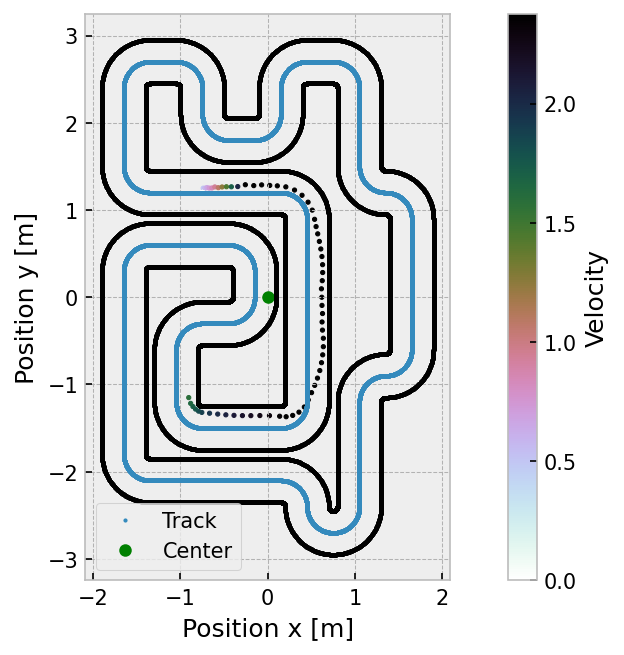

In [34]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,4].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()